# Making Python in Microstation Not Suck

With Microstation 2024, Microstation now includes access to the python programming language

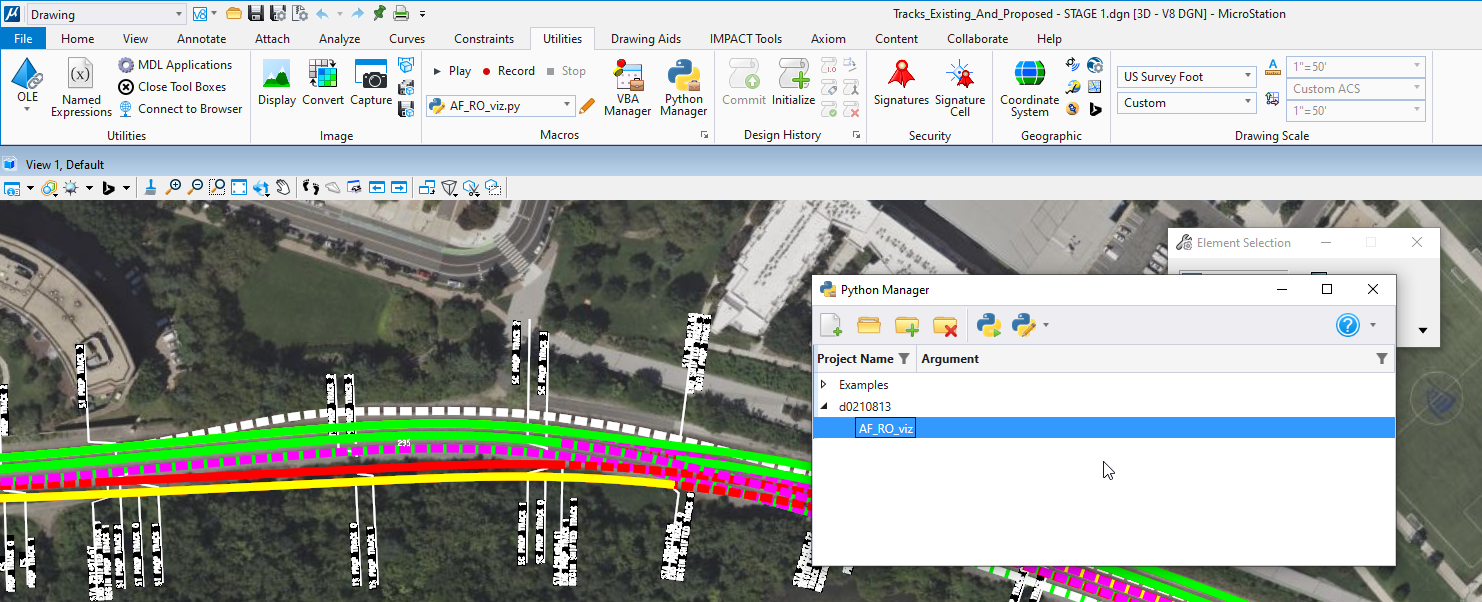

# Microstation Environment

[Bentley Documentation](https://bentleysystems.service-now.com/community?id=kb_article&sysparm_article=KB0040991)

Source folders for MS 2024

**Python Root**

`C:\ProgramData\Bentley\PowerPlatformPython\python`

**Python Examples**

`C:\ProgramData\Bentley\PowerPlatformPython\Examples\Microstation\`

**Python Installation**

The Python installation specific to MicroStation is delivered under:

`C:\ProgramData\Bentley\PowerPlatformPython\python\`

The `MS_PYTHON` configuration variable points to this installation directory by  
by default, change it to your current interpreter to run this code.

**Python IntelliSense**

The, `.PYI` IntelliSense files required by VS Code editor are delivered under:

`C:\ProgramData\Bentley\PowerPlatformPython\Examples\Microstation\Intellisense\`

In [1]:
import sys
import platform

print(platform.architecture())  # Compare these with the shipped MS Python
print(platform.python_version())  # They have to match

('64bit', 'WindowsPE')
3.12.10


In [2]:
sys.executable

'C:\\Users\\Dane.parks\\PycharmProjects\\civilpy\\.venv\\Scripts\\python.exe'

In [3]:
import os

os.path.dirname(sys.executable)

'C:\\Users\\Dane.parks\\PycharmProjects\\civilpy\\.venv\\Scripts'

In [4]:
os.chdir("C:\\Program Files\\Bentley\\MicroStation 2024\\MicroStation\\")

In [5]:
import sys

sys.path.append("C:\\Program Files\\Bentley\\MicroStation 2024\\MicroStation\\")

# Python Outside of Microstation

## Attempting to Attach to Active Microstation Process

[Bentley's Process for Attaching to VSCode](https://developer.bentley.com/documentation/microstation-python-api/guides/debuggingpythonapps/)

[How to connect PyCharm/Intellij using `pydevd-pycharm`](https://stackoverflow.com/questions/75127383/how-to-remotely-debug-python-with-intellij)

## Easy to Load Modules

In [6]:
import MSPyBentley

In [7]:
import MSPyBentleyGeom

In [8]:
import MSPyECObjects

In [9]:
import MSPyDgnPlatform

In [10]:
import MSPyDgnView

The last module needs the DLL files properly mapped in the python environment to be imported;

In [11]:
import os
from ctypes import CDLL

# Add DLL directories manually in case of ambiguity
dll_paths = [
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation",
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded",
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\smartsolid",
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\assemblies",
]

dll_list = [
    "python312.dll",
    "Bentley5.dll",
    "BentleyAllocator.dll",
    "BentleyGeom5.dll",
    "ECObjects6.dll",
    "DgnPlatform5.dll",
    "USTATION.dll",
    "3dModeling.dll",
    "Constraint2dCore1.dll",
    "Constraint2dElement.dll",
    "Constraint3dCore1.dll",
    "Constraint3dElement.dll",
    "PSolidCore2.dll",
    "SmartFeature.dll",
    "MSPythonCore.dll",
    "ImageLib2.dll",
    "Bentley.PrintFoundation.dll",
    "Bentley.PrintDefinitions.dll",
    "MSVCP140.dll",
    "VCRUNTIME140.dll",
    "VCRUNTIME140_1.dll",
    "api-ms-win-crt-runtime-l1-1-0.dll",
    "api-ms-win-crt-string-l1-1-0.dll",
    "api-ms-win-crt-heap-l1-1-0.dll",
    "api-ms-win-crt-math-l1-1-0.dll",
    "KERNEL32.dll"
]

for path in dll_paths:
    try:
        os.add_dll_directory(path)  # Explicitly add DLL search path
        for dll in dll_list:
            try:
                CDLL(dll)  # Attempt to load the DLL manually
            except OSError:
                pass
                # print(f"{dll} NOT found in {path}")
    except Exception as e:
        print(f"Failed to add DLL directory {path}: {e}")

In [12]:
import MSPyMstnPlatform

# Attempting to Use PYDOC to Analyze .pyd Files

doesn't work, 3 of the 6 modules don't properly generate documentation,

`MSPyDgnPlatform`  
`MSPyDgnView`  
`MSPyMstnPlatform`

# Alternative Approach to Exploring Modules

In [13]:
def explore_module(module):
    print(f"\nExploring {module.__name__}:")
    try:
        # Get all non-private attributes
        attributes = [attr for attr in dir(module) if not attr.startswith('_')]
        
        for attr in attributes:
            try:
                item = getattr(module, attr)
                if callable(item):
                    print(f"\nFunction/Class: {attr}")
                    try:
                        print(f"Doc: {item.__doc__}")
                        
                    except:
                        print("No documentation available")
                else:
                    print(f"\nAttribute: {attr}")
                    print(f"Value: {item}")
            except Exception as e:
                print(f"Error accessing {attr}: {e}")
    except Exception as e:
        print(f"Error exploring module: {e}")

In [14]:
def safe_inspect(module_name, class_name):
    try:
        # Get the class object without accessing it
        cls = getattr(module_name, class_name)
        # Just print the basic info
        print(f"Class name: {class_name}")
        print(f"Module: {cls.__module__}")
        return True
    except Exception as e:
        print(f"Error inspecting {class_name}: {e}")
        return False

# Try to safely inspect key classes
classes_to_check = [
    'DgnFile',
    'Cell',
    'Level',
    'ElementPropertyUtils'
]

for class_name in classes_to_check:
    safe_inspect(MSPyMstnPlatform, class_name)


Class name: DgnFile
Module: MSPyMstnPlatform
Class name: Cell
Module: MSPyMstnPlatform
Class name: Level
Module: MSPyMstnPlatform
Class name: ElementPropertyUtils
Module: MSPyMstnPlatform


In [15]:
# Try to safely explore ISessionMgr
safe_inspect(MSPyMstnPlatform, "ISessionMgr")

Class name: ISessionMgr
Module: MSPyMstnPlatform


True

In [16]:
def check_session_state():
    print("Checking Session State - Minimal Safe Approach")
    
    try:
        print("1. Basic File State:")
        is_init = MSPyMstnPlatform.ISessionMgr.IsDesignFileInitialized()
        print(f"   Design file initialized: {is_init}")
        
        print("\n2. UI State:")
        try:
            is_ready = MSPyMstnPlatform.ISessionMgr.IsReadyForUIProcessing()
            print(f"   Ready for UI processing: {is_ready}")
        except Exception as e:
            print(f"   Error checking UI state: {e}")
            
        print("\n3. Writeable Files:")
        try:
            writeable = MSPyMstnPlatform.ISessionMgr.WriteableFiles
            print(f"   Has writeable files: {writeable is not None}")
        except Exception as e:
            print(f"   Error checking writeable files: {e}")
            
    except Exception as e:
        print(f"Error occurred: {e}")
    
    print("\nTest completed")

if __name__ == "__main__":
    check_session_state()

Checking Session State - Minimal Safe Approach
1. Basic File State:
   Design file initialized: True

2. UI State:
   Error checking UI state: IsReadyForUIProcessing(): incompatible function arguments. The following argument types are supported:
    1. (self: MSPyMstnPlatform.ISessionMgr) -> bool

Invoked with: 

3. Writeable Files:
   Has writeable files: True

Test completed


In [17]:
def test_single_method(method_name):
    print(f"Testing method: {method_name}")
    
    try:
        # First verify we're in a good state
        is_init = MSPyMstnPlatform.ISessionMgr.IsDesignFileInitialized()
        print(f"Initial state - Design file initialized: {is_init}")
        
        # Then try the new method
        result = getattr(MSPyMstnPlatform.ISessionMgr, method_name)()
        print(f"Method result: {result}")
        
    except Exception as e:
        print(f"Error occurred: {e}")
    
    print("Test completed")

# Example usage:
# test_single_method("InActiveFile")

In [ ]:
import MSPyMstnPlatform
# import MSPyDgnPlatform # Not needed for this specific step

def test_incremental():
    print("Starting incremental test")
    try:
        # 1. Testing IsDesignFileInitialized (known safe)
        print("\n1. Testing IsDesignFileInitialized")
        is_init = MSPyMstnPlatform.ISessionMgr.IsDesignFileInitialized()
        print(f"Design file initialized: {is_init}")

        # 2. Attempting to get the active DgnFile via static property
        print("\n2. Attempting to access MSPyMstnPlatform.ISessionMgr.ActiveDgnFile property")
        active_dgn_file = None
        try:
            # Access the static property
            active_dgn_file = MSPyMstnPlatform.ISessionMgr.ActiveDgnFile
            
            if active_dgn_file is not None:
                print(f"Successfully accessed ActiveDgnFile property. Returned object type: {type(active_dgn_file)}")
                
                # 3. Explore the returned DgnFile object (briefly)
                print("\n3. Exploring the returned DgnFile object")
                try:
                    dgn_file_attrs = dir(active_dgn_file)
                     # Sort alphabetically
                    # dgn_file_attrs.sort() # Skip sorting for stability
                    print(f"First few attributes: {dgn_file_attrs[:20]}") # Print only first few to limit potential issues
                    
                    # Check if it looks like a DgnFile object 
                    # Check for a few common expected methods/properties
                    has_models = hasattr(active_dgn_file, 'GetModels')
                    has_readonly = hasattr(active_dgn_file, 'IsReadOnly')
                    has_name = hasattr(active_dgn_file, 'GetFileName')

                    if has_models and has_readonly and has_name:
                        print("\nThe returned object appears to be a DgnFile instance.")
                        # Try getting the name as a final safe check
                        try:
                            file_name = active_dgn_file.GetFileName()
                            print(f"Successfully called GetFileName(): {file_name}")
                        except Exception as e_name:
                            print(f"Could not get file name: {type(e_name).__name__}: {e_name}")
                    else:
                         print("\nThe returned object might not be a DgnFile instance, or its attributes differ from expectations.")

                except Exception as e:
                    print(f"Failed during exploration of the returned object: {type(e).__name__}: {e}")
            else:
                print("Accessing ActiveDgnFile property returned None.")

        except Exception as e:
            print(f"Failed to access ActiveDgnFile property: {type(e).__name__}: {e}")
            
    except Exception as e:
        print(f"Unexpected error occurred: {type(e).__name__}: {e}")
    
    print("\nTest completed")

if __name__ == "__main__":
    try:
        test_incremental()
    except Exception as e:
        # Catch critical errors
        print(f"Critical error in main: {type(e).__name__}: {e}")

# Retrieving Properties About the Open File

```python
# Get the Active File Name
ISessionMgr.ActiveDgnFile.FileName  # or .GetFileName()

# Get the Active Model's name
ISessionMgr.ActiveDgnModel.ModelName  # or .GetModelName()
```

In [ ]:
print(dir(ISessionMgr))

In [ ]:
ACTIVEMODEL = ISessionMgr.ActiveDgnModelRef

In [ ]:
# Get the Active Model Name
dir(ISessionMgr)

In [ ]:
import win32com.client as win32

# Connect to a running MicroStation instance
ms_app = win32.Dispatch('MicroStationDGN.Application')

# Retrieve the active model reference
active_model = ms_app.ActiveModelReference
print(active_model.Name)

In [ ]:
elements = active_model.Scan()
for element in elements:
    if element.IsLineElement:  # Check if the element is a line
        print("Line Element Found!")
        
        # Get coordinates (start and end points)
        start_point = element.StartPoint
        end_point = element.EndPoint
        
        # Get attributes
        level = element.Level.Name
        color = element.Color
        lineweight = element.LineWeight
        
        # Print the details
        print(f"Start Point: X={start_point.X}, Y={start_point.Y}, Z={start_point.Z}")
        print(f"End Point: X={end_point.X}, Y={end_point.Y}, Z={end_point.Z}")
        print(f"Level: {level}")
        print(f"Color: {color}")
        print(f"Lineweight: {lineweight}")


Dug into the required DLLs (see the pybind11 notes below), here is the  
resulting list;

Imports from .pyd file:

    python312.dll
    Bentley5.dll
    BentleyAllocator.dll
    BentleyGeom5.dll
    ECObjects6.dll
    DgnPlatform5.dll
    USTATION.dll
    3dModeling.dll
    Constraint2dCore1.dll
    Constraint2dElement.dll
    Constraint3dCore1.dll
    Constraint3dElement.dll
    PSolidCore2.dll
    SmartFeature.dll
    MSPythonCore.dll
    ImageLib2.dll
    Bentley.PrintFoundation.dll
    Bentley.PrintDefinitions.dll
    MSVCP140.dll
    VCRUNTIME140.dll
    VCRUNTIME140_1.dll
    api-ms-win-crt-runtime-l1-1-0.dll
    api-ms-win-crt-string-l1-1-0.dll
    api-ms-win-crt-heap-l1-1-0.dll
    api-ms-win-crt-math-l1-1-0.dll
    KERNEL32.dll

    python312.dll
    Bentley5.dll
    BentleyAllocator.dll
    BentleyGeom5.dll
    ECObjects6.dll
    DgnPlatform5.dll
    USTATION.dll
    3dModeling.dll
    Constraint2dCore1.dll
    Constraint2dElement.dll
    Constraint3dCore1.dll
    Constraint3dElement.dll
    PSolidCore2.dll
    SmartFeature.dll
    MSPythonCore.dll
    ImageLib2.dll
    Bentley.PrintFoundation.dll
    Bentley.PrintDefinitions.dll
    MSVCP140.dll
    VCRUNTIME140.dll
    VCRUNTIME140_1.dll
    api-ms-win-crt-runtime-l1-1-0.dll
    api-ms-win-crt-string-l1-1-0.dll
    api-ms-win-crt-heap-l1-1-0.dll
    api-ms-win-crt-math-l1-1-0.dll
    KERNEL32.dll

In [ ]:
# ISessionMgr.ActiveDgnFile()

In [ ]:
ACTIVEMODEL = ISessionMgr.ActiveDgnModelRef

# Generating Section Properties from Values

In [ ]:
from civilpy.structural.steel import W

# Bentley Sqlite3 Exploration

## 3D Modeling - SolidModification

In [ ]:
# from MSPyBentley import
# from MSPyBentleyGeom import
# from MSPyDgnPlatform import
# from MSPyDgnView import
# from MSPyECObjects import
# from MSPyMstnPlatform import

In [ ]:
imprintSolidUsingProfile()

In [ ]:
import sqlite3

In [ ]:
con = sqlite3.connect(
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\proj.db"
)

In [ ]:
cur = con.cursor()

In [ ]:
res = cur.execute("SELECT name FROM sqlite_master")  # Create a result object
res.fetchall()  # Return all values of the result object

In [ ]:
res = cur.execute("SELECT * FROM unit_of_measure")
res.fetchall()  # Return all values of the result object

# Midas Interaction

In [ ]:
import os
import json
import requests
from pathlib import Path
from civilpy.general import units

In [ ]:
from civilpy.structural.midas import get_api_key

In [ ]:
get_api_key("C:\\ProgramData\\Bentley\\MicroStation 2024\\Configuration\\WorkSpaces\\BentleyCONNECTTraining\\WorkSets\\MSBasicsCivil\\Standards\\Macros\\secrets.json")

In [ ]:
from civilpy.structural.midas import (get_elements, get_nodes, midas_api, 
        get_materials, get_sections)

In [ ]:
elements = get_elements()

In [ ]:
elements

In [ ]:
nodes = get_nodes()

In [ ]:
nodes

In [ ]:
new_nodes_dict = {"Assign": nodes['NODE']}

In [ ]:
new_nodes_dict

In [ ]:
new_elements_dict = {"Assign": elements['ELEM']}

In [ ]:
new_elements_dict

In [ ]:
midas_api("PUT", "db/node", new_nodes_dict)

In [ ]:
midas_api("PUT", "db/elem", new_elements_dict)

In [ ]:
new_nodes_dict

In [ ]:
midas_api("PUT", "db/elem", new_elements_dict)

In [ ]:
materials = get_materials()

In [ ]:
new_materials_dict = {"Assign": materials['MATL']}
new_materials_dict

In [ ]:
midas_api("PUT", "db/matl", new_materials_dict)

In [ ]:
sections = get_sections()

In [ ]:
new_sections_dict = {"Assign": sections['SECT']}
new_sections_dict

In [ ]:
midas_api("PUT", "db/sect", new_sections_dict)

# Utilizing COM Ports to Control Microstation


In [ ]:
import win32com.client as win32

file_path = (
    r"C:\ProgramData\Bentley\MicroStation 2024\Configuration\WorkSpaces\BentleyCONNECTTraining\WorkSets\MSBasicsCivil\dgn\Ref\baseline.dgn"
)

In [ ]:
MSApp = win32.gencache.EnsureDispatch("MicrostationDGN.Application")

In [ ]:
MSApp.Visible = 1

In [ ]:
MSApp.OpenDesignFile(file_path)

In [ ]:
design_file = MSApp.ActiveDesignFile

In [ ]:
model_ref = design_file.Models

In [ ]:
model_ref

In [ ]:
import win32com.client

try:
    # Connect to the running instance of MicroStation
    microstation = win32com.client.Dispatch("MicroStationDGN.Application")

    # Get the active design file
    active_design_file = microstation.ActiveDesignFile

except Exception as e:
    print(f"Error: {e}")


In [ ]:
# Get the active model
active_model = active_design_file.ActiveModelReference

# Print details about the active model
print(f"Model Name: {active_model.Name}")
print(f"Model Type: {active_model.Type}")
print(f"Description: {active_model.Description}")
print(f"Unit of Resolution: {active_model.UorPerMasterUnit}")

In [ ]:
active_design_file.ActiveModel

In [ ]:
from win32com.client import combrowse

combrowse.main()

In [ ]:
import win32com.client as win32

MSApp = win32.gencache.EnsureDispatch("OpenRoadsDGN.Application")

# ODA Libraries

In [ ]:
from res.ODA import *

In [ ]:
from res.ODA.test import Example

In [ ]:
value = Example()
value.foo

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
temp_list = [(0,1), (0,2), (0,3), (0,4)]

for i, point in enumerate(temp_list):
    print(i, point[0], point[1])

# Objects In Bentley Libraries

The following cells were how civilpy's list of objects were generated for Microstation 2024, the string tables were generated by importing the library and then running the `whos` command in jupyter.

## Bentley Library Imports

The bentley examples primarily rely on the following imports,

```python
from MSPyBentley import *
from MSPyBentleyGeom import *
from MSPyECObjects import *
from MSPyDgnPlatform import *
from MSPyDgnView import *
from MSPyMstnPlatform import *
```

to figure out where these modules are (and view the code) we can use the following in the MicroStation Repl,

`__import__('MSPyBentley').__file__`



## MSPyBentley

Base Classes for most other libraries

In [ ]:
from MSPyBentley import *

In [ ]:
mspy_bentley_as_string = """Variable                        Type                          Data/Info
-----------------------------------------------------------------------
AString                         pybind11_type                 <class 'MSPyBentley.AString'>
AStringArray                    pybind11_type                 <class 'MSPyBentley.AStringArray'>
Base64Utilities                 pybind11_type                 <class 'MSPyBentley.Base64Utilities'>
BeDateTime                      pybind11_type                 <class 'MSPyBentley.BeDateTime'>
BeDateTimeInfo                  pybind11_type                 <class 'MSPyBentley.BeDateTimeInfo'>
BeFile                          pybind11_type                 <class 'MSPyBentley.BeFile'>
BeFileAccess                    pybind11_type                 <class 'MSPyBentley.BeFileAccess'>
BeFileAttributes                pybind11_type                 <class 'MSPyBentley.BeFileAttributes'>
BeFileListIterator              pybind11_type                 <class 'MSPyBentley.BeFileListIterator'>
BeFileName                      pybind11_type                 <class 'MSPyBentley.BeFileName'>
BeFileNameAccess                pybind11_type                 <class 'MSPyBentley.BeFileNameAccess'>
BeFileNameStatus                pybind11_type                 <class 'MSPyBentley.BeFileNameStatus'>
BeFileSeekOrigin                pybind11_type                 <class 'MSPyBentley.BeFileSeekOrigin'>
BeFileSharing                   pybind11_type                 <class 'MSPyBentley.BeFileSharing'>
BeFileStatus                    pybind11_type                 <class 'MSPyBentley.BeFileStatus'>
BeGetComputerName               builtin_function_or_method    <built-in method BeGetCom<...>ct at 0x000001FBB3B5F7E0>
BeGetComputerNameA              builtin_function_or_method    <built-in method BeGetCom<...>ct at 0x000001FBB3B5F810>
BeGetUserName                   builtin_function_or_method    <built-in method BeGetUse<...>ct at 0x000001FBB3B5F780>
BeGetUserNameA                  builtin_function_or_method    <built-in method BeGetUse<...>ct at 0x000001FBB3B5F7B0>
BeStringUtilities               pybind11_type                 <class 'MSPyBentley.BeStringUtilities'>
BeTextFile                      pybind11_type                 <class 'MSPyBentley.BeTextFile'>
BoolArray                       pybind11_type                 <class 'MSPyBentley.BoolArray'>
DoubleArray                     pybind11_type                 <class 'MSPyBentley.DoubleArray'>
DoubleFormatter                 pybind11_type                 <class 'MSPyBentley.DoubleFormatter'>
DoubleFormatterBase             pybind11_type                 <class 'MSPyBentley.DoubleFormatterBase'>
DsigAnnotationData              pybind11_type                 <class 'MSPyBentley.DsigAnnotationData'>
DsigQuery                       pybind11_type                 <class 'MSPyBentley.DsigQuery'>
FloatArray                      pybind11_type                 <class 'MSPyBentley.FloatArray'>
HeapZone                        pybind11_type                 <class 'MSPyBentley.HeapZone'>
HexFormatOptions                pybind11_type                 <class 'MSPyBentley.HexFormatOptions'>
Int16Array                      pybind11_type                 <class 'MSPyBentley.Int16Array'>
Int32Array                      pybind11_type                 <class 'MSPyBentley.Int32Array'>
Int64Array                      pybind11_type                 <class 'MSPyBentley.Int64Array'>
Int64VecArray                   pybind11_type                 <class 'MSPyBentley.Int64VecArray'>
Int8Array                       pybind11_type                 <class 'MSPyBentley.Int8Array'>
ItemsView[WStringWCharMap]      pybind11_type                 <class 'MSPyBentley.ItemsView[WStringWCharMap]'>
ItemsView[WStringWStringMap]    pybind11_type                 <class 'MSPyBentley.Items<...>View[WStringWStringMap]'>
KeysView[WStringWCharMap]       pybind11_type                 <class 'MSPyBentley.KeysView[WStringWCharMap]'>
KeysView[WStringWStringMap]     pybind11_type                 <class 'MSPyBentley.KeysView[WStringWStringMap]'>
LangCodePage                    pybind11_type                 <class 'MSPyBentley.LangCodePage'>
PrecisionFormat                 pybind11_type                 <class 'MSPyBentley.PrecisionFormat'>
PrecisionType                   pybind11_type                 <class 'MSPyBentley.PrecisionType'>
PyNameSpaceManager              pybind11_type                 <class 'MSPyBentley.PyNameSpaceManager'>
TextFileEncoding                pybind11_type                 <class 'MSPyBentley.TextFileEncoding'>
TextFileOpenType                pybind11_type                 <class 'MSPyBentley.TextFileOpenType'>
TextFileOptions                 pybind11_type                 <class 'MSPyBentley.TextFileOptions'>
TextFileReadStatus              pybind11_type                 <class 'MSPyBentley.TextFileReadStatus'>
TextFileWriteStatus             pybind11_type                 <class 'MSPyBentley.TextFileWriteStatus'>
UInt16Array                     pybind11_type                 <class 'MSPyBentley.UInt16Array'>
UInt32Array                     pybind11_type                 <class 'MSPyBentley.UInt32Array'>
UInt64Array                     pybind11_type                 <class 'MSPyBentley.UInt64Array'>
UInt64VecArray                  pybind11_type                 <class 'MSPyBentley.UInt64VecArray'>
UInt8Array                      pybind11_type                 <class 'MSPyBentley.UInt8Array'>
Utf8String                      pybind11_type                 <class 'MSPyBentley.Utf8String'>
Utf8StringArray                 pybind11_type                 <class 'MSPyBentley.Utf8StringArray'>
ValuesView[WStringWCharMap]     pybind11_type                 <class 'MSPyBentley.ValuesView[WStringWCharMap]'>
ValuesView[WStringWStringMap]   pybind11_type                 <class 'MSPyBentley.Value<...>View[WStringWStringMap]'>
WCharArray                      pybind11_type                 <class 'MSPyBentley.WCharArray'>
WString                         pybind11_type                 <class 'MSPyBentley.WString'>
WStringArray                    pybind11_type                 <class 'MSPyBentley.WStringArray'>
WStringWCharMap                 pybind11_type                 <class 'MSPyBentley.WStringWCharMap'>
WStringWStringMap               pybind11_type                 <class 'MSPyBentley.WStringWStringMap'>
eAccessViolation                BeFileNameStatus              BeFileNameStatus.eAccessViolation
eAccessViolationError           BeFileStatus                  BeFileStatus.eAccessViolationError
eAlreadyExists                  BeFileNameStatus              BeFileNameStatus.eAlreadyExists
eAppend                         TextFileOpenType              TextFileOpenType.eAppend
eArabic                         LangCodePage                  LangCodePage.eArabic
eBadParameter                   TextFileWriteStatus           TextFileWriteStatus.eBadParameter
eBaltic                         LangCodePage                  LangCodePage.eBaltic
eBegin                          BeFileSeekOrigin              BeFileSeekOrigin.eBegin
eCantCreate                     BeFileNameStatus              BeFileNameStatus.eCantCreate
eCantDeleteDir                  BeFileNameStatus              BeFileNameStatus.eCantDeleteDir
eCantDeleteFile                 BeFileNameStatus              BeFileNameStatus.eCantDeleteFile
eCentral_European               LangCodePage                  LangCodePage.eCentral_European
eCurrent                        BeFileSeekOrigin              BeFileSeekOrigin.eCurrent
eCurrentLocale                  TextFileEncoding              TextFileEncoding.eCurrentLocale
eCyrillic                       LangCodePage                  LangCodePage.eCyrillic
eDecimal                        PrecisionType                 PrecisionType.eDecimal
eDecimal1Place                  PrecisionFormat               PrecisionFormat.eDecimal1Place
eDecimal2Places                 PrecisionFormat               PrecisionFormat.eDecimal2Places
eDecimal3Places                 PrecisionFormat               PrecisionFormat.eDecimal3Places
eDecimal4Places                 PrecisionFormat               PrecisionFormat.eDecimal4Places
eDecimal5Places                 PrecisionFormat               PrecisionFormat.eDecimal5Places
eDecimal6Places                 PrecisionFormat               PrecisionFormat.eDecimal6Places
eDecimal7Places                 PrecisionFormat               PrecisionFormat.eDecimal7Places
eDecimal8Places                 PrecisionFormat               PrecisionFormat.eDecimal8Places
eDecimalWhole                   PrecisionFormat               PrecisionFormat.eDecimalWhole
eDeleteOnClose                  BeFileAttributes              BeFileAttributes.eDeleteOnClose
eEnd                            BeFileSeekOrigin              BeFileSeekOrigin.eEnd
eEof                            TextFileReadStatus            TextFileReadStatus.eEof
eError                          TextFileWriteStatus           TextFileWriteStatus.eError
eExists                         BeFileNameAccess              BeFileNameAccess.eExists
eFileNotFound                   BeFileNameStatus              BeFileNameStatus.eFileNotFound
eFileNotFoundError              BeFileStatus                  BeFileStatus.eFileNotFoundError
eFileNotOpenError               BeFileStatus                  BeFileStatus.eFileNotOpenError
eFractional                     PrecisionType                 PrecisionType.eFractional
eFractional1_Over_128           PrecisionFormat               PrecisionFormat.eFractional1_Over_128
eFractional1_Over_256           PrecisionFormat               PrecisionFormat.eFractional1_Over_256
eFractional1_Over_32            PrecisionFormat               PrecisionFormat.eFractional1_Over_32
eFractional1_Over_64            PrecisionFormat               PrecisionFormat.eFractional1_Over_64
eFractionalEighth               PrecisionFormat               PrecisionFormat.eFractionalEighth
eFractionalHalf                 PrecisionFormat               PrecisionFormat.eFractionalHalf
eFractionalQuarter              PrecisionFormat               PrecisionFormat.eFractionalQuarter
eFractionalSixteenth            PrecisionFormat               PrecisionFormat.eFractionalSixteenth
eFractionalWhole                PrecisionFormat               PrecisionFormat.eFractionalWhole
eGreek                          LangCodePage                  LangCodePage.eGreek
eHebrew                         LangCodePage                  LangCodePage.eHebrew
eISCII_UNICODE_UTF_7            LangCodePage                  LangCodePage.eISCII_UNICODE_UTF_7
eISCII_UNICODE_UTF_8            LangCodePage                  LangCodePage.eISCII_UNICODE_UTF_8
eISO_8859_1                     LangCodePage                  LangCodePage.eISO_8859_1
eISO_8859_15                    LangCodePage                  LangCodePage.eISO_8859_15
eISO_8859_2                     LangCodePage                  LangCodePage.eISO_8859_2
eISO_8859_3                     LangCodePage                  LangCodePage.eISO_8859_3
eISO_8859_4                     LangCodePage                  LangCodePage.eISO_8859_4
eISO_8859_5                     LangCodePage                  LangCodePage.eISO_8859_5
eISO_8859_6                     LangCodePage                  LangCodePage.eISO_8859_6
eISO_8859_7                     LangCodePage                  LangCodePage.eISO_8859_7
eISO_8859_8                     LangCodePage                  LangCodePage.eISO_8859_8
eISO_8859_9                     LangCodePage                  LangCodePage.eISO_8859_9
eIllegalName                    BeFileNameStatus              BeFileNameStatus.eIllegalName
eIncludePrefix                  HexFormatOptions              HexFormatOptions.eIncludePrefix
eJapanese                       LangCodePage                  LangCodePage.eJapanese
eJohab                          LangCodePage                  LangCodePage.eJohab
eKeepNewLine                    TextFileOptions               TextFileOptions.eKeepNewLine
eKorean                         LangCodePage                  LangCodePage.eKorean
eLatinI                         LangCodePage                  LangCodePage.eLatinI
eLeadingZeros                   HexFormatOptions              HexFormatOptions.eLeadingZeros
eLeftJustify                    HexFormatOptions              HexFormatOptions.eLeftJustify
eNewLinesToSpace                TextFileOptions               TextFileOptions.eNewLinesToSpace
eNone                           HexFormatOptions              HexFormatOptions.eNone
eNone_                          TextFileOptions               TextFileOptions.eNone_
eNormal                         BeFileAttributes              BeFileAttributes.eNormal
eNotLockedError                 BeFileStatus                  BeFileStatus.eNotLockedError
eOEM_Baltic                     LangCodePage                  LangCodePage.eOEM_Baltic
eOEM_Cryllic                    LangCodePage                  LangCodePage.eOEM_Cryllic
eOEM_Greek                      LangCodePage                  LangCodePage.eOEM_Greek
eOEM_Hebrew                     LangCodePage                  LangCodePage.eOEM_Hebrew
eOEM_LatinI                     LangCodePage                  LangCodePage.eOEM_LatinI
eOEM_LatinII                    LangCodePage                  LangCodePage.eOEM_LatinII
eOEM_Multilingual               LangCodePage                  LangCodePage.eOEM_Multilingual
eOEM_Russian                    LangCodePage                  LangCodePage.eOEM_Russian
eOEM_Thai                       LangCodePage                  LangCodePage.eOEM_Thai
eOEM_Turkish                    LangCodePage                  LangCodePage.eOEM_Turkish
eOEM_US                         LangCodePage                  LangCodePage.eOEM_US
eRandomIO                       BeFileAttributes              BeFileAttributes.eRandomIO
eRead                           TextFileOpenType              TextFileOpenType.eRead
eReadError                      BeFileStatus                  BeFileStatus.eReadError
eReadWrite                      BeFileNameAccess              BeFileNameAccess.eReadWrite
eScientific                     PrecisionType                 PrecisionType.eScientific
eScientific1Place               PrecisionFormat               PrecisionFormat.eScientific1Place
eScientific2Places              PrecisionFormat               PrecisionFormat.eScientific2Places
eScientific3Places              PrecisionFormat               PrecisionFormat.eScientific3Places
eScientific4Places              PrecisionFormat               PrecisionFormat.eScientific4Places
eScientific5Places              PrecisionFormat               PrecisionFormat.eScientific5Places
eScientific6Places              PrecisionFormat               PrecisionFormat.eScientific6Places
eScientific7Places              PrecisionFormat               PrecisionFormat.eScientific7Places
eScientific8Places              PrecisionFormat               PrecisionFormat.eScientific8Places
eScientificWhole                PrecisionFormat               PrecisionFormat.eScientificWhole
eSharingViolationError          BeFileStatus                  BeFileStatus.eSharingViolationError
eSimplified_Chinese             LangCodePage                  LangCodePage.eSimplified_Chinese
eSuccess                        TextFileWriteStatus           TextFileWriteStatus.eSuccess
eTooManyOpenFilesError          BeFileStatus                  BeFileStatus.eTooManyOpenFilesError
eTraditional_Chinese            LangCodePage                  LangCodePage.eTraditional_Chinese
eTransparent_ASMO               LangCodePage                  LangCodePage.eTransparent_ASMO
eTurkish                        LangCodePage                  LangCodePage.eTurkish
eUNICODE_UCS2_Big_Endian        LangCodePage                  LangCodePage.eUNICODE_UCS2_Big_Endian
eUNICODE_UCS2_Little_Endian     LangCodePage                  LangCodePage.eUnicode
eUnicode                        LangCodePage                  LangCodePage.eUnicode
eUnknown                        LangCodePage                  LangCodePage.eUnknown
eUnknownError                   BeFileNameStatus              BeFileNameStatus.eUnknownError
eUppercase                      HexFormatOptions              HexFormatOptions.eUppercase
eUsePrecision                   HexFormatOptions              HexFormatOptions.eUsePrecision
eUtf16                          TextFileEncoding              TextFileEncoding.eUtf16
eUtf8                           TextFileEncoding              TextFileEncoding.eUtf8
eVietnamese                     LangCodePage                  LangCodePage.eVietnamese
eWrite                          TextFileOpenType              TextFileOpenType.eWrite"""

In [ ]:
import re
MSPyBentley = []

for line in mspy_bentley_as_string.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyBentley.append(temp_tuple)

In [ ]:
for value in MSPyBentley:
    print(value)

## MSPyBentleyGeom

In [ ]:
# Depends on MSPyBentley being imported first
from MSPyBentleyGeom import *

In [ ]:
mspy_bent_geom_as_string="""Variable                                           Type                          Data/Info
------------------------------------------------------------------------------------------
ANY_EDGE                                           int                           15
AString                                            pybind11_type                 <class 'MSPyBentley.AString'>
AStringArray                                       pybind11_type                 <class 'MSPyBentley.AStringArray'>
Angle                                              pybind11_type                 <class 'MSPyBentleyGeom.Angle'>
AngleInDegrees                                     pybind11_type                 <class 'MSPyBentleyGeom.AngleInDegrees'>
AnnounceDoubleDPoint2d                             pybind11_type                 <class 'MSPyBentleyGeom.AnnounceDoubleDPoint2d'>
AreaSelect                                         pybind11_type                 <class 'MSPyBentleyGeom.AreaSelect'>
BCurveSegment                                      pybind11_type                 <class 'MSPyBentleyGeom.BCurveSegment'>
BSCURVE_CIRCLE                                     int                           3
BSCURVE_CIRCULAR_ARC                               int                           2
BSCURVE_ELLIPSE                                    int                           5
BSCURVE_ELLIPTICAL_ARC                             int                           4
BSCURVE_GENERAL                                    int                           0
BSCURVE_HYPERBOLIC_ARC                             int                           7
BSCURVE_LINE                                       int                           1
BSCURVE_PARABOLIC_ARC                              int                           6
BSIIncrementalVectorIntegrand                      pybind11_type                 <class 'MSPyBentleyGeom.B<...>rementalVectorIntegrand'>
BSIQuadraturePoints                                pybind11_type                 <class 'MSPyBentleyGeom.BSIQuadraturePoints'>
BSITriangleQuadraturePoints                        pybind11_type                 <class 'MSPyBentleyGeom.B<...>riangleQuadraturePoints'>
BSIVectorIntegrand                                 pybind11_type                 <class 'MSPyBentleyGeom.BSIVectorIntegrand'>
BSIVectorIntegrandXY                               pybind11_type                 <class 'MSPyBentleyGeom.BSIVectorIntegrandXY'>
BSSURF_CONE                                        int                           3
BSSURF_GENERAL                                     int                           0
BSSURF_PLANE                                       int                           1
BSSURF_REVOLUTION                                  int                           6
BSSURF_RIGHT_CYLINDER                              int                           2
BSSURF_RULED_SURFACE                               int                           8
BSSURF_SPHERE                                      int                           4
BSSURF_TAB_CYLINDER                                int                           7
BSSURF_TORUS                                       int                           5
BSSURF_U                                           int                           0
BSSURF_V                                           int                           1
Base64Utilities                                    pybind11_type                 <class 'MSPyBentley.Base64Utilities'>
BeDateTime                                         pybind11_type                 <class 'MSPyBentley.BeDateTime'>
BeDateTimeInfo                                     pybind11_type                 <class 'MSPyBentley.BeDateTimeInfo'>
BeFile                                             pybind11_type                 <class 'MSPyBentley.BeFile'>
BeFileAccess                                       pybind11_type                 <class 'MSPyBentley.BeFileAccess'>
BeFileAttributes                                   pybind11_type                 <class 'MSPyBentley.BeFileAttributes'>
BeFileListIterator                                 pybind11_type                 <class 'MSPyBentley.BeFileListIterator'>
BeFileName                                         pybind11_type                 <class 'MSPyBentley.BeFileName'>
BeFileNameAccess                                   pybind11_type                 <class 'MSPyBentley.BeFileNameAccess'>
BeFileNameStatus                                   pybind11_type                 <class 'MSPyBentley.BeFileNameStatus'>
BeFileSeekOrigin                                   pybind11_type                 <class 'MSPyBentley.BeFileSeekOrigin'>
BeFileSharing                                      pybind11_type                 <class 'MSPyBentley.BeFileSharing'>
BeFileStatus                                       pybind11_type                 <class 'MSPyBentley.BeFileStatus'>
BeGetComputerName                                  builtin_function_or_method    <built-in method BeGetCom<...>ct at 0x000001FBB3B5F7E0>
BeGetComputerNameA                                 builtin_function_or_method    <built-in method BeGetCom<...>ct at 0x000001FBB3B5F810>
BeGetUserName                                      builtin_function_or_method    <built-in method BeGetUse<...>ct at 0x000001FBB3B5F780>
BeGetUserNameA                                     builtin_function_or_method    <built-in method BeGetUse<...>ct at 0x000001FBB3B5F7B0>
BeStringUtilities                                  pybind11_type                 <class 'MSPyBentley.BeStringUtilities'>
BeTextFile                                         pybind11_type                 <class 'MSPyBentley.BeTextFile'>
BlendDetail                                        pybind11_type                 <class 'MSPyBentleyGeom.BlendDetail'>
BlendDetailArray                                   pybind11_type                 <class 'MSPyBentleyGeom.BlendDetailArray'>
BlendType                                          pybind11_type                 <class 'MSPyBentleyGeom.BlendType'>
BlockedVectorCurveTopologyId                       pybind11_type                 <class 'MSPyBentleyGeom.B<...>edVectorCurveTopologyId'>
BlockedVectorDPoint2d                              pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorDPoint2d'>
BlockedVectorDPoint3d                              pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorDPoint3d'>
BlockedVectorDVec3d                                pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorDVec3d'>
BlockedVectorFacetFaceData                         pybind11_type                 <class 'MSPyBentleyGeom.B<...>ckedVectorFacetFaceData'>
BlockedVectorFloatRgb                              pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorFloatRgb'>
BlockedVectorInt                                   pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorInt'>
BlockedVectorIntT                                  pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorIntT'>
BlockedVectorPolyfaceEdgeChain                     pybind11_type                 <class 'MSPyBentleyGeom.B<...>VectorPolyfaceEdgeChain'>
BlockedVectorRgbFactor                             pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorRgbFactor'>
BlockedVectorUInt32                                pybind11_type                 <class 'MSPyBentleyGeom.BlockedVectorUInt32'>
BoolArray                                          pybind11_type                 <class 'MSPyBentley.BoolArray'>
BoolSelect                                         pybind11_type                 <class 'MSPyBentleyGeom.BoolSelect'>
BsplineDisplay                                     pybind11_type                 <class 'MSPyBentleyGeom.BsplineDisplay'>
BsplineParam                                       pybind11_type                 <class 'MSPyBentleyGeom.BsplineParam'>
CURVATURE_CONTINUITY                               int                           2
ClipPlane                                          pybind11_type                 <class 'MSPyBentleyGeom.ClipPlane'>
ClipPlaneArray                                     pybind11_type                 <class 'MSPyBentleyGeom.ClipPlaneArray'>
ClipPlaneContainment                               pybind11_type                 <class 'MSPyBentleyGeom.ClipPlaneContainment'>
ClipPlaneSet                                       pybind11_type                 <class 'MSPyBentleyGeom.ClipPlaneSet'>
CompoundDrawState                                  pybind11_type                 <class 'MSPyBentleyGeom.CompoundDrawState'>
ConvexClipPlaneSet                                 pybind11_type                 <class 'MSPyBentleyGeom.ConvexClipPlaneSet'>
ConvexClipPlaneSetArray                            pybind11_type                 <class 'MSPyBentleyGeom.ConvexClipPlaneSetArray'>
CurveAndSolidLocationDetail                        pybind11_type                 <class 'MSPyBentleyGeom.C<...>eAndSolidLocationDetail'>
CurveAndSolidLocationDetailArray                   pybind11_type                 <class 'MSPyBentleyGeom.C<...>olidLocationDetailArray'>
CurveCurve                                         pybind11_type                 <class 'MSPyBentleyGeom.CurveCurve'>
CurveGapOptions                                    pybind11_type                 <class 'MSPyBentleyGeom.CurveGapOptions'>
CurveKeyPointCollector                             pybind11_type                 <class 'MSPyBentleyGeom.CurveKeyPointCollector'>
CurveKeyPoint_ClosestPointCollector                pybind11_type                 <class 'MSPyBentleyGeom.C<...>t_ClosestPointCollector'>
CurveLocationDetail                                pybind11_type                 <class 'MSPyBentleyGeom.CurveLocationDetail'>
CurveLocationDetailArray                           pybind11_type                 <class 'MSPyBentleyGeom.C<...>urveLocationDetailArray'>
CurveLocationDetailPair                            pybind11_type                 <class 'MSPyBentleyGeom.CurveLocationDetailPair'>
CurveLocationDetailPairArray                       pybind11_type                 <class 'MSPyBentleyGeom.C<...>LocationDetailPairArray'>
CurveOffsetOptions                                 pybind11_type                 <class 'MSPyBentleyGeom.CurveOffsetOptions'>
CurveParameterMapping                              pybind11_type                 <class 'MSPyBentleyGeom.CurveParameterMapping'>
CurvePrimitiveId                                   pybind11_type                 <class 'MSPyBentleyGeom.CurvePrimitiveId'>
CurveTopologyId                                    pybind11_type                 <class 'MSPyBentleyGeom.CurveTopologyId'>
CurveTopologyIdArray                               pybind11_type                 <class 'MSPyBentleyGeom.CurveTopologyIdArray'>
CurveVector                                        pybind11_type                 <class 'MSPyBentleyGeom.CurveVector'>
CurveVectorPtrArray                                pybind11_type                 <class 'MSPyBentleyGeom.CurveVectorPtrArray'>
CurveVectorWithDistanceIndex                       pybind11_type                 <class 'MSPyBentleyGeom.C<...>VectorWithDistanceIndex'>
DBilinearPatch3d                                   pybind11_type                 <class 'MSPyBentleyGeom.DBilinearPatch3d'>
DCatenary3dPlacement                               pybind11_type                 <class 'MSPyBentleyGeom.DCatenary3dPlacement'>
DCatenaryXY                                        pybind11_type                 <class 'MSPyBentleyGeom.DCatenaryXY'>
DERIVATIVE_CONTINUITY                              int                           3
DEllipse3d                                         pybind11_type                 <class 'MSPyBentleyGeom.DEllipse3d'>
DEllipse3dArray                                    pybind11_type                 <class 'MSPyBentleyGeom.DEllipse3dArray'>
DISCONNECT                                         float                         1.7976931348623157e+308
DMap4d                                             pybind11_type                 <class 'MSPyBentleyGeom.DMap4d'>
DMatrix4d                                          pybind11_type                 <class 'MSPyBentleyGeom.DMatrix4d'>
DPlane3d                                           pybind11_type                 <class 'MSPyBentleyGeom.DPlane3d'>
DPlane3dArray                                      pybind11_type                 <class 'MSPyBentleyGeom.DPlane3dArray'>
DPlane3dByVectors                                  pybind11_type                 <class 'MSPyBentleyGeom.DPlane3dByVectors'>
DPoint2d                                           pybind11_type                 <class 'MSPyBentleyGeom.DPoint2d'>
DPoint2dArray                                      pybind11_type                 <class 'MSPyBentleyGeom.DPoint2dArray'>
DPoint2dVecArray                                   pybind11_type                 <class 'MSPyBentleyGeom.DPoint2dVecArray'>
DPoint3d                                           pybind11_type                 <class 'MSPyBentleyGeom.DPoint3d'>
DPoint3dArray                                      pybind11_type                 <class 'MSPyBentleyGeom.DPoint3dArray'>
DPoint3dSizeSize                                   pybind11_type                 <class 'MSPyBentleyGeom.DPoint3dSizeSize'>
DPoint3dVecArray                                   pybind11_type                 <class 'MSPyBentleyGeom.DPoint3dVecArray'>
DPoint3dVecVecArray                                pybind11_type                 <class 'MSPyBentleyGeom.DPoint3dVecVecArray'>
DPoint4d                                           pybind11_type                 <class 'MSPyBentleyGeom.DPoint4d'>
DPoint4dArray                                      pybind11_type                 <class 'MSPyBentleyGeom.DPoint4dArray'>
DRange1d                                           pybind11_type                 <class 'MSPyBentleyGeom.DRange1d'>
DRange1dArray                                      pybind11_type                 <class 'MSPyBentleyGeom.DRange1dArray'>
DRange2d                                           pybind11_type                 <class 'MSPyBentleyGeom.DRange2d'>
DRange3d                                           pybind11_type                 <class 'MSPyBentleyGeom.DRange3d'>
DRange3dSizeSize                                   pybind11_type                 <class 'MSPyBentleyGeom.DRange3dSizeSize'>
DRay3d                                             pybind11_type                 <class 'MSPyBentleyGeom.DRay3d'>
DSPiral2dViennese                                  pybind11_type                 <class 'MSPyBentleyGeom.DSPiral2dViennese'>
DSPiral2dWeightedViennese                          pybind11_type                 <class 'MSPyBentleyGeom.D<...>Piral2dWeightedViennese'>
DSegment1d                                         pybind11_type                 <class 'MSPyBentleyGeom.DSegment1d'>
DSegment1dArray                                    pybind11_type                 <class 'MSPyBentleyGeom.DSegment1dArray'>
DSegment3d                                         pybind11_type                 <class 'MSPyBentleyGeom.DSegment3d'>
DSegment3dArray                                    pybind11_type                 <class 'MSPyBentleyGeom.DSegment3dArray'>
DSpiral2dArema                                     pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dArema'>
DSpiral2dAustralianRailCorp                        pybind11_type                 <class 'MSPyBentleyGeom.D<...>ral2dAustralianRailCorp'>
DSpiral2dBase                                      pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dBase'>
DSpiral2dBiQuadratic                               pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dBiQuadratic'>
DSpiral2dBloss                                     pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dBloss'>
DSpiral2dChinese                                   pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dChinese'>
DSpiral2dClothoid                                  pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dClothoid'>
DSpiral2dCosine                                    pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dCosine'>
DSpiral2dCzech                                     pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dCzech'>
DSpiral2dCzechAlongTangent                         pybind11_type                 <class 'MSPyBentleyGeom.D<...>iral2dCzechAlongTangent'>
DSpiral2dDirectEvaluation                          pybind11_type                 <class 'MSPyBentleyGeom.D<...>piral2dDirectEvaluation'>
DSpiral2dDirectHalfCosine                          pybind11_type                 <class 'MSPyBentleyGeom.D<...>piral2dDirectHalfCosine'>
DSpiral2dItalian                                   pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dItalian'>
DSpiral2dJapaneseCubic                             pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dJapaneseCubic'>
DSpiral2dMXCubicAlongArc                           pybind11_type                 <class 'MSPyBentleyGeom.D<...>Spiral2dMXCubicAlongArc'>
DSpiral2dPlacement                                 pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dPlacement'>
DSpiral2dPolish                                    pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dPolish'>
DSpiral2dSine                                      pybind11_type                 <class 'MSPyBentleyGeom.DSpiral2dSine'>
DSpiral2dWesternAustralian                         pybind11_type                 <class 'MSPyBentleyGeom.D<...>iral2dWesternAustralian'>
DTriangle3d                                        pybind11_type                 <class 'MSPyBentleyGeom.DTriangle3d'>
DTriangle3dArray                                   pybind11_type                 <class 'MSPyBentleyGeom.DTriangle3dArray'>
DVec2d                                             pybind11_type                 <class 'MSPyBentleyGeom.DVec2d'>
DVec2dArray                                        pybind11_type                 <class 'MSPyBentleyGeom.DVec2dArray'>
DVec3d                                             pybind11_type                 <class 'MSPyBentleyGeom.DVec3d'>
DVec3dArray                                        pybind11_type                 <class 'MSPyBentleyGeom.DVec3dArray'>
DVec3dVecArray                                     pybind11_type                 <class 'MSPyBentleyGeom.DVec3dVecArray'>
DgnBoxDetail                                       pybind11_type                 <class 'MSPyBentleyGeom.DgnBoxDetail'>
DgnConeDetail                                      pybind11_type                 <class 'MSPyBentleyGeom.DgnConeDetail'>
DgnExtrusionDetail                                 pybind11_type                 <class 'MSPyBentleyGeom.DgnExtrusionDetail'>
DgnRotationalSweepDetail                           pybind11_type                 <class 'MSPyBentleyGeom.D<...>gnRotationalSweepDetail'>
DgnRuledSweepDetail                                pybind11_type                 <class 'MSPyBentleyGeom.DgnRuledSweepDetail'>
DgnSphereDetail                                    pybind11_type                 <class 'MSPyBentleyGeom.DgnSphereDetail'>
DgnTorusPipeDetail                                 pybind11_type                 <class 'MSPyBentleyGeom.DgnTorusPipeDetail'>
DirectionalVolumeData                              pybind11_type                 <class 'MSPyBentleyGeom.DirectionalVolumeData'>
DoubleArray                                        pybind11_type                 <class 'MSPyBentley.DoubleArray'>
DoubleFormatter                                    pybind11_type                 <class 'MSPyBentley.DoubleFormatter'>
DoubleFormatterBase                                pybind11_type                 <class 'MSPyBentley.DoubleFormatterBase'>
DoubleSizeSize                                     pybind11_type                 <class 'MSPyBentleyGeom.DoubleSizeSize'>
DoubleSizeSizeT                                    pybind11_type                 <class 'MSPyBentleyGeom.DoubleSizeSizeT'>
DsigAnnotationData                                 pybind11_type                 <class 'MSPyBentley.DsigAnnotationData'>
DsigQuery                                          pybind11_type                 <class 'MSPyBentley.DsigQuery'>
EdgeId                                             pybind11_type                 <class 'MSPyBentleyGeom.EdgeId'>
EdgeIdArray                                        pybind11_type                 <class 'MSPyBentleyGeom.EdgeIdArray'>
FIT_CATMULLROM                                     int                           3
FIT_LEASTSQUARES                                   int                           2
FIT_POINTS                                         int                           1
FIT_POLES                                          int                           0
FaceId                                             pybind11_type                 <class 'MSPyBentleyGeom.FaceId'>
FaceIdArray                                        pybind11_type                 <class 'MSPyBentleyGeom.FaceIdArray'>
FaceIndicesArray                                   pybind11_type                 <class 'MSPyBentleyGeom.FaceIndicesArray'>
FacetCutFillHandler                                pybind11_type                 <class 'MSPyBentleyGeom.FacetCutFillHandler'>
FacetEdgeLocationDetail                            pybind11_type                 <class 'MSPyBentleyGeom.FacetEdgeLocationDetail'>
FacetFaceData                                      pybind11_type                 <class 'MSPyBentleyGeom.FacetFaceData'>
FacetFaceDataArray                                 pybind11_type                 <class 'MSPyBentleyGeom.FacetFaceDataArray'>
FacetLocationDetail                                pybind11_type                 <class 'MSPyBentleyGeom.FacetLocationDetail'>
FacetLocationDetailArray                           pybind11_type                 <class 'MSPyBentleyGeom.F<...>acetLocationDetailArray'>
FacetLocationDetailPair                            pybind11_type                 <class 'MSPyBentleyGeom.FacetLocationDetailPair'>
FacetLocationDetailPairWithIndices                 pybind11_type                 <class 'MSPyBentleyGeom.F<...>onDetailPairWithIndices'>
FacetParamMode                                     pybind11_type                 <class 'MSPyBentleyGeom.FacetParamMode'>
FilletDetailArray                                  pybind11_type                 <class 'MSPyBentleyGeom.FilletDetailArray'>
FloatArray                                         pybind11_type                 <class 'MSPyBentley.FloatArray'>
FloatRgb                                           pybind11_type                 <class 'MSPyBentleyGeom.FloatRgb'>
FloatRgbArray                                      pybind11_type                 <class 'MSPyBentleyGeom.FloatRgbArray'>
GeoPoint                                           pybind11_type                 <class 'MSPyBentleyGeom.GeoPoint'>
GeoPoint2d                                         pybind11_type                 <class 'MSPyBentleyGeom.GeoPoint2d'>
HeapZone                                           pybind11_type                 <class 'MSPyBentley.HeapZone'>
HexFormatOptions                                   pybind11_type                 <class 'MSPyBentley.HexFormatOptions'>
ICurvePrimitive                                    pybind11_type                 <class 'MSPyBentleyGeom.ICurvePrimitive'>
ICurvePrimitivePtrArray                            pybind11_type                 <class 'MSPyBentleyGeom.ICurvePrimitivePtrArray'>
IFacetOptions                                      pybind11_type                 <class 'MSPyBentleyGeom.IFacetOptions'>
IGeometry                                          pybind11_type                 <class 'MSPyBentleyGeom.IGeometry'>
IPolyfaceConstruction                              pybind11_type                 <class 'MSPyBentleyGeom.IPolyfaceConstruction'>
ISolidPrimitive                                    pybind11_type                 <class 'MSPyBentleyGeom.ISolidPrimitive'>
IndexedParameterMap                                pybind11_type                 <class 'MSPyBentleyGeom.IndexedParameterMap'>
Int16Array                                         pybind11_type                 <class 'MSPyBentley.Int16Array'>
Int32Array                                         pybind11_type                 <class 'MSPyBentley.Int32Array'>
Int64Array                                         pybind11_type                 <class 'MSPyBentley.Int64Array'>
Int64VecArray                                      pybind11_type                 <class 'MSPyBentley.Int64VecArray'>
Int8Array                                          pybind11_type                 <class 'MSPyBentley.Int8Array'>
ItemsView[WStringWCharMap]                         pybind11_type                 <class 'MSPyBentley.ItemsView[WStringWCharMap]'>
ItemsView[WStringWStringMap]                       pybind11_type                 <class 'MSPyBentley.Items<...>View[WStringWStringMap]'>
KeysView[WStringWCharMap]                          pybind11_type                 <class 'MSPyBentley.KeysView[WStringWCharMap]'>
KeysView[WStringWStringMap]                        pybind11_type                 <class 'MSPyBentley.KeysView[WStringWStringMap]'>
LangCodePage                                       pybind11_type                 <class 'MSPyBentley.LangCodePage'>
LocalCoordinateSelect                              pybind11_type                 <class 'MSPyBentleyGeom.LocalCoordinateSelect'>
LocalRange                                         pybind11_type                 <class 'MSPyBentleyGeom.LocalRange'>
MSB_ERROR                                          int                           32768
MSB_SUCCESS                                        int                           0
MSBsplineCurve                                     pybind11_type                 <class 'MSPyBentleyGeom.MSBsplineCurve'>
MSBsplineCurveArray                                pybind11_type                 <class 'MSPyBentleyGeom.MSBsplineCurveArray'>
MSBsplineCurvePtrArray                             pybind11_type                 <class 'MSPyBentleyGeom.MSBsplineCurvePtrArray'>
MSBsplineSurface                                   pybind11_type                 <class 'MSPyBentleyGeom.MSBsplineSurface'>
MSBsplineSurfacePtrArray                           pybind11_type                 <class 'MSPyBentleyGeom.M<...>SBsplineSurfacePtrArray'>
MSInterpolationCurve                               pybind11_type                 <class 'MSPyBentleyGeom.MSInterpolationCurve'>
MeshAnnotation                                     pybind11_type                 <class 'MSPyBentleyGeom.MeshAnnotation'>
MeshAnnotationArray                                pybind11_type                 <class 'MSPyBentleyGeom.MeshAnnotationArray'>
MeshAnnotationVector                               pybind11_type                 <class 'MSPyBentleyGeom.MeshAnnotationVector'>
NO_EDGE                                            int                           0
OFFSET_ARC_CUSP                                    int                           4
OFFSET_CHAMFER_CUSP                                int                           1
OFFSET_JUMP_CUSP                                   int                           0
OFFSET_PARABOLA_CUSP                               int                           3
OFFSET_POINT_CUSP                                  int                           2
PI                                                 float                         3.141592653589793
POSITION_CONTINUITY                                int                           0
PartialCurveDetail                                 pybind11_type                 <class 'MSPyBentleyGeom.PartialCurveDetail'>
PartialCurveDetailArray                            pybind11_type                 <class 'MSPyBentleyGeom.PartialCurveDetailArray'>
PathLocationDetail                                 pybind11_type                 <class 'MSPyBentleyGeom.PathLocationDetail'>
Point2d                                            pybind11_type                 <class 'MSPyBentleyGeom.Point2d'>
Point2dArray                                       pybind11_type                 <class 'MSPyBentleyGeom.Point2dArray'>
Point3d                                            pybind11_type                 <class 'MSPyBentleyGeom.Point3d'>
Point3dArray                                       pybind11_type                 <class 'MSPyBentleyGeom.Point3dArray'>
PolyfaceEdgeChain                                  pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceEdgeChain'>
PolyfaceEdgeChainArray                             pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceEdgeChainArray'>
PolyfaceHeader                                     pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceHeader'>
PolyfaceHeaderPtrArray                             pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceHeaderPtrArray'>
PolyfaceQuery                                      pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceQuery'>
PolyfaceQueryCarrier                               pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceQueryCarrier'>
PolyfaceVectors                                    pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceVectors'>
PolyfaceVisitor                                    pybind11_type                 <class 'MSPyBentleyGeom.PolyfaceVisitor'>
PrecisionFormat                                    pybind11_type                 <class 'MSPyBentley.PrecisionFormat'>
PrecisionType                                      pybind11_type                 <class 'MSPyBentley.PrecisionType'>
PyNameSpaceManager                                 pybind11_type                 <class 'MSPyBentley.PyNameSpaceManager'>
RefCountedMSBsplineCurve                           pybind11_type                 <class 'MSPyBentleyGeom.R<...>efCountedMSBsplineCurve'>
RefCountedMSBsplineSurface                         pybind11_type                 <class 'MSPyBentleyGeom.R<...>CountedMSBsplineSurface'>
RefCountedMSInterpolationCurve                     pybind11_type                 <class 'MSPyBentleyGeom.R<...>tedMSInterpolationCurve'>
ReprojectStatus                                    pybind11_type                 <class 'MSPyBentleyGeom.ReprojectStatus'>
RgbFactor                                          pybind11_type                 <class 'MSPyBentleyGeom.RgbFactor'>
RgbFactorArray                                     pybind11_type                 <class 'MSPyBentleyGeom.RgbFactorArray'>
RotMatrix                                          pybind11_type                 <class 'MSPyBentleyGeom.RotMatrix'>
RotMatrixArray                                     pybind11_type                 <class 'MSPyBentleyGeom.RotMatrixArray'>
SILHBND_BOTH                                       int                           3
SILHBND_NONE                                       int                           2
SILHBND_U                                          int                           0
SILHBND_V                                          int                           1
SolidLocationDetail                                pybind11_type                 <class 'MSPyBentleyGeom.SolidLocationDetail'>
SolidLocationDetailArray                           pybind11_type                 <class 'MSPyBentleyGeom.S<...>olidLocationDetailArray'>
SolidPrimitiveType                                 pybind11_type                 <class 'MSPyBentleyGeom.SolidPrimitiveType'>
TANGENT_CONTINUITY                                 int                           1
TRUNCATE_BOTH                                      int                           0
TRUNCATE_NONE                                      int                           1
TRUNCATE_SINGLE                                    int                           2
TaggedLocalRange                                   pybind11_type                 <class 'MSPyBentleyGeom.TaggedLocalRange'>
TextFileEncoding                                   pybind11_type                 <class 'MSPyBentley.TextFileEncoding'>
TextFileOpenType                                   pybind11_type                 <class 'MSPyBentley.TextFileOpenType'>
TextFileOptions                                    pybind11_type                 <class 'MSPyBentley.TextFileOptions'>
TextFileReadStatus                                 pybind11_type                 <class 'MSPyBentley.TextFileReadStatus'>
TextFileWriteStatus                                pybind11_type                 <class 'MSPyBentley.TextFileWriteStatus'>
Transform                                          pybind11_type                 <class 'MSPyBentleyGeom.Transform'>
TransformArray                                     pybind11_type                 <class 'MSPyBentleyGeom.TransformArray'>
U0_EDGE                                            int                           1
U1_EDGE                                            int                           2
UInt16Array                                        pybind11_type                 <class 'MSPyBentley.UInt16Array'>
UInt32Array                                        pybind11_type                 <class 'MSPyBentley.UInt32Array'>
UInt64Array                                        pybind11_type                 <class 'MSPyBentley.UInt64Array'>
UInt64VecArray                                     pybind11_type                 <class 'MSPyBentley.UInt64VecArray'>
UInt8Array                                         pybind11_type                 <class 'MSPyBentley.UInt8Array'>
Utf8String                                         pybind11_type                 <class 'MSPyBentley.Utf8String'>
Utf8StringArray                                    pybind11_type                 <class 'MSPyBentley.Utf8StringArray'>
V0_EDGE                                            int                           4
V1_EDGE                                            int                           8
ValidatedClipPlane                                 pybind11_type                 <class 'MSPyBentleyGeom.ValidatedClipPlane'>
ValidatedCurveLocationDetail                       pybind11_type                 <class 'MSPyBentleyGeom.V<...>atedCurveLocationDetail'>
ValidatedDEllipse3d                                pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDEllipse3d'>
ValidatedDPlane3d                                  pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDPlane3d'>
ValidatedDPlane3dByVectors                         pybind11_type                 <class 'MSPyBentleyGeom.V<...>idatedDPlane3dByVectors'>
ValidatedDPoint2d                                  pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDPoint2d'>
ValidatedDPoint3d                                  pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDPoint3d'>
ValidatedDPoint4d                                  pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDPoint4d'>
ValidatedDRange3d                                  pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDRange3d'>
ValidatedDRay3d                                    pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDRay3d'>
ValidatedDSegment3d                                pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDSegment3d'>
ValidatedDVec2d                                    pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDVec2d'>
ValidatedDVec3d                                    pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDVec3d'>
ValidatedDouble                                    pybind11_type                 <class 'MSPyBentleyGeom.ValidatedDouble'>
ValidatedLocalRange                                pybind11_type                 <class 'MSPyBentleyGeom.ValidatedLocalRange'>
ValidatedRotMatrix                                 pybind11_type                 <class 'MSPyBentleyGeom.ValidatedRotMatrix'>
ValidatedSize                                      pybind11_type                 <class 'MSPyBentleyGeom.ValidatedSize'>
ValidatedTransform                                 pybind11_type                 <class 'MSPyBentleyGeom.ValidatedTransform'>
ValuesView[WStringWCharMap]                        pybind11_type                 <class 'MSPyBentley.ValuesView[WStringWCharMap]'>
ValuesView[WStringWStringMap]                      pybind11_type                 <class 'MSPyBentley.Value<...>View[WStringWStringMap]'>
VertexId                                           pybind11_type                 <class 'MSPyBentleyGeom.VertexId'>
VertexIdArray                                      pybind11_type                 <class 'MSPyBentleyGeom.VertexIdArray'>
WCharArray                                         pybind11_type                 <class 'MSPyBentley.WCharArray'>
WString                                            pybind11_type                 <class 'MSPyBentley.WString'>
WStringArray                                       pybind11_type                 <class 'MSPyBentley.WStringArray'>
WStringWCharMap                                    pybind11_type                 <class 'MSPyBentley.WStringWCharMap'>
WStringWStringMap                                  pybind11_type                 <class 'MSPyBentley.WStringWStringMap'>
YawPitchRollAngles                                 pybind11_type                 <class 'MSPyBentleyGeom.YawPitchRollAngles'>
eAccessViolation                                   BeFileNameStatus              BeFileNameStatus.eAccessViolation
eAccessViolationError                              BeFileStatus                  BeFileStatus.eAccessViolationError
eAlreadyExists                                     BeFileNameStatus              BeFileNameStatus.eAlreadyExists
eAppend                                            TextFileOpenType              TextFileOpenType.eAppend
eArabic                                            LangCodePage                  LangCodePage.eArabic
eAreaSelect_CCWNegativeWindingNumber               AreaSelect                    AreaSelect.eAreaSelect_CCWNegativeWindingNumber
eAreaSelect_CCWNonzeroWindingNumber                AreaSelect                    AreaSelect.eAreaSelect_CCWNonzeroWindingNumber
eAreaSelect_CCWPositiveWindingNumber               AreaSelect                    AreaSelect.eAreaSelect_CCWPositiveWindingNumber
eAreaSelect_Parity                                 AreaSelect                    AreaSelect.eAreaSelect_Parity
eBadParameter                                      TextFileWriteStatus           TextFileWriteStatus.eBadParameter
eBaltic                                            LangCodePage                  LangCodePage.eBaltic
eBegin                                             BeFileSeekOrigin              BeFileSeekOrigin.eBegin
eBoolSelect_FromStructure                          BoolSelect                    BoolSelect.eBoolSelect_FromStructure
eBoolSelect_Parity                                 BoolSelect                    BoolSelect.eBoolSelect_Parity
eBoolSelect_Summed_Negative                        BoolSelect                    BoolSelect.eBoolSelect_Summed_Negative
eBoolSelect_Summed_NonZero                         BoolSelect                    BoolSelect.eBoolSelect_Summed_NonZero
eBoolSelect_Summed_Parity                          BoolSelect                    BoolSelect.eBoolSelect_Summed_Parity
eBoolSelect_Summed_Positive                        BoolSelect                    BoolSelect.eBoolSelect_Summed_Positive
eBoolSelect_Union                                  BoolSelect                    BoolSelect.eBoolSelect_Union
eCURVE_CURVE_BLEND_BisectorParabola                BlendType                     BlendType.eCURVE_CURVE_BLEND_BisectorParabola
eCURVE_CURVE_BLEND_VerticalAxisParabola            BlendType                     BlendType.eCURVE_CURVE_BLEND_VerticalAxisParabola
eCURVE_PARAMETER_MAPPING_BezierFraction            CurveParameterMapping         CurveParameterMapping.eCU<...>ER_MAPPING_BezierFraction
eCURVE_PARAMETER_MAPPING_CurveFraction             CurveParameterMapping         CurveParameterMapping.eCU<...>TER_MAPPING_CurveFraction
eCURVE_PARAMETER_MAPPING_CurveKnot                 CurveParameterMapping         CurveParameterMapping.eCU<...>RAMETER_MAPPING_CurveKnot
eCantCreate                                        BeFileNameStatus              BeFileNameStatus.eCantCreate
eCantDeleteDir                                     BeFileNameStatus              BeFileNameStatus.eCantDeleteDir
eCantDeleteFile                                    BeFileNameStatus              BeFileNameStatus.eCantDeleteFile
eCentral_European                                  LangCodePage                  LangCodePage.eCentral_European
eClipPlaneContainment_Ambiguous                    ClipPlaneContainment          ClipPlaneContainment.eCli<...>laneContainment_Ambiguous
eClipPlaneContainment_StronglyInside               ClipPlaneContainment          ClipPlaneContainment.eCli<...>ontainment_StronglyInside
eClipPlaneContainment_StronglyOutside              ClipPlaneContainment          ClipPlaneContainment.eCli<...>ntainment_StronglyOutside
eCurrent                                           BeFileSeekOrigin              BeFileSeekOrigin.eCurrent
eCurrentLocale                                     TextFileEncoding              TextFileEncoding.eCurrentLocale
eCyrillic                                          LangCodePage                  LangCodePage.eCyrillic
eDecimal                                           PrecisionType                 PrecisionType.eDecimal
eDecimal1Place                                     PrecisionFormat               PrecisionFormat.eDecimal1Place
eDecimal2Places                                    PrecisionFormat               PrecisionFormat.eDecimal2Places
eDecimal3Places                                    PrecisionFormat               PrecisionFormat.eDecimal3Places
eDecimal4Places                                    PrecisionFormat               PrecisionFormat.eDecimal4Places
eDecimal5Places                                    PrecisionFormat               PrecisionFormat.eDecimal5Places
eDecimal6Places                                    PrecisionFormat               PrecisionFormat.eDecimal6Places
eDecimal7Places                                    PrecisionFormat               PrecisionFormat.eDecimal7Places
eDecimal8Places                                    PrecisionFormat               PrecisionFormat.eDecimal8Places
eDecimalWhole                                      PrecisionFormat               PrecisionFormat.eDecimalWhole
eDeleteOnClose                                     BeFileAttributes              BeFileAttributes.eDeleteOnClose
eEnd                                               BeFileSeekOrigin              BeFileSeekOrigin.eEnd
eEof                                               TextFileReadStatus            TextFileReadStatus.eEof
eError                                             TextFileWriteStatus           TextFileWriteStatus.eError
eExists                                            BeFileNameAccess              BeFileNameAccess.eExists
eFACET_PARAM_01BothAxes                            FacetParamMode                FacetParamMode.eFACET_PARAM_01BothAxes
eFACET_PARAM_01LargerAxis                          FacetParamMode                FacetParamMode.eFACET_PARAM_01LargerAxis
eFACET_PARAM_Distance                              FacetParamMode                FacetParamMode.eFACET_PARAM_Distance
eFileNotFound                                      BeFileNameStatus              BeFileNameStatus.eFileNotFound
eFileNotFoundError                                 BeFileStatus                  BeFileStatus.eFileNotFoundError
eFileNotOpenError                                  BeFileStatus                  BeFileStatus.eFileNotOpenError
eFractional                                        PrecisionType                 PrecisionType.eFractional
eFractional1_Over_128                              PrecisionFormat               PrecisionFormat.eFractional1_Over_128
eFractional1_Over_256                              PrecisionFormat               PrecisionFormat.eFractional1_Over_256
eFractional1_Over_32                               PrecisionFormat               PrecisionFormat.eFractional1_Over_32
eFractional1_Over_64                               PrecisionFormat               PrecisionFormat.eFractional1_Over_64
eFractionalEighth                                  PrecisionFormat               PrecisionFormat.eFractionalEighth
eFractionalHalf                                    PrecisionFormat               PrecisionFormat.eFractionalHalf
eFractionalQuarter                                 PrecisionFormat               PrecisionFormat.eFractionalQuarter
eFractionalSixteenth                               PrecisionFormat               PrecisionFormat.eFractionalSixteenth
eFractionalWhole                                   PrecisionFormat               PrecisionFormat.eFractionalWhole
eGreek                                             LangCodePage                  LangCodePage.eGreek
eHebrew                                            LangCodePage                  LangCodePage.eHebrew
eISCII_UNICODE_UTF_7                               LangCodePage                  LangCodePage.eISCII_UNICODE_UTF_7
eISCII_UNICODE_UTF_8                               LangCodePage                  LangCodePage.eISCII_UNICODE_UTF_8
eISO_8859_1                                        LangCodePage                  LangCodePage.eISO_8859_1
eISO_8859_15                                       LangCodePage                  LangCodePage.eISO_8859_15
eISO_8859_2                                        LangCodePage                  LangCodePage.eISO_8859_2
eISO_8859_3                                        LangCodePage                  LangCodePage.eISO_8859_3
eISO_8859_4                                        LangCodePage                  LangCodePage.eISO_8859_4
eISO_8859_5                                        LangCodePage                  LangCodePage.eISO_8859_5
eISO_8859_6                                        LangCodePage                  LangCodePage.eISO_8859_6
eISO_8859_7                                        LangCodePage                  LangCodePage.eISO_8859_7
eISO_8859_8                                        LangCodePage                  LangCodePage.eISO_8859_8
eISO_8859_9                                        LangCodePage                  LangCodePage.eISO_8859_9
eIllegalName                                       BeFileNameStatus              BeFileNameStatus.eIllegalName
eIncludePrefix                                     HexFormatOptions              HexFormatOptions.eIncludePrefix
eJapanese                                          LangCodePage                  LangCodePage.eJapanese
eJohab                                             LangCodePage                  LangCodePage.eJohab
eKeepNewLine                                       TextFileOptions               TextFileOptions.eKeepNewLine
eKorean                                            LangCodePage                  LangCodePage.eKorean
eLOCAL_COORDINATE_SCALE_01RangeBothAxes            LocalCoordinateSelect         LocalCoordinateSelect.eLO<...>ATE_SCALE_01RangeBothAxes
eLOCAL_COORDINATE_SCALE_01RangeLargerAxis          LocalCoordinateSelect         LocalCoordinateSelect.eLO<...>E_SCALE_01RangeLargerAxis
eLOCAL_COORDINATE_SCALE_UnitAxesAtLowerLeft        LocalCoordinateSelect         LocalCoordinateSelect.eLO<...>SCALE_UnitAxesAtLowerLeft
eLOCAL_COORDINATE_SCALE_UnitAxesAtStart            LocalCoordinateSelect         LocalCoordinateSelect.eLO<...>ATE_SCALE_UnitAxesAtStart
eLatinI                                            LangCodePage                  LangCodePage.eLatinI
eLeadingZeros                                      HexFormatOptions              HexFormatOptions.eLeadingZeros
eLeftJustify                                       HexFormatOptions              HexFormatOptions.eLeftJustify
eNewLinesToSpace                                   TextFileOptions               TextFileOptions.eNewLinesToSpace
eNone                                              HexFormatOptions              HexFormatOptions.eNone
eNone_                                             TextFileOptions               TextFileOptions.eNone_
eNormal                                            BeFileAttributes              BeFileAttributes.eNormal
eNotLockedError                                    BeFileStatus                  BeFileStatus.eNotLockedError
eOEM_Baltic                                        LangCodePage                  LangCodePage.eOEM_Baltic
eOEM_Cryllic                                       LangCodePage                  LangCodePage.eOEM_Cryllic
eOEM_Greek                                         LangCodePage                  LangCodePage.eOEM_Greek
eOEM_Hebrew                                        LangCodePage                  LangCodePage.eOEM_Hebrew
eOEM_LatinI                                        LangCodePage                  LangCodePage.eOEM_LatinI
eOEM_LatinII                                       LangCodePage                  LangCodePage.eOEM_LatinII
eOEM_Multilingual                                  LangCodePage                  LangCodePage.eOEM_Multilingual
eOEM_Russian                                       LangCodePage                  LangCodePage.eOEM_Russian
eOEM_Thai                                          LangCodePage                  LangCodePage.eOEM_Thai
eOEM_Turkish                                       LangCodePage                  LangCodePage.eOEM_Turkish
eOEM_US                                            LangCodePage                  LangCodePage.eOEM_US
eREPROJECT_BadArgument                             ReprojectStatus               ReprojectStatus.eREPROJECT_BadArgument
eREPROJECT_CSMAPERR_DatumConverterNotSet           ReprojectStatus               ReprojectStatus.eREPROJEC<...>PERR_DatumConverterNotSet
eREPROJECT_CSMAPERR_Error                          ReprojectStatus               ReprojectStatus.eREPROJECT_CSMAPERR_Error
eREPROJECT_CSMAPERR_OutOfMathematicalDomain        ReprojectStatus               ReprojectStatus.eREPROJEC<...>R_OutOfMathematicalDomain
eREPROJECT_CSMAPERR_OutOfUsefulRange               ReprojectStatus               ReprojectStatus.eREPROJEC<...>CSMAPERR_OutOfUsefulRange
eREPROJECT_CSMAPERR_VerticalDatumConversionError   ReprojectStatus               ReprojectStatus.eREPROJEC<...>ticalDatumConversionError
eREPROJECT_DataError                               ReprojectStatus               ReprojectStatus.eREPROJECT_DataError
eREPROJECT_DontValidateRange                       ReprojectStatus               ReprojectStatus.eREPROJECT_DontValidateRange
eREPROJECT_GeoCoordNotInitialized                  ReprojectStatus               ReprojectStatus.eREPROJECT_GeoCoordNotInitialized
eREPROJECT_InvalidCoordSys                         ReprojectStatus               ReprojectStatus.eREPROJECT_InvalidCoordSys
eREPROJECT_NoChange                                ReprojectStatus               ReprojectStatus.eREPROJECT_NoChange
eREPROJECT_StrokeError                             ReprojectStatus               ReprojectStatus.eREPROJECT_StrokeError
eREPROJECT_Success                                 ReprojectStatus               ReprojectStatus.eREPROJECT_Success
eRandomIO                                          BeFileAttributes              BeFileAttributes.eRandomIO
eRead                                              TextFileOpenType              TextFileOpenType.eRead
eReadError                                         BeFileStatus                  BeFileStatus.eReadError
eReadWrite                                         BeFileNameAccess              BeFileNameAccess.eReadWrite
eScientific                                        PrecisionType                 PrecisionType.eScientific
eScientific1Place                                  PrecisionFormat               PrecisionFormat.eScientific1Place
eScientific2Places                                 PrecisionFormat               PrecisionFormat.eScientific2Places
eScientific3Places                                 PrecisionFormat               PrecisionFormat.eScientific3Places
eScientific4Places                                 PrecisionFormat               PrecisionFormat.eScientific4Places
eScientific5Places                                 PrecisionFormat               PrecisionFormat.eScientific5Places
eScientific6Places                                 PrecisionFormat               PrecisionFormat.eScientific6Places
eScientific7Places                                 PrecisionFormat               PrecisionFormat.eScientific7Places
eScientific8Places                                 PrecisionFormat               PrecisionFormat.eScientific8Places
eScientificWhole                                   PrecisionFormat               PrecisionFormat.eScientificWhole
eSharingViolationError                             BeFileStatus                  BeFileStatus.eSharingViolationError
eSimplified_Chinese                                LangCodePage                  LangCodePage.eSimplified_Chinese
eSolidPrimitiveType_DgnBox                         SolidPrimitiveType            SolidPrimitiveType.eSolidPrimitiveType_DgnBox
eSolidPrimitiveType_DgnCone                        SolidPrimitiveType            SolidPrimitiveType.eSolidPrimitiveType_DgnCone
eSolidPrimitiveType_DgnExtrusion                   SolidPrimitiveType            SolidPrimitiveType.eSolid<...>rimitiveType_DgnExtrusion
eSolidPrimitiveType_DgnRotationalSweep             SolidPrimitiveType            SolidPrimitiveType.eSolid<...>veType_DgnRotationalSweep
eSolidPrimitiveType_DgnRuledSweep                  SolidPrimitiveType            SolidPrimitiveType.eSolid<...>imitiveType_DgnRuledSweep
eSolidPrimitiveType_DgnSphere                      SolidPrimitiveType            SolidPrimitiveType.eSolidPrimitiveType_DgnSphere
eSolidPrimitiveType_DgnTorusPipe                   SolidPrimitiveType            SolidPrimitiveType.eSolid<...>rimitiveType_DgnTorusPipe
eSolidPrimitiveType_None                           SolidPrimitiveType            SolidPrimitiveType.eSolidPrimitiveType_None
eSuccess                                           TextFileWriteStatus           TextFileWriteStatus.eSuccess
eTooManyOpenFilesError                             BeFileStatus                  BeFileStatus.eTooManyOpenFilesError
eTraditional_Chinese                               LangCodePage                  LangCodePage.eTraditional_Chinese
eTransparent_ASMO                                  LangCodePage                  LangCodePage.eTransparent_ASMO
eTurkish                                           LangCodePage                  LangCodePage.eTurkish
eUNICODE_UCS2_Big_Endian                           LangCodePage                  LangCodePage.eUNICODE_UCS2_Big_Endian
eUNICODE_UCS2_Little_Endian                        LangCodePage                  LangCodePage.eUnicode
eUnicode                                           LangCodePage                  LangCodePage.eUnicode
eUnknown                                           LangCodePage                  LangCodePage.eUnknown
eUnknownError                                      BeFileNameStatus              BeFileNameStatus.eUnknownError
eUppercase                                         HexFormatOptions              HexFormatOptions.eUppercase
eUsePrecision                                      HexFormatOptions              HexFormatOptions.eUsePrecision
eUtf16                                             TextFileEncoding              TextFileEncoding.eUtf16
eUtf8                                              TextFileEncoding              TextFileEncoding.eUtf8
eVietnamese                                        LangCodePage                  LangCodePage.eVietnamese
eWrite                                             TextFileOpenType              TextFileOpenType.eWrite
interpolationParam                                 pybind11_type                 <class 'MSPyBentleyGeom.interpolationParam'>
mgds_fc_condition                                  float                         1e-12
mgds_fc_epsilon                                    float                         1e-05
mgds_fc_iang_to_rad                                float                         0.00015915494309189535
mgds_fc_miang_to_rad                               float                         -0.00015915494309189535
mgds_fc_nearZero                                   float                         1e-14
mgds_fc_rad_to_iang                                float                         6283.185307179587
msGeomConst_2pi                                    float                         6.283185307179586
msGeomConst_degreesPerRadian                       float                         57.29577951308232
msGeomConst_pi                                     float                         3.141592653589793
msGeomConst_piOver12                               float                         0.26179938779914946
msGeomConst_piOver2                                float                         1.5707963267948966
msGeomConst_piOver4                                float                         0.7853981633974483
msGeomConst_radiansPerDegree                       float                         0.017453292519943295"""

In [ ]:
import re
MSPyBentleyGeom = []

for line in mspy_bent_geom_as_string.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyBentleyGeom.append(temp_tuple)

In [ ]:
# Find duplicate tuples so we only have values defined in MSPyBentleyGeom
MSPyBentleyGeom = [item for item in MSPyBentleyGeom if item not in MSPyBentley]
for item in MSPyBentleyGeom:
    print(item)

In [ ]:
comparison_set = set(MSPyBentley + MSPyBentleyGeom)

## MSPyECObjects

In [ ]:
from MSPyECObjects import *

In [ ]:
mspy_ec_objects_str = """Variable                                                    Type                          Data/Info
---------------------------------------------------------------------------------------------------
ArrayECProperty                                             pybind11_type                 <class 'MSPyECObjects.ArrayECProperty'>
ArrayInfo                                                   pybind11_type                 <class 'MSPyECObjects.ArrayInfo'>
ArrayKind                                                   pybind11_type                 <class 'MSPyECObjects.ArrayKind'>
ArrayModifierFlags                                          pybind11_type                 <class 'MSPyECObjects.ArrayModifierFlags'>
CategorySortPriority                                        pybind11_type                 <class 'MSPyECObjects.CategorySortPriority'>
ClassLayout                                                 pybind11_type                 <class 'MSPyECObjects.ClassLayout'>
ContextSymbol                                               pybind11_type                 <class 'MSPyECObjects.ContextSymbol'>
CustomStructSerializerManager                               pybind11_type                 <class 'MSPyECObjects.Cus<...>StructSerializerManager'>
DateTimeInfo                                                pybind11_type                 <class 'MSPyECObjects.DateTimeInfo'>
ECClass                                                     pybind11_type                 <class 'MSPyECObjects.ECClass'>
ECClassCPArray                                              pybind11_type                 <class 'MSPyECObjects.ECClassCPArray'>
ECClassContainer                                            pybind11_type                 <class 'MSPyECObjects.ECClassContainer'>
ECClassPArray                                               pybind11_type                 <class 'MSPyECObjects.ECClassPArray'>
ECCustomAttributeInstanceIterable                           pybind11_type                 <class 'MSPyECObjects.ECC<...>tributeInstanceIterable'>
ECDBuffer                                                   pybind11_type                 <class 'MSPyECObjects.ECDBuffer'>
ECEnabler                                                   pybind11_type                 <class 'MSPyECObjects.ECEnabler'>
ECErrorCategories                                           pybind11_type                 <class 'MSPyECObjects.ECErrorCategories'>
ECImageKey                                                  pybind11_type                 <class 'MSPyECObjects.ECImageKey'>
ECInstanceIterable                                          pybind11_type                 <class 'MSPyECObjects.ECInstanceIterable'>
ECInstanceReadContext                                       pybind11_type                 <class 'MSPyECObjects.ECInstanceReadContext'>
ECNameValidation                                            pybind11_type                 <class 'MSPyECObjects.ECNameValidation'>
ECObjectsStatus                                             pybind11_type                 <class 'MSPyECObjects.ECObjectsStatus'>
ECProperty                                                  pybind11_type                 <class 'MSPyECObjects.ECProperty'>
ECPropertyIterable                                          pybind11_type                 <class 'MSPyECObjects.ECPropertyIterable'>
ECPropertyValue                                             pybind11_type                 <class 'MSPyECObjects.ECPropertyValue'>
ECRelatedInstanceDirection                                  pybind11_type                 <class 'MSPyECObjects.ECR<...>elatedInstanceDirection'>
ECRelationshipClass                                         pybind11_type                 <class 'MSPyECObjects.ECRelationshipClass'>
ECRelationshipConstraint                                    pybind11_type                 <class 'MSPyECObjects.ECRelationshipConstraint'>
ECRelationshipEnd                                           pybind11_type                 <class 'MSPyECObjects.ECRelationshipEnd'>
ECRelationshipIterable                                      pybind11_type                 <class 'MSPyECObjects.ECRelationshipIterable'>
ECSchema                                                    pybind11_type                 <class 'MSPyECObjects.ECSchema'>
ECSchemaCPArray                                             pybind11_type                 <class 'MSPyECObjects.ECSchemaCPArray'>
ECSchemaCache                                               pybind11_type                 <class 'MSPyECObjects.ECSchemaCache'>
ECSchemaPArray                                              pybind11_type                 <class 'MSPyECObjects.ECSchemaPArray'>
ECSchemaPtrArray                                            pybind11_type                 <class 'MSPyECObjects.ECSchemaPtrArray'>
ECSchemaReadContext                                         pybind11_type                 <class 'MSPyECObjects.ECSchemaReadContext'>
ECTypeDescriptor                                            pybind11_type                 <class 'MSPyECObjects.ECTypeDescriptor'>
ECValue                                                     pybind11_type                 <class 'MSPyECObjects.ECValue'>
ECValueAccessor                                             pybind11_type                 <class 'MSPyECObjects.ECValueAccessor'>
ECValuesCollection                                          pybind11_type                 <class 'MSPyECObjects.ECValuesCollection'>
EvaluationOptions                                           pybind11_type                 <class 'MSPyECObjects.EvaluationOptions'>
EvaluationResult                                            pybind11_type                 <class 'MSPyECObjects.EvaluationResult'>
ExpressionContext                                           pybind11_type                 <class 'MSPyECObjects.ExpressionContext'>
ExpressionResolver                                          pybind11_type                 <class 'MSPyECObjects.ExpressionResolver'>
ExpressionStatus                                            pybind11_type                 <class 'MSPyECObjects.ExpressionStatus'>
ExpressionToken                                             pybind11_type                 <class 'MSPyECObjects.ExpressionToken'>
IAUIDataContext                                             pybind11_type                 <class 'MSPyECObjects.IAUIDataContext'>
ICustomECStructSerializer                                   pybind11_type                 <class 'MSPyECObjects.ICustomECStructSerializer'>
IECCustomAttributeContainer                                 pybind11_type                 <class 'MSPyECObjects.IEC<...>ustomAttributeContainer'>
IECInstance                                                 pybind11_type                 <class 'MSPyECObjects.IECInstance'>
IECInstancePtrArray                                         pybind11_type                 <class 'MSPyECObjects.IECInstancePtrArray'>
IECPresentationProvider                                     pybind11_type                 <class 'MSPyECObjects.IECPresentationProvider'>
IECProvider                                                 pybind11_type                 <class 'MSPyECObjects.IECProvider'>
IECRelationshipEnabler                                      pybind11_type                 <class 'MSPyECObjects.IECRelationshipEnabler'>
IECRelationshipInstance                                     pybind11_type                 <class 'MSPyECObjects.IECRelationshipInstance'>
IECSchemaLocater                                            pybind11_type                 <class 'MSPyECObjects.IECSchemaLocater'>
IECSymbolProvider                                           pybind11_type                 <class 'MSPyECObjects.IECSymbolProvider'>
IECTypeAdapter                                              pybind11_type                 <class 'MSPyECObjects.IECTypeAdapter'>
IECTypeAdapterContext                                       pybind11_type                 <class 'MSPyECObjects.IECTypeAdapterContext'>
IPrimitiveTypeResolver                                      pybind11_type                 <class 'MSPyECObjects.IPrimitiveTypeResolver'>
IStandaloneEnablerLocater                                   pybind11_type                 <class 'MSPyECObjects.IStandaloneEnablerLocater'>
InstanceExpressionContext                                   pybind11_type                 <class 'MSPyECObjects.InstanceExpressionContext'>
InstanceListExpressionContext                               pybind11_type                 <class 'MSPyECObjects.Ins<...>ceListExpressionContext'>
InstanceReadStatus                                          pybind11_type                 <class 'MSPyECObjects.InstanceReadStatus'>
InstanceWriteStatus                                         pybind11_type                 <class 'MSPyECObjects.InstanceWriteStatus'>
ItemsView[SchemaMapExact]                                   pybind11_type                 <class 'MSPyECObjects.ItemsView[SchemaMapExact]'>
KeysView[SchemaMapExact]                                    pybind11_type                 <class 'MSPyECObjects.KeysView[SchemaMapExact]'>
MemoryECInstanceBase                                        pybind11_type                 <class 'MSPyECObjects.MemoryECInstanceBase'>
MemoryInstanceUsageBitmask                                  pybind11_type                 <class 'MSPyECObjects.Mem<...>oryInstanceUsageBitmask'>
MethodSymbol                                                pybind11_type                 <class 'MSPyECObjects.MethodSymbol'>
Node                                                        pybind11_type                 <class 'MSPyECObjects.Node'>
NodeVisitor                                                 pybind11_type                 <class 'MSPyECObjects.NodeVisitor'>
OrderIdEntries                                              pybind11_type                 <class 'MSPyECObjects.OrderIdEntries'>
OrderIdStorageMode                                          pybind11_type                 <class 'MSPyECObjects.OrderIdStorageMode'>
PresentationMetadataHelper                                  pybind11_type                 <class 'MSPyECObjects.Pre<...>sentationMetadataHelper'>
PrimitiveECProperty                                         pybind11_type                 <class 'MSPyECObjects.PrimitiveECProperty'>
PrimitiveType                                               pybind11_type                 <class 'MSPyECObjects.PrimitiveType'>
PropertyFlagIndex                                           pybind11_type                 <class 'MSPyECObjects.PropertyFlagIndex'>
PropertyLayout                                              pybind11_type                 <class 'MSPyECObjects.PropertyLayout'>
PropertySortPriority                                        pybind11_type                 <class 'MSPyECObjects.PropertySortPriority'>
QualifiedECAccessor                                         pybind11_type                 <class 'MSPyECObjects.QualifiedECAccessor'>
RelationshipCardinality                                     pybind11_type                 <class 'MSPyECObjects.RelationshipCardinality'>
SchemaKey                                                   pybind11_type                 <class 'MSPyECObjects.SchemaKey'>
SchemaKeyToSchemaBPair                                      pybind11_type                 <class 'MSPyECObjects.SchemaKeyToSchemaBPair'>
SchemaLayout                                                pybind11_type                 <class 'MSPyECObjects.SchemaLayout'>
SchemaMapExact                                              pybind11_type                 <class 'MSPyECObjects.SchemaMapExact'>
SchemaMatchType                                             pybind11_type                 <class 'MSPyECObjects.SchemaMatchType'>
SchemaNameClassNamePair                                     pybind11_type                 <class 'MSPyECObjects.SchemaNameClassNamePair'>
SchemaNameClassNamePairArray                                pybind11_type                 <class 'MSPyECObjects.Sch<...>aNameClassNamePairArray'>
SchemaReadStatus                                            pybind11_type                 <class 'MSPyECObjects.SchemaReadStatus'>
SchemaWriteStatus                                           pybind11_type                 <class 'MSPyECObjects.SchemaWriteStatus'>
StandaloneECEnabler                                         pybind11_type                 <class 'MSPyECObjects.StandaloneECEnabler'>
StandaloneECInstance                                        pybind11_type                 <class 'MSPyECObjects.StandaloneECInstance'>
StandaloneECInstancePtrArray                                pybind11_type                 <class 'MSPyECObjects.Sta<...>aloneECInstancePtrArray'>
StandaloneECRelationshipEnabler                             pybind11_type                 <class 'MSPyECObjects.Sta<...>neECRelationshipEnabler'>
StandaloneECRelationshipInstance                            pybind11_type                 <class 'MSPyECObjects.Sta<...>eECRelationshipInstance'>
StandardCustomAttributeHelper                               pybind11_type                 <class 'MSPyECObjects.Sta<...>rdCustomAttributeHelper'>
StrengthType                                                pybind11_type                 <class 'MSPyECObjects.StrengthType'>
StructECProperty                                            pybind11_type                 <class 'MSPyECObjects.StructECProperty'>
SupplementalSchemaInfo                                      pybind11_type                 <class 'MSPyECObjects.SupplementalSchemaInfo'>
SupplementalSchemaMetaData                                  pybind11_type                 <class 'MSPyECObjects.Sup<...>plementalSchemaMetaData'>
SupplementedSchemaBuilder                                   pybind11_type                 <class 'MSPyECObjects.SupplementedSchemaBuilder'>
SupplementedSchemaStatus                                    pybind11_type                 <class 'MSPyECObjects.SupplementedSchemaStatus'>
Symbol                                                      pybind11_type                 <class 'MSPyECObjects.Symbol'>
SymbolExpressionContext                                     pybind11_type                 <class 'MSPyECObjects.SymbolExpressionContext'>
ValueKind                                                   pybind11_type                 <class 'MSPyECObjects.ValueKind'>
ValueResult                                                 pybind11_type                 <class 'MSPyECObjects.ValueResult'>
ValueSymbol                                                 pybind11_type                 <class 'MSPyECObjects.ValueSymbol'>
ValueType                                                   pybind11_type                 <class 'MSPyECObjects.ValueType'>
ValuesView[SchemaMapExact]                                  pybind11_type                 <class 'MSPyECObjects.Val<...>uesView[SchemaMapExact]'>
WStringKey                                                  pybind11_type                 <class 'MSPyECObjects.WStringKey'>
WStringKeyArray                                             pybind11_type                 <class 'MSPyECObjects.WStringKeyArray'>
eARRAYKIND_Primitive                                        ArrayKind                     ArrayKind.eARRAYKIND_Primitive
eARRAYKIND_Struct                                           ArrayKind                     ArrayKind.eARRAYKIND_Struct
eECOBJECTS_ERROR_BASE                                       ECErrorCategories             ECErrorCategories.eECOBJECTS_ERROR_BASE
eECOBJECTS_STATUS_AccessStringDisagreesWithNIndices         ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ringDisagreesWithNIndices
eECOBJECTS_STATUS_ArrayIndexDoesNotExist                    ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>US_ArrayIndexDoesNotExist
eECOBJECTS_STATUS_BaseClassUnacceptable                     ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>TUS_BaseClassUnacceptable
eECOBJECTS_STATUS_ClassNotFound                             ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_ClassNotFound
eECOBJECTS_STATUS_DataTypeMismatch                          ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>S_STATUS_DataTypeMismatch
eECOBJECTS_STATUS_DataTypeNotSupported                      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ATUS_DataTypeNotSupported
eECOBJECTS_STATUS_DuplicateSchema                           ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_DuplicateSchema
eECOBJECTS_STATUS_ECClassNotSupported                       ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>TATUS_ECClassNotSupported
eECOBJECTS_STATUS_ECInstanceImplementationNotSupported      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>mplementationNotSupported
eECOBJECTS_STATUS_ECSchemaNotSupported                      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ATUS_ECSchemaNotSupported
eECOBJECTS_STATUS_EnablerNotFound                           ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_EnablerNotFound
eECOBJECTS_STATUS_Error                                     ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_Error
eECOBJECTS_STATUS_IndexOutOfRange                           ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_IndexOutOfRange
eECOBJECTS_STATUS_InvalidIndexForPerPropertyFlag            ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>idIndexForPerPropertyFlag
eECOBJECTS_STATUS_InvalidName                               ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_InvalidName
eECOBJECTS_STATUS_InvalidPropertyAccessString               ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>validPropertyAccessString
eECOBJECTS_STATUS_MemoryAllocationCallbackRequired          ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>llocationCallbackRequired
eECOBJECTS_STATUS_MemoryBoundsOverrun                       ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>TATUS_MemoryBoundsOverrun
eECOBJECTS_STATUS_NamedItemAlreadyExists                    ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>US_NamedItemAlreadyExists
eECOBJECTS_STATUS_NoChildProperties                         ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>_STATUS_NoChildProperties
eECOBJECTS_STATUS_NotCustomAttributeClass                   ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>S_NotCustomAttributeClass
eECOBJECTS_STATUS_NullPointerValue                          ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>S_STATUS_NullPointerValue
eECOBJECTS_STATUS_OperationNotSupported                     ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>TUS_OperationNotSupported
eECOBJECTS_STATUS_ParseError                                ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_ParseError
eECOBJECTS_STATUS_PreconditionViolated                      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ATUS_PreconditionViolated
eECOBJECTS_STATUS_PropertyNotFound                          ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>S_STATUS_PropertyNotFound
eECOBJECTS_STATUS_PropertyValueMatchesNoChange              ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>pertyValueMatchesNoChange
eECOBJECTS_STATUS_SchemaHasReferenceCycle                   ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>S_SchemaHasReferenceCycle
eECOBJECTS_STATUS_SchemaInUse                               ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_SchemaInUse
eECOBJECTS_STATUS_SchemaIsImmutable                         ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>_STATUS_SchemaIsImmutable
eECOBJECTS_STATUS_SchemaNotFound                            ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_SchemaNotFound
eECOBJECTS_STATUS_SchemaNotSupplemented                     ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>TUS_SchemaNotSupplemented
eECOBJECTS_STATUS_Success                                   ECObjectsStatus               ECObjectsStatus.eECOBJECTS_STATUS_Success
eECOBJECTS_STATUS_UnableToAddStructArrayMember              ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>bleToAddStructArrayMember
eECOBJECTS_STATUS_UnableToAllocateManagedMemory             ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>leToAllocateManagedMemory
eECOBJECTS_STATUS_UnableToAllocateMemory                    ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>US_UnableToAllocateMemory
eECOBJECTS_STATUS_UnableToGetStructArrayMemberInstance      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECOBJECTS_STATUS_UnableToQueryForNullPropertyFlag          ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>oQueryForNullPropertyFlag
eECOBJECTS_STATUS_UnableToResizeFixedSizedArray             ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>leToResizeFixedSizedArray
eECOBJECTS_STATUS_UnableToSetReadOnlyInstance               ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyInstance
eECOBJECTS_STATUS_UnableToSetReadOnlyProperty               ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyProperty
eECOBJECTS_STATUS_UnableToSetStructArrayMemberInstance      ECObjectsStatus               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECRelationshipEnd_Source                                   ECRelationshipEnd             ECRelationshipEnd.eECRelationshipEnd_Source
eECRelationshipEnd_Target                                   ECRelationshipEnd             ECRelationshipEnd.eECRelationshipEnd_Target
eEVALOPT_EnforceGlobalRepresentation                        EvaluationOptions             EvaluationOptions.eEVALOP<...>forceGlobalRepresentation
eEVALOPT_EnforceUnits                                       EvaluationOptions             EvaluationOptions.eEVALOPT_EnforceUnits
eEVALOPT_Legacy                                             EvaluationOptions             EvaluationOptions.eEVALOPT_Legacy
eEVALOPT_SuppressTypeConversions                            EvaluationOptions             EvaluationOptions.eEVALOP<...>T_SuppressTypeConversions
eExprStatus_ArrayRequired                                   ExpressionStatus              ExpressionStatus.eExprStatus_ArrayRequired
eExprStatus_DivideByZero                                    ExpressionStatus              ExpressionStatus.eExprStatus_DivideByZero
eExprStatus_DotNotSupported                                 ExpressionStatus              ExpressionStatus.eExprStatus_DotNotSupported
eExprStatus_IncompatibleTypes                               ExpressionStatus              ExpressionStatus.eExprStatus_IncompatibleTypes
eExprStatus_IncompatibleUnits                               ExpressionStatus              ExpressionStatus.eExprStatus_IncompatibleUnits
eExprStatus_IndexOutOfRange                                 ExpressionStatus              ExpressionStatus.eExprStatus_IndexOutOfRange
eExprStatus_InstanceMethodRequired                          ExpressionStatus              ExpressionStatus.eExprSta<...>us_InstanceMethodRequired
eExprStatus_InvalidTypesForDivision                         ExpressionStatus              ExpressionStatus.eExprSta<...>s_InvalidTypesForDivision
eExprStatus_MethodRequired                                  ExpressionStatus              ExpressionStatus.eExprStatus_MethodRequired
eExprStatus_NeedsLValue                                     ExpressionStatus              ExpressionStatus.eExprStatus_NeedsLValue
eExprStatus_NotImpl                                         ExpressionStatus              ExpressionStatus.eExprStatus_NotImpl
eExprStatus_PrimitiveRequired                               ExpressionStatus              ExpressionStatus.eExprStatus_PrimitiveRequired
eExprStatus_StaticMethodRequired                            ExpressionStatus              ExpressionStatus.eExprStatus_StaticMethodRequired
eExprStatus_StructRequired                                  ExpressionStatus              ExpressionStatus.eExprStatus_StructRequired
eExprStatus_Success                                         ExpressionStatus              ExpressionStatus.eExprStatus_Success
eExprStatus_UnknownError                                    ExpressionStatus              ExpressionStatus.eExprStatus_UnknownError
eExprStatus_UnknownMember                                   ExpressionStatus              ExpressionStatus.eExprStatus_UnknownMember
eExprStatus_UnknownSymbol                                   ExpressionStatus              ExpressionStatus.eExprStatus_UnknownSymbol
eExprStatus_WrongNumberOfArguments                          ExpressionStatus              ExpressionStatus.eExprSta<...>us_WrongNumberOfArguments
eExprStatus_WrongType                                       ExpressionStatus              ExpressionStatus.eExprStatus_WrongType
eHigh                                                       CategorySortPriority          CategorySortPriority.eHigh
eINSTANCE_READ_STATUS_BASE                                  ECErrorCategories             ECErrorCategories.eINSTANCE_READ_STATUS_BASE
eINSTANCE_READ_STATUS_BadArrayElement                       InstanceReadStatus            InstanceReadStatus.eINSTA<...>AD_STATUS_BadArrayElement
eINSTANCE_READ_STATUS_BadBinaryData                         InstanceReadStatus            InstanceReadStatus.eINSTA<...>READ_STATUS_BadBinaryData
eINSTANCE_READ_STATUS_BadDoubleValue                        InstanceReadStatus            InstanceReadStatus.eINSTA<...>EAD_STATUS_BadDoubleValue
eINSTANCE_READ_STATUS_BadECProperty                         InstanceReadStatus            InstanceReadStatus.eINSTA<...>READ_STATUS_BadECProperty
eINSTANCE_READ_STATUS_BadElement                            InstanceReadStatus            InstanceReadStatus.eINSTA<...>CE_READ_STATUS_BadElement
eINSTANCE_READ_STATUS_BadIntegerValue                       InstanceReadStatus            InstanceReadStatus.eINSTA<...>AD_STATUS_BadIntegerValue
eINSTANCE_READ_STATUS_BadLongValue                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadLongValue
eINSTANCE_READ_STATUS_BadPoint2dValue                       InstanceReadStatus            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint2dValue
eINSTANCE_READ_STATUS_BadPoint3dValue                       InstanceReadStatus            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint3dValue
eINSTANCE_READ_STATUS_BadPrimitivePropertyType              InstanceReadStatus            InstanceReadStatus.eINSTA<...>_BadPrimitivePropertyType
eINSTANCE_READ_STATUS_BadTimeValue                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadTimeValue
eINSTANCE_READ_STATUS_CantCreateStream                      InstanceReadStatus            InstanceReadStatus.eINSTA<...>D_STATUS_CantCreateStream
eINSTANCE_READ_STATUS_CantCreateXmlReader                   InstanceReadStatus            InstanceReadStatus.eINSTA<...>TATUS_CantCreateXmlReader
eINSTANCE_READ_STATUS_CantSetStream                         InstanceReadStatus            InstanceReadStatus.eINSTA<...>READ_STATUS_CantSetStream
eINSTANCE_READ_STATUS_CantSetValue                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_CantSetValue
eINSTANCE_READ_STATUS_CommentOnly                           InstanceReadStatus            InstanceReadStatus.eINSTA<...>E_READ_STATUS_CommentOnly
eINSTANCE_READ_STATUS_ECClassNotFound                       InstanceReadStatus            InstanceReadStatus.eINSTA<...>AD_STATUS_ECClassNotFound
eINSTANCE_READ_STATUS_ECSchemaNotFound                      InstanceReadStatus            InstanceReadStatus.eINSTA<...>D_STATUS_ECSchemaNotFound
eINSTANCE_READ_STATUS_EmptyElement                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_EmptyElement
eINSTANCE_READ_STATUS_EndElementDoesntMatch                 InstanceReadStatus            InstanceReadStatus.eINSTA<...>TUS_EndElementDoesntMatch
eINSTANCE_READ_STATUS_FileNotFound                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_FileNotFound
eINSTANCE_READ_STATUS_NoElementName                         InstanceReadStatus            InstanceReadStatus.eINSTA<...>READ_STATUS_NoElementName
eINSTANCE_READ_STATUS_PropertyNotFound                      InstanceReadStatus            InstanceReadStatus.eINSTA<...>D_STATUS_PropertyNotFound
eINSTANCE_READ_STATUS_Success                               InstanceReadStatus            InstanceReadStatus.eINSTANCE_READ_STATUS_Success
eINSTANCE_READ_STATUS_TypeMismatch                          InstanceReadStatus            InstanceReadStatus.eINSTA<...>_READ_STATUS_TypeMismatch
eINSTANCE_READ_STATUS_UnableToGetStandaloneEnabler          InstanceReadStatus            InstanceReadStatus.eINSTA<...>bleToGetStandaloneEnabler
eINSTANCE_READ_STATUS_UnexpectedElement                     InstanceReadStatus            InstanceReadStatus.eINSTA<...>_STATUS_UnexpectedElement
eINSTANCE_READ_STATUS_XmlFileIncomplete                     InstanceReadStatus            InstanceReadStatus.eINSTA<...>_STATUS_XmlFileIncomplete
eINSTANCE_READ_STATUS_XmlParseError                         InstanceReadStatus            InstanceReadStatus.eINSTA<...>READ_STATUS_XmlParseError
eINSTANCE_WRITE_STATUS_BASE                                 ECErrorCategories             ECErrorCategories.eINSTANCE_WRITE_STATUS_BASE
eINSTANCE_WRITE_STATUS_BadPrimitivePropertyType             InstanceWriteStatus           InstanceWriteStatus.eINST<...>_BadPrimitivePropertyType
eINSTANCE_WRITE_STATUS_CantCreateStream                     InstanceWriteStatus           InstanceWriteStatus.eINST<...>E_STATUS_CantCreateStream
eINSTANCE_WRITE_STATUS_CantCreateXmlWriter                  InstanceWriteStatus           InstanceWriteStatus.eINST<...>TATUS_CantCreateXmlWriter
eINSTANCE_WRITE_STATUS_CantReadFromStream                   InstanceWriteStatus           InstanceWriteStatus.eINST<...>STATUS_CantReadFromStream
eINSTANCE_WRITE_STATUS_CantSetStream                        InstanceWriteStatus           InstanceWriteStatus.eINST<...>RITE_STATUS_CantSetStream
eINSTANCE_WRITE_STATUS_FailedToWriteFile                    InstanceWriteStatus           InstanceWriteStatus.eINST<...>_STATUS_FailedToWriteFile
eINSTANCE_WRITE_STATUS_Success                              InstanceWriteStatus           InstanceWriteStatus.eINST<...>ANCE_WRITE_STATUS_Success
eINSTANCE_WRITE_STATUS_XmlWriteError                        InstanceWriteStatus           InstanceWriteStatus.eINST<...>RITE_STATUS_XmlWriteError
eLow                                                        CategorySortPriority          CategorySortPriority.eLow
eMEMORYINSTANCEUSAGE_Empty                                  MemoryInstanceUsageBitmask    MemoryInstanceUsageBitmas<...>MEMORYINSTANCEUSAGE_Empty
eMEMORYINSTANCEUSAGE_IsHidden                               MemoryInstanceUsageBitmask    MemoryInstanceUsageBitmas<...>ORYINSTANCEUSAGE_IsHidden
eMEMORYINSTANCEUSAGE_IsPartiallyLoaded                      MemoryInstanceUsageBitmask    MemoryInstanceUsageBitmas<...>CEUSAGE_IsPartiallyLoaded
eMedium                                                     CategorySortPriority          CategorySortPriority.eMedium
eORDERIDSTORAGEMODE_None                                    OrderIdStorageMode            OrderIdStorageMode.eORDERIDSTORAGEMODE_None
eORDERIDSTORAGEMODE_ProvidedByClient                        OrderIdStorageMode            OrderIdStorageMode.eORDER<...>RAGEMODE_ProvidedByClient
eORDERIDSTORAGEMODE_ProvidedByPersistence                   OrderIdStorageMode            OrderIdStorageMode.eORDER<...>ODE_ProvidedByPersistence
ePRIMITIVETYPE_Binary                                       PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Binary
ePRIMITIVETYPE_Boolean                                      PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Boolean
ePRIMITIVETYPE_DateTime                                     PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_DateTime
ePRIMITIVETYPE_Double                                       PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Double
ePRIMITIVETYPE_IGeometry                                    PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_IGeometry
ePRIMITIVETYPE_Integer                                      PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Integer
ePRIMITIVETYPE_Long                                         PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Long
ePRIMITIVETYPE_Point2D                                      PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Point2D
ePRIMITIVETYPE_Point3D                                      PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_Point3D
ePRIMITIVETYPE_String                                       PrimitiveType                 PrimitiveType.ePRIMITIVETYPE_String
ePROPERTYFLAGINDEX_IsLoaded                                 PropertyFlagIndex             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsLoaded
ePROPERTYFLAGINDEX_IsReadOnly                               PropertyFlagIndex             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_IsArrayFixedCount              ArrayModifierFlags            ArrayModifierFlags.ePROPE<...>ERFLAGS_IsArrayFixedCount
ePROPERTYLAYOUTMODIFIERFLAGS_IsCalculated                   ArrayModifierFlags            ArrayModifierFlags.ePROPE<...>ODIFIERFLAGS_IsCalculated
ePROPERTYLAYOUTMODIFIERFLAGS_IsReadOnly                     ArrayModifierFlags            ArrayModifierFlags.ePROPE<...>TMODIFIERFLAGS_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_None                           ArrayModifierFlags            ArrayModifierFlags.ePROPE<...>YLAYOUTMODIFIERFLAGS_None
eSCHEMAMATCHTYPE_Exact                                      SchemaMatchType               SchemaMatchType.eSCHEMAMATCHTYPE_Exact
eSCHEMAMATCHTYPE_Identical                                  SchemaMatchType               SchemaMatchType.eSCHEMAMATCHTYPE_Identical
eSCHEMAMATCHTYPE_Latest                                     SchemaMatchType               SchemaMatchType.eSCHEMAMATCHTYPE_Latest
eSCHEMAMATCHTYPE_LatestCompatible                           SchemaMatchType               SchemaMatchType.eSCHEMAMATCHTYPE_LatestCompatible
eSCHEMA_READ_STATUS_BASE                                    ECErrorCategories             ECErrorCategories.eSCHEMA_READ_STATUS_BASE
eSCHEMA_READ_STATUS_DuplicateSchema                         SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>AD_STATUS_DuplicateSchema
eSCHEMA_READ_STATUS_FailedToParseXml                        SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>D_STATUS_FailedToParseXml
eSCHEMA_READ_STATUS_HasReferenceCycle                       SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>_STATUS_HasReferenceCycle
eSCHEMA_READ_STATUS_InvalidECSchemaXml                      SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>STATUS_InvalidECSchemaXml
eSCHEMA_READ_STATUS_InvalidPrimitiveType                    SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>ATUS_InvalidPrimitiveType
eSCHEMA_READ_STATUS_ReferencedSchemaNotFound                SchemaReadStatus              SchemaReadStatus.eSCHEMA_<...>_ReferencedSchemaNotFound
eSCHEMA_READ_STATUS_Success                                 SchemaReadStatus              SchemaReadStatus.eSCHEMA_READ_STATUS_Success
eSCHEMA_WRITE_STATUS_BASE                                   ECErrorCategories             ECErrorCategories.eSCHEMA_WRITE_STATUS_BASE
eSCHEMA_WRITE_STATUS_FailedToCreateXml                      SchemaWriteStatus             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToCreateXml
eSCHEMA_WRITE_STATUS_FailedToSaveXml                        SchemaWriteStatus             SchemaWriteStatus.eSCHEMA<...>TE_STATUS_FailedToSaveXml
eSCHEMA_WRITE_STATUS_FailedToWriteFile                      SchemaWriteStatus             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToWriteFile
eSCHEMA_WRITE_STATUS_Success                                SchemaWriteStatus             SchemaWriteStatus.eSCHEMA_WRITE_STATUS_Success
eSTRENGTHDIRECTION_Backward                                 ECRelatedInstanceDirection    ECRelatedInstanceDirectio<...>TRENGTHDIRECTION_Backward
eSTRENGTHDIRECTION_Forward                                  ECRelatedInstanceDirection    ECRelatedInstanceDirectio<...>STRENGTHDIRECTION_Forward
eSTRENGTHTYPE_Embedding                                     StrengthType                  StrengthType.eSTRENGTHTYPE_Embedding
eSTRENGTHTYPE_Holding                                       StrengthType                  StrengthType.eSTRENGTHTYPE_Holding
eSTRENGTHTYPE_Referencing                                   StrengthType                  StrengthType.eSTRENGTHTYPE_Referencing
eSUPPLEMENTED_SCHEMA_STATUS_BASE                            ECErrorCategories             ECErrorCategories.eSUPPLE<...>MENTED_SCHEMA_STATUS_BASE
eSUPPLEMENTED_SCHEMA_STATUS_Duplicate_Precedence_Error      SupplementedSchemaStatus      SupplementedSchemaStatus.<...>uplicate_Precedence_Error
eSUPPLEMENTED_SCHEMA_STATUS_IECRelationship_Not_Allowed     SupplementedSchemaStatus      SupplementedSchemaStatus.<...>CRelationship_Not_Allowed
eSUPPLEMENTED_SCHEMA_STATUS_Metadata_Missing                SupplementedSchemaStatus      SupplementedSchemaStatus.<...>A_STATUS_Metadata_Missing
eSUPPLEMENTED_SCHEMA_STATUS_SchemaMergeException            SupplementedSchemaStatus      SupplementedSchemaStatus.<...>ATUS_SchemaMergeException
eSUPPLEMENTED_SCHEMA_STATUS_Success                         SupplementedSchemaStatus      SupplementedSchemaStatus.<...>TED_SCHEMA_STATUS_Success
eSUPPLEMENTED_SCHEMA_STATUS_SupplementalClassHasBaseClass   SupplementedSchemaStatus      SupplementedSchemaStatus.<...>lementalClassHasBaseClass
eTOKEN_And                                                  ExpressionToken               ExpressionToken.eTOKEN_And
eTOKEN_AndAlso                                              ExpressionToken               ExpressionToken.eTOKEN_AndAlso
eTOKEN_AndAlsoModify                                        ExpressionToken               ExpressionToken.eTOKEN_AndAlsoModify
eTOKEN_BadFloatingPointNumber                               ExpressionToken               ExpressionToken.eTOKEN_BadFloatingPointNumber
eTOKEN_BadHexNumber                                         ExpressionToken               ExpressionToken.eTOKEN_BadHexNumber
eTOKEN_BadNumber                                            ExpressionToken               ExpressionToken.eTOKEN_BadNumber
eTOKEN_BadOctalNumber                                       ExpressionToken               ExpressionToken.eTOKEN_BadOctalNumber
eTOKEN_Colon                                                ExpressionToken               ExpressionToken.eTOKEN_Colon
eTOKEN_Comma                                                ExpressionToken               ExpressionToken.eTOKEN_Comma
eTOKEN_Concatenate                                          ExpressionToken               ExpressionToken.eTOKEN_Concatenate
eTOKEN_DateTimeConst                                        ExpressionToken               ExpressionToken.eTOKEN_DateTimeConst
eTOKEN_Dot                                                  ExpressionToken               ExpressionToken.eTOKEN_Dot
eTOKEN_DoubleColon                                          ExpressionToken               ExpressionToken.eTOKEN_DoubleColon
eTOKEN_Else                                                 ExpressionToken               ExpressionToken.eTOKEN_Else
eTOKEN_ElseIf                                               ExpressionToken               ExpressionToken.eTOKEN_ElseIf
eTOKEN_End                                                  ExpressionToken               ExpressionToken.eTOKEN_End
eTOKEN_EndIf                                                ExpressionToken               ExpressionToken.eTOKEN_EndIf
eTOKEN_Equal                                                ExpressionToken               ExpressionToken.eTOKEN_Equal
eTOKEN_EqualModify                                          ExpressionToken               ExpressionToken.eTOKEN_EqualModify
eTOKEN_Error                                                ExpressionToken               ExpressionToken.eTOKEN_Error
eTOKEN_Exponentiation                                       ExpressionToken               ExpressionToken.eTOKEN_Exponentiation
eTOKEN_False                                                ExpressionToken               ExpressionToken.eTOKEN_False
eTOKEN_FloatConst                                           ExpressionToken               ExpressionToken.eTOKEN_FloatConst
eTOKEN_Greater                                              ExpressionToken               ExpressionToken.eTOKEN_Greater
eTOKEN_GreaterEqual                                         ExpressionToken               ExpressionToken.eTOKEN_GreaterEqual
eTOKEN_HexConstant                                          ExpressionToken               ExpressionToken.eTOKEN_HexConstant
eTOKEN_IIf                                                  ExpressionToken               ExpressionToken.eTOKEN_IIf
eTOKEN_Ident                                                ExpressionToken               ExpressionToken.eTOKEN_Ident
eTOKEN_If                                                   ExpressionToken               ExpressionToken.eTOKEN_If
eTOKEN_IntegerConstant                                      ExpressionToken               ExpressionToken.eTOKEN_IntegerConstant
eTOKEN_IntegerDivide                                        ExpressionToken               ExpressionToken.eTOKEN_IntegerDivide
eTOKEN_Is                                                   ExpressionToken               ExpressionToken.eTOKEN_Is
eTOKEN_LCurly                                               ExpressionToken               ExpressionToken.eTOKEN_LCurly
eTOKEN_LParen                                               ExpressionToken               ExpressionToken.eTOKEN_LParen
eTOKEN_Lambda                                               ExpressionToken               ExpressionToken.eTOKEN_Lambda
eTOKEN_LeftBracket                                          ExpressionToken               ExpressionToken.eTOKEN_LeftBracket
eTOKEN_Less                                                 ExpressionToken               ExpressionToken.eTOKEN_Less
eTOKEN_LessEqual                                            ExpressionToken               ExpressionToken.eTOKEN_LessEqual
eTOKEN_Like                                                 ExpressionToken               ExpressionToken.eTOKEN_Like
eTOKEN_Minus                                                ExpressionToken               ExpressionToken.eTOKEN_Minus
eTOKEN_Mod                                                  ExpressionToken               ExpressionToken.eTOKEN_Mod
eTOKEN_ModModify                                            ExpressionToken               ExpressionToken.eTOKEN_ModModify
eTOKEN_None                                                 ExpressionToken               ExpressionToken.eTOKEN_None
eTOKEN_Not                                                  ExpressionToken               ExpressionToken.eTOKEN_Not
eTOKEN_NotEqual                                             ExpressionToken               ExpressionToken.eTOKEN_NotEqual
eTOKEN_NotEqualModify                                       ExpressionToken               ExpressionToken.eTOKEN_NotEqualModify
eTOKEN_NotModify                                            ExpressionToken               ExpressionToken.eTOKEN_NotModify
eTOKEN_Null                                                 ExpressionToken               ExpressionToken.eTOKEN_Null
eTOKEN_Or                                                   ExpressionToken               ExpressionToken.eTOKEN_Or
eTOKEN_OrElse                                               ExpressionToken               ExpressionToken.eTOKEN_OrElse
eTOKEN_OrElseModify                                         ExpressionToken               ExpressionToken.eTOKEN_OrElseModify
eTOKEN_Plus                                                 ExpressionToken               ExpressionToken.eTOKEN_Plus
eTOKEN_PointConst                                           ExpressionToken               ExpressionToken.eTOKEN_PointConst
eTOKEN_PrimaryList                                          ExpressionToken               ExpressionToken.eTOKEN_PrimaryList
eTOKEN_RCurly                                               ExpressionToken               ExpressionToken.eTOKEN_RCurly
eTOKEN_RParen                                               ExpressionToken               ExpressionToken.eTOKEN_RParen
eTOKEN_RightBracket                                         ExpressionToken               ExpressionToken.eTOKEN_RightBracket
eTOKEN_Select                                               ExpressionToken               ExpressionToken.eTOKEN_Select
eTOKEN_ShiftLeft                                            ExpressionToken               ExpressionToken.eTOKEN_ShiftLeft
eTOKEN_ShiftRight                                           ExpressionToken               ExpressionToken.eTOKEN_ShiftRight
eTOKEN_Slash                                                ExpressionToken               ExpressionToken.eTOKEN_Slash
eTOKEN_Star                                                 ExpressionToken               ExpressionToken.eTOKEN_Star
eTOKEN_StringConst                                          ExpressionToken               ExpressionToken.eTOKEN_StringConst
eTOKEN_True                                                 ExpressionToken               ExpressionToken.eTOKEN_True
eTOKEN_UnitsConst                                           ExpressionToken               ExpressionToken.eTOKEN_UnitsConst
eTOKEN_Unrecognized                                         ExpressionToken               ExpressionToken.eTOKEN_Unrecognized
eTOKEN_UnsignedShiftRight                                   ExpressionToken               ExpressionToken.eTOKEN_UnsignedShiftRight
eTOKEN_UnterminatedString                                   ExpressionToken               ExpressionToken.eTOKEN_UnterminatedString
eTOKEN_Xor                                                  ExpressionToken               ExpressionToken.eTOKEN_Xor
eVALUEKIND_Array                                            ValueKind                     ValueKind.eVALUEKIND_Array
eVALUEKIND_Primitive                                        ValueKind                     ValueKind.eVALUEKIND_Primitive
eVALUEKIND_Struct                                           ValueKind                     ValueKind.eVALUEKIND_Struct
eVALUEKIND_Uninitialized                                    ValueKind                     ValueKind.eVALUEKIND_Uninitialized
eValType_Custom                                             ValueType                     ValueType.eValType_Custom
eValType_ECValue                                            ValueType                     ValueType.eValType_ECValue
eValType_InstanceList                                       ValueType                     ValueType.eValType_InstanceList
eValType_Lambda                                             ValueType                     ValueType.eValType_Lambda
eValType_None                                               ValueType                     ValueType.eValType_None
eValType_ValueList                                          ValueType                     ValueType.eValType_ValueList
eVeryHigh                                                   CategorySortPriority          CategorySortPriority.eVeryHigh
eVeryLow                                                    CategorySortPriority          CategorySortPriority.eVeryLow
os                                                          module                        <module 'os' (frozen)>
sys                                                         module                        <module 'sys' (built-in)>"""

In [ ]:
import re
MSPyECObjects = []

for line in mspy_ec_objects_str.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyECObjects.append(temp_tuple)

In [ ]:
MSPyECObjects = [item for item in MSPyECObjects if item not in comparison_set]

In [ ]:
for item in MSPyECObjects:
    print(item)

In [ ]:
# Update the comparison set for the next library
comparison_set.update(MSPyECObjects)

## MSPyDgnPlatform

By far the largest Library

In [ ]:
# Requires MSPyBentley and MSPyEcObjects to import
from MSPyDgnPlatform import *

In [ ]:
mspy_dgn_platform_str = """Variable                                                      Type                                          Data/Info
---------------------------------------------------------------------------------------------------------------------
ACSDisplayOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ACSDisplayOptions'>
ACSEventType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ACSEventType'>
ACSFlags                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ACSFlags'>
ACSSaveOptions                                                pybind11_type                                 <class 'MSPyDgnPlatform.ACSSaveOptions'>
ACSType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ACSType'>
ANGLE_MODE_Active                                             int                                           -1
ANGLE_MODE_Azimuth                                            int                                           1
ANGLE_MODE_Bearing                                            int                                           2
ANGLE_MODE_Standard                                           int                                           0
ANGLE_PRECISION_Active                                        int                                           -1
AString                                                       pybind11_type                                 <class 'MSPyBentley.AString'>
AStringArray                                                  pybind11_type                                 <class 'MSPyBentley.AStringArray'>
ActivePointType                                               pybind11_type                                 <class 'MSPyDgnPlatform.ActivePointType'>
AdvancedLight                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AdvancedLight'>
AgendaEvent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AgendaEvent'>
AgendaHilitedState                                            pybind11_type                                 <class 'MSPyDgnPlatform.AgendaHilitedState'>
AgendaModify                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AgendaModify'>
AgendaOperation                                               pybind11_type                                 <class 'MSPyDgnPlatform.AgendaOperation'>
AkimaCurveStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.AkimaCurveStatus'>
AmbientLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AmbientLight'>
AngleFormatVals                                               pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatVals'>
AngleFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatter'>
AngleMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AngleMode'>
AngleParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AngleParser'>
AnglePrecision                                                pybind11_type                                 <class 'MSPyDgnPlatform.AnglePrecision'>
AnnotationAttachmentStatus                                    pybind11_type                                 <class 'MSPyDgnPlatform.A<...>otationAttachmentStatus'>
AnnotationScaleAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.AnnotationScaleAction'>
AnonymousSharedCellDefCollection                              pybind11_type                                 <class 'MSPyDgnPlatform.A<...>SharedCellDefCollection'>
AntiAliasPref                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AntiAliasPref'>
AppDataKey                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AppDataKey'>
ApplicableSignaturesCollection                                pybind11_type                                 <class 'MSPyDgnPlatform.A<...>bleSignaturesCollection'>
ApplicationElm                                                pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationElm'>
ApplicationSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationSettings'>
ApplicationToolData                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationToolData'>
ApplyViewOptions                                              pybind11_type                                 <class 'MSPyDgnPlatform.ApplyViewOptions'>
ArcHandler                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ArcHandler'>
Arc_2d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_2d'>
Arc_3d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_3d'>
AreaFormatter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AreaFormatter'>
AreaHatchAction                                               pybind11_type                                 <class 'MSPyDgnPlatform.AreaHatchAction'>
AreaLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AreaLight'>
AreaOrVolumeFormatterBase                                     pybind11_type                                 <class 'MSPyDgnPlatform.A<...>eaOrVolumeFormatterBase'>
AreaOrVolumeParser                                            pybind11_type                                 <class 'MSPyDgnPlatform.AreaOrVolumeParser'>
AreaParser                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AreaParser'>
AreaPatternAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.AreaPatternAction'>
ArrayAccessorArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ArrayAccessorArray'>
ArrayECProperty                                               pybind11_type                                 <class 'MSPyECObjects.ArrayECProperty'>
ArrayInfo                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayInfo'>
ArrayKind                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayKind'>
ArrayModifierFlags                                            pybind11_type                                 <class 'MSPyECObjects.ArrayModifierFlags'>
AssocPoint                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AssocPoint'>
AssocRegionCellHeaderHandler                                  pybind11_type                                 <class 'MSPyDgnPlatform.A<...>RegionCellHeaderHandler'>
AssociativePoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.AssociativePoint'>
AuditTrailRecord                                              pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecord'>
AuditTrailRecordType                                          pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecordType'>
BSIRect                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BSIRect'>
BSplineCurveHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.BSplineCurveHandler'>
BSplineStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BSplineStatus'>
BSplineSurfaceHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BSplineSurfaceHandler'>
BackgroundMapType                                             pybind11_type                                 <class 'MSPyDgnPlatform.BackgroundMapType'>
Base64Utilities                                               pybind11_type                                 <class 'MSPyBentley.Base64Utilities'>
BaseGCS                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BaseGCS'>
BeDateTime                                                    pybind11_type                                 <class 'MSPyBentley.BeDateTime'>
BeDateTimeInfo                                                pybind11_type                                 <class 'MSPyBentley.BeDateTimeInfo'>
BeFile                                                        pybind11_type                                 <class 'MSPyBentley.BeFile'>
BeFileAccess                                                  pybind11_type                                 <class 'MSPyBentley.BeFileAccess'>
BeFileAttributes                                              pybind11_type                                 <class 'MSPyBentley.BeFileAttributes'>
BeFileListIterator                                            pybind11_type                                 <class 'MSPyBentley.BeFileListIterator'>
BeFileName                                                    pybind11_type                                 <class 'MSPyBentley.BeFileName'>
BeFileNameAccess                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameAccess'>
BeFileNameStatus                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameStatus'>
BeFileSeekOrigin                                              pybind11_type                                 <class 'MSPyBentley.BeFileSeekOrigin'>
BeFileSharing                                                 pybind11_type                                 <class 'MSPyBentley.BeFileSharing'>
BeFileStatus                                                  pybind11_type                                 <class 'MSPyBentley.BeFileStatus'>
BeGetComputerName                                             builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x00000144469AB360>
BeGetComputerNameA                                            builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x00000144469AB390>
BeGetUserName                                                 builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x00000144469AB300>
BeGetUserNameA                                                builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x00000144469AB330>
BeStringUtilities                                             pybind11_type                                 <class 'MSPyBentley.BeStringUtilities'>
BeTextFile                                                    pybind11_type                                 <class 'MSPyBentley.BeTextFile'>
BentleyStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BentleyStatus'>
BitMask                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BitMask'>
BitMaskOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.BitMaskOperation'>
BoolArray                                                     pybind11_type                                 <class 'MSPyBentley.BoolArray'>
BrepCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BrepCellHeaderHandler'>
Bspline_curve                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_curve'>
Bspline_flags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_flags'>
Bspline_knot                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_knot'>
Bspline_pole_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_2d'>
Bspline_pole_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_3d'>
Bspline_surface                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_surface'>
Bspline_weight                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_weight'>
Bsurf_boundary                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_boundary'>
Bsurf_flags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_flags'>
ByLevelSymbologyFlag                                          pybind11_type                                 <class 'MSPyDgnPlatform.ByLevelSymbologyFlag'>
COLOR_BYCELL                                                  int                                           -2
COLOR_BYLEVEL                                                 int                                           -1
CameraInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CameraInfo'>
CameraParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CameraParams'>
Caret                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Caret'>
CategorySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.CategorySortPriority'>
CellLibraryType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CellLibraryType'>
Cell_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_2d'>
Cell_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_3d'>
ChainHeaderHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.ChainHeaderHandler'>
ChangeTrackAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackAction'>
ChangeTrackInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackInfo'>
ChangeTrackSource                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackSource'>
CharStream                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CharStream'>
CharacterSpacingType                                          pybind11_type                                 <class 'MSPyDgnPlatform.CharacterSpacingType'>
ChildEditElemIter                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChildEditElemIter'>
ChildElemIter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ChildElemIter'>
ClassLayout                                                   pybind11_type                                 <class 'MSPyECObjects.ClassLayout'>
ClipMask                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ClipMask'>
ClipPrimitive                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitive'>
ClipPrimitivePtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitivePtrArray'>
ClipVector                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ClipVector'>
ClipVolumeCropProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeCropProp'>
ClipVolumeFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeFlags'>
ClipVolumeOverrides                                           pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeOverrides'>
ClipVolumePass                                                pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumePass'>
ClipVolumeSizeProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeSizeProp'>
ColorBook                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ColorBook'>
ColorOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.ColorOverrideAction'>
ColorTable                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ColorTable'>
ColumnDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ColumnDefinitionNode'>
ColumnDefinitionNodePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.C<...>nDefinitionNodePtrArray'>
ColumnGroupNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ColumnGroupNode'>
CommitInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CommitInfo'>
ComplexHeaderDisplayHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.C<...>lexHeaderDisplayHandler'>
ComplexShapeHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ComplexShapeHandler'>
ComplexStringHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.ComplexStringHandler'>
Complex_string                                                pybind11_type                                 <class 'MSPyDgnPlatform.Complex_string'>
CompressionRatio                                              pybind11_type                                 <class 'MSPyDgnPlatform.CompressionRatio'>
CompressionType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CompressionType'>
ConeHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ConeHandler'>
Cone_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cone_3d'>
ConfigurationManager                                          pybind11_type                                 <class 'MSPyDgnPlatform.ConfigurationManager'>
ConfigurationVariableLevel                                    pybind11_type                                 <class 'MSPyDgnPlatform.C<...>figurationVariableLevel'>
ContextMenuNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ContextMenuNode'>
ContextSymbol                                                 pybind11_type                                 <class 'MSPyECObjects.ContextSymbol'>
CopyContextLevelOption                                        pybind11_type                                 <class 'MSPyDgnPlatform.CopyContextLevelOption'>
CsvFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.CsvFile'>
CurveHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CurveHandler'>
CustomItemHost                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomItemHost'>
CustomProperty                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomProperty'>
CustomPropertyContainer                                       pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyContainer'>
CustomPropertyType                                            pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyType'>
CustomStructSerializerManager                                 pybind11_type                                 <class 'MSPyECObjects.Cus<...>StructSerializerManager'>
CustomUndoListenerPurpose                                     pybind11_type                                 <class 'MSPyDgnPlatform.C<...>stomUndoListenerPurpose'>
DEFAULTMODEL                                                  int                                           0
DGNLINKSET_TYPEKEY_Folder                                     str                                           LinkFolder
DGNLINKSET_TYPEKEY_PrintFolder                                str                                           LinkPrintFolder
DGNLINK_ECCLASS_LinkTreeBranch                                str                                           LinkTreeBranch
DGNLINK_ECCLASS_LinkTreeLeaf                                  str                                           LinkTreeLeaf
DGNLINK_FILTERTYPE_File                                       str                                           File
DGNLINK_FILTERTYPE_File_DGN                                   str                                           DGN
DGNLINK_FILTERTYPE_File_DOC                                   str                                           DOC
DGNLINK_FILTERTYPE_File_DWG                                   str                                           DWG
DGNLINK_FILTERTYPE_File_Other                                 str                                           OTHER
DGNLINK_FILTERTYPE_File_PDF                                   str                                           PDF
DGNLINK_FILTERTYPE_File_PSET                                  str                                           PSET
DGNLINK_FILTERTYPE_File_XLS                                   str                                           XLS
DGNLINK_FILTERTYPE_Model                                      str                                           Model
DGNLINK_FILTERTYPE_Model_Design                               str                                           Design
DGNLINK_FILTERTYPE_Model_Drawing                              str                                           Drawing
DGNLINK_FILTERTYPE_Model_Markup                               str                                           Markup
DGNLINK_FILTERTYPE_Model_Sheet                                str                                           Sheet
DGNLINK_FILTERTYPE_Region_Drawing                             str                                           Drawing
DGNLINK_FILTERTYPE_Region_Fence                               str                                           Fence
DGNLINK_FILTERTYPE_Region_Reference                           str                                           Refernce
DGNLINK_FILTERTYPE_Region_View                                str                                           View
DGNLINK_FILTERTYPE_View_Basic                                 str                                           Basic
DGNLINK_REGIONTYPE_Drawing                                    str                                           Drawing
DGNLINK_REGIONTYPE_Fence                                      str                                           Fence
DGNLINK_REGIONTYPE_NamedBoundary                              str                                           NamedBoundary
DGNLINK_REGIONTYPE_Reference                                  str                                           Refernce
DGNLINK_REGIONTYPE_View                                       str                                           View
DGNLINK_TARGETKEY_Address                                     str                                           Address
DGNLINK_TARGETKEY_File                                        str                                           File
DGNLINK_TARGETKEY_Folder                                      str                                           Folder
DGNLINK_TARGETKEY_Link                                        str                                           Link
DGNLINK_TARGETKEY_Model                                       str                                           Model
DGNLINK_TARGETKEY_Region                                      str                                           Region
DGNLINK_TARGETKEY_RootFolder                                  str                                           RootFolder
DGNLINK_TARGETKEY_System                                      str                                           System
DGNLINK_TYPEKEY_Bookmark                                      str                                           BookmarkLink
DGNLINK_TYPEKEY_ConfigurationVariable                         str                                           ConfigurationVariable
DGNLINK_TYPEKEY_Drawing                                       str                                           Drawing
DGNLINK_TYPEKEY_ExcelFile                                     str                                           ExcelFile
DGNLINK_TYPEKEY_ExcelSheet                                    str                                           ExcelSheet
DGNLINK_TYPEKEY_File                                          str                                           FileLink
DGNLINK_TYPEKEY_Folder                                        str                                           FolderLink
DGNLINK_TYPEKEY_Link                                          str                                           Link
DGNLINK_TYPEKEY_LinkLinkSet                                   str                                           LinkLinkSet
DGNLINK_TYPEKEY_Model                                         str                                           ModelLink
DGNLINK_TYPEKEY_PDFFile                                       str                                           PDFFile
DGNLINK_TYPEKEY_PDFRegion                                     str                                           PDFRegion
DGNLINK_TYPEKEY_PlotFile                                      str                                           PlotFile
DGNLINK_TYPEKEY_PlotModel                                     str                                           PlotModel
DGNLINK_TYPEKEY_PlotSetFile                                   str                                           PlotSetFile
DGNLINK_TYPEKEY_PrintDefinition                               str                                           PrintDefinition
DGNLINK_TYPEKEY_PrintSetFile                                  str                                           PrintSetFile
DGNLINK_TYPEKEY_Region                                        str                                           RegionLink
DGNLINK_TYPEKEY_URLLink                                       str                                           URLLink
DGNLINK_TYPEKEY_WordFile                                      str                                           WordFile
DGNLINK_TYPEKEY_WordHeading                                   str                                           WordHeading
DGNLINK_TYPEKEY_WordRegion                                    str                                           WordRegion
DGNLINK_XMLTAG_LinkTreeFullPath                               str                                           LinkTreeFullPath
DGNLINK_XMLTAG_LinkTreeName                                   str                                           LinkTreeName
DIMACC_0                                                      int                                           0
DIMACC_1                                                      int                                           129
DIMACC_16th                                                   int                                           8
DIMACC_2                                                      int                                           130
DIMACC_3                                                      int                                           132
DIMACC_32nd                                                   int                                           16
DIMACC_4                                                      int                                           136
DIMACC_4th                                                    int                                           2
DIMACC_5                                                      int                                           144
DIMACC_6                                                      int                                           160
DIMACC_64th                                                   int                                           32
DIMACC_7                                                      int                                           192
DIMACC_8                                                      int                                           128
DIMACC_8th                                                    int                                           4
DIMACC_Alt                                                    int                                           64
DIMACC_HALF                                                   int                                           1
DIMACC_INVALID                                                int                                           255
DIMACC_SCI_1                                                  int                                           64
DIMACC_SCI_2                                                  int                                           65
DIMACC_SCI_3                                                  int                                           66
DIMACC_SCI_4                                                  int                                           67
DIMACC_SCI_5                                                  int                                           68
DIMACC_SCI_6                                                  int                                           69
DIMACC_SCI_7                                                  int                                           70
DIMACC_SCI_8                                                  int                                           71
DIMSTYLE_COMPAREOPTS_Default                                  int                                           0
DIMSTYLE_COMPAREOPTS_IgnoreUnusedDiffs                        int                                           2
DIMSTYLE_COMPAREOPTS_UserInterface                            int                                           2
DateTimeFormatPart                                            pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatPart'>
DateTimeFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatter'>
DateTimeInfo                                                  pybind11_type                                 <class 'MSPyECObjects.DateTimeInfo'>
Datum                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Datum'>
DatumEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.DatumEnumerator'>
DefFileId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DefFileId'>
DegreeOfFreedom                                               pybind11_type                                 <class 'MSPyDgnPlatform.DegreeOfFreedom'>
DeleteDgnECInstanceStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leteDgnECInstanceStatus'>
DependencyGraphEvaluationStatus                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>cyGraphEvaluationStatus'>
DependencyManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.DependencyManager'>
DependencyRoot                                                pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRoot'>
DependencyRootArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRootArray'>
DependencyStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.DependencyStatus'>
DesignHistory                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DesignHistory'>
DgnActionItemContext                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnActionItemContext'>
DgnAttachment                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachment'>
DgnAttachmentAppData                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentAppData'>
DgnAttachmentArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentArray'>
DgnAttachmentAttachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentAttachedReason'>
DgnAttachmentBuilder                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentBuilder'>
DgnAttachmentDetachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentDetachedReason'>
DgnAttachmentErrors                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentErrors'>
DgnAttachmentLevelCache                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentLevelCache'>
DgnAttachmentLoadOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnAttachmentLoadOptions'>
DgnAttachmentLocateStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nAttachmentLocateStatus'>
DgnAttachmentPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentPArray'>
DgnBaseMoniker                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMoniker'>
DgnBaseMonikerList                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerList'>
DgnBaseMonikerPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerPtrArray'>
DgnColorMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnColorMap'>
DgnConfigVarExpressionLink                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ConfigVarExpressionLink'>
DgnCoordSystem                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnCoordSystem'>
DgnDocument                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocument'>
DgnDocumentManager                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentManager'>
DgnDocumentMoniker                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMoniker'>
DgnDocumentMonikerList                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMonikerList'>
DgnDocumentMonikerPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>DocumentMonikerPtrArray'>
DgnDocumentNameProperty                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentNameProperty'>
DgnDrawBuffer                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawBuffer'>
DgnDrawMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawMode'>
DgnECChangeType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnECChangeType'>
DgnECExtendedType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECExtendedType'>
DgnECHostIterable                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostIterable'>
DgnECHostRelationshipSpecification                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipSpecification'>
DgnECHostRelationshipSpecificationArray                       pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nshipSpecificationArray'>
DgnECHostSpecification                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostSpecification'>
DgnECHostSpecificationArray                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>CHostSpecificationArray'>
DgnECHostSpecificationsContext                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>stSpecificationsContext'>
DgnECHostType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostType'>
DgnECInstance                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstance'>
DgnECInstanceCreateContext                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateContext'>
DgnECInstanceCreateOptions                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateOptions'>
DgnECInstanceEnabler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceEnabler'>
DgnECInstanceHost                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceHost'>
DgnECInstanceIterable                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceIterable'>
DgnECInstanceIterableArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceIterableArray'>
DgnECInstanceStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceStatus'>
DgnECInstanceVector                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceVector'>
DgnECManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnECManager'>
DgnECProviderId_Attachment                                    int                                           22897
DgnECProviderId_ECXAttributes                                 int                                           22271
DgnECProviderId_ECXData                                       int                                           60634
DgnECProviderId_Element                                       int                                           60635
DgnECProviderId_File                                          int                                           60418
DgnECProviderId_FileExtrinsic                                 int                                           60419
DgnECProviderId_Invalid                                       int                                           0
DgnECProviderId_Level                                         int                                           22898
DgnECProviderId_Link                                          int                                           60420
DgnECProviderId_Model                                         int                                           60417
DgnECProviderId_ModelExtrinsic                                int                                           60428
DgnECProviderId_View                                          int                                           60421
DgnECRelationshipEnabler                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnECRelationshipEnabler'>
DgnECRelationshipInfo                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECRelationshipInfo'>
DgnECRelationshipInfoArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECRelationshipInfoArray'>
DgnECRelationshipIterable                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nECRelationshipIterable'>
DgnECRelationshipIterableArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipIterableArray'>
DgnECUnit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnECUnit'>
DgnElementClass                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementClass'>
DgnElementECInstance                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementECInstance'>
DgnElementECInstancePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ementECInstancePtrArray'>
DgnErrorCategories                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnErrorCategories'>
DgnFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFile'>
DgnFileAppData                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileAppData'>
DgnFileChanges                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileChanges'>
DgnFileEmbedStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileEmbedStatus'>
DgnFileFormatType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileFormatType'>
DgnFileLink                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileLink'>
DgnFileOpenMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileOpenMode'>
DgnFilePArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePArray'>
DgnFilePtrArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePtrArray'>
DgnFilePurpose                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePurpose'>
DgnFileRights                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileRights'>
DgnFileStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileStatus'>
DgnFolder                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolder'>
DgnFolderLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderLink'>
DgnFolderMoniker                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMoniker'>
DgnFolderMonikerList                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMonikerList'>
DgnFolderMonikerPtrArray                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFolderMonikerPtrArray'>
DgnFont                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFont'>
DgnFontFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontFilter'>
DgnFontList                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontList'>
DgnFontManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontManager'>
DgnFontNamedSymbol                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNamedSymbol'>
DgnFontNamedSymbolSource                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFontNamedSymbolSource'>
DgnFontNumMap                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNumMap'>
DgnFontPArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontPArray'>
DgnFontType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontType'>
DgnFontVisitor                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontVisitor'>
DgnGCS                                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnGCS'>
DgnGenericLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnGenericLink'>
DgnGlyph                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnGlyph'>
DgnHandlersStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnHandlersStatus'>
DgnHistory                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnHistory'>
DgnHost                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnHost'>
DgnHostWString                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnHostWString'>
DgnLineSpacingType                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLineSpacingType'>
DgnLink                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLink'>
DgnLinkActionProgress                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionProgress'>
DgnLinkActionType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionType'>
DgnLinkActiveLinkTreeChangeType                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ctiveLinkTreeChangeType'>
DgnLinkAddChildStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkAddChildStatus'>
DgnLinkBookmarkProvider                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkBookmarkProvider'>
DgnLinkChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkChangeType'>
DgnLinkComposition                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkComposition'>
DgnLinkECInstanceAdapter                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnLinkECInstanceAdapter'>
DgnLinkFollowLog                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowLog'>
DgnLinkFollowState                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowState'>
DgnLinkHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkHandler'>
DgnLinkLeafPropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkLeafPropertyID'>
DgnLinkManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkManager'>
DgnLinkSchemaProvider                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSchemaProvider'>
DgnLinkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSet'>
DgnLinkSetHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetHandler'>
DgnLinkSetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetLink'>
DgnLinkStringUserData                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkStringUserData'>
DgnLinkTargetSpec                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTargetSpec'>
DgnLinkTree                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTree'>
DgnLinkTreeBranch                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeBranch'>
DgnLinkTreeKey                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeKey'>
DgnLinkTreeLeaf                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeLeaf'>
DgnLinkTreeNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeNode'>
DgnLinkTreePropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreePropertyID'>
DgnLinkTreeSpec                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpec'>
DgnLinkTreeSpecPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpecPtrArray'>
DgnLinkUserData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserData'>
DgnLinkUserDataList                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserDataList'>
DgnLinkValidationCenter                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkValidationCenter'>
DgnMaterial                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnMaterial'>
DgnModel                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnModel'>
DgnModelAppData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelAppData'>
DgnModelHandlerId                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelHandlerId'>
DgnModelLink                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelLink'>
DgnModelPArray                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelPArray'>
DgnModelRef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRef'>
DgnModelRefList                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefList'>
DgnModelRefPArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefPArray'>
DgnModelRefType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefType'>
DgnModelSections                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelSections'>
DgnModelStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelStatus'>
DgnModelType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelType'>
DgnOleFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleFlags'>
DgnOleInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleInfo'>
DgnOlePasteMethod                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOlePasteMethod'>
DgnOleStatus                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStatus'>
DgnOleStorageType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStorageType'>
DgnOleViewRotationMode                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleViewRotationMode'>
DgnPlatformFixture_Initialize                                 builtin_function_or_method                    <built-in method DgnPlatf<...>ct at 0x0000014447AF3750>
DgnPlatformStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformStatus'>
DgnPlatformToolsStatus                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformToolsStatus'>
DgnRaster                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnRaster'>
DgnRasterCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterCollection'>
DgnRasterOpenParams                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterOpenParams'>
DgnRasterVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterVector'>
DgnRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnRegionLink'>
DgnSaveReason                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnSaveReason'>
DgnStoreHdrHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnStoreHdrHandler'>
DgnTagDefinition                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinition'>
DgnTagDefinitionArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinitionArray'>
DgnTagSetSpec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSetSpec'>
DgnTagSpec                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSpec'>
DgnTagValue                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagValue'>
DgnTextSnippet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippet'>
DgnTextSnippetCategory                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetCategory'>
DgnTextSnippetCategoryPtrArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>SnippetCategoryPtrArray'>
DgnTextSnippetCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnTextSnippetCollection'>
DgnTextSnippetPropertyMask                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>TextSnippetPropertyMask'>
DgnTextSnippetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetPtrArray'>
DgnTextStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStyle'>
DgnTextStylePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStylePtrArray'>
DgnURLLink                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnURLLink'>
DgnUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnUnitFormat'>
DgnWorkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSet'>
DgnWorkSetComparer                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetComparer'>
DgnWorkSetEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetEvents'>
DgnWorkSpace                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSpace'>
DiagonalBarFraction                                           pybind11_type                                 <class 'MSPyDgnPlatform.DiagonalBarFraction'>
DigitalSignatureCellHeaderHandler                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>natureCellHeaderHandler'>
DimStyleCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleCollection'>
DimStyleEvents                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleEvents'>
DimStyleProp                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp'>
DimStylePropMask                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimStylePropMask'>
DimStyleProp_BallAndChain_Alignment                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_Alignment'>
DimStyleProp_BallAndChain_ChainType                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_ChainType'>
DimStyleProp_BallAndChain_Mode                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_BallAndChain_Mode'>
DimStyleProp_FitOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_FitOptions'>
DimStyleProp_General_Alignment                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_General_Alignment'>
DimStyleProp_General_RadialMode                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_General_RadialMode'>
DimStyleProp_MLNote_FrameType                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_MLNote_FrameType'>
DimStyleProp_MLNote_HorAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_HorAttachment'>
DimStyleProp_MLNote_Justification                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_Justification'>
DimStyleProp_MLNote_TextRotation                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_MLNote_TextRotation'>
DimStyleProp_MLNote_VerAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_VerAttachment'>
DimStyleProp_MLNote_VerticalJustification                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>e_VerticalJustification'>
DimStyleProp_Placement_TextPosition                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Placement_TextPosition'>
DimStyleProp_Symbol_CustomType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_CustomType'>
DimStyleProp_Symbol_PreSufType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_PreSufType'>
DimStyleProp_Symbol_Standard                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_Standard'>
DimStyleProp_Symbol_TermType                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_TermType'>
DimStyleProp_Terminator_Arrowhead                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Terminator_Arrowhead'>
DimStyleProp_Terminator_Mode                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Mode'>
DimStyleProp_Terminator_Type                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Type'>
DimStyleProp_Text_FrameType                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Text_FrameType'>
DimStyleProp_Text_Justification                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_Text_Justification'>
DimStyleProp_Text_Location                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Location'>
DimStyleProp_Text_StackedFractionAlignment                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tackedFractionAlignment'>
DimStyleProp_Text_StackedFractionType                         pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ext_StackedFractionType'>
DimStyleProp_Text_SuperscriptMode                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Text_SuperscriptMode'>
DimStyleProp_Text_Vertical                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Vertical'>
DimStyleProp_Type                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_Type'>
DimStyleProp_Value_Accuracy                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Value_Accuracy'>
DimStyleProp_Value_AngleFormat                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Value_AngleFormat'>
DimStyleProp_Value_AnglePrecision                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Value_AnglePrecision'>
DimStyleProp_Value_Comparison                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_Value_Comparison'>
DimStyleProp_Value_DMSPrecisionMode                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Value_DMSPrecisionMode'>
DimStyleProp_Value_Format                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>mStyleProp_Value_Format'>
DimStyleProp_Value_LabelLineFormat                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>p_Value_LabelLineFormat'>
DimStyleProp_Value_ThousandsOpts                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_Value_ThousandsOpts'>
DimensionHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimensionHandler'>
DimensionPartSubType                                          pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartSubType'>
DimensionPartType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartType'>
DimensionStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimensionStyle'>
DimensionTextPartId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartId'>
DimensionTextPartSubType                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>imensionTextPartSubType'>
DimensionTextPartType                                         pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartType'>
DimensionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DimensionType'>
DirFormat                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DirFormat'>
DirectionBase                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionBase'>
DirectionFormatter                                            pybind11_type                                 <class 'MSPyDgnPlatform.DirectionFormatter'>
DirectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionMode'>
DirectionParser                                               pybind11_type                                 <class 'MSPyDgnPlatform.DirectionParser'>
DispHdrProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.DispHdrProperties'>
Disp_hdr                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Disp_hdr'>
DisplayFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilter'>
DisplayFilterHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandler'>
DisplayFilterHandlerId                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandlerId'>
DisplayFilterHandlerManager                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>layFilterHandlerManager'>
DisplayFilterHandler_MinorId                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ayFilterHandler_MinorId'>
DisplayFilterKey                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterKey'>
DisplayFilterOpCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterOpCode'>
DisplayHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayHandler'>
DisplayPath                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPath'>
DisplayPathType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPathType'>
DisplayRule                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRule'>
DisplayRuleActionId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionId'>
DisplayRuleActionVector                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionVector'>
DisplayRulePtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulePtrArray'>
DisplayRuleSet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSet'>
DisplayRuleSetCPArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetCPArray'>
DisplayRuleSetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetPtrArray'>
DisplayRulesManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulesManager'>
DisplayStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyle'>
DisplayStyleApplyValidity                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>splayStyleApplyValidity'>
DisplayStyleBuiltInUsage                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleBuiltInUsage'>
DisplayStyleCPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleCPArray'>
DisplayStyleFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleFlags'>
DisplayStyleGroundPlane                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleGroundPlane'>
DisplayStyleImportStatus                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleImportStatus'>
DisplayStyleList                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleList'>
DisplayStyleListOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleListOptions'>
DisplayStyleManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleManager'>
DisplayStyleOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>playStyleOverrideAction'>
DisplayStyleSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleSource'>
DistanceFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DistanceFormatter'>
DistanceParser                                                pybind11_type                                 <class 'MSPyDgnPlatform.DistanceParser'>
DistantLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DistantLight'>
DitherModes                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DitherModes'>
DoubleArray                                                   pybind11_type                                 <class 'MSPyBentley.DoubleArray'>
DoubleFormatter                                               pybind11_type                                 <class 'MSPyBentley.DoubleFormatter'>
DoubleFormatterBase                                           pybind11_type                                 <class 'MSPyBentley.DoubleFormatterBase'>
DoubleParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DoubleParser'>
DraftingElementSchema                                         pybind11_type                                 <class 'MSPyDgnPlatform.DraftingElementSchema'>
DrawExpense                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawExpense'>
DrawExportFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.DrawExportFlags'>
DrawPurpose                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawPurpose'>
DropGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGeometry'>
DropGraphics                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGraphics'>
DsigAnnotationData                                            pybind11_type                                 <class 'MSPyBentley.DsigAnnotationData'>
DsigQuery                                                     pybind11_type                                 <class 'MSPyBentley.DsigQuery'>
DwgHatchDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDef'>
DwgHatchDefLine                                               pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLine'>
DwgHatchDefLineArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLineArray'>
DwgUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DwgUnitFormat'>
DynamicViewSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.DynamicViewSettings'>
ECClass                                                       pybind11_type                                 <class 'MSPyECObjects.ECClass'>
ECClassCPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECClassCPArray'>
ECClassContainer                                              pybind11_type                                 <class 'MSPyECObjects.ECClassContainer'>
ECClassPArray                                                 pybind11_type                                 <class 'MSPyECObjects.ECClassPArray'>
ECCustomAttributeInstanceIterable                             pybind11_type                                 <class 'MSPyECObjects.ECC<...>tributeInstanceIterable'>
ECDBuffer                                                     pybind11_type                                 <class 'MSPyECObjects.ECDBuffer'>
ECEnabler                                                     pybind11_type                                 <class 'MSPyECObjects.ECEnabler'>
ECErrorCategories                                             pybind11_type                                 <class 'MSPyECObjects.ECErrorCategories'>
ECExpressionCriterion                                         pybind11_type                                 <class 'MSPyDgnPlatform.ECExpressionCriterion'>
ECImageKey                                                    pybind11_type                                 <class 'MSPyECObjects.ECImageKey'>
ECInstanceHolderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECInstanceHolderHandler'>
ECInstanceIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECInstanceIterable'>
ECInstanceReadContext                                         pybind11_type                                 <class 'MSPyECObjects.ECInstanceReadContext'>
ECNameValidation                                              pybind11_type                                 <class 'MSPyECObjects.ECNameValidation'>
ECObjectsStatus                                               pybind11_type                                 <class 'MSPyECObjects.ECObjectsStatus'>
ECProperty                                                    pybind11_type                                 <class 'MSPyECObjects.ECProperty'>
ECPropertyIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECPropertyIterable'>
ECPropertyValue                                               pybind11_type                                 <class 'MSPyECObjects.ECPropertyValue'>
ECQuery                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECQuery'>
ECQueryProcessFlags                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECQueryProcessFlags'>
ECRelatedInstanceDirection                                    pybind11_type                                 <class 'MSPyECObjects.ECR<...>elatedInstanceDirection'>
ECRelationshipClass                                           pybind11_type                                 <class 'MSPyECObjects.ECRelationshipClass'>
ECRelationshipConstraint                                      pybind11_type                                 <class 'MSPyECObjects.ECRelationshipConstraint'>
ECRelationshipEnd                                             pybind11_type                                 <class 'MSPyECObjects.ECRelationshipEnd'>
ECRelationshipIterable                                        pybind11_type                                 <class 'MSPyECObjects.ECRelationshipIterable'>
ECReportNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNode'>
ECReportNodePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodePtrArray'>
ECReportNodeType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodeType'>
ECSchema                                                      pybind11_type                                 <class 'MSPyECObjects.ECSchema'>
ECSchemaCPArray                                               pybind11_type                                 <class 'MSPyECObjects.ECSchemaCPArray'>
ECSchemaCache                                                 pybind11_type                                 <class 'MSPyECObjects.ECSchemaCache'>
ECSchemaPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECSchemaPArray'>
ECSchemaPersistence                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECSchemaPersistence'>
ECSchemaPtrArray                                              pybind11_type                                 <class 'MSPyECObjects.ECSchemaPtrArray'>
ECSchemaReadContext                                           pybind11_type                                 <class 'MSPyECObjects.ECSchemaReadContext'>
ECSubstringPropertyValueFilter                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ringPropertyValueFilter'>
ECTypeDescriptor                                              pybind11_type                                 <class 'MSPyECObjects.ECTypeDescriptor'>
ECValue                                                       pybind11_type                                 <class 'MSPyECObjects.ECValue'>
ECValueAccessor                                               pybind11_type                                 <class 'MSPyECObjects.ECValueAccessor'>
ECValuesCollection                                            pybind11_type                                 <class 'MSPyECObjects.ECValuesCollection'>
EachColorArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachColorArg'>
EachDimStyleArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachDimStyleArg'>
EachDisplayPriorityArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachDisplayPriorityArg'>
EachElementClassArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachElementClassArg'>
EachElementTemplateArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachElementTemplateArg'>
EachFontArg                                                   pybind11_type                                 <class 'MSPyDgnPlatform.EachFontArg'>
EachLevelArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachLevelArg'>
EachLineStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachLineStyleArg'>
EachMLineStyleArg                                             pybind11_type                                 <class 'MSPyDgnPlatform.EachMLineStyleArg'>
EachMaterialArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachMaterialArg'>
EachPropertyBaseArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachPropertyBaseArg'>
EachTextStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachTextStyleArg'>
EachThicknessArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachThicknessArg'>
EachTransparencyArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachTransparencyArg'>
EachWeightArg                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EachWeightArg'>
EdfCharStream                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EdfCharStream'>
EdfJustification                                              pybind11_type                                 <class 'MSPyDgnPlatform.EdfJustification'>
EditElementHandle                                             pybind11_type                                 <class 'MSPyDgnPlatform.EditElementHandle'>
EditLevelHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.EditLevelHandle'>
EditPropertiesChangeWrite                                     pybind11_type                                 <class 'MSPyDgnPlatform.E<...>itPropertiesChangeWrite'>
EditPropertyPurpose                                           pybind11_type                                 <class 'MSPyDgnPlatform.EditPropertyPurpose'>
ElemAgendaEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.ElemAgendaEntry'>
ElemDisplayParams                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElemDisplayParams'>
ElemMatSymb                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ElemMatSymb'>
ElemRefChangeReason                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElemRefChangeReason'>
ElementAgenda                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementAgenda'>
ElementChangeFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeFlags'>
ElementChangeRecord                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeRecord'>
ElementChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeType'>
ElementColorData                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorData'>
ElementColorSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorSource'>
ElementColorType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorType'>
ElementCopyContext                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementCopyContext'>
ElementDisplayAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementDisplayAction'>
ElementFillColorData                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillColorData'>
ElementFillModeType                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillModeType'>
ElementGraphicsOutput                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementGraphicsOutput'>
ElementHandle                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandle'>
ElementHandleArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandleArray'>
ElementHandlerId                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandlerId'>
ElementHiliteState                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHiliteState'>
ElementParameterType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementParameterType'>
ElementPriorityAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementPriorityAction'>
ElementProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementProperties'>
ElementPropertiesGetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesGetter'>
ElementPropertiesSetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesSetter'>
ElementQueryResult                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementQueryResult'>
ElementQueryResultFilterPipeline                              pybind11_type                                 <class 'MSPyDgnPlatform.E<...>eryResultFilterPipeline'>
ElementQueryResultsForFile                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>mentQueryResultsForFile'>
ElementQueryResultsForModel                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entQueryResultsForModel'>
ElementRefAppData                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefAppData'>
ElementRefBase                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefBase'>
ElementRefPArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefPArray'>
ElementRefType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefType'>
ElementRefVec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefVec'>
ElementTemplateNode                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateNode'>
ElementTemplateParamsHelper                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entTemplateParamsHelper'>
ElementTemplateReferenceEventManager                          pybind11_type                                 <class 'MSPyDgnPlatform.E<...>teReferenceEventManager'>
ElementTemplateStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateStatus'>
ElementTemplateUtils                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateUtils'>
ElementsAsOfQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementsAsOfQuery'>
ElementsCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementsCollection'>
EllipseHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.EllipseHandler'>
Ellipse_2d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_2d'>
Ellipse_3d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_3d'>
Ellipsoid                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Ellipsoid'>
EllipsoidEnumerator                                           pybind11_type                                 <class 'MSPyDgnPlatform.EllipsoidEnumerator'>
EllipticArcBaseHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.EllipticArcBaseHandler'>
Elm_hdr                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Elm_hdr'>
EnvironmentDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.EnvironmentDisplay'>
EvaluationOptions                                             pybind11_type                                 <class 'MSPyECObjects.EvaluationOptions'>
EvaluationReason                                              pybind11_type                                 <class 'MSPyDgnPlatform.EvaluationReason'>
EvaluationResult                                              pybind11_type                                 <class 'MSPyECObjects.EvaluationResult'>
ExcelSheetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.ExcelSheetLink'>
ExplorerContextMenuNode                                       pybind11_type                                 <class 'MSPyDgnPlatform.ExplorerContextMenuNode'>
ExposeChildrenReason                                          pybind11_type                                 <class 'MSPyDgnPlatform.ExposeChildrenReason'>
ExpressionContext                                             pybind11_type                                 <class 'MSPyECObjects.ExpressionContext'>
ExpressionResolver                                            pybind11_type                                 <class 'MSPyECObjects.ExpressionResolver'>
ExpressionStatus                                              pybind11_type                                 <class 'MSPyECObjects.ExpressionStatus'>
ExpressionToken                                               pybind11_type                                 <class 'MSPyECObjects.ExpressionToken'>
ExtendedElementHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.ExtendedElementHandler'>
ExtendedNonGraphicsHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>endedNonGraphicsHandler'>
ExtractReferenceViewInfoStatus                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ReferenceViewInfoStatus'>
FColor3                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor3'>
FColor4                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor4'>
FTexture2                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture2'>
FTexture3                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture3'>
FarElementID                                                  pybind11_type                                 <class 'MSPyDgnPlatform.FarElementID'>
Fb_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fb_opts'>
Fd_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fd_opts'>
FenceClipFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipFlags'>
FenceClipMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipMode'>
FenceMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FenceMode'>
FenceParams                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FenceParams'>
FenceStretchFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.FenceStretchFlags'>
FileCompareMask                                               pybind11_type                                 <class 'MSPyDgnPlatform.FileCompareMask'>
FileLevelCache                                                pybind11_type                                 <class 'MSPyDgnPlatform.FileLevelCache'>
FileOpenConstants                                             pybind11_type                                 <class 'MSPyDgnPlatform.FileOpenConstants'>
FileSignatureCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.FileSignatureCollection'>
FillColorOverrideAction                                       pybind11_type                                 <class 'MSPyDgnPlatform.FillColorOverrideAction'>
FillDisplay                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FillDisplay'>
FilterLODFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FilterLODFlags'>
FindInstancesScope                                            pybind11_type                                 <class 'MSPyDgnPlatform.FindInstancesScope'>
FindInstancesScopeOption                                      pybind11_type                                 <class 'MSPyDgnPlatform.F<...>indInstancesScopeOption'>
FindInstancesScopePtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.F<...>dInstancesScopePtrArray'>
FitViewParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FitViewParams'>
FlashLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.FlashLight'>
FloatArray                                                    pybind11_type                                 <class 'MSPyBentley.FloatArray'>
Fraction                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Fraction'>
GPArray                                                       pybind11_type                                 <class 'MSPyDgnPlatform.GPArray'>
GPCurveType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GPCurveType'>
GenConvertCode                                                pybind11_type                                 <class 'MSPyDgnPlatform.GenConvertCode'>
GeoAttachmentHandling                                         pybind11_type                                 <class 'MSPyDgnPlatform.GeoAttachmentHandling'>
GeoCodingType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCodingType'>
GeoCoordAttachmentErrors                                      pybind11_type                                 <class 'MSPyDgnPlatform.G<...>eoCoordAttachmentErrors'>
GeoCoordEventHandlersVector                                   pybind11_type                                 <class 'MSPyDgnPlatform.G<...>oordEventHandlersVector'>
GeoCoordGroup                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordGroup'>
GeoCoordInterpretation                                        pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordInterpretation'>
GeoCoordParseStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordParseStatus'>
GeoCoordinationState                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordinationState'>
GeoPoint2dVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.GeoPoint2dVector'>
GeoPointVector                                                pybind11_type                                 <class 'MSPyDgnPlatform.GeoPointVector'>
GeoUnitBase                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitBase'>
GeoUnitSystem                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitSystem'>
GeomRepresentations                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeomRepresentations'>
GeoreferencePriority                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoreferencePriority'>
GeoreferencePriorityVector                                    pybind11_type                                 <class 'MSPyDgnPlatform.G<...>referencePriorityVector'>
GeotiffUnitPriority                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeotiffUnitPriority'>
GradientFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GradientFlags'>
GradientMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientMode'>
GradientSymb                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientSymb'>
GridConfiguration                                             pybind11_type                                 <class 'MSPyDgnPlatform.GridConfiguration'>
GridOrientationType                                           pybind11_type                                 <class 'MSPyDgnPlatform.GridOrientationType'>
GroupEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.GroupEnumerator'>
GroupEvent                                                    pybind11_type                                 <class 'MSPyDgnPlatform.GroupEvent'>
GroupedHoleHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.GroupedHoleHandler'>
HUDMarkerCategory                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerCategory'>
HUDMarkerTreeNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerTreeNode'>
Handler                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Handler'>
HandlerId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HandlerId'>
HarvestingLogger                                              pybind11_type                                 <class 'MSPyDgnPlatform.HarvestingLogger'>
Header                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Header'>
HeapZone                                                      pybind11_type                                 <class 'MSPyBentley.HeapZone'>
HexFormatOptions                                              pybind11_type                                 <class 'MSPyBentley.HexFormatOptions'>
HiMetricSizeLong                                              pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeLong'>
HiMetricSizeShort                                             pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeShort'>
HistoryCapabilities                                           pybind11_type                                 <class 'MSPyDgnPlatform.HistoryCapabilities'>
HitGeomType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitGeomType'>
HitPath                                                       pybind11_type                                 <class 'MSPyDgnPlatform.HitPath'>
HitPriority                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitPriority'>
HitSource                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HitSource'>
HorizontalBarFraction                                         pybind11_type                                 <class 'MSPyDgnPlatform.HorizontalBarFraction'>
HostExpressionCriterion                                       pybind11_type                                 <class 'MSPyDgnPlatform.HostExpressionCriterion'>
HsvColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HsvColorDef'>
HttpHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpHandler'>
HttpRequest                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequest'>
HttpRequestStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequestStatus'>
HttpResponse                                                  pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponse'>
HttpResponseStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponseStatus'>
IACSEvents                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IACSEvents'>
IACSManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IACSManager'>
IACSTraversalHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.IACSTraversalHandler'>
IAUIDataContext                                               pybind11_type                                 <class 'MSPyECObjects.IAUIDataContext'>
IActiveParameters                                             pybind11_type                                 <class 'MSPyDgnPlatform.IActiveParameters'>
IAnnotationHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IAnnotationHandler'>
IAreaFillPropertiesEdit                                       pybind11_type                                 <class 'MSPyDgnPlatform.IAreaFillPropertiesEdit'>
IAreaFillPropertiesQuery                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>AreaFillPropertiesQuery'>
IAssocRegionQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.IAssocRegionQuery'>
IAuxCoordSys                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IAuxCoordSys'>
IBRepEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IBRepEdit'>
IBRepQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IBRepQuery'>
IBsplineSurfaceEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceEdit'>
IBsplineSurfaceQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceQuery'>
ICellQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ICellQuery'>
IConfigVariableIterator                                       pybind11_type                                 <class 'MSPyDgnPlatform.IConfigVariableIterator'>
ICurvePathEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathEdit'>
ICurvePathQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathQuery'>
ICustomECStructSerializer                                     pybind11_type                                 <class 'MSPyECObjects.ICustomECStructSerializer'>
IDgnComponentDefinitionHandler                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ponentDefinitionHandler'>
IDgnComponentDefinitionModelHandler                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tDefinitionModelHandler'>
IDgnECProvider                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECProvider'>
IDgnECRelationshipInstance                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>nECRelationshipInstance'>
IDgnECRelationshipInstancePtrArray                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ionshipInstancePtrArray'>
IDgnECStandaloneTypeAdapterContext                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>aloneTypeAdapterContext'>
IDgnECTypeAdapter                                             pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECTypeAdapter'>
IDgnECTypeAdapterContext                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>DgnECTypeAdapterContext'>
IDgnSettings                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IDgnSettings'>
IDgnTextStyleApplyable                                        pybind11_type                                 <class 'MSPyDgnPlatform.IDgnTextStyleApplyable'>
IDgnWorkSetInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDgnWorkSetInfo'>
IDimCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimCreateData'>
IDimStyleTransactionListener                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IDimensionEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionEdit'>
IDimensionQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionQuery'>
IDisplayRuleAction                                            pybind11_type                                 <class 'MSPyDgnPlatform.IDisplayRuleAction'>
IDrawGeom                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IDrawGeom'>
IECCustomAttributeContainer                                   pybind11_type                                 <class 'MSPyECObjects.IEC<...>ustomAttributeContainer'>
IECInstance                                                   pybind11_type                                 <class 'MSPyECObjects.IECInstance'>
IECInstancePtrArray                                           pybind11_type                                 <class 'MSPyECObjects.IECInstancePtrArray'>
IECPresentationProvider                                       pybind11_type                                 <class 'MSPyECObjects.IECPresentationProvider'>
IECPropertyValueFilter                                        pybind11_type                                 <class 'MSPyDgnPlatform.IECPropertyValueFilter'>
IECProvider                                                   pybind11_type                                 <class 'MSPyECObjects.IECProvider'>
IECRelationshipEnabler                                        pybind11_type                                 <class 'MSPyECObjects.IECRelationshipEnabler'>
IECRelationshipInstance                                       pybind11_type                                 <class 'MSPyECObjects.IECRelationshipInstance'>
IECSchemaLocater                                              pybind11_type                                 <class 'MSPyECObjects.IECSchemaLocater'>
IECSymbolProvider                                             pybind11_type                                 <class 'MSPyECObjects.IECSymbolProvider'>
IECTypeAdapter                                                pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapter'>
IECTypeAdapterContext                                         pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapterContext'>
IEditParameterDefinitions                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ditParameterDefinitions'>
IEditProperties                                               pybind11_type                                 <class 'MSPyDgnPlatform.IEditProperties'>
IElementAgendaEvents                                          pybind11_type                                 <class 'MSPyDgnPlatform.IElementAgendaEvents'>
IElementGraphicsProcessor                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lementGraphicsProcessor'>
IElementSet                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IElementSet'>
IElementState                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IElementState'>
IElementTemplateRefMonitor                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ementTemplateRefMonitor'>
IEvaluateParameterExpressionContext                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IFaceMaterialAttachments                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>FaceMaterialAttachments'>
IGeoCoordinateEventHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>oCoordinateEventHandler'>
IHasViewClipObject                                            pybind11_type                                 <class 'MSPyDgnPlatform.IHasViewClipObject'>
IHttpRequestCancellationToken                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>equestCancellationToken'>
IMaterialPropertiesExtension                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>rialPropertiesExtension'>
IMaterialProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialProvider'>
IMaterialStore                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialStore'>
IMeshEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IMeshEdit'>
IMeshQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IMeshQuery'>
IMlineStyleTransactionListener                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IModifyElement                                                pybind11_type                                 <class 'MSPyDgnPlatform.IModifyElement'>
IMultilineEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineEdit'>
IMultilineQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineQuery'>
INVALID_CLASS                                                 int                                           65277
INVALID_COLOR                                                 int                                           -256
INVALID_ELEMENTID                                             int                                           18446744073709551615
INVALID_LEVEL                                                 int                                           -1
INVALID_MODELID                                               int                                           -2
INVALID_MODELREF                                              NoneType                                      None
INVALID_STYLE                                                 int                                           2147483392
INVALID_WEIGHT                                                int                                           -256
INamedBoundaryGroupMemberVisitor                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ndaryGroupMemberVisitor'>
INamedGroupMemberVisitor                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedGroupMemberVisitor'>
INamedViewElementHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedViewElementHandler'>
IParameterDefinitions                                         pybind11_type                                 <class 'MSPyDgnPlatform.IParameterDefinitions'>
IParameterExpression                                          pybind11_type                                 <class 'MSPyDgnPlatform.IParameterExpression'>
IParameterExpressionContext                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IParameterExpressionHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionHandler'>
IParameterSet                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSet'>
IParameterSetCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSetCollection'>
IParameterValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.IParameterValues'>
IParametricCellDefEventListener                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ricCellDefEventListener'>
IParseParameterExpressionContext                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IPickListProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IPickListProvider'>
IPointCloudDrawParams                                         pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudDrawParams'>
IPointCloudEdit                                               pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudEdit'>
IPointCloudQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudQuery'>
IPrimitiveTypeResolver                                        pybind11_type                                 <class 'MSPyECObjects.IPrimitiveTypeResolver'>
IProcessProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.IProcessProperties'>
IQueryProperties                                              pybind11_type                                 <class 'MSPyDgnPlatform.IQueryProperties'>
IRasterAttachmentEdit                                         pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentEdit'>
IRasterAttachmentQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentQuery'>
IRasterSourceFileQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterSourceFileQuery'>
ISharedCellQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.ISharedCellQuery'>
ISolidKernelEntity                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISolidKernelEntity'>
ISolidKernelEntityPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lidKernelEntityPtrArray'>
ISolidPrimitiveEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveEdit'>
ISolidPrimitiveQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveQuery'>
ISprite                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ISprite'>
IStandaloneEnablerLocater                                     pybind11_type                                 <class 'MSPyECObjects.IStandaloneEnablerLocater'>
ISubEntity                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntity'>
ISubEntityPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntityPtrArray'>
ITagCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.ITagCreateData'>
ITextEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ITextEdit'>
ITextEditRestrictions                                         pybind11_type                                 <class 'MSPyDgnPlatform.ITextEditRestrictions'>
ITextPartId                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITextPartId'>
ITextQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ITextQuery'>
ITextQueryOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ITextQueryOptions'>
ITextStyleTransactionListener                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
ITransactionHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ITransactionHandler'>
ITxn                                                          pybind11_type                                 <class 'MSPyDgnPlatform.ITxn'>
ITxnManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITxnManager'>
IVariableMonitor                                              pybind11_type                                 <class 'MSPyDgnPlatform.IVariableMonitor'>
IViewClipObject                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewClipObject'>
IViewDraw                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IViewDraw'>
IViewOutput                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IViewOutput'>
IViewTransients                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewTransients'>
IXDataNodeHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.IXDataNodeHandler'>
IconData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.IconData'>
IconElementHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IconElementHandler'>
IconGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IconGeometry'>
IconSource                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IconSource'>
ImageColorMode                                                pybind11_type                                 <class 'MSPyDgnPlatform.ImageColorMode'>
ImageFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.ImageFileFormat'>
ImageFormat                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ImageFormat'>
ImageIngrOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.ImageIngrOrientation'>
ImageOriginOrientation                                        pybind11_type                                 <class 'MSPyDgnPlatform.ImageOriginOrientation'>
IndentationData                                               pybind11_type                                 <class 'MSPyDgnPlatform.IndentationData'>
InstanceExpressionContext                                     pybind11_type                                 <class 'MSPyECObjects.InstanceExpressionContext'>
InstanceListExpressionContext                                 pybind11_type                                 <class 'MSPyECObjects.Ins<...>ceListExpressionContext'>
InstanceReadStatus                                            pybind11_type                                 <class 'MSPyECObjects.InstanceReadStatus'>
InstanceWriteStatus                                           pybind11_type                                 <class 'MSPyECObjects.InstanceWriteStatus'>
Int16Array                                                    pybind11_type                                 <class 'MSPyBentley.Int16Array'>
Int32Array                                                    pybind11_type                                 <class 'MSPyBentley.Int32Array'>
Int64Array                                                    pybind11_type                                 <class 'MSPyBentley.Int64Array'>
Int64VecArray                                                 pybind11_type                                 <class 'MSPyBentley.Int64VecArray'>
Int8Array                                                     pybind11_type                                 <class 'MSPyBentley.Int8Array'>
IntColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IntColorDef'>
IsoPlaneValues                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsoPlaneValues'>
IsometricPlane                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsometricPlane'>
ItemType                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ItemType'>
ItemTypeLibraries                                             pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibraries'>
ItemTypeLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibrary'>
ItemTypeLibraryComponentECClass                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>LibraryComponentECClass'>
ItemTypeLibraryComponentECProperty                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>raryComponentECProperty'>
ItemsView[SchemaMapExact]                                     pybind11_type                                 <class 'MSPyECObjects.ItemsView[SchemaMapExact]'>
ItemsView[WStringWCharMap]                                    pybind11_type                                 <class 'MSPyBentley.ItemsView[WStringWCharMap]'>
ItemsView[WStringWStringMap]                                  pybind11_type                                 <class 'MSPyBentley.Items<...>View[WStringWStringMap]'>
KeysView[SchemaMapExact]                                      pybind11_type                                 <class 'MSPyECObjects.KeysView[SchemaMapExact]'>
KeysView[WStringWCharMap]                                     pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWCharMap]'>
KeysView[WStringWStringMap]                                   pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWStringMap]'>
LEVEL_BYCELL                                                  int                                           64
LEVEL_BYCELL_ATTRIBUTE                                        int                                           28
LEVEL_CODE_ATTRIBUTE                                          int                                           3
LEVEL_CODE_DISPLAY_FORMAT                                     str                                           C
LEVEL_CODE_DISPLAY_FORMAT_STRING                              str                                           C
LEVEL_COLOR_ATTRIBUTE                                         int                                           6
LEVEL_COLOR_BOOK_FROM_MASTER_ATTRIBUTE                        int                                           37
LEVEL_COLOR_OVERRIDE_ATTRIBUTE                                int                                           21
LEVEL_CREATE_TIME_STAMP_ATTRIBUTE                             int                                           2
LEVEL_CUSTOM_STYLE_FROM_MASTER_ATTRIBUTE                      int                                           33
LEVEL_DEFAULT_LEVEL_CODE                                      int                                           0
LEVEL_DEFAULT_LEVEL_ID                                        int                                           64
LEVEL_DESCRIPTION_ATTRIBUTE                                   int                                           5
LEVEL_DESCRIPTION_DISPLAY_FORMAT                              str                                           D
LEVEL_DESCRIPTION_DISPLAY_FORMAT_STRING                       str                                           D
LEVEL_DICT_NULL_ID                                            int                                           -1
LEVEL_DISPLAY_ATTRIBUTE                                       int                                           25
LEVEL_DISPLAY_PRIORITY_ATTRIBUTE                              int                                           34
LEVEL_ELEMENT_ACCESS_ATTRIBUTE                                int                                           20
LEVEL_ELEMENT_COLOR_ATTRIBUTE                                 int                                           11
LEVEL_ELEMENT_MATERIAL_ATTRIBUTE                              int                                           39
LEVEL_ELEMENT_STYLE_ATTRIBUTE                                 int                                           12
LEVEL_ELEMENT_WEIGHT_ATTRIBUTE                                int                                           14
LEVEL_EXTERNAL_ATTRIBUTE                                      int                                           27
LEVEL_FROZEN_ATTRIBUTE                                        int                                           32
LEVEL_HIDDEN_ATTRIBUTE                                        int                                           29
LEVEL_ID_ATTRIBUTE                                            int                                           0
LEVEL_ID_DISPLAY_FORMAT                                       str                                           I
LEVEL_LOCATE_ATTRIBUTE                                        int                                           41
LEVEL_MATERIAL_ATTRIBUTE                                      int                                           38
LEVEL_MATERIAL_OVERRIDE_ATTRIBUTE                             int                                           40
LEVEL_NAME_ATTRIBUTE                                          int                                           4
LEVEL_NAME_DISPLAY_FORMAT                                     str                                           N
LEVEL_NAME_DISPLAY_FORMAT_STRING                              str                                           N
LEVEL_NULL_CODE                                               int                                           4294967295
LEVEL_NULL_ID                                                 int                                           4294967295
LEVEL_PLOTSTYLE_ATTRIBUTE                                     int                                           19
LEVEL_PLOT_ATTRIBUTE                                          int                                           26
LEVEL_READ_ONLY_ATTRIBUTE                                     int                                           30
LEVEL_SNAP_ATTRIBUTE                                          int                                           31
LEVEL_STYLE_ATTRIBUTE                                         int                                           7
LEVEL_STYLE_OVERRIDE_ATTRIBUTE                                int                                           22
LEVEL_TRANSPARENCY_ATTRIBUTE                                  int                                           35
LEVEL_WEIGHT_ATTRIBUTE                                        int                                           9
LEVEL_WEIGHT_OVERRIDE_ATTRIBUTE                               int                                           23
LOCATE_Action                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LOCATE_Action'>
LangCodePage                                                  pybind11_type                                 <class 'MSPyBentley.LangCodePage'>
LevelCache                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelCache'>
LevelCacheErrorCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.LevelCacheErrorCode'>
LevelDefinitionColor                                          pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionColor'>
LevelDefinitionIdBase                                         pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionIdBase'>
LevelDefinitionLineStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionLineStyle'>
LevelDefinitionMaterial                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionMaterial'>
LevelDefinitionPlotStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionPlotStyle'>
LevelDefinitionStyleBase                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionStyleBase'>
LevelElementAccess                                            pybind11_type                                 <class 'MSPyDgnPlatform.LevelElementAccess'>
LevelHandle                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LevelHandle'>
LevelMaskReferenceState                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelMaskReferenceState'>
LevelUtils                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelUtils'>
Light                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Light'>
LightAnnouncerPriority                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPriority'>
LightAnnouncerPurpose                                         pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPurpose'>
LightElement                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightElement'>
LightElementCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightElementCollection'>
LightManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightManager'>
LightMap                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LightMap'>
LightMapCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.LightMapCollection'>
LightSetup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LightSetup'>
LightSetupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupCollection'>
LightSetupEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupEntry'>
LightSetupEntryCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ghtSetupEntryCollection'>
LimitRefLoading                                               pybind11_type                                 <class 'MSPyDgnPlatform.LimitRefLoading'>
LineBreak                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LineBreak'>
LineCap                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineCap'>
LineHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LineHandler'>
LineJoin                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LineJoin'>
LineStringBaseHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.LineStringBaseHandler'>
LineStringHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStringHandler'>
LineStyleDwgExportReason                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ineStyleDwgExportReason'>
LineStyleHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleHandle'>
LineStyleManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleManager'>
LineStyleNameInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleNameInfo'>
LineStyleParams                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParams'>
LineStyleParamsResource                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParamsResource'>
LineStyleStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleStatus'>
LineStyleSymb                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleSymb'>
Line_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_2d'>
Line_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_3d'>
Line_String_2d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_2d'>
Line_String_3d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_3d'>
LinkageKeyValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.LinkageKeyValues'>
LoadedModelsCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LoadedModelsCollection'>
LocalTransformType                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocalTransformType'>
LocateFilterStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateFilterStatus'>
LocateSurfacesPref                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateSurfacesPref'>
LoopDataArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LoopDataArray'>
LsCapMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LsCapMode'>
LsComponent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsComponent'>
LsCompoundComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsCompoundComponent'>
LsDgnFileMap                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsDgnFileMap'>
LsElementType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LsElementType'>
LsEntry                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LsEntry'>
LsInternalComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsInternalComponent'>
LsKnownStyleNumber                                            pybind11_type                                 <class 'MSPyDgnPlatform.LsKnownStyleNumber'>
LsLineCodeComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsLineCodeComponent'>
LsLinePointComponent                                          pybind11_type                                 <class 'MSPyDgnPlatform.LsLinePointComponent'>
LsLocationType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsLocationType'>
LsMap                                                         pybind11_type                                 <class 'MSPyDgnPlatform.LsMap'>
LsMapEntry                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LsMapEntry'>
LsPhaseMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsPhaseMode'>
LsPointSymbolComponent                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolComponent'>
LsPointSymbolInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolInfo'>
LsResourceFileMap                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceFileMap'>
LsResourceType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceType'>
LsStrokeData                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsStrokeData'>
LsSystemMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsSystemMap'>
LsUnit                                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsUnit'>
MAXIMUM_WINDOW_DEPTH                                          int                                           32767
MAX_ACS_DESCR_BYTES                                           int                                           1024
MAX_ACS_DESCR_LENGTH                                          int                                           512
MAX_ACS_NAME_BYTES                                            int                                           1024
MAX_ACS_NAME_LENGTH                                           int                                           512
MAX_ATTRIBSIZE                                                int                                           65535
MAX_BOOKANDNAME_LEN                                           int                                           2050
MAX_CELLDSCR_BYTES                                            int                                           1024
MAX_CELLDSCR_LENGTH                                           int                                           512
MAX_CELLNAME_BYTES                                            int                                           1024
MAX_CELLNAME_LENGTH                                           int                                           512
MAX_COLORBOOK_ENTRY                                           int                                           1024
MAX_COLORBOOK_NAME                                            int                                           1024
MAX_DGN_NAMELENGTH                                            int                                           256
MAX_DICTIONARY_DESCR_LENGTH                                   int                                           512
MAX_DICTIONARY_NAME_LENGTH                                    int                                           512
MAX_DIMSTYLE_DESCRIPTION_BYTES                                int                                           1024
MAX_DIMSTYLE_DESCRIPTION_LENGTH                               int                                           512
MAX_DIMSTYLE_NAME_BYTES                                       int                                           1024
MAX_DIMSTYLE_NAME_LENGTH                                      int                                           512
MAX_EDFIELDS                                                  int                                           20
MAX_ELEMENT_SIZE                                              int                                           131070
MAX_ELEMENT_WORDS                                             int                                           65535
MAX_INTERNAL_ELEM_SIZE                                        int                                           131070
MAX_INTERNAL_ELEM_WORDS                                       int                                           65535
MAX_LEVEL_DESCRIPTION_BYTES                                   int                                           1024
MAX_LEVEL_DESCRIPTION_LENGTH                                  int                                           512
MAX_LEVEL_LIBRARY_NAME_BYTES                                  int                                           1024
MAX_LEVEL_LIBRARY_NAME_LENGTH                                 int                                           512
MAX_LEVEL_NAME_BYTES                                          int                                           1024
MAX_LEVEL_NAME_LENGTH                                         int                                           512
MAX_LINECODE                                                  int                                           7
MAX_LINKAGE_STRING_BYTES                                      int                                           1024
MAX_LINKAGE_STRING_LENGTH                                     int                                           512
MAX_MATRIX_DATA_DOUBLE                                        int                                           16259
MAX_MATRIX_DATA_INT                                           int                                           32518
MAX_MODEL_DESCR_BYTES                                         int                                           1024
MAX_MODEL_DESCR_LENGTH                                        int                                           512
MAX_MODEL_DISPLAY_BYTES                                       int                                           1728
MAX_MODEL_DISPLAY_LENGTH                                      int                                           864
MAX_MODEL_NAME_BYTES                                          int                                           1024
MAX_MODEL_NAME_LENGTH                                         int                                           512
MAX_NAMEDFENCE_DESCR_LENGTH                                   int                                           512
MAX_NAMEDFENCE_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_DESCR_BYTES                                    int                                           1024
MAX_NAMEDGROUP_DESCR_LENGTH                                   int                                           512
MAX_NAMEDGROUP_NAME_BYTES                                     int                                           1024
MAX_NAMEDGROUP_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_TYPE_BYTES                                     int                                           1024
MAX_NAMEDGROUP_TYPE_LENGTH                                    int                                           512
MAX_NAMEDVIEW_DESCR_BYTES                                     int                                           1024
MAX_NAMEDVIEW_DESCR_LENGTH                                    int                                           512
MAX_NAMEDVIEW_NAMESPACE_BYTES                                 int                                           1024
MAX_NAMEDVIEW_NAMESPACE_LENGTH                                int                                           512
MAX_NAMEDVIEW_NAME_BYTES                                      int                                           1024
MAX_NAMEDVIEW_NAME_LENGTH                                     int                                           512
MAX_PATH_ENTRIES                                              int                                           50
MAX_REFBOUNDS                                                 int                                           200
MAX_REFCLIPPNTS                                               int                                           2500
MAX_REFDESCRIPTION                                            int                                           256
MAX_REFDESCRIPTIONBYTES                                       int                                           512
MAX_REFFULLPATH                                               int                                           384
MAX_REFLOGICALNAME                                            int                                           96
MAX_REFLOGICALNAMEBYTES                                       int                                           192
MAX_TEXTSTYLE_NAME_BYTES                                      int                                           1024
MAX_TEXTSTYLE_NAME_LENGTH                                     int                                           512
MAX_UNIT_LABEL_BYTES                                          int                                           64
MAX_UNIT_LABEL_LENGTH                                         int                                           32
MAX_UNIT_NAME_BYTES                                           int                                           64
MAX_UNIT_NAME_LENGTH                                          int                                           32
MAX_VERTICES                                                  int                                           5000
MAX_VIEWGROUP_DESCR_BYTES                                     int                                           1024
MAX_VIEWGROUP_DESCR_LENGTH                                    int                                           512
MAX_VIEWGROUP_NAME_BYTES                                      int                                           1024
MAX_VIEWGROUP_NAME_LENGTH                                     int                                           512
MAX_VIEWS                                                     int                                           8
MINIMUM_WINDOW_DEPTH                                          int                                           -32767
MIN_LINECODE                                                  int                                           0
MRCHILD_ExtendedRefs                                          int                                           4
MRCHILD_PrimaryRefs                                           int                                           2
MRITERATE_DisplayOrder                                        int                                           -2147483645
MRITERATE_ExtendedChildRefs                                   int                                           4
MRITERATE_IncludeRedundant                                    int                                           32
MRITERATE_PrimaryChildRefs                                    int                                           2
MRITERATE_Root                                                int                                           1
MRLIST_AllDisplayed                                           int                                           3
MRLIST_IncludeLibraryCells                                    int                                           64
MRLIST_IncludeLibraryRefs                                     int                                           32
MRLIST_IncludePrimaryRefs                                     int                                           2
MRLIST_IncludeRoot                                            int                                           1
MSElement                                                     pybind11_type                                 <class 'MSPyDgnPlatform.MSElement'>
MSElementDescr                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementDescr'>
MSElementTypes                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementTypes'>
MSRasterElemTypes                                             pybind11_type                                 <class 'MSPyDgnPlatform.MSRasterElemTypes'>
MSRenderMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MSRenderMode'>
MSTextSize                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MSTextSize'>
MainTaskNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MainTaskNode'>
MapMode                                                       pybind11_type                                 <class 'MSPyDgnPlatform.MapMode'>
MapUnits                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MapUnits'>
MarkupViewType                                                pybind11_type                                 <class 'MSPyDgnPlatform.MarkupViewType'>
MatchingLinkState                                             pybind11_type                                 <class 'MSPyDgnPlatform.MatchingLinkState'>
MaterialAnnouncerPriority                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialAnnouncerPriority'>
MaterialAnnouncerPurpose                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialAnnouncerPurpose'>
MaterialAssignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.MaterialAssignment'>
MaterialColorMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.MaterialColorMask'>
MaterialFur                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialFur'>
MaterialId                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MaterialId'>
MaterialManager                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialManager'>
MaterialMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMap'>
MaterialMapCollection                                         pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapCollection'>
MaterialMapLayer                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapLayer'>
MaterialMapLayerCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.M<...>erialMapLayerCollection'>
MaterialOpenMode                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialOpenMode'>
MaterialPreview                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialPreview'>
MaterialPreviewCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialPreviewCollection'>
MaterialProjectionParameters                                  pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ialProjectionParameters'>
MaterialSearchStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSearchStatus'>
MaterialSettings                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSettings'>
MaterialShader                                                pybind11_type                                 <class 'MSPyDgnPlatform.MaterialShader'>
MaterialShaderCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialShaderCollection'>
MaterialTable                                                 pybind11_type                                 <class 'MSPyDgnPlatform.MaterialTable'>
MaterialUVDetail                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialUVDetail'>
MemberEnumerator                                              pybind11_type                                 <class 'MSPyDgnPlatform.MemberEnumerator'>
MemberTraverseStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseStatus'>
MemberTraverseType                                            pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseType'>
MemoryECInstanceBase                                          pybind11_type                                 <class 'MSPyECObjects.MemoryECInstanceBase'>
MemoryInstanceUsageBitmask                                    pybind11_type                                 <class 'MSPyECObjects.Mem<...>oryInstanceUsageBitmask'>
MenuNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MenuNode'>
MeshHeaderHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.MeshHeaderHandler'>
MethodSymbol                                                  pybind11_type                                 <class 'MSPyECObjects.MethodSymbol'>
MiniToolbarNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MiniToolbarNode'>
MissingHandlerPermissions                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ssingHandlerPermissions'>
MlineBreakLengthType                                          pybind11_type                                 <class 'MSPyDgnPlatform.MlineBreakLengthType'>
MlineModifyPoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineModifyPoint'>
MlineOffsetMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MlineOffsetMode'>
MlineStyleEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineStyleEvents'>
ModelDistantLight                                             pybind11_type                                 <class 'MSPyDgnPlatform.ModelDistantLight'>
ModelFlags                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelFlags'>
ModelIndex                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndex'>
ModelIndexItem                                                pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndexItem'>
ModelInfo                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ModelInfo'>
ModelSignatureCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>odelSignatureCollection'>
ModelingLightCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.ModelingLightCollection'>
ModifyElementSource                                           pybind11_type                                 <class 'MSPyDgnPlatform.ModifyElementSource'>
MovieFrameTransition                                          pybind11_type                                 <class 'MSPyDgnPlatform.MovieFrameTransition'>
MultilineBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineBreak'>
MultilineCapIndex                                             pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapIndex'>
MultilineCapType                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapType'>
MultilineHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineHandler'>
MultilinePoint                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilinePoint'>
MultilineProfile                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineProfile'>
MultilineStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStyle'>
MultilineStyleCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ultilineStyleCollection'>
MultilineStylePropMask                                        pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStylePropMask'>
MultilineSymbology                                            pybind11_type                                 <class 'MSPyDgnPlatform.MultilineSymbology'>
NameTreeNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.NameTreeNode'>
NamedBoundary                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundary'>
NamedBoundaryClipDepths                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryClipDepths'>
NamedBoundaryCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryCollection'>
NamedBoundaryGroup                                            pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryGroup'>
NamedBoundaryGroupCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>BoundaryGroupCollection'>
NamedGroup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroup'>
NamedGroupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupCollection'>
NamedGroupFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupFlags'>
NamedGroupMember                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMember'>
NamedGroupMemberFlags                                         pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMemberFlags'>
NamedGroupStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupStatus'>
NamedSharedCellDefCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>SharedCellDefCollection'>
NamedView                                                     pybind11_type                                 <class 'MSPyDgnPlatform.NamedView'>
NamedViewCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewCollection'>
NamedViewDisplayable                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewDisplayable'>
NamedViewDisplayableData                                      pybind11_type                                 <class 'MSPyDgnPlatform.N<...>amedViewDisplayableData'>
NamedViewProp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewProp'>
NamedViewPropMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewPropMask'>
NamedViewStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewStatus'>
NoBarFraction                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NoBarFraction'>
Node                                                          pybind11_type                                 <class 'MSPyECObjects.Node'>
NodeVisitor                                                   pybind11_type                                 <class 'MSPyECObjects.NodeVisitor'>
NopElementQueryResultFilter                                   pybind11_type                                 <class 'MSPyDgnPlatform.N<...>lementQueryResultFilter'>
NormalCellHeaderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.NormalCellHeaderHandler'>
NoteCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.NoteCellHeaderHandler'>
NotificationManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.NotificationManager'>
NotifyMessageDetails                                          pybind11_type                                 <class 'MSPyDgnPlatform.NotifyMessageDetails'>
NpcCorners                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NpcCorners'>
OleCellHeaderHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.OleCellHeaderHandler'>
OrderIdEntries                                                pybind11_type                                 <class 'MSPyECObjects.OrderIdEntries'>
OrderIdStorageMode                                            pybind11_type                                 <class 'MSPyECObjects.OrderIdStorageMode'>
OrientedBox                                                   pybind11_type                                 <class 'MSPyDgnPlatform.OrientedBox'>
OutputMessageAlert                                            pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessageAlert'>
OutputMessagePriority                                         pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessagePriority'>
OvrMatSymb                                                    pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymb'>
OvrMatSymbFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymbFlags'>
PBRMaterialSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.PBRMaterialSettings'>
PDFRegionInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfo'>
PDFRegionInfoPtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfoPtrArray'>
PDFRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionLink'>
PDFRegionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionType'>
PaletteInfo                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PaletteInfo'>
PaletteUnloadOption                                           pybind11_type                                 <class 'MSPyDgnPlatform.PaletteUnloadOption'>
Paragraph                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Paragraph'>
ParagraphBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphBreak'>
ParagraphIterator                                             pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphIterator'>
ParagraphProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphProperties'>
ParagraphRange                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphRange'>
ParameterCsvReadContext                                       pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvReadContext'>
ParameterCsvSection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvSection'>
ParameterCsvSectionPresenceFlags                              pybind11_type                                 <class 'MSPyDgnPlatform.P<...>CsvSectionPresenceFlags'>
ParameterDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterDefinition'>
ParameterExpressionHandlerId                                  pybind11_type                                 <class 'MSPyDgnPlatform.P<...>eterExpressionHandlerId'>
ParameterExpressionStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionStatus'>
ParameterStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ParameterStatus'>
ParameterType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ParameterType'>
ParameterUnits                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterUnits'>
ParameterValue                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterValue'>
ParametricCellDefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.P<...>metricCellDefCollection'>
ParametricCellDefEventType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ametricCellDefEventType'>
ParametricCellDefHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefHandler'>
ParametricCellDefinition                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefinition'>
ParametricCellHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellHandler'>
ParametricCellInfo                                            pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellInfo'>
ParametricCellRemapTable                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellRemapTable'>
ParseParameterExpressionResult                                pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionResult'>
PartialTreatment                                              pybind11_type                                 <class 'MSPyDgnPlatform.PartialTreatment'>
PatternParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PatternParams'>
PatternParamsCompareFlags                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>tternParamsCompareFlags'>
PatternParamsHoleStyleType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsHoleStyleType'>
PatternParamsModifierFlags                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsModifierFlags'>
PatternPlacementTypes                                         pybind11_type                                 <class 'MSPyDgnPlatform.PatternPlacementTypes'>
PersistentElementPath                                         pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementPath'>
PersistentElementRef                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementRef'>
PersistentElementRefList                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ersistentElementRefList'>
PersistentLevelCache                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentLevelCache'>
PersistentSnapPath                                            pybind11_type                                 <class 'MSPyDgnPlatform.PersistentSnapPath'>
PickList                                                      pybind11_type                                 <class 'MSPyDgnPlatform.PickList'>
PickListLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.PickListLibrary'>
PickListValue                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PickListValue'>
PointCloudClipProperties                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ointCloudClipProperties'>
PointCloudHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudHandler'>
PointCloudProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudProperties'>
PointCloudSelectPoints                                        pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudSelectPoints'>
PointFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.PointFormatter'>
PointLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.PointLight'>
PointParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PointParser'>
PointStringHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.PointStringHandler'>
Point_string_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_2d'>
Point_string_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_3d'>
PrecisionFormat                                               pybind11_type                                 <class 'MSPyBentley.PrecisionFormat'>
PrecisionType                                                 pybind11_type                                 <class 'MSPyBentley.PrecisionType'>
PresentationMetadataHelper                                    pybind11_type                                 <class 'MSPyECObjects.Pre<...>sentationMetadataHelper'>
PrimitiveECProperty                                           pybind11_type                                 <class 'MSPyECObjects.PrimitiveECProperty'>
PrimitiveType                                                 pybind11_type                                 <class 'MSPyECObjects.PrimitiveType'>
ProcessChangesWhen                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProcessChangesWhen'>
ProjectionAttachmentType                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rojectionAttachmentType'>
ProjectionVariant                                             pybind11_type                                 <class 'MSPyDgnPlatform.ProjectionVariant'>
PropertyContext                                               pybind11_type                                 <class 'MSPyDgnPlatform.PropertyContext'>
PropertyFlagIndex                                             pybind11_type                                 <class 'MSPyECObjects.PropertyFlagIndex'>
PropertyLayout                                                pybind11_type                                 <class 'MSPyECObjects.PropertyLayout'>
PropertySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.PropertySortPriority'>
PropsCallbackFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.PropsCallbackFlags'>
ProxyCacheStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheStatus'>
ProxyCacheSynch                                               pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheSynch'>
ProxyCachingOption                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCachingOption'>
PyNameSpaceManager                                            pybind11_type                                 <class 'MSPyBentley.PyNameSpaceManager'>
QVAliasMaterialId                                             pybind11_type                                 <class 'MSPyDgnPlatform.QVAliasMaterialId'>
QualifiedECAccessor                                           pybind11_type                                 <class 'MSPyECObjects.QualifiedECAccessor'>
QueryPropertyPurpose                                          pybind11_type                                 <class 'MSPyDgnPlatform.QueryPropertyPurpose'>
QueryRelatedClassSpecifier                                    pybind11_type                                 <class 'MSPyDgnPlatform.Q<...>ryRelatedClassSpecifier'>
QvViewport                                                    pybind11_type                                 <class 'MSPyDgnPlatform.QvViewport'>
RangeResult                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RangeResult'>
RasterClip                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterClip'>
RasterClipCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipCollection'>
RasterClipProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipProperties'>
RasterClipPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipPtrArray'>
RasterDisplayPriorityPlane                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>terDisplayPriorityPlane'>
RasterFile                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterFile'>
RasterFileManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileManager'>
RasterFileStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileStatus'>
RasterFormat                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterFormat'>
RasterFrameElementCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.R<...>rFrameElementCollection'>
RasterFrameHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterFrameHandler'>
RasterHdrHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterHdrHandler'>
RasterOverrides                                               pybind11_type                                 <class 'MSPyDgnPlatform.RasterOverrides'>
RasterOverridesCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sterOverridesCollection'>
RasterSource                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterSource'>
RasterTransparentColorsCollection                             pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sparentColorsCollection'>
Raster_comp                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Raster_comp'>
Raster_flags                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Raster_flags'>
Raster_hdr                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Raster_hdr'>
ReachableElementCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>chableElementCollection'>
ReachableElementOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.ReachableElementOptions'>
ReachableModelRefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.R<...>hableModelRefCollection'>
ReachableModelRefOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.R<...>eachableModelRefOptions'>
RedrawGroupInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.RedrawGroupInfo'>
RefAttachNestMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefAttachNestMode'>
RefGlobalLinestyleScale                                       pybind11_type                                 <class 'MSPyDgnPlatform.RefGlobalLinestyleScale'>
RefInitialLevelDisplay                                        pybind11_type                                 <class 'MSPyDgnPlatform.RefInitialLevelDisplay'>
RefLevelOverrides                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefLevelOverrides'>
RefNestOverrides                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefNestOverrides'>
RefNewLevelDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefNewLevelDisplay'>
RefPlotType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RefPlotType'>
RefRangePathStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefRangePathStatus'>
RefUseColorTable                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefUseColorTable'>
ReferenceFileElm                                              pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceFileElm'>
ReferenceSynchOption                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceSynchOption'>
ReferencedByArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.ReferencedByArray'>
ReferencedModelScopeOption                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>erencedModelScopeOption'>
RegionConstants                                               pybind11_type                                 <class 'MSPyDgnPlatform.RegionConstants'>
RegionGraphicsContext                                         pybind11_type                                 <class 'MSPyDgnPlatform.RegionGraphicsContext'>
RegionLinkProcessor                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegionLinkProcessor'>
RegionLoops                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RegionLoops'>
RegionParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RegionParams'>
RegionType                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RegionType'>
RegisteredApp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredApp'>
RegisteredAppCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppCollection'>
RegisteredAppStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppStatus'>
RelationshipCardinality                                       pybind11_type                                 <class 'MSPyECObjects.RelationshipCardinality'>
RelationshipEntry                                             pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntry'>
RelationshipEntryArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntryArray'>
RelativePathPreference                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelativePathPreference'>
ReportCategoryNode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportCategoryNode'>
ReportColumnAccessor                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportColumnAccessor'>
ReportColumnAccessorArray                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>portColumnAccessorArray'>
ReportDefinitionCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>ortDefinitionCollection'>
ReportDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportDefinitionNode'>
ReportResults                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ReportResults'>
ReportResultsEntry                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportResultsEntry'>
ReportScope                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ReportScope'>
RevisionInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RevisionInfo'>
RevisionNumberArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumberArray'>
RevisionNumbersForFile                                        pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumbersForFile'>
RgbColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDef'>
RgbColorDefArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDefArray'>
RgbColorShort                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorShort'>
RgbaColorDef                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RgbaColorDef'>
RscStatus                                                     pybind11_type                                 <class 'MSPyDgnPlatform.RscStatus'>
Run                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Run'>
RunIterator                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RunIterator'>
RunProperties                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RunProperties'>
RunPropertiesBase                                             pybind11_type                                 <class 'MSPyDgnPlatform.RunPropertiesBase'>
RunRange                                                      pybind11_type                                 <class 'MSPyDgnPlatform.RunRange'>
SPoint2d                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SPoint2d'>
STYLEMOD_CENTERPHASE                                          int                                           128
STYLEMOD_DISTPHASE                                            int                                           32
STYLEMOD_DSCALE                                               int                                           2
STYLEMOD_EWIDTH                                               int                                           16
STYLEMOD_FRACTPHASE                                           int                                           64
STYLEMOD_GSCALE                                               int                                           4
STYLEMOD_SCALE                                                int                                           1
STYLEMOD_SWIDTH                                               int                                           8
STYLE_BYCELL                                                  int                                           2147483646
STYLE_BYLEVEL                                                 int                                           2147483647
ScaleCollection                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleCollection'>
ScaleDefinition                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleDefinition'>
ScaleIteratorOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ScaleIteratorOptions'>
ScanRange                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ScanRange'>
ScanTestResult                                                pybind11_type                                 <class 'MSPyDgnPlatform.ScanTestResult'>
SchemaDeleteStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaDeleteStatus'>
SchemaImportStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaImportStatus'>
SchemaInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfo'>
SchemaInfoArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfoArray'>
SchemaKey                                                     pybind11_type                                 <class 'MSPyECObjects.SchemaKey'>
SchemaKeyToSchemaBPair                                        pybind11_type                                 <class 'MSPyECObjects.SchemaKeyToSchemaBPair'>
SchemaLayout                                                  pybind11_type                                 <class 'MSPyECObjects.SchemaLayout'>
SchemaMapExact                                                pybind11_type                                 <class 'MSPyECObjects.SchemaMapExact'>
SchemaMatchType                                               pybind11_type                                 <class 'MSPyECObjects.SchemaMatchType'>
SchemaNameClassNamePair                                       pybind11_type                                 <class 'MSPyECObjects.SchemaNameClassNamePair'>
SchemaNameClassNamePairArray                                  pybind11_type                                 <class 'MSPyECObjects.Sch<...>aNameClassNamePairArray'>
SchemaReadStatus                                              pybind11_type                                 <class 'MSPyECObjects.SchemaReadStatus'>
SchemaUpdateStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaUpdateStatus'>
SchemaWriteStatus                                             pybind11_type                                 <class 'MSPyECObjects.SchemaWriteStatus'>
SearchClass                                                   pybind11_type                                 <class 'MSPyDgnPlatform.SearchClass'>
SearchClassArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.SearchClassArray'>
SectionClipElementHandler                                     pybind11_type                                 <class 'MSPyDgnPlatform.S<...>ctionClipElementHandler'>
SeedCopyFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SeedCopyFlags'>
SeedData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SeedData'>
SelectedProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.SelectedProperties'>
SelectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionMode'>
SelectionPath                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionPath'>
ShapeHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ShapeHandler'>
SharedCellDefHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellDefHandler'>
SharedCellHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellHandler'>
SheetDef                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SheetDef'>
SheetSizeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeCollection'>
SheetSizeDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeDefinition'>
SheetSizeIteratorOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>heetSizeIteratorOptions'>
SignatureErrors                                               pybind11_type                                 <class 'MSPyDgnPlatform.SignatureErrors'>
SkyDomeLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SkyDomeLight'>
SkyOpeningLight                                               pybind11_type                                 <class 'MSPyDgnPlatform.SkyOpeningLight'>
SnapMode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SnapMode'>
SnapStatus                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SnapStatus'>
SolarLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SolarLight'>
SolidHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SolidHandler'>
SortingGroupNode                                              pybind11_type                                 <class 'MSPyDgnPlatform.SortingGroupNode'>
SortingRuleNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNode'>
SortingRuleNodePtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNodePtrArray'>
SpecialCharValues                                             pybind11_type                                 <class 'MSPyDgnPlatform.SpecialCharValues'>
SpecialDisplayStyleIndex                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>pecialDisplayStyleIndex'>
SpotLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.SpotLight'>
SpriteLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SpriteLocation'>
StackedFractionAlignment                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>tackedFractionAlignment'>
StackedFractionSection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionSection'>
StackedFractionType                                           pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionType'>
StandaloneECEnabler                                           pybind11_type                                 <class 'MSPyECObjects.StandaloneECEnabler'>
StandaloneECInstance                                          pybind11_type                                 <class 'MSPyECObjects.StandaloneECInstance'>
StandaloneECInstancePtrArray                                  pybind11_type                                 <class 'MSPyECObjects.Sta<...>aloneECInstancePtrArray'>
StandaloneECRelationshipEnabler                               pybind11_type                                 <class 'MSPyECObjects.Sta<...>neECRelationshipEnabler'>
StandaloneECRelationshipInstance                              pybind11_type                                 <class 'MSPyECObjects.Sta<...>eECRelationshipInstance'>
StandardCustomAttributeHelper                                 pybind11_type                                 <class 'MSPyECObjects.Sta<...>rdCustomAttributeHelper'>
StandardUnit                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnit'>
StandardUnitCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnitCollection'>
StandardView                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardView'>
StoredExpression                                              pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpression'>
StoredExpressionEntry                                         pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionEntry'>
StoredExpressionHelper                                        pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionHelper'>
StoredExpressionKeyword                                       pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionKeyword'>
StoredUnitInfo                                                pybind11_type                                 <class 'MSPyDgnPlatform.StoredUnitInfo'>
StrengthType                                                  pybind11_type                                 <class 'MSPyECObjects.StrengthType'>
StructECProperty                                              pybind11_type                                 <class 'MSPyECObjects.StructECProperty'>
StyleEventSource                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventSource'>
StyleEventType                                                pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventType'>
StyleIteratorMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.StyleIteratorMode'>
StyleOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.StyleOverrideAction'>
StyleParamsRemapping                                          pybind11_type                                 <class 'MSPyDgnPlatform.StyleParamsRemapping'>
StyleTableErrors                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleTableErrors'>
SupplementalSchemaInfo                                        pybind11_type                                 <class 'MSPyECObjects.SupplementalSchemaInfo'>
SupplementalSchemaMetaData                                    pybind11_type                                 <class 'MSPyECObjects.Sup<...>plementalSchemaMetaData'>
SupplementedSchemaBuilder                                     pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaBuilder'>
SupplementedSchemaStatus                                      pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaStatus'>
SupportOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.SupportOperation'>
Surface                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Surface'>
SurfaceHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceHandler'>
SurfaceOrSolidHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceOrSolidHandler'>
SurfaceParticleGenerator                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>urfaceParticleGenerator'>
Symbol                                                        pybind11_type                                 <class 'MSPyECObjects.Symbol'>
SymbolExpressionContext                                       pybind11_type                                 <class 'MSPyECObjects.SymbolExpressionContext'>
SymbolLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolLocation'>
SymbolRotation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolRotation'>
SymbolStrokeLocation                                          pybind11_type                                 <class 'MSPyDgnPlatform.SymbolStrokeLocation'>
Symbology                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Symbology'>
SymbologyReporter                                             pybind11_type                                 <class 'MSPyDgnPlatform.SymbologyReporter'>
T_AgendumVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVector'>
T_AgendumVectorRef                                            pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVectorRef'>
Tab                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Tab'>
TableBreakPosition                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakPosition'>
TableBreakType                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakType'>
TableCellAlignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellAlignment'>
TableCellIndex                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndex'>
TableCellIndexArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndexArray'>
TableCellListEdges                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellListEdges'>
TableCellMarginValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableCellMarginValues'>
TableCellOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableCellOrientation'>
TableHeaderFooterType                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableHeaderFooterType'>
TableInsertDirection                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableInsertDirection'>
TableRows                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TableRows'>
TableSymbologyValues                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableSymbologyValues'>
TableSymbologyValuesPtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.T<...>SymbologyValuesPtrArray'>
TableTextPartId                                               pybind11_type                                 <class 'MSPyDgnPlatform.TableTextPartId'>
TagDefCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagDefCollection'>
TagElementHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.TagElementHandler'>
TagExport                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TagExport'>
TagProperty                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TagProperty'>
TagSetCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagSetCollection'>
TagSetHandler                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TagSetHandler'>
TagType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.TagType'>
TaskNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.TaskNode'>
TemplateRefAttributes                                         pybind11_type                                 <class 'MSPyDgnPlatform.TemplateRefAttributes'>
TentativePopupMenuNode                                        pybind11_type                                 <class 'MSPyDgnPlatform.TentativePopupMenuNode'>
TextBlock                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextBlock'>
TextBlockProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockProperties'>
TextBlockToElementResult                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockToElementResult'>
TextBlockXmlDeserializer                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockXmlDeserializer'>
TextBlockXmlSerializer                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockXmlSerializer'>
TextDrawFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextDrawFlags'>
TextEDField                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDField'>
TextEDParam                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDParam'>
TextElemHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextElemHandler'>
TextElementJustification                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extElementJustification'>
TextExFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextExFlags'>
TextField                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextField'>
TextFileEncoding                                              pybind11_type                                 <class 'MSPyBentley.TextFileEncoding'>
TextFileOpenType                                              pybind11_type                                 <class 'MSPyBentley.TextFileOpenType'>
TextFileOptions                                               pybind11_type                                 <class 'MSPyBentley.TextFileOptions'>
TextFileReadStatus                                            pybind11_type                                 <class 'MSPyBentley.TextFileReadStatus'>
TextFileWriteStatus                                           pybind11_type                                 <class 'MSPyBentley.TextFileWriteStatus'>
TextFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextFlags'>
TextFontInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextFontInfo'>
TextHandlerBase                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextHandlerBase'>
TextNodeHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextNodeHandler'>
TextParam                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextParam'>
TextParamWide                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextParamWide'>
TextPartIdVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextPartIdVector'>
TextRenderingFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.TextRenderingFlags'>
TextScale                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextScale'>
TextSizeParam                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextSizeParam'>
TextString                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TextString'>
TextStringProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.TextStringProperties'>
TextStyleCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleCollection'>
TextStyleEvents                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleEvents'>
TextStyleInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleInfo'>
TextStyleOverrideFlags                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleOverrideFlags'>
TextStyleProperty                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleProperty'>
TextStylePropertyMask                                         pybind11_type                                 <class 'MSPyDgnPlatform.TextStylePropertyMask'>
TextTable                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextTable'>
TextTableCell                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCell'>
TextTableCellCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCellCollection'>
TextTableColumn                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableColumn'>
TextTableHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextTableHandler'>
TextTableRegion                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRegion'>
TextTableRow                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRow'>
Text_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_2d'>
Text_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_3d'>
Text_node_2d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_2d'>
Text_node_3d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_3d'>
TextureFunctionInfo                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionInfo'>
TextureFunctionResults                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionResults'>
TextureImage                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextureImage'>
TextureReplicator                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextureReplicator'>
ToneMappingMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ToneMappingMode'>
ToolBoxNode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ToolBoxNode'>
TransformClipStack                                            pybind11_type                                 <class 'MSPyDgnPlatform.TransformClipStack'>
TransformInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TransformInfo'>
TransformOptionValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TransformOptionValues'>
TransparencyOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nsparencyOverrideAction'>
TransparentColorType                                          pybind11_type                                 <class 'MSPyDgnPlatform.TransparentColorType'>
TxnElementAddOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementAddOptions'>
TxnElementWriteOptions                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementWriteOptions'>
TxnMonitor                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TxnMonitor'>
TxnPos                                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnPos'>
TxnXAttributeAddOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.TxnXAttributeAddOptions'>
TxnXAttributeWriteOptions                                     pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nXAttributeWriteOptions'>
Type2Handler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Type2Handler'>
UInt16Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt16Array'>
UInt32Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt32Array'>
UInt64Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt64Array'>
UInt64VecArray                                                pybind11_type                                 <class 'MSPyBentley.UInt64VecArray'>
UInt8Array                                                    pybind11_type                                 <class 'MSPyBentley.UInt8Array'>
Unit                                                          pybind11_type                                 <class 'MSPyDgnPlatform.Unit'>
UnitBase                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitBase'>
UnitDefinition                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitDefinition'>
UnitEnumerator                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitEnumerator'>
UnitFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.UnitFlags'>
UnitInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitInfo'>
UnitIteratorOptions                                           pybind11_type                                 <class 'MSPyDgnPlatform.UnitIteratorOptions'>
UnitListItem                                                  pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItem'>
UnitListItemArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItemArray'>
UnitSystem                                                    pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystem'>
UnitSystemMask                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystemMask'>
UpdateParametricCellDefStatus                                 pybind11_type                                 <class 'MSPyDgnPlatform.U<...>ParametricCellDefStatus'>
UpdateSequenceList                                            pybind11_type                                 <class 'MSPyDgnPlatform.UpdateSequenceList'>
UserInterfaceHelper                                           pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceHelper'>
UserInterfaceNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceNode'>
UserUnitCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.UserUnitCollection'>
Utf8String                                                    pybind11_type                                 <class 'MSPyBentley.Utf8String'>
Utf8StringArray                                               pybind11_type                                 <class 'MSPyBentley.Utf8StringArray'>
VIEWTYPE_Basic                                                str                                           Basic
VIEWTYPE_Detail                                               str                                           Detail
VIEWTYPE_Elevation                                            str                                           Elevation
VIEWTYPE_Markup                                               str                                           Markup
VIEWTYPE_Plan                                                 str                                           Plan
VIEWTYPE_Section                                              str                                           Section
ValueKind                                                     pybind11_type                                 <class 'MSPyECObjects.ValueKind'>
ValueResult                                                   pybind11_type                                 <class 'MSPyECObjects.ValueResult'>
ValueSymbol                                                   pybind11_type                                 <class 'MSPyECObjects.ValueSymbol'>
ValueType                                                     pybind11_type                                 <class 'MSPyECObjects.ValueType'>
ValuesView[SchemaMapExact]                                    pybind11_type                                 <class 'MSPyECObjects.Val<...>uesView[SchemaMapExact]'>
ValuesView[WStringWCharMap]                                   pybind11_type                                 <class 'MSPyBentley.ValuesView[WStringWCharMap]'>
ValuesView[WStringWStringMap]                                 pybind11_type                                 <class 'MSPyBentley.Value<...>View[WStringWStringMap]'>
VertDatumCode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.VertDatumCode'>
VideoFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.VideoFileFormat'>
ViewBoundarySynchOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.V<...>iewBoundarySynchOptions'>
ViewCategory                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewCategory'>
ViewChangeType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewChangeType'>
ViewContext                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ViewContext'>
ViewDisplayOverrides                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewDisplayOverrides'>
ViewFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewFlags'>
ViewFrustumError                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewFrustumError'>
ViewGeomInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewGeomInfo'>
ViewGraphicsType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewGraphicsType'>
ViewGroup                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroup'>
ViewGroupCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCollection'>
ViewGroupCopyOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyOptions'>
ViewGroupCopyTypeOption                                       pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyTypeOption'>
ViewGroupStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupStatus'>
ViewInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfo'>
ViewInfoStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfoStatus'>
ViewLevelDisplayType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewLevelDisplayType'>
ViewPopupMenuNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.ViewPopupMenuNode'>
ViewPortInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewPortInfo'>
Viewport                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Viewport'>
ViewportResizeMode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ViewportResizeMode'>
ViewportStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewportStatus'>
VolumeFormatter                                               pybind11_type                                 <class 'MSPyDgnPlatform.VolumeFormatter'>
VolumeParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.VolumeParser'>
WCharArray                                                    pybind11_type                                 <class 'MSPyBentley.WCharArray'>
WEIGHT_BYCELL                                                 int                                           -2
WEIGHT_BYLEVEL                                                int                                           -1
WGS84ConvertCode                                              pybind11_type                                 <class 'MSPyDgnPlatform.WGS84ConvertCode'>
WString                                                       pybind11_type                                 <class 'MSPyBentley.WString'>
WStringArray                                                  pybind11_type                                 <class 'MSPyBentley.WStringArray'>
WStringKey                                                    pybind11_type                                 <class 'MSPyECObjects.WStringKey'>
WStringKeyArray                                               pybind11_type                                 <class 'MSPyECObjects.WStringKeyArray'>
WStringWCharMap                                               pybind11_type                                 <class 'MSPyBentley.WStringWCharMap'>
WStringWStringMap                                             pybind11_type                                 <class 'MSPyBentley.WStringWStringMap'>
WeightOverrideAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.WeightOverrideAction'>
WhereCriterion                                                pybind11_type                                 <class 'MSPyDgnPlatform.WhereCriterion'>
WhereExpression                                               pybind11_type                                 <class 'MSPyDgnPlatform.WhereExpression'>
WhiteSpace                                                    pybind11_type                                 <class 'MSPyDgnPlatform.WhiteSpace'>
WordBookmarkLink                                              pybind11_type                                 <class 'MSPyDgnPlatform.WordBookmarkLink'>
WordHeadingInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfo'>
WordHeadingInfoPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfoPtrArray'>
WordHeadingLink                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingLink'>
WordRegionType                                                pybind11_type                                 <class 'MSPyDgnPlatform.WordRegionType'>
WorkSetCollection                                             pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCollection'>
WorkSetCompareFilter                                          pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCompareFilter'>
WorkSetStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetStatus'>
XAttributeChange                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeChange'>
XAttributeCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeCollection'>
XAttributeHandle                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandle'>
XAttributeHandleCPArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandleCPArray'>
XAttributeHandlerId                                           pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandlerId'>
XAttributesHolder                                             pybind11_type                                 <class 'MSPyDgnPlatform.XAttributesHolder'>
XDataNodeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.XDataNodeCollection'>
XDataTreeManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeManager'>
XDataTreeNode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeNode'>
XDataTreeOwner                                                pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeOwner'>
XmlFragment                                                   pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragment'>
XmlFragmentList                                               pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentList'>
XmlFragmentPtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentPtrArray'>
eACS                                                          ViewChangeType                                ViewChangeType.eACS
eACTIVEPOINTTYPE_Cell                                         ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Cell
eACTIVEPOINTTYPE_Character                                    ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Character
eACTIVEPOINTTYPE_ZeroLengthLine                               ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_ZeroLengthLine
eADSUB_LEADER                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_LEADER
eADSUB_LIM_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_LOWER
eADSUB_LIM_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_SINGLE
eADSUB_LIM_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_UPPER
eADSUB_NONE                                                   DimensionPartSubType                          DimensionPartSubType.eADSUB_NONE
eADSUB_PREFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_PREFIX
eADSUB_SUFFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_SUFFIX
eADSUB_TERMSYMBOL                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TERMSYMBOL
eADSUB_TOL_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_LOWER
eADSUB_TOL_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_SINGLE
eADSUB_TOL_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_UPPER
eADTYPE_CENTER                                                DimensionPartType                             DimensionPartType.eADTYPE_CENTER
eADTYPE_CHAIN                                                 DimensionPartType                             DimensionPartType.eADTYPE_CHAIN
eADTYPE_DIMLINE                                               DimensionPartType                             DimensionPartType.eADTYPE_DIMLINE
eADTYPE_EXT_LEFT                                              DimensionPartType                             DimensionPartType.eADTYPE_EXT_LEFT
eADTYPE_EXT_RIGHT                                             DimensionPartType                             DimensionPartType.eADTYPE_EXT_RIGHT
eADTYPE_INHERIT                                               DimensionPartType                             DimensionPartType.eADTYPE_INHERIT
eADTYPE_TERM_LEFT                                             DimensionPartType                             DimensionPartType.eADTYPE_TERM_LEFT
eADTYPE_TERM_RIGHT                                            DimensionPartType                             DimensionPartType.eADTYPE_TERM_RIGHT
eADTYPE_TEXT_LOWER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_LOWER
eADTYPE_TEXT_SINGLE                                           DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SINGLE
eADTYPE_TEXT_SYMBOLS                                          DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SYMBOLS
eADTYPE_TEXT_UPPER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_UPPER
eAECTransform                                                 GeoCoordinationState                          GeoCoordinationState.eAECTransform
eAKIMACURVE_STATUS_BadElement                                 AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_BadElement
eAKIMACURVE_STATUS_NullSolution                               AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_NullSolution
eAKIMACURVE_STATUS_Success                                    AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_Success
eANNOTATIONATTACHMENT_ERROR_BASE                              DgnErrorCategories                            DgnErrorCategories.eANNOT<...>TIONATTACHMENT_ERROR_BASE
eARC_ELM                                                      MSElementTypes                                MSElementTypes.eARC_ELM
eARRAYKIND_Primitive                                          ArrayKind                                     ArrayKind.eARRAYKIND_Primitive
eARRAYKIND_Struct                                             ArrayKind                                     ArrayKind.eARRAYKIND_Struct
eATTRIBUTE_ELM                                                MSElementTypes                                MSElementTypes.eATTRIBUTE_ELM
eAUDIT_TRAIL_RECORD_TYPE_ChangeDescription                    AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>RD_TYPE_ChangeDescription
eAUDIT_TRAIL_RECORD_TYPE_ChangeUser                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_ChangeUser
eAUDIT_TRAIL_RECORD_TYPE_CombineRevisions                     AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>ORD_TYPE_CombineRevisions
eAUDIT_TRAIL_RECORD_TYPE_Create                               AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>_TRAIL_RECORD_TYPE_Create
eAUDIT_TRAIL_RECORD_TYPE_MakeShared                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_MakeShared
eAUDIT_TRAIL_RECORD_TYPE_RetireRevisions                      AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>CORD_TYPE_RetireRevisions
eAbandon                                                      DgnFileChanges                                DgnFileChanges.eAbandon
eAbort                                                        MemberTraverseStatus                          MemberTraverseStatus.eAbort
eAborted                                                      HttpRequestStatus                             HttpRequestStatus.eAborted
eAbove                                                        TableBreakPosition                            TableBreakPosition.eAbove
eAbsolute                                                     CharacterSpacingType                          CharacterSpacingType.eAbsolute
eAcceptUnprojected                                            GeoAttachmentHandling                         GeoAttachmentHandling.eAcceptUnprojected
eAccepted                                                     HttpResponseStatus                            HttpResponseStatus.eAccepted
eAccessViolation                                              BeFileNameStatus                              BeFileNameStatus.eAccessViolation
eAccessViolationError                                         BeFileStatus                                  BeFileStatus.eAccessViolationError
eAccuSnap                                                     HitSource                                     HitSource.eAccuSnap
eAction                                                       StyleEventSource                              StyleEventSource.eAction
eActivatedAttachment                                          DgnFilePurpose                                DgnFilePurpose.eActivatedAttachment
eActive                                                       ACSDisplayOptions                             ACSDisplayOptions.eActive
eActiveAnnotationAttachment                                   AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>ctiveAnnotationAttachment
eActiveFileAndLibraries                                       StyleIteratorMode                             StyleIteratorMode.eActiveFileAndLibraries
eActiveFileOnly                                               StyleIteratorMode                             StyleIteratorMode.eActiveFileOnly
eActiveValues                                                 ParameterCsvSection                           ParameterCsvSection.eActiveValues
eAdd                                                          ParametricCellDefEventType                    ParametricCellDefEventType.eAdd
eAddClipboardFormats                                          AgendaEvent                                   AgendaEvent.eAddClipboardFormats
eAddComplete                                                  ChangeTrackAction                             ChangeTrackAction.eAddComplete
eAdded                                                        DgnECChangeType                               DgnECChangeType.eAdded
eAerial                                                       BackgroundMapType                             BackgroundMapType.eAerial
eAfter                                                        TableInsertDirection                          TableInsertDirection.eAfter
eAfterProcessing                                              ProcessChangesWhen                            ProcessChangesWhen.eAfterProcessing
eAlert                                                        ProxyCacheSynch                               ProxyCacheSynch.eAlert
eAll                                                          ViewChangeType                                ViewChangeType.eAll
eAllData                                                      SeedCopyFlags                                 SeedCopyFlags.eAllData
eAllLevelTables                                               SeedCopyFlags                                 SeedCopyFlags.eAllLevelTables
eAllNamedViews                                                SeedCopyFlags                                 SeedCopyFlags.eAllNamedViews
eAllSettingsFromNamedViewRootModel                            ReferenceSynchOption                          ReferenceSynchOption.eAll<...>ngsFromNamedViewRootModel
eAllShx                                                       DgnFontFilter                                 DgnFontFilter.eAllShx
eAllViewGroups                                                SeedCopyFlags                                 SeedCopyFlags.eAllViewGroups
eAllow                                                        RelativePathPreference                        RelativePathPreference.eAllow
eAllowNew                                                     ACSSaveOptions                                ACSSaveOptions.eAllowNew
eAlpha                                                        RasterFormat                                  RasterFormat.eAlpha
eAlreadyAttached                                              ViewportStatus                                ViewportStatus.eAlreadyAttached
eAlreadyExists                                                BeFileNameStatus                              BeFileNameStatus.eAlreadyExists
eAlreadyRemapped                                              CopyContextLevelOption                        CopyContextLevelOption.eAlreadyRemapped
eAlternating                                                  RegionLoops                                   RegionLoops.eAlternating
eAlways                                                       EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eAlways
eAlwaysFilled                                                 GradientFlags                                 GradientFlags.eAlwaysFilled
eAnd                                                          BitMaskOperation                              BitMaskOperation.eAnd
eAndNot                                                       BitMaskOperation                              BitMaskOperation.eAndNot
eAngle                                                        ParameterType                                 ParameterType.eAngle
eAngle1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle1
eAngle2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle2
eAngleAxis                                                    DimensionType                                 DimensionType.eAngleAxis
eAngleAxisX                                                   DimensionType                                 DimensionType.eAngleAxisX
eAngleAxisY                                                   DimensionType                                 DimensionType.eAngleAxisY
eAngleDegrees                                                 StandardUnit                                  StandardUnit.eAngleDegrees
eAngleGrads                                                   StandardUnit                                  StandardUnit.eAngleGrads
eAngleLines                                                   DimensionType                                 DimensionType.eAngleLines
eAngleLocation                                                DimensionType                                 DimensionType.eAngleLocation
eAngleMinutes                                                 StandardUnit                                  StandardUnit.eAngleMinutes
eAngleRadians                                                 StandardUnit                                  StandardUnit.eAngleRadians
eAngleSeconds                                                 StandardUnit                                  StandardUnit.eAngleSeconds
eAngleSize                                                    DimensionType                                 DimensionType.eAngleSize
eAnimation                                                    MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eAnimation
eAnnotation                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eAnnotation
eAnnotationScale                                              PatternParamsModifierFlags                    PatternParamsModifierFlags.eAnnotationScale
eAny                                                          ImageColorMode                                ImageColorMode.eAny
eAppend                                                       TextFileOpenType                              TextFileOpenType.eAppend
eApplInitiated                                                DgnSaveReason                                 DgnSaveReason.eApplInitiated
eApplication                                                  HitSource                                     HitSource.eApplication
eApplicationInfo                                              SeedCopyFlags                                 SeedCopyFlags.eApplicationInfo
eApplyStyle                                                   StyleParamsRemapping                          StyleParamsRemapping.eApplyStyle
eArabic                                                       LangCodePage                                  LangCodePage.eArabic
eArc                                                          HitGeomType                                   HitGeomType.eArc
eArcLocation                                                  DimensionType                                 DimensionType.eArcLocation
eArcSize                                                      DimensionType                                 DimensionType.eArcSize
eArchitectural                                                DwgUnitFormat                                 DwgUnitFormat.eArchitectural
eArea                                                         ParameterType                                 ParameterType.eArea
eAreaHatch                                                    DisplayRuleActionId                           DisplayRuleActionId.eAreaHatch
eAreaPattern                                                  DisplayRuleActionId                           DisplayRuleActionId.eAreaPattern
eArray                                                        AgendaOperation                               AgendaOperation.eArray
eAspectRatio                                                  ViewportResizeMode                            ViewportResizeMode.eAspectRatio
eAtLeast                                                      DgnLineSpacingType                            DgnLineSpacingType.eAtLeast
eAttachment                                                   DgnECHostType                                 DgnECHostType.eAttachment
eAttachmentChanged                                            ProxyCacheStatus                              ProxyCacheStatus.eAttachmentChanged
eAttachmentSharesFileLevelCache                               LevelCacheErrorCode                           LevelCacheErrorCode.eAtta<...>hmentSharesFileLevelCache
eAutoTime                                                     DgnSaveReason                                 DgnSaveReason.eAutoTime
eAutomatic                                                    DgnLineSpacingType                            DgnLineSpacingType.eAutomatic
eAuxCoordSystem                                               SeedCopyFlags                                 SeedCopyFlags.eAuxCoordSystem
eAzimuth                                                      DirectionMode                                 DirectionMode.eAzimuth
eBGColor                                                      ViewChangeType                                ViewChangeType.eBGColor
eBGR                                                          RasterFormat                                  RasterFormat.eBGR
eBGRA                                                         RasterFormat                                  RasterFormat.eBGRA
eBGRS                                                         RasterFormat                                  RasterFormat.eBGRS
eBINARY_RLE_RASTER                                            MSRasterElemTypes                             MSRasterElemTypes.eBINARY_RLE_RASTER
eBITMAP_RASTER                                                MSRasterElemTypes                             MSRasterElemTypes.eBITMAP_RASTER
eBITMASK_LINKAGE_KEY_DimBallAndChainShields                   LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimExtensionLineShields                  LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>Y_DimExtensionLineShields
eBITMASK_LINKAGE_KEY_DimGeneralShields                        LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>AGE_KEY_DimGeneralShields
eBITMASK_LINKAGE_KEY_DimMuliLineShields                       LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>GE_KEY_DimMuliLineShields
eBITMASK_LINKAGE_KEY_DimPlacementShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimPlacementShields
eBITMASK_LINKAGE_KEY_DimShieldsBase                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimSymbolShields                         LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>KAGE_KEY_DimSymbolShields
eBITMASK_LINKAGE_KEY_DimTemplate0Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate0Shields
eBITMASK_LINKAGE_KEY_DimTemplate10Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate10Shields
eBITMASK_LINKAGE_KEY_DimTemplate11Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate11Shields
eBITMASK_LINKAGE_KEY_DimTemplate12Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate12Shields
eBITMASK_LINKAGE_KEY_DimTemplate13Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate13Shields
eBITMASK_LINKAGE_KEY_DimTemplate14Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate14Shields
eBITMASK_LINKAGE_KEY_DimTemplate15Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate15Shields
eBITMASK_LINKAGE_KEY_DimTemplate16Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate16Shields
eBITMASK_LINKAGE_KEY_DimTemplate17Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate17Shields
eBITMASK_LINKAGE_KEY_DimTemplate18Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate18Shields
eBITMASK_LINKAGE_KEY_DimTemplate19Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate19Shields
eBITMASK_LINKAGE_KEY_DimTemplate1Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate1Shields
eBITMASK_LINKAGE_KEY_DimTemplate20Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate20Shields
eBITMASK_LINKAGE_KEY_DimTemplate21Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate21Shields
eBITMASK_LINKAGE_KEY_DimTemplate22Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate22Shields
eBITMASK_LINKAGE_KEY_DimTemplate23Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate23Shields
eBITMASK_LINKAGE_KEY_DimTemplate2Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate2Shields
eBITMASK_LINKAGE_KEY_DimTemplate3Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate3Shields
eBITMASK_LINKAGE_KEY_DimTemplate4Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate4Shields
eBITMASK_LINKAGE_KEY_DimTemplate5Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate5Shields
eBITMASK_LINKAGE_KEY_DimTemplate6Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate6Shields
eBITMASK_LINKAGE_KEY_DimTemplate7Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate7Shields
eBITMASK_LINKAGE_KEY_DimTemplate8Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate8Shields
eBITMASK_LINKAGE_KEY_DimTemplate9Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate9Shields
eBITMASK_LINKAGE_KEY_DimTerminatorShields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTerminatorShields
eBITMASK_LINKAGE_KEY_DimTextShields                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimTextShields
eBITMASK_LINKAGE_KEY_DimToleranceShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimToleranceShields
eBITMASK_LINKAGE_KEY_DimValueShields                          LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>NKAGE_KEY_DimValueShields
eBITMASK_LINKAGE_KEY_Generic                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBITMASK_LINKAGE_KEY_HiddenLineFlags                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBITMASK_LINKAGE_KEY_Level                                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBITMASK_LINKAGE_KEY_LevelAttributes                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eBITMASK_LINKAGE_KEY_LibraryRefs                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBITMASK_LINKAGE_KEY_MlineOverrideFlags                       LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eBITMASK_LINKAGE_KEY_RasterOverrideFlags                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eBITMASK_LINKAGE_KEY_TextWhiteSpace                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eBITMASK_LINKAGE_KEY__________Unused                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBSIERROR                                                     BentleyStatus                                 BentleyStatus.eERROR
eBSISUCCESS                                                   BentleyStatus                                 BentleyStatus.eSUCCESS
eBSPLINE_CURVE_ELM                                            MSElementTypes                                MSElementTypes.eBSPLINE_CURVE_ELM
eBSPLINE_KNOT_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_KNOT_ELM
eBSPLINE_POLE_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_POLE_ELM
eBSPLINE_STATUS_BadBspElement                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadBspElement
eBSPLINE_STATUS_BadContinuity                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadContinuity
eBSPLINE_STATUS_BadKnots                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadKnots
eBSPLINE_STATUS_BadOrder                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadOrder
eBSPLINE_STATUS_BadParameter                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadParameter
eBSPLINE_STATUS_BadPeriodicity                                BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPeriodicity
eBSPLINE_STATUS_BadPoles                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPoles
eBSPLINE_STATUS_BadSpiralDefinition                           BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadSpiralDefinition
eBSPLINE_STATUS_BadWeights                                    BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadWeights
eBSPLINE_STATUS_NoBounds                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBounds
eBSPLINE_STATUS_NoBspHeader                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBspHeader
eBSPLINE_STATUS_NoKnots                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoKnots
eBSPLINE_STATUS_NoNumBounds                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoNumBounds
eBSPLINE_STATUS_NoOffsetIntersection                          BSplineStatus                                 BSplineStatus.eBSPLINE_ST<...>ATUS_NoOffsetIntersection
eBSPLINE_STATUS_NoPoles                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoPoles
eBSPLINE_STATUS_NoWeights                                     BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoWeights
eBSPLINE_STATUS_RecurseLimit                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_RecurseLimit
eBSPLINE_STATUS_Success                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_Success
eBSPLINE_STATUS_TooFewPoles                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooFewPoles
eBSPLINE_STATUS_TooManyKnots                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyKnots
eBSPLINE_STATUS_TooManyPoles                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyPoles
eBSPLINE_SURFACE_ELM                                          MSElementTypes                                MSElementTypes.eBSPLINE_SURFACE_ELM
eBSPLINE_WEIGHT_ELM                                           MSElementTypes                                MSElementTypes.eBSPLINE_WEIGHT_ELM
eBSURF_BOUNDARY_ELM                                           MSElementTypes                                MSElementTypes.eBSURF_BOUNDARY_ELM
eBSpline                                                      GPCurveType                                   GPCurveType.eBSpline
eBYTEARRAY_LINKAGE_KEY_AlternateFontNameCP                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBYTEARRAY_LINKAGE_KEY_AuxCoordGrid                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBYTEARRAY_LINKAGE_KEY_FontNameCP                             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBYTEARRAY_LINKAGE_KEY_HLineTiling                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBYTEARRAY_LINKAGE_KEY_SectionEdgeId                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eBYTEARRAY_LINKAGE_KEY_VectorIconModel                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBYTE_DATA_RASTER                                             MSRasterElemTypes                             MSRasterElemTypes.eBYTE_DATA_RASTER
eBYTE_RLE_RASTER                                              MSRasterElemTypes                             MSRasterElemTypes.eBYTE_RLE_RASTER
eBack                                                         ClipVolumeCropProp                            ClipVolumeCropProp.eBack
eBackDepth                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eBackDepth
eBackgroundMap                                                ViewChangeType                                ViewChangeType.eBackgroundMap
eBackingStore                                                 DgnDrawBuffer                                 DgnDrawBuffer.eBackingStore
eBackup                                                       DgnSaveReason                                 DgnSaveReason.eBackup
eBadConstraintFailure                                         DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>tus.eBadConstraintFailure
eBadFile                                                      NamedViewStatus                               NamedViewStatus.eBadFile
eBadGateway                                                   HttpResponseStatus                            HttpResponseStatus.eBadGateway
eBadNamedView                                                 NamedViewStatus                               NamedViewStatus.eBadNamedView
eBadParameter                                                 TextFileWriteStatus                           TextFileWriteStatus.eBadParameter
eBadRequest                                                   HttpResponseStatus                            HttpResponseStatus.eBadRequest
eBadTargetViewport                                            NamedViewStatus                               NamedViewStatus.eBadTargetViewport
eBalloon                                                      OutputMessageAlert                            OutputMessageAlert.eBalloon
eBaltic                                                       LangCodePage                                  LangCodePage.eBaltic
eBaseNameAndExtension                                         FileCompareMask                               FileCompareMask.eBaseNameAndExtension
eBearing                                                      DirectionMode                                 DirectionMode.eBearing
eBefore                                                       TableInsertDirection                          TableInsertDirection.eBefore
eBeforeProcessing                                             ProcessChangesWhen                            ProcessChangesWhen.eBeforeProcessing
eBeforeSetActive                                              StyleEventType                                StyleEventType.eBeforeSetActive
eBegin                                                        BeFileSeekOrigin                              BeFileSeekOrigin.eBegin
eBelow                                                        TableBreakPosition                            TableBreakPosition.eBelow
eBevel                                                        LineJoin                                      LineJoin.eBevel
eBezier                                                       GPCurveType                                   GPCurveType.eBezier
eBisector                                                     SnapMode                                      SnapMode.eBisector
eBlanking                                                     FillDisplay                                   FillDisplay.eBlanking
eBlock                                                        CellLibraryType                               CellLibraryType.eBlock
eBody                                                         TableHeaderFooterType                         TableHeaderFooterType.eBody
eBookmark                                                     PDFRegionType                                 PDFRegionType.eBookmark
eBookmarks                                                    DgnLinkTreeKey                                DgnLinkTreeKey.eBookmarks
eBoolean                                                      ParameterType                                 ParameterType.eBoolean
eBottom                                                       StackedFractionAlignment                      StackedFractionAlignment.eBottom
eBottomHeight                                                 ClipVolumeSizeProp                            ClipVolumeSizeProp.eBottomHeight
eByCenter                                                     MlineOffsetMode                               MlineOffsetMode.eByCenter
eByMax                                                        MlineOffsetMode                               MlineOffsetMode.eByMax
eByMin                                                        MlineOffsetMode                               MlineOffsetMode.eByMin
eByUserPreference                                             CopyContextLevelOption                        CopyContextLevelOption.eByUserPreference
eByView                                                       FillDisplay                                   FillDisplay.eByView
eByWork                                                       MlineOffsetMode                               MlineOffsetMode.eByWork
eCBMenu                                                       CellLibraryType                               CellLibraryType.eCBMenu
eCELL_HEADER_ELM                                              MSElementTypes                                MSElementTypes.eCELL_HEADER_ELM
eCMPLX_SHAPE_ELM                                              MSElementTypes                                MSElementTypes.eCMPLX_SHAPE_ELM
eCMPLX_STRING_ELM                                             MSElementTypes                                MSElementTypes.eCMPLX_STRING_ELM
eCOLORSOURCE_ByCell                                           ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByCell
eCOLORSOURCE_ByLevel                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByLevel
eCOLORSOURCE_Element                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_Element
eCOLORTYPE_ColorBook                                          ElementColorType                              ElementColorType.eCOLORTYPE_ColorBook
eCOLORTYPE_GradientFill                                       ElementColorType                              ElementColorType.eCOLORTYPE_GradientFill
eCOLORTYPE_Indexed                                            ElementColorType                              ElementColorType.eCOLORTYPE_Indexed
eCOLORTYPE_None                                               ElementColorType                              ElementColorType.eCOLORTYPE_None
eCOLORTYPE_RGB                                                ElementColorType                              ElementColorType.eCOLORTYPE_RGB
eCOMPRESSIONRATIO_DEFAULT                                     CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_DEFAULT
eCOMPRESSIONRATIO_HIGH                                        CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_HIGH
eCOMPRESSIONRATIO_LOSSLESS                                    CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOSSLESS
eCOMPRESSIONRATIO_LOW                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOW
eCOMPRESSIONRATIO_MED                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MED
eCOMPRESSIONRATIO_MIN                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MIN
eCOMPRESSTYPE_BMPRLE4                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE4
eCOMPRESSTYPE_BMPRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE8
eCOMPRESSTYPE_CCITTFAX3                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX3
eCOMPRESSTYPE_CCITTFAX4                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX4
eCOMPRESSTYPE_CCITTRLE                                        CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLE
eCOMPRESSTYPE_CCITTRLEW                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLEW
eCOMPRESSTYPE_CRL8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_CRL8
eCOMPRESSTYPE_DEFAULT                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFAULT
eCOMPRESSTYPE_DEFLATE                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFLATE
eCOMPRESSTYPE_ECW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_ECW
eCOMPRESSTYPE_FLASHPIX                                        CompressionType                               CompressionType.eCOMPRESSTYPE_FLASHPIX
eCOMPRESSTYPE_FLIRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_FLIRLE8
eCOMPRESSTYPE_GIFLZW                                          CompressionType                               CompressionType.eCOMPRESSTYPE_GIFLZW
eCOMPRESSTYPE_JBIG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JBIG
eCOMPRESSTYPE_JPEG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG
eCOMPRESSTYPE_JPEG2000                                        CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG2000
eCOMPRESSTYPE_LRD                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LRD
eCOMPRESSTYPE_LZW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LZW
eCOMPRESSTYPE_NEXT                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NEXT
eCOMPRESSTYPE_NONE                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NONE
eCOMPRESSTYPE_OJPEG                                           CompressionType                               CompressionType.eCOMPRESSTYPE_OJPEG
eCOMPRESSTYPE_PACKBITS                                        CompressionType                               CompressionType.eCOMPRESSTYPE_PACKBITS
eCOMPRESSTYPE_PIXARFILM                                       CompressionType                               CompressionType.eCOMPRESSTYPE_PIXARFILM
eCOMPRESSTYPE_RLE1                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE1
eCOMPRESSTYPE_RLE8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE8
eCOMPRESSTYPE_TGARLE                                          CompressionType                               CompressionType.eCOMPRESSTYPE_TGARLE
eCOMPRESSTYPE_THUNDERSCAN                                     CompressionType                               CompressionType.eCOMPRESSTYPE_THUNDERSCAN
eCOMPRESSTYPE_UNKNOWN                                         CompressionType                               CompressionType.eCOMPRESSTYPE_UNKNOWN
eCOMPRESSTYPE_ZLIB                                            CompressionType                               CompressionType.eCOMPRESSTYPE_ZLIB
eCONE_ELM                                                     MSElementTypes                                MSElementTypes.eCONE_ELM
eCURVE_ELM                                                    MSElementTypes                                MSElementTypes.eCURVE_ELM
eCacheCutGraphics                                             SupportOperation                              SupportOperation.eCacheCutGraphics
eCached                                                       ProxyCachingOption                            ProxyCachingOption.eCached
eCallbackError                                                DependencyStatus                              DependencyStatus.eCallbackError
eCanBeApplied                                                 DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eCanBeApplied
eCannotFindLevel                                              LevelCacheErrorCode                           LevelCacheErrorCode.eCannotFindLevel
eCantClip                                                     AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eCantClip
eCantCreate                                                   BeFileNameStatus                              BeFileNameStatus.eCantCreate
eCantDeleteDir                                                BeFileNameStatus                              BeFileNameStatus.eCantDeleteDir
eCantDeleteFile                                               BeFileNameStatus                              BeFileNameStatus.eCantDeleteFile
eCantReplaceInFile                                            NamedViewStatus                               NamedViewStatus.eCantReplaceInFile
eCantSaveXAttributes                                          NamedViewStatus                               NamedViewStatus.eCantSaveXAttributes
eCantSetHandler                                               NamedViewStatus                               NamedViewStatus.eCantSetHandler
eCantWriteToFile                                              NamedViewStatus                               NamedViewStatus.eCantWriteToFile
eCaptureGeometry                                              DrawPurpose                                   DrawPurpose.eCaptureGeometry
eCaptureShadowList                                            DrawPurpose                                   DrawPurpose.eCaptureShadowList
eCartesian                                                    GeoCoordInterpretation                        GeoCoordInterpretation.eCartesian
eCategory                                                     ECReportNodeType                              ECReportNodeType.eCategory
eCell                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eCell
eCellGroup                                                    SupportOperation                              SupportOperation.eCellGroup
eCellLibrary                                                  DgnFilePurpose                                DgnFilePurpose.eCellLibrary
eCellNotFound                                                 UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eCellNotFound
eCellOrigin                                                   HitPriority                                   HitPriority.eOrigin
eCellUnGroup                                                  SupportOperation                              SupportOperation.eCellUnGroup
eCells                                                        FenceStretchFlags                             FenceStretchFlags.eCells
eCenter                                                       EdfJustification                              EdfJustification.eCenter
eCenterBaseline                                               TextElementJustification                      TextElementJustification.eCenterBaseline
eCenterBottom                                                 TableCellAlignment                            TableCellAlignment.eCenterBottom
eCenterCap                                                    TextElementJustification                      TextElementJustification.eCenterCap
eCenterDescender                                              TextElementJustification                      TextElementJustification.eCenterDescender
eCenterMiddle                                                 TableCellAlignment                            TableCellAlignment.eCenterMiddle
eCenterTop                                                    TableCellAlignment                            TableCellAlignment.eCenterTop
eCentesimal                                                   AngleMode                                     AngleMode.eCentesimal
eCentral_European                                             LangCodePage                                  LangCodePage.eCentral_European
eChange                                                       EditPropertyPurpose                           EditPropertyPurpose.eChange
eChangeAttrib                                                 AgendaOperation                               AgendaOperation.eChangeAttrib
eChangeWritten                                                ACSEventType                                  ACSEventType.eChangeWritten
eChangedPost                                                  DrawPurpose                                   DrawPurpose.eChangedPost
eChangedPre                                                   DrawPurpose                                   DrawPurpose.eChangedPre
eCheckVisible                                                 ACSDisplayOptions                             ACSDisplayOptions.eCheckVisible
eChildrenReloaded                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eChildrenReloaded
eCircularDependency                                           ParameterExpressionStatus                     ParameterExpressionStatus.eCircularDependency
eClash                                                        MarkupViewType                                MarkupViewType.eClash
eClear                                                        SelectionMode                                 SelectionMode.eClear
eClip                                                         FenceMode                                     FenceMode.eClip
eClipCopy                                                     AgendaModify                                  AgendaModify.eClipCopy
eClipOriginal                                                 AgendaModify                                  AgendaModify.eClipOriginal
eClipToFrustum                                                DrawExportFlags                               DrawExportFlags.eClipToFrustum
eClipVolume                                                   DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eClipVolume
eClipboard                                                    DgnFilePurpose                                DgnFilePurpose.eClipboard
eColor                                                        EnvironmentDisplay                            EnvironmentDisplay.eColor
eColorOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eColorOverride
eColorTable                                                   SeedCopyFlags                                 SeedCopyFlags.eColorTable
eColumnDefinition                                             ECReportNodeType                              ECReportNodeType.eColumnDefinition
eColumnGroup                                                  ECReportNodeType                              ECReportNodeType.eColumnGroup
eCompound                                                     LsResourceType                                LsResourceType.eCompound
eComputeModelRefRange                                         DrawPurpose                                   DrawPurpose.eComputeModelRefRange
eConflict                                                     HttpResponseStatus                            HttpResponseStatus.eConflict
eConstantShade                                                MSRenderMode                                  MSRenderMode.eConstantShade
eConstruction                                                 DgnElementClass                               DgnElementClass.eConstruction
eConstructionRule                                             DgnElementClass                               DgnElementClass.eConstructionRule
eContinue                                                     MemberTraverseStatus                          MemberTraverseStatus.eContinue
eControlElements                                              DgnModelSections                              DgnModelSections.eControlElements
eConvertInternalToExternal                                    CustomUndoListenerPurpose                     CustomUndoListenerPurpose<...>ConvertInternalToExternal
eConvertToExternalAssignmentsAndAttachments                   PaletteUnloadOption                           PaletteUnloadOption.eConv<...>AssignmentsAndAttachments
eConvertType_3PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_3PARM
eConvertType_4PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_4PARM
eConvertType_6PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_6PARM
eConvertType_7PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_7PARM
eConvertType_AGD66                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD66
eConvertType_AGD84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD84
eConvertType_ATS77                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ATS77
eConvertType_BURS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_BURS
eConvertType_CHENYX                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CHENYX
eConvertType_CSRS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CSRS
eConvertType_DHDN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_DHDN
eConvertType_ED50                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ED50
eConvertType_ETRF89                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ETRF89
eConvertType_GDA94                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GDA94
eConvertType_GENGRID                                          WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_GEOCTR                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GEOCTR
eConvertType_HPGN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_HPGN
eConvertType_MAXVALUE                                         WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_MOLO                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MOLO
eConvertType_MREG                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MREG
eConvertType_NAD27                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD27
eConvertType_NAD83                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD83
eConvertType_NONE                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NONE
eConvertType_NZGD2K                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD2K
eConvertType_NZGD4                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD4
eConvertType_RGF93                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_RGF93
eConvertType_TOKYO                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_TOKYO
eConvertType_WGS72                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS72
eConvertType_WGS84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS84
eCopy                                                         FenceClipMode                                 FenceClipMode.eCopy
eCopyAlways                                                   CopyContextLevelOption                        CopyContextLevelOption.eCopyAlways
eCopyByNumber                                                 CopyContextLevelOption                        CopyContextLevelOption.eCopyByNumber
eCopyIfDifferent                                              CopyContextLevelOption                        CopyContextLevelOption.eCopyIfDifferent
eCopyIfNotFound                                               CopyContextLevelOption                        CopyContextLevelOption.eCopyIfNotFound
eCouldNotAcquireViewData                                      ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>.eCouldNotAcquireViewData
eCouldNotDelete                                               NamedViewStatus                               NamedViewStatus.eCouldNotDelete
eCouldNotLoadSource                                           MaterialSearchStatus                          MaterialSearchStatus.eCouldNotLoadSource
eCouldNotResolveHost                                          HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveHost
eCouldNotResolveProxy                                         HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveProxy
eCreateDefaultModel                                           SeedCopyFlags                                 SeedCopyFlags.eCreateDefaultModel
eCreateIfPossible                                             RelativePathPreference                        RelativePathPreference.eCreateIfPossible
eCreated                                                      HttpResponseStatus                            HttpResponseStatus.eCreated
eCrossSection                                                 MSRenderMode                                  MSRenderMode.eCrossSection
eCubic                                                        MapMode                                       MapMode.eCubic
eCurrent                                                      DgnFileFormatType                             DgnFileFormatType.eCurrent
eCurrentLocale                                                TextFileEncoding                              TextFileEncoding.eCurrentLocale
eCurve                                                        HitGeomType                                   HitGeomType.eCurve
eCurved                                                       GradientMode                                  GradientMode.eCurved
eCustom                                                       ParameterType                                 ParameterType.eCustom
eCustomEntry                                                  ChangeTrackAction                             ChangeTrackAction.eCustomEntry
eCustomFromFontConfig                                         DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eCustomFromFontConfig
eCustomHilite                                                 SupportOperation                              SupportOperation.eCustomHilite
eCustomLinear                                                 DimensionType                                 DimensionType.eCustomLinear
eCut                                                          ClipVolumePass                                ClipVolumePass.eCut
eCutXGraphicsCreate                                           DrawPurpose                                   DrawPurpose.eCutXGraphicsCreate
eCylindrical                                                  MapMode                                       MapMode.eCylindrical
eCylindricalCapped                                            ProjectionVariant                             ProjectionVariant.eCylindricalCapped
eCyrillic                                                     LangCodePage                                  LangCodePage.eCyrillic
eDATETIME_PART_AMPM                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AMPM
eDATETIME_PART_AP                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AP
eDATETIME_PART_Comma                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Comma
eDATETIME_PART_D                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_D
eDATETIME_PART_DD                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DD
eDATETIME_PART_DateSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DateSeparator
eDATETIME_PART_DayOfWeek                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DayOfWeek
eDATETIME_PART_Day_D_Month_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_D_Month_YYYY
eDATETIME_PART_Day_Month_D_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_Month_D_YYYY
eDATETIME_PART_DecimalSeparator                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_DecimalSeparator
eDATETIME_PART_DoW                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DoW
eDATETIME_PART_FractionalSeconds                              DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>ME_PART_FractionalSeconds
eDATETIME_PART_Full                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Full
eDATETIME_PART_General                                        DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_General
eDATETIME_PART_H                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_H
eDATETIME_PART_HH                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_HH
eDATETIME_PART_M                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M
eDATETIME_PART_MM                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM
eDATETIME_PART_MM_DD_YYYY                                     DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM_DD_YYYY
eDATETIME_PART_M_D_YYYY                                       DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M_D_YYYY
eDATETIME_PART_Mon                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Mon
eDATETIME_PART_Month                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Month
eDATETIME_PART_Space                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Space
eDATETIME_PART_TimeSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_TimeSeparator
eDATETIME_PART_U                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U
eDATETIME_PART_UTC                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UTC
eDATETIME_PART_UU                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU
eDATETIME_PART_UU_UU                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU_UU
eDATETIME_PART_U_UU                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U_UU
eDATETIME_PART_YY                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YY
eDATETIME_PART_YYYY                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YYYY
eDATETIME_PART_d                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_d
eDATETIME_PART_ddd                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ddd
eDATETIME_PART_h                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h
eDATETIME_PART_h_mm_AMPM                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_AMPM
eDATETIME_PART_h_mm_ss_AMPM                                   DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_ss_AMPM
eDATETIME_PART_hh                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_hh
eDATETIME_PART_m                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_m
eDATETIME_PART_mm                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_mm
eDATETIME_PART_s                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_s
eDATETIME_PART_ss                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ss
eDCDrape                                                      MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eDCDrape
eDCMODEL_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDCMODEL_ERROR_BASE
eDEFACLINFILE_ID                                              DefFileId                                     DefFileId.eDEFACLINFILE_ID
eDEFALLFILES_ID                                               DefFileId                                     DefFileId.eDEFALLFILES_ID
eDEFALLPENTABLE_ID                                            DefFileId                                     DefFileId.eDEFALLPENTABLE_ID
eDEFANIMASFFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMASFFILE_ID
eDEFANIMATORFILE_ID                                           DefFileId                                     DefFileId.eDEFANIMATORFILE_ID
eDEFANIMAVIFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMAVIFILE_ID
eDEFANIMQVAFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMQVAFILE_ID
eDEFANIMWMVFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMWMVFILE_ID
eDEFANNOTATIONATTACHMENT_ID                                   DefFileId                                     DefFileId.eDEFANNOTATIONATTACHMENT_ID
eDEFAP203INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP203INSTARTFILE_ID
eDEFAP203OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP203OUTSTARTFILE_ID
eDEFAP214INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP214INSTARTFILE_ID
eDEFAP214OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP214OUTSTARTFILE_ID
eDEFAP227INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP227INSTARTFILE_ID
eDEFAP227OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP227OUTSTARTFILE_ID
eDEFARCHIVERFILE_ID                                           DefFileId                                     DefFileId.eDEFARCHIVERFILE_ID
eDEFBATCHCNVFILES_ID                                          DefFileId                                     DefFileId.eDEFBATCHCNVFILES_ID
eDEFBATCHCNV_ID                                               DefFileId                                     DefFileId.eDEFBATCHCNV_ID
eDEFBATCNVJOBSET_ID                                           DefFileId                                     DefFileId.eDEFBATCNVJOBSET_ID
eDEFBATCVTLOGFILE_ID                                          DefFileId                                     DefFileId.eDEFBATCVTLOGFILE_ID
eDEFBATPLTJOBSETFILE_ID                                       DefFileId                                     DefFileId.eDEFBATPLTJOBSETFILE_ID
eDEFBATPRCCMDFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCCMDFILE_ID
eDEFBATPRCFILES_ID                                            DefFileId                                     DefFileId.eDEFBATPRCFILES_ID
eDEFBATPRCJOBFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCJOBFILE_ID
eDEFBMP_ID                                                    DefFileId                                     DefFileId.eDEFBMP_ID
eDEFBORDERFILE_ID                                             DefFileId                                     DefFileId.eDEFBORDERFILE_ID
eDEFBUILDERFILE_ID                                            DefFileId                                     DefFileId.eDEFBUILDERFILE_ID
eDEFBUMPMAP_ID                                                DefFileId                                     DefFileId.eDEFBUMPMAP_ID
eDEFBUTTONMENUFILE_ID                                         DefFileId                                     DefFileId.eDEFBUTTONMENUFILE_ID
eDEFCADFILE_ID                                                DefFileId                                     DefFileId.eDEFCADFILE_ID
eDEFCALSTYPE1_ID                                              DefFileId                                     DefFileId.eDEFCALSTYPE1_ID
eDEFCELLFILE_ID                                               DefFileId                                     DefFileId.eDEFCELLFILE_ID
eDEFCELLSEED_ID                                               DefFileId                                     DefFileId.eDEFCELLSEED_ID
eDEFCELLSELFILE_ID                                            DefFileId                                     DefFileId.eDEFCELLSELFILE_ID
eDEFCGMEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMEXPSETFILE_ID
eDEFCGMFILE_ID                                                DefFileId                                     DefFileId.eDEFCGMFILE_ID
eDEFCGMFTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMFTTBL_ID
eDEFCGMIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMIMPSETFILE_ID
eDEFCGMLCTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLCTBL_ID
eDEFCGMLVTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLVTBL_ID
eDEFCGMWTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMWTTBL_ID
eDEFCOLLADAEXPORT_ID                                          DefFileId                                     DefFileId.eDEFCOLLADAEXPORT_ID
eDEFCOLORBOOK_ID                                              DefFileId                                     DefFileId.eDEFCOLORBOOK_ID
eDEFCOMPOSERDGNFILE_ID                                        DefFileId                                     DefFileId.eDEFCOMPOSERDGNFILE_ID
eDEFCREATEDYNAMICVIEW_ID                                      DefFileId                                     DefFileId.eDEFCREATEDYNAMICVIEW_ID
eDEFCTBLFILE_ID                                               DefFileId                                     DefFileId.eDEFCTBLFILE_ID
eDEFDESCARTESTHEMATIC_ID                                      DefFileId                                     DefFileId.eDEFDESCARTESTHEMATIC_ID
eDEFDESIGNSCRIPTFILE_ID                                       DefFileId                                     DefFileId.eDEFDESIGNSCRIPTFILE_ID
eDEFDESIGNSEED_ID                                             DefFileId                                     DefFileId.eDEFDESIGNSEED_ID
eDEFDGNDWGDXF_ID                                              DefFileId                                     DefFileId.eDEFDGNDWGDXF_ID
eDEFDGNFILE_ID                                                DefFileId                                     DefFileId.eDEFDGNFILE_ID
eDEFDGNLIBFILE_ID                                             DefFileId                                     DefFileId.eDEFDGNLIBFILE_ID
eDEFDGNSIFILE_ID                                              DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFDIALOGCENSUSXML_ID                                        DefFileId                                     DefFileId.eDEFDIALOGCENSUSXML_ID
eDEFDISPFILE_ID                                               DefFileId                                     DefFileId.eDEFDISPFILE_ID
eDEFDRAWCOMPMODEL_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPMODEL_ID
eDEFDRAWCOMPSEED_ID                                           DefFileId                                     DefFileId.eDEFDRAWCOMPSEED_ID
eDEFDRAWCOMPSHEET_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPSHEET_ID
eDEFDRAWINGSEED_ID                                            DefFileId                                     DefFileId.eDEFDRAWINGSEED_ID
eDEFDWGC0TBL_ID                                               DefFileId                                     DefFileId.eDEFDWGC0TBL_ID
eDEFDWGCHTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGCHTBL_ID
eDEFDWGEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGEXPSETFILE_ID
eDEFDWGFILE_ID                                                DefFileId                                     DefFileId.eDEFDWGFILE_ID
eDEFDWGIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGIMPSETFILE_ID
eDEFDWGLCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLCTBL_ID
eDEFDWGLVTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLVTBL_ID
eDEFDWGMACROFILE_ID                                           DefFileId                                     DefFileId.eDEFDWGMACROFILE_ID
eDEFDWGRECOVER_ID                                             DefFileId                                     DefFileId.eDEFDWGRECOVER_ID
eDEFDWGSETTINGS_ID                                            DefFileId                                     DefFileId.eDEFDWGSETTINGS_ID
eDEFDWGSHEETSEED_ID                                           DefFileId                                     DefFileId.eDEFDWGSHEETSEED_ID
eDEFDWGWCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWCTBL_ID
eDEFDWGWTTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWTTBL_ID
eDEFDXBFILE_ID                                                DefFileId                                     DefFileId.eDEFDXBFILE_ID
eDEFDXFFILE_ID                                                DefFileId                                     DefFileId.eDEFDXFFILE_ID
eDEFEDGESFILE_ID                                              DefFileId                                     DefFileId.eDEFEDGESFILE_ID
eDEFEPXFILE_ID                                                DefFileId                                     DefFileId.eDEFEPXFILE_ID
eDEFEXPORT2D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT2D_ID
eDEFEXPORT3D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT3D_ID
eDEFFBXEXPORT_ID                                              DefFileId                                     DefFileId.eDEFFBXEXPORT_ID
eDEFFBXFILE_ID                                                DefFileId                                     DefFileId.eDEFFBXFILE_ID
eDEFFENCEFILE_ID                                              DefFileId                                     DefFileId.eDEFFENCEFILE_ID
eDEFFILE_BASEID                                               DefFileId                                     DefFileId.eDEFFILE_BASEID
eDEFFILE_FORMAT_VERSION                                       DefFileId                                     DefFileId.eDEFFILE_FORMAT_VERSION
eDEFFILE_INFO_SIGNATURE                                       DefFileId                                     DefFileId.eDEFFILE_INFO_SIGNATURE
eDEFFILE_LOWESTID                                             DefFileId                                     DefFileId.eDEFFILE_LOWESTID
eDEFFILE_MAX_SAVED                                            DefFileId                                     DefFileId.eDEFFILE_MAX_SAVED
eDEFFILTERLIBRARY_ID                                          DefFileId                                     DefFileId.eDEFFILTERLIBRARY_ID
eDEFFONTINSTDEST_ID                                           DefFileId                                     DefFileId.eDEFFONTINSTDEST_ID
eDEFFUNCKEYFILE_ID                                            DefFileId                                     DefFileId.eDEFFUNCKEYFILE_ID
eDEFGCSFROMFILE_ID                                            DefFileId                                     DefFileId.eDEFGCSFROMFILE_ID
eDEFGLOSSARYFILE_ID                                           DefFileId                                     DefFileId.eDEFGLOSSARYFILE_ID
eDEFGPXFILE_ID                                                DefFileId                                     DefFileId.eDEFGPXFILE_ID
eDEFGRDFILE_ID                                                DefFileId                                     DefFileId.eDEFGRDFILE_ID
eDEFHELPFILE_ID                                               DefFileId                                     DefFileId.eDEFHELPFILE_ID
eDEFHIDDENLINEFILE_ID                                         DefFileId                                     DefFileId.eDEFHIDDENLINEFILE_ID
eDEFICONAPPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONAPPFILE_ID
eDEFICONBMPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONBMPFILE_ID
eDEFICONDGNFILE_ID                                            DefFileId                                     DefFileId.eDEFICONDGNFILE_ID
eDEFICONEDITFILE_ID                                           DefFileId                                     DefFileId.eDEFICONEDITFILE_ID
eDEFIESFILE_ID                                                DefFileId                                     DefFileId.eDEFIESFILE_ID
eDEFIFCINSTARTFILE_ID                                         DefFileId                                     DefFileId.eDEFIFCINSTARTFILE_ID
eDEFIFCOUTSTARTFILE_ID                                        DefFileId                                     DefFileId.eDEFIFCOUTSTARTFILE_ID
eDEFIGESFILE_ID                                               DefFileId                                     DefFileId.eDEFIGESFILE_ID
eDEFIGSEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSEXPSETFILE_ID
eDEFIGSIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSIMPSETFILE_ID
eDEFIGSSTARTFILE_ID                                           DefFileId                                     DefFileId.eDEFIGSSTARTFILE_ID
eDEFIMAGEFILE_ID                                              DefFileId                                     DefFileId.eDEFIMAGEFILE_ID
eDEFIMAGESERVERFILE_ID                                        DefFileId                                     DefFileId.eDEFIMAGESERVERFILE_ID
eDEFIMG24BIT_ID                                               DefFileId                                     DefFileId.eDEFIMG24BIT_ID
eDEFIMG_ID                                                    DefFileId                                     DefFileId.eDEFIMG_ID
eDEFIMODEMBEDFILE_ID                                          DefFileId                                     DefFileId.eDEFIMODEMBEDFILE_ID
eDEFIMPORTDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFIMPORTDGNFILE_ID
eDEFINGRCIT_ID                                                DefFileId                                     DefFileId.eDEFINGRCIT_ID
eDEFINGRCOT_ID                                                DefFileId                                     DefFileId.eDEFINGRCOT_ID
eDEFINGRRASTER_ID                                             DefFileId                                     DefFileId.eDEFINGRRASTER_ID
eDEFINGRRGB_ID                                                DefFileId                                     DefFileId.eDEFINGRRGB_ID
eDEFINGRRLE_ID                                                DefFileId                                     DefFileId.eDEFINGRRLE_ID
eDEFINGRTG4_ID                                                DefFileId                                     DefFileId.eDEFINGRTG4_ID
eDEFINSOLATIONCSVFILE_ID                                      DefFileId                                     DefFileId.eDEFINSOLATIONCSVFILE_ID
eDEFINSOLATIONFILE_ID                                         DefFileId                                     DefFileId.eDEFINSOLATIONFILE_ID
eDEFITEMTYPELIB_ID                                            DefFileId                                     DefFileId.eDEFITEMTYPELIB_ID
eDEFIVRFILE_ID                                                DefFileId                                     DefFileId.eDEFIVRFILE_ID
eDEFJTFILE_ID                                                 DefFileId                                     DefFileId.eDEFJTFILE_ID
eDEFKMLCAPTURE_ID                                             DefFileId                                     DefFileId.eDEFKMLCAPTURE_ID
eDEFKMLEXPORT_ID                                              DefFileId                                     DefFileId.eDEFKMLEXPORT_ID
eDEFKMLPLACEMARK_ID                                           DefFileId                                     DefFileId.eDEFKMLPLACEMARK_ID
eDEFKTEXPORT_ID                                               DefFileId                                     DefFileId.eDEFKTEXPORT_ID
eDEFLASTFILETYPE_ID                                           DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFLEVELLIBRARY_ID                                           DefFileId                                     DefFileId.eDEFLEVELLIBRARY_ID
eDEFLEVSYMB_ID                                                DefFileId                                     DefFileId.eDEFLEVSYMB_ID
eDEFLIGHTPROBEFILE_ID                                         DefFileId                                     DefFileId.eDEFLIGHTPROBEFILE_ID
eDEFLINKTARGET_ID                                             DefFileId                                     DefFileId.eDEFLINKTARGET_ID
eDEFLSTOOLS_ID                                                DefFileId                                     DefFileId.eDEFLSTOOLS_ID
eDEFLSTYLE_ID                                                 DefFileId                                     DefFileId.eDEFLSTYLE_ID
eDEFLUXHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFLUXHISTORYDIR_ID
eDEFLVLFILE_ID                                                DefFileId                                     DefFileId.eDEFLVLFILE_ID
eDEFLXOEXPORT_ID                                              DefFileId                                     DefFileId.eDEFLXOEXPORT_ID
eDEFMACROFILE_ID                                              DefFileId                                     DefFileId.eDEFMACROFILE_ID
eDEFMARKUPDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFMARKUPDGNFILE_ID
eDEFMATPALETTE_ID                                             DefFileId                                     DefFileId.eDEFMATPALETTE_ID
eDEFMATTABLE_ID                                               DefFileId                                     DefFileId.eDEFMATTABLE_ID
eDEFMAXWELLEXPORT_ID                                          DefFileId                                     DefFileId.eDEFMAXWELLEXPORT_ID
eDEFMAXWELLMXM_ID                                             DefFileId                                     DefFileId.eDEFMAXWELLMXM_ID
eDEFMDLLOAD_ID                                                DefFileId                                     DefFileId.eDEFMDLLOAD_ID
eDEFMERGEDEST_ID                                              DefFileId                                     DefFileId.eDEFMERGEDEST_ID
eDEFMERGESOURCE_ID                                            DefFileId                                     DefFileId.eDEFMERGESOURCE_ID
eDEFMODELERREPORT_ID                                          DefFileId                                     DefFileId.eDEFMODELERREPORT_ID
eDEFMODELIMPORT_ID                                            DefFileId                                     DefFileId.eDEFMODELIMPORT_ID
eDEFMOVIEFILE_ID                                              DefFileId                                     DefFileId.eDEFMOVIEFILE_ID
eDEFMPSETFILE_ID                                              DefFileId                                     DefFileId.eDEFMPSETFILE_ID
eDEFMPXFILE_ID                                                DefFileId                                     DefFileId.eDEFMPXFILE_ID
eDEFMRMESHFILEPUBLISH_ID                                      DefFileId                                     DefFileId.eDEFMRMESHFILEPUBLISH_ID
eDEFMRMESHFILE_ID                                             DefFileId                                     DefFileId.eDEFMRMESHFILE_ID
eDEFMSEXCELFILE_ID                                            DefFileId                                     DefFileId.eDEFMSEXCELFILE_ID
eDEFMSPROJECTXMLFILE_ID                                       DefFileId                                     DefFileId.eDEFMSPROJECTXMLFILE_ID
eDEFMSWORDFILE_ID                                             DefFileId                                     DefFileId.eDEFMSWORDFILE_ID
eDEFMVBAFILE_ID                                               DefFileId                                     DefFileId.eDEFMVBAFILE_ID
eDEFNODEFILE_ID                                               DefFileId                                     DefFileId.eDEFNODEFILE_ID
eDEFOBJEXPORT_ID                                              DefFileId                                     DefFileId.eDEFOBJEXPORT_ID
eDEFONLYCELLS_ID                                              DefFileId                                     DefFileId.eDEFONLYCELLS_ID
eDEFOVERLAYDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFOVERLAYDGNFILE_ID
eDEFP3TEXTFILE_ID                                             DefFileId                                     DefFileId.eDEFP3TEXTFILE_ID
eDEFPANOSET_ID                                                DefFileId                                     DefFileId.eDEFPANOSET_ID
eDEFPARASOLIDFILE_ID                                          DefFileId                                     DefFileId.eDEFPARASOLIDFILE_ID
eDEFPARMSETEXPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETEXPORT_ID
eDEFPARMSETIMPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETIMPORT_ID
eDEFPARTFILE_ID                                               DefFileId                                     DefFileId.eDEFPARTFILE_ID
eDEFPCXFILE_ID                                                DefFileId                                     DefFileId.eDEFPCXFILE_ID
eDEFPDFFILE_ID                                                DefFileId                                     DefFileId.eDEFPDFFILE_ID
eDEFPENTABLEMACRO_ID                                          DefFileId                                     DefFileId.eDEFPENTABLEMACRO_ID
eDEFPENTABLE_ID                                               DefFileId                                     DefFileId.eDEFPENTABLE_ID
eDEFPLAIMAGE_ID                                               DefFileId                                     DefFileId.eDEFPLAIMAGE_ID
eDEFPLOTOUTPUT_ID                                             DefFileId                                     DefFileId.eDEFPLOTOUTPUT_ID
eDEFPLTCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFPLTCFGFILE_ID
eDEFPNG_ID                                                    DefFileId                                     DefFileId.eDEFPNG_ID
eDEFPOINTCLOUDFILE_ID                                         DefFileId                                     DefFileId.eDEFPOINTCLOUDFILE_ID
eDEFPRCEXPORT_ID                                              DefFileId                                     DefFileId.eDEFPRCEXPORT_ID
eDEFPRINTDEFFILE_ID                                           DefFileId                                     DefFileId.eDEFPRINTDEFFILE_ID
eDEFPRINTSTYLEFILE_ID                                         DefFileId                                     DefFileId.eDEFPRINTSTYLEFILE_ID
eDEFPRJFILE_ID                                                DefFileId                                     DefFileId.eDEFPRJFILE_ID
eDEFPROCAPPL_ID                                               DefFileId                                     DefFileId.eDEFPROCAPPL_ID
eDEFPROJECTINDEX_ID                                           DefFileId                                     DefFileId.eDEFPROJECTINDEX_ID
eDEFPROPPUBFILTERFILE_ID                                      DefFileId                                     DefFileId.eDEFPROPPUBFILTERFILE_ID
eDEFPSDFILE_ID                                                DefFileId                                     DefFileId.eDEFPSDFILE_ID
eDEFPTRACEFILE_ID                                             DefFileId                                     DefFileId.eDEFPTRACEFILE_ID
eDEFPUBLISHDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFPUBLISHDGNFILE_ID
eDEFPYFILE_ID                                                 DefFileId                                     DefFileId.eDEFPYFILE_ID
eDEFQTVRFILE_ID                                               DefFileId                                     DefFileId.eDEFQTVRFILE_ID
eDEFRADFILE_ID                                                DefFileId                                     DefFileId.eDEFRADFILE_ID
eDEFRASTCONVINP_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVINP_ID
eDEFRASTCONVOUT_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVOUT_ID
eDEFRASTERFILE_ID                                             DefFileId                                     DefFileId.eDEFRASTERFILE_ID
eDEFRASTERLINESTYLE_ID                                        DefFileId                                     DefFileId.eDEFRASTERLINESTYLE_ID
eDEFRASTERREF_ID                                              DefFileId                                     DefFileId.eDEFRASTERREF_ID
eDEFRDEFILE_ID                                                DefFileId                                     DefFileId.eDEFRDEFILE_ID
eDEFRECORDFILE_ID                                             DefFileId                                     DefFileId.eDEFRECORDFILE_ID
eDEFREDLINEFILE_ID                                            DefFileId                                     DefFileId.eDEFREDLINEFILE_ID
eDEFREFFILE_ID                                                DefFileId                                     DefFileId.eDEFREFFILE_ID
eDEFREMAPFILE_ID                                              DefFileId                                     DefFileId.eDEFREMAPFILE_ID
eDEFRENDERCONT_ID                                             DefFileId                                     DefFileId.eDEFRENDERCONT_ID
eDEFRENDSOLUTION_ID                                           DefFileId                                     DefFileId.eDEFRENDSOLUTION_ID
eDEFRLC_ID                                                    DefFileId                                     DefFileId.eDEFRLC_ID
eDEFROMULUSREAD_ID                                            DefFileId                                     DefFileId.eDEFROMULUSREAD_ID
eDEFRPCFILE_ID                                                DefFileId                                     DefFileId.eDEFRPCFILE_ID
eDEFRSTFILE_ID                                                DefFileId                                     DefFileId.eDEFRSTFILE_ID
eDEFRenderEnvironment                                         DefFileId                                     DefFileId.eDEFRenderEnvironment
eDEFSATREAD_ID                                                DefFileId                                     DefFileId.eDEFSATREAD_ID
eDEFSATWRITE_ID                                               DefFileId                                     DefFileId.eDEFSATWRITE_ID
eDEFSAVEASFILE_ID                                             DefFileId                                     DefFileId.eDEFSAVEASFILE_ID
eDEFSAVEMULTFILE_ID                                           DefFileId                                     DefFileId.eDEFSAVEMULTFILE_ID
eDEFSAVESHEETAS_ID                                            DefFileId                                     DefFileId.eDEFSAVESHEETAS_ID
eDEFSCHEDULELINKER_ID                                         DefFileId                                     DefFileId.eDEFSCHEDULELINKER_ID
eDEFSEEDFILE_ID                                               DefFileId                                     DefFileId.eDEFSEEDFILE_ID
eDEFSELECTBYRSC_ID                                            DefFileId                                     DefFileId.eDEFSELECTBYRSC_ID
eDEFSETTINGSFILE_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSFILE_ID
eDEFSETTINGSTOV8_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSTOV8_ID
eDEFSHEETSEED_ID                                              DefFileId                                     DefFileId.eDEFSHEETSEED_ID
eDEFSKPEXPORT_ID                                              DefFileId                                     DefFileId.eDEFSKPEXPORT_ID
eDEFSRVCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFSRVCFGFILE_ID
eDEFSTDSCHECKER_ID                                            DefFileId                                     DefFileId.eDEFSTDSCHECKER_ID
eDEFSTDSDGNLIBS_ID                                            DefFileId                                     DefFileId.eDEFSTDSDGNLIBS_ID
eDEFSTDSREPORT_ID                                             DefFileId                                     DefFileId.eDEFSTDSREPORT_ID
eDEFSTEPFILE_ID                                               DefFileId                                     DefFileId.eDEFSTEPFILE_ID
eDEFSTLFILE_ID                                                DefFileId                                     DefFileId.eDEFSTLFILE_ID
eDEFSTMFILE_ID                                                DefFileId                                     DefFileId.eDEFSTMFILE_ID
eDEFSTPFILE_ID                                                DefFileId                                     DefFileId.eDEFSTPFILE_ID
eDEFSTYLEIMPORT_ID                                            DefFileId                                     DefFileId.eDEFSTYLEIMPORT_ID
eDEFSUNRASTER_ID                                              DefFileId                                     DefFileId.eDEFSUNRASTER_ID
eDEFSVGFILE_ID                                                DefFileId                                     DefFileId.eDEFSVGFILE_ID
eDEFTAGLIB_ID                                                 DefFileId                                     DefFileId.eDEFTAGLIB_ID
eDEFTAGTEMPLATEFILE_ID                                        DefFileId                                     DefFileId.eDEFTAGTEMPLATEFILE_ID
eDEFTARGA_ID                                                  DefFileId                                     DefFileId.eDEFTARGA_ID
eDEFTEXTURE_ID                                                DefFileId                                     DefFileId.eDEFTEXTURE_ID
eDEFTPFFILE_ID                                                DefFileId                                     DefFileId.eDEFTPFFILE_ID
eDEFTRIFORMADOCFILE_ID                                        DefFileId                                     DefFileId.eDEFTRIFORMADOCFILE_ID
eDEFU3DEXPORT_ID                                              DefFileId                                     DefFileId.eDEFU3DEXPORT_ID
eDEFU3DJSFILE_ID                                              DefFileId                                     DefFileId.eDEFU3DJSFILE_ID
eDEFUCIFILE_ID                                                DefFileId                                     DefFileId.eDEFUCIFILE_ID
eDEFUCMFILE_ID                                                DefFileId                                     DefFileId.eDEFUCMFILE_ID
eDEFV7DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV7DGNFILE_ID
eDEFV8DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV8DGNFILE_ID
eDEFVCADFILE_ID                                               DefFileId                                     DefFileId.eDEFVCADFILE_ID
eDEFVIEWIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVIEWIMPORTFILE_ID
eDEFVRMLIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVRMLIMPORTFILE_ID
eDEFVUEEXPORTDIR_ID                                           DefFileId                                     DefFileId.eDEFVUEEXPORTDIR_ID
eDEFVUEHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFVUEHISTORYDIR_ID
eDEFWEATHERFILE_ID                                            DefFileId                                     DefFileId.eDEFWEATHERFILE_ID
eDEFWHTMLFILE_ID                                              DefFileId                                     DefFileId.eDEFWHTMLFILE_ID
eDEFXCHNGEXPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGEXPORT_ID
eDEFXCHNGIMPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGIMPORT_ID
eDEFXLSFILE_ID                                                DefFileId                                     DefFileId.eDEFXLSFILE_ID
eDEFXMLFILE_ID                                                DefFileId                                     DefFileId.eDEFXMLFILE_ID
eDEFXMTREAD_ID                                                DefFileId                                     DefFileId.eDEFXMTREAD_ID
eDEFXMTWRITE_ID                                               DefFileId                                     DefFileId.eDEFXMTWRITE_ID
eDELETEDGNECINSTANCE_Error                                    DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>DELETEDGNECINSTANCE_Error
eDELETEDGNECINSTANCE_FileReadOnly                             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>GNECINSTANCE_FileReadOnly
eDELETEDGNECINSTANCE_InvalidOrDeletedElement                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_InvalidOrDeletedElement
eDELETEDGNECINSTANCE_InvalidProviderId                        DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>NSTANCE_InvalidProviderId
eDELETEDGNECINSTANCE_ProviderDoesNotSupportDelete             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>viderDoesNotSupportDelete
eDELETEDGNECINSTANCE_SchedulingDeleteNotSupportedByProvider   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>eteNotSupportedByProvider
eDELETEDGNECINSTANCE_Success                                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>LETEDGNECINSTANCE_Success
eDELETEDGNECINSTANCE_UnableToLocateInstance                   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>CE_UnableToLocateInstance
eDELETEDGNECINSTANCE_UnableToParseInstanceId                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_UnableToParseInstanceId
eDETAILINGSYMBOL_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eDETAILINGSYMBOL_ERROR_BASE
eDGNATTACHMENT_ERROR_CantRewriteNewAttachment                 DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>_CantRewriteNewAttachment
eDGNATTACHMENT_ERROR_DuplicateLogical                         DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>NT_ERROR_DuplicateLogical
eDGNECINSTANCESTATUS_ClassLayoutNotStored                     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ATUS_ClassLayoutNotStored
eDGNECINSTANCESTATUS_DuplicateRelationshipFound               DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>uplicateRelationshipFound
eDGNECINSTANCESTATUS_EnablerNotValidForFile                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_EnablerNotValidForFile
eDGNECINSTANCESTATUS_Error                                    DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Error
eDGNECINSTANCESTATUS_IncompatibleWipInstance                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_IncompatibleWipInstance
eDGNECINSTANCESTATUS_InstanceIsAlreadyAsleep                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_InstanceIsAlreadyAsleep
eDGNECINSTANCESTATUS_InstanceIsDeletedOrUndone                DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>InstanceIsDeletedOrUndone
eDGNECINSTANCESTATUS_InstanceIsStale                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InstanceIsStale
eDGNECINSTANCESTATUS_InvalidElementRef                        DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ESTATUS_InvalidElementRef
eDGNECINSTANCESTATUS_InvalidInstance                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InvalidInstance
eDGNECINSTANCESTATUS_NoInstanceFound                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_NoInstanceFound
eDGNECINSTANCESTATUS_PropertyNotFound                         DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>CESTATUS_PropertyNotFound
eDGNECINSTANCESTATUS_RelationshipInstanceNotCreated           DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ionshipInstanceNotCreated
eDGNECINSTANCESTATUS_RequiresSingleEndedRelationshipClass     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>gleEndedRelationshipClass
eDGNECINSTANCESTATUS_Success                                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Success
eDGNECINSTANCESTATUS_UnableToAddInstance                      DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>TATUS_UnableToAddInstance
eDGNECINSTANCESTATUS_UnableToUpdateInstance                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_UnableToUpdateInstance
eDGNECINSTANCESTATUS_XAttributeHasBeenRemoved                 DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>_XAttributeHasBeenRemoved
eDGNELEMENT_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNELEMENT_ERROR_BASE
eDGNEMBED_STATUS_CopyError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_CopyError
eDGNEMBED_STATUS_DuplicateAlias                               DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>BED_STATUS_DuplicateAlias
eDGNEMBED_STATUS_DuplicateFilename                            DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>_STATUS_DuplicateFilename
eDGNEMBED_STATUS_InvalidContainerFormat                       DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>US_InvalidContainerFormat
eDGNEMBED_STATUS_InvalidDonor                                 DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_InvalidDonor
eDGNEMBED_STATUS_InvalidDonorFormat                           DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>STATUS_InvalidDonorFormat
eDGNEMBED_STATUS_NotFound                                     DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_NotFound
eDGNEMBED_STATUS_ReadError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_ReadError
eDGNEMBED_STATUS_Success                                      DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_Success
eDGNEMBED_STATUS_WriteError                                   DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_WriteError
eDGNFILE_ERROR_AlreadyLoaded                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_AlreadyLoaded
eDGNFILE_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNFILE_ERROR_BASE
eDGNFILE_ERROR_BadArg                                         DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_BadArg
eDGNFILE_ERROR_CertificatePurpose                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CertificatePurpose
eDGNFILE_ERROR_CompressionError                               DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CompressionError
eDGNFILE_ERROR_CopyError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CopyError
eDGNFILE_ERROR_HasChanges                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_HasChanges
eDGNFILE_ERROR_InvalidOperationForNestedFile                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>lidOperationForNestedFile
eDGNFILE_ERROR_ModelAlreadyLoaded                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelAlreadyLoaded
eDGNFILE_ERROR_ModelLoadError                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelLoadError
eDGNFILE_ERROR_ModelNotFilled                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelNotFilled
eDGNFILE_ERROR_NeverWriteable                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NeverWriteable
eDGNFILE_ERROR_NoDictionaryModelReader                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>R_NoDictionaryModelReader
eDGNFILE_ERROR_NoModel                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoModel
eDGNFILE_ERROR_NoSuchModel                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoSuchModel
eDGNFILE_ERROR_NotLoaded                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLoaded
eDGNFILE_ERROR_NotLocked                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLocked
eDGNFILE_ERROR_NotOpen                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpen
eDGNFILE_ERROR_NotOpenForWrite                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpenForWrite
eDGNFILE_ERROR_PasswordAlreadyUsed                            DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_PasswordAlreadyUsed
eDGNFILE_ERROR_ReadError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ReadError
eDGNFILE_ERROR_RenameError                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RenameError
eDGNFILE_ERROR_RightNotGranted                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RightNotGranted
eDGNFILE_ERROR_UnableToImportSeed                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnableToImportSeed
eDGNFILE_ERROR_UnknownFormat                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnknownFormat
eDGNFILE_ERROR_WriteError                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_WriteError
eDGNFILE_RIGHT_Any                                            DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Any
eDGNFILE_RIGHT_Edit                                           DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Edit
eDGNFILE_RIGHT_Export                                         DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Export
eDGNFILE_RIGHT_Print                                          DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Print
eDGNFILE_RIGHT_Unlimited                                      DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited
eDGNFILE_RIGHT_Unlimited_Bit                                  DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited_Bit
eDGNFILE_STATUS_Success                                       DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_Success
eDGNFILE_STATUS_UnknownError                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_UnknownError
eDGNFIL_HEADER_ELM                                            MSElementTypes                                MSElementTypes.eDGNFIL_HEADER_ELM
eDGNHANDLERS_STATUS_AlreadyExists                             DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>LERS_STATUS_AlreadyExists
eDGNHANDLERS_STATUS_BadArg                                    DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadArg
eDGNHANDLERS_STATUS_BadElement                                DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadElement
eDGNHANDLERS_STATUS_ElementTooLarge                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_ElementTooLarge
eDGNHANDLERS_STATUS_FileReadonly                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_FileReadonly
eDGNHANDLERS_STATUS_LinkageNotFound                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_LinkageNotFound
eDGNHANDLERS_STATUS_NoModel                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NoModel
eDGNHANDLERS_STATUS_NotCmplxHdr                               DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NotCmplxHdr
eDGNHANDLERS_STATUS_Success                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_Success
eDGNHANDLERS_STATUS_UserAbort                                 DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_UserAbort
eDGNHANDLERS_STATUS_WriteInhibit                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_WriteInhibit
eDGNHISTORY_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNHISTORY_ERROR_BASE
eDGNLINK_ACTION_Action                                        DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Action
eDGNLINK_ACTION_Invalid                                       DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Invalid
eDGNLINK_ACTION_Redo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Redo
eDGNLINK_ACTION_Undo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Undo
eDGNLINK_ACTIVELINKTREECHANGE_Invalid                         DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>IVELINKTREECHANGE_Invalid
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PostActive              DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>CHANGE_PROJECT_PostActive
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PreActive               DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>ECHANGE_PROJECT_PreActive
eDGNLINK_CHANGE_Add                                           DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Add
eDGNLINK_CHANGE_Delete                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Delete
eDGNLINK_CHANGE_Invalid                                       DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Invalid
eDGNLINK_CHANGE_Modify                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Modify
eDGNLINK_FOLLOWSTATE_Invalid                                  DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_Invalid
eDGNLINK_FOLLOWSTATE_PostFollow                               DgnLinkFollowState                            DgnLinkFollowState.eDGNLI<...>NK_FOLLOWSTATE_PostFollow
eDGNLINK_FOLLOWSTATE_PreFollow                                DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_PreFollow
eDGNLINK_LeafPropertyID_SynchProblems                         DgnLinkLeafPropertyID                         DgnLinkLeafPropertyID.eDG<...>fPropertyID_SynchProblems
eDGNLINK_PROGRESS_Invalid                                     DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_Invalid
eDGNLINK_PROGRESS_PostChange                                  DgnLinkActionProgress                         DgnLinkActionProgress.eDG<...>NLINK_PROGRESS_PostChange
eDGNLINK_PROGRESS_PreChange                                   DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_PreChange
eDGNLINK_TreePropertyID_Dummy                                 DgnLinkTreePropertyID                         DgnLinkTreePropertyID.eDG<...>LINK_TreePropertyID_Dummy
eDGNLOAD_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNLOAD_ERROR_BASE
eDGNLOAD_STATUS_BadWtf                                        DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_BadWtf
eDGNLOAD_STATUS_Badname                                       DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_Badname
eDGNLOAD_STATUS_EndOfDgn                                      DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_EndOfDgn
eDGNLOAD_STATUS_NotOpened                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_NotOpened
eDGNLOAD_STATUS_OutOfData                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_OutOfData
eDGNMODEL_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNMODEL_ERROR_BASE
eDGNMODEL_STATUS_2d3dMismatch                                 DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_2d3dMismatch
eDGNMODEL_STATUS_BadArg                                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadArg
eDGNMODEL_STATUS_BadElement                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadElement
eDGNMODEL_STATUS_BadFileRefCount                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadFileRefCount
eDGNMODEL_STATUS_BadModelPtr                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadModelPtr
eDGNMODEL_STATUS_BadRequest                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadRequest
eDGNMODEL_STATUS_CircularDependency                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_CircularDependency
eDGNMODEL_STATUS_ComplexComponent                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ComplexComponent
eDGNMODEL_STATUS_DrawingModelMustBe2d                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_DrawingModelMustBe2d
eDGNMODEL_STATUS_DuplicateDependency                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_DuplicateDependency
eDGNMODEL_STATUS_DuplicateModelID                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_DuplicateModelID
eDGNMODEL_STATUS_DuplicateModelName                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_DuplicateModelName
eDGNMODEL_STATUS_ElementListNotFilled                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_ElementListNotFilled
eDGNMODEL_STATUS_ElementNotFound                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ElementNotFound
eDGNMODEL_STATUS_IdExists                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdExists
eDGNMODEL_STATUS_IdNotFound                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdNotFound
eDGNMODEL_STATUS_InvalidAttrOffset                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidAttrOffset
eDGNMODEL_STATUS_InvalidDependency                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidDependency
eDGNMODEL_STATUS_InvalidId                                    DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidId
eDGNMODEL_STATUS_InvalidModelName                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidModelName
eDGNMODEL_STATUS_InvalidModelTypeSwitch                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>US_InvalidModelTypeSwitch
eDGNMODEL_STATUS_InvalidXattribute                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidXattribute
eDGNMODEL_STATUS_InvalidXattributeId                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_InvalidXattributeId
eDGNMODEL_STATUS_IsInUse                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IsInUse
eDGNMODEL_STATUS_MuNotLargerThanSu                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_MuNotLargerThanSu
eDGNMODEL_STATUS_NoChange                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NoChange
eDGNMODEL_STATUS_NotComplexHeader                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotComplexHeader
eDGNMODEL_STATUS_NotEnabled                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotEnabled
eDGNMODEL_STATUS_NotFound                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotFound
eDGNMODEL_STATUS_NotSameUnitBase                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotSameUnitBase
eDGNMODEL_STATUS_OutOfMemory                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OutOfMemory
eDGNMODEL_STATUS_OversizeElement                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OversizeElement
eDGNMODEL_STATUS_ReadOnly                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReadOnly
eDGNMODEL_STATUS_ReplacingDeleted                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReplacingDeleted
eDGNMODEL_STATUS_Success                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_Success
eDGNMODEL_STATUS_UndersizeElement                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_UndersizeElement
eDGNMODEL_STATUS_WrongElemId                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongElemId
eDGNMODEL_STATUS_WrongModel                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongModel
eDGNOLE_ERROR_AlreadyActive                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_AlreadyActive
eDGNOLE_ERROR_BadElement                                      DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadElement
eDGNOLE_ERROR_BadOleObject                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadOleObject
eDGNOLE_ERROR_CantActivate                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantActivate
eDGNOLE_ERROR_CantConnectToLink                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantConnectToLink
eDGNOLE_ERROR_CantResolveLink                                 DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantResolveLink
eDGNOLE_ERROR_ClassDifferent                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ClassDifferent
eDGNOLE_ERROR_ElementInReference                              DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ElementInReference
eDGNOLE_ERROR_LockBytesError                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_LockBytesError
eDGNOLE_ERROR_NoObjectInLink                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NoObjectInLink
eDGNOLE_ERROR_NotOleElement                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NotOleElement
eDGNOLE_ERROR_StaticOleElement                                DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_StaticOleElement
eDGNOLE_PASTEMETHOD_ByCornerPoints                            DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ASTEMETHOD_ByCornerPoints
eDGNOLE_PASTEMETHOD_ByObjectMinTextSize                       DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ETHOD_ByObjectMinTextSize
eDGNOLE_PASTEMETHOD_ByObjectSize                              DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>_PASTEMETHOD_ByObjectSize
eDGNOLE_STORAGE_Embedded                                      DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Embedded
eDGNOLE_STORAGE_Linked                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Linked
eDGNOLE_STORAGE_Static                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Static
eDGNOLE_SUCCESS                                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_SUCCESS
eDGNOLE_ViewRotation_AutoCAD                                  DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>NOLE_ViewRotation_AutoCAD
eDGNOLE_ViewRotation_ViewDependent                            DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>iewRotation_ViewDependent
eDGNOLE_ViewRotation_ViewIndependent                          DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>wRotation_ViewIndependent
eDGNOPEN_STATUS_AccessViolation                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AccessViolation
eDGNOPEN_STATUS_AlreadyOpen                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AlreadyOpen
eDGNOPEN_STATUS_BAD_FILE                                      DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BAD_FILE
eDGNOPEN_STATUS_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNOPEN_STATUS_BASE
eDGNOPEN_STATUS_BadFilename                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BadFilename
eDGNOPEN_STATUS_CorruptFile                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_CorruptFile
eDGNOPEN_STATUS_FileAlreadyExists                             DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileAlreadyExists
eDGNOPEN_STATUS_FileHasNewFeatures                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileHasNewFeatures
eDGNOPEN_STATUS_FileNotFound                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileNotFound
eDGNOPEN_STATUS_InsecureEnvironment                           DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_InsecureEnvironment
eDGNOPEN_STATUS_InvalidOperationForNestedFile                 DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>lidOperationForNestedFile
eDGNOPEN_STATUS_InvalidOperationForNonNestedFile              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>OperationForNonNestedFile
eDGNOPEN_STATUS_IsEncrypted                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_IsEncrypted
eDGNOPEN_STATUS_OpenCanceled                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_OpenCanceled
eDGNOPEN_STATUS_ProjectMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_ProjectMismatch
eDGNOPEN_STATUS_SaveToPerformed                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SaveToPerformed
eDGNOPEN_STATUS_SharingViolation                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SharingViolation
eDGNOPEN_STATUS_TooManyOpenFiles                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_TooManyOpenFiles
eDGNOPEN_STATUS_UnrecognizedFormat                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_UnrecognizedFormat
eDGNOPEN_STATUS_VersionMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_VersionMismatch
eDGNPATHNAME_AlreadyExists                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_AlreadyExists
eDGNPATHNAME_CantCreate                                       DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantCreate
eDGNPATHNAME_CantDeleteDir                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteDir
eDGNPATHNAME_CantDeleteFile                                   DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteFile
eDGNPATHNAME_DoesNotExist                                     DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_DoesNotExist
eDGNPATHNAME_IllegalName                                      DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_IllegalName
eDGNPATHNAME_NotEmpty                                         DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_NotEmpty
eDGNPLATFORMTOOLS_STATUS_AddressNotValid                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_AddressNotValid
eDGNPLATFORMTOOLS_STATUS_Ambiguous                            DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ORMTOOLS_STATUS_Ambiguous
eDGNPLATFORMTOOLS_STATUS_BadArg                               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATFORMTOOLS_STATUS_BadArg
eDGNPLATFORMTOOLS_STATUS_BadDataDef                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_BadDataDef
eDGNPLATFORMTOOLS_STATUS_BadParameter                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_BadParameter
eDGNPLATFORMTOOLS_STATUS_BadStringListIndex                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_BadStringListIndex
eDGNPLATFORMTOOLS_STATUS_BadVariableArraySize                 DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATUS_BadVariableArraySize
eDGNPLATFORMTOOLS_STATUS_BufferAlignmentsDiffer               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>US_BufferAlignmentsDiffer
eDGNPLATFORMTOOLS_STATUS_DataDefNotFound                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_DataDefNotFound
eDGNPLATFORMTOOLS_STATUS_FileNotFound                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_FileNotFound
eDGNPLATFORMTOOLS_STATUS_InsfMemory                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_InsfMemory
eDGNPLATFORMTOOLS_STATUS_InvalidDependency                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidDependency
eDGNPLATFORMTOOLS_STATUS_InvalidPlatformId                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidPlatformId
eDGNPLATFORMTOOLS_STATUS_NameTooLong                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_NameTooLong
eDGNPLATFORMTOOLS_STATUS_NoMatch                              DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TFORMTOOLS_STATUS_NoMatch
eDGNPLATFORMTOOLS_STATUS_NotConversionRules                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_NotConversionRules
eDGNPLATFORMTOOLS_STATUS_ReadFailed                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_ReadFailed
eDGNPLATFORMTOOLS_STATUS_TooLarge                             DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>FORMTOOLS_STATUS_TooLarge
eDGNPLATFORMTOOLS_STATUS_VoidDataType                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_VoidDataType
eDGNPLATFORMTOOLS_STATUS_WriteFailed                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_WriteFailed
eDGNPLATFORM_STATUS_BadArg                                    DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_BadArg
eDGNPLATFORM_STATUS_BadParameter                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_BadParameter
eDGNPLATFORM_STATUS_ElemTooLarge                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ElemTooLarge
eDGNPLATFORM_STATUS_InsfMemory                                DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_InsfMemory
eDGNPLATFORM_STATUS_LinkageNotFound                           DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>RM_STATUS_LinkageNotFound
eDGNPLATFORM_STATUS_NoChange                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_NoChange
eDGNPLATFORM_STATUS_Success                                   DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_Success
eDGNPLATFORM_STATUS_TooLarge                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_TooLarge
eDGNPLATFORM_STATUS_ViewNotFound                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ViewNotFound
eDGNSHAREDFILE_ERROR_BASE                                     DgnErrorCategories                            DgnErrorCategories.eDGNSHAREDFILE_ERROR_BASE
eDGNSTORE_COMP                                                MSElementTypes                                MSElementTypes.eDGNSTORE_COMP
eDGNSTORE_HDR                                                 MSElementTypes                                MSElementTypes.eDGNSTORE_HDR
eDGNSTREAM_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eDGNSTREAM_ERROR_BASE
eDIG_SETDATA_ELM                                              MSElementTypes                                MSElementTypes.eDIG_SETDATA_ELM
eDIMENSION_ELM                                                MSElementTypes                                MSElementTypes.eDIMENSION_ELM
eDIMSTYLE_PROP_BallAndChain_Alignment_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_Alignment_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainTerminator_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_ChainTerminator_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainType_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_ChainType_INTEGER
eDIMSTYLE_PROP_BallAndChain_ElbowLength_DOUBLE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dChain_ElbowLength_DOUBLE
eDIMSTYLE_PROP_BallAndChain_IsActive_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AndChain_IsActive_BOOLINT
eDIMSTYLE_PROP_BallAndChain_Mode_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>BallAndChain_Mode_INTEGER
eDIMSTYLE_PROP_BallAndChain_NoDockOnDimLine_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_NoDockOnDimLine_BOOLINT
eDIMSTYLE_PROP_BallAndChain_ShowTextLeader_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_ShowTextLeader_BOOLINT
eDIMSTYLE_PROP_BallAndChain_UseElbowLength_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_UseElbowLength_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_AngleChordAlign_TEMPLATEFLAG     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leChordAlign_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_Color_COLOR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ExtensionLine_Color_COLOR
eDIMSTYLE_PROP_ExtensionLine_Extend_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Extend_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_Join_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtensionLine_Join_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Left_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ionLine_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_LineStyle_LINESTYLE              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nLine_LineStyle_LINESTYLE
eDIMSTYLE_PROP_ExtensionLine_Offset_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Offset_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_OverrideColor_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ine_OverrideColor_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideLineStyle_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideWeight_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ne_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Right_TEMPLATEFLAG               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onLine_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_ShowAny_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nsionLine_ShowAny_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Weight_WEIGHT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Weight_WEIGHT
eDIMSTYLE_PROP_General_Alignment_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_Alignment_INTEGER
eDIMSTYLE_PROP_General_CenterMarkSize_DISTANCE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_CenterMarkSize_DISTANCE
eDIMSTYLE_PROP_General_Color_COLOR                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Color_COLOR
eDIMSTYLE_PROP_General_DimStyleDescription_MSWCHAR            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mStyleDescription_MSWCHAR
eDIMSTYLE_PROP_General_DimStyleName_MSWCHAR                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_DimStyleName_MSWCHAR
eDIMSTYLE_PROP_General_DimensionScale_DOUBLE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_DimensionScale_DOUBLE
eDIMSTYLE_PROP_General_ExtendDimLineUnderText_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDimLineUnderText_BOOLINT
eDIMSTYLE_PROP_General_FitInclinedTextBox_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>itInclinedTextBox_BOOLINT
eDIMSTYLE_PROP_General_FitOption_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_FitOption_INTEGER
eDIMSTYLE_PROP_General_Font_FONT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Font_FONT
eDIMSTYLE_PROP_General_FrozenInSharedCell_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rozenInSharedCell_BOOLINT
eDIMSTYLE_PROP_General_IgnoreLevelSymbology_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oreLevelSymbology_BOOLINT
eDIMSTYLE_PROP_General_LineStyle_LINESTYLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>neral_LineStyle_LINESTYLE
eDIMSTYLE_PROP_General_OverrideColor_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_OverrideColor_BOOLINT
eDIMSTYLE_PROP_General_OverrideLineStyle_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_General_OverrideWeight_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>al_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_General_PushTextRight_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_PushTextRight_BOOLINT
eDIMSTYLE_PROP_General_RadialMode_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eneral_RadialMode_INTEGER
eDIMSTYLE_PROP_General_RelativeDimLine_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_RelativeDimLine_BOOLINT
eDIMSTYLE_PROP_General_ShowCenterMark_TEMPLATEFLAG            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>owCenterMark_TEMPLATEFLAG
eDIMSTYLE_PROP_General_StackOffset_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_StackOffset_DISTANCE
eDIMSTYLE_PROP_General_Stacked_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_Stacked_TEMPLATEFLAG
eDIMSTYLE_PROP_General_SuppressUnfitTerminators_BOOLINT       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>sUnfitTerminators_BOOLINT
eDIMSTYLE_PROP_General_TightFitTextAbove_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TightFitTextAbove_BOOLINT
eDIMSTYLE_PROP_General_UseMinLeader_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_UseMinLeader_BOOLINT
eDIMSTYLE_PROP_General_Weight_WEIGHT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Weight_WEIGHT
eDIMSTYLE_PROP_Invalid                                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Invalid
eDIMSTYLE_PROP_MLNote_ElbowLength_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ElbowLength_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameScale_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameScale_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameType_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameType_INTEGER
eDIMSTYLE_PROP_MLNote_HorAttachment_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_HorAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_Justification_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_Justification_INTEGER
eDIMSTYLE_PROP_MLNote_LeaderType_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LeaderType_BOOLINT
eDIMSTYLE_PROP_MLNote_LeftMargin_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_LeftMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_LowerMargin_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LowerMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_ScaleFrame_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ScaleFrame_BOOLINT
eDIMSTYLE_PROP_MLNote_ShowLeader_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ShowLeader_BOOLINT
eDIMSTYLE_PROP_MLNote_TextRotation_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Note_TextRotation_INTEGER
eDIMSTYLE_PROP_MLNote_VerLeftAttachment_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerLeftAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerRightAttachment_INTEGER              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erRightAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerticalJustification_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>icalJustification_INTEGER
eDIMSTYLE_PROP_Placement_AnnotationScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nt_AnnotationScale_DOUBLE
eDIMSTYLE_PROP_Placement_CompatibleV3_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_CompatibleV3_BOOLINT
eDIMSTYLE_PROP_Placement_Level_LEVEL                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Placement_Level_LEVEL
eDIMSTYLE_PROP_Placement_OverrideLevel_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ent_OverrideLevel_BOOLINT
eDIMSTYLE_PROP_Placement_TextPosition_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_TextPosition_INTEGER
eDIMSTYLE_PROP_Placement_UseReferenceScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>UseReferenceScale_BOOLINT
eDIMSTYLE_PROP_Placement_UseStyleAnnotationScale_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leAnnotationScale_BOOLINT
eDIMSTYLE_PROP_Symbol_DiameterChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterChar_CHAR
eDIMSTYLE_PROP_Symbol_DiameterFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterFont_FONT
eDIMSTYLE_PROP_Symbol_DiameterType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_DiameterType_INTEGER
eDIMSTYLE_PROP_Symbol_LowerPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_LowerSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainPrefixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainSuffixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PlusMinusChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>bol_PlusMinusType_INTEGER
eDIMSTYLE_PROP_Symbol_PrefixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_PrefixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_PrefixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_PrefixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixFont_FONT
eDIMSTYLE_PROP_Symbol_PrefixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PrefixType_INTEGER
eDIMSTYLE_PROP_Symbol_Prefix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Prefix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_SuffixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_SuffixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_SuffixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_SuffixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixFont_FONT
eDIMSTYLE_PROP_Symbol_SuffixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_SuffixType_INTEGER
eDIMSTYLE_PROP_Symbol_Suffix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Suffix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_TolPrefixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_TolSuffixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperSuffixChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowCellName_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_ArrowCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_ArrowChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowFont_FONT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowFont_FONT
eDIMSTYLE_PROP_Terminator_ArrowType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_ArrowType_INTEGER
eDIMSTYLE_PROP_Terminator_Arrowhead_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Arrowhead_INTEGER
eDIMSTYLE_PROP_Terminator_Color_COLOR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Terminator_Color_COLOR
eDIMSTYLE_PROP_Terminator_DimLineThruArrow_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DimLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruDot_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_DimLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruOrigin_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruStroke_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_DotCellName_MSWCHAR                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_DotCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_DotChar_CHAR                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotChar_CHAR
eDIMSTYLE_PROP_Terminator_DotFont_FONT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotFont_FONT
eDIMSTYLE_PROP_Terminator_DotType_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_DotType_INTEGER
eDIMSTYLE_PROP_Terminator_First_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_First_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Height_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Height_DOUBLE
eDIMSTYLE_PROP_Terminator_Joint_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Joint_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Left_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_LineStyle_LINESTYLE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_LineStyle_LINESTYLE
eDIMSTYLE_PROP_Terminator_MinLeader_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_MinLeader_DOUBLE
eDIMSTYLE_PROP_Terminator_Mode_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Mode_INTEGER
eDIMSTYLE_PROP_Terminator_NoLineThruArrow_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>r_NoLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruDot_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_NoLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruOrigin_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruStroke_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_NoteCellName_MSWCHAR                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ator_NoteCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_NoteChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteChar_CHAR
eDIMSTYLE_PROP_Terminator_NoteFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteFont_FONT
eDIMSTYLE_PROP_Terminator_NoteType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_NoteType_INTEGER
eDIMSTYLE_PROP_Terminator_Note_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Note_INTEGER
eDIMSTYLE_PROP_Terminator_OriginCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OriginCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_OriginChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginChar_CHAR
eDIMSTYLE_PROP_Terminator_OriginFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginFont_FONT
eDIMSTYLE_PROP_Terminator_OriginType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_OriginType_INTEGER
eDIMSTYLE_PROP_Terminator_OverrideColor_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideLineStyle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideWeight_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Terminator_Right_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_StrokeCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_StrokeCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_StrokeChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeChar_CHAR
eDIMSTYLE_PROP_Terminator_StrokeFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeFont_FONT
eDIMSTYLE_PROP_Terminator_StrokeType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_StrokeType_INTEGER
eDIMSTYLE_PROP_Terminator_SuppressLargeTerminator_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ssLargeTerminator_BOOLINT
eDIMSTYLE_PROP_Terminator_UniformCellScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_UniformCellScale_BOOLINT
eDIMSTYLE_PROP_Terminator_Weight_WEIGHT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Weight_WEIGHT
eDIMSTYLE_PROP_Terminator_Width_DOUBLE                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Width_DOUBLE
eDIMSTYLE_PROP_Text_ArcLengthSymbol_TEMPLATEFLAG              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LengthSymbol_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_AutoLift_BOOLINT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_AutoLift_BOOLINT
eDIMSTYLE_PROP_Text_Box_BOOLINT                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Box_BOOLINT
eDIMSTYLE_PROP_Text_Capsule_BOOLINT                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Capsule_BOOLINT
eDIMSTYLE_PROP_Text_Color_COLOR                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Color_COLOR
eDIMSTYLE_PROP_Text_DecimalComma_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Text_DecimalComma_BOOLINT
eDIMSTYLE_PROP_Text_Embed_BOOLINT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Embed_BOOLINT
eDIMSTYLE_PROP_Text_Font_BOOLINT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Font_BOOLINT
eDIMSTYLE_PROP_Text_FrameType_INTEGER                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_FrameType_INTEGER
eDIMSTYLE_PROP_Text_Height_DISTANCE                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Height_DISTANCE
eDIMSTYLE_PROP_Text_HorizontalMargin_DOUBLE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_HorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Text_Horizontal_BOOLINT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Text_Horizontal_BOOLINT
eDIMSTYLE_PROP_Text_InlineTextLift_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_InlineTextLift_DOUBLE
eDIMSTYLE_PROP_Text_Justification_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Justification_INTEGER
eDIMSTYLE_PROP_Text_LeadingZero_BOOLINT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_LeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_Location_INTEGER                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Location_INTEGER
eDIMSTYLE_PROP_Text_NoFitVertical_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oFitVertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_OmitLeadingDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tLeadingDelimiter_BOOLINT
eDIMSTYLE_PROP_Text_OverrideColor_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Text_OverrideHeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideHeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideStackedFractions_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eStackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_OverrideUnderline_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideUnderline_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWidth_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideWidth_BOOLINT
eDIMSTYLE_PROP_Text_SecLeadingZero_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_SecLeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_ShowSecondary_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_ShowSecondary_BOOLINT
eDIMSTYLE_PROP_Text_StackedFractionAlignment_INTEGER          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>FractionAlignment_INTEGER
eDIMSTYLE_PROP_Text_StackedFractionScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionScale_DOUBLE
eDIMSTYLE_PROP_Text_StackedFractionType_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionType_INTEGER
eDIMSTYLE_PROP_Text_StackedFractions_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_StackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_SuperscriptMode_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_SuperscriptMode_INTEGER
eDIMSTYLE_PROP_Text_TextStyleID_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyleID_INTEGER
eDIMSTYLE_PROP_Text_TextStyle_TEXTSTYLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyle_TEXTSTYLE
eDIMSTYLE_PROP_Text_Underline_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_Underline_BOOLINT
eDIMSTYLE_PROP_Text_VerticalMargin_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_VerticalMargin_DOUBLE
eDIMSTYLE_PROP_Text_VerticalOpts_TEMPLATEFLAG                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalOpts_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Vertical_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Vertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Weight_WEIGHT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Weight_WEIGHT
eDIMSTYLE_PROP_Text_Width_DISTANCE                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Width_DISTANCE
eDIMSTYLE_PROP_Tolerance_Accuracy_ACCURACY                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lerance_Accuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_LowerValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_LowerValue_DISTANCE
eDIMSTYLE_PROP_Tolerance_Mode_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Mode_BOOLINT
eDIMSTYLE_PROP_Tolerance_SecAccuracy_ACCURACY                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ance_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_ShowSignForZero_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowSignForZero_BOOLINT
eDIMSTYLE_PROP_Tolerance_Show_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Show_BOOLINT
eDIMSTYLE_PROP_Tolerance_StackEqual_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erance_StackEqual_BOOLINT
eDIMSTYLE_PROP_Tolerance_TextHorizontalMargin_DOUBLE          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtHorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextScale_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>olerance_TextScale_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalMargin_DOUBLE            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TextVerticalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalSeparation_DOUBLE        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalSeparation_DOUBLE
eDIMSTYLE_PROP_Tolerance_UpperValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_UpperValue_DISTANCE
eDIMSTYLE_PROP_Value_Accuracy_ACCURACY                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_Accuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_AltFormat_INTEGER
eDIMSTYLE_PROP_Value_AltIsActive_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AltIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecAccuracy_ACCURACY                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_AltSecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltSecFormat_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltSecFormat_INTEGER
eDIMSTYLE_PROP_Value_AltSecIsActive_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltSecIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowMasterUnit_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowSubUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltSecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowUnitLabel_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdEqual_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdLess_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroMasterUnit_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroSubUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecThresholdComparison_INTEGER        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltSecThreshold_DISTANCE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltSecThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AltShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdEqual_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdLess_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ltShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltThresholdComparison_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltThreshold_DISTANCE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_AltThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AngleFormat_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AngleFormat_INTEGER
eDIMSTYLE_PROP_Value_AngleLeadingZero_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AngleLeadingZero_BOOLINT
eDIMSTYLE_PROP_Value_AngleMeasure_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AngleMeasure_BOOLINT
eDIMSTYLE_PROP_Value_AnglePrecision_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AnglePrecision_INTEGER
eDIMSTYLE_PROP_Value_AngleTrailingZeros_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ngleTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_DMSPrecisionMode_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DMSPrecisionMode_INTEGER
eDIMSTYLE_PROP_Value_Format_INTEGER                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Format_INTEGER
eDIMSTYLE_PROP_Value_LabelLineAdjacentLabels_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineAdjacentLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineFormat_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_LabelLineFormat_INTEGER
eDIMSTYLE_PROP_Value_LabelLineInvertLabels_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lLineInvertLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressAngle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LineSuppressAngle_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressLength_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineSuppressLength_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceAltFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceAltSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceFraction_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoReduceFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceSecFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceTolFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceTolSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_OrdDatumValue_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_OrdDatumValue_DISTANCE
eDIMSTYLE_PROP_Value_OrdDecrementReverse_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDecrementReverse_BOOLINT
eDIMSTYLE_PROP_Value_OrdFreeLocation_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_OrdFreeLocation_BOOLINT
eDIMSTYLE_PROP_Value_OrdUseDatumValue_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_OrdUseDatumValue_BOOLINT
eDIMSTYLE_PROP_Value_RoundLSD_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Value_RoundLSD_BOOLINT
eDIMSTYLE_PROP_Value_RoundOff_DOUBLE                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_RoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_SecFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_SecFormat_INTEGER
eDIMSTYLE_PROP_Value_SecRoundOff_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecRoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_SecShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowTrailingZeros_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_SecShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecUnitMaster_ONEUNIT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_SecUnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_SecUnitSub_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecUnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_ShowDelimiter_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_ShowMasterUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowSubUnit_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_ShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowTrailingZeros_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_ShowUnitLabel_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroMasterUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroSubUnit_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SpaceAfterNonStackedFraction_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onStackedFraction_BOOLINT
eDIMSTYLE_PROP_Value_SuperscriptLSD_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SuperscriptLSD_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsOpts_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ThousandsOpts_INTEGER
eDIMSTYLE_PROP_Value_ThousandsSeparator_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>housandsSeparator_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsSpace_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ThousandsSpace_BOOLINT
eDIMSTYLE_PROP_Value_UnitLabelMaster_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecMaster_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nitLabelSecMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecSub_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelSecSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSub_MSWCHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_UnitLabelSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitMaster_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_UnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_UnitSec_UNITS                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSec_UNITS
eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_Unit_UNITS                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Unit_UNITS
eDIMSTYLE_PROP_Value_UseWorkingUnits_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UseWorkingUnits_BOOLINT
eDIMSTYLE_VALUE_BallAndChain_Alignment_Auto                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Auto
eDIMSTYLE_VALUE_BallAndChain_Alignment_Left                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Left
eDIMSTYLE_VALUE_BallAndChain_Alignment_Right                  DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>lAndChain_Alignment_Right
eDIMSTYLE_VALUE_BallAndChain_ChainType_Arc                    DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>allAndChain_ChainType_Arc
eDIMSTYLE_VALUE_BallAndChain_ChainType_BSpline                DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>ndChain_ChainType_BSpline
eDIMSTYLE_VALUE_BallAndChain_ChainType_Line                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_Line
eDIMSTYLE_VALUE_BallAndChain_ChainType_None                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_None
eDIMSTYLE_VALUE_BallAndChain_Mode_Auto                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_Auto
eDIMSTYLE_VALUE_BallAndChain_Mode_None                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_None
eDIMSTYLE_VALUE_BallAndChain_Mode_On                          DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>ALUE_BallAndChain_Mode_On
eDIMSTYLE_VALUE_FitOption_KeepTermsInside                     DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>FitOption_KeepTermsInside
eDIMSTYLE_VALUE_FitOption_KeepTermsOutside                    DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>itOption_KeepTermsOutside
eDIMSTYLE_VALUE_FitOption_KeepTextInside                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_KeepTextInside
eDIMSTYLE_VALUE_FitOption_MoveBoth                            DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_VALUE_FitOption_MoveBoth
eDIMSTYLE_VALUE_FitOption_MoveEither                          DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>ALUE_FitOption_MoveEither
eDIMSTYLE_VALUE_FitOption_MoveTermsFirst                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_MoveTermsFirst
eDIMSTYLE_VALUE_FitOption_MoveTextFirst                       DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>E_FitOption_MoveTextFirst
eDIMSTYLE_VALUE_FitOption_ReverseTerms                        DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>UE_FitOption_ReverseTerms
eDIMSTYLE_VALUE_General_Alignment_Arbitrary                   DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>neral_Alignment_Arbitrary
eDIMSTYLE_VALUE_General_Alignment_Drawing                     DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>General_Alignment_Drawing
eDIMSTYLE_VALUE_General_Alignment_True                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_True
eDIMSTYLE_VALUE_General_Alignment_View                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_View
eDIMSTYLE_VALUE_General_RadialMode_CenterMark                 DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>ral_RadialMode_CenterMark
eDIMSTYLE_VALUE_General_RadialMode_Diameter                   DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>neral_RadialMode_Diameter
eDIMSTYLE_VALUE_General_RadialMode_DiameterExtended           DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>dialMode_DiameterExtended
eDIMSTYLE_VALUE_General_RadialMode_Radius                     DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>General_RadialMode_Radius
eDIMSTYLE_VALUE_General_RadialMode_RadiusExtended             DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>RadialMode_RadiusExtended
eDIMSTYLE_VALUE_MLNote_FrameType_Box                          DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>ALUE_MLNote_FrameType_Box
eDIMSTYLE_VALUE_MLNote_FrameType_Capsule                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Capsule
eDIMSTYLE_VALUE_MLNote_FrameType_Circle                       DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>E_MLNote_FrameType_Circle
eDIMSTYLE_VALUE_MLNote_FrameType_Hexagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Hexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Line                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_Line
eDIMSTYLE_VALUE_MLNote_FrameType_None                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_None
eDIMSTYLE_VALUE_MLNote_FrameType_Octagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Octagon
eDIMSTYLE_VALUE_MLNote_FrameType_Pentagon                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Pentagon
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedBox                   DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>Note_FrameType_RotatedBox
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedHexagon               DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_FrameType_RotatedHexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Triangle                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Triangle
eDIMSTYLE_VALUE_MLNote_HorAttachment_Auto                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Auto
eDIMSTYLE_VALUE_MLNote_HorAttachment_Left                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Left
eDIMSTYLE_VALUE_MLNote_HorAttachment_Right                    DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>LNote_HorAttachment_Right
eDIMSTYLE_VALUE_MLNote_Justification_Center                   DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>Note_Justification_Center
eDIMSTYLE_VALUE_MLNote_Justification_Dynamic                  DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>ote_Justification_Dynamic
eDIMSTYLE_VALUE_MLNote_Justification_Left                     DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>MLNote_Justification_Left
eDIMSTYLE_VALUE_MLNote_Justification_Right                    DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>LNote_Justification_Right
eDIMSTYLE_VALUE_MLNote_TextRotation_Horizontal                DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>e_TextRotation_Horizontal
eDIMSTYLE_VALUE_MLNote_TextRotation_Inline                    DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>LNote_TextRotation_Inline
eDIMSTYLE_VALUE_MLNote_TextRotation_Vertical                  DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>ote_TextRotation_Vertical
eDIMSTYLE_VALUE_MLNote_VerAttachment_Bottom                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Bottom
eDIMSTYLE_VALUE_MLNote_VerAttachment_BottomLine               DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_VerAttachment_BottomLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicCorner            DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>rAttachment_DynamicCorner
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicLine              DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>VerAttachment_DynamicLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Middle                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Middle
eDIMSTYLE_VALUE_MLNote_VerAttachment_Top                      DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_MLNote_VerAttachment_Top
eDIMSTYLE_VALUE_MLNote_VerAttachment_TopLine                  DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>ote_VerAttachment_TopLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Underline                DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>e_VerAttachment_Underline
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Bottom           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Bottom
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Center           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Center
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Dynamic          DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>icalJustification_Dynamic
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Top              DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>VerticalJustification_Top
eDIMSTYLE_VALUE_Placement_TextPosition_Auto                   DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>acement_TextPosition_Auto
eDIMSTYLE_VALUE_Placement_TextPosition_Manual                 DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ement_TextPosition_Manual
eDIMSTYLE_VALUE_Placement_TextPosition_SemiAuto               DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ent_TextPosition_SemiAuto
eDIMSTYLE_VALUE_Symbol_CustomType_Character                   DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>mbol_CustomType_Character
eDIMSTYLE_VALUE_Symbol_CustomType_Default                     DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>Symbol_CustomType_Default
eDIMSTYLE_VALUE_Symbol_PreSufType_Cell                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_Cell
eDIMSTYLE_VALUE_Symbol_PreSufType_Character                   DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>mbol_PreSufType_Character
eDIMSTYLE_VALUE_Symbol_PreSufType_None                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_None
eDIMSTYLE_VALUE_Symbol_Standard_Area                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_Area
eDIMSTYLE_VALUE_Symbol_Standard_Diameter                      DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Symbol_Standard_Diameter
eDIMSTYLE_VALUE_Symbol_Standard_None                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_None
eDIMSTYLE_VALUE_Symbol_Standard_Radius                        DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>UE_Symbol_Standard_Radius
eDIMSTYLE_VALUE_Symbol_Standard_SphericalDiameter             DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>tandard_SphericalDiameter
eDIMSTYLE_VALUE_Symbol_Standard_SphericalRadius               DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Standard_SphericalRadius
eDIMSTYLE_VALUE_Symbol_TermType_Cell                          DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>ALUE_Symbol_TermType_Cell
eDIMSTYLE_VALUE_Symbol_TermType_Character                     DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>Symbol_TermType_Character
eDIMSTYLE_VALUE_Symbol_TermType_Default                       DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>E_Symbol_TermType_Default
eDIMSTYLE_VALUE_Terminator_Arrowhead_Closed                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Closed
eDIMSTYLE_VALUE_Terminator_Arrowhead_Filled                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Filled
eDIMSTYLE_VALUE_Terminator_Arrowhead_Open                     DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>Terminator_Arrowhead_Open
eDIMSTYLE_VALUE_Terminator_Mode_Auto                          DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>ALUE_Terminator_Mode_Auto
eDIMSTYLE_VALUE_Terminator_Mode_Inside                        DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>UE_Terminator_Mode_Inside
eDIMSTYLE_VALUE_Terminator_Mode_Outside                       DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>E_Terminator_Mode_Outside
eDIMSTYLE_VALUE_Terminator_Mode_Reversed                      DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>_Terminator_Mode_Reversed
eDIMSTYLE_VALUE_Terminator_Type_Arrow                         DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>LUE_Terminator_Type_Arrow
eDIMSTYLE_VALUE_Terminator_Type_Dot                           DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>VALUE_Terminator_Type_Dot
eDIMSTYLE_VALUE_Terminator_Type_None                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_None
eDIMSTYLE_VALUE_Terminator_Type_Note                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_Note
eDIMSTYLE_VALUE_Terminator_Type_Origin                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Origin
eDIMSTYLE_VALUE_Terminator_Type_Stroke                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Stroke
eDIMSTYLE_VALUE_Text_FrameType_Box                            DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>_VALUE_Text_FrameType_Box
eDIMSTYLE_VALUE_Text_FrameType_Capsule                        DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>UE_Text_FrameType_Capsule
eDIMSTYLE_VALUE_Text_FrameType_None                           DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>VALUE_Text_FrameType_None
eDIMSTYLE_VALUE_Text_Justification_CenterLeft                 DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Justification_CenterLeft
eDIMSTYLE_VALUE_Text_Justification_CenterRight                DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Justification_CenterRight
eDIMSTYLE_VALUE_Text_Justification_Left                       DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>E_Text_Justification_Left
eDIMSTYLE_VALUE_Text_Justification_Offset                     DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Text_Justification_Offset
eDIMSTYLE_VALUE_Text_Justification_Right                      DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Text_Justification_Right
eDIMSTYLE_VALUE_Text_Location_Above                           DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>VALUE_Text_Location_Above
eDIMSTYLE_VALUE_Text_Location_Inline                          DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>ALUE_Text_Location_Inline
eDIMSTYLE_VALUE_Text_Location_Outside                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_Outside
eDIMSTYLE_VALUE_Text_Location_TopLeft                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_TopLeft
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Bottom          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Bottom
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Center          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Center
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Top             DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>ckedFractionAlignment_Top
eDIMSTYLE_VALUE_Text_StackedFractionType_Diagonal             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_Diagonal
eDIMSTYLE_VALUE_Text_StackedFractionType_FromFont             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_FromFont
eDIMSTYLE_VALUE_Text_StackedFractionType_Horizontal           DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>edFractionType_Horizontal
eDIMSTYLE_VALUE_Text_SuperscriptMode_FromFont                 DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>_SuperscriptMode_FromFont
eDIMSTYLE_VALUE_Text_SuperscriptMode_Generated                DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>SuperscriptMode_Generated
eDIMSTYLE_VALUE_Text_Vertical_Always                          DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>ALUE_Text_Vertical_Always
eDIMSTYLE_VALUE_Text_Vertical_Never                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_Never
eDIMSTYLE_VALUE_Text_Vertical_NoFit                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_NoFit
eDIMSTYLE_VALUE_Value_Accuracy_1_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_2_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_3_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_4_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_5_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_6_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_7_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_8_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Eighth                         DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>LUE_Value_Accuracy_Eighth
eDIMSTYLE_VALUE_Value_Accuracy_Half                           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>VALUE_Value_Accuracy_Half
eDIMSTYLE_VALUE_Value_Accuracy_Quarter                        DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>UE_Value_Accuracy_Quarter
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_1_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_2_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_3_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_4_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_5_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_6_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_7_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_8_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Sixteenth                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_Sixteenth
eDIMSTYLE_VALUE_Value_Accuracy_SixtyFourth                    DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>alue_Accuracy_SixtyFourth
eDIMSTYLE_VALUE_Value_Accuracy_ThirtySecond                   DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>lue_Accuracy_ThirtySecond
eDIMSTYLE_VALUE_Value_Accuracy_Whole                          DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>ALUE_Value_Accuracy_Whole
eDIMSTYLE_VALUE_Value_AngleFormat_Centesimal                  DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>ue_AngleFormat_Centesimal
eDIMSTYLE_VALUE_Value_AngleFormat_DegMin                      DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>_Value_AngleFormat_DegMin
eDIMSTYLE_VALUE_Value_AngleFormat_DegMinSec                   DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>lue_AngleFormat_DegMinSec
eDIMSTYLE_VALUE_Value_AngleFormat_Degrees                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Degrees
eDIMSTYLE_VALUE_Value_AngleFormat_Radians                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Radians
eDIMSTYLE_VALUE_Value_AnglePrecision_1_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_1_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_2_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_2_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_3_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_3_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_4_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_4_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_5_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_5_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_6_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_6_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_Whole                    DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>alue_AnglePrecision_Whole
eDIMSTYLE_VALUE_Value_Compare_Greater                         DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>LUE_Value_Compare_Greater
eDIMSTYLE_VALUE_Value_Compare_GreaterOrEqual                  DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>ue_Compare_GreaterOrEqual
eDIMSTYLE_VALUE_Value_Compare_Less                            DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>_VALUE_Value_Compare_Less
eDIMSTYLE_VALUE_Value_Compare_LessOrEqual                     DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>Value_Compare_LessOrEqual
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Fixed                  DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>ue_DMSPrecisionMode_Fixed
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Floating               DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>DMSPrecisionMode_Floating
eDIMSTYLE_VALUE_Value_Format_MU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_MU
eDIMSTYLE_VALUE_Value_Format_MU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_MU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_SU_Label                DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>_Format_MU_Label_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_dash_SU_Label           DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>at_MU_Label_dash_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_dash_SU                       DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>E_Value_Format_MU_dash_SU
eDIMSTYLE_VALUE_Value_Format_SU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_SU
eDIMSTYLE_VALUE_Value_Format_SU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_SU_Label
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleAbove              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleBelow              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleOverLength         DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>ineFormat_AngleOverLength
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAbove             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleAbove        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleBelow        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthBelow             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_Standard                DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>_LabelLineFormat_Standard
eDIMSTYLE_VALUE_Value_ThousandsSep_Comma                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Comma
eDIMSTYLE_VALUE_Value_ThousandsSep_None                       DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>E_Value_ThousandsSep_None
eDIMSTYLE_VALUE_Value_ThousandsSep_Space                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Space
eDIMTEXTPART_Primary                                          DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Primary
eDIMTEXTPART_Secondary                                        DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Secondary
eDIMTEXTSUBPART_Limit_Lower                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Lower
eDIMTEXTSUBPART_Limit_Upper                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Upper
eDIMTEXTSUBPART_Main                                          DimensionTextPartSubType                      DimensionTextPartSubType.eDIMTEXTSUBPART_Main
eDIMTEXTSUBPART_Tolerance_Minus                               DimensionTextPartSubType                      DimensionTextPartSubType.<...>XTSUBPART_Tolerance_Minus
eDIMTEXTSUBPART_Tolerance_Plus                                DimensionTextPartSubType                      DimensionTextPartSubType.<...>EXTSUBPART_Tolerance_Plus
eDISPLAY_INFO_Edge                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Edge
eDISPLAY_INFO_Fill                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Fill
eDISPLAY_INFO_None                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_None
eDISPLAY_INFO_Pattern                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Pattern
eDISPLAY_INFO_Surface                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Surface
eDISPLAY_INFO_Thickness                                       GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Thickness
eDISPLAY_STYLE_LIST_OPTIONS_Default                           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>TYLE_LIST_OPTIONS_Default
eDISPLAY_STYLE_LIST_OPTIONS_IncludeAll                        DisplayStyleListOptions                       DisplayStyleListOptions.e<...>E_LIST_OPTIONS_IncludeAll
eDISPLAY_STYLE_LIST_OPTIONS_IncludeHiddenForPickers           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>S_IncludeHiddenForPickers
eDITHERMODE_ErrorDiffusion                                    DitherModes                                   DitherModes.eDITHERMODE_ErrorDiffusion
eDITHERMODE_Pattern                                           DitherModes                                   DitherModes.eDITHERMODE_Pattern
eDOUBLEARRAY_LINKAGE_KEY_AnnotationScale                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_AuxCoordScale                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingDepth                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingMsk                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eDOUBLEARRAY_LINKAGE_KEY_ClippingRct                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eDOUBLEARRAY_LINKAGE_KEY_ClippingRotation                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eDOUBLEARRAY_LINKAGE_KEY_DwgTransform                         LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eDOUBLEARRAY_LINKAGE_KEY_Fence                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eDOUBLEARRAY_LINKAGE_KEY_FlattenTransform                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eDOUBLEARRAY_LINKAGE_KEY_Generic                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eDOUBLEARRAY_LINKAGE_KEY_HLinePathInfo                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eDOUBLEARRAY_LINKAGE_KEY_OriginRelativeOffset                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_PlacemarkMonument                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_RefAdditionalFlags                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdjustment                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdvancedAdjustment           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eDOUBLEARRAY_LINKAGE_KEY_RefTransparency                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_RegionTextMarginFactor               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eDOUBLEARRAY_LINKAGE_KEY_Transform                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eDOUBLEARRAY_LINKAGE_KEY_ViewToWorldXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eDOUBLEARRAY_LINKAGE_KEY_WorldToViewXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eDRAW_MODE_Erase                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Erase
eDRAW_MODE_Flash                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Flash
eDRAW_MODE_Hilite                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Hilite
eDRAW_MODE_Normal                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Normal
eDRAW_MODE_TempDraw                                           DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_TempDraw
eDV                                                           MarkupViewType                                MarkupViewType.eDV
eDWG                                                          DgnFileFormatType                             DgnFileFormatType.eDWG
eDWGOPEN_STATUS_BadFile                                       DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_BadFile
eDWGOPEN_STATUS_CannotOpenSeed                                DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_CannotOpenSeed
eDWGOPEN_STATUS_InvalidSeed                                   DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_InvalidSeed
eDWGSAVE_STATUS_UserAbort                                     DgnFileStatus                                 DgnFileStatus.eDWGSAVE_STATUS_UserAbort
eDXF                                                          DgnFileFormatType                             DgnFileFormatType.eDXF
eDataPoint                                                    HitSource                                     HitSource.eDataPoint
eDebug                                                        OutputMessagePriority                         OutputMessagePriority.eDebug
eDecimal                                                      DwgUnitFormat                                 DwgUnitFormat.eDecimal
eDecimal1Place                                                PrecisionFormat                               PrecisionFormat.eDecimal1Place
eDecimal2Places                                               PrecisionFormat                               PrecisionFormat.eDecimal2Places
eDecimal3Places                                               PrecisionFormat                               PrecisionFormat.eDecimal3Places
eDecimal4Places                                               PrecisionFormat                               PrecisionFormat.eDecimal4Places
eDecimal5Places                                               PrecisionFormat                               PrecisionFormat.eDecimal5Places
eDecimal6Places                                               PrecisionFormat                               PrecisionFormat.eDecimal6Places
eDecimal7Places                                               PrecisionFormat                               PrecisionFormat.eDecimal7Places
eDecimal8Places                                               PrecisionFormat                               PrecisionFormat.eDecimal8Places
eDecimalWhole                                                 PrecisionFormat                               PrecisionFormat.eDecimalWhole
eDeemphasized                                                 ACSDisplayOptions                             ACSDisplayOptions.eDeemphasized
eDefault                                                      ViewCategory                                  ViewCategory.eDefault
eDefaultData                                                  SeedCopyFlags                                 SeedCopyFlags.eDefaultData
eDefaultViews                                                 SeedCopyFlags                                 SeedCopyFlags.eDefaultViews
eDeferTransparent                                             DrawExportFlags                               DrawExportFlags.eDeferTransparent
eDegMin                                                       AngleMode                                     AngleMode.eDegMin
eDegMinSec                                                    AngleMode                                     AngleMode.eDegMinSec
eDegree                                                       GeoUnitBase                                   GeoUnitBase.eDegree
eDegrees                                                      AngleMode                                     AngleMode.eDegrees
eDelete                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eDelete
eDeleteOnClose                                                BeFileAttributes                              BeFileAttributes.eDeleteOnClose
eDeleted                                                      DgnECChangeType                               DgnECChangeType.eDeleted
eDenominator                                                  StackedFractionSection                        StackedFractionSection.eDenominator
eDescription                                                  NamedViewProp                                 NamedViewProp.eDescription
eDesignHistory_                                               EvaluationReason                              EvaluationReason.eDesignHistory_
eDesignLink                                                   DgnECHostType                                 DgnECHostType.eDesignLink
eDetached                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eDetached
eDetect                                                       AntiAliasPref                                 AntiAliasPref.eDetect
eDevice                                                       LsUnit                                        LsUnit.eDevice
eDgnAttachmentNotResolved                                     LevelCacheErrorCode                           LevelCacheErrorCode.eDgnAttachmentNotResolved
eDgnAttachment_                                               DgnFilePurpose                                DgnFilePurpose.eDgnAttachment_
eDgnComponentDefinition                                       DgnModelType                                  DgnModelType.eDgnComponentDefinition
eDgnDbConvert                                                 DrawPurpose                                   DrawPurpose.eDgnDbConvert
eDgnFile_                                                     LsLocationType                                LsLocationType.eDgnFile_
eDgnLib                                                       DgnFilePurpose                                DgnFilePurpose.eDgnLib
eDiagonalBar                                                  StackedFractionType                           StackedFractionType.eDiagonalBar
eDialog                                                       OutputMessageAlert                            OutputMessageAlert.eDialog
eDiameter                                                     DimensionType                                 DimensionType.eDiameter
eDiameterExtended                                             DimensionType                                 DimensionType.eDiameterExtended
eDiameterParallel                                             DimensionType                                 DimensionType.eDiameterParallel
eDiameterPerpendicular                                        DimensionType                                 DimensionType.eDiameterPerpendicular
eDictionary                                                   DgnModelSections                              DgnModelSections.eDictionary
eDictionaryTable                                              SeedCopyFlags                                 SeedCopyFlags.eDictionaryTable
eDifference                                                   RegionType                                    RegionType.eDifference
eDimStyleTable                                                SeedCopyFlags                                 SeedCopyFlags.eDimStyleTable
eDimension                                                    DgnElementClass                               DgnElementClass.eDimension
eDirectMembers                                                MemberTraverseType                            MemberTraverseType.eDirectMembers
eDirectionalDrape                                             MapMode                                       MapMode.eDirectionalDrape
eDisabled                                                     SnapStatus                                    SnapStatus.eDisabled
eDisabledError                                                DependencyStatus                              DependencyStatus.eDisabledError
eDisconnected                                                 ProxyCacheStatus                              ProxyCacheStatus.eDisconnected
eDisplay                                                      RefAttachNestMode                             RefAttachNestMode.eDisplay
eDisplayFilterHandlerMinorId_Base                             DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>FilterHandlerMinorId_Base
eDisplayFilterHandlerMinorId_ViewXFlag                        DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>rHandlerMinorId_ViewXFlag
eDisplayFilterHandlerMinorId_ViewXInteger                     DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>ndlerMinorId_ViewXInteger
eDisplayFilterOpCode_And                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_And
eDisplayFilterOpCode_Level                                    DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Level
eDisplayFilterOpCode_Not                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Not
eDisplayFilterOpCode_Or                                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Or
eDisplayFilterOpCode_Parameter                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_Parameter
eDisplayFilterOpCode_PresentationFormFlag                     DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>Code_PresentationFormFlag
eDisplayFilterOpCode_PresentationFormId                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>OpCode_PresentationFormId
eDisplayFilterOpCode_ViewAxisAngle                            DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>ilterOpCode_ViewAxisAngle
eDisplayFilterOpCode_ViewContextFlag                          DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>terOpCode_ViewContextFlag
eDisplayFilterOpCode_ViewFlag                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewFlag
eDisplayFilterOpCode_ViewSize                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewSize
eDisplayFilterOpCode_ViewXFlag                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_ViewXFlag
eDisplayFilterOpCode_ViewXInteger                             DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>FilterOpCode_ViewXInteger
eDisplayFlags                                                 ViewChangeType                                ViewChangeType.eDisplayFlags
eDisplayPriority_BackPlane                                    RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>DisplayPriority_BackPlane
eDisplayPriority_DesignPlane                                  RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>splayPriority_DesignPlane
eDisplayPriority_FrontPlane                                   RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>isplayPriority_FrontPlane
eDisplayStyleOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eDisplayStyleOverride
eDisplayStyles                                                SeedCopyFlags                                 SeedCopyFlags.eDisplayStyles
eDistance                                                     ParameterType                                 ParameterType.eDistance
eDivisionByZero                                               ParameterExpressionStatus                     ParameterExpressionStatus.eDivisionByZero
eDllFile                                                      IconSource                                    IconSource.eDllFile
eDoNotFillCaches                                              LimitRefLoading                               LimitRefLoading.eDoNotFillCaches
eDoNotReproject                                               GeoAttachmentHandling                         GeoAttachmentHandling.eDoNotReproject
eDrafting                                                     ViewCategory                                  ViewCategory.eDrafting
eDragDrop                                                     AgendaOperation                               AgendaOperation.eDragDrop
eDragSelection                                                ModifyElementSource                           ModifyElementSource.eDragSelection
eDrago03                                                      ToneMappingMode                               ToneMappingMode.eDrago03
eDrawFailure                                                  ViewportStatus                                ViewportStatus.eDrawFailure
eDrawing                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDrawing
eDrop                                                         AgendaOperation                               AgendaOperation.eDrop
eDuplicateChild                                               DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eDuplicateChild
eDuplicateName                                                ParameterStatus                               ParameterStatus.eDuplicateName
eDwgHatchDef                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchDef
eDwgHatchOrigin                                               PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchOrigin
eDwgReference                                                 RefRangePathStatus                            RefRangePathStatus.eDwgReference
eDynamic                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDynamic
eDynamicTextureManipulation                                   MaterialAnnouncerPriority                     MaterialAnnouncerPriority<...>ynamicTextureManipulation
eDynamicView                                                  ViewChangeType                                ViewChangeType.eDynamicView
eDynamics                                                     DrawPurpose                                   DrawPurpose.eDynamics
eECOBJECTS_ERROR_BASE                                         ECErrorCategories                             ECErrorCategories.eECOBJECTS_ERROR_BASE
eECOBJECTS_STATUS_AccessStringDisagreesWithNIndices           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ringDisagreesWithNIndices
eECOBJECTS_STATUS_ArrayIndexDoesNotExist                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_ArrayIndexDoesNotExist
eECOBJECTS_STATUS_BaseClassUnacceptable                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_BaseClassUnacceptable
eECOBJECTS_STATUS_ClassNotFound                               ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ClassNotFound
eECOBJECTS_STATUS_DataTypeMismatch                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_DataTypeMismatch
eECOBJECTS_STATUS_DataTypeNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_DataTypeNotSupported
eECOBJECTS_STATUS_DuplicateSchema                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_DuplicateSchema
eECOBJECTS_STATUS_ECClassNotSupported                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_ECClassNotSupported
eECOBJECTS_STATUS_ECInstanceImplementationNotSupported        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>mplementationNotSupported
eECOBJECTS_STATUS_ECSchemaNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_ECSchemaNotSupported
eECOBJECTS_STATUS_EnablerNotFound                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_EnablerNotFound
eECOBJECTS_STATUS_Error                                       ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Error
eECOBJECTS_STATUS_IndexOutOfRange                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_IndexOutOfRange
eECOBJECTS_STATUS_InvalidIndexForPerPropertyFlag              ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>idIndexForPerPropertyFlag
eECOBJECTS_STATUS_InvalidName                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_InvalidName
eECOBJECTS_STATUS_InvalidPropertyAccessString                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>validPropertyAccessString
eECOBJECTS_STATUS_MemoryAllocationCallbackRequired            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>llocationCallbackRequired
eECOBJECTS_STATUS_MemoryBoundsOverrun                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_MemoryBoundsOverrun
eECOBJECTS_STATUS_NamedItemAlreadyExists                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_NamedItemAlreadyExists
eECOBJECTS_STATUS_NoChildProperties                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_NoChildProperties
eECOBJECTS_STATUS_NotCustomAttributeClass                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_NotCustomAttributeClass
eECOBJECTS_STATUS_NullPointerValue                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_NullPointerValue
eECOBJECTS_STATUS_OperationNotSupported                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_OperationNotSupported
eECOBJECTS_STATUS_ParseError                                  ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ParseError
eECOBJECTS_STATUS_PreconditionViolated                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_PreconditionViolated
eECOBJECTS_STATUS_PropertyNotFound                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_PropertyNotFound
eECOBJECTS_STATUS_PropertyValueMatchesNoChange                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>pertyValueMatchesNoChange
eECOBJECTS_STATUS_SchemaHasReferenceCycle                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_SchemaHasReferenceCycle
eECOBJECTS_STATUS_SchemaInUse                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaInUse
eECOBJECTS_STATUS_SchemaIsImmutable                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_SchemaIsImmutable
eECOBJECTS_STATUS_SchemaNotFound                              ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaNotFound
eECOBJECTS_STATUS_SchemaNotSupplemented                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_SchemaNotSupplemented
eECOBJECTS_STATUS_Success                                     ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Success
eECOBJECTS_STATUS_UnableToAddStructArrayMember                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>bleToAddStructArrayMember
eECOBJECTS_STATUS_UnableToAllocateManagedMemory               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToAllocateManagedMemory
eECOBJECTS_STATUS_UnableToAllocateMemory                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_UnableToAllocateMemory
eECOBJECTS_STATUS_UnableToGetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECOBJECTS_STATUS_UnableToQueryForNullPropertyFlag            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>oQueryForNullPropertyFlag
eECOBJECTS_STATUS_UnableToResizeFixedSizedArray               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToResizeFixedSizedArray
eECOBJECTS_STATUS_UnableToSetReadOnlyInstance                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyInstance
eECOBJECTS_STATUS_UnableToSetReadOnlyProperty                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyProperty
eECOBJECTS_STATUS_UnableToSetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECQUERY_PROCESS_Empty                                        ECQueryProcessFlags                           ECQueryProcessFlags.eECQUERY_PROCESS_Empty
eECQUERY_PROCESS_SearchAllClasses                             ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>_PROCESS_SearchAllClasses
eECQUERY_PROCESS_SearchAllExtrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllExtrinsic
eECQUERY_PROCESS_SearchAllIntrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllIntrinsic
eECQUERY_PROCESS_SearchSpecifiedClasses                       ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>SS_SearchSpecifiedClasses
eECRelationshipEnd_Source                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Source
eECRelationshipEnd_Target                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Target
eECSCHEMAPERSISTENCE_All                                      ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_All
eECSCHEMAPERSISTENCE_External                                 ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_External
eECSCHEMAPERSISTENCE_Stored                                   ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Stored
eECSCHEMAPERSISTENCE_Unknown                                  ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Unknown
eELEMENTID_LINKAGE_KEY_Generic                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eELEMENTID_LINKAGE_KEY_LevelMaskAttachmentId                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eELEMENTID_LINKAGE_KEY_NestedAttachmentLevelTable             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eELEMENTID_LINKAGE_KEY_glyphId                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eELEMENTPARAM_ActivePoint                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_ActivePoint
eELEMENTPARAM_AreaMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_AreaMode
eELEMENTPARAM_AreaPatternAngle                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternAngle
eELEMENTPARAM_AreaPatternDelta                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternDelta
eELEMENTPARAM_CellName                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_CellName
eELEMENTPARAM_Class                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Class
eELEMENTPARAM_Color                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Color
eELEMENTPARAM_DetailSymbolStyle                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_DetailSymbolStyle
eELEMENTPARAM_DimensionStyle                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_DimensionStyle
eELEMENTPARAM_FillColor                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillColor
eELEMENTPARAM_FillMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillMode
eELEMENTPARAM_Level                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Level
eELEMENTPARAM_LineStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyle
eELEMENTPARAM_LineStyleParam                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyleParam
eELEMENTPARAM_Material                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Material
eELEMENTPARAM_MlineStyle                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_MlineStyle
eELEMENTPARAM_PatternAngle                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternAngle
eELEMENTPARAM_PatternCell                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternCell
eELEMENTPARAM_PatternDelta                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternDelta
eELEMENTPARAM_PatternIsAnnotation                             ElementParameterType                          ElementParameterType.eELE<...>PARAM_PatternIsAnnotation
eELEMENTPARAM_PatternScale                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternScale
eELEMENTPARAM_Priority                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Priority
eELEMENTPARAM_Scale                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Scale
eELEMENTPARAM_Terminator                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_Terminator
eELEMENTPARAM_TerminatorScale                                 ElementParameterType                          ElementParameterType.eELE<...>MENTPARAM_TerminatorScale
eELEMENTPARAM_TextStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_TextStyle
eELEMENTPARAM_TextStyleOverride                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_TextStyleOverride
eELEMENTPARAM_Transparency                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_Transparency
eELEMENTPARAM_Weight                                          ElementParameterType                          ElementParameterType.eELEMENTPARAM_Weight
eELEMENT_PROPERTY_All                                         ElementProperties                             ElementProperties.eELEMENT_PROPERTY_All
eELEMENT_PROPERTY_Color                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Color
eELEMENT_PROPERTY_DimStyle                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_DimStyle
eELEMENT_PROPERTY_DisplayPriority                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_DisplayPriority
eELEMENT_PROPERTY_ElementClass                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_ElementClass
eELEMENT_PROPERTY_ElementTemplate                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_ElementTemplate
eELEMENT_PROPERTY_Font                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Font
eELEMENT_PROPERTY_LastValue                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_LastValue
eELEMENT_PROPERTY_Level                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Level
eELEMENT_PROPERTY_Linestyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Linestyle
eELEMENT_PROPERTY_MLineStyle                                  ElementProperties                             ElementProperties.eELEMENT_PROPERTY_MLineStyle
eELEMENT_PROPERTY_Material                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Material
eELEMENT_PROPERTY_MaterialAssignment                          ElementProperties                             ElementProperties.eELEMEN<...>OPERTY_MaterialAssignment
eELEMENT_PROPERTY_None                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_None
eELEMENT_PROPERTY_TextStyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_TextStyle
eELEMENT_PROPERTY_Thickness                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Thickness
eELEMENT_PROPERTY_Transparency                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Transparency
eELEMENT_PROPERTY_Weight                                      ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Weight
eELEMENT_REF_TYPE_Persistent                                  ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_Persistent
eELEMENT_REF_TYPE_ProxyDisplay                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ProxyDisplay
eELEMENT_REF_TYPE_TransientElm                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_TransientElm
eELEMENT_REF_TYPE_ViewTemp                                    ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ViewTemp
eELEMREF_CHANGE_REASON_ClearQVData                            ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>CHANGE_REASON_ClearQVData
eELEMREF_CHANGE_REASON_Delete                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Delete
eELEMREF_CHANGE_REASON_Modify                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Modify
eELEMREF_CHANGE_REASON_MovedToNewElemRef                      ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>_REASON_MovedToNewElemRef
eELLIPSE_ELM                                                  MSElementTypes                                MSElementTypes.eELLIPSE_ELM
eERROR                                                        BentleyStatus                                 BentleyStatus.eERROR
eETSTATUS_BadArg                                              ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadArg
eETSTATUS_BadPropertyValue                                    ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadPropertyValue
eETSTATUS_Error                                               ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Error
eETSTATUS_InvalidArgument                                     ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArgument
eETSTATUS_InvalidArrayIndex                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArrayIndex
eETSTATUS_InvalidDataTreeOwner                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_InvalidDataTreeOwner
eETSTATUS_InvalidDimensionStyleId                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_InvalidDimensionStyleId
eETSTATUS_InvalidElementRefForNode                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidElementRefForNode
eETSTATUS_InvalidEnabler                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidEnabler
eETSTATUS_InvalidFile                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidFile
eETSTATUS_InvalidLevelId                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidLevelId
eETSTATUS_InvalidLineWeightValue                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_InvalidLineWeightValue
eETSTATUS_InvalidMaterialId                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidMaterialId
eETSTATUS_InvalidMlineStyleId                                 ElementTemplateStatus                         ElementTemplateStatus.eET<...>TATUS_InvalidMlineStyleId
eETSTATUS_InvalidParameterValue                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_InvalidParameterValue
eETSTATUS_InvalidPath                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidPath
eETSTATUS_InvalidPropertySpecification                        ElementTemplateStatus                         ElementTemplateStatus.eET<...>alidPropertySpecification
eETSTATUS_InvalidTemplateParameter                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidTemplateParameter
eETSTATUS_LevelNameDoesNotExist                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_LevelNameDoesNotExist
eETSTATUS_NoColorTypeSpecified                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_NoColorTypeSpecified
eETSTATUS_NoDefaultInstanceFound                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_NoDefaultInstanceFound
eETSTATUS_NoStructInstanceFound                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_NoStructInstanceFound
eETSTATUS_NoTemplateId                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NoTemplateId
eETSTATUS_NoTemplateReferenceFound                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_NoTemplateReferenceFound
eETSTATUS_NullModelRef                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullModelRef
eETSTATUS_NullPropertyValue                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullPropertyValue
eETSTATUS_PathAlreadyDefined                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_PathAlreadyDefined
eETSTATUS_Success                                             ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Success
eETSTATUS_TemplateNotInFile                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_TemplateNotInFile
eETSTATUS_UnableToAccessDataTree                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToAccessDataTree
eETSTATUS_UnableToAddGradientKeys                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToAddGradientKeys
eETSTATUS_UnableToAddParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToAddParameter
eETSTATUS_UnableToCreateNewGroupNode                          ElementTemplateStatus                         ElementTemplateStatus.eET<...>nableToCreateNewGroupNode
eETSTATUS_UnableToCreateNewTemplateNode                       ElementTemplateStatus                         ElementTemplateStatus.eET<...>leToCreateNewTemplateNode
eETSTATUS_UnableToDeleteNode                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_UnableToDeleteNode
eETSTATUS_UnableToDeleteReadOnly                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToDeleteReadOnly
eETSTATUS_UnableToDeleteReferenceNode                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToDeleteReferenceNode
eETSTATUS_UnableToImportItemSchema                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToImportItemSchema
eETSTATUS_UnableToLoadMaterialById                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToLoadMaterialById
eETSTATUS_UnableToRemoveParameter                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToRemoveParameter
eETSTATUS_UnableToSetParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToSetParameter
eETSTATUS_UnableToWriteToReadOnlyFile                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToWriteToReadOnlyFile
eEVALOPT_EnforceGlobalRepresentation                          EvaluationOptions                             EvaluationOptions.eEVALOP<...>forceGlobalRepresentation
eEVALOPT_EnforceUnits                                         EvaluationOptions                             EvaluationOptions.eEVALOPT_EnforceUnits
eEVALOPT_Legacy                                               EvaluationOptions                             EvaluationOptions.eEVALOPT_Legacy
eEVALOPT_SuppressTypeConversions                              EvaluationOptions                             EvaluationOptions.eEVALOP<...>T_SuppressTypeConversions
eEast                                                         DirectionBase                                 DirectionBase.eEast
eEdge                                                         HitPriority                                   HitPriority.eOrigin
eEdit                                                         ExposeChildrenReason                          ExposeChildrenReason.eEdit
eEditAction                                                   HitSource                                     HitSource.eEditAction
eEditActionSS                                                 HitSource                                     HitSource.eEditActionSS
eEditor                                                       EvaluationReason                              EvaluationReason.eEditor
eEffective                                                    ViewLevelDisplayType                          ViewLevelDisplayType.eEffective
eElement                                                      ProjectionAttachmentType                      ProjectionAttachmentType.eElement
eElementDisplay                                               DisplayRuleActionId                           DisplayRuleActionId.eElementDisplay
eElementPriority                                              DisplayRuleActionId                           DisplayRuleActionId.eElementPriority
eElements                                                     ViewGraphicsType                              ViewGraphicsType.eElements
eElevationDrape                                               MapMode                                       MapMode.eElevationDrape
eEllipse                                                      GPCurveType                                   GPCurveType.eEllipse
eEncrypt                                                      DgnSaveReason                                 DgnSaveReason.eEncrypt
eEnd                                                          BeFileSeekOrigin                              BeFileSeekOrigin.eEnd
eEndSide                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eEndSide
eEngineering                                                  DwgUnitFormat                                 DwgUnitFormat.eEngineering
eEnglish                                                      GeoUnitSystem                                 GeoUnitSystem.eEnglish
eEnglishChains                                                StandardUnit                                  StandardUnit.eEnglishChains
eEnglishFathoms                                               StandardUnit                                  StandardUnit.eEnglishFathoms
eEnglishFeet                                                  StandardUnit                                  StandardUnit.eEnglishFeet
eEnglishFirst                                                 StandardUnit                                  StandardUnit.eEnglishFirst
eEnglishFurlongs                                              StandardUnit                                  StandardUnit.eEnglishFurlongs
eEnglishInches                                                StandardUnit                                  StandardUnit.eEnglishInches
eEnglishLast                                                  StandardUnit                                  StandardUnit.eEnglishLast
eEnglishMicroInches                                           StandardUnit                                  StandardUnit.eEnglishMicroInches
eEnglishMiles                                                 StandardUnit                                  StandardUnit.eEnglishMiles
eEnglishMils                                                  StandardUnit                                  StandardUnit.eEnglishMils
eEnglishPicas                                                 StandardUnit                                  StandardUnit.eEnglishPicas
eEnglishPoints                                                StandardUnit                                  StandardUnit.eEnglishPoints
eEnglishRods                                                  StandardUnit                                  StandardUnit.eEnglishRods
eEnglishSurveyFeet                                            StandardUnit                                  StandardUnit.eEnglishSurveyFeet
eEnglishSurveyInches                                          StandardUnit                                  StandardUnit.eEnglishSurveyInches
eEnglishSurveyMiles                                           StandardUnit                                  StandardUnit.eEnglishSurveyMiles
eEnglishYards                                                 StandardUnit                                  StandardUnit.eEnglishYards
eEnumerate                                                    MemberTraverseType                            MemberTraverseType.eEnumerate
eEof                                                          TextFileReadStatus                            TextFileReadStatus.eEof
eError                                                        WorkSetStatus                                 WorkSetStatus.eError
eEven                                                         TableRows                                     TableRows.eEven
eExact                                                        DgnLineSpacingType                            DgnLineSpacingType.eExact
eExactFromLineTop                                             DgnLineSpacingType                            DgnLineSpacingType.eExactFromLineTop
eExclusiveOr                                                  RegionType                                    RegionType.eExclusiveOr
eExists                                                       BeFileNameAccess                              BeFileNameAccess.eExists
eExpectationFailed                                            HttpResponseStatus                            HttpResponseStatus.eExpectationFailed
eExportVisibleEdges                                           DrawPurpose                                   DrawPurpose.eExportVisibleEdges
eExprStatus_ArrayRequired                                     ExpressionStatus                              ExpressionStatus.eExprStatus_ArrayRequired
eExprStatus_DivideByZero                                      ExpressionStatus                              ExpressionStatus.eExprStatus_DivideByZero
eExprStatus_DotNotSupported                                   ExpressionStatus                              ExpressionStatus.eExprStatus_DotNotSupported
eExprStatus_IncompatibleTypes                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleTypes
eExprStatus_IncompatibleUnits                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleUnits
eExprStatus_IndexOutOfRange                                   ExpressionStatus                              ExpressionStatus.eExprStatus_IndexOutOfRange
eExprStatus_InstanceMethodRequired                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_InstanceMethodRequired
eExprStatus_InvalidTypesForDivision                           ExpressionStatus                              ExpressionStatus.eExprSta<...>s_InvalidTypesForDivision
eExprStatus_MethodRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_MethodRequired
eExprStatus_NeedsLValue                                       ExpressionStatus                              ExpressionStatus.eExprStatus_NeedsLValue
eExprStatus_NotImpl                                           ExpressionStatus                              ExpressionStatus.eExprStatus_NotImpl
eExprStatus_PrimitiveRequired                                 ExpressionStatus                              ExpressionStatus.eExprStatus_PrimitiveRequired
eExprStatus_StaticMethodRequired                              ExpressionStatus                              ExpressionStatus.eExprStatus_StaticMethodRequired
eExprStatus_StructRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_StructRequired
eExprStatus_Success                                           ExpressionStatus                              ExpressionStatus.eExprStatus_Success
eExprStatus_UnknownError                                      ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownError
eExprStatus_UnknownMember                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownMember
eExprStatus_UnknownSymbol                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownSymbol
eExprStatus_WrongNumberOfArguments                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_WrongNumberOfArguments
eExprStatus_WrongType                                         ExpressionStatus                              ExpressionStatus.eExprStatus_WrongType
eExpressions                                                  ParameterCsvSection                           ParameterCsvSection.eExpressions
eExtended                                                     ACSType                                       ACSType.eExtended
eExterior                                                     TableCellListEdges                            TableCellListEdges.eExterior
eExtraction_Deprecated                                        DgnModelType                                  DgnModelType.eExtraction_Deprecated
eFILE_OPEN_STATUS_UnableToLoadInterface                       DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_<...>TUS_UnableToLoadInterface
eFILE_OPEN_STATUS_UnableToOpenSeed                            DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_STATUS_UnableToOpenSeed
eFILLMODE_Filled                                              ElementFillModeType                           ElementFillModeType.eFILLMODE_Filled
eFILLMODE_NotFilled                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_NotFilled
eFILLMODE_Outlined                                            ElementFillModeType                           ElementFillModeType.eFILLMODE_Outlined
eFILLMODE_UseActive                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_UseActive
eFILTER_LOD_Off                                               FilterLODFlags                                FilterLODFlags.eFILTER_LOD_Off
eFILTER_LOD_ShowNothing                                       FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowNothing
eFILTER_LOD_ShowRange                                         FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowRange
eFactor                                                       CharacterSpacingType                          CharacterSpacingType.eFactor
eFail                                                         ScanTestResult                                ScanTestResult.eFail
eFailedToAssignValue                                          ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToAssignValue
eFailedToObtainParameterValue                                 ParameterExpressionStatus                     ParameterExpressionStatus<...>ledToObtainParameterValue
eFailedToParseValue                                           ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToParseValue
eFailedToWriteData                                            WorkSetStatus                                 WorkSetStatus.eFailedToWriteData
eFatal                                                        OutputMessagePriority                         OutputMessagePriority.eFatal
eFattal02                                                     ToneMappingMode                               ToneMappingMode.eFattal02
eFeet                                                         MapUnits                                      MapUnits.eFeet
eFence                                                        ModifyElementSource                           ModifyElementSource.eFence
eFenceAccept                                                  DrawPurpose                                   DrawPurpose.eFenceAccept
eFile                                                         DisplayStyleSource                            DisplayStyleSource.eFile
eFileClose                                                    DgnSaveReason                                 DgnSaveReason.eFileClose
eFileCompress                                                 DgnSaveReason                                 DgnSaveReason.eFileCompress
eFileFence                                                    AgendaOperation                               AgendaOperation.eFileFence
eFileIsReadOnly                                               WorkSetStatus                                 WorkSetStatus.eFileIsReadOnly
eFileNotFound                                                 BeFileNameStatus                              BeFileNameStatus.eFileNotFound
eFileNotFoundError                                            BeFileStatus                                  BeFileStatus.eFileNotFoundError
eFileNotOpenError                                             BeFileStatus                                  BeFileStatus.eFileNotOpenError
eFileSaveAs                                                   DgnSaveReason                                 DgnSaveReason.eFileSaveAs
eFileStat                                                     FileCompareMask                               FileCompareMask.eFileStat
eFillColorOverride                                            DisplayRuleActionId                           DisplayRuleActionId.eFillColorOverride
eFilterTable                                                  SeedCopyFlags                                 SeedCopyFlags.eFilterTable
eFilteredByApp                                                SnapStatus                                    SnapStatus.eFilteredByApp
eFilteredByAppQuietly                                         SnapStatus                                    SnapStatus.eFilteredByAppQuietly
eFilteredByLevel                                              SnapStatus                                    SnapStatus.eFilteredByLevel
eFilteredByUser                                               SnapStatus                                    SnapStatus.eFilteredByUser
eFirst                                                        MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eFirst
eFitView                                                      DrawPurpose                                   DrawPurpose.eFitView
eFixedWidth                                                   CharacterSpacingType                          CharacterSpacingType.eFixedWidth
eFlagByLevel_IsColorByLevel                                   ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsColorByLevel
eFlagByLevel_IsLineStyleByLevel                               ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFla<...>yLevel_IsLineStyleByLevel
eFlagByLevel_IsWeightByLevel                                  ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsWeightByLevel
eFlagByLevel_NotDefined                                       ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_NotDefined
eFlash                                                        DrawPurpose                                   DrawPurpose.eFlash
eFlat                                                         LineCap                                       LineCap.eFlat
eFlood                                                        RegionType                                    RegionType.eFlood
eFontTable                                                    SeedCopyFlags                                 SeedCopyFlags.eFontTable
eFooter                                                       TableHeaderFooterType                         TableHeaderFooterType.eFooter
eFooterColumn                                                 TextTableRegion                               TextTableRegion.eFooterColumn
eFooterRow                                                    TextTableRegion                               TextTableRegion.eFooterRow
eForbidden                                                    HttpResponseStatus                            HttpResponseStatus.eForbidden
eForceRedraw                                                  DrawPurpose                                   DrawPurpose.eForceRedraw
eFound                                                        HttpResponseStatus                            HttpResponseStatus.eFound
eFractional                                                   DwgUnitFormat                                 DwgUnitFormat.eFractional
eFractional1_Over_128                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_128
eFractional1_Over_256                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_256
eFractional1_Over_32                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_32
eFractional1_Over_64                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_64
eFractionalEighth                                             PrecisionFormat                               PrecisionFormat.eFractionalEighth
eFractionalHalf                                               PrecisionFormat                               PrecisionFormat.eFractionalHalf
eFractionalQuarter                                            PrecisionFormat                               PrecisionFormat.eFractionalQuarter
eFractionalSixteenth                                          PrecisionFormat                               PrecisionFormat.eFractionalSixteenth
eFractionalWhole                                              PrecisionFormat                               PrecisionFormat.eFractionalWhole
eFromUser                                                     HitSource                                     HitSource.eFromUser
eFront                                                        ClipVolumeCropProp                            ClipVolumeCropProp.eFront
eFrontDepth                                                   ClipVolumeSizeProp                            ClipVolumeSizeProp.eFrontDepth
eFrontProject                                                 MapMode                                       MapMode.eFrontProject
eFrustum                                                      DgnCoordSystem                                DgnCoordSystem.eFrustum
eFullSave                                                     DgnFileChanges                                DgnFileChanges.eFullSave
eGEOCOORD_ATTACH_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eGEOCOORD_ATTACH_ERROR_BASE
eGEOCOORD_ERROR_NoGeocode                                     GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>eGEOCOORD_ERROR_NoGeocode
eGEOCOORD_ERROR_NotGeoTransformed                             GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>D_ERROR_NotGeoTransformed
eGEOREFERENCE_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eGEOREFERENCE_ERROR_BASE
eGLOBAL_LOCATE_AUTOLOCATE                                     LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_AUTOLOCATE
eGLOBAL_LOCATE_FENCE                                          LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCE
eGLOBAL_LOCATE_FENCECLIP                                      LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCECLIP
eGLOBAL_LOCATE_IDENTIFY                                       LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_IDENTIFY
eGLOBAL_LOCATE_SELECTIONSET                                   LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SELECTIONSET
eGLOBAL_LOCATE_SNAP                                           LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SNAP
eGPUPathTrace                                                 MSRenderMode                                  MSRenderMode.eGPUPathTrace
eGROUP_DATA_ELM                                               MSElementTypes                                MSElementTypes.eGROUP_DATA_ELM
eGatewayTimeout                                               HttpResponseStatus                            HttpResponseStatus.eGatewayTimeout
eGenConvertType_3PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_3PARM
eGenConvertType_4PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_4PARM
eGenConvertType_6PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_6PARM
eGenConvertType_7PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_7PARM
eGenConvertType_BDKAS                                         GenConvertCode                                GenConvertCode.eGenConvertType_BDKAS
eGenConvertType_BURS                                          GenConvertCode                                GenConvertCode.eGenConvertType_BURS
eGenConvertType_GEOCTR                                        GenConvertCode                                GenConvertCode.eGenConvertType_GEOCTR
eGenConvertType_GFILE                                         GenConvertCode                                GenConvertCode.eGenConvertType_GFILE
eGenConvertType_MOLO                                          GenConvertCode                                GenConvertCode.eGenConvertType_MOLO
eGenConvertType_MREG                                          GenConvertCode                                GenConvertCode.eGenConvertType_MREG
eGenConvertType_NONE                                          GenConvertCode                                GenConvertCode.eGenConvertType_NONE
eGenConvertType_WGS72                                         GenConvertCode                                GenConvertCode.eGenConvertType_WGS72
eGeneralError                                                 DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eGeneralError
eGenerateThumbnail                                            DrawPurpose                                   DrawPurpose.eGenerateThumbnail
eGeoCodingType_None                                           GeoCodingType                                 GeoCodingType.eGeoCodingType_None
eGeoCodingType_Type66                                         GeoCodingType                                 GeoCodingType.eGeoCodingType_Type66
eGeoCoordParse_BadAlias                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAlias
eGeoCoordParse_BadAxis                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAxis
eGeoCoordParse_BadDatum                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDatum
eGeoCoordParse_BadDomain                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDomain
eGeoCoordParse_BadEllipsoid                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadEllipsoid
eGeoCoordParse_BadEllipsoidRadius                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadEllipsoidRadius
eGeoCoordParse_BadExtension                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadExtension
eGeoCoordParse_BadGCS                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGCS
eGeoCoordParse_BadGridFileDef                                 GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGridFileDef
eGeoCoordParse_BadPrimeMeridian                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadPrimeMeridian
eGeoCoordParse_BadProjection                                  GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadProjection
eGeoCoordParse_BadProjectionMethod                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_BadProjectionMethod
eGeoCoordParse_BadProjectionParam                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadProjectionParam
eGeoCoordParse_BadProjectionParamsSection                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>adProjectionParamsSection
eGeoCoordParse_BadQuadrant                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadQuadrant
eGeoCoordParse_BadTransform                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadTransform
eGeoCoordParse_BadTransformParam                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_BadTransformParam
eGeoCoordParse_BadTransformParamSection                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>_BadTransformParamSection
eGeoCoordParse_BadTransformPath                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadTransformPath
eGeoCoordParse_BadUnit                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadUnit
eGeoCoordParse_BadVertical                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadVertical
eGeoCoordParse_Error                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Error
eGeoCoordParse_GeoCoordNotInitialized                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_GeoCoordNotInitialized
eGeoCoordParse_InvalidDefinition                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_InvalidDefinition
eGeoCoordParse_InvalidParamForMethod                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_InvalidParamForMethod
eGeoCoordParse_MREGNotSupported                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_MREGNotSupported
eGeoCoordParse_MissingPropertyOrParameter                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>issingPropertyOrParameter
eGeoCoordParse_NoContent                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoContent
eGeoCoordParse_NoDatum                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoDatum
eGeoCoordParse_NoEllipsoid                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoEllipsoid
eGeoCoordParse_NoGCS                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoGCS
eGeoCoordParse_NoRoot                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoRoot
eGeoCoordParse_NoTransform                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoTransform
eGeoCoordParse_NodeNotFound                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NodeNotFound
eGeoCoordParse_ParseError                                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_ParseError
eGeoCoordParse_Success                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Success
eGeoCoordParse_UnknownDatum                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownDatum
eGeoCoordParse_UnknownEllipsoid                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_UnknownEllipsoid
eGeoCoordParse_UnknownGridFileFormat                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_UnknownGridFileFormat
eGeoCoordParse_UnknownProjectionMethod                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>e_UnknownProjectionMethod
eGeoCoordParse_UnknownProjectionParam                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownProjectionParam
eGeoCoordParse_UnknownTransformMethod                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownTransformMethod
eGeoCoordParse_UnknownUnit                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownUnit
eGeoCoordParse_UnsupportedMeridian                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_UnsupportedMeridian
eGeoCoordParse_UnsupportedProjectionParam                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>nsupportedProjectionParam
eGeoCoordinateSystem                                          SeedCopyFlags                                 SeedCopyFlags.eGeoCoordinateSystem
eGeoDTM                                                       MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eGeoDTM
eGeomInfo_Activez                                             NamedViewProp                                 NamedViewProp.eGeomInfo_Activez
eGeomInfo_CameraAngle                                         NamedViewProp                                 NamedViewProp.eGeomInfo_CameraAngle
eGeomInfo_CameraFocalLen                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraFocalLen
eGeomInfo_CameraPosition                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraPosition
eGeomInfo_Delta                                               NamedViewProp                                 NamedViewProp.eGeomInfo_Delta
eGeomInfo_Origin                                              NamedViewProp                                 NamedViewProp.eGeomInfo_Origin
eGeomInfo_RotMatrix                                           NamedViewProp                                 NamedViewProp.eGeomInfo_RotMatrix
eGeomInfo_ViewFlags                                           NamedViewProp                                 NamedViewProp.eGeomInfo_ViewFlags
eGeometry                                                     ViewChangeType                                ViewChangeType.eGeometry
eGeometryChanged                                              ACSEventType                                  ACSEventType.eGeometryChanged
eGeoreferencePriority_Attachment                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_Attachment
eGeoreferencePriority_Default                                 GeoreferencePriority                          GeoreferencePriority.eGeo<...>referencePriority_Default
eGeoreferencePriority_RasterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_RasterFile
eGeoreferencePriority_SisterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_SisterFile
eGeotiffUnitPriority_PCS_Default                              GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>fUnitPriority_PCS_Default
eGeotiffUnitPriority_PCS_Linear                               GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>ffUnitPriority_PCS_Linear
eGeotiffUnitPriority_Unknown                                  GeotiffUnitPriority                           GeotiffUnitPriority.eGeotiffUnitPriority_Unknown
eGone                                                         HttpResponseStatus                            HttpResponseStatus.eGone
eGraphic                                                      CellLibraryType                               CellLibraryType.eGraphic
eGraphicElements                                              DgnModelSections                              DgnModelSections.eGraphicElements
eGraphicGroup                                                 ModifyElementSource                           ModifyElementSource.eGraphicGroup
eGray                                                         RasterFormat                                  RasterFormat.eGray
eGreek                                                        LangCodePage                                  LangCodePage.eGreek
eGreyScale                                                    ImageColorMode                                ImageColorMode.eGreyScale
eGreyScale16                                                  ImageColorMode                                ImageColorMode.eGreyScale16
eGroup                                                        ProjectionAttachmentType                      ProjectionAttachmentType.eGroup
eHILITED_Background                                           ElementHiliteState                            ElementHiliteState.eHILITED_Background
eHILITED_Bold                                                 ElementHiliteState                            ElementHiliteState.eHILITED_Bold
eHILITED_ComponentsNormal                                     ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsNormal
eHILITED_ComponentsOnly                                       ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsOnly
eHILITED_Dashed                                               ElementHiliteState                            ElementHiliteState.eHILITED_Dashed
eHILITED_None                                                 ElementHiliteState                            ElementHiliteState.eHILITED_None
eHILITED_Normal                                               ElementHiliteState                            ElementHiliteState.eHILITED_Normal
eHardCoded                                                    DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eHardCoded
eHardCodedDefault                                             DisplayStyleSource                            DisplayStyleSource.eHardCodedDefault
eHeader                                                       TableHeaderFooterType                         TableHeaderFooterType.eHeader
eHeaderColumn                                                 TextTableRegion                               TextTableRegion.eHeaderColumn
eHeaderRow                                                    TextTableRegion                               TextTableRegion.eHeaderRow
eHeading                                                      WordRegionType                                WordRegionType.eHeading
eHebrew                                                       LangCodePage                                  LangCodePage.eHebrew
eHemispherical                                                GradientMode                                  GradientMode.eHemispherical
eHidden                                                       DgnFontFilter                                 DgnFontFilter.eHidden
eHiddenLine                                                   MSRenderMode                                  MSRenderMode.eHiddenLine
eHigh                                                         DrawExpense                                   DrawExpense.eHigh
eHighest                                                      HitPriority                                   HitPriority.eHighest
eHilite                                                       ACSDisplayOptions                             ACSDisplayOptions.eHilite
eHistoryCapabilities_ALL                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_ALL
eHistoryCapabilities_AutoUpgrade                              HistoryCapabilities                           HistoryCapabilities.eHist<...>yCapabilities_AutoUpgrade
eHistoryCapabilities_Browse                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Browse
eHistoryCapabilities_ChangeAuthor                             HistoryCapabilities                           HistoryCapabilities.eHist<...>Capabilities_ChangeAuthor
eHistoryCapabilities_ChangeDesc                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_ChangeDesc
eHistoryCapabilities_Combine                                  HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Combine
eHistoryCapabilities_Commit                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Commit
eHistoryCapabilities_Create                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Create
eHistoryCapabilities_Delete                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Delete
eHistoryCapabilities_Retire                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Retire
eHistoryCapabilities_SetRevisionFormat                        HistoryCapabilities                           HistoryCapabilities.eHist<...>ilities_SetRevisionFormat
eHistoryCapabilities_SetVersion                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_SetVersion
eHistoryCapabilities_Supported                                HistoryCapabilities                           HistoryCapabilities.eHist<...>oryCapabilities_Supported
eHistoryCapabilities_Tag                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Tag
eHistoryCapabilities_Trace                                    HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Trace
eHistoryMerge                                                 ChangeTrackSource                             ChangeTrackSource.eHistoryMerge
eHistoryRestore                                               ChangeTrackSource                             ChangeTrackSource.eHistoryRestore
eHit                                                          DisplayPathType                               DisplayPathType.eHit
eHoleStyle                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eHoleStyle
eHorizontal                                                   TableCellOrientation                          TableCellOrientation.eHorizontal
eHorizontalBar                                                StackedFractionType                           StackedFractionType.eHorizontalBar
eHttpVersionNotSupported                                      HttpResponseStatus                            HttpResponseStatus.eHttpVersionNotSupported
eHybrid                                                       BackgroundMapType                             BackgroundMapType.eHybrid
eIMAGEFILE_AAIG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AAIG
eIMAGEFILE_AIG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AIG
eIMAGEFILE_BIL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BIL
eIMAGEFILE_BINGMAPS                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BINGMAPS
eIMAGEFILE_BMP                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BMP
eIMAGEFILE_BSB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BSB
eIMAGEFILE_BUMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BUMP
eIMAGEFILE_C29                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C29
eIMAGEFILE_C30                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C30
eIMAGEFILE_C31                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C31
eIMAGEFILE_CALS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CALS
eIMAGEFILE_CIT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CIT
eIMAGEFILE_COT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_COT
eIMAGEFILE_CRL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CRL
eIMAGEFILE_DOQ                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DOQ
eIMAGEFILE_DTED                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DTED
eIMAGEFILE_EPX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_EPX
eIMAGEFILE_ERDASIMG                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERDASIMG
eIMAGEFILE_ERMAPPER                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERMAPPER
eIMAGEFILE_FAX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_FAX
eIMAGEFILE_GEOTIFF                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GEOTIFF
eIMAGEFILE_GIF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GIF
eIMAGEFILE_HMR                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_HMR
eIMAGEFILE_IMGMAPPED                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGMAPPED
eIMAGEFILE_IMGRGB                                             ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGRGB
eIMAGEFILE_INGR                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_INGR
eIMAGEFILE_ITIFF                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF
eIMAGEFILE_ITIFF64                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF64
eIMAGEFILE_JPEG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG
eIMAGEFILE_JPEG2000                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG2000
eIMAGEFILE_LRD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_LRD
eIMAGEFILE_MPF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MPF
eIMAGEFILE_MRSID                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MRSID
eIMAGEFILE_MULTICHANNEL                                       ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MULTICHANNEL
eIMAGEFILE_NITF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_NITF
eIMAGEFILE_PACKBYTE                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PACKBYTE
eIMAGEFILE_PCX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PCX
eIMAGEFILE_PDF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PDF
eIMAGEFILE_PICT                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PICT
eIMAGEFILE_PNG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PNG
eIMAGEFILE_POSTSCRIPT                                         ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POSTSCRIPT
eIMAGEFILE_POWERVRTEXTURE                                     ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POWERVRTEXTURE
eIMAGEFILE_PROCEDURE                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PROCEDURE
eIMAGEFILE_PSD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PSD
eIMAGEFILE_RGB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RGB
eIMAGEFILE_RLC                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLC
eIMAGEFILE_RLE                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLE
eIMAGEFILE_SPOTDIMAP                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SPOTDIMAP
eIMAGEFILE_SUNRASTER                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SUNRASTER
eIMAGEFILE_TARGA                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TARGA
eIMAGEFILE_TG4                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TG4
eIMAGEFILE_TIFF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFF
eIMAGEFILE_TIFFINTGR                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFFINTGR
eIMAGEFILE_UNKNOWN                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_UNKNOWN
eIMAGEFILE_USGSDEM                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSDEM
eIMAGEFILE_USGSSDTSDEM                                        ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSSDTSDEM
eIMAGEFILE_WBMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WBMP
eIMAGEFILE_WPG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WPG
eIMAGEFILE_XORA                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XORA
eIMAGEFILE_XWCS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWCS
eIMAGEFILE_XWMS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWMS
eIMAGEFORMAT_BGRA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRA
eIMAGEFORMAT_BGRSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRSeparate
eIMAGEFORMAT_BitMap                                           ImageFormat                                   ImageFormat.eIMAGEFORMAT_BitMap
eIMAGEFORMAT_ByteMap                                          ImageFormat                                   ImageFormat.eIMAGEFORMAT_ByteMap
eIMAGEFORMAT_GreyScale                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_GreyScale
eIMAGEFORMAT_PackByte                                         ImageFormat                                   ImageFormat.eIMAGEFORMAT_PackByte
eIMAGEFORMAT_RGB                                              ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGB
eIMAGEFORMAT_RGBA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBA
eIMAGEFORMAT_RGBASeparate                                     ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBASeparate
eIMAGEFORMAT_RGBSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBSeparate
eIMAGEFORMAT_RLEBitMap                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEBitMap
eIMAGEFORMAT_RLEByteMap                                       ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEByteMap
eINGR_ORIENT_LowerLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_LowerLeftHorizontal
eINGR_ORIENT_LowerLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_LowerLeftVertical
eINGR_ORIENT_LowerRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_LowerRightHorizontal
eINGR_ORIENT_LowerRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_LowerRightVertical
eINGR_ORIENT_UpperLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_UpperLeftHorizontal
eINGR_ORIENT_UpperLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_UpperLeftVertical
eINGR_ORIENT_UpperRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_UpperRightHorizontal
eINGR_ORIENT_UpperRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_UpperRightVertical
eINSTANCE_READ_STATUS_BASE                                    ECErrorCategories                             ECErrorCategories.eINSTANCE_READ_STATUS_BASE
eINSTANCE_READ_STATUS_BadArrayElement                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadArrayElement
eINSTANCE_READ_STATUS_BadBinaryData                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadBinaryData
eINSTANCE_READ_STATUS_BadDoubleValue                          InstanceReadStatus                            InstanceReadStatus.eINSTA<...>EAD_STATUS_BadDoubleValue
eINSTANCE_READ_STATUS_BadECProperty                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadECProperty
eINSTANCE_READ_STATUS_BadElement                              InstanceReadStatus                            InstanceReadStatus.eINSTA<...>CE_READ_STATUS_BadElement
eINSTANCE_READ_STATUS_BadIntegerValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadIntegerValue
eINSTANCE_READ_STATUS_BadLongValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadLongValue
eINSTANCE_READ_STATUS_BadPoint2dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint2dValue
eINSTANCE_READ_STATUS_BadPoint3dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint3dValue
eINSTANCE_READ_STATUS_BadPrimitivePropertyType                InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_BadPrimitivePropertyType
eINSTANCE_READ_STATUS_BadTimeValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadTimeValue
eINSTANCE_READ_STATUS_CantCreateStream                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_CantCreateStream
eINSTANCE_READ_STATUS_CantCreateXmlReader                     InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TATUS_CantCreateXmlReader
eINSTANCE_READ_STATUS_CantSetStream                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_CantSetStream
eINSTANCE_READ_STATUS_CantSetValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_CantSetValue
eINSTANCE_READ_STATUS_CommentOnly                             InstanceReadStatus                            InstanceReadStatus.eINSTA<...>E_READ_STATUS_CommentOnly
eINSTANCE_READ_STATUS_ECClassNotFound                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_ECClassNotFound
eINSTANCE_READ_STATUS_ECSchemaNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_ECSchemaNotFound
eINSTANCE_READ_STATUS_EmptyElement                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_EmptyElement
eINSTANCE_READ_STATUS_EndElementDoesntMatch                   InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TUS_EndElementDoesntMatch
eINSTANCE_READ_STATUS_FileNotFound                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_FileNotFound
eINSTANCE_READ_STATUS_NoElementName                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_NoElementName
eINSTANCE_READ_STATUS_PropertyNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_PropertyNotFound
eINSTANCE_READ_STATUS_Success                                 InstanceReadStatus                            InstanceReadStatus.eINSTANCE_READ_STATUS_Success
eINSTANCE_READ_STATUS_TypeMismatch                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_TypeMismatch
eINSTANCE_READ_STATUS_UnableToGetStandaloneEnabler            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>bleToGetStandaloneEnabler
eINSTANCE_READ_STATUS_UnexpectedElement                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_UnexpectedElement
eINSTANCE_READ_STATUS_XmlFileIncomplete                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_XmlFileIncomplete
eINSTANCE_READ_STATUS_XmlParseError                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_XmlParseError
eINSTANCE_WRITE_STATUS_BASE                                   ECErrorCategories                             ECErrorCategories.eINSTANCE_WRITE_STATUS_BASE
eINSTANCE_WRITE_STATUS_BadPrimitivePropertyType               InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_BadPrimitivePropertyType
eINSTANCE_WRITE_STATUS_CantCreateStream                       InstanceWriteStatus                           InstanceWriteStatus.eINST<...>E_STATUS_CantCreateStream
eINSTANCE_WRITE_STATUS_CantCreateXmlWriter                    InstanceWriteStatus                           InstanceWriteStatus.eINST<...>TATUS_CantCreateXmlWriter
eINSTANCE_WRITE_STATUS_CantReadFromStream                     InstanceWriteStatus                           InstanceWriteStatus.eINST<...>STATUS_CantReadFromStream
eINSTANCE_WRITE_STATUS_CantSetStream                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_CantSetStream
eINSTANCE_WRITE_STATUS_FailedToWriteFile                      InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_STATUS_FailedToWriteFile
eINSTANCE_WRITE_STATUS_Success                                InstanceWriteStatus                           InstanceWriteStatus.eINST<...>ANCE_WRITE_STATUS_Success
eINSTANCE_WRITE_STATUS_XmlWriteError                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_XmlWriteError
eISCII_UNICODE_UTF_7                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_7
eISCII_UNICODE_UTF_8                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_8
eISO_8859_1                                                   LangCodePage                                  LangCodePage.eISO_8859_1
eISO_8859_15                                                  LangCodePage                                  LangCodePage.eISO_8859_15
eISO_8859_2                                                   LangCodePage                                  LangCodePage.eISO_8859_2
eISO_8859_3                                                   LangCodePage                                  LangCodePage.eISO_8859_3
eISO_8859_4                                                   LangCodePage                                  LangCodePage.eISO_8859_4
eISO_8859_5                                                   LangCodePage                                  LangCodePage.eISO_8859_5
eISO_8859_6                                                   LangCodePage                                  LangCodePage.eISO_8859_6
eISO_8859_7                                                   LangCodePage                                  LangCodePage.eISO_8859_7
eISO_8859_8                                                   LangCodePage                                  LangCodePage.eISO_8859_8
eISO_8859_9                                                   LangCodePage                                  LangCodePage.eISO_8859_9
eIcoFile                                                      IconSource                                    IconSource.eIcoFile
eIcons                                                        DgnFilePurpose                                DgnFilePurpose.eIcons
eIfNewChangesOnly                                             EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eIfNewChangesOnly
eIgnore                                                       RegionLoops                                   RegionLoops.eIgnore
eIgnoreAttachments                                            LimitRefLoading                               LimitRefLoading.eIgnoreAttachments
eIllegalName                                                  BeFileNameStatus                              BeFileNameStatus.eIllegalName
eImporter                                                     LsLocationType                                LsLocationType.eImporter
eInactive                                                     ACSDisplayOptions                             ACSDisplayOptions.eNone
eInches                                                       MapUnits                                      MapUnits.eInches
eIncludePrefix                                                HexFormatOptions                              HexFormatOptions.eIncludePrefix
eIncompatibleType                                             ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleType
eIncompatibleUnits                                            ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleUnits
eInfo                                                         OutputMessagePriority                         OutputMessagePriority.eInfo
eInside                                                       RangeResult                                   RangeResult.eInside
eInsideBackward                                               ClipVolumePass                                ClipVolumePass.eInsideBackward
eInsideForward                                                ClipVolumePass                                ClipVolumePass.eInsideForward
eInteger                                                      ParameterType                                 ParameterType.eInteger
eInterferenceDetection                                        DrawPurpose                                   DrawPurpose.eInterferenceDetection
eInterior                                                     TableCellListEdges                            TableCellListEdges.eInterior
eInteriorHorizontal                                           TableCellListEdges                            TableCellListEdges.eInteriorHorizontal
eInteriorVertical                                             TableCellListEdges                            TableCellListEdges.eInteriorVertical
eInternal                                                     LsResourceType                                LsResourceType.eInternal
eInternalServerError                                          HttpResponseStatus                            HttpResponseStatus.eInternalServerError
eIntersection                                                 RegionType                                    RegionType.eIntersection
eInvalid                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eInvalid
eInvalidCellDefinition                                        ParameterStatus                               ParameterStatus.eInvalidCellDefinition
eInvalidId                                                    MaterialSearchStatus                          MaterialSearchStatus.eInvalidId
eInvalidLevelId                                               MaterialSearchStatus                          MaterialSearchStatus.eInvalidLevelId
eInvalidModelRef                                              MaterialSearchStatus                          MaterialSearchStatus.eInvalidModelRef
eInvalidName                                                  ParameterStatus                               ParameterStatus.eInvalidName
eInvalidParameterDefinition                                   ParameterStatus                               ParameterStatus.eInvalidParameterDefinition
eInvalidParameterValues                                       ParameterStatus                               ParameterStatus.eInvalidParameterValues
eInvalidSourceIndex                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eInvalidSourceIndex
eInvalidWorkSet                                               WorkSetStatus                                 WorkSetStatus.eInvalidWorkSet
eInvariant                                                    ParameterUnits                                ParameterUnits.eInvariant
eInverse                                                      SelectionMode                                 SelectionMode.eInverse
eInvert                                                       GradientFlags                                 GradientFlags.eInvert
eIsElementInGroup                                             GroupEvent                                    GroupEvent.eIsElementInGroup
eIsSynchronizedWithSavedView                                  ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>SynchronizedWithSavedView
eIslandStyle                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eIslandStyle
eIso                                                          StandardView                                  StandardView.eIso
eIsoPlaneAll                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneAll
eIsoPlaneLeft                                                 IsoPlaneValues                                IsoPlaneValues.eIsoPlaneLeft
eIsoPlaneRight                                                IsoPlaneValues                                IsoPlaneValues.eIsoPlaneRight
eIsoPlaneTop                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneTop
eIsometric                                                    GridConfiguration                             GridConfiguration.eIsometric
eItemType                                                     ParameterCsvSection                           ParameterCsvSection.eItemType
eJapanese                                                     LangCodePage                                  LangCodePage.eJapanese
eJohab                                                        LangCodePage                                  LangCodePage.eJohab
eKeepCurrent                                                  ViewportResizeMode                            ViewportResizeMode.eKeepCurrent
eKeepNewLine                                                  TextFileOptions                               TextFileOptions.eKeepNewLine
eKorean                                                       LangCodePage                                  LangCodePage.eKorean
eLCCAP_Arc                                                    LsCapMode                                     LsCapMode.eLCCAP_Arc
eLCCAP_Closed                                                 LsCapMode                                     LsCapMode.eLCCAP_Closed
eLCCAP_Decagon                                                LsCapMode                                     LsCapMode.eLCCAP_Decagon
eLCCAP_Extended                                               LsCapMode                                     LsCapMode.eLCCAP_Extended
eLCCAP_Hexagon                                                LsCapMode                                     LsCapMode.eLCCAP_Hexagon
eLCCAP_Octagon                                                LsCapMode                                     LsCapMode.eLCCAP_Octagon
eLCCAP_Open                                                   LsCapMode                                     LsCapMode.eLCCAP_Open
eLEVEL_MASK_ELM                                               MSElementTypes                                MSElementTypes.eLEVEL_MASK_ELM
eLEV_SYM_ELM                                                  MSElementTypes                                MSElementTypes.eLEV_SYM_ELM
eLINESTYLE_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eLINESTYLE_ERROR_BASE
eLINESTYLE_STATUS_AlreadyExists                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_AlreadyExists
eLINESTYLE_STATUS_BadArgument                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadArgument
eLINESTYLE_STATUS_BadFormat                                   LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadFormat
eLINESTYLE_STATUS_Error                                       LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Error
eLINESTYLE_STATUS_FileNotFound                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileNotFound
eLINESTYLE_STATUS_FileReadOnly                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileReadOnly
eLINESTYLE_STATUS_InvalidForV7Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV7Symbol
eLINESTYLE_STATUS_InvalidForV8Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV8Symbol
eLINESTYLE_STATUS_MissingSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_MissingSubcomponent
eLINESTYLE_STATUS_NotSameFile                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_NotSameFile
eLINESTYLE_STATUS_StyleNotFound                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_StyleNotFound
eLINESTYLE_STATUS_Success                                     LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Success
eLINESTYLE_STATUS_UnknownResourceError                        LineStyleStatus                               LineStyleStatus.eLINESTYL<...>ATUS_UnknownResourceError
eLINESTYLE_STATUS_UnsavedSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_UnsavedSubcomponent
eLINE_ELM                                                     MSElementTypes                                MSElementTypes.eLINE_ELM
eLINE_STRING_ELM                                              MSElementTypes                                MSElementTypes.eLINE_STRING_ELM
eLOCATE_FILTER_STATUS_Accept                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Accept
eLOCATE_FILTER_STATUS_Neutral                                 LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Neutral
eLOCATE_FILTER_STATUS_Reject                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Reject
eLOWER_LEFT                                                   ImageOriginOrientation                        ImageOriginOrientation.eLOWER_LEFT
eLOWER_RIGHT                                                  ImageOriginOrientation                        ImageOriginOrientation.eLOWER_RIGHT
eLS_DWG_CompoundHasOffsets                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_CompoundHasOffsets
eLS_DWG_IterationLimit                                        LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_IterationLimit
eLS_DWG_NoComponents                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_NoComponents
eLS_DWG_Ok                                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_Ok
eLS_DWG_OpenDashCap                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_OpenDashCap
eLS_DWG_PartialWidthDash                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_PartialWidthDash
eLS_DWG_ShxOnlyCompatSet                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_ShxOnlyCompatSet
eLS_DWG_SymbolAtStartOrEnd                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_SymbolAtStartOrEnd
eLS_DWG_TooManySegments                                       LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_TooManySegments
eLS_DWG_WidthTapers                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthTapers
eLS_DWG_WidthsChange                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthsChange
eLabelLine                                                    DimensionType                                 DimensionType.eLabelLine
eLatinI                                                       LangCodePage                                  LangCodePage.eLatinI
eLeadingZeros                                                 HexFormatOptions                              HexFormatOptions.eLeadingZeros
eLeft                                                         EdfJustification                              EdfJustification.eLeft
eLeftBaseline                                                 TextElementJustification                      TextElementJustification.eLeftBaseline
eLeftBottom                                                   TableCellAlignment                            TableCellAlignment.eLeftBottom
eLeftCap                                                      TextElementJustification                      TextElementJustification.eLeftCap
eLeftDescender                                                TextElementJustification                      TextElementJustification.eLeftDescender
eLeftJustify                                                  HexFormatOptions                              HexFormatOptions.eLeftJustify
eLeftMarginCap                                                TextElementJustification                      TextElementJustification.eLeftMarginCap
eLeftMiddle                                                   TableCellAlignment                            TableCellAlignment.eLeftMiddle
eLeftTop                                                      TableCellAlignment                            TableCellAlignment.eLeftTop
eLengthRequired                                               HttpResponseStatus                            HttpResponseStatus.eLengthRequired
eLevel                                                        DgnECHostType                                 DgnECHostType.eLevel
eLevelCodeIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelCodeIsDuplicate
eLevelIdIsDuplicate                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIdIsDuplicate
eLevelIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsReadOnly
eLevelIsUsed                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsUsed
eLevelLibrary                                                 DgnFilePurpose                                DgnFilePurpose.eLevelLibrary
eLevelMasks                                                   NamedViewProp                                 NamedViewProp.eLevelMasks
eLevelNameDictionary                                          SeedCopyFlags                                 SeedCopyFlags.eLevelNameDictionary
eLevelNameIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsDuplicate
eLevelNameIsInvalid                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsInvalid
eLevelNameIsNull                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsNull
eLevelNullId                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNullId
eLevelOfDetail                                                DisplayRuleActionId                           DisplayRuleActionId.eLevelOfDetail
eLevelTable                                                   SeedCopyFlags                                 SeedCopyFlags.eLevelTable
eLevelTableIntegrityFailure                                   LevelCacheErrorCode                           LevelCacheErrorCode.eLevelTableIntegrityFailure
eLevels                                                       ViewChangeType                                ViewChangeType.eLevels
eLibrariesOnly                                                StyleIteratorMode                             StyleIteratorMode.eLibrariesOnly
eLibraryLevelNotEditable                                      LevelCacheErrorCode                           LevelCacheErrorCode.eLibraryLevelNotEditable
eLinFile                                                      LsLocationType                                LsLocationType.eLinFile
eLineCode                                                     LsResourceType                                LsResourceType.eLineCode
eLinePoint                                                    LsResourceType                                LsResourceType.eLinePoint
eLineString                                                   GPCurveType                                   GPCurveType.eLineString
eLineStyle                                                    SupportOperation                              SupportOperation.eLineStyle
eLineStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eLineStyleTable
eLinear                                                       GradientMode                                  GradientMode.eLinear
eLinearPatterned                                              DgnElementClass                               DgnElementClass.eLinearPatterned
eLinesAsPolys                                                 DrawExportFlags                               DrawExportFlags.eLinesAsPolys
eLive                                                         ProxyCachingOption                            ProxyCachingOption.eLive
eLocalVariables                                               ParameterCsvSection                           ParameterCsvSection.eLocalVariables
eLocateOff                                                    DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOff
eLocateOn                                                     DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOn
eLocateSingle                                                 DimensionType                                 DimensionType.eLocateSingle
eLocateStacked                                                DimensionType                                 DimensionType.eLocateStacked
eLocked                                                       LevelElementAccess                            LevelElementAccess.eLocked
eLow                                                          CategorySortPriority                          CategorySortPriority.eLow
eLsPhaseMode_Center                                           LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Center
eLsPhaseMode_Fixed                                            LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fixed
eLsPhaseMode_Fraction                                         LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fraction
eLsPhaseMode_None                                             LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_None
eLuxology                                                     EnvironmentDisplay                            EnvironmentDisplay.eLuxology
eMATSYMB_OVERRIDE_Color                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Color
eMATSYMB_OVERRIDE_ColorTransparency                           OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>VERRIDE_ColorTransparency
eMATSYMB_OVERRIDE_ExtSymb                                     OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_ExtSymb
eMATSYMB_OVERRIDE_FallbackRenderMaterial                      OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>DE_FallbackRenderMaterial
eMATSYMB_OVERRIDE_FillColor                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_FillColor
eMATSYMB_OVERRIDE_FillColorTransparency                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>IDE_FillColorTransparency
eMATSYMB_OVERRIDE_None                                        OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_None
eMATSYMB_OVERRIDE_RastWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RastWidth
eMATSYMB_OVERRIDE_RenderMaterial                              OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RenderMaterial
eMATSYMB_OVERRIDE_Style                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Style
eMATSYMB_OVERRIDE_TrueWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_TrueWidth
eMEMORYINSTANCEUSAGE_Empty                                    MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>MEMORYINSTANCEUSAGE_Empty
eMEMORYINSTANCEUSAGE_IsHidden                                 MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>ORYINSTANCEUSAGE_IsHidden
eMEMORYINSTANCEUSAGE_IsPartiallyLoaded                        MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>CEUSAGE_IsPartiallyLoaded
eMICROSTATION_ELM                                             MSElementTypes                                MSElementTypes.eMICROSTATION_ELM
eMISSING_HANDLER_PERMISSION_All_                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_All_
eMISSING_HANDLER_PERMISSION_ChangeAttrib                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_ChangeAttrib
eMISSING_HANDLER_PERMISSION_Copy                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Copy
eMISSING_HANDLER_PERMISSION_CurveEdit                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_CurveEdit
eMISSING_HANDLER_PERMISSION_Delete                            MissingHandlerPermissions                     MissingHandlerPermissions<...>HANDLER_PERMISSION_Delete
eMISSING_HANDLER_PERMISSION_Draw                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Draw
eMISSING_HANDLER_PERMISSION_Manipulators                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_Manipulators
eMISSING_HANDLER_PERMISSION_None                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_None
eMISSING_HANDLER_PERMISSION_Transform                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_Transform
eMLBREAK_BETWEEN_JOINTS                                       MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_BETWEEN_JOINTS
eMLBREAK_FROM_JOINT                                           MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_FROM_JOINT
eMLBREAK_STD                                                  MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_STD
eMLBREAK_TO_JOINT                                             MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_TO_JOINT
eMODELFLAG_ACS_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ACS_LOCK
eMODELFLAG_AUTO_UPDATE_FIELDS                                 ModelFlags                                    ModelFlags.eMODELFLAG_AUTO_UPDATE_FIELDS
eMODELFLAG_DRAW_MASTERMODEL_LAST                              ModelFlags                                    ModelFlags.eMODELFLAG_DRAW_MASTERMODEL_LAST
eMODELFLAG_GRID_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_GRID_LOCK
eMODELFLAG_ISO_GRID                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_GRID
eMODELFLAG_ISO_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_LOCK
eMODELFLAG_ISO_PLANE                                          ModelFlags                                    ModelFlags.eMODELFLAG_ISO_PLANE
eMODELFLAG_IS_ANNOTATION_CELL                                 ModelFlags                                    ModelFlags.eMODELFLAG_IS_ANNOTATION_CELL
eMODELFLAG_IS_MARKUP                                          ModelFlags                                    ModelFlags.eMODELFLAG_IS_MARKUP
eMODELFLAG_LSSCALE_COMP_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_COMP_ANNSCALE
eMODELFLAG_LSSCALE_IS_ANNSCALE                                ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_IS_ANNSCALE
eMODELFLAG_NON_INDEXED                                        ModelFlags                                    ModelFlags.eMODELFLAG_NON_INDEXED
eMODELFLAG_NOT_IN_CELL_LIST                                   ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_CELL_LIST
eMODELFLAG_NOT_IN_MODEL_LIST                                  ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_MODEL_LIST
eMODELFLAG_NO_PROPAGATE_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_NO_PROPAGATE_ANNSCALE
eMODELFLAG_UNIT_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_UNIT_LOCK
eMODELFLAG_USE_ANNOTATION_SCALE                               ModelFlags                                    ModelFlags.eMODELFLAG_USE_ANNOTATION_SCALE
eMODELID_LINKAGE_KEY_ReferenceAttachment                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eMOVIE_Fade                                                   MovieFrameTransition                          MovieFrameTransition.eMOVIE_Fade
eMOVIE_FrameCut                                               MovieFrameTransition                          MovieFrameTransition.eMOVIE_FrameCut
eMOVIE_HorizontalWipe                                         MovieFrameTransition                          MovieFrameTransition.eMOVIE_HorizontalWipe
eMOVIE_VerticalWipe                                           MovieFrameTransition                          MovieFrameTransition.eMOVIE_VerticalWipe
eMS_TAGTYPE_BINARY                                            TagType                                       TagType.eMS_TAGTYPE_BINARY
eMS_TAGTYPE_CHAR                                              TagType                                       TagType.eMS_TAGTYPE_CHAR
eMS_TAGTYPE_DOUBLE                                            TagType                                       TagType.eMS_TAGTYPE_DOUBLE
eMS_TAGTYPE_LINT                                              TagType                                       TagType.eMS_TAGTYPE_LINT
eMS_TAGTYPE_SINT                                              TagType                                       TagType.eMS_TAGTYPE_SINT
eMS_TAGTYPE_WCHAR                                             TagType                                       TagType.eMS_TAGTYPE_WCHAR
eMU                                                           DgnUnitFormat                                 DgnUnitFormat.eMU
eMULTILINE_ELM                                                MSElementTypes                                MSElementTypes.eMULTILINE_ELM
eMULTILINE_END_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_END_CAP
eMULTILINE_END_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_END_CAP_INDEX
eMULTILINE_MID_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_MID_CAP
eMULTILINE_MID_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_MID_CAP_INDEX
eMULTILINE_ORG_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_ORG_CAP
eMULTILINE_ORG_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_ORG_CAP_INDEX
eMULTISTATEMASK_LINKAGE_KEY_NamedLevelMask                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eMUSU                                                         DgnUnitFormat                                 DgnUnitFormat.eMUSU
eMUSUPU                                                       DgnUnitFormat                                 DgnUnitFormat.eMUSUPU
eMakePermanent                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakePermanent
eMakeTransient                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakeTransient
eManipulate                                                   MemberTraverseType                            MemberTraverseType.eManipulate
eManual                                                       TableBreakPosition                            TableBreakPosition.eManual
eMark                                                         ChangeTrackAction                             ChangeTrackAction.eMark
eMaster                                                       LsUnit                                        LsUnit.eMaster
eMasterFile                                                   DgnFilePurpose                                DgnFilePurpose.eMasterFile
eMasterUnits                                                  MapUnits                                      MapUnits.eMasterUnits
eMatch                                                        QueryPropertyPurpose                          QueryPropertyPurpose.eMatch
eMaterial                                                     ProjectionAttachmentType                      ProjectionAttachmentType.eMaterial
eMaterialOverride                                             DisplayRuleActionId                           DisplayRuleActionId.eMaterialOverride
eMaterialPalette                                              SeedCopyFlags                                 SeedCopyFlags.eMaterialPalette
eMatrixMenu                                                   CellLibraryType                               CellLibraryType.eMatrixMenu
eMaxArgumentCountExceeded                                     ParameterExpressionStatus                     ParameterExpressionStatus<...>eMaxArgumentCountExceeded
eMaxIterationsError                                           DependencyStatus                              DependencyStatus.eMaxIterationsError
eMaxThatHasTemplate                                           DimensionType                                 DimensionType.eCenter
eMeasure                                                      DrawPurpose                                   DrawPurpose.eMeasure
eMedium                                                       DrawExpense                                   DrawExpense.eMedium
eMenu                                                         CellLibraryType                               CellLibraryType.eMenu
eMergedIntoMaster                                             DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eMergedIntoMaster
eMeter                                                        GeoUnitBase                                   GeoUnitBase.eMeter
eMeters                                                       MapUnits                                      MapUnits.eMeters
eMethodNotAllowed                                             HttpResponseStatus                            HttpResponseStatus.eMethodNotAllowed
eMetric                                                       GeoUnitSystem                                 GeoUnitSystem.eMetric
eMetricCentimeters                                            StandardUnit                                  StandardUnit.eMetricCentimeters
eMetricDecimeters                                             StandardUnit                                  StandardUnit.eMetricDecimeters
eMetricDekameters                                             StandardUnit                                  StandardUnit.eMetricDekameters
eMetricFemtometers                                            StandardUnit                                  StandardUnit.eMetricFemtometers
eMetricFirst                                                  StandardUnit                                  StandardUnit.eMetricFirst
eMetricGigameters                                             StandardUnit                                  StandardUnit.eMetricGigameters
eMetricHectometers                                            StandardUnit                                  StandardUnit.eMetricHectometers
eMetricKilometers                                             StandardUnit                                  StandardUnit.eMetricKilometers
eMetricLast                                                   StandardUnit                                  StandardUnit.eMetricLast
eMetricMegameters                                             StandardUnit                                  StandardUnit.eMetricMegameters
eMetricMeters                                                 StandardUnit                                  StandardUnit.eMetricMeters
eMetricMicrometers                                            StandardUnit                                  StandardUnit.eMetricMicrometers
eMetricMillimeters                                            StandardUnit                                  StandardUnit.eMetricMillimeters
eMetricNanometers                                             StandardUnit                                  StandardUnit.eMetricNanometers
eMetricPetameters                                             StandardUnit                                  StandardUnit.eMetricPetameters
eMetricPicometers                                             StandardUnit                                  StandardUnit.eMetricPicometers
eMetricTerameters                                             StandardUnit                                  StandardUnit.eMetricTerameters
eMidPoint                                                     SnapMode                                      SnapMode.eMidPoint
eMiddle                                                       StackedFractionAlignment                      StackedFractionAlignment.eMiddle
eMillimeters                                                  MapUnits                                      MapUnits.eMillimeters
eMirror                                                       AgendaOperation                               AgendaOperation.eMirror
eMismatchedDelimiters                                         ParameterExpressionStatus                     ParameterExpressionStatus.eMismatchedDelimiters
eMismatchedTypes                                              ParameterStatus                               ParameterStatus.eMismatchedTypes
eMissing                                                      DgnFontFilter                                 DgnFontFilter.eMissing
eMissingCallBackError                                         DependencyStatus                              DependencyStatus.eMissingCallBackError
eMissingReferences                                            ProxyCacheStatus                              ProxyCacheStatus.eMissingReferences
eMiter                                                        LineJoin                                      LineJoin.eMiter
eMlineStyleTable                                              SeedCopyFlags                                 SeedCopyFlags.eMlineStyleTable
eModel                                                        ParameterUnits                                ParameterUnits.eModel
eModelAdd                                                     ChangeTrackAction                             ChangeTrackAction.eModelAdd
eModelChanged                                                 ProxyCacheStatus                              ProxyCacheStatus.eModelChanged
eModelDelete                                                  ChangeTrackAction                             ChangeTrackAction.eModelDelete
eModelDeleted                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eModelDeleted
eModelFacet                                                   DrawPurpose                                   DrawPurpose.eModelFacet
eModelFacetExport                                             MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eModelFacetExport
eModelLoad                                                    EvaluationReason                              EvaluationReason.eModelLoad
eModelNotFound                                                NamedViewStatus                               NamedViewStatus.eModelNotFound
eModelPropModify                                              ChangeTrackAction                             ChangeTrackAction.eModelPropModify
eModelSave                                                    EvaluationReason                              EvaluationReason.eModelSave
eModeling                                                     ViewCategory                                  ViewCategory.eModeling
eModified                                                     DgnECChangeType                               DgnECChangeType.eModified
eModify                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eModify
eModifyActive                                                 StyleEventType                                StyleEventType.eModifyActive
eModifyComplete                                               ChangeTrackAction                             ChangeTrackAction.eModifyComplete
eModifyEntries                                                AgendaEvent                                   AgendaEvent.eModifyEntries
eModifyFence                                                  ChangeTrackAction                             ChangeTrackAction.eModifyFence
eMonochrome                                                   ImageColorMode                                ImageColorMode.eMonochrome
eMotionLocate                                                 HitSource                                     HitSource.eMotionLocate
eMovedPermanently                                             HttpResponseStatus                            HttpResponseStatus.eMovedPermanently
eMulti1                                                       SnapMode                                      SnapMode.eMulti1
eMulti2                                                       SnapMode                                      SnapMode.eMulti2
eMulti3                                                       SnapMode                                      SnapMode.eMulti3
eMultiSnaps                                                   SnapMode                                      SnapMode.eMultiSnaps
eMultiline                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eMultiline
eMultipleChoices                                              HttpResponseStatus                            HttpResponseStatus.eMultipleChoices
eNAMED_GROUP_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eNAMED_GROUP_ERROR_BASE
eNAMED_VIEW_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eNAMED_VIEW_ERROR_BASE
eNG_BadArg                                                    NamedGroupStatus                              NamedGroupStatus.eNG_BadArg
eNG_BadMember                                                 NamedGroupStatus                              NamedGroupStatus.eNG_BadMember
eNG_CantCreateSubgroup                                        NamedGroupStatus                              NamedGroupStatus.eNG_CantCreateSubgroup
eNG_CircularDependency                                        NamedGroupStatus                              NamedGroupStatus.eNG_CircularDependency
eNG_ClosedGroup                                               NamedGroupStatus                              NamedGroupStatus.eNG_ClosedGroup
eNG_DescriptionTooLong                                        NamedGroupStatus                              NamedGroupStatus.eNG_DescriptionTooLong
eNG_DuplicateMember                                           NamedGroupStatus                              NamedGroupStatus.eNG_DuplicateMember
eNG_ExistsNotOverwriting                                      NamedGroupStatus                              NamedGroupStatus.eNG_ExistsNotOverwriting
eNG_FarReferenceDisallowed                                    NamedGroupStatus                              NamedGroupStatus.eNG_FarReferenceDisallowed
eNG_FileReadOnly                                              NamedGroupStatus                              NamedGroupStatus.eNG_FileReadOnly
eNG_IsFarReference                                            NamedGroupStatus                              NamedGroupStatus.eNG_IsFarReference
eNG_NameNotUnique                                             NamedGroupStatus                              NamedGroupStatus.eNG_NameNotUnique
eNG_NameTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_NameTooLong
eNG_NameTooShort                                              NamedGroupStatus                              NamedGroupStatus.eNG_NameTooShort
eNG_NotFound                                                  NamedGroupStatus                              NamedGroupStatus.eNG_NotFound
eNG_NotNamedGroupElement                                      NamedGroupStatus                              NamedGroupStatus.eNG_NotNamedGroupElement
eNG_NotPersistent                                             NamedGroupStatus                              NamedGroupStatus.eNG_NotPersistent
eNG_OperationInProgress                                       NamedGroupStatus                              NamedGroupStatus.eNG_OperationInProgress
eNG_Success                                                   NamedGroupStatus                              NamedGroupStatus.eNG_Success
eNG_TypeTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_TypeTooLong
eNPC_000                                                      NpcCorners                                    NpcCorners.eNPC_000
eNPC_001                                                      NpcCorners                                    NpcCorners.eNPC_001
eNPC_010                                                      NpcCorners                                    NpcCorners.eNPC_010
eNPC_011                                                      NpcCorners                                    NpcCorners.eNPC_011
eNPC_100                                                      NpcCorners                                    NpcCorners.eNPC_100
eNPC_101                                                      NpcCorners                                    NpcCorners.eNPC_101
eNPC_110                                                      NpcCorners                                    NpcCorners.eNPC_110
eNPC_111                                                      NpcCorners                                    NpcCorners.eNPC_111
eName                                                         NamedViewProp                                 NamedViewProp.eName
eNameEntry                                                    LsResourceType                                LsResourceType.eNameEntry
eNameIllegalCharacter                                         NamedViewStatus                               NamedViewStatus.eNameIllegalCharacter
eNameNotUnique                                                NamedViewStatus                               NamedViewStatus.eNameNotUnique
eNameOwningDgnFileUnknown                                     NamedViewStatus                               NamedViewStatus.eNameOwningDgnFileUnknown
eNameRequired                                                 WorkSetStatus                                 WorkSetStatus.eNameRequired
eNameTooLong                                                  NamedViewStatus                               NamedViewStatus.eNameTooLong
eNameTooShort                                                 NamedViewStatus                               NamedViewStatus.eNameTooShort
eNamedGroup_                                                  ModifyElementSource                           ModifyElementSource.eNamedGroup_
eNamedViewAllSettings                                         ReferenceSynchOption                          ReferenceSynchOption.eNamedViewAllSettings
eNamedViewCameraAndClip                                       ReferenceSynchOption                          ReferenceSynchOption.eNamedViewCameraAndClip
eNamedViewClip                                                ReferenceSynchOption                          ReferenceSynchOption.eNamedViewClip
eNamedViewNotsynced                                           ReferenceSynchOption                          ReferenceSynchOption.eNamedViewNotsynced
eNamedViewPresentation                                        ReferenceSynchOption                          ReferenceSynchOption.eNamedViewPresentation
eNamedViewsOfSeed                                             SeedCopyFlags                                 SeedCopyFlags.eNamedViewsOfSeed
eNaturalFilmResponse                                          ToneMappingMode                               ToneMappingMode.eNaturalFilmResponse
eNearest                                                      SnapMode                                      SnapMode.eNearest
eNearestKeypoint                                              SnapMode                                      SnapMode.eNearestKeypoint
eNever                                                        EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eNever
eNew                                                          SelectionMode                                 SelectionMode.eNew
eNewACS                                                       ACSEventType                                  ACSEventType.eNewACS
eNewAttachment                                                DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewAttachment
eNewLinesToSpace                                              TextFileOptions                               TextFileOptions.eNewLinesToSpace
eNewNonActiveModel                                            DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewNonActiveModel
eNil                                                          LimitRefLoading                               LimitRefLoading.eNil
eNo                                                           AgendaHilitedState                            AgendaHilitedState.eNo
eNo3DReference                                                RefRangePathStatus                            RefRangePathStatus.eNo3DReference
eNoAnnotationAttachment                                       AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>s.eNoAnnotationAttachment
eNoBar                                                        StackedFractionType                           StackedFractionType.eNoBar
eNoChange                                                     StyleParamsRemapping                          StyleParamsRemapping.eNoChange
eNoConnection                                                 HttpRequestStatus                             HttpRequestStatus.eNoConnection
eNoContent                                                    HttpResponseStatus                            HttpResponseStatus.eNoContent
eNoDrawingLink                                                AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNoDrawingLink
eNoElements                                                   SnapStatus                                    SnapStatus.eNoElements
eNoGeoCoordination                                            GeoCoordinationState                          GeoCoordinationState.eNoGeoCoordination
eNoIntersectingReference                                      RefRangePathStatus                            RefRangePathStatus.eNoIntersectingReference
eNoLevels                                                     LevelCacheErrorCode                           LevelCacheErrorCode.eNoLevels
eNoLocateRights                                               DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eNoLocateRights
eNoMatchingDataOnField                                        MatchingLinkState                             MatchingLinkState.eNoMatchingDataOnField
eNoMatchingLink                                               MatchingLinkState                             MatchingLinkState.eNoMatchingLink
SnapStatus.eNoSnapPossible                                    SnapStatus                                    
eNoSystemAngstroms                                            StandardUnit                                  StandardUnit.eNoSystemAngstroms
eNoSystemAstronomicalUnits                                    StandardUnit                                  StandardUnit.eNoSystemAstronomicalUnits
eNoSystemFirst                                                StandardUnit                                  StandardUnit.eNoSystemFirst
eNoSystemLast                                                 StandardUnit                                  StandardUnit.eNoSystemLast
eNoSystemLightYears                                           StandardUnit                                  StandardUnit.eNoSystemLightYears
eNoSystemNauticalMiles                                        StandardUnit                                  StandardUnit.eNoSystemNauticalMiles
eNoSystemParsecs                                              StandardUnit                                  StandardUnit.eNoSystemParsecs
eNoViewGroups                                                 SeedCopyFlags                                 SeedCopyFlags.eNoViewGroups
eNonAuthoritativeInformation                                  HttpResponseStatus                            HttpResponseStatus.eNonAuthoritativeInformation
eNonModel                                                     DgnModelRefType                               DgnModelRefType.eNonModel
eNonWireframeForSheet                                         DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNonWireframeForSheet
eNone                                                         GeoUnitSystem                                 GeoUnitSystem.eNone
eNone_                                                        TextFileOptions                               TextFileOptions.eNone_
eNormal                                                       DgnFontFilter                                 DgnFontFilter.eNormal
eNorth                                                        DirectionBase                                 DirectionBase.eNorth
eNotAcceptable                                                HttpResponseStatus                            HttpResponseStatus.eNotAcceptable
eNotAssociatedToASavedView                                    ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>NotAssociatedToASavedView
eNotAttached                                                  ViewportStatus                                ViewportStatus.eNotAttached
eNotCached                                                    ProxyCacheStatus                              ProxyCacheStatus.eNotCached
eNotDisplayedInView                                           ProxyCacheStatus                              ProxyCacheStatus.eNotDisplayedInView
eNotFound                                                     MaterialSearchStatus                          MaterialSearchStatus.eNotFound
eNotImplemented                                               HttpResponseStatus                            HttpResponseStatus.eNotImplemented
eNotLockedError                                               BeFileStatus                                  BeFileStatus.eNotLockedError
eNotModified                                                  HttpResponseStatus                            HttpResponseStatus.eNotModified
eNotNamedView                                                 AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNotNamedView
eNotRemapped                                                  DisplayStyleImportStatus                      DisplayStyleImportStatus.eNotRemapped
eNotResized                                                   ViewportStatus                                ViewportStatus.eNotResized
eNotSnappable                                                 SnapStatus                                    SnapStatus.eNotSnappable
eNotSpecified                                                 QueryPropertyPurpose                          QueryPropertyPurpose.eNotSpecified
eNotStandard                                                  StandardView                                  StandardView.eNotStandard
eNotUsedInView                                                ProxyCacheStatus                              ProxyCacheStatus.eNotUsedInView
eNotValidForHandler                                           DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNotValidForHandler
eNote                                                         DimensionType                                 DimensionType.eNote
eNpc                                                          DgnCoordSystem                                DgnCoordSystem.eNpc
eNullValue                                                    ParameterExpressionStatus                     ParameterExpressionStatus.eNullValue
eNumerator                                                    StackedFractionSection                        StackedFractionSection.eNumerator
eOEM_Baltic                                                   LangCodePage                                  LangCodePage.eOEM_Baltic
eOEM_Cryllic                                                  LangCodePage                                  LangCodePage.eOEM_Cryllic
eOEM_Greek                                                    LangCodePage                                  LangCodePage.eOEM_Greek
eOEM_Hebrew                                                   LangCodePage                                  LangCodePage.eOEM_Hebrew
eOEM_LatinI                                                   LangCodePage                                  LangCodePage.eOEM_LatinI
eOEM_LatinII                                                  LangCodePage                                  LangCodePage.eOEM_LatinII
eOEM_Multilingual                                             LangCodePage                                  LangCodePage.eOEM_Multilingual
eOEM_Russian                                                  LangCodePage                                  LangCodePage.eOEM_Russian
eOEM_Thai                                                     LangCodePage                                  LangCodePage.eOEM_Thai
eOEM_Turkish                                                  LangCodePage                                  LangCodePage.eOEM_Turkish
eOEM_US                                                       LangCodePage                                  LangCodePage.eOEM_US
eOPEN_FOR_READ                                                FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eOPEN_FOR_WRITE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eORDERIDSTORAGEMODE_None                                      OrderIdStorageMode                            OrderIdStorageMode.eORDERIDSTORAGEMODE_None
eORDERIDSTORAGEMODE_ProvidedByClient                          OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>RAGEMODE_ProvidedByClient
eORDERIDSTORAGEMODE_ProvidedByPersistence                     OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>ODE_ProvidedByPersistence
eObsoleteValidityHash                                         ProxyCacheStatus                              ProxyCacheStatus.eObsoleteValidityHash
eObsoleteVersion                                              ProxyCacheStatus                              ProxyCacheStatus.eObsoleteVersion
eOdd                                                          TableRows                                     TableRows.eOdd
eOff                                                          AntiAliasPref                                 AntiAliasPref.eOff
eOffset                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eOffset
eOldStyle                                                     OutputMessagePriority                         OutputMessagePriority.eOldStyle
eOn                                                           AntiAliasPref                                 AntiAliasPref.eOn
eOnGroupComplete                                              GroupEvent                                    GroupEvent.eOnGroupComplete
eOnGroupInit                                                  GroupEvent                                    GroupEvent.eOnGroupInit
eOnPostModifyElement                                          GroupEvent                                    GroupEvent.eOnPostModifyElement
eOnPostModifyGroup                                            GroupEvent                                    GroupEvent.eOnPostModifyGroup
eOperationInvalidForDomainParameter                           ParameterStatus                               ParameterStatus.eOperatio<...>InvalidForDomainParameter
eOptimized                                                    FenceClipFlags                                FenceClipFlags.eOptimized
eOr                                                           BitMaskOperation                              BitMaskOperation.eOr
eOrNot                                                        BitMaskOperation                              BitMaskOperation.eOrNot
eOrdinate                                                     DimensionType                                 DimensionType.eOrdinate
eOrganization                                                 ConfigurationVariableLevel                    ConfigurationVariableLevel.eOrganization
eOrigin                                                       HitPriority                                   HitPriority.eOrigin
eOriginal                                                     FenceClipMode                                 FenceClipMode.eOriginal
eOrthogonal                                                   GridConfiguration                             GridConfiguration.eOrthogonal
eOuter                                                        RegionLoops                                   RegionLoops.eOuter
eOutline                                                      GradientFlags                                 GradientFlags.eOutline
eOutside                                                      RangeResult                                   RangeResult.eOutside
eOverlap                                                      RangeResult                                   RangeResult.eOverlap
eOverlay                                                      DgnFilePurpose                                DgnFilePurpose.eOverlay
eOverride                                                     StyleParamsRemapping                          StyleParamsRemapping.eOverride
eOverwriteByElemId                                            ACSSaveOptions                                ACSSaveOptions.eOverwriteByElemId
eOverwriteByName                                              ACSSaveOptions                                ACSSaveOptions.eOverwriteByName
ePATHNAME_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.ePATHNAME_ERROR_BASE
ePATTERNPARAMSCOMPAREFLAGS_All                                PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ERNPARAMSCOMPAREFLAGS_All
ePATTERNPARAMSCOMPAREFLAGS_AnnotationScale                    PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PAREFLAGS_AnnotationScale
ePATTERNPARAMSCOMPAREFLAGS_Default                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_Default
ePATTERNPARAMSCOMPAREFLAGS_DwgHatch                           PatternParamsCompareFlags                     PatternParamsCompareFlags<...>RAMSCOMPAREFLAGS_DwgHatch
ePATTERNPARAMSCOMPAREFLAGS_HoleStyle                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_HoleStyle
ePATTERNPARAMSCOMPAREFLAGS_Mline                              PatternParamsCompareFlags                     PatternParamsCompareFlags<...>NPARAMSCOMPAREFLAGS_Mline
ePATTERNPARAMSCOMPAREFLAGS_Offset                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Offset
ePATTERNPARAMSCOMPAREFLAGS_Origin                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Origin
ePATTERNPARAMSCOMPAREFLAGS_RMatrix                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_RMatrix
ePATTERNPARAMSCOMPAREFLAGS_Symbology                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Symbology
ePATTERNPARAMSCOMPAREFLAGS_Tolerance                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Tolerance
ePATTERN_AREA                                                 PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_AREA
ePATTERN_CROSSHATCH                                           PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_CROSSHATCH
ePATTERN_HATCH                                                PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_HATCH
ePOINT_STRING_ELM                                             MSElementTypes                                MSElementTypes.ePOINT_STRING_ELM
ePRIMITIVETYPE_Binary                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Binary
ePRIMITIVETYPE_Boolean                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Boolean
ePRIMITIVETYPE_DateTime                                       PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_DateTime
ePRIMITIVETYPE_Double                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Double
ePRIMITIVETYPE_IGeometry                                      PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_IGeometry
ePRIMITIVETYPE_Integer                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Integer
ePRIMITIVETYPE_Long                                           PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Long
ePRIMITIVETYPE_Point2D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point2D
ePRIMITIVETYPE_Point3D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point3D
ePRIMITIVETYPE_String                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_String
ePROPERTYFLAGINDEX_IsLoaded                                   PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsLoaded
ePROPERTYFLAGINDEX_IsReadOnly                                 PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_IsArrayFixedCount                ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ERFLAGS_IsArrayFixedCount
ePROPERTYLAYOUTMODIFIERFLAGS_IsCalculated                     ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ODIFIERFLAGS_IsCalculated
ePROPERTYLAYOUTMODIFIERFLAGS_IsReadOnly                       ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>TMODIFIERFLAGS_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_None                             ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>YLAYOUTMODIFIERFLAGS_None
ePROPSCALLBACK_FLAGS_ElementIgnoresID                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_ElementIgnoresID
ePROPSCALLBACK_FLAGS_IsBackgroundID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsBackgroundID
ePROPSCALLBACK_FLAGS_IsBaseID                                 PropsCallbackFlags                            PropsCallbackFlags.ePROPSCALLBACK_FLAGS_IsBaseID
ePROPSCALLBACK_FLAGS_IsDecorationID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsDecorationID
ePROPSCALLBACK_FLAGS_MaterialAssigned                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_MaterialAssigned
ePROPSCALLBACK_FLAGS_NoFlagsSet                               PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CALLBACK_FLAGS_NoFlagsSet
ePROPSCALLBACK_FLAGS_UndisplayedID                            PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>LBACK_FLAGS_UndisplayedID
ePROPTYPE_Accuracy                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Accuracy
ePROPTYPE_BoolInt                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_BoolInt
ePROPTYPE_Char                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Char
ePROPTYPE_Color                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Color
ePROPTYPE_Distance                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Distance
ePROPTYPE_Double                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Double
ePROPTYPE_Font                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Font
ePROPTYPE_Integer                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Integer
ePROPTYPE_Level                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Level
ePROPTYPE_LineStyle                                           DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_LineStyle
ePROPTYPE_MSWChar                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_MSWChar
ePROPTYPE_None                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_None
ePROPTYPE_OneUnit                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_OneUnit
ePROPTYPE_TemplateFlag                                        DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_TemplateFlag
ePROPTYPE_Units                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Units
ePROPTYPE_Weight                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Weight
ePalette16                                                    ImageColorMode                                ImageColorMode.ePalette16
ePalette2                                                     ImageColorMode                                ImageColorMode.ePalette2
ePalette256                                                   ImageColorMode                                ImageColorMode.ePalette256
ePalette256Alpha                                              ImageColorMode                                ImageColorMode.ePalette256Alpha
ePaletteUnload                                                CustomUndoListenerPurpose                     CustomUndoListenerPurpose.ePaletteUnload
eParallel                                                     SnapMode                                      SnapMode.eParallel
eParameterChanged                                             ACSEventType                                  ACSEventType.eParameterChanged
eParameterNotFound                                            ParameterStatus                               ParameterStatus.eParameterNotFound
eParameterSetNotFound                                         ParameterStatus                               ParameterStatus.eParameterSetNotFound
eParametric                                                   MapMode                                       MapMode.eParametric
eParentLocateOff                                              DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentLocateOff
eParentNoLocateRights                                         DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentNoLocateRights
eParity                                                       PatternParamsHoleStyleType                    PatternParamsHoleStyleType.eParity
ePartialContent                                               HttpResponseStatus                            HttpResponseStatus.ePartialContent
eParticleTrace                                                MSRenderMode                                  MSRenderMode.eParticleTrace
ePass                                                         ScanTestResult                                ScanTestResult.ePass
ePatternComponent                                             DgnElementClass                               DgnElementClass.ePatternComponent
ePaymentRequired                                              HttpResponseStatus                            HttpResponseStatus.ePaymentRequired
ePerpendicular                                                SnapMode                                      SnapMode.ePerpendicular
ePerpendicularPoint                                           SnapMode                                      SnapMode.ePerpendicularPoint
ePhong                                                        MSRenderMode                                  MSRenderMode.ePhong
ePick                                                         DrawPurpose                                   DrawPurpose.ePick
ePixelSize                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.ePixelSize
ePlanar                                                       MapMode                                       MapMode.ePlanar
ePlot                                                         DrawPurpose                                   DrawPurpose.ePlot
ePoint                                                        HitGeomType                                   HitGeomType.ePoint
ePointOn                                                      SnapMode                                      SnapMode.ePointOn
ePointSymbol                                                  LsResourceType                                LsResourceType.ePointSymbol
ePointSymbolV7                                                LsResourceType                                LsResourceType.ePointSymbolV7
ePortInfo_AspectRatio                                         NamedViewProp                                 NamedViewProp.ePortInfo_AspectRatio
ePortInfo_RelativeRect                                        NamedViewProp                                 NamedViewProp.ePortInfo_RelativeRect
ePortInfo_ViewPixelRect                                       NamedViewProp                                 NamedViewProp.ePortInfo_ViewPixelRect
ePostModify                                                   AgendaEvent                                   AgendaEvent.ePostModify
ePreCommit                                                    DgnSaveReason                                 DgnSaveReason.ePreCommit
ePreCompress                                                  DgnSaveReason                                 DgnSaveReason.ePreCompress
ePreCopy                                                      AgendaEvent                                   AgendaEvent.ePreCopy
ePreModify                                                    AgendaEvent                                   AgendaEvent.ePreModify
ePreconditionFailed                                           HttpResponseStatus                            HttpResponseStatus.ePreconditionFailed
ePredefined                                                   ConfigurationVariableLevel                    ConfigurationVariableLevel.ePredefined
ePreferablyReadWrite                                          MaterialOpenMode                              MaterialOpenMode.ePreferablyReadWrite
ePresentationForm                                             DisplayRuleActionId                           DisplayRuleActionId.ePresentationForm
ePrimary                                                      DgnElementClass                               DgnElementClass.ePrimary
ePrimaryRef                                                   DgnModelRefType                               DgnModelRefType.ePrimaryRef
ePrimaryRule                                                  DgnElementClass                               DgnElementClass.ePrimaryRule
eProject                                                      DgnLinkTreeKey                                DgnLinkTreeKey.eProject
ePropertyNotFound                                             WorkSetStatus                                 WorkSetStatus.ePropertyNotFound
eProxy                                                        DgnModelRefType                               DgnModelRefType.eProxy
eProxyAuthenticationRequired                                  HttpResponseStatus                            HttpResponseStatus.eProxyAuthenticationRequired
eProxyHashExtraction                                          DrawPurpose                                   DrawPurpose.eProxyHashExtraction
eQuery                                                        ExposeChildrenReason                          ExposeChildrenReason.eQuery
eRASTERFILE_STATUS_Closed                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Closed
eRASTERFILE_STATUS_ConnectionError                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_ConnectionError
eRASTERFILE_STATUS_Invalid                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Invalid
eRASTERFILE_STATUS_InvalidAccessMode                          RasterFileStatus                              RasterFileStatus.eRASTERF<...>_STATUS_InvalidAccessMode
eRASTERFILE_STATUS_InvalidPassword                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_InvalidPassword
eRASTERFILE_STATUS_Missing                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Missing
eRASTERFILE_STATUS_Opened                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Opened
eRASTERFILE_STATUS_UnknownError                               RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_UnknownError
eRASTER_COMP                                                  MSElementTypes                                MSElementTypes.eRASTER_COMP
eRASTER_FRAME_ELM                                             MSElementTypes                                MSElementTypes.eRASTER_FRAME_ELM
eRASTER_HDR                                                   MSElementTypes                                MSElementTypes.eRASTER_HDR
eRASTER_HIERARCHY_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_COMP
eRASTER_HIERARCHY_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_ELM
eRASTER_REFERENCE_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_COMP
eRASTER_REFERENCE_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_ELM
eRA_CantCreateElement                                         RegisteredAppStatus                           RegisteredAppStatus.eRA_CantCreateElement
eRA_CantWriteToFile                                           RegisteredAppStatus                           RegisteredAppStatus.eRA_CantWriteToFile
eRA_NameNotUnique                                             RegisteredAppStatus                           RegisteredAppStatus.eRA_NameNotUnique
eRA_NotFound                                                  RegisteredAppStatus                           RegisteredAppStatus.eRA_NotFound
eRA_Success                                                   RegisteredAppStatus                           RegisteredAppStatus.eRA_Success
eREFCOLORTABLE_ALWAYS                                         RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_ALWAYS
eREFCOLORTABLE_NEVER                                          RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_NEVER
eREFCOLORTABLE_USEPREF                                        RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_USEPREF
eREFERENCED_MODEL_SCOPE_All                                   ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>EFERENCED_MODEL_SCOPE_All
eREFERENCED_MODEL_SCOPE_DirectOnly                            ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>ED_MODEL_SCOPE_DirectOnly
eREFERENCED_MODEL_SCOPE_None                                  ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>FERENCED_MODEL_SCOPE_None
eREFERENCE_ATTACH_ELM                                         MSElementTypes                                MSElementTypes.eREFERENCE_ATTACH_ELM
eREFERENCE_LEVEL_OVERRIDES_AS_REQUIRED                        RefLevelOverrides                             RefLevelOverrides.eREFERE<...>VEL_OVERRIDES_AS_REQUIRED
eREFERENCE_LEVEL_OVERRIDES_NONE                               RefLevelOverrides                             RefLevelOverrides.eREFERENCE_LEVEL_OVERRIDES_NONE
eREFERENCE_LEVEL_OVERRIDES_PER_ATTACHMENT                     RefLevelOverrides                             RefLevelOverrides.eREFERE<...>_OVERRIDES_PER_ATTACHMENT
eREFRANGEPATH_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eREFRANGEPATH_ERROR_BASE
eREF_FILE_LEVEL_DISPLAY_ALL_OFF                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_ALL_OFF
eREF_FILE_LEVEL_DISPLAY_ALL_ON                                RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>FILE_LEVEL_DISPLAY_ALL_ON
eREF_FILE_LEVEL_DISPLAY_DEFAULT                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_DEFAULT
eREF_GLOBALLINESTYLESCALE_BOTH                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_BOTH
eREF_GLOBALLINESTYLESCALE_MASTER                              RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>OBALLINESTYLESCALE_MASTER
eREF_GLOBALLINESTYLESCALE_NONE                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_NONE
eREF_GLOBALLINESTYLESCALE_REFERENCE                           RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>LLINESTYLESCALE_REFERENCE
eREF_NESTOVERRIDES_ALWAYS                                     RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ALWAYS
eREF_NESTOVERRIDES_ASREQUIRED                                 RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ASREQUIRED
eREF_NESTOVERRIDES_NEVER                                      RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_NEVER
eREF_NEWLEVELDISPLAY_ALWAYS                                   RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_ALWAYS
eREF_NEWLEVELDISPLAY_FROMCONFIG                               RefNewLevelDisplay                            RefNewLevelDisplay.eREF_N<...>EWLEVELDISPLAY_FROMCONFIG
eREF_NEWLEVELDISPLAY_NEVER                                    RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_NEVER
eREF_PLOTTYPE_AsDisplayed                                     RefPlotType                                   RefPlotType.eREF_PLOTTYPE_AsDisplayed
eREF_PLOTTYPE_Hidden                                          RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Hidden
eREF_PLOTTYPE_Rendered                                        RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Rendered
eREF_PLOTTYPE_UseDisplayStyle                                 RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseDisplayStyle
eREF_PLOTTYPE_UseRenderingStyle                               RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseRenderingStyle
eREF_PLOTTYPE_Wireframe                                       RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Wireframe
eREGISTERED_APP_ERROR_BASE                                    DgnErrorCategories                            DgnErrorCategories.eREGISTERED_APP_ERROR_BASE
eRGB                                                          RasterFormat                                  RasterFormat.eRGB
eRGBA                                                         RasterFormat                                  RasterFormat.eRGBA
eRGBS                                                         RasterFormat                                  RasterFormat.eRGBS
eRSC_STATUS_AddressInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_AddressInvalid
eRSC_STATUS_AliasRequired                                     RscStatus                                     RscStatus.eRSC_STATUS_AliasRequired
eRSC_STATUS_AlreadyExists                                     RscStatus                                     RscStatus.eRSC_STATUS_AlreadyExists
eRSC_STATUS_BadRangeTree                                      RscStatus                                     RscStatus.eRSC_STATUS_BadRangeTree
eRSC_STATUS_BadResourceSize                                   RscStatus                                     RscStatus.eRSC_STATUS_BadResourceSize
eRSC_STATUS_ConditionFalse                                    RscStatus                                     RscStatus.eRSC_STATUS_ConditionFalse
eRSC_STATUS_DirectAddPending                                  RscStatus                                     RscStatus.eRSC_STATUS_DirectAddPending
eRSC_STATUS_Error                                             RscStatus                                     RscStatus.eRSC_STATUS_Error
eRSC_STATUS_FileError                                         RscStatus                                     RscStatus.eRSC_STATUS_FileError
eRSC_STATUS_FileHandleTableFull                               RscStatus                                     RscStatus.eRSC_STATUS_FileHandleTableFull
eRSC_STATUS_FileNotFound                                      RscStatus                                     RscStatus.eRSC_STATUS_FileNotFound
eRSC_STATUS_FileNotOpen                                       RscStatus                                     RscStatus.eRSC_STATUS_FileNotOpen
eRSC_STATUS_FileOpenFailure                                   RscStatus                                     RscStatus.eRSC_STATUS_FileOpenFailure
eRSC_STATUS_HandleInvalid                                     RscStatus                                     RscStatus.eRSC_STATUS_HandleInvalid
eRSC_STATUS_InUse                                             RscStatus                                     RscStatus.eRSC_STATUS_InUse
eRSC_STATUS_InsufficientMemory                                RscStatus                                     RscStatus.eRSC_STATUS_InsufficientMemory
eRSC_STATUS_InvalidFileHandle                                 RscStatus                                     RscStatus.eRSC_STATUS_InvalidFileHandle
eRSC_STATUS_NotFound                                          RscStatus                                     RscStatus.eRSC_STATUS_NotFound
eRSC_STATUS_QueryIdInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_QueryIdInvalid
eRSC_STATUS_ResourceFileCorrupt                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceFileCorrupt
eRSC_STATUS_ResourceTypeInvalid                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceTypeInvalid
eRSC_STATUS_StringNotFound                                    RscStatus                                     RscStatus.eRSC_STATUS_StringNotFound
eRSC_STATUS_WriteViolation                                    RscStatus                                     RscStatus.eRSC_STATUS_WriteViolation
eRadians                                                      AngleMode                                     AngleMode.eRadians
eRadiosity                                                    MSRenderMode                                  MSRenderMode.eRadiosity
eRadius                                                       DimensionType                                 DimensionType.eRadius
eRadiusExtended                                               DimensionType                                 DimensionType.eRadiusExtended
eRandomIO                                                     BeFileAttributes                              BeFileAttributes.eRandomIO
eRangeCalculation                                             DrawPurpose                                   DrawPurpose.eRangeCalculation
eRasterDrape                                                  MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eRasterDrape
eRasterImage                                                  LsResourceType                                LsResourceType.eRasterImage
eRasterRefs                                                   SeedCopyFlags                                 SeedCopyFlags.eRasterRefs
eRawDwgLoops                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eRawDwgLoops
eRayTrace                                                     MSRenderMode                                  MSRenderMode.eRayTrace
eRead                                                         TextFileOpenType                              TextFileOpenType.eRead
eReadError                                                    BeFileStatus                                  BeFileStatus.eReadError
eReadOnly                                                     ParameterStatus                               ParameterStatus.eReadOnly
eReadWrite                                                    MaterialOpenMode                              MaterialOpenMode.eReadWrite
eReadWriteFromCopiedFile                                      DgnFileOpenMode                               DgnFileOpenMode.eReadWriteFromCopiedFile
eReattachUndoRedo                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eReattachUndoRedo
eReattached                                                   DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReattached
eRectangular                                                  ACSType                                       ACSType.eRectangular
eRecursiveCellDefinition                                      ParameterStatus                               ParameterStatus.eRecursiveCellDefinition
eRecursiveError                                               DependencyStatus                              DependencyStatus.eRecursiveError
eRedo                                                         StyleEventSource                              StyleEventSource.eRedo
eRedoneAttach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eRedoneAttach
eRedoneDetach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eRedoneDetach
eRedraw                                                       AgendaEvent                                   AgendaEvent.eRedraw
eRedundantFailure                                             DependencyGraphEvaluationStatus               DependencyGraphEvaluationStatus.eRedundantFailure
eRefNotSnappable                                              SnapStatus                                    SnapStatus.eRefNotSnappable
eRefToTentativeError                                          DependencyStatus                              DependencyStatus.eRefToTentativeError
eReferenceAttach                                              SeedCopyFlags                                 SeedCopyFlags.eReferenceAttach
eReferenceFileSave                                            DgnSaveReason                                 DgnSaveReason.eReferenceFileSave
eReferenceLoadDisabled                                        ProxyCacheStatus                              ProxyCacheStatus.eReferenceLoadDisabled
eReferenceNotFound                                            ProxyCacheStatus                              ProxyCacheStatus.eReferenceNotFound
eRegionFlood                                                  DrawPurpose                                   DrawPurpose.eRegionFlood
eReinhard05                                                   ToneMappingMode                               ToneMappingMode.eReinhard05
eRelative                                                     MapUnits                                      MapUnits.eRelative
eRelativeRect                                                 ViewportResizeMode                            ViewportResizeMode.eRelativeRect
eReloaded                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReloaded
eRemap                                                        EditPropertyPurpose                           EditPropertyPurpose.eRemap
eRemappedToExistingStyle                                      DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToExistingStyle
eRemappedToNewStyle                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToNewStyle
eRemove                                                       AnnotationScaleAction                         AnnotationScaleAction.eRemove
eRemoveAssignmentsAndAttachments                              PaletteUnloadOption                           PaletteUnloadOption.eRemo<...>AssignmentsAndAttachments
eRemoveAssociations                                           MlineModifyPoint                              MlineModifyPoint.eRemoveAssociations
eRenderLuxology                                               MSRenderMode                                  MSRenderMode.eRenderLuxology
eRenderVue                                                    MSRenderMode                                  MSRenderMode.eRenderVue
eRenderWireframe                                              MSRenderMode                                  MSRenderMode.eRenderWireframe
eReplaced                                                     ElementChangeType                             ElementChangeType.eReplaced
eReportDefinition                                             ECReportNodeType                              ECReportNodeType.eReportDefinition
eReprojected                                                  GeoCoordinationState                          GeoCoordinationState.eReprojected
eRequestEntityTooLarge                                        HttpResponseStatus                            HttpResponseStatus.eRequestEntityTooLarge
eRequestTimeout                                               HttpResponseStatus                            HttpResponseStatus.eRequestTimeout
eRequestUriTooLong                                            HttpResponseStatus                            HttpResponseStatus.eRequestUriTooLong
eRequestedRangeNotSatisfyable                                 HttpResponseStatus                            HttpResponseStatus.eRequestedRangeNotSatisfyable
eResetContent                                                 HttpResponseStatus                            HttpResponseStatus.eResetContent
eResource                                                     DgnFontFilter                                 DgnFontFilter.eResource
eResourceFile                                                 LsLocationType                                LsLocationType.eResourceFile
eResourceShx                                                  DgnFontFilter                                 DgnFontFilter.eResourceShx
eRestoredPost                                                 DrawPurpose                                   DrawPurpose.eRestoredPost
eRestoredPre                                                  DrawPurpose                                   DrawPurpose.eRestoredPre
eRight                                                        EdfJustification                              EdfJustification.eRight
eRightBaseline                                                TextElementJustification                      TextElementJustification.eRightBaseline
eRightBottom                                                  TableCellAlignment                            TableCellAlignment.eRightBottom
eRightCap                                                     TextElementJustification                      TextElementJustification.eRightCap
eRightDescender                                               TextElementJustification                      TextElementJustification.eRightDescender
eRightIso                                                     StandardView                                  StandardView.eRightIso
eRightMarginCap                                               TextElementJustification                      TextElementJustification.eRightMarginCap
eRightMiddle                                                  TableCellAlignment                            TableCellAlignment.eRightMiddle
eRightTop                                                     TableCellAlignment                            TableCellAlignment.eRightTop
eRoad                                                         BackgroundMapType                             BackgroundMapType.eRoad
eRole                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eRole
eRoot                                                         DgnModelRefType                               DgnModelRefType.eRoot
eRootModel                                                    ViewChangeType                                ViewChangeType.eRootModel
eRotMatrix_                                                   PatternParamsModifierFlags                    PatternParamsModifierFlags.eRotMatrix_
eRotate                                                       AgendaOperation                               AgendaOperation.eRotate
eRotate270                                                    TableCellOrientation                          TableCellOrientation.eRotate270
eRotate90                                                     TableCellOrientation                          TableCellOrientation.eRotate90
eRound                                                        LineCap                                       LineCap.eRound
eRsc                                                          DgnFontType                                   DgnFontType.eRsc
eSCHEMADELETE_FailedToDeleteSchemaElement                     SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>iledToDeleteSchemaElement
eSCHEMADELETE_ProviderDoesNotSupportDelete                    SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>viderDoesNotSupportDelete
eSCHEMADELETE_ProviderNotFound                                SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_ProviderNotFound
eSCHEMADELETE_SchemaHasStoredInstances                        SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>_SchemaHasStoredInstances
eSCHEMADELETE_SchemaIsReferenced                              SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>DELETE_SchemaIsReferenced
eSCHEMADELETE_SchemaNotFound                                  SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_SchemaNotFound
eSCHEMADELETE_Success                                         SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_Success
eSCHEMAIMPORT_FailedToDeserializeXmlFile                      SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAIMPORT_FailedToSerializeAsXml                          SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>RT_FailedToSerializeAsXml
eSCHEMAIMPORT_FailedToWriteElement                            SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>PORT_FailedToWriteElement
eSCHEMAIMPORT_InvalidUserDefinedSchema                        SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>_InvalidUserDefinedSchema
eSCHEMAIMPORT_NotValidECSchemaXml                             SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>MPORT_NotValidECSchemaXml
eSCHEMAIMPORT_ProviderDoesNotSupportImport                    SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>viderDoesNotSupportImport
eSCHEMAIMPORT_ProviderNotFound                                SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_ProviderNotFound
eSCHEMAIMPORT_SchemaAlreadyStoredInFile                       SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>SchemaAlreadyStoredInFile
eSCHEMAIMPORT_Success                                         SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_Success
eSCHEMAMATCHTYPE_Exact                                        SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Exact
eSCHEMAMATCHTYPE_Identical                                    SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Identical
eSCHEMAMATCHTYPE_Latest                                       SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Latest
eSCHEMAMATCHTYPE_LatestCompatible                             SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_LatestCompatible
eSCHEMAUPDATE_FailedToDeserializeXmlFile                      SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAUPDATE_FailedToSerializeAsXml                          SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>TE_FailedToSerializeAsXml
eSCHEMAUPDATE_FailedToUpdateInstances                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>E_FailedToUpdateInstances
eSCHEMAUPDATE_FailedToUpdateReferencingSchemas                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>oUpdateReferencingSchemas
eSCHEMAUPDATE_FailedToWriteElement                            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>DATE_FailedToWriteElement
eSCHEMAUPDATE_NotValidECSchemaXml                             SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>PDATE_NotValidECSchemaXml
eSCHEMAUPDATE_ProviderDoesNotSupportInstanceUpdate            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>sNotSupportInstanceUpdate
eSCHEMAUPDATE_ProviderDoesNotSupportUpdate                    SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>viderDoesNotSupportUpdate
eSCHEMAUPDATE_ProviderNotFound                                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_ProviderNotFound
eSCHEMAUPDATE_SchemaNotFound                                  SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_SchemaNotFound
eSCHEMAUPDATE_SchemaVersionMismatch                           SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ATE_SchemaVersionMismatch
eSCHEMAUPDATE_Success                                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_Success
eSCHEMA_READ_STATUS_BASE                                      ECErrorCategories                             ECErrorCategories.eSCHEMA_READ_STATUS_BASE
eSCHEMA_READ_STATUS_DuplicateSchema                           SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>AD_STATUS_DuplicateSchema
eSCHEMA_READ_STATUS_FailedToParseXml                          SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>D_STATUS_FailedToParseXml
eSCHEMA_READ_STATUS_HasReferenceCycle                         SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_STATUS_HasReferenceCycle
eSCHEMA_READ_STATUS_InvalidECSchemaXml                        SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>STATUS_InvalidECSchemaXml
eSCHEMA_READ_STATUS_InvalidPrimitiveType                      SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>ATUS_InvalidPrimitiveType
eSCHEMA_READ_STATUS_ReferencedSchemaNotFound                  SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_ReferencedSchemaNotFound
eSCHEMA_READ_STATUS_Success                                   SchemaReadStatus                              SchemaReadStatus.eSCHEMA_READ_STATUS_Success
eSCHEMA_WRITE_STATUS_BASE                                     ECErrorCategories                             ECErrorCategories.eSCHEMA_WRITE_STATUS_BASE
eSCHEMA_WRITE_STATUS_FailedToCreateXml                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToCreateXml
eSCHEMA_WRITE_STATUS_FailedToSaveXml                          SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>TE_STATUS_FailedToSaveXml
eSCHEMA_WRITE_STATUS_FailedToWriteFile                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToWriteFile
eSCHEMA_WRITE_STATUS_Success                                  SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA_WRITE_STATUS_Success
eSHAPE_ELM                                                    MSElementTypes                                MSElementTypes.eSHAPE_ELM
eSHAREDCELL_DEF_ELM                                           MSElementTypes                                MSElementTypes.eSHAREDCELL_DEF_ELM
eSHARED_CELL_ELM                                              MSElementTypes                                MSElementTypes.eSHARED_CELL_ELM
eSHEETINDEX_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eSHEETINDEX_ERROR_BASE
eSIGNATURE_STATUS_NotFound                                    SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotFound
eSIGNATURE_STATUS_NotRecognized                               SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotRecognized
eSIGNATURE_STATUS_NotVerified                                 SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotVerified
eSIGNATURE_STATUS_RightNotGranted                             SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_RightNotGranted
eSIGNATURE_STATUS_Sileng                                      SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_Sileng
eSOLID_ELM                                                    MSElementTypes                                MSElementTypes.eSOLID_ELM
eSPECIALCHAR_CapitalOWithStroke_Unicode                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>apitalOWithStroke_Unicode
eSPECIALCHAR_Degree_Shx                                       SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Shx
eSPECIALCHAR_Degree_Unicode                                   SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Unicode
eSPECIALCHAR_DiameterSign_Unicode                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_DiameterSign_Unicode
eSPECIALCHAR_Diameter_Shx                                     SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_Diameter_Unicode                                 SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Unicode
eSPECIALCHAR_FirstStandardRscFraction                         SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_LastStandardRscFraction                          SpecialCharValues                             SpecialCharValues.eSPECIA<...>R_LastStandardRscFraction
eSPECIALCHAR_PlusMinus_Shx                                    SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Shx
eSPECIALCHAR_PlusMinus_Unicode                                SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Unicode
eSPECIALCHAR_PrivateUse_Degree_Unicode                        SpecialCharValues                             SpecialCharValues.eSPECIA<...>PrivateUse_Degree_Unicode
eSPECIALCHAR_PrivateUse_Diameter_Unicode                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_Diameter_Unicode
eSPECIALCHAR_PrivateUse_FirstRscFraction                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_FirstRscFraction
eSPECIALCHAR_PrivateUse_LastRscFraction                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>rivateUse_LastRscFraction
eSPECIALCHAR_PrivateUse_PlusMinus_Unicode                     SpecialCharValues                             SpecialCharValues.eSPECIA<...>vateUse_PlusMinus_Unicode
eSPECIALCHAR_SmallOWithStroke_Unicode                         SpecialCharValues                             SpecialCharValues.eSPECIA<...>_SmallOWithStroke_Unicode
eSPECIALCHAR_UnicodeFraction_1_10                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_UnicodeFraction_1_10
eSPECIALCHAR_UnicodeFraction_1_2                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_2
eSPECIALCHAR_UnicodeFraction_1_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_3
eSPECIALCHAR_UnicodeFraction_1_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_4
eSPECIALCHAR_UnicodeFraction_1_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_5
eSPECIALCHAR_UnicodeFraction_1_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_6
eSPECIALCHAR_UnicodeFraction_1_7                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_7
eSPECIALCHAR_UnicodeFraction_1_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_8
eSPECIALCHAR_UnicodeFraction_1_9                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_9
eSPECIALCHAR_UnicodeFraction_2_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_3
eSPECIALCHAR_UnicodeFraction_2_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_5
eSPECIALCHAR_UnicodeFraction_3_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_4
eSPECIALCHAR_UnicodeFraction_3_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_5
eSPECIALCHAR_UnicodeFraction_3_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_8
eSPECIALCHAR_UnicodeFraction_4_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_4_5
eSPECIALCHAR_UnicodeFraction_5_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_6
eSPECIALCHAR_UnicodeFraction_5_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_8
eSPECIALCHAR_UnicodeFraction_7_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_7_8
eSTRENGTHDIRECTION_Backward                                   ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>TRENGTHDIRECTION_Backward
eSTRENGTHDIRECTION_Forward                                    ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>STRENGTHDIRECTION_Forward
eSTRENGTHTYPE_Embedding                                       StrengthType                                  StrengthType.eSTRENGTHTYPE_Embedding
eSTRENGTHTYPE_Holding                                         StrengthType                                  StrengthType.eSTRENGTHTYPE_Holding
eSTRENGTHTYPE_Referencing                                     StrengthType                                  StrengthType.eSTRENGTHTYPE_Referencing
eSTRING_LINKAGE_KEY_AlternateFontName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_AlternateFontName
eSTRING_LINKAGE_KEY_AnimationActionType                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_AnimationActionType
eSTRING_LINKAGE_KEY_AnimationOriginalActorName                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nimationOriginalActorName
eSTRING_LINKAGE_KEY_AnimationParameter                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_AnimationParameter
eSTRING_LINKAGE_KEY_BackgroundMapJson                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_BackgroundMapJson
eSTRING_LINKAGE_KEY_ClipName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ClipName
eSTRING_LINKAGE_KEY_ColorBook                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ColorBook
eSTRING_LINKAGE_KEY_CommonGeometryOperation                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>Y_CommonGeometryOperation
eSTRING_LINKAGE_KEY_CommonGeometryType                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_CommonGeometryType
eSTRING_LINKAGE_KEY_ComponentSetExpression                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_ComponentSetExpression
eSTRING_LINKAGE_KEY_ComponentSetExpressionSummary             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>onentSetExpressionSummary
eSTRING_LINKAGE_KEY_DWGDieselTextFile                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DWGDieselTextFile
eSTRING_LINKAGE_KEY_DWGMTextFile                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DWGMTextFile
eSTRING_LINKAGE_KEY_DWGPatternName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DWGPatternName
eSTRING_LINKAGE_KEY_DefaultRefLogical                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DefaultRefLogical
eSTRING_LINKAGE_KEY_Description                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSTRING_LINKAGE_KEY_DimArrowCellName                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_DimArrowCellName
eSTRING_LINKAGE_KEY_DimDotCellName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimDotCellName
eSTRING_LINKAGE_KEY_DimNoteCellName                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_DimNoteCellName
eSTRING_LINKAGE_KEY_DimOriginCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimOriginCellName
eSTRING_LINKAGE_KEY_DimPrefixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimPrefixCellName
eSTRING_LINKAGE_KEY_DimStrokeCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimStrokeCellName
eSTRING_LINKAGE_KEY_DimStyleDescr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eSTRING_LINKAGE_KEY_DimSuffixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimSuffixCellName
eSTRING_LINKAGE_KEY_DimensionStyle                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eSTRING_LINKAGE_KEY_DwgBlockName                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DwgBlockName
eSTRING_LINKAGE_KEY_DwgEntityPropertyList                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_DwgEntityPropertyList
eSTRING_LINKAGE_KEY_ECOMConnectionLinkage                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_ECOMConnectionLinkage
eSTRING_LINKAGE_KEY_ECOMConnectionNamedGroupLinkage           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nnectionNamedGroupLinkage
eSTRING_LINKAGE_KEY_EcInstance                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EcInstance
eSTRING_LINKAGE_KEY_ElementColorExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eSTRING_LINKAGE_KEY_ElementStyleExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eSTRING_LINKAGE_KEY_ElementWeightExpr                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eSTRING_LINKAGE_KEY_EmbeddedReference                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_EmbeddedReference
eSTRING_LINKAGE_KEY_EndField                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EndField
eSTRING_LINKAGE_KEY_FileExpr                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eSTRING_LINKAGE_KEY_FileName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSTRING_LINKAGE_KEY_FilterMember                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FilterMember
eSTRING_LINKAGE_KEY_FullReferencePath                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_FullReferencePath
eSTRING_LINKAGE_KEY_Generic                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSTRING_LINKAGE_KEY_GeoFeature                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoFeature
eSTRING_LINKAGE_KEY_GeoPbaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoPbaName
eSTRING_LINKAGE_KEY_IlluminatedMesh                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_IlluminatedMesh
eSTRING_LINKAGE_KEY_ItemType                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ItemType
eSTRING_LINKAGE_KEY_LevelColor                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelColor
eSTRING_LINKAGE_KEY_LevelColorExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eSTRING_LINKAGE_KEY_LevelDescriptionExpr                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eSTRING_LINKAGE_KEY_LevelElementColor                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementColor
eSTRING_LINKAGE_KEY_LevelElementMaterial                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelElementMaterial
eSTRING_LINKAGE_KEY_LevelElementStyle                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementStyle
eSTRING_LINKAGE_KEY_LevelMaterial                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelMaterial
eSTRING_LINKAGE_KEY_LevelNameExpr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eSTRING_LINKAGE_KEY_LevelStyle                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelStyle
eSTRING_LINKAGE_KEY_LevelStyleExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eSTRING_LINKAGE_KEY_LevelWeightExpr                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eSTRING_LINKAGE_KEY_Library                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eSTRING_LINKAGE_KEY_LogicalName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eSTRING_LINKAGE_KEY_MastUnitLabel                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eSTRING_LINKAGE_KEY_ModelName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ModelName
eSTRING_LINKAGE_KEY_Name                                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSTRING_LINKAGE_KEY_NameSpace                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_NameSpace
eSTRING_LINKAGE_KEY_NamedGroupDescription                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_NamedGroupDescription
eSTRING_LINKAGE_KEY_NamedGroupName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupName
eSTRING_LINKAGE_KEY_NamedGroupType                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupType
eSTRING_LINKAGE_KEY_NamedPresentationCondition                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>amedPresentationCondition
eSTRING_LINKAGE_KEY_PaperFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_PaperFormName
eSTRING_LINKAGE_KEY_PatternCell                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eSTRING_LINKAGE_KEY_PltFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PltFileName
eSTRING_LINKAGE_KEY_PrintStyleName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_PrintStyleName
eSTRING_LINKAGE_KEY_ProfileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eSTRING_LINKAGE_KEY_PstFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PstFileName
eSTRING_LINKAGE_KEY_RefAlternateFile                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_RefAlternateFile
eSTRING_LINKAGE_KEY_RefAlternateFullPath                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_RefAlternateFullPath
eSTRING_LINKAGE_KEY_RefAlternateModel                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_RefAlternateModel
eSTRING_LINKAGE_KEY_ReferenceNamedGroup                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceNamedGroup
eSTRING_LINKAGE_KEY_ReferenceProviderID                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceProviderID
eSTRING_LINKAGE_KEY_ReferenceRevision                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ReferenceRevision
eSTRING_LINKAGE_KEY_ReferenceSymbologyTemplate                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eferenceSymbologyTemplate
eSTRING_LINKAGE_KEY_ReportName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ReportName
eSTRING_LINKAGE_KEY_SchemaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SchemaName
eSTRING_LINKAGE_KEY_SchemaProviderName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_SchemaProviderName
eSTRING_LINKAGE_KEY_SchemaVersion                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SchemaVersion
eSTRING_LINKAGE_KEY_SecondaryMastUnitLabel                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_SecondaryMastUnitLabel
eSTRING_LINKAGE_KEY_SecondarySubUnitLabel                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_SecondarySubUnitLabel
eSTRING_LINKAGE_KEY_SheetFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SheetFormName
eSTRING_LINKAGE_KEY_SheetIndexDefaultProperties               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eetIndexDefaultProperties
eSTRING_LINKAGE_KEY_SheetName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SheetName
eSTRING_LINKAGE_KEY_Sheet_UNUSED_74                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_Sheet_UNUSED_74
eSTRING_LINKAGE_KEY_SubUnitLabel                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eSTRING_LINKAGE_KEY_TPFFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_TPFFileName
eSTRING_LINKAGE_KEY_WindowsPrinterName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_WindowsPrinterName
eSTRING_LINKAGE_KEY_XData                                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_XData
eSTYLETABLE_ERROR_BadIndex                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadIndex
eSTYLETABLE_ERROR_BadName                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadName
eSTYLETABLE_ERROR_DuplicateName                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_DuplicateName
eSTYLETABLE_ERROR_NoChange                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoChange
eSTYLETABLE_ERROR_NoMatch                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoMatch
eSTYLETABLE_ERROR_StyleIsUsed                                 StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleIsUsed
eSTYLETABLE_ERROR_StyleNotFound                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleNotFound
eSTYLE_ByCell                                                 LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByCell
eSTYLE_ByLevel                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByLevel
eSTYLE_Invalid                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_Invalid
eSTYLE_MaxLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MaxLineCode
eSTYLE_MinLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MinLineCode
eSU                                                           DgnUnitFormat                                 DgnUnitFormat.eSU
eSUCCESS                                                      BentleyStatus                                 BentleyStatus.eSUCCESS
eSUPPLEMENTED_SCHEMA_STATUS_BASE                              ECErrorCategories                             ECErrorCategories.eSUPPLE<...>MENTED_SCHEMA_STATUS_BASE
eSUPPLEMENTED_SCHEMA_STATUS_Duplicate_Precedence_Error        SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>uplicate_Precedence_Error
eSUPPLEMENTED_SCHEMA_STATUS_IECRelationship_Not_Allowed       SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>CRelationship_Not_Allowed
eSUPPLEMENTED_SCHEMA_STATUS_Metadata_Missing                  SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>A_STATUS_Metadata_Missing
eSUPPLEMENTED_SCHEMA_STATUS_SchemaMergeException              SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>ATUS_SchemaMergeException
eSUPPLEMENTED_SCHEMA_STATUS_Success                           SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>TED_SCHEMA_STATUS_Success
eSUPPLEMENTED_SCHEMA_STATUS_SupplementalClassHasBaseClass     SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>lementalClassHasBaseClass
eSURFACE_ELM                                                  MSElementTypes                                MSElementTypes.eSURFACE_ELM
eSYMBOLOGY_LINKAGE_KEY_HLineHidden                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSYMBOLOGY_LINKAGE_KEY_HLineSmooth                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSYMBOLOGY_LINKAGE_KEY_HLineVisible                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSYMBOLOGY_LINKAGE_KEY_RefBound                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSave                                                         DgnFileChanges                                DgnFileChanges.eSave
eSaveSettings                                                 DgnSaveReason                                 DgnSaveReason.eSaveSettings
eScalar                                                       ParameterType                                 ParameterType.eScalar
eScale                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eScale
eSchemasDiffer                                                UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eSchemasDiffer
eScientific                                                   DwgUnitFormat                                 DwgUnitFormat.eScientific
eScientific1Place                                             PrecisionFormat                               PrecisionFormat.eScientific1Place
eScientific2Places                                            PrecisionFormat                               PrecisionFormat.eScientific2Places
eScientific3Places                                            PrecisionFormat                               PrecisionFormat.eScientific3Places
eScientific4Places                                            PrecisionFormat                               PrecisionFormat.eScientific4Places
eScientific5Places                                            PrecisionFormat                               PrecisionFormat.eScientific5Places
eScientific6Places                                            PrecisionFormat                               PrecisionFormat.eScientific6Places
eScientific7Places                                            PrecisionFormat                               PrecisionFormat.eScientific7Places
eScientific8Places                                            PrecisionFormat                               PrecisionFormat.eScientific8Places
eScientificWhole                                              PrecisionFormat                               PrecisionFormat.eScientificWhole
eScope                                                        ParameterCsvSection                           ParameterCsvSection.eScope
eScreen                                                       DgnDrawBuffer                                 DgnDrawBuffer.eScreen
eSeeOther                                                     HttpResponseStatus                            HttpResponseStatus.eSeeOther
eSegment                                                      HitGeomType                                   HitGeomType.eSegment
eSelected                                                     ModifyElementSource                           ModifyElementSource.eSelected
eSelection                                                    SupportOperation                              SupportOperation.eSelection
eSelectionSet                                                 ModifyElementSource                           ModifyElementSource.eSelectionSet
eServiceUnavailable                                           HttpResponseStatus                            HttpResponseStatus.eServiceUnavailable
eSetActive                                                    StyleEventType                                StyleEventType.eSetActive
eShadowedOn2DModel                                            DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eShadowedOn2DModel
eSharingViolationError                                        BeFileStatus                                  BeFileStatus.eSharingViolationError
eSheet                                                        ViewCategory                                  ViewCategory.eSheet
eSheetIndex                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eSheetIndex
eShiftBreaks                                                  MlineModifyPoint                              MlineModifyPoint.eShiftBreaks
eShx                                                          DgnFontFilter                                 DgnFontFilter.eShx
eShxBig                                                       DgnFontFilter                                 DgnFontFilter.eShxBig
eSimple                                                       MemberTraverseType                            MemberTraverseType.eSimple
eSimplified_Chinese                                           LangCodePage                                  LangCodePage.eSimplified_Chinese
eSize                                                         ViewportResizeMode                            ViewportResizeMode.eSize
eSizeAndPosition                                              ViewportResizeMode                            ViewportResizeMode.eSizeAndPosition
eSizeArrow                                                    DimensionType                                 DimensionType.eSizeArrow
eSizeStroke                                                   DimensionType                                 DimensionType.eSizeStroke
eSkipElement                                                  MemberTraverseStatus                          MemberTraverseStatus.eSkipElement
eSkipGroup                                                    MemberTraverseStatus                          MemberTraverseStatus.eSkipGroup
eSmoothShade                                                  MSRenderMode                                  MSRenderMode.eSmoothShade
eSnap                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eSnap
eSolarTimeElementHandler                                      LightAnnouncerPurpose                         LightAnnouncerPurpose.eSolarTimeElementHandler
eSolid                                                        MapMode                                       MapMode.eSolid
eSolidFill                                                    MSRenderMode                                  MSRenderMode.eSolidFill
eSortingGroup                                                 ECReportNodeType                              ECReportNodeType.eSortingGroup
eSortingRule                                                  ECReportNodeType                              ECReportNodeType.eSortingRule
eSourceType                                                   ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eSourceType
eSouth                                                        DirectionBase                                 DirectionBase.eSouth
eSpace1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace1
eSpace2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace2
eSpecialDisplayStyleIndex_FromParent                          SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>playStyleIndex_FromParent
eSpecialDisplayStyleIndex_None                                SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>ialDisplayStyleIndex_None
eSpherical                                                    MapMode                                       MapMode.eSpherical
eSquare                                                       LineCap                                       LineCap.eSquare
eStandard                                                     MarkupViewType                                MarkupViewType.eStandard
eStartSide                                                    ClipVolumeCropProp                            ClipVolumeCropProp.eStartSide
eStatic                                                       ProxyCachingOption                            ProxyCachingOption.eStatic
eStorage                                                      ParameterUnits                                ParameterUnits.eStorage
eStretch                                                      AgendaOperation                               AgendaOperation.eStretch
eString                                                       ParameterType                                 ParameterType.eString
eStyle                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eStyle
eStyleOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eStyleOverride
eSubUnits                                                     MapUnits                                      MapUnits.eSubUnits
eSubtract                                                     SelectionMode                                 SelectionMode.eSubtract
eSuccess                                                      WorkSetStatus                                 WorkSetStatus.eSuccess
eSummary                                                      TableHeaderFooterType                         TableHeaderFooterType.eSummary
eSummaryRow                                                   TextTableRegion                               TextTableRegion.eSummaryRow
eSurface                                                      HitGeomType                                   HitGeomType.eSurface
eSurveyor                                                     AngleFormatVals                               AngleFormatVals.eSurveyor
eSuspendedError                                               DependencyStatus                              DependencyStatus.eSuspendedError
eSymbol                                                       DgnFontFilter                                 DgnFontFilter.eSymbol
eSymbolLineEnd                                                SymbolLocation                                SymbolLocation.eSymbolLineEnd
eSymbolLineOrigin                                             SymbolLocation                                SymbolLocation.eSymbolLineOrigin
eSymbolLineVertex                                             SymbolLocation                                SymbolLocation.eSymbolLineVertex
eSymbolPartialNone                                            PartialTreatment                              PartialTreatment.eSymbolPartialNone
eSymbolPartialOrigin                                          PartialTreatment                              PartialTreatment.eSymbolPartialOrigin
eSymbolPartialProject                                         PartialTreatment                              PartialTreatment.eSymbolPartialProject
eSymbolRotationAbsolute                                       SymbolRotation                                SymbolRotation.eSymbolRotationAbsolute
eSymbolRotationAdjusted                                       SymbolRotation                                SymbolRotation.eSymbolRotationAdjusted
eSymbolRotationRelative                                       SymbolRotation                                SymbolRotation.eSymbolRotationRelative
eSymbolStroke                                                 SymbolLocation                                SymbolLocation.eSymbolStroke
eSymbolStrokeCenter                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeCenter
eSymbolStrokeEnd                                              SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeEnd
eSymbolStrokeOrigin                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeOrigin
eSymbolUnknown                                                SymbolLocation                                SymbolLocation.eSymbolUnknown
eSysEnv                                                       ConfigurationVariableLevel                    ConfigurationVariableLevel.eSysEnv
eSystem                                                       LsLocationType                                LsLocationType.eSystem
eTABLE_ELM                                                    MSElementTypes                                MSElementTypes.eTABLE_ELM
eTABLE_ENTRY_ELM                                              MSElementTypes                                MSElementTypes.eTABLE_ENTRY_ELM
eTAG_EXPORT_ALL                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_EXPORT_TAGGED                                            TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_TEXT                                              TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_XML                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_PROP_CONF                                                TagProperty                                   TagProperty.eTAG_PROP_CONF
eTAG_PROP_CONST                                               TagProperty                                   TagProperty.eTAG_PROP_CONST
eTAG_PROP_DEF                                                 TagProperty                                   TagProperty.eTAG_PROP_DEF
eTAG_PROP_DISPOFF                                             TagProperty                                   TagProperty.eTAG_PROP_DISPOFF
eTCBData                                                      SeedCopyFlags                                 SeedCopyFlags.eTCBData
eTEXTBLOCK_TO_ELEMENT_RESULT_Empty                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Empty
eTEXTBLOCK_TO_ELEMENT_RESULT_Error                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Error
eTEXTBLOCK_TO_ELEMENT_RESULT_Success                          TextBlockToElementResult                      TextBlockToElementResult.<...>TO_ELEMENT_RESULT_Success
eTEXT_ELM                                                     MSElementTypes                                MSElementTypes.eTEXT_ELM
eTEXT_NODE_ELM                                                MSElementTypes                                MSElementTypes.eTEXT_NODE_ELM
eTOKEN_And                                                    ExpressionToken                               ExpressionToken.eTOKEN_And
eTOKEN_AndAlso                                                ExpressionToken                               ExpressionToken.eTOKEN_AndAlso
eTOKEN_AndAlsoModify                                          ExpressionToken                               ExpressionToken.eTOKEN_AndAlsoModify
eTOKEN_BadFloatingPointNumber                                 ExpressionToken                               ExpressionToken.eTOKEN_BadFloatingPointNumber
eTOKEN_BadHexNumber                                           ExpressionToken                               ExpressionToken.eTOKEN_BadHexNumber
eTOKEN_BadNumber                                              ExpressionToken                               ExpressionToken.eTOKEN_BadNumber
eTOKEN_BadOctalNumber                                         ExpressionToken                               ExpressionToken.eTOKEN_BadOctalNumber
eTOKEN_Colon                                                  ExpressionToken                               ExpressionToken.eTOKEN_Colon
eTOKEN_Comma                                                  ExpressionToken                               ExpressionToken.eTOKEN_Comma
eTOKEN_Concatenate                                            ExpressionToken                               ExpressionToken.eTOKEN_Concatenate
eTOKEN_DateTimeConst                                          ExpressionToken                               ExpressionToken.eTOKEN_DateTimeConst
eTOKEN_Dot                                                    ExpressionToken                               ExpressionToken.eTOKEN_Dot
eTOKEN_DoubleColon                                            ExpressionToken                               ExpressionToken.eTOKEN_DoubleColon
eTOKEN_Else                                                   ExpressionToken                               ExpressionToken.eTOKEN_Else
eTOKEN_ElseIf                                                 ExpressionToken                               ExpressionToken.eTOKEN_ElseIf
eTOKEN_End                                                    ExpressionToken                               ExpressionToken.eTOKEN_End
eTOKEN_EndIf                                                  ExpressionToken                               ExpressionToken.eTOKEN_EndIf
eTOKEN_Equal                                                  ExpressionToken                               ExpressionToken.eTOKEN_Equal
eTOKEN_EqualModify                                            ExpressionToken                               ExpressionToken.eTOKEN_EqualModify
eTOKEN_Error                                                  ExpressionToken                               ExpressionToken.eTOKEN_Error
eTOKEN_Exponentiation                                         ExpressionToken                               ExpressionToken.eTOKEN_Exponentiation
eTOKEN_False                                                  ExpressionToken                               ExpressionToken.eTOKEN_False
eTOKEN_FloatConst                                             ExpressionToken                               ExpressionToken.eTOKEN_FloatConst
eTOKEN_Greater                                                ExpressionToken                               ExpressionToken.eTOKEN_Greater
eTOKEN_GreaterEqual                                           ExpressionToken                               ExpressionToken.eTOKEN_GreaterEqual
eTOKEN_HexConstant                                            ExpressionToken                               ExpressionToken.eTOKEN_HexConstant
eTOKEN_IIf                                                    ExpressionToken                               ExpressionToken.eTOKEN_IIf
eTOKEN_Ident                                                  ExpressionToken                               ExpressionToken.eTOKEN_Ident
eTOKEN_If                                                     ExpressionToken                               ExpressionToken.eTOKEN_If
eTOKEN_IntegerConstant                                        ExpressionToken                               ExpressionToken.eTOKEN_IntegerConstant
eTOKEN_IntegerDivide                                          ExpressionToken                               ExpressionToken.eTOKEN_IntegerDivide
eTOKEN_Is                                                     ExpressionToken                               ExpressionToken.eTOKEN_Is
eTOKEN_LCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_LCurly
eTOKEN_LParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_LParen
eTOKEN_Lambda                                                 ExpressionToken                               ExpressionToken.eTOKEN_Lambda
eTOKEN_LeftBracket                                            ExpressionToken                               ExpressionToken.eTOKEN_LeftBracket
eTOKEN_Less                                                   ExpressionToken                               ExpressionToken.eTOKEN_Less
eTOKEN_LessEqual                                              ExpressionToken                               ExpressionToken.eTOKEN_LessEqual
eTOKEN_Like                                                   ExpressionToken                               ExpressionToken.eTOKEN_Like
eTOKEN_Minus                                                  ExpressionToken                               ExpressionToken.eTOKEN_Minus
eTOKEN_Mod                                                    ExpressionToken                               ExpressionToken.eTOKEN_Mod
eTOKEN_ModModify                                              ExpressionToken                               ExpressionToken.eTOKEN_ModModify
eTOKEN_None                                                   ExpressionToken                               ExpressionToken.eTOKEN_None
eTOKEN_Not                                                    ExpressionToken                               ExpressionToken.eTOKEN_Not
eTOKEN_NotEqual                                               ExpressionToken                               ExpressionToken.eTOKEN_NotEqual
eTOKEN_NotEqualModify                                         ExpressionToken                               ExpressionToken.eTOKEN_NotEqualModify
eTOKEN_NotModify                                              ExpressionToken                               ExpressionToken.eTOKEN_NotModify
eTOKEN_Null                                                   ExpressionToken                               ExpressionToken.eTOKEN_Null
eTOKEN_Or                                                     ExpressionToken                               ExpressionToken.eTOKEN_Or
eTOKEN_OrElse                                                 ExpressionToken                               ExpressionToken.eTOKEN_OrElse
eTOKEN_OrElseModify                                           ExpressionToken                               ExpressionToken.eTOKEN_OrElseModify
eTOKEN_Plus                                                   ExpressionToken                               ExpressionToken.eTOKEN_Plus
eTOKEN_PointConst                                             ExpressionToken                               ExpressionToken.eTOKEN_PointConst
eTOKEN_PrimaryList                                            ExpressionToken                               ExpressionToken.eTOKEN_PrimaryList
eTOKEN_RCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_RCurly
eTOKEN_RParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_RParen
eTOKEN_RightBracket                                           ExpressionToken                               ExpressionToken.eTOKEN_RightBracket
eTOKEN_Select                                                 ExpressionToken                               ExpressionToken.eTOKEN_Select
eTOKEN_ShiftLeft                                              ExpressionToken                               ExpressionToken.eTOKEN_ShiftLeft
eTOKEN_ShiftRight                                             ExpressionToken                               ExpressionToken.eTOKEN_ShiftRight
eTOKEN_Slash                                                  ExpressionToken                               ExpressionToken.eTOKEN_Slash
eTOKEN_Star                                                   ExpressionToken                               ExpressionToken.eTOKEN_Star
eTOKEN_StringConst                                            ExpressionToken                               ExpressionToken.eTOKEN_StringConst
eTOKEN_True                                                   ExpressionToken                               ExpressionToken.eTOKEN_True
eTOKEN_UnitsConst                                             ExpressionToken                               ExpressionToken.eTOKEN_UnitsConst
eTOKEN_Unrecognized                                           ExpressionToken                               ExpressionToken.eTOKEN_Unrecognized
eTOKEN_UnsignedShiftRight                                     ExpressionToken                               ExpressionToken.eTOKEN_UnsignedShiftRight
eTOKEN_UnterminatedString                                     ExpressionToken                               ExpressionToken.eTOKEN_UnterminatedString
eTOKEN_Xor                                                    ExpressionToken                               ExpressionToken.eTOKEN_Xor
eTOP_LEFT                                                     ImageOriginOrientation                        ImageOriginOrientation.eTOP_LEFT
eTOP_RIGHT                                                    ImageOriginOrientation                        ImageOriginOrientation.eTOP_RIGHT
eTRANSFORM_Helmert                                            LocalTransformType                            LocalTransformType.eTRANSFORM_Helmert
eTRANSFORM_None                                               LocalTransformType                            LocalTransformType.eTRANSFORM_None
eTRANSFORM_OPTIONS_AnnotationSizeMatchSource                  TransformOptionValues                         TransformOptionValues.eTR<...>AnnotationSizeMatchSource
eTRANSFORM_OPTIONS_ApplyAnnotationScale                       TransformOptionValues                         TransformOptionValues.eTR<...>IONS_ApplyAnnotationScale
eTRANSFORM_OPTIONS_DimSizeMatchSource                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_DimSizeMatchSource
eTRANSFORM_OPTIONS_DimValueMatchSource                        TransformOptionValues                         TransformOptionValues.eTR<...>TIONS_DimValueMatchSource
eTRANSFORM_OPTIONS_DisableMirrorCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableMirrorCharacters
eTRANSFORM_OPTIONS_DisableRotateCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableRotateCharacters
eTRANSFORM_OPTIONS_FromClone                                  TransformOptionValues                         TransformOptionValues.eTR<...>ANSFORM_OPTIONS_FromClone
eTRANSFORM_OPTIONS_MlineMirrorOffsets                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_MlineMirrorOffsets
eTRANSFORM_OPTIONS_MlineScaleOffsets                          TransformOptionValues                         TransformOptionValues.eTR<...>OPTIONS_MlineScaleOffsets
eTRANSFORM_OPTIONS_ModelFromElmdscr                           TransformOptionValues                         TransformOptionValues.eTR<...>_OPTIONS_ModelFromElmdscr
eTRANSFORM_OPTIONS_NoteScaleSize                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_NoteScaleSize
eTRANSFORM_OPTIONS_RotateDimView                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_RotateDimView
eTRANSFORM_SecondOrderConformal                               LocalTransformType                            LocalTransformType.eTRANS<...>FORM_SecondOrderConformal
eTYPE44_ELM                                                   MSElementTypes                                MSElementTypes.eTYPE44_ELM
eTableIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eTableIsReadOnly
eTangency                                                     SnapMode                                      SnapMode.eTangency
eTangentPoint                                                 SnapMode                                      SnapMode.eTangentPoint
eTempLeft                                                     OutputMessagePriority                         OutputMessagePriority.eTempLeft
eTempRight                                                    OutputMessagePriority                         OutputMessagePriority.eTempRight
eTemporary                                                    DgnFilePurpose                                DgnFilePurpose.eTemporary
eTemporaryRedirect                                            HttpResponseStatus                            HttpResponseStatus.eTemporaryRedirect
eTentativeSnap                                                HitSource                                     HitSource.eTentativeSnap
eTestBox                                                      HitPriority                                   HitPriority.eTestBox
eTextStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eTextStyleTable
eTextStyle_AcadInterCharSpacing                               TextStyleProperty                             TextStyleProperty.eTextStyle_AcadInterCharSpacing
eTextStyle_Backgroundborder                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundborder
eTextStyle_Backgroundcolor                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundcolor
eTextStyle_Backgroundfillcolor                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundfillcolor
eTextStyle_Backgroundstyle                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyle
eTextStyle_Backgroundstyleflag                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyleflag
eTextStyle_Backgroundweight                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundweight
eTextStyle_Backwards                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Backwards
eTextStyle_Bold                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Bold
eTextStyle_Color                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Color
eTextStyle_ColorFlag                                          TextStyleProperty                             TextStyleProperty.eTextStyle_ColorFlag
eTextStyle_FixedSpacing                                       TextStyleProperty                             TextStyleProperty.eTextStyle_FixedSpacing
eTextStyle_Font                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Font
eTextStyle_Fractions                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Fractions
eTextStyle_FullJustification                                  TextStyleProperty                             TextStyleProperty.eTextStyle_FullJustification
eTextStyle_Height                                             TextStyleProperty                             TextStyleProperty.eTextStyle_Height
eTextStyle_InterCharSpacing                                   TextStyleProperty                             TextStyleProperty.eTextStyle_InterCharSpacing
eTextStyle_InvalidProperty                                    TextStyleProperty                             TextStyleProperty.eTextStyle_InvalidProperty
eTextStyle_Italics                                            TextStyleProperty                             TextStyleProperty.eTextStyle_Italics
eTextStyle_Justification                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Justification
eTextStyle_LineLength                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineLength
eTextStyle_LineOffset                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineOffset
eTextStyle_LineSpacing                                        TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacing
eTextStyle_LineSpacingType                                    TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacingType
eTextStyle_Overline                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Overline
eTextStyle_OverlineOffset                                     TextStyleProperty                             TextStyleProperty.eTextStyle_OverlineOffset
eTextStyle_Overlinecolor                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinecolor
eTextStyle_Overlinestyle                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyle
eTextStyle_Overlinestyleflag                                  TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyleflag
eTextStyle_Overlineweight                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Overlineweight
eTextStyle_RightToLeft                                        TextStyleProperty                             TextStyleProperty.eTextStyle_RightToLeft
eTextStyle_ShxBigFont                                         TextStyleProperty                             TextStyleProperty.eTextStyle_ShxBigFont
eTextStyle_Slant                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Slant
eTextStyle_Subscript                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Subscript
eTextStyle_Superscript                                        TextStyleProperty                             TextStyleProperty.eTextStyle_Superscript
eTextStyle_Underline                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Underline
eTextStyle_UnderlineOffset                                    TextStyleProperty                             TextStyleProperty.eTextStyle_UnderlineOffset
eTextStyle_Underlinecolor                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinecolor
eTextStyle_Underlinestyle                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyle
eTextStyle_Underlinestyleflag                                 TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyleflag
eTextStyle_Underlineweight                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Underlineweight
eTextStyle_Upsidedown                                         TextStyleProperty                             TextStyleProperty.eTextStyle_Upsidedown
eTextStyle_Vertical                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Vertical
eTextStyle_Width                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Width
eThlReference                                                 RefRangePathStatus                            RefRangePathStatus.eThlReference
eTitle                                                        TableHeaderFooterType                         TableHeaderFooterType.eTitle
eTitleRow                                                     TextTableRegion                               TextTableRegion.eTitleRow
eTolerance                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTolerance
eTooManyOpenFilesError                                        BeFileStatus                                  BeFileStatus.eTooManyOpenFilesError
eTop                                                          StackedFractionAlignment                      StackedFractionAlignment.eTop
eTopHeight                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eTopHeight
eTraditional_Chinese                                          LangCodePage                                  LangCodePage.eTraditional_Chinese
eTransient                                                    DgnModelRefType                               DgnModelRefType.eTransient
eTransientChanged                                             DrawPurpose                                   DrawPurpose.eTransientChanged
eTransientManipulators                                        SupportOperation                              SupportOperation.eTransientManipulators
eTranslate                                                    AgendaOperation                               AgendaOperation.eTranslate
eTransparencyOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eTransparencyOverride
eTransparentColorType_Colordef                                TransparentColorType                          TransparentColorType.eTra<...>sparentColorType_Colordef
eTransparentColorType_CubeDef                                 TransparentColorType                          TransparentColorType.eTra<...>nsparentColorType_CubeDef
eTransparent_ASMO                                             LangCodePage                                  LangCodePage.eTransparent_ASMO
eTriangle                                                     LineCap                                       LineCap.eTriangle
eTrueScale                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTrueScale
eTrueType                                                     DgnFontFilter                                 DgnFontFilter.eTrueType
eTurkish                                                      LangCodePage                                  LangCodePage.eTurkish
eType                                                         NamedViewProp                                 NamedViewProp.eType
eTypeSpecificData                                             NamedViewProp                                 NamedViewProp.eTypeSpecificData
eUF_CUR_DIR_SWAP                                              FileOpenConstants                             FileOpenConstants.eUF_CUR_DIR_SWAP
eUF_FIND_FOLDER                                               FileOpenConstants                             FileOpenConstants.eUF_FIND_FOLDER
eUF_JUST_BUILD                                                FileOpenConstants                             FileOpenConstants.eUF_JUST_BUILD
eUF_NO_CUR_DIR                                                FileOpenConstants                             FileOpenConstants.eUF_NO_CUR_DIR
eUF_OPEN_CREATE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eUF_OPEN_READ                                                 FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eUF_OPEN_WRITE                                                FileOpenConstants                             FileOpenConstants.eUF_OPEN_WRITE
eUF_TRY_WRITE_THEN_READ                                       FileOpenConstants                             FileOpenConstants.eUF_TRY_WRITE_THEN_READ
eUF_WTR_SUCCESS                                               FileOpenConstants                             FileOpenConstants.eUF_WTR_SUCCESS
eUNICODE_UCS2_Big_Endian                                      LangCodePage                                  LangCodePage.eUNICODE_UCS2_Big_Endian
eUNICODE_UCS2_Little_Endian                                   LangCodePage                                  LangCodePage.eUnicode
eUSSurvey                                                     GeoUnitSystem                                 GeoUnitSystem.eUSSurvey
eUnauthorized                                                 HttpResponseStatus                            HttpResponseStatus.eUnauthorized
eUnconditional                                                EvaluationReason                              EvaluationReason.eUnconditional
eUndefined                                                    UnitSystem                                    UnitSystem.eUndefined
eUndo                                                         StyleEventSource                              StyleEventSource.eUndo
eUndoRedo                                                     ChangeTrackSource                             ChangeTrackSource.eUndoRedo
eUndoneAttach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eUndoneAttach
eUndoneDetach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eUndoneDetach
eUnexpectedEndOfInput                                         ParameterExpressionStatus                     ParameterExpressionStatus.eUnexpectedEndOfInput
eUnexpectedError                                              ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoStatus.eUnexpectedError
eUnhilite                                                     DrawPurpose                                   DrawPurpose.eUnhilite
eUnicode                                                      LangCodePage                                  LangCodePage.eUnicode
eUnion                                                        RegionType                                    RegionType.eUnion
eUnitlessWhole                                                StandardUnit                                  StandardUnit.eUnitlessWhole
eUnknown                                                      LsResourceType                                LsResourceType.eUnknown
eUnknownError                                                 HttpRequestStatus                             HttpRequestStatus.eUnknownError
eUnknownSymbol                                                ParameterExpressionStatus                     ParameterExpressionStatus.eUnknownSymbol
eUnspecified                                                  ProxyCacheSynch                               ProxyCacheSynch.eUnspecified
eUnsupportedMediaType                                         HttpResponseStatus                            HttpResponseStatus.eUnsupportedMediaType
eUor                                                          LsUnit                                        LsUnit.eUor
eUpToDate                                                     ProxyCacheStatus                              ProxyCacheStatus.eUpToDate
eUpdate                                                       DrawPurpose                                   DrawPurpose.eUpdate
eUpdateDynamic                                                DrawPurpose                                   DrawPurpose.eUpdateDynamic
eUpdateHealing                                                DrawPurpose                                   DrawPurpose.eUpdateHealing
eUppercase                                                    HexFormatOptions                              HexFormatOptions.eUppercase
eUse1Place                                                    AnglePrecision                                AnglePrecision.eUse1Place
eUse2Places                                                   AnglePrecision                                AnglePrecision.eUse2Places
eUse3Places                                                   AnglePrecision                                AnglePrecision.eUse3Places
eUse4Places                                                   AnglePrecision                                AnglePrecision.eUse4Places
eUse5Places                                                   AnglePrecision                                AnglePrecision.eUse5Places
eUse6Places                                                   AnglePrecision                                AnglePrecision.eUse6Places
eUse7Places                                                   AnglePrecision                                AnglePrecision.eUse7Places
eUse8Places                                                   AnglePrecision                                AnglePrecision.eUse8Places
eUseDefault                                                   DrawExportFlags                               DrawExportFlags.eUseDefault
eUsePrecision                                                 HexFormatOptions                              HexFormatOptions.eUsePrecision
eUseProxy                                                     HttpResponseStatus                            HttpResponseStatus.eUseProxy
eUser                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eUser
eUserInitiated                                                DgnSaveReason                                 DgnSaveReason.eUserInitiated
eUtf16                                                        TextFileEncoding                              TextFileEncoding.eUtf16
eUtf8                                                         TextFileEncoding                              TextFileEncoding.eUtf8
eV7                                                           DgnFileFormatType                             DgnFileFormatType.eV7
eV8                                                           DgnFileFormatType                             DgnFileFormatType.eV8
eVALUEKIND_Array                                              ValueKind                                     ValueKind.eVALUEKIND_Array
eVALUEKIND_Primitive                                          ValueKind                                     ValueKind.eVALUEKIND_Primitive
eVALUEKIND_Struct                                             ValueKind                                     ValueKind.eVALUEKIND_Struct
eVALUEKIND_Uninitialized                                      ValueKind                                     ValueKind.eVALUEKIND_Uninitialized
eVG_ActivateRejected                                          ViewGroupStatus                               ViewGroupStatus.eVG_ActivateRejected
eVG_BadArgument                                               ViewGroupStatus                               ViewGroupStatus.eVG_BadArgument
eVG_CantCreateElement                                         ViewGroupStatus                               ViewGroupStatus.eVG_CantCreateElement
eVG_CantDeleteFromFile                                        ViewGroupStatus                               ViewGroupStatus.eVG_CantDeleteFromFile
eVG_CantSetElementId                                          ViewGroupStatus                               ViewGroupStatus.eVG_CantSetElementId
eVG_CantWriteToFile                                           ViewGroupStatus                               ViewGroupStatus.eVG_CantWriteToFile
eVG_NameIllegalCharacter                                      ViewGroupStatus                               ViewGroupStatus.eVG_NameIllegalCharacter
eVG_NameNotUnique                                             ViewGroupStatus                               ViewGroupStatus.eVG_NameNotUnique
eVG_NameTooLong                                               ViewGroupStatus                               ViewGroupStatus.eVG_NameTooLong
eVG_NameTooShort                                              ViewGroupStatus                               ViewGroupStatus.eVG_NameTooShort
eVG_NoReplacementActiveFound                                  ViewGroupStatus                               ViewGroupStatus.eVG_NoReplacementActiveFound
eVG_NotInCollection                                           ViewGroupStatus                               ViewGroupStatus.eVG_NotInCollection
eVG_OpenViewNotFound                                          ViewGroupStatus                               ViewGroupStatus.eVG_OpenViewNotFound
eVG_OwningDgnFileUnknown                                      ViewGroupStatus                               ViewGroupStatus.eVG_OwningDgnFileUnknown
eVG_Success                                                   ViewGroupStatus                               ViewGroupStatus.eVG_Success
eVG_TransientNotSaved                                         ViewGroupStatus                               ViewGroupStatus.eVG_TransientNotSaved
eVG_ViewGroupNotFound                                         ViewGroupStatus                               ViewGroupStatus.eVG_ViewGroupNotFound
eVG_WrongFile                                                 ViewGroupStatus                               ViewGroupStatus.eVG_WrongFile
eVIDEOFILE_AVI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_AVI
eVIDEOFILE_FLC                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLC
eVIDEOFILE_FLI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLI
eVIDEOFILE_WMV                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_WMV
eVIEWFRUSTUM_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eVIEWFRUSTUM_ERROR_BASE
eVIEWPORT_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eVIEWPORT_ERROR_BASE
eVIEW_ELM                                                     MSElementTypes                                MSElementTypes.eVIEW_ELM
eVIEW_FRUSTERR_InvalidWindow                                  ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_InvalidWindow
eVIEW_FRUSTERR_MaxDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxDisplayDepth
eVIEW_FRUSTERR_MaxWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxWindow
eVIEW_FRUSTERR_MinDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinDisplayDepth
eVIEW_FRUSTERR_MinWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinWindow
eVIEW_GROUP_ELM                                               MSElementTypes                                MSElementTypes.eVIEW_GROUP_ELM
eVIEW_GROUP_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_ERROR_BASE
eVIEW_GROUP_MANAGER_ERROR_BASE                                DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_MANAGER_ERROR_BASE
eVIEW_INFO_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eVIEW_INFO_ERROR_BASE
eVI_BadModelRef                                               ViewInfoStatus                                ViewInfoStatus.eVI_BadModelRef
eVI_CameraNotInUse                                            ViewInfoStatus                                ViewInfoStatus.eVI_CameraNotInUse
eVI_Success                                                   ViewInfoStatus                                ViewInfoStatus.eVI_Success
eValType_Custom                                               ValueType                                     ValueType.eValType_Custom
eValType_ECValue                                              ValueType                                     ValueType.eValType_ECValue
eValType_InstanceList                                         ValueType                                     ValueType.eValType_InstanceList
eValType_Lambda                                               ValueType                                     ValueType.eValType_Lambda
eValType_None                                                 ValueType                                     ValueType.eValType_None
eValType_ValueList                                            ValueType                                     ValueType.eValType_ValueList
eVariations                                                   ParameterCsvSection                           ParameterCsvSection.eVariations
eVertex                                                       HitPriority                                   HitPriority.eVertex
eVertical                                                     TableCellOrientation                          TableCellOrientation.eVertical
eVeryHigh                                                     CategorySortPriority                          CategorySortPriority.eVeryHigh
eVeryLow                                                      CategorySortPriority                          CategorySortPriority.eVeryLow
eVietnamese                                                   LangCodePage                                  LangCodePage.eVietnamese
eView                                                         DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eView
eViewChanged                                                  ProxyCacheStatus                              ProxyCacheStatus.eViewChanged
eViewIndependent                                              ACSFlags                                      ACSFlags.eViewIndependent
eViewInfoNotOpen                                              ViewportStatus                                ViewportStatus.eViewInfoNotOpen
eViewNotFound                                                 NamedViewStatus                               NamedViewStatus.eViewNotFound
eViewNotInitialized                                           ViewportStatus                                ViewportStatus.eViewNotInitialized
eViewNotPersistent                                            NamedViewStatus                               NamedViewStatus.eViewNotPersistent
eViewOnly                                                     LevelElementAccess                            LevelElementAccess.eViewOnly
eViewUpdate                                                   MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eViewUpdate
eVisibility                                                   ParameterCsvSection                           ParameterCsvSection.eVisibility
eVisibilityCalculation                                        DrawPurpose                                   DrawPurpose.eVisibilityCalculation
eVisibleEdges                                                 ViewGraphicsType                              ViewGraphicsType.eVisibleEdges
eVisualization                                                ViewCategory                                  ViewCategory.eVisualization
eVoid                                                         FenceMode                                     FenceMode.eVoid
eVoidClip                                                     FenceMode                                     FenceMode.eVoidClip
eVoidOverlap                                                  FenceMode                                     FenceMode.eVoidOverlap
eVue                                                          EnvironmentDisplay                            EnvironmentDisplay.eVue
eVueRender                                                    MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eVueRender
eWORKSET_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eWORKSET_ERROR_BASE
eWard97                                                       ToneMappingMode                               ToneMappingMode.eWard97
eWard97Histogram                                              ToneMappingMode                               ToneMappingMode.eWard97Histogram
eWarning                                                      OutputMessagePriority                         OutputMessagePriority.eWarning
eWeakConstraintsRejectedSuccess                               DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>onstraintsRejectedSuccess
eWeight                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eWeight
eWeightOverride                                               DisplayRuleActionId                           DisplayRuleActionId.eWeightOverride
eWest                                                         DirectionBase                                 DirectionBase.eWest
eWhole                                                        AnglePrecision                                AnglePrecision.eWhole
eWireFrame                                                    ViewGraphicsType                              ViewGraphicsType.eWireFrame
eWireframe                                                    MSRenderMode                                  MSRenderMode.eWireframe
eWiremesh                                                     MSRenderMode                                  MSRenderMode.eWiremesh
eWorkDgn                                                      DgnFilePurpose                                DgnFilePurpose.eWorkDgn
eWorkSet                                                      ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSet
eWorkSpace                                                    ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSpace
eWorkingSet                                                   ModifyElementSource                           ModifyElementSource.eWorkingSet
eWorkingUnits                                                 ParameterCsvSection                           ParameterCsvSection.eWorkingUnits
eWorldXY                                                      GridOrientationType                           GridOrientationType.eWorldXY
eWorldXZ                                                      GridOrientationType                           GridOrientationType.eWorldXZ
eWorldYZ                                                      GridOrientationType                           GridOrientationType.eWorldYZ
eWrite                                                        TextFileOpenType                              TextFileOpenType.eWrite
eWrongHandler                                                 NamedViewStatus                               NamedViewStatus.eWrongHandler
eWrongNumberOfArguments                                       ParameterExpressionStatus                     ParameterExpressionStatus.eWrongNumberOfArguments
eXAndY                                                        ClipMask                                      ClipMask.eXAndY
eXAttributeAdd                                                ChangeTrackAction                             ChangeTrackAction.eXAttributeAdd
eXAttributeDelete                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeDelete
eXAttributeModify                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeModify
eXAttributeReplace                                            ChangeTrackAction                             ChangeTrackAction.eXAttributeReplace
eXGraphicsCreate                                              DrawPurpose                                   DrawPurpose.eXGraphicsCreate
eXHigh                                                        ClipMask                                      ClipMask.eXHigh
eXLow                                                         ClipMask                                      ClipMask.eXLow
eXYZ                                                          GeoCoordInterpretation                        GeoCoordInterpretation.eXYZ
eXor                                                          BitMaskOperation                              BitMaskOperation.eXor
eYHigh                                                        ClipMask                                      ClipMask.eYHigh
eYLow                                                         ClipMask                                      ClipMask.eYLow
eYes                                                          AgendaHilitedState                            AgendaHilitedState.eYes
eZHigh                                                        ClipMask                                      ClipMask.eZHigh
eZLow                                                         ClipMask                                      ClipMask.eZLow
e_IMAGEFILE_AVI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_AVI
e_IMAGEFILE_FLC                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLC
e_IMAGEFILE_FLI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLI
e_IMAGEFILE_WMV                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_WMV
evdcEllipsoid                                                 VertDatumCode                                 VertDatumCode.evdcEllipsoid
evdcFromDatum                                                 VertDatumCode                                 VertDatumCode.evdcFromDatum
evdcGeoid                                                     VertDatumCode                                 VertDatumCode.evdcGeoid
evdcLocalEllipsoid                                            VertDatumCode                                 VertDatumCode.evdcLocalEllipsoid
evdcNAVD88                                                    VertDatumCode                                 VertDatumCode.evdcNAVD88
evdcNGVD29                                                    VertDatumCode                                 VertDatumCode.evdcNGVD29"""

In [ ]:
import re
MSPyDgnPlatform = []

for line in mspy_dgn_platform_str.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyDgnPlatform.append(temp_tuple)

In [ ]:
MSPyDgnPlatform = [item for item in MSPyDgnPlatform if item not in comparison_set]

In [ ]:
for item in MSPyDgnPlatform:
    print(item)

In [ ]:
# Update the comparison set for the next library
comparison_set.update(MSPyDgnPlatform)

## MSPyDgnView

In [ ]:
# Requires MSPyDgnPlatform which requires MSPyBentley and MSPyEcoObjects
from MSPyDgnView import *

In [ ]:
mspy_dgn_view_str = """Variable                                                      Type                                          Data/Info
---------------------------------------------------------------------------------------------------------------------
ACSDisplayOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ACSDisplayOptions'>
ACSEventType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ACSEventType'>
ACSFlags                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ACSFlags'>
ACSSaveOptions                                                pybind11_type                                 <class 'MSPyDgnPlatform.ACSSaveOptions'>
ACSType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ACSType'>
ANGLE_MODE_Active                                             int                                           -1
ANGLE_MODE_Azimuth                                            int                                           1
ANGLE_MODE_Bearing                                            int                                           2
ANGLE_MODE_Standard                                           int                                           0
ANGLE_PRECISION_Active                                        int                                           -1
AString                                                       pybind11_type                                 <class 'MSPyBentley.AString'>
AStringArray                                                  pybind11_type                                 <class 'MSPyBentley.AStringArray'>
AccuDraw                                                      pybind11_type                                 <class 'MSPyDgnView.AccuDraw'>
AccuDrawFlags                                                 pybind11_type                                 <class 'MSPyDgnView.AccuDrawFlags'>
AccuSnap                                                      pybind11_type                                 <class 'MSPyDgnView.AccuSnap'>
AccuSnapEnableFlag                                            pybind11_type                                 <class 'MSPyDgnView.AccuSnapEnableFlag'>
AccuSnapHandler                                               pybind11_type                                 <class 'MSPyDgnView.AccuSnapHandler'>
ActivePointType                                               pybind11_type                                 <class 'MSPyDgnPlatform.ActivePointType'>
AdvancedLight                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AdvancedLight'>
AgendaEvent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AgendaEvent'>
AgendaHilitedState                                            pybind11_type                                 <class 'MSPyDgnPlatform.AgendaHilitedState'>
AgendaModify                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AgendaModify'>
AgendaOperation                                               pybind11_type                                 <class 'MSPyDgnPlatform.AgendaOperation'>
AkimaCurveStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.AkimaCurveStatus'>
AmbientLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AmbientLight'>
AngleFormatVals                                               pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatVals'>
AngleFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatter'>
AngleMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AngleMode'>
AngleParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AngleParser'>
AnglePrecision                                                pybind11_type                                 <class 'MSPyDgnPlatform.AnglePrecision'>
AnnotationAttachmentStatus                                    pybind11_type                                 <class 'MSPyDgnPlatform.A<...>otationAttachmentStatus'>
AnnotationScaleAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.AnnotationScaleAction'>
AnonymousSharedCellDefCollection                              pybind11_type                                 <class 'MSPyDgnPlatform.A<...>SharedCellDefCollection'>
AntiAliasPref                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AntiAliasPref'>
AppDataKey                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AppDataKey'>
ApplicableSignaturesCollection                                pybind11_type                                 <class 'MSPyDgnPlatform.A<...>bleSignaturesCollection'>
ApplicationElm                                                pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationElm'>
ApplicationSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationSettings'>
ApplicationToolData                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationToolData'>
ApplyViewOptions                                              pybind11_type                                 <class 'MSPyDgnPlatform.ApplyViewOptions'>
ArcHandler                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ArcHandler'>
Arc_2d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_2d'>
Arc_3d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_3d'>
AreaFormatter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AreaFormatter'>
AreaHatchAction                                               pybind11_type                                 <class 'MSPyDgnPlatform.AreaHatchAction'>
AreaLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AreaLight'>
AreaOrVolumeFormatterBase                                     pybind11_type                                 <class 'MSPyDgnPlatform.A<...>eaOrVolumeFormatterBase'>
AreaOrVolumeParser                                            pybind11_type                                 <class 'MSPyDgnPlatform.AreaOrVolumeParser'>
AreaParser                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AreaParser'>
AreaPatternAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.AreaPatternAction'>
ArrayAccessorArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ArrayAccessorArray'>
ArrayECProperty                                               pybind11_type                                 <class 'MSPyECObjects.ArrayECProperty'>
ArrayInfo                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayInfo'>
ArrayKind                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayKind'>
ArrayModifierFlags                                            pybind11_type                                 <class 'MSPyECObjects.ArrayModifierFlags'>
AssocPoint                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AssocPoint'>
AssocRegionCellHeaderHandler                                  pybind11_type                                 <class 'MSPyDgnPlatform.A<...>RegionCellHeaderHandler'>
AssociativePoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.AssociativePoint'>
AuditTrailRecord                                              pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecord'>
AuditTrailRecordType                                          pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecordType'>
BSIRect                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BSIRect'>
BSplineCurveHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.BSplineCurveHandler'>
BSplineStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BSplineStatus'>
BSplineSurfaceHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BSplineSurfaceHandler'>
BackgroundMapType                                             pybind11_type                                 <class 'MSPyDgnPlatform.BackgroundMapType'>
Base64Utilities                                               pybind11_type                                 <class 'MSPyBentley.Base64Utilities'>
BaseGCS                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BaseGCS'>
BeDateTime                                                    pybind11_type                                 <class 'MSPyBentley.BeDateTime'>
BeDateTimeInfo                                                pybind11_type                                 <class 'MSPyBentley.BeDateTimeInfo'>
BeFile                                                        pybind11_type                                 <class 'MSPyBentley.BeFile'>
BeFileAccess                                                  pybind11_type                                 <class 'MSPyBentley.BeFileAccess'>
BeFileAttributes                                              pybind11_type                                 <class 'MSPyBentley.BeFileAttributes'>
BeFileListIterator                                            pybind11_type                                 <class 'MSPyBentley.BeFileListIterator'>
BeFileName                                                    pybind11_type                                 <class 'MSPyBentley.BeFileName'>
BeFileNameAccess                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameAccess'>
BeFileNameStatus                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameStatus'>
BeFileSeekOrigin                                              pybind11_type                                 <class 'MSPyBentley.BeFileSeekOrigin'>
BeFileSharing                                                 pybind11_type                                 <class 'MSPyBentley.BeFileSharing'>
BeFileStatus                                                  pybind11_type                                 <class 'MSPyBentley.BeFileStatus'>
BeGetComputerName                                             builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x0000016938A283C0>
BeGetComputerNameA                                            builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x0000016938A283F0>
BeGetUserName                                                 builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x0000016938A28360>
BeGetUserNameA                                                builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x0000016938A28390>
BeStringUtilities                                             pybind11_type                                 <class 'MSPyBentley.BeStringUtilities'>
BeTextFile                                                    pybind11_type                                 <class 'MSPyBentley.BeTextFile'>
BentleyStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BentleyStatus'>
BitMask                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BitMask'>
BitMaskOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.BitMaskOperation'>
BoolArray                                                     pybind11_type                                 <class 'MSPyBentley.BoolArray'>
BrepCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BrepCellHeaderHandler'>
Bspline_curve                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_curve'>
Bspline_flags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_flags'>
Bspline_knot                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_knot'>
Bspline_pole_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_2d'>
Bspline_pole_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_3d'>
Bspline_surface                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_surface'>
Bspline_weight                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_weight'>
Bsurf_boundary                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_boundary'>
Bsurf_flags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_flags'>
ByLevelSymbologyFlag                                          pybind11_type                                 <class 'MSPyDgnPlatform.ByLevelSymbologyFlag'>
COLOR_BYCELL                                                  int                                           -2
COLOR_BYLEVEL                                                 int                                           -1
CameraInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CameraInfo'>
CameraParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CameraParams'>
Caret                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Caret'>
CategorySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.CategorySortPriority'>
CellLibraryType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CellLibraryType'>
Cell_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_2d'>
Cell_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_3d'>
ChainHeaderHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.ChainHeaderHandler'>
ChangeTrackAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackAction'>
ChangeTrackInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackInfo'>
ChangeTrackSource                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackSource'>
CharStream                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CharStream'>
CharacterSpacingType                                          pybind11_type                                 <class 'MSPyDgnPlatform.CharacterSpacingType'>
ChildEditElemIter                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChildEditElemIter'>
ChildElemIter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ChildElemIter'>
ClassLayout                                                   pybind11_type                                 <class 'MSPyECObjects.ClassLayout'>
ClipMask                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ClipMask'>
ClipPrimitive                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitive'>
ClipPrimitivePtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitivePtrArray'>
ClipVector                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ClipVector'>
ClipVolumeCropProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeCropProp'>
ClipVolumeFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeFlags'>
ClipVolumeOverrides                                           pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeOverrides'>
ClipVolumePass                                                pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumePass'>
ClipVolumeSizeProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeSizeProp'>
ColorBook                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ColorBook'>
ColorOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.ColorOverrideAction'>
ColorTable                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ColorTable'>
ColumnDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ColumnDefinitionNode'>
ColumnDefinitionNodePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.C<...>nDefinitionNodePtrArray'>
ColumnGroupNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ColumnGroupNode'>
CommitInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CommitInfo'>
ComplexHeaderDisplayHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.C<...>lexHeaderDisplayHandler'>
ComplexShapeHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ComplexShapeHandler'>
ComplexStringHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.ComplexStringHandler'>
Complex_string                                                pybind11_type                                 <class 'MSPyDgnPlatform.Complex_string'>
CompressionRatio                                              pybind11_type                                 <class 'MSPyDgnPlatform.CompressionRatio'>
CompressionType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CompressionType'>
ConeHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ConeHandler'>
Cone_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cone_3d'>
ConfigurationManager                                          pybind11_type                                 <class 'MSPyDgnPlatform.ConfigurationManager'>
ConfigurationVariableLevel                                    pybind11_type                                 <class 'MSPyDgnPlatform.C<...>figurationVariableLevel'>
ContextMenuNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ContextMenuNode'>
ContextSymbol                                                 pybind11_type                                 <class 'MSPyECObjects.ContextSymbol'>
CoordinateLockOverrides                                       pybind11_type                                 <class 'MSPyDgnView.CoordinateLockOverrides'>
CopyContextLevelOption                                        pybind11_type                                 <class 'MSPyDgnPlatform.CopyContextLevelOption'>
CsvFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.CsvFile'>
CurveHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CurveHandler'>
CustomItemHost                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomItemHost'>
CustomProperty                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomProperty'>
CustomPropertyContainer                                       pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyContainer'>
CustomPropertyType                                            pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyType'>
CustomStructSerializerManager                                 pybind11_type                                 <class 'MSPyECObjects.Cus<...>StructSerializerManager'>
CustomUndoListenerPurpose                                     pybind11_type                                 <class 'MSPyDgnPlatform.C<...>stomUndoListenerPurpose'>
DEFAULTMODEL                                                  int                                           0
DGNLINKSET_TYPEKEY_Folder                                     str                                           LinkFolder
DGNLINKSET_TYPEKEY_PrintFolder                                str                                           LinkPrintFolder
DGNLINK_ECCLASS_LinkTreeBranch                                str                                           LinkTreeBranch
DGNLINK_ECCLASS_LinkTreeLeaf                                  str                                           LinkTreeLeaf
DGNLINK_FILTERTYPE_File                                       str                                           File
DGNLINK_FILTERTYPE_File_DGN                                   str                                           DGN
DGNLINK_FILTERTYPE_File_DOC                                   str                                           DOC
DGNLINK_FILTERTYPE_File_DWG                                   str                                           DWG
DGNLINK_FILTERTYPE_File_Other                                 str                                           OTHER
DGNLINK_FILTERTYPE_File_PDF                                   str                                           PDF
DGNLINK_FILTERTYPE_File_PSET                                  str                                           PSET
DGNLINK_FILTERTYPE_File_XLS                                   str                                           XLS
DGNLINK_FILTERTYPE_Model                                      str                                           Model
DGNLINK_FILTERTYPE_Model_Design                               str                                           Design
DGNLINK_FILTERTYPE_Model_Drawing                              str                                           Drawing
DGNLINK_FILTERTYPE_Model_Markup                               str                                           Markup
DGNLINK_FILTERTYPE_Model_Sheet                                str                                           Sheet
DGNLINK_FILTERTYPE_Region_Drawing                             str                                           Drawing
DGNLINK_FILTERTYPE_Region_Fence                               str                                           Fence
DGNLINK_FILTERTYPE_Region_Reference                           str                                           Refernce
DGNLINK_FILTERTYPE_Region_View                                str                                           View
DGNLINK_FILTERTYPE_View_Basic                                 str                                           Basic
DGNLINK_REGIONTYPE_Drawing                                    str                                           Drawing
DGNLINK_REGIONTYPE_Fence                                      str                                           Fence
DGNLINK_REGIONTYPE_NamedBoundary                              str                                           NamedBoundary
DGNLINK_REGIONTYPE_Reference                                  str                                           Refernce
DGNLINK_REGIONTYPE_View                                       str                                           View
DGNLINK_TARGETKEY_Address                                     str                                           Address
DGNLINK_TARGETKEY_File                                        str                                           File
DGNLINK_TARGETKEY_Folder                                      str                                           Folder
DGNLINK_TARGETKEY_Link                                        str                                           Link
DGNLINK_TARGETKEY_Model                                       str                                           Model
DGNLINK_TARGETKEY_Region                                      str                                           Region
DGNLINK_TARGETKEY_RootFolder                                  str                                           RootFolder
DGNLINK_TARGETKEY_System                                      str                                           System
DGNLINK_TYPEKEY_Bookmark                                      str                                           BookmarkLink
DGNLINK_TYPEKEY_ConfigurationVariable                         str                                           ConfigurationVariable
DGNLINK_TYPEKEY_Drawing                                       str                                           Drawing
DGNLINK_TYPEKEY_ExcelFile                                     str                                           ExcelFile
DGNLINK_TYPEKEY_ExcelSheet                                    str                                           ExcelSheet
DGNLINK_TYPEKEY_File                                          str                                           FileLink
DGNLINK_TYPEKEY_Folder                                        str                                           FolderLink
DGNLINK_TYPEKEY_Link                                          str                                           Link
DGNLINK_TYPEKEY_LinkLinkSet                                   str                                           LinkLinkSet
DGNLINK_TYPEKEY_Model                                         str                                           ModelLink
DGNLINK_TYPEKEY_PDFFile                                       str                                           PDFFile
DGNLINK_TYPEKEY_PDFRegion                                     str                                           PDFRegion
DGNLINK_TYPEKEY_PlotFile                                      str                                           PlotFile
DGNLINK_TYPEKEY_PlotModel                                     str                                           PlotModel
DGNLINK_TYPEKEY_PlotSetFile                                   str                                           PlotSetFile
DGNLINK_TYPEKEY_PrintDefinition                               str                                           PrintDefinition
DGNLINK_TYPEKEY_PrintSetFile                                  str                                           PrintSetFile
DGNLINK_TYPEKEY_Region                                        str                                           RegionLink
DGNLINK_TYPEKEY_URLLink                                       str                                           URLLink
DGNLINK_TYPEKEY_WordFile                                      str                                           WordFile
DGNLINK_TYPEKEY_WordHeading                                   str                                           WordHeading
DGNLINK_TYPEKEY_WordRegion                                    str                                           WordRegion
DGNLINK_XMLTAG_LinkTreeFullPath                               str                                           LinkTreeFullPath
DGNLINK_XMLTAG_LinkTreeName                                   str                                           LinkTreeName
DIMACC_0                                                      int                                           0
DIMACC_1                                                      int                                           129
DIMACC_16th                                                   int                                           8
DIMACC_2                                                      int                                           130
DIMACC_3                                                      int                                           132
DIMACC_32nd                                                   int                                           16
DIMACC_4                                                      int                                           136
DIMACC_4th                                                    int                                           2
DIMACC_5                                                      int                                           144
DIMACC_6                                                      int                                           160
DIMACC_64th                                                   int                                           32
DIMACC_7                                                      int                                           192
DIMACC_8                                                      int                                           128
DIMACC_8th                                                    int                                           4
DIMACC_Alt                                                    int                                           64
DIMACC_HALF                                                   int                                           1
DIMACC_INVALID                                                int                                           255
DIMACC_SCI_1                                                  int                                           64
DIMACC_SCI_2                                                  int                                           65
DIMACC_SCI_3                                                  int                                           66
DIMACC_SCI_4                                                  int                                           67
DIMACC_SCI_5                                                  int                                           68
DIMACC_SCI_6                                                  int                                           69
DIMACC_SCI_7                                                  int                                           70
DIMACC_SCI_8                                                  int                                           71
DIMSTYLE_COMPAREOPTS_Default                                  int                                           0
DIMSTYLE_COMPAREOPTS_IgnoreUnusedDiffs                        int                                           2
DIMSTYLE_COMPAREOPTS_UserInterface                            int                                           2
DateTimeFormatPart                                            pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatPart'>
DateTimeFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatter'>
DateTimeInfo                                                  pybind11_type                                 <class 'MSPyECObjects.DateTimeInfo'>
Datum                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Datum'>
DatumEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.DatumEnumerator'>
DefFileId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DefFileId'>
DegreeOfFreedom                                               pybind11_type                                 <class 'MSPyDgnPlatform.DegreeOfFreedom'>
DeleteDgnECInstanceStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leteDgnECInstanceStatus'>
DependencyGraphEvaluationStatus                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>cyGraphEvaluationStatus'>
DependencyManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.DependencyManager'>
DependencyRoot                                                pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRoot'>
DependencyRootArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRootArray'>
DependencyStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.DependencyStatus'>
DesignHistory                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DesignHistory'>
Dgn3DInputEvent                                               pybind11_type                                 <class 'MSPyDgnView.Dgn3DInputEvent'>
DgnActionItemContext                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnActionItemContext'>
DgnAttachment                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachment'>
DgnAttachmentAppData                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentAppData'>
DgnAttachmentArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentArray'>
DgnAttachmentAttachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentAttachedReason'>
DgnAttachmentBuilder                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentBuilder'>
DgnAttachmentDetachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentDetachedReason'>
DgnAttachmentErrors                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentErrors'>
DgnAttachmentLevelCache                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentLevelCache'>
DgnAttachmentLoadOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnAttachmentLoadOptions'>
DgnAttachmentLocateStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nAttachmentLocateStatus'>
DgnAttachmentPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentPArray'>
DgnBaseMoniker                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMoniker'>
DgnBaseMonikerList                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerList'>
DgnBaseMonikerPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerPtrArray'>
DgnButtonEvent                                                pybind11_type                                 <class 'MSPyDgnView.DgnButtonEvent'>
DgnColorMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnColorMap'>
DgnConfigVarExpressionLink                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ConfigVarExpressionLink'>
DgnCoordSystem                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnCoordSystem'>
DgnDocument                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocument'>
DgnDocumentManager                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentManager'>
DgnDocumentMoniker                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMoniker'>
DgnDocumentMonikerList                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMonikerList'>
DgnDocumentMonikerPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>DocumentMonikerPtrArray'>
DgnDocumentNameProperty                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentNameProperty'>
DgnDrawBuffer                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawBuffer'>
DgnDrawMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawMode'>
DgnECChangeType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnECChangeType'>
DgnECExtendedType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECExtendedType'>
DgnECHostIterable                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostIterable'>
DgnECHostRelationshipSpecification                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipSpecification'>
DgnECHostRelationshipSpecificationArray                       pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nshipSpecificationArray'>
DgnECHostSpecification                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostSpecification'>
DgnECHostSpecificationArray                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>CHostSpecificationArray'>
DgnECHostSpecificationsContext                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>stSpecificationsContext'>
DgnECHostType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostType'>
DgnECInstance                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstance'>
DgnECInstanceCreateContext                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateContext'>
DgnECInstanceCreateOptions                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateOptions'>
DgnECInstanceEnabler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceEnabler'>
DgnECInstanceHost                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceHost'>
DgnECInstanceIterable                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceIterable'>
DgnECInstanceIterableArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceIterableArray'>
DgnECInstanceStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceStatus'>
DgnECInstanceVector                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceVector'>
DgnECManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnECManager'>
DgnECProviderId_Attachment                                    int                                           22897
DgnECProviderId_ECXAttributes                                 int                                           22271
DgnECProviderId_ECXData                                       int                                           60634
DgnECProviderId_Element                                       int                                           60635
DgnECProviderId_File                                          int                                           60418
DgnECProviderId_FileExtrinsic                                 int                                           60419
DgnECProviderId_Invalid                                       int                                           0
DgnECProviderId_Level                                         int                                           22898
DgnECProviderId_Link                                          int                                           60420
DgnECProviderId_Model                                         int                                           60417
DgnECProviderId_ModelExtrinsic                                int                                           60428
DgnECProviderId_View                                          int                                           60421
DgnECRelationshipEnabler                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnECRelationshipEnabler'>
DgnECRelationshipInfo                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECRelationshipInfo'>
DgnECRelationshipInfoArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECRelationshipInfoArray'>
DgnECRelationshipIterable                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nECRelationshipIterable'>
DgnECRelationshipIterableArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipIterableArray'>
DgnECUnit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnECUnit'>
DgnElementClass                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementClass'>
DgnElementECInstance                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementECInstance'>
DgnElementECInstancePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ementECInstancePtrArray'>
DgnElementSetTool                                             pybind11_type                                 <class 'MSPyDgnView.DgnElementSetTool'>
DgnErrorCategories                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnErrorCategories'>
DgnFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFile'>
DgnFileAppData                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileAppData'>
DgnFileChanges                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileChanges'>
DgnFileEmbedStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileEmbedStatus'>
DgnFileFormatType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileFormatType'>
DgnFileLink                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileLink'>
DgnFileOpenMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileOpenMode'>
DgnFilePArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePArray'>
DgnFilePtrArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePtrArray'>
DgnFilePurpose                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePurpose'>
DgnFileRights                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileRights'>
DgnFileStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileStatus'>
DgnFlickEvent                                                 pybind11_type                                 <class 'MSPyDgnView.DgnFlickEvent'>
DgnFolder                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolder'>
DgnFolderLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderLink'>
DgnFolderMoniker                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMoniker'>
DgnFolderMonikerList                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMonikerList'>
DgnFolderMonikerPtrArray                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFolderMonikerPtrArray'>
DgnFont                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFont'>
DgnFontFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontFilter'>
DgnFontList                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontList'>
DgnFontManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontManager'>
DgnFontNamedSymbol                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNamedSymbol'>
DgnFontNamedSymbolSource                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFontNamedSymbolSource'>
DgnFontNumMap                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNumMap'>
DgnFontPArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontPArray'>
DgnFontType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontType'>
DgnFontVisitor                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontVisitor'>
DgnGCS                                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnGCS'>
DgnGenericLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnGenericLink'>
DgnGestureEvent                                               pybind11_type                                 <class 'MSPyDgnView.DgnGestureEvent'>
DgnGlyph                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnGlyph'>
DgnHandlersStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnHandlersStatus'>
DgnHistory                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnHistory'>
DgnHost                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnHost'>
DgnHostWString                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnHostWString'>
DgnLineSpacingType                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLineSpacingType'>
DgnLink                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLink'>
DgnLinkActionProgress                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionProgress'>
DgnLinkActionType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionType'>
DgnLinkActiveLinkTreeChangeType                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ctiveLinkTreeChangeType'>
DgnLinkAddChildStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkAddChildStatus'>
DgnLinkBookmarkProvider                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkBookmarkProvider'>
DgnLinkChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkChangeType'>
DgnLinkComposition                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkComposition'>
DgnLinkECInstanceAdapter                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnLinkECInstanceAdapter'>
DgnLinkFollowLog                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowLog'>
DgnLinkFollowState                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowState'>
DgnLinkHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkHandler'>
DgnLinkLeafPropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkLeafPropertyID'>
DgnLinkManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkManager'>
DgnLinkSchemaProvider                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSchemaProvider'>
DgnLinkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSet'>
DgnLinkSetHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetHandler'>
DgnLinkSetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetLink'>
DgnLinkStringUserData                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkStringUserData'>
DgnLinkTargetSpec                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTargetSpec'>
DgnLinkTree                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTree'>
DgnLinkTreeBranch                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeBranch'>
DgnLinkTreeKey                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeKey'>
DgnLinkTreeLeaf                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeLeaf'>
DgnLinkTreeNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeNode'>
DgnLinkTreePropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreePropertyID'>
DgnLinkTreeSpec                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpec'>
DgnLinkTreeSpecPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpecPtrArray'>
DgnLinkUserData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserData'>
DgnLinkUserDataList                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserDataList'>
DgnLinkValidationCenter                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkValidationCenter'>
DgnMaterial                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnMaterial'>
DgnModel                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnModel'>
DgnModelAppData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelAppData'>
DgnModelHandlerId                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelHandlerId'>
DgnModelLink                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelLink'>
DgnModelPArray                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelPArray'>
DgnModelRef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRef'>
DgnModelRefList                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefList'>
DgnModelRefPArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefPArray'>
DgnModelRefType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefType'>
DgnModelSections                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelSections'>
DgnModelStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelStatus'>
DgnModelType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelType'>
DgnMouseWheelEvent                                            pybind11_type                                 <class 'MSPyDgnView.DgnMouseWheelEvent'>
DgnOleFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleFlags'>
DgnOleInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleInfo'>
DgnOlePasteMethod                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOlePasteMethod'>
DgnOleStatus                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStatus'>
DgnOleStorageType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStorageType'>
DgnOleViewRotationMode                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleViewRotationMode'>
DgnPlatformFixture_Initialize                                 builtin_function_or_method                    <built-in method DgnPlatf<...>ct at 0x0000016939B502D0>
DgnPlatformStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformStatus'>
DgnPlatformToolsStatus                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformToolsStatus'>
DgnPrimitiveTool                                              pybind11_type                                 <class 'MSPyDgnView.DgnPrimitiveTool'>
DgnRaster                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnRaster'>
DgnRasterCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterCollection'>
DgnRasterOpenParams                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterOpenParams'>
DgnRasterVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterVector'>
DgnRegionElementTool                                          pybind11_type                                 <class 'MSPyDgnView.DgnRegionElementTool'>
DgnRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnRegionLink'>
DgnSaveReason                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnSaveReason'>
DgnStoreHdrHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnStoreHdrHandler'>
DgnTagDefinition                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinition'>
DgnTagDefinitionArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinitionArray'>
DgnTagSetSpec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSetSpec'>
DgnTagSpec                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSpec'>
DgnTagValue                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagValue'>
DgnTextSnippet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippet'>
DgnTextSnippetCategory                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetCategory'>
DgnTextSnippetCategoryPtrArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>SnippetCategoryPtrArray'>
DgnTextSnippetCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnTextSnippetCollection'>
DgnTextSnippetPropertyMask                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>TextSnippetPropertyMask'>
DgnTextSnippetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetPtrArray'>
DgnTextStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStyle'>
DgnTextStylePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStylePtrArray'>
DgnTool                                                       pybind11_type                                 <class 'MSPyDgnView.DgnTool'>
DgnTouchEvent                                                 pybind11_type                                 <class 'MSPyDgnView.DgnTouchEvent'>
DgnURLLink                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnURLLink'>
DgnUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnUnitFormat'>
DgnViewTool                                                   pybind11_type                                 <class 'MSPyDgnView.DgnViewTool'>
DgnWorkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSet'>
DgnWorkSetComparer                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetComparer'>
DgnWorkSetEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetEvents'>
DgnWorkSpace                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSpace'>
DiagonalBarFraction                                           pybind11_type                                 <class 'MSPyDgnPlatform.DiagonalBarFraction'>
DigitalSignatureCellHeaderHandler                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>natureCellHeaderHandler'>
DimStyleCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleCollection'>
DimStyleEvents                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleEvents'>
DimStyleProp                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp'>
DimStylePropMask                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimStylePropMask'>
DimStyleProp_BallAndChain_Alignment                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_Alignment'>
DimStyleProp_BallAndChain_ChainType                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_ChainType'>
DimStyleProp_BallAndChain_Mode                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_BallAndChain_Mode'>
DimStyleProp_FitOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_FitOptions'>
DimStyleProp_General_Alignment                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_General_Alignment'>
DimStyleProp_General_RadialMode                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_General_RadialMode'>
DimStyleProp_MLNote_FrameType                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_MLNote_FrameType'>
DimStyleProp_MLNote_HorAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_HorAttachment'>
DimStyleProp_MLNote_Justification                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_Justification'>
DimStyleProp_MLNote_TextRotation                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_MLNote_TextRotation'>
DimStyleProp_MLNote_VerAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_VerAttachment'>
DimStyleProp_MLNote_VerticalJustification                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>e_VerticalJustification'>
DimStyleProp_Placement_TextPosition                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Placement_TextPosition'>
DimStyleProp_Symbol_CustomType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_CustomType'>
DimStyleProp_Symbol_PreSufType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_PreSufType'>
DimStyleProp_Symbol_Standard                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_Standard'>
DimStyleProp_Symbol_TermType                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_TermType'>
DimStyleProp_Terminator_Arrowhead                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Terminator_Arrowhead'>
DimStyleProp_Terminator_Mode                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Mode'>
DimStyleProp_Terminator_Type                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Type'>
DimStyleProp_Text_FrameType                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Text_FrameType'>
DimStyleProp_Text_Justification                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_Text_Justification'>
DimStyleProp_Text_Location                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Location'>
DimStyleProp_Text_StackedFractionAlignment                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tackedFractionAlignment'>
DimStyleProp_Text_StackedFractionType                         pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ext_StackedFractionType'>
DimStyleProp_Text_SuperscriptMode                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Text_SuperscriptMode'>
DimStyleProp_Text_Vertical                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Vertical'>
DimStyleProp_Type                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_Type'>
DimStyleProp_Value_Accuracy                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Value_Accuracy'>
DimStyleProp_Value_AngleFormat                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Value_AngleFormat'>
DimStyleProp_Value_AnglePrecision                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Value_AnglePrecision'>
DimStyleProp_Value_Comparison                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_Value_Comparison'>
DimStyleProp_Value_DMSPrecisionMode                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Value_DMSPrecisionMode'>
DimStyleProp_Value_Format                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>mStyleProp_Value_Format'>
DimStyleProp_Value_LabelLineFormat                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>p_Value_LabelLineFormat'>
DimStyleProp_Value_ThousandsOpts                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_Value_ThousandsOpts'>
DimensionHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimensionHandler'>
DimensionPartSubType                                          pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartSubType'>
DimensionPartType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartType'>
DimensionStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimensionStyle'>
DimensionTextPartId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartId'>
DimensionTextPartSubType                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>imensionTextPartSubType'>
DimensionTextPartType                                         pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartType'>
DimensionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DimensionType'>
DirFormat                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DirFormat'>
DirectionBase                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionBase'>
DirectionFormatter                                            pybind11_type                                 <class 'MSPyDgnPlatform.DirectionFormatter'>
DirectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionMode'>
DirectionParser                                               pybind11_type                                 <class 'MSPyDgnPlatform.DirectionParser'>
DispHdrProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.DispHdrProperties'>
Disp_hdr                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Disp_hdr'>
DisplayFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilter'>
DisplayFilterHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandler'>
DisplayFilterHandlerId                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandlerId'>
DisplayFilterHandlerManager                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>layFilterHandlerManager'>
DisplayFilterHandler_MinorId                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ayFilterHandler_MinorId'>
DisplayFilterKey                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterKey'>
DisplayFilterOpCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterOpCode'>
DisplayHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayHandler'>
DisplayPath                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPath'>
DisplayPathType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPathType'>
DisplayRule                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRule'>
DisplayRuleActionId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionId'>
DisplayRuleActionVector                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionVector'>
DisplayRulePtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulePtrArray'>
DisplayRuleSet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSet'>
DisplayRuleSetCPArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetCPArray'>
DisplayRuleSetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetPtrArray'>
DisplayRulesManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulesManager'>
DisplayStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyle'>
DisplayStyleApplyValidity                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>splayStyleApplyValidity'>
DisplayStyleBuiltInUsage                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleBuiltInUsage'>
DisplayStyleCPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleCPArray'>
DisplayStyleFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleFlags'>
DisplayStyleGroundPlane                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleGroundPlane'>
DisplayStyleImportStatus                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleImportStatus'>
DisplayStyleList                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleList'>
DisplayStyleListOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleListOptions'>
DisplayStyleManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleManager'>
DisplayStyleOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>playStyleOverrideAction'>
DisplayStyleSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleSource'>
DistanceFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DistanceFormatter'>
DistanceParser                                                pybind11_type                                 <class 'MSPyDgnPlatform.DistanceParser'>
DistantLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DistantLight'>
DitherModes                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DitherModes'>
DoubleArray                                                   pybind11_type                                 <class 'MSPyBentley.DoubleArray'>
DoubleFormatter                                               pybind11_type                                 <class 'MSPyBentley.DoubleFormatter'>
DoubleFormatterBase                                           pybind11_type                                 <class 'MSPyBentley.DoubleFormatterBase'>
DoubleParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DoubleParser'>
DraftingElementSchema                                         pybind11_type                                 <class 'MSPyDgnPlatform.DraftingElementSchema'>
DrawExpense                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawExpense'>
DrawExportFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.DrawExportFlags'>
DrawPurpose                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawPurpose'>
DropGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGeometry'>
DropGraphics                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGraphics'>
DsigAnnotationData                                            pybind11_type                                 <class 'MSPyBentley.DsigAnnotationData'>
DsigQuery                                                     pybind11_type                                 <class 'MSPyBentley.DsigQuery'>
DwgHatchDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDef'>
DwgHatchDefLine                                               pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLine'>
DwgHatchDefLineArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLineArray'>
DwgUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DwgUnitFormat'>
DynamicViewSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.DynamicViewSettings'>
ECClass                                                       pybind11_type                                 <class 'MSPyECObjects.ECClass'>
ECClassCPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECClassCPArray'>
ECClassContainer                                              pybind11_type                                 <class 'MSPyECObjects.ECClassContainer'>
ECClassPArray                                                 pybind11_type                                 <class 'MSPyECObjects.ECClassPArray'>
ECCustomAttributeInstanceIterable                             pybind11_type                                 <class 'MSPyECObjects.ECC<...>tributeInstanceIterable'>
ECDBuffer                                                     pybind11_type                                 <class 'MSPyECObjects.ECDBuffer'>
ECEnabler                                                     pybind11_type                                 <class 'MSPyECObjects.ECEnabler'>
ECErrorCategories                                             pybind11_type                                 <class 'MSPyECObjects.ECErrorCategories'>
ECExpressionCriterion                                         pybind11_type                                 <class 'MSPyDgnPlatform.ECExpressionCriterion'>
ECImageKey                                                    pybind11_type                                 <class 'MSPyECObjects.ECImageKey'>
ECInstanceHolderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECInstanceHolderHandler'>
ECInstanceIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECInstanceIterable'>
ECInstanceReadContext                                         pybind11_type                                 <class 'MSPyECObjects.ECInstanceReadContext'>
ECNameValidation                                              pybind11_type                                 <class 'MSPyECObjects.ECNameValidation'>
ECObjectsStatus                                               pybind11_type                                 <class 'MSPyECObjects.ECObjectsStatus'>
ECProperty                                                    pybind11_type                                 <class 'MSPyECObjects.ECProperty'>
ECPropertyIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECPropertyIterable'>
ECPropertyValue                                               pybind11_type                                 <class 'MSPyECObjects.ECPropertyValue'>
ECQuery                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECQuery'>
ECQueryProcessFlags                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECQueryProcessFlags'>
ECRelatedInstanceDirection                                    pybind11_type                                 <class 'MSPyECObjects.ECR<...>elatedInstanceDirection'>
ECRelationshipClass                                           pybind11_type                                 <class 'MSPyECObjects.ECRelationshipClass'>
ECRelationshipConstraint                                      pybind11_type                                 <class 'MSPyECObjects.ECRelationshipConstraint'>
ECRelationshipEnd                                             pybind11_type                                 <class 'MSPyECObjects.ECRelationshipEnd'>
ECRelationshipIterable                                        pybind11_type                                 <class 'MSPyECObjects.ECRelationshipIterable'>
ECReportNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNode'>
ECReportNodePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodePtrArray'>
ECReportNodeType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodeType'>
ECSchema                                                      pybind11_type                                 <class 'MSPyECObjects.ECSchema'>
ECSchemaCPArray                                               pybind11_type                                 <class 'MSPyECObjects.ECSchemaCPArray'>
ECSchemaCache                                                 pybind11_type                                 <class 'MSPyECObjects.ECSchemaCache'>
ECSchemaPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECSchemaPArray'>
ECSchemaPersistence                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECSchemaPersistence'>
ECSchemaPtrArray                                              pybind11_type                                 <class 'MSPyECObjects.ECSchemaPtrArray'>
ECSchemaReadContext                                           pybind11_type                                 <class 'MSPyECObjects.ECSchemaReadContext'>
ECSubstringPropertyValueFilter                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ringPropertyValueFilter'>
ECTypeDescriptor                                              pybind11_type                                 <class 'MSPyECObjects.ECTypeDescriptor'>
ECValue                                                       pybind11_type                                 <class 'MSPyECObjects.ECValue'>
ECValueAccessor                                               pybind11_type                                 <class 'MSPyECObjects.ECValueAccessor'>
ECValuesCollection                                            pybind11_type                                 <class 'MSPyECObjects.ECValuesCollection'>
EachColorArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachColorArg'>
EachDimStyleArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachDimStyleArg'>
EachDisplayPriorityArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachDisplayPriorityArg'>
EachElementClassArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachElementClassArg'>
EachElementTemplateArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachElementTemplateArg'>
EachFontArg                                                   pybind11_type                                 <class 'MSPyDgnPlatform.EachFontArg'>
EachLevelArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachLevelArg'>
EachLineStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachLineStyleArg'>
EachMLineStyleArg                                             pybind11_type                                 <class 'MSPyDgnPlatform.EachMLineStyleArg'>
EachMaterialArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachMaterialArg'>
EachPropertyBaseArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachPropertyBaseArg'>
EachTextStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachTextStyleArg'>
EachThicknessArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachThicknessArg'>
EachTransparencyArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachTransparencyArg'>
EachWeightArg                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EachWeightArg'>
EdfCharStream                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EdfCharStream'>
EdfJustification                                              pybind11_type                                 <class 'MSPyDgnPlatform.EdfJustification'>
EditElementHandle                                             pybind11_type                                 <class 'MSPyDgnPlatform.EditElementHandle'>
EditLevelHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.EditLevelHandle'>
EditPropertiesChangeWrite                                     pybind11_type                                 <class 'MSPyDgnPlatform.E<...>itPropertiesChangeWrite'>
EditPropertyPurpose                                           pybind11_type                                 <class 'MSPyDgnPlatform.EditPropertyPurpose'>
ElemAgendaEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.ElemAgendaEntry'>
ElemDisplayParams                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElemDisplayParams'>
ElemMatSymb                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ElemMatSymb'>
ElemRefChangeReason                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElemRefChangeReason'>
ElementAgenda                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementAgenda'>
ElementChangeFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeFlags'>
ElementChangeRecord                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeRecord'>
ElementChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeType'>
ElementColorData                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorData'>
ElementColorSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorSource'>
ElementColorType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorType'>
ElementCopyContext                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementCopyContext'>
ElementDisplayAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementDisplayAction'>
ElementFillColorData                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillColorData'>
ElementFillModeType                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillModeType'>
ElementGraphicsOutput                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementGraphicsOutput'>
ElementGraphicsTool                                           pybind11_type                                 <class 'MSPyDgnView.ElementGraphicsTool'>
ElementHandle                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandle'>
ElementHandleArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandleArray'>
ElementHandlerId                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandlerId'>
ElementHiliteState                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHiliteState'>
ElementParameterType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementParameterType'>
ElementPriorityAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementPriorityAction'>
ElementProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementProperties'>
ElementPropertiesGetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesGetter'>
ElementPropertiesSetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesSetter'>
ElementQueryResult                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementQueryResult'>
ElementQueryResultFilterPipeline                              pybind11_type                                 <class 'MSPyDgnPlatform.E<...>eryResultFilterPipeline'>
ElementQueryResultsForFile                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>mentQueryResultsForFile'>
ElementQueryResultsForModel                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entQueryResultsForModel'>
ElementRefAppData                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefAppData'>
ElementRefBase                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefBase'>
ElementRefPArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefPArray'>
ElementRefType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefType'>
ElementRefVec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefVec'>
ElementTemplateNode                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateNode'>
ElementTemplateParamsHelper                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entTemplateParamsHelper'>
ElementTemplateReferenceEventManager                          pybind11_type                                 <class 'MSPyDgnPlatform.E<...>teReferenceEventManager'>
ElementTemplateStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateStatus'>
ElementTemplateUtils                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateUtils'>
ElementsAsOfQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementsAsOfQuery'>
ElementsCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementsCollection'>
EllipseHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.EllipseHandler'>
Ellipse_2d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_2d'>
Ellipse_3d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_3d'>
Ellipsoid                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Ellipsoid'>
EllipsoidEnumerator                                           pybind11_type                                 <class 'MSPyDgnPlatform.EllipsoidEnumerator'>
EllipticArcBaseHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.EllipticArcBaseHandler'>
Elm_hdr                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Elm_hdr'>
EnvironmentDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.EnvironmentDisplay'>
EvaluationOptions                                             pybind11_type                                 <class 'MSPyECObjects.EvaluationOptions'>
EvaluationReason                                              pybind11_type                                 <class 'MSPyDgnPlatform.EvaluationReason'>
EvaluationResult                                              pybind11_type                                 <class 'MSPyECObjects.EvaluationResult'>
ExcelSheetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.ExcelSheetLink'>
ExplorerContextMenuNode                                       pybind11_type                                 <class 'MSPyDgnPlatform.ExplorerContextMenuNode'>
ExposeChildrenReason                                          pybind11_type                                 <class 'MSPyDgnPlatform.ExposeChildrenReason'>
ExpressionContext                                             pybind11_type                                 <class 'MSPyECObjects.ExpressionContext'>
ExpressionResolver                                            pybind11_type                                 <class 'MSPyECObjects.ExpressionResolver'>
ExpressionStatus                                              pybind11_type                                 <class 'MSPyECObjects.ExpressionStatus'>
ExpressionToken                                               pybind11_type                                 <class 'MSPyECObjects.ExpressionToken'>
ExtendedElementHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.ExtendedElementHandler'>
ExtendedNonGraphicsHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>endedNonGraphicsHandler'>
ExtractReferenceViewInfoStatus                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ReferenceViewInfoStatus'>
FColor3                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor3'>
FColor4                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor4'>
FTexture2                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture2'>
FTexture3                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture3'>
FarElementID                                                  pybind11_type                                 <class 'MSPyDgnPlatform.FarElementID'>
Fb_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fb_opts'>
Fd_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fd_opts'>
FenceClipFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipFlags'>
FenceClipMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipMode'>
FenceManager                                                  pybind11_type                                 <class 'MSPyDgnView.FenceManager'>
FenceMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FenceMode'>
FenceParams                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FenceParams'>
FenceStretchFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.FenceStretchFlags'>
FileCompareMask                                               pybind11_type                                 <class 'MSPyDgnPlatform.FileCompareMask'>
FileLevelCache                                                pybind11_type                                 <class 'MSPyDgnPlatform.FileLevelCache'>
FileOpenConstants                                             pybind11_type                                 <class 'MSPyDgnPlatform.FileOpenConstants'>
FileSignatureCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.FileSignatureCollection'>
FillColorOverrideAction                                       pybind11_type                                 <class 'MSPyDgnPlatform.FillColorOverrideAction'>
FillDisplay                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FillDisplay'>
FilterLODFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FilterLODFlags'>
FindInstancesScope                                            pybind11_type                                 <class 'MSPyDgnPlatform.FindInstancesScope'>
FindInstancesScopeOption                                      pybind11_type                                 <class 'MSPyDgnPlatform.F<...>indInstancesScopeOption'>
FindInstancesScopePtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.F<...>dInstancesScopePtrArray'>
FitViewParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FitViewParams'>
FlashLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.FlashLight'>
FloatArray                                                    pybind11_type                                 <class 'MSPyBentley.FloatArray'>
Fraction                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Fraction'>
GPArray                                                       pybind11_type                                 <class 'MSPyDgnPlatform.GPArray'>
GPCurveType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GPCurveType'>
GenConvertCode                                                pybind11_type                                 <class 'MSPyDgnPlatform.GenConvertCode'>
GeoAttachmentHandling                                         pybind11_type                                 <class 'MSPyDgnPlatform.GeoAttachmentHandling'>
GeoCodingType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCodingType'>
GeoCoordAttachmentErrors                                      pybind11_type                                 <class 'MSPyDgnPlatform.G<...>eoCoordAttachmentErrors'>
GeoCoordEventHandlersVector                                   pybind11_type                                 <class 'MSPyDgnPlatform.G<...>oordEventHandlersVector'>
GeoCoordGroup                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordGroup'>
GeoCoordInterpretation                                        pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordInterpretation'>
GeoCoordParseStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordParseStatus'>
GeoCoordinationState                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordinationState'>
GeoPoint2dVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.GeoPoint2dVector'>
GeoPointVector                                                pybind11_type                                 <class 'MSPyDgnPlatform.GeoPointVector'>
GeoUnitBase                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitBase'>
GeoUnitSystem                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitSystem'>
GeomRepresentations                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeomRepresentations'>
GeoreferencePriority                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoreferencePriority'>
GeoreferencePriorityVector                                    pybind11_type                                 <class 'MSPyDgnPlatform.G<...>referencePriorityVector'>
GeotiffUnitPriority                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeotiffUnitPriority'>
GradientFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GradientFlags'>
GradientMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientMode'>
GradientSymb                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientSymb'>
GridConfiguration                                             pybind11_type                                 <class 'MSPyDgnPlatform.GridConfiguration'>
GridOrientationType                                           pybind11_type                                 <class 'MSPyDgnPlatform.GridOrientationType'>
GroupEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.GroupEnumerator'>
GroupEvent                                                    pybind11_type                                 <class 'MSPyDgnPlatform.GroupEvent'>
GroupedHoleHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.GroupedHoleHandler'>
HUDMarkerCategory                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerCategory'>
HUDMarkerTreeNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerTreeNode'>
Handler                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Handler'>
HandlerId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HandlerId'>
HarvestingLogger                                              pybind11_type                                 <class 'MSPyDgnPlatform.HarvestingLogger'>
Header                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Header'>
HeapZone                                                      pybind11_type                                 <class 'MSPyBentley.HeapZone'>
HexFormatOptions                                              pybind11_type                                 <class 'MSPyBentley.HexFormatOptions'>
HiMetricSizeLong                                              pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeLong'>
HiMetricSizeShort                                             pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeShort'>
HistoryCapabilities                                           pybind11_type                                 <class 'MSPyDgnPlatform.HistoryCapabilities'>
HitGeomType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitGeomType'>
HitPath                                                       pybind11_type                                 <class 'MSPyDgnPlatform.HitPath'>
HitPriority                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitPriority'>
HitSource                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HitSource'>
HorizontalBarFraction                                         pybind11_type                                 <class 'MSPyDgnPlatform.HorizontalBarFraction'>
HostExpressionCriterion                                       pybind11_type                                 <class 'MSPyDgnPlatform.HostExpressionCriterion'>
HsvColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HsvColorDef'>
HttpHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpHandler'>
HttpRequest                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequest'>
HttpRequestStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequestStatus'>
HttpResponse                                                  pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponse'>
HttpResponseStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponseStatus'>
IACSEvents                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IACSEvents'>
IACSManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IACSManager'>
IACSTraversalHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.IACSTraversalHandler'>
IAUIDataContext                                               pybind11_type                                 <class 'MSPyECObjects.IAUIDataContext'>
IActiveParameters                                             pybind11_type                                 <class 'MSPyDgnPlatform.IActiveParameters'>
IAnnotationHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IAnnotationHandler'>
IAreaFillPropertiesEdit                                       pybind11_type                                 <class 'MSPyDgnPlatform.IAreaFillPropertiesEdit'>
IAreaFillPropertiesQuery                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>AreaFillPropertiesQuery'>
IAssocRegionQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.IAssocRegionQuery'>
IAuxCoordSys                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IAuxCoordSys'>
IBRepEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IBRepEdit'>
IBRepQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IBRepQuery'>
IBsplineSurfaceEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceEdit'>
IBsplineSurfaceQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceQuery'>
ICellQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ICellQuery'>
IConfigVariableIterator                                       pybind11_type                                 <class 'MSPyDgnPlatform.IConfigVariableIterator'>
ICurvePathEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathEdit'>
ICurvePathQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathQuery'>
ICustomECStructSerializer                                     pybind11_type                                 <class 'MSPyECObjects.ICustomECStructSerializer'>
IDgnComponentDefinitionHandler                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ponentDefinitionHandler'>
IDgnComponentDefinitionModelHandler                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tDefinitionModelHandler'>
IDgnECProvider                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECProvider'>
IDgnECRelationshipInstance                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>nECRelationshipInstance'>
IDgnECRelationshipInstancePtrArray                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ionshipInstancePtrArray'>
IDgnECStandaloneTypeAdapterContext                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>aloneTypeAdapterContext'>
IDgnECTypeAdapter                                             pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECTypeAdapter'>
IDgnECTypeAdapterContext                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>DgnECTypeAdapterContext'>
IDgnSettings                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IDgnSettings'>
IDgnTextStyleApplyable                                        pybind11_type                                 <class 'MSPyDgnPlatform.IDgnTextStyleApplyable'>
IDgnWorkSetInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDgnWorkSetInfo'>
IDimCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimCreateData'>
IDimStyleTransactionListener                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IDimensionEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionEdit'>
IDimensionQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionQuery'>
IDisplayRuleAction                                            pybind11_type                                 <class 'MSPyDgnPlatform.IDisplayRuleAction'>
IDrawGeom                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IDrawGeom'>
IECCustomAttributeContainer                                   pybind11_type                                 <class 'MSPyECObjects.IEC<...>ustomAttributeContainer'>
IECInstance                                                   pybind11_type                                 <class 'MSPyECObjects.IECInstance'>
IECInstancePtrArray                                           pybind11_type                                 <class 'MSPyECObjects.IECInstancePtrArray'>
IECPresentationProvider                                       pybind11_type                                 <class 'MSPyECObjects.IECPresentationProvider'>
IECPropertyValueFilter                                        pybind11_type                                 <class 'MSPyDgnPlatform.IECPropertyValueFilter'>
IECProvider                                                   pybind11_type                                 <class 'MSPyECObjects.IECProvider'>
IECRelationshipEnabler                                        pybind11_type                                 <class 'MSPyECObjects.IECRelationshipEnabler'>
IECRelationshipInstance                                       pybind11_type                                 <class 'MSPyECObjects.IECRelationshipInstance'>
IECSchemaLocater                                              pybind11_type                                 <class 'MSPyECObjects.IECSchemaLocater'>
IECSymbolProvider                                             pybind11_type                                 <class 'MSPyECObjects.IECSymbolProvider'>
IECTypeAdapter                                                pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapter'>
IECTypeAdapterContext                                         pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapterContext'>
IEditParameterDefinitions                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ditParameterDefinitions'>
IEditProperties                                               pybind11_type                                 <class 'MSPyDgnPlatform.IEditProperties'>
IElementAgendaEvents                                          pybind11_type                                 <class 'MSPyDgnPlatform.IElementAgendaEvents'>
IElementGraphicsProcessor                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lementGraphicsProcessor'>
IElementSet                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IElementSet'>
IElementState                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IElementState'>
IElementTemplateRefMonitor                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ementTemplateRefMonitor'>
IEvaluateParameterExpressionContext                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IFaceMaterialAttachments                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>FaceMaterialAttachments'>
IGeoCoordinateEventHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>oCoordinateEventHandler'>
IHasViewClipObject                                            pybind11_type                                 <class 'MSPyDgnPlatform.IHasViewClipObject'>
IHttpRequestCancellationToken                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>equestCancellationToken'>
IMaterialPropertiesExtension                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>rialPropertiesExtension'>
IMaterialProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialProvider'>
IMaterialStore                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialStore'>
IMeshEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IMeshEdit'>
IMeshQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IMeshQuery'>
IMlineStyleTransactionListener                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IModelTransientHandler                                        pybind11_type                                 <class 'MSPyDgnView.IModelTransientHandler'>
IModifyElement                                                pybind11_type                                 <class 'MSPyDgnPlatform.IModifyElement'>
IMultilineEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineEdit'>
IMultilineQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineQuery'>
INVALID_CLASS                                                 int                                           65277
INVALID_COLOR                                                 int                                           -256
INVALID_ELEMENTID                                             int                                           18446744073709551615
INVALID_LEVEL                                                 int                                           -1
INVALID_MODELID                                               int                                           -2
INVALID_MODELREF                                              NoneType                                      None
INVALID_STYLE                                                 int                                           2147483392
INVALID_WEIGHT                                                int                                           -256
INamedBoundaryGroupMemberVisitor                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ndaryGroupMemberVisitor'>
INamedGroupMemberVisitor                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedGroupMemberVisitor'>
INamedViewElementHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedViewElementHandler'>
IParameterDefinitions                                         pybind11_type                                 <class 'MSPyDgnPlatform.IParameterDefinitions'>
IParameterExpression                                          pybind11_type                                 <class 'MSPyDgnPlatform.IParameterExpression'>
IParameterExpressionContext                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IParameterExpressionHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionHandler'>
IParameterSet                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSet'>
IParameterSetCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSetCollection'>
IParameterValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.IParameterValues'>
IParametricCellDefEventListener                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ricCellDefEventListener'>
IParseParameterExpressionContext                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IPickListProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IPickListProvider'>
IPointCloudDrawParams                                         pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudDrawParams'>
IPointCloudEdit                                               pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudEdit'>
IPointCloudQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudQuery'>
IPrimitiveTypeResolver                                        pybind11_type                                 <class 'MSPyECObjects.IPrimitiveTypeResolver'>
IProcessProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.IProcessProperties'>
IQueryProperties                                              pybind11_type                                 <class 'MSPyDgnPlatform.IQueryProperties'>
IRasterAttachmentEdit                                         pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentEdit'>
IRasterAttachmentQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentQuery'>
IRasterSourceFileQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterSourceFileQuery'>
IRedrawAbort                                                  pybind11_type                                 <class 'MSPyDgnView.IRedrawAbort'>
IRedrawOperation                                              pybind11_type                                 <class 'MSPyDgnView.IRedrawOperation'>
ISelectionEvents                                              pybind11_type                                 <class 'MSPyDgnView.ISelectionEvents'>
ISharedCellQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.ISharedCellQuery'>
ISolidKernelEntity                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISolidKernelEntity'>
ISolidKernelEntityPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lidKernelEntityPtrArray'>
ISolidPrimitiveEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveEdit'>
ISolidPrimitiveQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveQuery'>
ISprite                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ISprite'>
IStandaloneEnablerLocater                                     pybind11_type                                 <class 'MSPyECObjects.IStandaloneEnablerLocater'>
ISubEntity                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntity'>
ISubEntityPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntityPtrArray'>
ITagCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.ITagCreateData'>
ITextEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ITextEdit'>
ITextEditRestrictions                                         pybind11_type                                 <class 'MSPyDgnPlatform.ITextEditRestrictions'>
ITextPartId                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITextPartId'>
ITextQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ITextQuery'>
ITextQueryOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ITextQueryOptions'>
ITextStyleTransactionListener                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
ITransactionHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ITransactionHandler'>
ITxn                                                          pybind11_type                                 <class 'MSPyDgnPlatform.ITxn'>
ITxnManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITxnManager'>
IVariableMonitor                                              pybind11_type                                 <class 'MSPyDgnPlatform.IVariableMonitor'>
IViewClipObject                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewClipObject'>
IViewDecoration                                               pybind11_type                                 <class 'MSPyDgnView.IViewDecoration'>
IViewDraw                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IViewDraw'>
IViewManager                                                  pybind11_type                                 <class 'MSPyDgnView.IViewManager'>
IViewMonitor                                                  pybind11_type                                 <class 'MSPyDgnView.IViewMonitor'>
IViewOutput                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IViewOutput'>
IViewTransients                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewTransients'>
IXDataNodeHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.IXDataNodeHandler'>
IconData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.IconData'>
IconElementHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IconElementHandler'>
IconGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IconGeometry'>
IconSource                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IconSource'>
ImageColorMode                                                pybind11_type                                 <class 'MSPyDgnPlatform.ImageColorMode'>
ImageFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.ImageFileFormat'>
ImageFormat                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ImageFormat'>
ImageIngrOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.ImageIngrOrientation'>
ImageOriginOrientation                                        pybind11_type                                 <class 'MSPyDgnPlatform.ImageOriginOrientation'>
IndentationData                                               pybind11_type                                 <class 'MSPyDgnPlatform.IndentationData'>
IndexedViewSet                                                pybind11_type                                 <class 'MSPyDgnView.IndexedViewSet'>
IndexedViewport                                               pybind11_type                                 <class 'MSPyDgnView.IndexedViewport'>
InstanceExpressionContext                                     pybind11_type                                 <class 'MSPyECObjects.InstanceExpressionContext'>
InstanceListExpressionContext                                 pybind11_type                                 <class 'MSPyECObjects.Ins<...>ceListExpressionContext'>
InstanceReadStatus                                            pybind11_type                                 <class 'MSPyECObjects.InstanceReadStatus'>
InstanceWriteStatus                                           pybind11_type                                 <class 'MSPyECObjects.InstanceWriteStatus'>
Int16Array                                                    pybind11_type                                 <class 'MSPyBentley.Int16Array'>
Int32Array                                                    pybind11_type                                 <class 'MSPyBentley.Int32Array'>
Int64Array                                                    pybind11_type                                 <class 'MSPyBentley.Int64Array'>
Int64VecArray                                                 pybind11_type                                 <class 'MSPyBentley.Int64VecArray'>
Int8Array                                                     pybind11_type                                 <class 'MSPyBentley.Int8Array'>
IntColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IntColorDef'>
IsoPlaneValues                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsoPlaneValues'>
IsometricPlane                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsometricPlane'>
ItemType                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ItemType'>
ItemTypeLibraries                                             pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibraries'>
ItemTypeLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibrary'>
ItemTypeLibraryComponentECClass                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>LibraryComponentECClass'>
ItemTypeLibraryComponentECProperty                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>raryComponentECProperty'>
ItemsView[SchemaMapExact]                                     pybind11_type                                 <class 'MSPyECObjects.ItemsView[SchemaMapExact]'>
ItemsView[WStringWCharMap]                                    pybind11_type                                 <class 'MSPyBentley.ItemsView[WStringWCharMap]'>
ItemsView[WStringWStringMap]                                  pybind11_type                                 <class 'MSPyBentley.Items<...>View[WStringWStringMap]'>
KeyModifierMasks                                              pybind11_type                                 <class 'MSPyDgnView.KeyModifierMasks'>
KeysView[SchemaMapExact]                                      pybind11_type                                 <class 'MSPyECObjects.KeysView[SchemaMapExact]'>
KeysView[WStringWCharMap]                                     pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWCharMap]'>
KeysView[WStringWStringMap]                                   pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWStringMap]'>
LEVEL_BYCELL                                                  int                                           64
LEVEL_BYCELL_ATTRIBUTE                                        int                                           28
LEVEL_CODE_ATTRIBUTE                                          int                                           3
LEVEL_CODE_DISPLAY_FORMAT                                     str                                           C
LEVEL_CODE_DISPLAY_FORMAT_STRING                              str                                           C
LEVEL_COLOR_ATTRIBUTE                                         int                                           6
LEVEL_COLOR_BOOK_FROM_MASTER_ATTRIBUTE                        int                                           37
LEVEL_COLOR_OVERRIDE_ATTRIBUTE                                int                                           21
LEVEL_CREATE_TIME_STAMP_ATTRIBUTE                             int                                           2
LEVEL_CUSTOM_STYLE_FROM_MASTER_ATTRIBUTE                      int                                           33
LEVEL_DEFAULT_LEVEL_CODE                                      int                                           0
LEVEL_DEFAULT_LEVEL_ID                                        int                                           64
LEVEL_DESCRIPTION_ATTRIBUTE                                   int                                           5
LEVEL_DESCRIPTION_DISPLAY_FORMAT                              str                                           D
LEVEL_DESCRIPTION_DISPLAY_FORMAT_STRING                       str                                           D
LEVEL_DICT_NULL_ID                                            int                                           -1
LEVEL_DISPLAY_ATTRIBUTE                                       int                                           25
LEVEL_DISPLAY_PRIORITY_ATTRIBUTE                              int                                           34
LEVEL_ELEMENT_ACCESS_ATTRIBUTE                                int                                           20
LEVEL_ELEMENT_COLOR_ATTRIBUTE                                 int                                           11
LEVEL_ELEMENT_MATERIAL_ATTRIBUTE                              int                                           39
LEVEL_ELEMENT_STYLE_ATTRIBUTE                                 int                                           12
LEVEL_ELEMENT_WEIGHT_ATTRIBUTE                                int                                           14
LEVEL_EXTERNAL_ATTRIBUTE                                      int                                           27
LEVEL_FROZEN_ATTRIBUTE                                        int                                           32
LEVEL_HIDDEN_ATTRIBUTE                                        int                                           29
LEVEL_ID_ATTRIBUTE                                            int                                           0
LEVEL_ID_DISPLAY_FORMAT                                       str                                           I
LEVEL_LOCATE_ATTRIBUTE                                        int                                           41
LEVEL_MATERIAL_ATTRIBUTE                                      int                                           38
LEVEL_MATERIAL_OVERRIDE_ATTRIBUTE                             int                                           40
LEVEL_NAME_ATTRIBUTE                                          int                                           4
LEVEL_NAME_DISPLAY_FORMAT                                     str                                           N
LEVEL_NAME_DISPLAY_FORMAT_STRING                              str                                           N
LEVEL_NULL_CODE                                               int                                           4294967295
LEVEL_NULL_ID                                                 int                                           4294967295
LEVEL_PLOTSTYLE_ATTRIBUTE                                     int                                           19
LEVEL_PLOT_ATTRIBUTE                                          int                                           26
LEVEL_READ_ONLY_ATTRIBUTE                                     int                                           30
LEVEL_SNAP_ATTRIBUTE                                          int                                           31
LEVEL_STYLE_ATTRIBUTE                                         int                                           7
LEVEL_STYLE_OVERRIDE_ATTRIBUTE                                int                                           22
LEVEL_TRANSPARENCY_ATTRIBUTE                                  int                                           35
LEVEL_WEIGHT_ATTRIBUTE                                        int                                           9
LEVEL_WEIGHT_OVERRIDE_ATTRIBUTE                               int                                           23
LOCATE_Action                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LOCATE_Action'>
LangCodePage                                                  pybind11_type                                 <class 'MSPyBentley.LangCodePage'>
LevelCache                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelCache'>
LevelCacheErrorCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.LevelCacheErrorCode'>
LevelDefinitionColor                                          pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionColor'>
LevelDefinitionIdBase                                         pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionIdBase'>
LevelDefinitionLineStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionLineStyle'>
LevelDefinitionMaterial                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionMaterial'>
LevelDefinitionPlotStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionPlotStyle'>
LevelDefinitionStyleBase                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionStyleBase'>
LevelElementAccess                                            pybind11_type                                 <class 'MSPyDgnPlatform.LevelElementAccess'>
LevelHandle                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LevelHandle'>
LevelMaskReferenceState                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelMaskReferenceState'>
LevelUtils                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelUtils'>
Light                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Light'>
LightAnnouncerPriority                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPriority'>
LightAnnouncerPurpose                                         pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPurpose'>
LightElement                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightElement'>
LightElementCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightElementCollection'>
LightManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightManager'>
LightMap                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LightMap'>
LightMapCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.LightMapCollection'>
LightSetup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LightSetup'>
LightSetupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupCollection'>
LightSetupEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupEntry'>
LightSetupEntryCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ghtSetupEntryCollection'>
LimitRefLoading                                               pybind11_type                                 <class 'MSPyDgnPlatform.LimitRefLoading'>
LineBreak                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LineBreak'>
LineCap                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineCap'>
LineHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LineHandler'>
LineJoin                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LineJoin'>
LineStringBaseHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.LineStringBaseHandler'>
LineStringHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStringHandler'>
LineStyleDwgExportReason                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ineStyleDwgExportReason'>
LineStyleHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleHandle'>
LineStyleManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleManager'>
LineStyleNameInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleNameInfo'>
LineStyleParams                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParams'>
LineStyleParamsResource                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParamsResource'>
LineStyleStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleStatus'>
LineStyleSymb                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleSymb'>
Line_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_2d'>
Line_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_3d'>
Line_String_2d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_2d'>
Line_String_3d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_3d'>
LinkageKeyValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.LinkageKeyValues'>
LoadedModelsCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LoadedModelsCollection'>
LocalTransformType                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocalTransformType'>
LocateFilterStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateFilterStatus'>
LocateSubEntityTool                                           pybind11_type                                 <class 'MSPyDgnView.LocateSubEntityTool'>
LocateSurfacesPref                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateSurfacesPref'>
LoopDataArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LoopDataArray'>
LsCapMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LsCapMode'>
LsComponent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsComponent'>
LsCompoundComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsCompoundComponent'>
LsDgnFileMap                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsDgnFileMap'>
LsElementType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LsElementType'>
LsEntry                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LsEntry'>
LsInternalComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsInternalComponent'>
LsKnownStyleNumber                                            pybind11_type                                 <class 'MSPyDgnPlatform.LsKnownStyleNumber'>
LsLineCodeComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsLineCodeComponent'>
LsLinePointComponent                                          pybind11_type                                 <class 'MSPyDgnPlatform.LsLinePointComponent'>
LsLocationType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsLocationType'>
LsMap                                                         pybind11_type                                 <class 'MSPyDgnPlatform.LsMap'>
LsMapEntry                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LsMapEntry'>
LsPhaseMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsPhaseMode'>
LsPointSymbolComponent                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolComponent'>
LsPointSymbolInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolInfo'>
LsResourceFileMap                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceFileMap'>
LsResourceType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceType'>
LsStrokeData                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsStrokeData'>
LsSystemMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsSystemMap'>
LsUnit                                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsUnit'>
MAXIMUM_WINDOW_DEPTH                                          int                                           32767
MAX_ACS_DESCR_BYTES                                           int                                           1024
MAX_ACS_DESCR_LENGTH                                          int                                           512
MAX_ACS_NAME_BYTES                                            int                                           1024
MAX_ACS_NAME_LENGTH                                           int                                           512
MAX_ATTRIBSIZE                                                int                                           65535
MAX_BOOKANDNAME_LEN                                           int                                           2050
MAX_CELLDSCR_BYTES                                            int                                           1024
MAX_CELLDSCR_LENGTH                                           int                                           512
MAX_CELLNAME_BYTES                                            int                                           1024
MAX_CELLNAME_LENGTH                                           int                                           512
MAX_COLORBOOK_ENTRY                                           int                                           1024
MAX_COLORBOOK_NAME                                            int                                           1024
MAX_DGN_NAMELENGTH                                            int                                           256
MAX_DICTIONARY_DESCR_LENGTH                                   int                                           512
MAX_DICTIONARY_NAME_LENGTH                                    int                                           512
MAX_DIMSTYLE_DESCRIPTION_BYTES                                int                                           1024
MAX_DIMSTYLE_DESCRIPTION_LENGTH                               int                                           512
MAX_DIMSTYLE_NAME_BYTES                                       int                                           1024
MAX_DIMSTYLE_NAME_LENGTH                                      int                                           512
MAX_EDFIELDS                                                  int                                           20
MAX_ELEMENT_SIZE                                              int                                           131070
MAX_ELEMENT_WORDS                                             int                                           65535
MAX_INTERNAL_ELEM_SIZE                                        int                                           131070
MAX_INTERNAL_ELEM_WORDS                                       int                                           65535
MAX_LEVEL_DESCRIPTION_BYTES                                   int                                           1024
MAX_LEVEL_DESCRIPTION_LENGTH                                  int                                           512
MAX_LEVEL_LIBRARY_NAME_BYTES                                  int                                           1024
MAX_LEVEL_LIBRARY_NAME_LENGTH                                 int                                           512
MAX_LEVEL_NAME_BYTES                                          int                                           1024
MAX_LEVEL_NAME_LENGTH                                         int                                           512
MAX_LINECODE                                                  int                                           7
MAX_LINKAGE_STRING_BYTES                                      int                                           1024
MAX_LINKAGE_STRING_LENGTH                                     int                                           512
MAX_MATRIX_DATA_DOUBLE                                        int                                           16259
MAX_MATRIX_DATA_INT                                           int                                           32518
MAX_MODEL_DESCR_BYTES                                         int                                           1024
MAX_MODEL_DESCR_LENGTH                                        int                                           512
MAX_MODEL_DISPLAY_BYTES                                       int                                           1728
MAX_MODEL_DISPLAY_LENGTH                                      int                                           864
MAX_MODEL_NAME_BYTES                                          int                                           1024
MAX_MODEL_NAME_LENGTH                                         int                                           512
MAX_NAMEDFENCE_DESCR_LENGTH                                   int                                           512
MAX_NAMEDFENCE_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_DESCR_BYTES                                    int                                           1024
MAX_NAMEDGROUP_DESCR_LENGTH                                   int                                           512
MAX_NAMEDGROUP_NAME_BYTES                                     int                                           1024
MAX_NAMEDGROUP_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_TYPE_BYTES                                     int                                           1024
MAX_NAMEDGROUP_TYPE_LENGTH                                    int                                           512
MAX_NAMEDVIEW_DESCR_BYTES                                     int                                           1024
MAX_NAMEDVIEW_DESCR_LENGTH                                    int                                           512
MAX_NAMEDVIEW_NAMESPACE_BYTES                                 int                                           1024
MAX_NAMEDVIEW_NAMESPACE_LENGTH                                int                                           512
MAX_NAMEDVIEW_NAME_BYTES                                      int                                           1024
MAX_NAMEDVIEW_NAME_LENGTH                                     int                                           512
MAX_PATH_ENTRIES                                              int                                           50
MAX_REFBOUNDS                                                 int                                           200
MAX_REFCLIPPNTS                                               int                                           2500
MAX_REFDESCRIPTION                                            int                                           256
MAX_REFDESCRIPTIONBYTES                                       int                                           512
MAX_REFFULLPATH                                               int                                           384
MAX_REFLOGICALNAME                                            int                                           96
MAX_REFLOGICALNAMEBYTES                                       int                                           192
MAX_TEXTSTYLE_NAME_BYTES                                      int                                           1024
MAX_TEXTSTYLE_NAME_LENGTH                                     int                                           512
MAX_UNIT_LABEL_BYTES                                          int                                           64
MAX_UNIT_LABEL_LENGTH                                         int                                           32
MAX_UNIT_NAME_BYTES                                           int                                           64
MAX_UNIT_NAME_LENGTH                                          int                                           32
MAX_VERTICES                                                  int                                           5000
MAX_VIEWGROUP_DESCR_BYTES                                     int                                           1024
MAX_VIEWGROUP_DESCR_LENGTH                                    int                                           512
MAX_VIEWGROUP_NAME_BYTES                                      int                                           1024
MAX_VIEWGROUP_NAME_LENGTH                                     int                                           512
MAX_VIEWS                                                     int                                           8
MINIMUM_WINDOW_DEPTH                                          int                                           -32767
MIN_LINECODE                                                  int                                           0
MRCHILD_ExtendedRefs                                          int                                           4
MRCHILD_PrimaryRefs                                           int                                           2
MRITERATE_DisplayOrder                                        int                                           -2147483645
MRITERATE_ExtendedChildRefs                                   int                                           4
MRITERATE_IncludeRedundant                                    int                                           32
MRITERATE_PrimaryChildRefs                                    int                                           2
MRITERATE_Root                                                int                                           1
MRLIST_AllDisplayed                                           int                                           3
MRLIST_IncludeLibraryCells                                    int                                           64
MRLIST_IncludeLibraryRefs                                     int                                           32
MRLIST_IncludePrimaryRefs                                     int                                           2
MRLIST_IncludeRoot                                            int                                           1
MSElement                                                     pybind11_type                                 <class 'MSPyDgnPlatform.MSElement'>
MSElementDescr                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementDescr'>
MSElementTypes                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementTypes'>
MSRasterElemTypes                                             pybind11_type                                 <class 'MSPyDgnPlatform.MSRasterElemTypes'>
MSRenderMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MSRenderMode'>
MSTextSize                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MSTextSize'>
MainTaskNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MainTaskNode'>
MapMode                                                       pybind11_type                                 <class 'MSPyDgnPlatform.MapMode'>
MapUnits                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MapUnits'>
MarkupViewType                                                pybind11_type                                 <class 'MSPyDgnPlatform.MarkupViewType'>
MatchingLinkState                                             pybind11_type                                 <class 'MSPyDgnPlatform.MatchingLinkState'>
MaterialAnnouncerPriority                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialAnnouncerPriority'>
MaterialAnnouncerPurpose                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialAnnouncerPurpose'>
MaterialAssignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.MaterialAssignment'>
MaterialColorMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.MaterialColorMask'>
MaterialFur                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialFur'>
MaterialId                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MaterialId'>
MaterialManager                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialManager'>
MaterialMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMap'>
MaterialMapCollection                                         pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapCollection'>
MaterialMapLayer                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapLayer'>
MaterialMapLayerCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.M<...>erialMapLayerCollection'>
MaterialOpenMode                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialOpenMode'>
MaterialPreview                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialPreview'>
MaterialPreviewCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialPreviewCollection'>
MaterialProjectionParameters                                  pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ialProjectionParameters'>
MaterialSearchStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSearchStatus'>
MaterialSettings                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSettings'>
MaterialShader                                                pybind11_type                                 <class 'MSPyDgnPlatform.MaterialShader'>
MaterialShaderCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialShaderCollection'>
MaterialTable                                                 pybind11_type                                 <class 'MSPyDgnPlatform.MaterialTable'>
MaterialUVDetail                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialUVDetail'>
MemberEnumerator                                              pybind11_type                                 <class 'MSPyDgnPlatform.MemberEnumerator'>
MemberTraverseStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseStatus'>
MemberTraverseType                                            pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseType'>
MemoryECInstanceBase                                          pybind11_type                                 <class 'MSPyECObjects.MemoryECInstanceBase'>
MemoryInstanceUsageBitmask                                    pybind11_type                                 <class 'MSPyECObjects.Mem<...>oryInstanceUsageBitmask'>
MenuNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MenuNode'>
MeshHeaderHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.MeshHeaderHandler'>
MethodSymbol                                                  pybind11_type                                 <class 'MSPyECObjects.MethodSymbol'>
MiniToolbarNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MiniToolbarNode'>
MissingHandlerPermissions                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ssingHandlerPermissions'>
MlineBreakLengthType                                          pybind11_type                                 <class 'MSPyDgnPlatform.MlineBreakLengthType'>
MlineModifyPoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineModifyPoint'>
MlineOffsetMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MlineOffsetMode'>
MlineStyleEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineStyleEvents'>
ModelDistantLight                                             pybind11_type                                 <class 'MSPyDgnPlatform.ModelDistantLight'>
ModelFlags                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelFlags'>
ModelIndex                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndex'>
ModelIndexItem                                                pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndexItem'>
ModelInfo                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ModelInfo'>
ModelSignatureCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>odelSignatureCollection'>
ModelingLightCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.ModelingLightCollection'>
ModifyElementSource                                           pybind11_type                                 <class 'MSPyDgnPlatform.ModifyElementSource'>
ModifyOp                                                      pybind11_type                                 <class 'MSPyDgnView.ModifyOp'>
MovieFrameTransition                                          pybind11_type                                 <class 'MSPyDgnPlatform.MovieFrameTransition'>
MultilineBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineBreak'>
MultilineCapIndex                                             pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapIndex'>
MultilineCapType                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapType'>
MultilineHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineHandler'>
MultilinePoint                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilinePoint'>
MultilineProfile                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineProfile'>
MultilineStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStyle'>
MultilineStyleCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ultilineStyleCollection'>
MultilineStylePropMask                                        pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStylePropMask'>
MultilineSymbology                                            pybind11_type                                 <class 'MSPyDgnPlatform.MultilineSymbology'>
NameTreeNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.NameTreeNode'>
NamedBoundary                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundary'>
NamedBoundaryClipDepths                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryClipDepths'>
NamedBoundaryCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryCollection'>
NamedBoundaryGroup                                            pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryGroup'>
NamedBoundaryGroupCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>BoundaryGroupCollection'>
NamedGroup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroup'>
NamedGroupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupCollection'>
NamedGroupFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupFlags'>
NamedGroupMember                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMember'>
NamedGroupMemberFlags                                         pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMemberFlags'>
NamedGroupStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupStatus'>
NamedSharedCellDefCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>SharedCellDefCollection'>
NamedView                                                     pybind11_type                                 <class 'MSPyDgnPlatform.NamedView'>
NamedViewCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewCollection'>
NamedViewDisplayable                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewDisplayable'>
NamedViewDisplayableData                                      pybind11_type                                 <class 'MSPyDgnPlatform.N<...>amedViewDisplayableData'>
NamedViewProp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewProp'>
NamedViewPropMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewPropMask'>
NamedViewStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewStatus'>
NoBarFraction                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NoBarFraction'>
Node                                                          pybind11_type                                 <class 'MSPyECObjects.Node'>
NodeVisitor                                                   pybind11_type                                 <class 'MSPyECObjects.NodeVisitor'>
NopElementQueryResultFilter                                   pybind11_type                                 <class 'MSPyDgnPlatform.N<...>lementQueryResultFilter'>
NormalCellHeaderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.NormalCellHeaderHandler'>
NoteCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.NoteCellHeaderHandler'>
NotificationManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.NotificationManager'>
NotifyMessageDetails                                          pybind11_type                                 <class 'MSPyDgnPlatform.NotifyMessageDetails'>
NpcCorners                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NpcCorners'>
OleCellHeaderHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.OleCellHeaderHandler'>
OrderIdEntries                                                pybind11_type                                 <class 'MSPyECObjects.OrderIdEntries'>
OrderIdStorageMode                                            pybind11_type                                 <class 'MSPyECObjects.OrderIdStorageMode'>
OrientedBox                                                   pybind11_type                                 <class 'MSPyDgnPlatform.OrientedBox'>
OutputMessageAlert                                            pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessageAlert'>
OutputMessagePriority                                         pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessagePriority'>
OvrMatSymb                                                    pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymb'>
OvrMatSymbFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymbFlags'>
PBRMaterialSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.PBRMaterialSettings'>
PDFRegionInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfo'>
PDFRegionInfoPtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfoPtrArray'>
PDFRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionLink'>
PDFRegionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionType'>
PaletteInfo                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PaletteInfo'>
PaletteUnloadOption                                           pybind11_type                                 <class 'MSPyDgnPlatform.PaletteUnloadOption'>
Paragraph                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Paragraph'>
ParagraphBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphBreak'>
ParagraphIterator                                             pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphIterator'>
ParagraphProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphProperties'>
ParagraphRange                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphRange'>
ParameterCsvReadContext                                       pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvReadContext'>
ParameterCsvSection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvSection'>
ParameterCsvSectionPresenceFlags                              pybind11_type                                 <class 'MSPyDgnPlatform.P<...>CsvSectionPresenceFlags'>
ParameterDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterDefinition'>
ParameterExpressionHandlerId                                  pybind11_type                                 <class 'MSPyDgnPlatform.P<...>eterExpressionHandlerId'>
ParameterExpressionStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionStatus'>
ParameterStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ParameterStatus'>
ParameterType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ParameterType'>
ParameterUnits                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterUnits'>
ParameterValue                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterValue'>
ParametricCellDefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.P<...>metricCellDefCollection'>
ParametricCellDefEventType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ametricCellDefEventType'>
ParametricCellDefHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefHandler'>
ParametricCellDefinition                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefinition'>
ParametricCellHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellHandler'>
ParametricCellInfo                                            pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellInfo'>
ParametricCellRemapTable                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellRemapTable'>
ParseParameterExpressionResult                                pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionResult'>
PartialTreatment                                              pybind11_type                                 <class 'MSPyDgnPlatform.PartialTreatment'>
PatternParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PatternParams'>
PatternParamsCompareFlags                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>tternParamsCompareFlags'>
PatternParamsHoleStyleType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsHoleStyleType'>
PatternParamsModifierFlags                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsModifierFlags'>
PatternPlacementTypes                                         pybind11_type                                 <class 'MSPyDgnPlatform.PatternPlacementTypes'>
PersistentElementPath                                         pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementPath'>
PersistentElementRef                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementRef'>
PersistentElementRefList                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ersistentElementRefList'>
PersistentLevelCache                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentLevelCache'>
PersistentSnapPath                                            pybind11_type                                 <class 'MSPyDgnPlatform.PersistentSnapPath'>
PickList                                                      pybind11_type                                 <class 'MSPyDgnPlatform.PickList'>
PickListLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.PickListLibrary'>
PickListValue                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PickListValue'>
PointCloudClipProperties                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ointCloudClipProperties'>
PointCloudHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudHandler'>
PointCloudProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudProperties'>
PointCloudSelectPoints                                        pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudSelectPoints'>
PointFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.PointFormatter'>
PointLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.PointLight'>
PointParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PointParser'>
PointStringHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.PointStringHandler'>
Point_string_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_2d'>
Point_string_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_3d'>
PrecisionFormat                                               pybind11_type                                 <class 'MSPyBentley.PrecisionFormat'>
PrecisionType                                                 pybind11_type                                 <class 'MSPyBentley.PrecisionType'>
PresentationMetadataHelper                                    pybind11_type                                 <class 'MSPyECObjects.Pre<...>sentationMetadataHelper'>
PrimitiveECProperty                                           pybind11_type                                 <class 'MSPyECObjects.PrimitiveECProperty'>
PrimitiveType                                                 pybind11_type                                 <class 'MSPyECObjects.PrimitiveType'>
ProcessChangesWhen                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProcessChangesWhen'>
ProjectionAttachmentType                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rojectionAttachmentType'>
ProjectionVariant                                             pybind11_type                                 <class 'MSPyDgnPlatform.ProjectionVariant'>
PropertyContext                                               pybind11_type                                 <class 'MSPyDgnPlatform.PropertyContext'>
PropertyFlagIndex                                             pybind11_type                                 <class 'MSPyECObjects.PropertyFlagIndex'>
PropertyLayout                                                pybind11_type                                 <class 'MSPyECObjects.PropertyLayout'>
PropertySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.PropertySortPriority'>
PropsCallbackFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.PropsCallbackFlags'>
ProxyCacheStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheStatus'>
ProxyCacheSynch                                               pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheSynch'>
ProxyCachingOption                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCachingOption'>
PyNameSpaceManager                                            pybind11_type                                 <class 'MSPyBentley.PyNameSpaceManager'>
QVAliasMaterialId                                             pybind11_type                                 <class 'MSPyDgnPlatform.QVAliasMaterialId'>
QualifiedECAccessor                                           pybind11_type                                 <class 'MSPyECObjects.QualifiedECAccessor'>
QueryPropertyPurpose                                          pybind11_type                                 <class 'MSPyDgnPlatform.QueryPropertyPurpose'>
QueryRelatedClassSpecifier                                    pybind11_type                                 <class 'MSPyDgnPlatform.Q<...>ryRelatedClassSpecifier'>
QvViewport                                                    pybind11_type                                 <class 'MSPyDgnPlatform.QvViewport'>
QvViewportRef                                                 pybind11_type                                 <class 'MSPyDgnView.QvViewportRef'>
RangeResult                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RangeResult'>
RasterClip                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterClip'>
RasterClipCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipCollection'>
RasterClipProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipProperties'>
RasterClipPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipPtrArray'>
RasterDisplayPriorityPlane                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>terDisplayPriorityPlane'>
RasterFile                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterFile'>
RasterFileManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileManager'>
RasterFileStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileStatus'>
RasterFormat                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterFormat'>
RasterFrameElementCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.R<...>rFrameElementCollection'>
RasterFrameHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterFrameHandler'>
RasterHdrHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterHdrHandler'>
RasterOverrides                                               pybind11_type                                 <class 'MSPyDgnPlatform.RasterOverrides'>
RasterOverridesCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sterOverridesCollection'>
RasterSource                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterSource'>
RasterTransparentColorsCollection                             pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sparentColorsCollection'>
Raster_comp                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Raster_comp'>
Raster_flags                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Raster_flags'>
Raster_hdr                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Raster_hdr'>
ReachableElementCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>chableElementCollection'>
ReachableElementOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.ReachableElementOptions'>
ReachableModelRefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.R<...>hableModelRefCollection'>
ReachableModelRefOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.R<...>eachableModelRefOptions'>
RedrawElems                                                   pybind11_type                                 <class 'MSPyDgnView.RedrawElems'>
RedrawGroupInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.RedrawGroupInfo'>
RefAttachNestMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefAttachNestMode'>
RefGlobalLinestyleScale                                       pybind11_type                                 <class 'MSPyDgnPlatform.RefGlobalLinestyleScale'>
RefInitialLevelDisplay                                        pybind11_type                                 <class 'MSPyDgnPlatform.RefInitialLevelDisplay'>
RefLevelOverrides                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefLevelOverrides'>
RefNestOverrides                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefNestOverrides'>
RefNewLevelDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefNewLevelDisplay'>
RefPlotType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RefPlotType'>
RefRangePathStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefRangePathStatus'>
RefUseColorTable                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefUseColorTable'>
ReferenceFileElm                                              pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceFileElm'>
ReferenceSynchOption                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceSynchOption'>
ReferencedByArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.ReferencedByArray'>
ReferencedModelScopeOption                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>erencedModelScopeOption'>
RegionConstants                                               pybind11_type                                 <class 'MSPyDgnPlatform.RegionConstants'>
RegionGraphicsContext                                         pybind11_type                                 <class 'MSPyDgnPlatform.RegionGraphicsContext'>
RegionLinkProcessor                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegionLinkProcessor'>
RegionLoops                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RegionLoops'>
RegionParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RegionParams'>
RegionType                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RegionType'>
RegisteredApp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredApp'>
RegisteredAppCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppCollection'>
RegisteredAppStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppStatus'>
RelationshipCardinality                                       pybind11_type                                 <class 'MSPyECObjects.RelationshipCardinality'>
RelationshipEntry                                             pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntry'>
RelationshipEntryArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntryArray'>
RelativePathPreference                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelativePathPreference'>
ReportCategoryNode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportCategoryNode'>
ReportColumnAccessor                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportColumnAccessor'>
ReportColumnAccessorArray                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>portColumnAccessorArray'>
ReportDefinitionCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>ortDefinitionCollection'>
ReportDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportDefinitionNode'>
ReportResults                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ReportResults'>
ReportResultsEntry                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportResultsEntry'>
ReportScope                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ReportScope'>
RevisionInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RevisionInfo'>
RevisionNumberArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumberArray'>
RevisionNumbersForFile                                        pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumbersForFile'>
RgbColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDef'>
RgbColorDefArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDefArray'>
RgbColorShort                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorShort'>
RgbaColorDef                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RgbaColorDef'>
RscStatus                                                     pybind11_type                                 <class 'MSPyDgnPlatform.RscStatus'>
Run                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Run'>
RunIterator                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RunIterator'>
RunProperties                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RunProperties'>
RunPropertiesBase                                             pybind11_type                                 <class 'MSPyDgnPlatform.RunPropertiesBase'>
RunRange                                                      pybind11_type                                 <class 'MSPyDgnPlatform.RunRange'>
SPoint2d                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SPoint2d'>
STYLEMOD_CENTERPHASE                                          int                                           128
STYLEMOD_DISTPHASE                                            int                                           32
STYLEMOD_DSCALE                                               int                                           2
STYLEMOD_EWIDTH                                               int                                           16
STYLEMOD_FRACTPHASE                                           int                                           64
STYLEMOD_GSCALE                                               int                                           4
STYLEMOD_SCALE                                                int                                           1
STYLEMOD_SWIDTH                                               int                                           8
STYLE_BYCELL                                                  int                                           2147483646
STYLE_BYLEVEL                                                 int                                           2147483647
ScaleCollection                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleCollection'>
ScaleDefinition                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleDefinition'>
ScaleIteratorOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ScaleIteratorOptions'>
ScanRange                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ScanRange'>
ScanTestResult                                                pybind11_type                                 <class 'MSPyDgnPlatform.ScanTestResult'>
SchemaDeleteStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaDeleteStatus'>
SchemaImportStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaImportStatus'>
SchemaInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfo'>
SchemaInfoArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfoArray'>
SchemaKey                                                     pybind11_type                                 <class 'MSPyECObjects.SchemaKey'>
SchemaKeyToSchemaBPair                                        pybind11_type                                 <class 'MSPyECObjects.SchemaKeyToSchemaBPair'>
SchemaLayout                                                  pybind11_type                                 <class 'MSPyECObjects.SchemaLayout'>
SchemaMapExact                                                pybind11_type                                 <class 'MSPyECObjects.SchemaMapExact'>
SchemaMatchType                                               pybind11_type                                 <class 'MSPyECObjects.SchemaMatchType'>
SchemaNameClassNamePair                                       pybind11_type                                 <class 'MSPyECObjects.SchemaNameClassNamePair'>
SchemaNameClassNamePairArray                                  pybind11_type                                 <class 'MSPyECObjects.Sch<...>aNameClassNamePairArray'>
SchemaReadStatus                                              pybind11_type                                 <class 'MSPyECObjects.SchemaReadStatus'>
SchemaUpdateStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaUpdateStatus'>
SchemaWriteStatus                                             pybind11_type                                 <class 'MSPyECObjects.SchemaWriteStatus'>
SearchClass                                                   pybind11_type                                 <class 'MSPyDgnPlatform.SearchClass'>
SearchClassArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.SearchClassArray'>
SectionClipElementHandler                                     pybind11_type                                 <class 'MSPyDgnPlatform.S<...>ctionClipElementHandler'>
SeedCopyFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SeedCopyFlags'>
SeedData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SeedData'>
SelectedProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.SelectedProperties'>
SelectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionMode'>
SelectionPath                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionPath'>
SelectionSetAction                                            pybind11_type                                 <class 'MSPyDgnView.SelectionSetAction'>
SelectionSetManager                                           pybind11_type                                 <class 'MSPyDgnView.SelectionSetManager'>
ShapeHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ShapeHandler'>
SharedCellDefHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellDefHandler'>
SharedCellHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellHandler'>
SheetDef                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SheetDef'>
SheetSizeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeCollection'>
SheetSizeDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeDefinition'>
SheetSizeIteratorOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>heetSizeIteratorOptions'>
SignatureErrors                                               pybind11_type                                 <class 'MSPyDgnPlatform.SignatureErrors'>
SkyDomeLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SkyDomeLight'>
SkyOpeningLight                                               pybind11_type                                 <class 'MSPyDgnPlatform.SkyOpeningLight'>
SnapMode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SnapMode'>
SnapStatus                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SnapStatus'>
SolarLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SolarLight'>
SolidHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SolidHandler'>
SortingGroupNode                                              pybind11_type                                 <class 'MSPyDgnPlatform.SortingGroupNode'>
SortingRuleNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNode'>
SortingRuleNodePtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNodePtrArray'>
SpecialCharValues                                             pybind11_type                                 <class 'MSPyDgnPlatform.SpecialCharValues'>
SpecialDisplayStyleIndex                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>pecialDisplayStyleIndex'>
SpotLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.SpotLight'>
SpriteLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SpriteLocation'>
StackedFractionAlignment                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>tackedFractionAlignment'>
StackedFractionSection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionSection'>
StackedFractionType                                           pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionType'>
StandaloneECEnabler                                           pybind11_type                                 <class 'MSPyECObjects.StandaloneECEnabler'>
StandaloneECInstance                                          pybind11_type                                 <class 'MSPyECObjects.StandaloneECInstance'>
StandaloneECInstancePtrArray                                  pybind11_type                                 <class 'MSPyECObjects.Sta<...>aloneECInstancePtrArray'>
StandaloneECRelationshipEnabler                               pybind11_type                                 <class 'MSPyECObjects.Sta<...>neECRelationshipEnabler'>
StandaloneECRelationshipInstance                              pybind11_type                                 <class 'MSPyECObjects.Sta<...>eECRelationshipInstance'>
StandardCustomAttributeHelper                                 pybind11_type                                 <class 'MSPyECObjects.Sta<...>rdCustomAttributeHelper'>
StandardUnit                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnit'>
StandardUnitCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnitCollection'>
StandardView                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardView'>
StopEvents                                                    pybind11_type                                 <class 'MSPyDgnView.StopEvents'>
StoredExpression                                              pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpression'>
StoredExpressionEntry                                         pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionEntry'>
StoredExpressionHelper                                        pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionHelper'>
StoredExpressionKeyword                                       pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionKeyword'>
StoredUnitInfo                                                pybind11_type                                 <class 'MSPyDgnPlatform.StoredUnitInfo'>
StrengthType                                                  pybind11_type                                 <class 'MSPyECObjects.StrengthType'>
StructECProperty                                              pybind11_type                                 <class 'MSPyECObjects.StructECProperty'>
StyleEventSource                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventSource'>
StyleEventType                                                pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventType'>
StyleIteratorMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.StyleIteratorMode'>
StyleOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.StyleOverrideAction'>
StyleParamsRemapping                                          pybind11_type                                 <class 'MSPyDgnPlatform.StyleParamsRemapping'>
StyleTableErrors                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleTableErrors'>
SupplementalSchemaInfo                                        pybind11_type                                 <class 'MSPyECObjects.SupplementalSchemaInfo'>
SupplementalSchemaMetaData                                    pybind11_type                                 <class 'MSPyECObjects.Sup<...>plementalSchemaMetaData'>
SupplementedSchemaBuilder                                     pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaBuilder'>
SupplementedSchemaStatus                                      pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaStatus'>
SupportOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.SupportOperation'>
Surface                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Surface'>
SurfaceHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceHandler'>
SurfaceOrSolidHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceOrSolidHandler'>
SurfaceParticleGenerator                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>urfaceParticleGenerator'>
Symbol                                                        pybind11_type                                 <class 'MSPyECObjects.Symbol'>
SymbolExpressionContext                                       pybind11_type                                 <class 'MSPyECObjects.SymbolExpressionContext'>
SymbolLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolLocation'>
SymbolRotation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolRotation'>
SymbolStrokeLocation                                          pybind11_type                                 <class 'MSPyDgnPlatform.SymbolStrokeLocation'>
Symbology                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Symbology'>
SymbologyReporter                                             pybind11_type                                 <class 'MSPyDgnPlatform.SymbologyReporter'>
T_AgendumVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVector'>
T_AgendumVectorRef                                            pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVectorRef'>
Tab                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Tab'>
TableBreakPosition                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakPosition'>
TableBreakType                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakType'>
TableCellAlignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellAlignment'>
TableCellIndex                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndex'>
TableCellIndexArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndexArray'>
TableCellListEdges                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellListEdges'>
TableCellMarginValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableCellMarginValues'>
TableCellOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableCellOrientation'>
TableHeaderFooterType                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableHeaderFooterType'>
TableInsertDirection                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableInsertDirection'>
TableRows                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TableRows'>
TableSymbologyValues                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableSymbologyValues'>
TableSymbologyValuesPtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.T<...>SymbologyValuesPtrArray'>
TableTextPartId                                               pybind11_type                                 <class 'MSPyDgnPlatform.TableTextPartId'>
TagDefCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagDefCollection'>
TagElementHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.TagElementHandler'>
TagExport                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TagExport'>
TagProperty                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TagProperty'>
TagSetCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagSetCollection'>
TagSetHandler                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TagSetHandler'>
TagType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.TagType'>
TaskNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.TaskNode'>
TemplateRefAttributes                                         pybind11_type                                 <class 'MSPyDgnPlatform.TemplateRefAttributes'>
TentativePoint                                                pybind11_type                                 <class 'MSPyDgnView.TentativePoint'>
TentativePopupMenuNode                                        pybind11_type                                 <class 'MSPyDgnPlatform.TentativePopupMenuNode'>
TextBlock                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextBlock'>
TextBlockProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockProperties'>
TextBlockToElementResult                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockToElementResult'>
TextBlockXmlDeserializer                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockXmlDeserializer'>
TextBlockXmlSerializer                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockXmlSerializer'>
TextDrawFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextDrawFlags'>
TextEDField                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDField'>
TextEDParam                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDParam'>
TextElemHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextElemHandler'>
TextElementJustification                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extElementJustification'>
TextExFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextExFlags'>
TextField                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextField'>
TextFileEncoding                                              pybind11_type                                 <class 'MSPyBentley.TextFileEncoding'>
TextFileOpenType                                              pybind11_type                                 <class 'MSPyBentley.TextFileOpenType'>
TextFileOptions                                               pybind11_type                                 <class 'MSPyBentley.TextFileOptions'>
TextFileReadStatus                                            pybind11_type                                 <class 'MSPyBentley.TextFileReadStatus'>
TextFileWriteStatus                                           pybind11_type                                 <class 'MSPyBentley.TextFileWriteStatus'>
TextFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextFlags'>
TextFontInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextFontInfo'>
TextHandlerBase                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextHandlerBase'>
TextNodeHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextNodeHandler'>
TextParam                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextParam'>
TextParamWide                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextParamWide'>
TextPartIdVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextPartIdVector'>
TextRenderingFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.TextRenderingFlags'>
TextScale                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextScale'>
TextSizeParam                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextSizeParam'>
TextString                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TextString'>
TextStringProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.TextStringProperties'>
TextStyleCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleCollection'>
TextStyleEvents                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleEvents'>
TextStyleInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleInfo'>
TextStyleOverrideFlags                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleOverrideFlags'>
TextStyleProperty                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleProperty'>
TextStylePropertyMask                                         pybind11_type                                 <class 'MSPyDgnPlatform.TextStylePropertyMask'>
TextTable                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextTable'>
TextTableCell                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCell'>
TextTableCellCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCellCollection'>
TextTableColumn                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableColumn'>
TextTableHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextTableHandler'>
TextTableRegion                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRegion'>
TextTableRow                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRow'>
Text_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_2d'>
Text_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_3d'>
Text_node_2d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_2d'>
Text_node_3d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_3d'>
TextureFunctionInfo                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionInfo'>
TextureFunctionResults                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionResults'>
TextureImage                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextureImage'>
TextureReplicator                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextureReplicator'>
ToneMappingMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ToneMappingMode'>
ToolBoxNode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ToolBoxNode'>
TransformClipStack                                            pybind11_type                                 <class 'MSPyDgnPlatform.TransformClipStack'>
TransformInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TransformInfo'>
TransformOptionValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TransformOptionValues'>
TransparencyOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nsparencyOverrideAction'>
TransparentColorType                                          pybind11_type                                 <class 'MSPyDgnPlatform.TransparentColorType'>
TxnElementAddOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementAddOptions'>
TxnElementWriteOptions                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementWriteOptions'>
TxnMonitor                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TxnMonitor'>
TxnPos                                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnPos'>
TxnXAttributeAddOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.TxnXAttributeAddOptions'>
TxnXAttributeWriteOptions                                     pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nXAttributeWriteOptions'>
Type2Handler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Type2Handler'>
UInt16Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt16Array'>
UInt32Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt32Array'>
UInt64Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt64Array'>
UInt64VecArray                                                pybind11_type                                 <class 'MSPyBentley.UInt64VecArray'>
UInt8Array                                                    pybind11_type                                 <class 'MSPyBentley.UInt8Array'>
Unit                                                          pybind11_type                                 <class 'MSPyDgnPlatform.Unit'>
UnitBase                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitBase'>
UnitDefinition                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitDefinition'>
UnitEnumerator                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitEnumerator'>
UnitFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.UnitFlags'>
UnitInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitInfo'>
UnitIteratorOptions                                           pybind11_type                                 <class 'MSPyDgnPlatform.UnitIteratorOptions'>
UnitListItem                                                  pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItem'>
UnitListItemArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItemArray'>
UnitSystem                                                    pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystem'>
UnitSystemMask                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystemMask'>
UpdateAbortReason                                             pybind11_type                                 <class 'MSPyDgnView.UpdateAbortReason'>
UpdateParametricCellDefStatus                                 pybind11_type                                 <class 'MSPyDgnPlatform.U<...>ParametricCellDefStatus'>
UpdateSequenceList                                            pybind11_type                                 <class 'MSPyDgnPlatform.UpdateSequenceList'>
UserInterfaceHelper                                           pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceHelper'>
UserInterfaceNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceNode'>
UserUnitCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.UserUnitCollection'>
Utf8String                                                    pybind11_type                                 <class 'MSPyBentley.Utf8String'>
Utf8StringArray                                               pybind11_type                                 <class 'MSPyBentley.Utf8StringArray'>
VIEWTYPE_Basic                                                str                                           Basic
VIEWTYPE_Detail                                               str                                           Detail
VIEWTYPE_Elevation                                            str                                           Elevation
VIEWTYPE_Markup                                               str                                           Markup
VIEWTYPE_Plan                                                 str                                           Plan
VIEWTYPE_Section                                              str                                           Section
ValueKind                                                     pybind11_type                                 <class 'MSPyECObjects.ValueKind'>
ValueResult                                                   pybind11_type                                 <class 'MSPyECObjects.ValueResult'>
ValueSymbol                                                   pybind11_type                                 <class 'MSPyECObjects.ValueSymbol'>
ValueType                                                     pybind11_type                                 <class 'MSPyECObjects.ValueType'>
ValuesView[SchemaMapExact]                                    pybind11_type                                 <class 'MSPyECObjects.Val<...>uesView[SchemaMapExact]'>
ValuesView[WStringWCharMap]                                   pybind11_type                                 <class 'MSPyBentley.ValuesView[WStringWCharMap]'>
ValuesView[WStringWStringMap]                                 pybind11_type                                 <class 'MSPyBentley.Value<...>View[WStringWStringMap]'>
VertDatumCode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.VertDatumCode'>
VideoFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.VideoFileFormat'>
ViewBoundarySynchOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.V<...>iewBoundarySynchOptions'>
ViewCategory                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewCategory'>
ViewChangeType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewChangeType'>
ViewContext                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ViewContext'>
ViewDisplayOverrides                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewDisplayOverrides'>
ViewFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewFlags'>
ViewFrustumError                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewFrustumError'>
ViewGeomInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewGeomInfo'>
ViewGraphicsType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewGraphicsType'>
ViewGroup                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroup'>
ViewGroupCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCollection'>
ViewGroupCopyOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyOptions'>
ViewGroupCopyTypeOption                                       pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyTypeOption'>
ViewGroupStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupStatus'>
ViewInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfo'>
ViewInfoStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfoStatus'>
ViewLevelDisplayType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewLevelDisplayType'>
ViewPopupMenuNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.ViewPopupMenuNode'>
ViewPortInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewPortInfo'>
Viewport                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Viewport'>
ViewportResizeMode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ViewportResizeMode'>
ViewportStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewportStatus'>
VolumeFormatter                                               pybind11_type                                 <class 'MSPyDgnPlatform.VolumeFormatter'>
VolumeParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.VolumeParser'>
WCharArray                                                    pybind11_type                                 <class 'MSPyBentley.WCharArray'>
WEIGHT_BYCELL                                                 int                                           -2
WEIGHT_BYLEVEL                                                int                                           -1
WGS84ConvertCode                                              pybind11_type                                 <class 'MSPyDgnPlatform.WGS84ConvertCode'>
WString                                                       pybind11_type                                 <class 'MSPyBentley.WString'>
WStringArray                                                  pybind11_type                                 <class 'MSPyBentley.WStringArray'>
WStringKey                                                    pybind11_type                                 <class 'MSPyECObjects.WStringKey'>
WStringKeyArray                                               pybind11_type                                 <class 'MSPyECObjects.WStringKeyArray'>
WStringWCharMap                                               pybind11_type                                 <class 'MSPyBentley.WStringWCharMap'>
WStringWStringMap                                             pybind11_type                                 <class 'MSPyBentley.WStringWStringMap'>
WeightOverrideAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.WeightOverrideAction'>
WhereCriterion                                                pybind11_type                                 <class 'MSPyDgnPlatform.WhereCriterion'>
WhereExpression                                               pybind11_type                                 <class 'MSPyDgnPlatform.WhereExpression'>
WhiteSpace                                                    pybind11_type                                 <class 'MSPyDgnPlatform.WhiteSpace'>
WordBookmarkLink                                              pybind11_type                                 <class 'MSPyDgnPlatform.WordBookmarkLink'>
WordHeadingInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfo'>
WordHeadingInfoPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfoPtrArray'>
WordHeadingLink                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingLink'>
WordRegionType                                                pybind11_type                                 <class 'MSPyDgnPlatform.WordRegionType'>
WorkSetCollection                                             pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCollection'>
WorkSetCompareFilter                                          pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCompareFilter'>
WorkSetStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetStatus'>
XAttributeChange                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeChange'>
XAttributeCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeCollection'>
XAttributeHandle                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandle'>
XAttributeHandleCPArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandleCPArray'>
XAttributeHandlerId                                           pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandlerId'>
XAttributesHolder                                             pybind11_type                                 <class 'MSPyDgnPlatform.XAttributesHolder'>
XDataNodeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.XDataNodeCollection'>
XDataTreeManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeManager'>
XDataTreeNode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeNode'>
XDataTreeOwner                                                pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeOwner'>
XmlFragment                                                   pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragment'>
XmlFragmentList                                               pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentList'>
XmlFragmentPtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentPtrArray'>
eACCUDRAW_AllowStartInLocate                                  AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_AllowStartInLocate
eACCUDRAW_AlwaysSetOrigin                                     AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_AlwaysSetOrigin
eACCUDRAW_Delay                                               AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Delay
eACCUDRAW_Disable                                             AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Disable
eACCUDRAW_FixedOrigin                                         AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_FixedOrigin
eACCUDRAW_LockAngle                                           AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_LockAngle
eACCUDRAW_LockDistance                                        AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_LockDistance
eACCUDRAW_Lock_X                                              AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Lock_X
eACCUDRAW_Lock_Y                                              AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Lock_Y
eACCUDRAW_Lock_Z                                              AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Lock_Z
eACCUDRAW_OrientACS                                           AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_OrientACS
eACCUDRAW_OrientDefault                                       AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_OrientDefault
eACCUDRAW_RedrawCompass                                       AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_RedrawCompass
eACCUDRAW_Set3dMatrix                                         AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_Set3dMatrix
eACCUDRAW_SetDistance                                         AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetDistance
eACCUDRAW_SetFocus                                            AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetFocus
eACCUDRAW_SetModePolar                                        AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetModePolar
eACCUDRAW_SetModeRect                                         AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetModeRect
eACCUDRAW_SetNormal                                           AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetNormal
eACCUDRAW_SetOrigin                                           AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetOrigin
eACCUDRAW_SetRMatrix                                          AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetRMatrix
eACCUDRAW_SetXAxis                                            AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetXAxis
eACCUDRAW_SetXAxis2                                           AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_SetXAxis2
eACCUDRAW_UpdateRotation                                      AccuDrawFlags                                 AccuDrawFlags.eACCUDRAW_UpdateRotation
eACCUSNAP_ENABLE_Never                                        AccuSnapEnableFlag                            AccuSnapEnableFlag.eACCUSNAP_ENABLE_Never
eACCUSNAP_ENABLE_OffByDefault                                 AccuSnapEnableFlag                            AccuSnapEnableFlag.eACCUSNAP_ENABLE_OffByDefault
eACCUSNAP_ENABLE_OnByDefault                                  AccuSnapEnableFlag                            AccuSnapEnableFlag.eACCUSNAP_ENABLE_OnByDefault
eACS                                                          ViewChangeType                                ViewChangeType.eACS
eACTIVEPOINTTYPE_Cell                                         ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Cell
eACTIVEPOINTTYPE_Character                                    ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Character
eACTIVEPOINTTYPE_ZeroLengthLine                               ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_ZeroLengthLine
eADSUB_LEADER                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_LEADER
eADSUB_LIM_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_LOWER
eADSUB_LIM_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_SINGLE
eADSUB_LIM_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_UPPER
eADSUB_NONE                                                   DimensionPartSubType                          DimensionPartSubType.eADSUB_NONE
eADSUB_PREFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_PREFIX
eADSUB_SUFFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_SUFFIX
eADSUB_TERMSYMBOL                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TERMSYMBOL
eADSUB_TOL_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_LOWER
eADSUB_TOL_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_SINGLE
eADSUB_TOL_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_UPPER
eADTYPE_CENTER                                                DimensionPartType                             DimensionPartType.eADTYPE_CENTER
eADTYPE_CHAIN                                                 DimensionPartType                             DimensionPartType.eADTYPE_CHAIN
eADTYPE_DIMLINE                                               DimensionPartType                             DimensionPartType.eADTYPE_DIMLINE
eADTYPE_EXT_LEFT                                              DimensionPartType                             DimensionPartType.eADTYPE_EXT_LEFT
eADTYPE_EXT_RIGHT                                             DimensionPartType                             DimensionPartType.eADTYPE_EXT_RIGHT
eADTYPE_INHERIT                                               DimensionPartType                             DimensionPartType.eADTYPE_INHERIT
eADTYPE_TERM_LEFT                                             DimensionPartType                             DimensionPartType.eADTYPE_TERM_LEFT
eADTYPE_TERM_RIGHT                                            DimensionPartType                             DimensionPartType.eADTYPE_TERM_RIGHT
eADTYPE_TEXT_LOWER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_LOWER
eADTYPE_TEXT_SINGLE                                           DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SINGLE
eADTYPE_TEXT_SYMBOLS                                          DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SYMBOLS
eADTYPE_TEXT_UPPER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_UPPER
eAECTransform                                                 GeoCoordinationState                          GeoCoordinationState.eAECTransform
eAKIMACURVE_STATUS_BadElement                                 AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_BadElement
eAKIMACURVE_STATUS_NullSolution                               AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_NullSolution
eAKIMACURVE_STATUS_Success                                    AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_Success
eANNOTATIONATTACHMENT_ERROR_BASE                              DgnErrorCategories                            DgnErrorCategories.eANNOT<...>TIONATTACHMENT_ERROR_BASE
eARC_ELM                                                      MSElementTypes                                MSElementTypes.eARC_ELM
eARRAYKIND_Primitive                                          ArrayKind                                     ArrayKind.eARRAYKIND_Primitive
eARRAYKIND_Struct                                             ArrayKind                                     ArrayKind.eARRAYKIND_Struct
eATTRIBUTE_ELM                                                MSElementTypes                                MSElementTypes.eATTRIBUTE_ELM
eAUDIT_TRAIL_RECORD_TYPE_ChangeDescription                    AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>RD_TYPE_ChangeDescription
eAUDIT_TRAIL_RECORD_TYPE_ChangeUser                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_ChangeUser
eAUDIT_TRAIL_RECORD_TYPE_CombineRevisions                     AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>ORD_TYPE_CombineRevisions
eAUDIT_TRAIL_RECORD_TYPE_Create                               AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>_TRAIL_RECORD_TYPE_Create
eAUDIT_TRAIL_RECORD_TYPE_MakeShared                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_MakeShared
eAUDIT_TRAIL_RECORD_TYPE_RetireRevisions                      AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>CORD_TYPE_RetireRevisions
eAbandon                                                      DgnFileChanges                                DgnFileChanges.eAbandon
eAbort                                                        MemberTraverseStatus                          MemberTraverseStatus.eAbort
eAborted                                                      HttpRequestStatus                             HttpRequestStatus.eAborted
eAbove                                                        TableBreakPosition                            TableBreakPosition.eAbove
eAbsolute                                                     CharacterSpacingType                          CharacterSpacingType.eAbsolute
eAcceptUnprojected                                            GeoAttachmentHandling                         GeoAttachmentHandling.eAcceptUnprojected
eAccepted                                                     HttpResponseStatus                            HttpResponseStatus.eAccepted
eAccessViolation                                              BeFileNameStatus                              BeFileNameStatus.eAccessViolation
eAccessViolationError                                         BeFileStatus                                  BeFileStatus.eAccessViolationError
eAccuSnap                                                     HitSource                                     HitSource.eAccuSnap
eAction                                                       StyleEventSource                              StyleEventSource.eAction
eActivatedAttachment                                          DgnFilePurpose                                DgnFilePurpose.eActivatedAttachment
eActive                                                       ACSDisplayOptions                             ACSDisplayOptions.eActive
eActiveAnnotationAttachment                                   AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>ctiveAnnotationAttachment
eActiveFileAndLibraries                                       StyleIteratorMode                             StyleIteratorMode.eActiveFileAndLibraries
eActiveFileOnly                                               StyleIteratorMode                             StyleIteratorMode.eActiveFileOnly
eActiveValues                                                 ParameterCsvSection                           ParameterCsvSection.eActiveValues
eAdd                                                          ParametricCellDefEventType                    ParametricCellDefEventType.eAdd
eAddClipboardFormats                                          AgendaEvent                                   AgendaEvent.eAddClipboardFormats
eAddComplete                                                  ChangeTrackAction                             ChangeTrackAction.eAddComplete
eAdded                                                        DgnECChangeType                               DgnECChangeType.eAdded
eAerial                                                       BackgroundMapType                             BackgroundMapType.eAerial
eAfter                                                        TableInsertDirection                          TableInsertDirection.eAfter
eAfterProcessing                                              ProcessChangesWhen                            ProcessChangesWhen.eAfterProcessing
eAlert                                                        ProxyCacheSynch                               ProxyCacheSynch.eAlert
eAll                                                          ViewChangeType                                ViewChangeType.eAll
eAllData                                                      SeedCopyFlags                                 SeedCopyFlags.eAllData
eAllLevelTables                                               SeedCopyFlags                                 SeedCopyFlags.eAllLevelTables
eAllNamedViews                                                SeedCopyFlags                                 SeedCopyFlags.eAllNamedViews
eAllSettingsFromNamedViewRootModel                            ReferenceSynchOption                          ReferenceSynchOption.eAll<...>ngsFromNamedViewRootModel
eAllShx                                                       DgnFontFilter                                 DgnFontFilter.eAllShx
eAllViewGroups                                                SeedCopyFlags                                 SeedCopyFlags.eAllViewGroups
eAllow                                                        RelativePathPreference                        RelativePathPreference.eAllow
eAllowNew                                                     ACSSaveOptions                                ACSSaveOptions.eAllowNew
eAlpha                                                        RasterFormat                                  RasterFormat.eAlpha
eAlreadyAttached                                              ViewportStatus                                ViewportStatus.eAlreadyAttached
eAlreadyExists                                                BeFileNameStatus                              BeFileNameStatus.eAlreadyExists
eAlreadyRemapped                                              CopyContextLevelOption                        CopyContextLevelOption.eAlreadyRemapped
eAlternating                                                  RegionLoops                                   RegionLoops.eAlternating
eAlways                                                       EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eAlways
eAlwaysFilled                                                 GradientFlags                                 GradientFlags.eAlwaysFilled
eAnd                                                          BitMaskOperation                              BitMaskOperation.eAnd
eAndNot                                                       BitMaskOperation                              BitMaskOperation.eAndNot
eAngle                                                        ParameterType                                 ParameterType.eAngle
eAngle1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle1
eAngle2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle2
eAngleAxis                                                    DimensionType                                 DimensionType.eAngleAxis
eAngleAxisX                                                   DimensionType                                 DimensionType.eAngleAxisX
eAngleAxisY                                                   DimensionType                                 DimensionType.eAngleAxisY
eAngleDegrees                                                 StandardUnit                                  StandardUnit.eAngleDegrees
eAngleGrads                                                   StandardUnit                                  StandardUnit.eAngleGrads
eAngleLines                                                   DimensionType                                 DimensionType.eAngleLines
eAngleLocation                                                DimensionType                                 DimensionType.eAngleLocation
eAngleMinutes                                                 StandardUnit                                  StandardUnit.eAngleMinutes
eAngleRadians                                                 StandardUnit                                  StandardUnit.eAngleRadians
eAngleSeconds                                                 StandardUnit                                  StandardUnit.eAngleSeconds
eAngleSize                                                    DimensionType                                 DimensionType.eAngleSize
eAnimation                                                    MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eAnimation
eAnnotation                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eAnnotation
eAnnotationScale                                              PatternParamsModifierFlags                    PatternParamsModifierFlags.eAnnotationScale
eAny                                                          ImageColorMode                                ImageColorMode.eAny
eAppend                                                       TextFileOpenType                              TextFileOpenType.eAppend
eApplInitiated                                                DgnSaveReason                                 DgnSaveReason.eApplInitiated
eApplication                                                  HitSource                                     HitSource.eApplication
eApplicationInfo                                              SeedCopyFlags                                 SeedCopyFlags.eApplicationInfo
eApplyStyle                                                   StyleParamsRemapping                          StyleParamsRemapping.eApplyStyle
eArabic                                                       LangCodePage                                  LangCodePage.eArabic
eArc                                                          HitGeomType                                   HitGeomType.eArc
eArcLocation                                                  DimensionType                                 DimensionType.eArcLocation
eArcSize                                                      DimensionType                                 DimensionType.eArcSize
eArchitectural                                                DwgUnitFormat                                 DwgUnitFormat.eArchitectural
eArea                                                         ParameterType                                 ParameterType.eArea
eAreaHatch                                                    DisplayRuleActionId                           DisplayRuleActionId.eAreaHatch
eAreaPattern                                                  DisplayRuleActionId                           DisplayRuleActionId.eAreaPattern
eArray                                                        AgendaOperation                               AgendaOperation.eArray
eAspectRatio                                                  ViewportResizeMode                            ViewportResizeMode.eAspectRatio
eAtLeast                                                      DgnLineSpacingType                            DgnLineSpacingType.eAtLeast
eAttachment                                                   DgnECHostType                                 DgnECHostType.eAttachment
eAttachmentChanged                                            ProxyCacheStatus                              ProxyCacheStatus.eAttachmentChanged
eAttachmentSharesFileLevelCache                               LevelCacheErrorCode                           LevelCacheErrorCode.eAtta<...>hmentSharesFileLevelCache
eAutoTime                                                     DgnSaveReason                                 DgnSaveReason.eAutoTime
eAutomatic                                                    DgnLineSpacingType                            DgnLineSpacingType.eAutomatic
eAuxCoordSystem                                               SeedCopyFlags                                 SeedCopyFlags.eAuxCoordSystem
eAzimuth                                                      DirectionMode                                 DirectionMode.eAzimuth
eBGColor                                                      ViewChangeType                                ViewChangeType.eBGColor
eBGR                                                          RasterFormat                                  RasterFormat.eBGR
eBGRA                                                         RasterFormat                                  RasterFormat.eBGRA
eBGRS                                                         RasterFormat                                  RasterFormat.eBGRS
eBINARY_RLE_RASTER                                            MSRasterElemTypes                             MSRasterElemTypes.eBINARY_RLE_RASTER
eBITMAP_RASTER                                                MSRasterElemTypes                             MSRasterElemTypes.eBITMAP_RASTER
eBITMASK_LINKAGE_KEY_DimBallAndChainShields                   LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimExtensionLineShields                  LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>Y_DimExtensionLineShields
eBITMASK_LINKAGE_KEY_DimGeneralShields                        LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>AGE_KEY_DimGeneralShields
eBITMASK_LINKAGE_KEY_DimMuliLineShields                       LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>GE_KEY_DimMuliLineShields
eBITMASK_LINKAGE_KEY_DimPlacementShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimPlacementShields
eBITMASK_LINKAGE_KEY_DimShieldsBase                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimSymbolShields                         LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>KAGE_KEY_DimSymbolShields
eBITMASK_LINKAGE_KEY_DimTemplate0Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate0Shields
eBITMASK_LINKAGE_KEY_DimTemplate10Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate10Shields
eBITMASK_LINKAGE_KEY_DimTemplate11Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate11Shields
eBITMASK_LINKAGE_KEY_DimTemplate12Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate12Shields
eBITMASK_LINKAGE_KEY_DimTemplate13Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate13Shields
eBITMASK_LINKAGE_KEY_DimTemplate14Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate14Shields
eBITMASK_LINKAGE_KEY_DimTemplate15Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate15Shields
eBITMASK_LINKAGE_KEY_DimTemplate16Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate16Shields
eBITMASK_LINKAGE_KEY_DimTemplate17Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate17Shields
eBITMASK_LINKAGE_KEY_DimTemplate18Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate18Shields
eBITMASK_LINKAGE_KEY_DimTemplate19Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate19Shields
eBITMASK_LINKAGE_KEY_DimTemplate1Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate1Shields
eBITMASK_LINKAGE_KEY_DimTemplate20Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate20Shields
eBITMASK_LINKAGE_KEY_DimTemplate21Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate21Shields
eBITMASK_LINKAGE_KEY_DimTemplate22Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate22Shields
eBITMASK_LINKAGE_KEY_DimTemplate23Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate23Shields
eBITMASK_LINKAGE_KEY_DimTemplate2Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate2Shields
eBITMASK_LINKAGE_KEY_DimTemplate3Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate3Shields
eBITMASK_LINKAGE_KEY_DimTemplate4Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate4Shields
eBITMASK_LINKAGE_KEY_DimTemplate5Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate5Shields
eBITMASK_LINKAGE_KEY_DimTemplate6Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate6Shields
eBITMASK_LINKAGE_KEY_DimTemplate7Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate7Shields
eBITMASK_LINKAGE_KEY_DimTemplate8Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate8Shields
eBITMASK_LINKAGE_KEY_DimTemplate9Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate9Shields
eBITMASK_LINKAGE_KEY_DimTerminatorShields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTerminatorShields
eBITMASK_LINKAGE_KEY_DimTextShields                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimTextShields
eBITMASK_LINKAGE_KEY_DimToleranceShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimToleranceShields
eBITMASK_LINKAGE_KEY_DimValueShields                          LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>NKAGE_KEY_DimValueShields
eBITMASK_LINKAGE_KEY_Generic                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBITMASK_LINKAGE_KEY_HiddenLineFlags                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBITMASK_LINKAGE_KEY_Level                                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBITMASK_LINKAGE_KEY_LevelAttributes                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eBITMASK_LINKAGE_KEY_LibraryRefs                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBITMASK_LINKAGE_KEY_MlineOverrideFlags                       LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eBITMASK_LINKAGE_KEY_RasterOverrideFlags                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eBITMASK_LINKAGE_KEY_TextWhiteSpace                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eBITMASK_LINKAGE_KEY__________Unused                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBSIERROR                                                     BentleyStatus                                 BentleyStatus.eERROR
eBSISUCCESS                                                   BentleyStatus                                 BentleyStatus.eSUCCESS
eBSPLINE_CURVE_ELM                                            MSElementTypes                                MSElementTypes.eBSPLINE_CURVE_ELM
eBSPLINE_KNOT_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_KNOT_ELM
eBSPLINE_POLE_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_POLE_ELM
eBSPLINE_STATUS_BadBspElement                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadBspElement
eBSPLINE_STATUS_BadContinuity                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadContinuity
eBSPLINE_STATUS_BadKnots                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadKnots
eBSPLINE_STATUS_BadOrder                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadOrder
eBSPLINE_STATUS_BadParameter                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadParameter
eBSPLINE_STATUS_BadPeriodicity                                BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPeriodicity
eBSPLINE_STATUS_BadPoles                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPoles
eBSPLINE_STATUS_BadSpiralDefinition                           BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadSpiralDefinition
eBSPLINE_STATUS_BadWeights                                    BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadWeights
eBSPLINE_STATUS_NoBounds                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBounds
eBSPLINE_STATUS_NoBspHeader                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBspHeader
eBSPLINE_STATUS_NoKnots                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoKnots
eBSPLINE_STATUS_NoNumBounds                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoNumBounds
eBSPLINE_STATUS_NoOffsetIntersection                          BSplineStatus                                 BSplineStatus.eBSPLINE_ST<...>ATUS_NoOffsetIntersection
eBSPLINE_STATUS_NoPoles                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoPoles
eBSPLINE_STATUS_NoWeights                                     BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoWeights
eBSPLINE_STATUS_RecurseLimit                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_RecurseLimit
eBSPLINE_STATUS_Success                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_Success
eBSPLINE_STATUS_TooFewPoles                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooFewPoles
eBSPLINE_STATUS_TooManyKnots                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyKnots
eBSPLINE_STATUS_TooManyPoles                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyPoles
eBSPLINE_SURFACE_ELM                                          MSElementTypes                                MSElementTypes.eBSPLINE_SURFACE_ELM
eBSPLINE_WEIGHT_ELM                                           MSElementTypes                                MSElementTypes.eBSPLINE_WEIGHT_ELM
eBSURF_BOUNDARY_ELM                                           MSElementTypes                                MSElementTypes.eBSURF_BOUNDARY_ELM
eBSpline                                                      GPCurveType                                   GPCurveType.eBSpline
eBYTEARRAY_LINKAGE_KEY_AlternateFontNameCP                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBYTEARRAY_LINKAGE_KEY_AuxCoordGrid                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBYTEARRAY_LINKAGE_KEY_FontNameCP                             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBYTEARRAY_LINKAGE_KEY_HLineTiling                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBYTEARRAY_LINKAGE_KEY_SectionEdgeId                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eBYTEARRAY_LINKAGE_KEY_VectorIconModel                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBYTE_DATA_RASTER                                             MSRasterElemTypes                             MSRasterElemTypes.eBYTE_DATA_RASTER
eBYTE_RLE_RASTER                                              MSRasterElemTypes                             MSRasterElemTypes.eBYTE_RLE_RASTER
eBack                                                         ClipVolumeCropProp                            ClipVolumeCropProp.eBack
eBackDepth                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eBackDepth
eBackgroundMap                                                ViewChangeType                                ViewChangeType.eBackgroundMap
eBackingStore                                                 DgnDrawBuffer                                 DgnDrawBuffer.eBackingStore
eBackup                                                       DgnSaveReason                                 DgnSaveReason.eBackup
eBadConstraintFailure                                         DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>tus.eBadConstraintFailure
eBadFile                                                      NamedViewStatus                               NamedViewStatus.eBadFile
eBadGateway                                                   HttpResponseStatus                            HttpResponseStatus.eBadGateway
eBadNamedView                                                 NamedViewStatus                               NamedViewStatus.eBadNamedView
eBadParameter                                                 TextFileWriteStatus                           TextFileWriteStatus.eBadParameter
eBadRequest                                                   HttpResponseStatus                            HttpResponseStatus.eBadRequest
eBadTargetViewport                                            NamedViewStatus                               NamedViewStatus.eBadTargetViewport
eBalloon                                                      OutputMessageAlert                            OutputMessageAlert.eBalloon
eBaltic                                                       LangCodePage                                  LangCodePage.eBaltic
eBaseNameAndExtension                                         FileCompareMask                               FileCompareMask.eBaseNameAndExtension
eBearing                                                      DirectionMode                                 DirectionMode.eBearing
eBefore                                                       TableInsertDirection                          TableInsertDirection.eBefore
eBeforeProcessing                                             ProcessChangesWhen                            ProcessChangesWhen.eBeforeProcessing
eBeforeSetActive                                              StyleEventType                                StyleEventType.eBeforeSetActive
eBegin                                                        BeFileSeekOrigin                              BeFileSeekOrigin.eBegin
eBelow                                                        TableBreakPosition                            TableBreakPosition.eBelow
eBevel                                                        LineJoin                                      LineJoin.eBevel
eBezier                                                       GPCurveType                                   GPCurveType.eBezier
eBisector                                                     SnapMode                                      SnapMode.eBisector
eBlanking                                                     FillDisplay                                   FillDisplay.eBlanking
eBlock                                                        CellLibraryType                               CellLibraryType.eBlock
eBody                                                         TableHeaderFooterType                         TableHeaderFooterType.eBody
eBookmark                                                     PDFRegionType                                 PDFRegionType.eBookmark
eBookmarks                                                    DgnLinkTreeKey                                DgnLinkTreeKey.eBookmarks
eBoolean                                                      ParameterType                                 ParameterType.eBoolean
eBottom                                                       StackedFractionAlignment                      StackedFractionAlignment.eBottom
eBottomHeight                                                 ClipVolumeSizeProp                            ClipVolumeSizeProp.eBottomHeight
eByCenter                                                     MlineOffsetMode                               MlineOffsetMode.eByCenter
eByMax                                                        MlineOffsetMode                               MlineOffsetMode.eByMax
eByMin                                                        MlineOffsetMode                               MlineOffsetMode.eByMin
eByUserPreference                                             CopyContextLevelOption                        CopyContextLevelOption.eByUserPreference
eByView                                                       FillDisplay                                   FillDisplay.eByView
eByWork                                                       MlineOffsetMode                               MlineOffsetMode.eByWork
eCBMenu                                                       CellLibraryType                               CellLibraryType.eCBMenu
eCELL_HEADER_ELM                                              MSElementTypes                                MSElementTypes.eCELL_HEADER_ELM
eCMPLX_SHAPE_ELM                                              MSElementTypes                                MSElementTypes.eCMPLX_SHAPE_ELM
eCMPLX_STRING_ELM                                             MSElementTypes                                MSElementTypes.eCMPLX_STRING_ELM
eCOLORSOURCE_ByCell                                           ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByCell
eCOLORSOURCE_ByLevel                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByLevel
eCOLORSOURCE_Element                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_Element
eCOLORTYPE_ColorBook                                          ElementColorType                              ElementColorType.eCOLORTYPE_ColorBook
eCOLORTYPE_GradientFill                                       ElementColorType                              ElementColorType.eCOLORTYPE_GradientFill
eCOLORTYPE_Indexed                                            ElementColorType                              ElementColorType.eCOLORTYPE_Indexed
eCOLORTYPE_None                                               ElementColorType                              ElementColorType.eCOLORTYPE_None
eCOLORTYPE_RGB                                                ElementColorType                              ElementColorType.eCOLORTYPE_RGB
eCOMPRESSIONRATIO_DEFAULT                                     CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_DEFAULT
eCOMPRESSIONRATIO_HIGH                                        CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_HIGH
eCOMPRESSIONRATIO_LOSSLESS                                    CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOSSLESS
eCOMPRESSIONRATIO_LOW                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOW
eCOMPRESSIONRATIO_MED                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MED
eCOMPRESSIONRATIO_MIN                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MIN
eCOMPRESSTYPE_BMPRLE4                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE4
eCOMPRESSTYPE_BMPRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE8
eCOMPRESSTYPE_CCITTFAX3                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX3
eCOMPRESSTYPE_CCITTFAX4                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX4
eCOMPRESSTYPE_CCITTRLE                                        CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLE
eCOMPRESSTYPE_CCITTRLEW                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLEW
eCOMPRESSTYPE_CRL8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_CRL8
eCOMPRESSTYPE_DEFAULT                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFAULT
eCOMPRESSTYPE_DEFLATE                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFLATE
eCOMPRESSTYPE_ECW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_ECW
eCOMPRESSTYPE_FLASHPIX                                        CompressionType                               CompressionType.eCOMPRESSTYPE_FLASHPIX
eCOMPRESSTYPE_FLIRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_FLIRLE8
eCOMPRESSTYPE_GIFLZW                                          CompressionType                               CompressionType.eCOMPRESSTYPE_GIFLZW
eCOMPRESSTYPE_JBIG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JBIG
eCOMPRESSTYPE_JPEG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG
eCOMPRESSTYPE_JPEG2000                                        CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG2000
eCOMPRESSTYPE_LRD                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LRD
eCOMPRESSTYPE_LZW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LZW
eCOMPRESSTYPE_NEXT                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NEXT
eCOMPRESSTYPE_NONE                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NONE
eCOMPRESSTYPE_OJPEG                                           CompressionType                               CompressionType.eCOMPRESSTYPE_OJPEG
eCOMPRESSTYPE_PACKBITS                                        CompressionType                               CompressionType.eCOMPRESSTYPE_PACKBITS
eCOMPRESSTYPE_PIXARFILM                                       CompressionType                               CompressionType.eCOMPRESSTYPE_PIXARFILM
eCOMPRESSTYPE_RLE1                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE1
eCOMPRESSTYPE_RLE8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE8
eCOMPRESSTYPE_TGARLE                                          CompressionType                               CompressionType.eCOMPRESSTYPE_TGARLE
eCOMPRESSTYPE_THUNDERSCAN                                     CompressionType                               CompressionType.eCOMPRESSTYPE_THUNDERSCAN
eCOMPRESSTYPE_UNKNOWN                                         CompressionType                               CompressionType.eCOMPRESSTYPE_UNKNOWN
eCOMPRESSTYPE_ZLIB                                            CompressionType                               CompressionType.eCOMPRESSTYPE_ZLIB
eCONE_ELM                                                     MSElementTypes                                MSElementTypes.eCONE_ELM
eCURVE_ELM                                                    MSElementTypes                                MSElementTypes.eCURVE_ELM
eCacheCutGraphics                                             SupportOperation                              SupportOperation.eCacheCutGraphics
eCached                                                       ProxyCachingOption                            ProxyCachingOption.eCached
eCallbackError                                                DependencyStatus                              DependencyStatus.eCallbackError
eCanBeApplied                                                 DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eCanBeApplied
eCannotFindLevel                                              LevelCacheErrorCode                           LevelCacheErrorCode.eCannotFindLevel
eCantClip                                                     AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eCantClip
eCantCreate                                                   BeFileNameStatus                              BeFileNameStatus.eCantCreate
eCantDeleteDir                                                BeFileNameStatus                              BeFileNameStatus.eCantDeleteDir
eCantDeleteFile                                               BeFileNameStatus                              BeFileNameStatus.eCantDeleteFile
eCantReplaceInFile                                            NamedViewStatus                               NamedViewStatus.eCantReplaceInFile
eCantSaveXAttributes                                          NamedViewStatus                               NamedViewStatus.eCantSaveXAttributes
eCantSetHandler                                               NamedViewStatus                               NamedViewStatus.eCantSetHandler
eCantWriteToFile                                              NamedViewStatus                               NamedViewStatus.eCantWriteToFile
eCaptureGeometry                                              DrawPurpose                                   DrawPurpose.eCaptureGeometry
eCaptureShadowList                                            DrawPurpose                                   DrawPurpose.eCaptureShadowList
eCartesian                                                    GeoCoordInterpretation                        GeoCoordInterpretation.eCartesian
eCategory                                                     ECReportNodeType                              ECReportNodeType.eCategory
eCell                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eCell
eCellGroup                                                    SupportOperation                              SupportOperation.eCellGroup
eCellLibrary                                                  DgnFilePurpose                                DgnFilePurpose.eCellLibrary
eCellNotFound                                                 UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eCellNotFound
eCellOrigin                                                   HitPriority                                   HitPriority.eOrigin
eCellUnGroup                                                  SupportOperation                              SupportOperation.eCellUnGroup
eCells                                                        FenceStretchFlags                             FenceStretchFlags.eCells
eCenter                                                       EdfJustification                              EdfJustification.eCenter
eCenterBaseline                                               TextElementJustification                      TextElementJustification.eCenterBaseline
eCenterBottom                                                 TableCellAlignment                            TableCellAlignment.eCenterBottom
eCenterCap                                                    TextElementJustification                      TextElementJustification.eCenterCap
eCenterDescender                                              TextElementJustification                      TextElementJustification.eCenterDescender
eCenterMiddle                                                 TableCellAlignment                            TableCellAlignment.eCenterMiddle
eCenterTop                                                    TableCellAlignment                            TableCellAlignment.eCenterTop
eCentesimal                                                   AngleMode                                     AngleMode.eCentesimal
eCentral_European                                             LangCodePage                                  LangCodePage.eCentral_European
eChange                                                       EditPropertyPurpose                           EditPropertyPurpose.eChange
eChangeAttrib                                                 AgendaOperation                               AgendaOperation.eChangeAttrib
eChangeWritten                                                ACSEventType                                  ACSEventType.eChangeWritten
eChangedPost                                                  DrawPurpose                                   DrawPurpose.eChangedPost
eChangedPre                                                   DrawPurpose                                   DrawPurpose.eChangedPre
eCheckVisible                                                 ACSDisplayOptions                             ACSDisplayOptions.eCheckVisible
eChildrenReloaded                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eChildrenReloaded
eCircularDependency                                           ParameterExpressionStatus                     ParameterExpressionStatus.eCircularDependency
eClash                                                        MarkupViewType                                MarkupViewType.eClash
eClear                                                        SelectionMode                                 SelectionMode.eClear
eClip                                                         FenceMode                                     FenceMode.eClip
eClipCopy                                                     AgendaModify                                  AgendaModify.eClipCopy
eClipOriginal                                                 AgendaModify                                  AgendaModify.eClipOriginal
eClipToFrustum                                                DrawExportFlags                               DrawExportFlags.eClipToFrustum
eClipVolume                                                   DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eClipVolume
eClipboard                                                    DgnFilePurpose                                DgnFilePurpose.eClipboard
eColor                                                        EnvironmentDisplay                            EnvironmentDisplay.eColor
eColorOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eColorOverride
eColorTable                                                   SeedCopyFlags                                 SeedCopyFlags.eColorTable
eColumnDefinition                                             ECReportNodeType                              ECReportNodeType.eColumnDefinition
eColumnGroup                                                  ECReportNodeType                              ECReportNodeType.eColumnGroup
eCompound                                                     LsResourceType                                LsResourceType.eCompound
eComputeModelRefRange                                         DrawPurpose                                   DrawPurpose.eComputeModelRefRange
eConflict                                                     HttpResponseStatus                            HttpResponseStatus.eConflict
eConstantShade                                                MSRenderMode                                  MSRenderMode.eConstantShade
eConstruction                                                 DgnElementClass                               DgnElementClass.eConstruction
eConstructionRule                                             DgnElementClass                               DgnElementClass.eConstructionRule
eContinue                                                     MemberTraverseStatus                          MemberTraverseStatus.eContinue
eControlElements                                              DgnModelSections                              DgnModelSections.eControlElements
eConvertInternalToExternal                                    CustomUndoListenerPurpose                     CustomUndoListenerPurpose<...>ConvertInternalToExternal
eConvertToExternalAssignmentsAndAttachments                   PaletteUnloadOption                           PaletteUnloadOption.eConv<...>AssignmentsAndAttachments
eConvertType_3PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_3PARM
eConvertType_4PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_4PARM
eConvertType_6PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_6PARM
eConvertType_7PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_7PARM
eConvertType_AGD66                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD66
eConvertType_AGD84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD84
eConvertType_ATS77                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ATS77
eConvertType_BURS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_BURS
eConvertType_CHENYX                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CHENYX
eConvertType_CSRS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CSRS
eConvertType_DHDN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_DHDN
eConvertType_ED50                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ED50
eConvertType_ETRF89                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ETRF89
eConvertType_GDA94                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GDA94
eConvertType_GENGRID                                          WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_GEOCTR                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GEOCTR
eConvertType_HPGN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_HPGN
eConvertType_MAXVALUE                                         WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_MOLO                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MOLO
eConvertType_MREG                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MREG
eConvertType_NAD27                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD27
eConvertType_NAD83                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD83
eConvertType_NONE                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NONE
eConvertType_NZGD2K                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD2K
eConvertType_NZGD4                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD4
eConvertType_RGF93                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_RGF93
eConvertType_TOKYO                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_TOKYO
eConvertType_WGS72                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS72
eConvertType_WGS84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS84
eCopy                                                         FenceClipMode                                 FenceClipMode.eCopy
eCopyAlways                                                   CopyContextLevelOption                        CopyContextLevelOption.eCopyAlways
eCopyByNumber                                                 CopyContextLevelOption                        CopyContextLevelOption.eCopyByNumber
eCopyIfDifferent                                              CopyContextLevelOption                        CopyContextLevelOption.eCopyIfDifferent
eCopyIfNotFound                                               CopyContextLevelOption                        CopyContextLevelOption.eCopyIfNotFound
eCouldNotAcquireViewData                                      ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>.eCouldNotAcquireViewData
eCouldNotDelete                                               NamedViewStatus                               NamedViewStatus.eCouldNotDelete
eCouldNotLoadSource                                           MaterialSearchStatus                          MaterialSearchStatus.eCouldNotLoadSource
eCouldNotResolveHost                                          HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveHost
eCouldNotResolveProxy                                         HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveProxy
eCreateDefaultModel                                           SeedCopyFlags                                 SeedCopyFlags.eCreateDefaultModel
eCreateIfPossible                                             RelativePathPreference                        RelativePathPreference.eCreateIfPossible
eCreated                                                      HttpResponseStatus                            HttpResponseStatus.eCreated
eCrossSection                                                 MSRenderMode                                  MSRenderMode.eCrossSection
eCubic                                                        MapMode                                       MapMode.eCubic
eCurrent                                                      DgnFileFormatType                             DgnFileFormatType.eCurrent
eCurrentLocale                                                TextFileEncoding                              TextFileEncoding.eCurrentLocale
eCurve                                                        HitGeomType                                   HitGeomType.eCurve
eCurved                                                       GradientMode                                  GradientMode.eCurved
eCustom                                                       ParameterType                                 ParameterType.eCustom
eCustomEntry                                                  ChangeTrackAction                             ChangeTrackAction.eCustomEntry
eCustomFromFontConfig                                         DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eCustomFromFontConfig
eCustomHilite                                                 SupportOperation                              SupportOperation.eCustomHilite
eCustomLinear                                                 DimensionType                                 DimensionType.eCustomLinear
eCut                                                          ClipVolumePass                                ClipVolumePass.eCut
eCutXGraphicsCreate                                           DrawPurpose                                   DrawPurpose.eCutXGraphicsCreate
eCylindrical                                                  MapMode                                       MapMode.eCylindrical
eCylindricalCapped                                            ProjectionVariant                             ProjectionVariant.eCylindricalCapped
eCyrillic                                                     LangCodePage                                  LangCodePage.eCyrillic
eDATETIME_PART_AMPM                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AMPM
eDATETIME_PART_AP                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AP
eDATETIME_PART_Comma                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Comma
eDATETIME_PART_D                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_D
eDATETIME_PART_DD                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DD
eDATETIME_PART_DateSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DateSeparator
eDATETIME_PART_DayOfWeek                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DayOfWeek
eDATETIME_PART_Day_D_Month_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_D_Month_YYYY
eDATETIME_PART_Day_Month_D_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_Month_D_YYYY
eDATETIME_PART_DecimalSeparator                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_DecimalSeparator
eDATETIME_PART_DoW                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DoW
eDATETIME_PART_FractionalSeconds                              DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>ME_PART_FractionalSeconds
eDATETIME_PART_Full                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Full
eDATETIME_PART_General                                        DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_General
eDATETIME_PART_H                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_H
eDATETIME_PART_HH                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_HH
eDATETIME_PART_M                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M
eDATETIME_PART_MM                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM
eDATETIME_PART_MM_DD_YYYY                                     DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM_DD_YYYY
eDATETIME_PART_M_D_YYYY                                       DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M_D_YYYY
eDATETIME_PART_Mon                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Mon
eDATETIME_PART_Month                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Month
eDATETIME_PART_Space                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Space
eDATETIME_PART_TimeSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_TimeSeparator
eDATETIME_PART_U                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U
eDATETIME_PART_UTC                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UTC
eDATETIME_PART_UU                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU
eDATETIME_PART_UU_UU                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU_UU
eDATETIME_PART_U_UU                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U_UU
eDATETIME_PART_YY                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YY
eDATETIME_PART_YYYY                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YYYY
eDATETIME_PART_d                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_d
eDATETIME_PART_ddd                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ddd
eDATETIME_PART_h                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h
eDATETIME_PART_h_mm_AMPM                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_AMPM
eDATETIME_PART_h_mm_ss_AMPM                                   DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_ss_AMPM
eDATETIME_PART_hh                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_hh
eDATETIME_PART_m                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_m
eDATETIME_PART_mm                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_mm
eDATETIME_PART_s                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_s
eDATETIME_PART_ss                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ss
eDCDrape                                                      MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eDCDrape
eDCMODEL_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDCMODEL_ERROR_BASE
eDEFACLINFILE_ID                                              DefFileId                                     DefFileId.eDEFACLINFILE_ID
eDEFALLFILES_ID                                               DefFileId                                     DefFileId.eDEFALLFILES_ID
eDEFALLPENTABLE_ID                                            DefFileId                                     DefFileId.eDEFALLPENTABLE_ID
eDEFANIMASFFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMASFFILE_ID
eDEFANIMATORFILE_ID                                           DefFileId                                     DefFileId.eDEFANIMATORFILE_ID
eDEFANIMAVIFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMAVIFILE_ID
eDEFANIMQVAFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMQVAFILE_ID
eDEFANIMWMVFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMWMVFILE_ID
eDEFANNOTATIONATTACHMENT_ID                                   DefFileId                                     DefFileId.eDEFANNOTATIONATTACHMENT_ID
eDEFAP203INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP203INSTARTFILE_ID
eDEFAP203OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP203OUTSTARTFILE_ID
eDEFAP214INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP214INSTARTFILE_ID
eDEFAP214OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP214OUTSTARTFILE_ID
eDEFAP227INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP227INSTARTFILE_ID
eDEFAP227OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP227OUTSTARTFILE_ID
eDEFARCHIVERFILE_ID                                           DefFileId                                     DefFileId.eDEFARCHIVERFILE_ID
eDEFBATCHCNVFILES_ID                                          DefFileId                                     DefFileId.eDEFBATCHCNVFILES_ID
eDEFBATCHCNV_ID                                               DefFileId                                     DefFileId.eDEFBATCHCNV_ID
eDEFBATCNVJOBSET_ID                                           DefFileId                                     DefFileId.eDEFBATCNVJOBSET_ID
eDEFBATCVTLOGFILE_ID                                          DefFileId                                     DefFileId.eDEFBATCVTLOGFILE_ID
eDEFBATPLTJOBSETFILE_ID                                       DefFileId                                     DefFileId.eDEFBATPLTJOBSETFILE_ID
eDEFBATPRCCMDFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCCMDFILE_ID
eDEFBATPRCFILES_ID                                            DefFileId                                     DefFileId.eDEFBATPRCFILES_ID
eDEFBATPRCJOBFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCJOBFILE_ID
eDEFBMP_ID                                                    DefFileId                                     DefFileId.eDEFBMP_ID
eDEFBORDERFILE_ID                                             DefFileId                                     DefFileId.eDEFBORDERFILE_ID
eDEFBUILDERFILE_ID                                            DefFileId                                     DefFileId.eDEFBUILDERFILE_ID
eDEFBUMPMAP_ID                                                DefFileId                                     DefFileId.eDEFBUMPMAP_ID
eDEFBUTTONMENUFILE_ID                                         DefFileId                                     DefFileId.eDEFBUTTONMENUFILE_ID
eDEFCADFILE_ID                                                DefFileId                                     DefFileId.eDEFCADFILE_ID
eDEFCALSTYPE1_ID                                              DefFileId                                     DefFileId.eDEFCALSTYPE1_ID
eDEFCELLFILE_ID                                               DefFileId                                     DefFileId.eDEFCELLFILE_ID
eDEFCELLSEED_ID                                               DefFileId                                     DefFileId.eDEFCELLSEED_ID
eDEFCELLSELFILE_ID                                            DefFileId                                     DefFileId.eDEFCELLSELFILE_ID
eDEFCGMEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMEXPSETFILE_ID
eDEFCGMFILE_ID                                                DefFileId                                     DefFileId.eDEFCGMFILE_ID
eDEFCGMFTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMFTTBL_ID
eDEFCGMIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMIMPSETFILE_ID
eDEFCGMLCTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLCTBL_ID
eDEFCGMLVTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLVTBL_ID
eDEFCGMWTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMWTTBL_ID
eDEFCOLLADAEXPORT_ID                                          DefFileId                                     DefFileId.eDEFCOLLADAEXPORT_ID
eDEFCOLORBOOK_ID                                              DefFileId                                     DefFileId.eDEFCOLORBOOK_ID
eDEFCOMPOSERDGNFILE_ID                                        DefFileId                                     DefFileId.eDEFCOMPOSERDGNFILE_ID
eDEFCREATEDYNAMICVIEW_ID                                      DefFileId                                     DefFileId.eDEFCREATEDYNAMICVIEW_ID
eDEFCTBLFILE_ID                                               DefFileId                                     DefFileId.eDEFCTBLFILE_ID
eDEFDESCARTESTHEMATIC_ID                                      DefFileId                                     DefFileId.eDEFDESCARTESTHEMATIC_ID
eDEFDESIGNSCRIPTFILE_ID                                       DefFileId                                     DefFileId.eDEFDESIGNSCRIPTFILE_ID
eDEFDESIGNSEED_ID                                             DefFileId                                     DefFileId.eDEFDESIGNSEED_ID
eDEFDGNDWGDXF_ID                                              DefFileId                                     DefFileId.eDEFDGNDWGDXF_ID
eDEFDGNFILE_ID                                                DefFileId                                     DefFileId.eDEFDGNFILE_ID
eDEFDGNLIBFILE_ID                                             DefFileId                                     DefFileId.eDEFDGNLIBFILE_ID
eDEFDGNSIFILE_ID                                              DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFDIALOGCENSUSXML_ID                                        DefFileId                                     DefFileId.eDEFDIALOGCENSUSXML_ID
eDEFDISPFILE_ID                                               DefFileId                                     DefFileId.eDEFDISPFILE_ID
eDEFDRAWCOMPMODEL_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPMODEL_ID
eDEFDRAWCOMPSEED_ID                                           DefFileId                                     DefFileId.eDEFDRAWCOMPSEED_ID
eDEFDRAWCOMPSHEET_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPSHEET_ID
eDEFDRAWINGSEED_ID                                            DefFileId                                     DefFileId.eDEFDRAWINGSEED_ID
eDEFDWGC0TBL_ID                                               DefFileId                                     DefFileId.eDEFDWGC0TBL_ID
eDEFDWGCHTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGCHTBL_ID
eDEFDWGEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGEXPSETFILE_ID
eDEFDWGFILE_ID                                                DefFileId                                     DefFileId.eDEFDWGFILE_ID
eDEFDWGIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGIMPSETFILE_ID
eDEFDWGLCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLCTBL_ID
eDEFDWGLVTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLVTBL_ID
eDEFDWGMACROFILE_ID                                           DefFileId                                     DefFileId.eDEFDWGMACROFILE_ID
eDEFDWGRECOVER_ID                                             DefFileId                                     DefFileId.eDEFDWGRECOVER_ID
eDEFDWGSETTINGS_ID                                            DefFileId                                     DefFileId.eDEFDWGSETTINGS_ID
eDEFDWGSHEETSEED_ID                                           DefFileId                                     DefFileId.eDEFDWGSHEETSEED_ID
eDEFDWGWCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWCTBL_ID
eDEFDWGWTTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWTTBL_ID
eDEFDXBFILE_ID                                                DefFileId                                     DefFileId.eDEFDXBFILE_ID
eDEFDXFFILE_ID                                                DefFileId                                     DefFileId.eDEFDXFFILE_ID
eDEFEDGESFILE_ID                                              DefFileId                                     DefFileId.eDEFEDGESFILE_ID
eDEFEPXFILE_ID                                                DefFileId                                     DefFileId.eDEFEPXFILE_ID
eDEFEXPORT2D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT2D_ID
eDEFEXPORT3D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT3D_ID
eDEFFBXEXPORT_ID                                              DefFileId                                     DefFileId.eDEFFBXEXPORT_ID
eDEFFBXFILE_ID                                                DefFileId                                     DefFileId.eDEFFBXFILE_ID
eDEFFENCEFILE_ID                                              DefFileId                                     DefFileId.eDEFFENCEFILE_ID
eDEFFILE_BASEID                                               DefFileId                                     DefFileId.eDEFFILE_BASEID
eDEFFILE_FORMAT_VERSION                                       DefFileId                                     DefFileId.eDEFFILE_FORMAT_VERSION
eDEFFILE_INFO_SIGNATURE                                       DefFileId                                     DefFileId.eDEFFILE_INFO_SIGNATURE
eDEFFILE_LOWESTID                                             DefFileId                                     DefFileId.eDEFFILE_LOWESTID
eDEFFILE_MAX_SAVED                                            DefFileId                                     DefFileId.eDEFFILE_MAX_SAVED
eDEFFILTERLIBRARY_ID                                          DefFileId                                     DefFileId.eDEFFILTERLIBRARY_ID
eDEFFONTINSTDEST_ID                                           DefFileId                                     DefFileId.eDEFFONTINSTDEST_ID
eDEFFUNCKEYFILE_ID                                            DefFileId                                     DefFileId.eDEFFUNCKEYFILE_ID
eDEFGCSFROMFILE_ID                                            DefFileId                                     DefFileId.eDEFGCSFROMFILE_ID
eDEFGLOSSARYFILE_ID                                           DefFileId                                     DefFileId.eDEFGLOSSARYFILE_ID
eDEFGPXFILE_ID                                                DefFileId                                     DefFileId.eDEFGPXFILE_ID
eDEFGRDFILE_ID                                                DefFileId                                     DefFileId.eDEFGRDFILE_ID
eDEFHELPFILE_ID                                               DefFileId                                     DefFileId.eDEFHELPFILE_ID
eDEFHIDDENLINEFILE_ID                                         DefFileId                                     DefFileId.eDEFHIDDENLINEFILE_ID
eDEFICONAPPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONAPPFILE_ID
eDEFICONBMPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONBMPFILE_ID
eDEFICONDGNFILE_ID                                            DefFileId                                     DefFileId.eDEFICONDGNFILE_ID
eDEFICONEDITFILE_ID                                           DefFileId                                     DefFileId.eDEFICONEDITFILE_ID
eDEFIESFILE_ID                                                DefFileId                                     DefFileId.eDEFIESFILE_ID
eDEFIFCINSTARTFILE_ID                                         DefFileId                                     DefFileId.eDEFIFCINSTARTFILE_ID
eDEFIFCOUTSTARTFILE_ID                                        DefFileId                                     DefFileId.eDEFIFCOUTSTARTFILE_ID
eDEFIGESFILE_ID                                               DefFileId                                     DefFileId.eDEFIGESFILE_ID
eDEFIGSEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSEXPSETFILE_ID
eDEFIGSIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSIMPSETFILE_ID
eDEFIGSSTARTFILE_ID                                           DefFileId                                     DefFileId.eDEFIGSSTARTFILE_ID
eDEFIMAGEFILE_ID                                              DefFileId                                     DefFileId.eDEFIMAGEFILE_ID
eDEFIMAGESERVERFILE_ID                                        DefFileId                                     DefFileId.eDEFIMAGESERVERFILE_ID
eDEFIMG24BIT_ID                                               DefFileId                                     DefFileId.eDEFIMG24BIT_ID
eDEFIMG_ID                                                    DefFileId                                     DefFileId.eDEFIMG_ID
eDEFIMODEMBEDFILE_ID                                          DefFileId                                     DefFileId.eDEFIMODEMBEDFILE_ID
eDEFIMPORTDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFIMPORTDGNFILE_ID
eDEFINGRCIT_ID                                                DefFileId                                     DefFileId.eDEFINGRCIT_ID
eDEFINGRCOT_ID                                                DefFileId                                     DefFileId.eDEFINGRCOT_ID
eDEFINGRRASTER_ID                                             DefFileId                                     DefFileId.eDEFINGRRASTER_ID
eDEFINGRRGB_ID                                                DefFileId                                     DefFileId.eDEFINGRRGB_ID
eDEFINGRRLE_ID                                                DefFileId                                     DefFileId.eDEFINGRRLE_ID
eDEFINGRTG4_ID                                                DefFileId                                     DefFileId.eDEFINGRTG4_ID
eDEFINSOLATIONCSVFILE_ID                                      DefFileId                                     DefFileId.eDEFINSOLATIONCSVFILE_ID
eDEFINSOLATIONFILE_ID                                         DefFileId                                     DefFileId.eDEFINSOLATIONFILE_ID
eDEFITEMTYPELIB_ID                                            DefFileId                                     DefFileId.eDEFITEMTYPELIB_ID
eDEFIVRFILE_ID                                                DefFileId                                     DefFileId.eDEFIVRFILE_ID
eDEFJTFILE_ID                                                 DefFileId                                     DefFileId.eDEFJTFILE_ID
eDEFKMLCAPTURE_ID                                             DefFileId                                     DefFileId.eDEFKMLCAPTURE_ID
eDEFKMLEXPORT_ID                                              DefFileId                                     DefFileId.eDEFKMLEXPORT_ID
eDEFKMLPLACEMARK_ID                                           DefFileId                                     DefFileId.eDEFKMLPLACEMARK_ID
eDEFKTEXPORT_ID                                               DefFileId                                     DefFileId.eDEFKTEXPORT_ID
eDEFLASTFILETYPE_ID                                           DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFLEVELLIBRARY_ID                                           DefFileId                                     DefFileId.eDEFLEVELLIBRARY_ID
eDEFLEVSYMB_ID                                                DefFileId                                     DefFileId.eDEFLEVSYMB_ID
eDEFLIGHTPROBEFILE_ID                                         DefFileId                                     DefFileId.eDEFLIGHTPROBEFILE_ID
eDEFLINKTARGET_ID                                             DefFileId                                     DefFileId.eDEFLINKTARGET_ID
eDEFLSTOOLS_ID                                                DefFileId                                     DefFileId.eDEFLSTOOLS_ID
eDEFLSTYLE_ID                                                 DefFileId                                     DefFileId.eDEFLSTYLE_ID
eDEFLUXHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFLUXHISTORYDIR_ID
eDEFLVLFILE_ID                                                DefFileId                                     DefFileId.eDEFLVLFILE_ID
eDEFLXOEXPORT_ID                                              DefFileId                                     DefFileId.eDEFLXOEXPORT_ID
eDEFMACROFILE_ID                                              DefFileId                                     DefFileId.eDEFMACROFILE_ID
eDEFMARKUPDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFMARKUPDGNFILE_ID
eDEFMATPALETTE_ID                                             DefFileId                                     DefFileId.eDEFMATPALETTE_ID
eDEFMATTABLE_ID                                               DefFileId                                     DefFileId.eDEFMATTABLE_ID
eDEFMAXWELLEXPORT_ID                                          DefFileId                                     DefFileId.eDEFMAXWELLEXPORT_ID
eDEFMAXWELLMXM_ID                                             DefFileId                                     DefFileId.eDEFMAXWELLMXM_ID
eDEFMDLLOAD_ID                                                DefFileId                                     DefFileId.eDEFMDLLOAD_ID
eDEFMERGEDEST_ID                                              DefFileId                                     DefFileId.eDEFMERGEDEST_ID
eDEFMERGESOURCE_ID                                            DefFileId                                     DefFileId.eDEFMERGESOURCE_ID
eDEFMODELERREPORT_ID                                          DefFileId                                     DefFileId.eDEFMODELERREPORT_ID
eDEFMODELIMPORT_ID                                            DefFileId                                     DefFileId.eDEFMODELIMPORT_ID
eDEFMOVIEFILE_ID                                              DefFileId                                     DefFileId.eDEFMOVIEFILE_ID
eDEFMPSETFILE_ID                                              DefFileId                                     DefFileId.eDEFMPSETFILE_ID
eDEFMPXFILE_ID                                                DefFileId                                     DefFileId.eDEFMPXFILE_ID
eDEFMRMESHFILEPUBLISH_ID                                      DefFileId                                     DefFileId.eDEFMRMESHFILEPUBLISH_ID
eDEFMRMESHFILE_ID                                             DefFileId                                     DefFileId.eDEFMRMESHFILE_ID
eDEFMSEXCELFILE_ID                                            DefFileId                                     DefFileId.eDEFMSEXCELFILE_ID
eDEFMSPROJECTXMLFILE_ID                                       DefFileId                                     DefFileId.eDEFMSPROJECTXMLFILE_ID
eDEFMSWORDFILE_ID                                             DefFileId                                     DefFileId.eDEFMSWORDFILE_ID
eDEFMVBAFILE_ID                                               DefFileId                                     DefFileId.eDEFMVBAFILE_ID
eDEFNODEFILE_ID                                               DefFileId                                     DefFileId.eDEFNODEFILE_ID
eDEFOBJEXPORT_ID                                              DefFileId                                     DefFileId.eDEFOBJEXPORT_ID
eDEFONLYCELLS_ID                                              DefFileId                                     DefFileId.eDEFONLYCELLS_ID
eDEFOVERLAYDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFOVERLAYDGNFILE_ID
eDEFP3TEXTFILE_ID                                             DefFileId                                     DefFileId.eDEFP3TEXTFILE_ID
eDEFPANOSET_ID                                                DefFileId                                     DefFileId.eDEFPANOSET_ID
eDEFPARASOLIDFILE_ID                                          DefFileId                                     DefFileId.eDEFPARASOLIDFILE_ID
eDEFPARMSETEXPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETEXPORT_ID
eDEFPARMSETIMPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETIMPORT_ID
eDEFPARTFILE_ID                                               DefFileId                                     DefFileId.eDEFPARTFILE_ID
eDEFPCXFILE_ID                                                DefFileId                                     DefFileId.eDEFPCXFILE_ID
eDEFPDFFILE_ID                                                DefFileId                                     DefFileId.eDEFPDFFILE_ID
eDEFPENTABLEMACRO_ID                                          DefFileId                                     DefFileId.eDEFPENTABLEMACRO_ID
eDEFPENTABLE_ID                                               DefFileId                                     DefFileId.eDEFPENTABLE_ID
eDEFPLAIMAGE_ID                                               DefFileId                                     DefFileId.eDEFPLAIMAGE_ID
eDEFPLOTOUTPUT_ID                                             DefFileId                                     DefFileId.eDEFPLOTOUTPUT_ID
eDEFPLTCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFPLTCFGFILE_ID
eDEFPNG_ID                                                    DefFileId                                     DefFileId.eDEFPNG_ID
eDEFPOINTCLOUDFILE_ID                                         DefFileId                                     DefFileId.eDEFPOINTCLOUDFILE_ID
eDEFPRCEXPORT_ID                                              DefFileId                                     DefFileId.eDEFPRCEXPORT_ID
eDEFPRINTDEFFILE_ID                                           DefFileId                                     DefFileId.eDEFPRINTDEFFILE_ID
eDEFPRINTSTYLEFILE_ID                                         DefFileId                                     DefFileId.eDEFPRINTSTYLEFILE_ID
eDEFPRJFILE_ID                                                DefFileId                                     DefFileId.eDEFPRJFILE_ID
eDEFPROCAPPL_ID                                               DefFileId                                     DefFileId.eDEFPROCAPPL_ID
eDEFPROJECTINDEX_ID                                           DefFileId                                     DefFileId.eDEFPROJECTINDEX_ID
eDEFPROPPUBFILTERFILE_ID                                      DefFileId                                     DefFileId.eDEFPROPPUBFILTERFILE_ID
eDEFPSDFILE_ID                                                DefFileId                                     DefFileId.eDEFPSDFILE_ID
eDEFPTRACEFILE_ID                                             DefFileId                                     DefFileId.eDEFPTRACEFILE_ID
eDEFPUBLISHDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFPUBLISHDGNFILE_ID
eDEFPYFILE_ID                                                 DefFileId                                     DefFileId.eDEFPYFILE_ID
eDEFQTVRFILE_ID                                               DefFileId                                     DefFileId.eDEFQTVRFILE_ID
eDEFRADFILE_ID                                                DefFileId                                     DefFileId.eDEFRADFILE_ID
eDEFRASTCONVINP_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVINP_ID
eDEFRASTCONVOUT_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVOUT_ID
eDEFRASTERFILE_ID                                             DefFileId                                     DefFileId.eDEFRASTERFILE_ID
eDEFRASTERLINESTYLE_ID                                        DefFileId                                     DefFileId.eDEFRASTERLINESTYLE_ID
eDEFRASTERREF_ID                                              DefFileId                                     DefFileId.eDEFRASTERREF_ID
eDEFRDEFILE_ID                                                DefFileId                                     DefFileId.eDEFRDEFILE_ID
eDEFRECORDFILE_ID                                             DefFileId                                     DefFileId.eDEFRECORDFILE_ID
eDEFREDLINEFILE_ID                                            DefFileId                                     DefFileId.eDEFREDLINEFILE_ID
eDEFREFFILE_ID                                                DefFileId                                     DefFileId.eDEFREFFILE_ID
eDEFREMAPFILE_ID                                              DefFileId                                     DefFileId.eDEFREMAPFILE_ID
eDEFRENDERCONT_ID                                             DefFileId                                     DefFileId.eDEFRENDERCONT_ID
eDEFRENDSOLUTION_ID                                           DefFileId                                     DefFileId.eDEFRENDSOLUTION_ID
eDEFRLC_ID                                                    DefFileId                                     DefFileId.eDEFRLC_ID
eDEFROMULUSREAD_ID                                            DefFileId                                     DefFileId.eDEFROMULUSREAD_ID
eDEFRPCFILE_ID                                                DefFileId                                     DefFileId.eDEFRPCFILE_ID
eDEFRSTFILE_ID                                                DefFileId                                     DefFileId.eDEFRSTFILE_ID
eDEFRenderEnvironment                                         DefFileId                                     DefFileId.eDEFRenderEnvironment
eDEFSATREAD_ID                                                DefFileId                                     DefFileId.eDEFSATREAD_ID
eDEFSATWRITE_ID                                               DefFileId                                     DefFileId.eDEFSATWRITE_ID
eDEFSAVEASFILE_ID                                             DefFileId                                     DefFileId.eDEFSAVEASFILE_ID
eDEFSAVEMULTFILE_ID                                           DefFileId                                     DefFileId.eDEFSAVEMULTFILE_ID
eDEFSAVESHEETAS_ID                                            DefFileId                                     DefFileId.eDEFSAVESHEETAS_ID
eDEFSCHEDULELINKER_ID                                         DefFileId                                     DefFileId.eDEFSCHEDULELINKER_ID
eDEFSEEDFILE_ID                                               DefFileId                                     DefFileId.eDEFSEEDFILE_ID
eDEFSELECTBYRSC_ID                                            DefFileId                                     DefFileId.eDEFSELECTBYRSC_ID
eDEFSETTINGSFILE_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSFILE_ID
eDEFSETTINGSTOV8_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSTOV8_ID
eDEFSHEETSEED_ID                                              DefFileId                                     DefFileId.eDEFSHEETSEED_ID
eDEFSKPEXPORT_ID                                              DefFileId                                     DefFileId.eDEFSKPEXPORT_ID
eDEFSRVCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFSRVCFGFILE_ID
eDEFSTDSCHECKER_ID                                            DefFileId                                     DefFileId.eDEFSTDSCHECKER_ID
eDEFSTDSDGNLIBS_ID                                            DefFileId                                     DefFileId.eDEFSTDSDGNLIBS_ID
eDEFSTDSREPORT_ID                                             DefFileId                                     DefFileId.eDEFSTDSREPORT_ID
eDEFSTEPFILE_ID                                               DefFileId                                     DefFileId.eDEFSTEPFILE_ID
eDEFSTLFILE_ID                                                DefFileId                                     DefFileId.eDEFSTLFILE_ID
eDEFSTMFILE_ID                                                DefFileId                                     DefFileId.eDEFSTMFILE_ID
eDEFSTPFILE_ID                                                DefFileId                                     DefFileId.eDEFSTPFILE_ID
eDEFSTYLEIMPORT_ID                                            DefFileId                                     DefFileId.eDEFSTYLEIMPORT_ID
eDEFSUNRASTER_ID                                              DefFileId                                     DefFileId.eDEFSUNRASTER_ID
eDEFSVGFILE_ID                                                DefFileId                                     DefFileId.eDEFSVGFILE_ID
eDEFTAGLIB_ID                                                 DefFileId                                     DefFileId.eDEFTAGLIB_ID
eDEFTAGTEMPLATEFILE_ID                                        DefFileId                                     DefFileId.eDEFTAGTEMPLATEFILE_ID
eDEFTARGA_ID                                                  DefFileId                                     DefFileId.eDEFTARGA_ID
eDEFTEXTURE_ID                                                DefFileId                                     DefFileId.eDEFTEXTURE_ID
eDEFTPFFILE_ID                                                DefFileId                                     DefFileId.eDEFTPFFILE_ID
eDEFTRIFORMADOCFILE_ID                                        DefFileId                                     DefFileId.eDEFTRIFORMADOCFILE_ID
eDEFU3DEXPORT_ID                                              DefFileId                                     DefFileId.eDEFU3DEXPORT_ID
eDEFU3DJSFILE_ID                                              DefFileId                                     DefFileId.eDEFU3DJSFILE_ID
eDEFUCIFILE_ID                                                DefFileId                                     DefFileId.eDEFUCIFILE_ID
eDEFUCMFILE_ID                                                DefFileId                                     DefFileId.eDEFUCMFILE_ID
eDEFV7DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV7DGNFILE_ID
eDEFV8DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV8DGNFILE_ID
eDEFVCADFILE_ID                                               DefFileId                                     DefFileId.eDEFVCADFILE_ID
eDEFVIEWIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVIEWIMPORTFILE_ID
eDEFVRMLIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVRMLIMPORTFILE_ID
eDEFVUEEXPORTDIR_ID                                           DefFileId                                     DefFileId.eDEFVUEEXPORTDIR_ID
eDEFVUEHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFVUEHISTORYDIR_ID
eDEFWEATHERFILE_ID                                            DefFileId                                     DefFileId.eDEFWEATHERFILE_ID
eDEFWHTMLFILE_ID                                              DefFileId                                     DefFileId.eDEFWHTMLFILE_ID
eDEFXCHNGEXPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGEXPORT_ID
eDEFXCHNGIMPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGIMPORT_ID
eDEFXLSFILE_ID                                                DefFileId                                     DefFileId.eDEFXLSFILE_ID
eDEFXMLFILE_ID                                                DefFileId                                     DefFileId.eDEFXMLFILE_ID
eDEFXMTREAD_ID                                                DefFileId                                     DefFileId.eDEFXMTREAD_ID
eDEFXMTWRITE_ID                                               DefFileId                                     DefFileId.eDEFXMTWRITE_ID
eDELETEDGNECINSTANCE_Error                                    DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>DELETEDGNECINSTANCE_Error
eDELETEDGNECINSTANCE_FileReadOnly                             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>GNECINSTANCE_FileReadOnly
eDELETEDGNECINSTANCE_InvalidOrDeletedElement                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_InvalidOrDeletedElement
eDELETEDGNECINSTANCE_InvalidProviderId                        DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>NSTANCE_InvalidProviderId
eDELETEDGNECINSTANCE_ProviderDoesNotSupportDelete             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>viderDoesNotSupportDelete
eDELETEDGNECINSTANCE_SchedulingDeleteNotSupportedByProvider   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>eteNotSupportedByProvider
eDELETEDGNECINSTANCE_Success                                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>LETEDGNECINSTANCE_Success
eDELETEDGNECINSTANCE_UnableToLocateInstance                   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>CE_UnableToLocateInstance
eDELETEDGNECINSTANCE_UnableToParseInstanceId                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_UnableToParseInstanceId
eDETAILINGSYMBOL_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eDETAILINGSYMBOL_ERROR_BASE
eDGNATTACHMENT_ERROR_CantRewriteNewAttachment                 DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>_CantRewriteNewAttachment
eDGNATTACHMENT_ERROR_DuplicateLogical                         DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>NT_ERROR_DuplicateLogical
eDGNECINSTANCESTATUS_ClassLayoutNotStored                     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ATUS_ClassLayoutNotStored
eDGNECINSTANCESTATUS_DuplicateRelationshipFound               DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>uplicateRelationshipFound
eDGNECINSTANCESTATUS_EnablerNotValidForFile                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_EnablerNotValidForFile
eDGNECINSTANCESTATUS_Error                                    DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Error
eDGNECINSTANCESTATUS_IncompatibleWipInstance                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_IncompatibleWipInstance
eDGNECINSTANCESTATUS_InstanceIsAlreadyAsleep                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_InstanceIsAlreadyAsleep
eDGNECINSTANCESTATUS_InstanceIsDeletedOrUndone                DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>InstanceIsDeletedOrUndone
eDGNECINSTANCESTATUS_InstanceIsStale                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InstanceIsStale
eDGNECINSTANCESTATUS_InvalidElementRef                        DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ESTATUS_InvalidElementRef
eDGNECINSTANCESTATUS_InvalidInstance                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InvalidInstance
eDGNECINSTANCESTATUS_NoInstanceFound                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_NoInstanceFound
eDGNECINSTANCESTATUS_PropertyNotFound                         DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>CESTATUS_PropertyNotFound
eDGNECINSTANCESTATUS_RelationshipInstanceNotCreated           DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ionshipInstanceNotCreated
eDGNECINSTANCESTATUS_RequiresSingleEndedRelationshipClass     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>gleEndedRelationshipClass
eDGNECINSTANCESTATUS_Success                                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Success
eDGNECINSTANCESTATUS_UnableToAddInstance                      DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>TATUS_UnableToAddInstance
eDGNECINSTANCESTATUS_UnableToUpdateInstance                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_UnableToUpdateInstance
eDGNECINSTANCESTATUS_XAttributeHasBeenRemoved                 DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>_XAttributeHasBeenRemoved
eDGNELEMENT_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNELEMENT_ERROR_BASE
eDGNEMBED_STATUS_CopyError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_CopyError
eDGNEMBED_STATUS_DuplicateAlias                               DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>BED_STATUS_DuplicateAlias
eDGNEMBED_STATUS_DuplicateFilename                            DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>_STATUS_DuplicateFilename
eDGNEMBED_STATUS_InvalidContainerFormat                       DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>US_InvalidContainerFormat
eDGNEMBED_STATUS_InvalidDonor                                 DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_InvalidDonor
eDGNEMBED_STATUS_InvalidDonorFormat                           DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>STATUS_InvalidDonorFormat
eDGNEMBED_STATUS_NotFound                                     DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_NotFound
eDGNEMBED_STATUS_ReadError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_ReadError
eDGNEMBED_STATUS_Success                                      DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_Success
eDGNEMBED_STATUS_WriteError                                   DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_WriteError
eDGNFILE_ERROR_AlreadyLoaded                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_AlreadyLoaded
eDGNFILE_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNFILE_ERROR_BASE
eDGNFILE_ERROR_BadArg                                         DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_BadArg
eDGNFILE_ERROR_CertificatePurpose                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CertificatePurpose
eDGNFILE_ERROR_CompressionError                               DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CompressionError
eDGNFILE_ERROR_CopyError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CopyError
eDGNFILE_ERROR_HasChanges                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_HasChanges
eDGNFILE_ERROR_InvalidOperationForNestedFile                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>lidOperationForNestedFile
eDGNFILE_ERROR_ModelAlreadyLoaded                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelAlreadyLoaded
eDGNFILE_ERROR_ModelLoadError                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelLoadError
eDGNFILE_ERROR_ModelNotFilled                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelNotFilled
eDGNFILE_ERROR_NeverWriteable                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NeverWriteable
eDGNFILE_ERROR_NoDictionaryModelReader                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>R_NoDictionaryModelReader
eDGNFILE_ERROR_NoModel                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoModel
eDGNFILE_ERROR_NoSuchModel                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoSuchModel
eDGNFILE_ERROR_NotLoaded                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLoaded
eDGNFILE_ERROR_NotLocked                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLocked
eDGNFILE_ERROR_NotOpen                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpen
eDGNFILE_ERROR_NotOpenForWrite                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpenForWrite
eDGNFILE_ERROR_PasswordAlreadyUsed                            DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_PasswordAlreadyUsed
eDGNFILE_ERROR_ReadError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ReadError
eDGNFILE_ERROR_RenameError                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RenameError
eDGNFILE_ERROR_RightNotGranted                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RightNotGranted
eDGNFILE_ERROR_UnableToImportSeed                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnableToImportSeed
eDGNFILE_ERROR_UnknownFormat                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnknownFormat
eDGNFILE_ERROR_WriteError                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_WriteError
eDGNFILE_RIGHT_Any                                            DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Any
eDGNFILE_RIGHT_Edit                                           DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Edit
eDGNFILE_RIGHT_Export                                         DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Export
eDGNFILE_RIGHT_Print                                          DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Print
eDGNFILE_RIGHT_Unlimited                                      DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited
eDGNFILE_RIGHT_Unlimited_Bit                                  DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited_Bit
eDGNFILE_STATUS_Success                                       DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_Success
eDGNFILE_STATUS_UnknownError                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_UnknownError
eDGNFIL_HEADER_ELM                                            MSElementTypes                                MSElementTypes.eDGNFIL_HEADER_ELM
eDGNHANDLERS_STATUS_AlreadyExists                             DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>LERS_STATUS_AlreadyExists
eDGNHANDLERS_STATUS_BadArg                                    DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadArg
eDGNHANDLERS_STATUS_BadElement                                DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadElement
eDGNHANDLERS_STATUS_ElementTooLarge                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_ElementTooLarge
eDGNHANDLERS_STATUS_FileReadonly                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_FileReadonly
eDGNHANDLERS_STATUS_LinkageNotFound                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_LinkageNotFound
eDGNHANDLERS_STATUS_NoModel                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NoModel
eDGNHANDLERS_STATUS_NotCmplxHdr                               DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NotCmplxHdr
eDGNHANDLERS_STATUS_Success                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_Success
eDGNHANDLERS_STATUS_UserAbort                                 DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_UserAbort
eDGNHANDLERS_STATUS_WriteInhibit                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_WriteInhibit
eDGNHISTORY_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNHISTORY_ERROR_BASE
eDGNLINK_ACTION_Action                                        DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Action
eDGNLINK_ACTION_Invalid                                       DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Invalid
eDGNLINK_ACTION_Redo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Redo
eDGNLINK_ACTION_Undo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Undo
eDGNLINK_ACTIVELINKTREECHANGE_Invalid                         DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>IVELINKTREECHANGE_Invalid
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PostActive              DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>CHANGE_PROJECT_PostActive
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PreActive               DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>ECHANGE_PROJECT_PreActive
eDGNLINK_CHANGE_Add                                           DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Add
eDGNLINK_CHANGE_Delete                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Delete
eDGNLINK_CHANGE_Invalid                                       DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Invalid
eDGNLINK_CHANGE_Modify                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Modify
eDGNLINK_FOLLOWSTATE_Invalid                                  DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_Invalid
eDGNLINK_FOLLOWSTATE_PostFollow                               DgnLinkFollowState                            DgnLinkFollowState.eDGNLI<...>NK_FOLLOWSTATE_PostFollow
eDGNLINK_FOLLOWSTATE_PreFollow                                DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_PreFollow
eDGNLINK_LeafPropertyID_SynchProblems                         DgnLinkLeafPropertyID                         DgnLinkLeafPropertyID.eDG<...>fPropertyID_SynchProblems
eDGNLINK_PROGRESS_Invalid                                     DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_Invalid
eDGNLINK_PROGRESS_PostChange                                  DgnLinkActionProgress                         DgnLinkActionProgress.eDG<...>NLINK_PROGRESS_PostChange
eDGNLINK_PROGRESS_PreChange                                   DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_PreChange
eDGNLINK_TreePropertyID_Dummy                                 DgnLinkTreePropertyID                         DgnLinkTreePropertyID.eDG<...>LINK_TreePropertyID_Dummy
eDGNLOAD_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNLOAD_ERROR_BASE
eDGNLOAD_STATUS_BadWtf                                        DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_BadWtf
eDGNLOAD_STATUS_Badname                                       DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_Badname
eDGNLOAD_STATUS_EndOfDgn                                      DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_EndOfDgn
eDGNLOAD_STATUS_NotOpened                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_NotOpened
eDGNLOAD_STATUS_OutOfData                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_OutOfData
eDGNMODEL_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNMODEL_ERROR_BASE
eDGNMODEL_STATUS_2d3dMismatch                                 DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_2d3dMismatch
eDGNMODEL_STATUS_BadArg                                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadArg
eDGNMODEL_STATUS_BadElement                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadElement
eDGNMODEL_STATUS_BadFileRefCount                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadFileRefCount
eDGNMODEL_STATUS_BadModelPtr                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadModelPtr
eDGNMODEL_STATUS_BadRequest                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadRequest
eDGNMODEL_STATUS_CircularDependency                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_CircularDependency
eDGNMODEL_STATUS_ComplexComponent                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ComplexComponent
eDGNMODEL_STATUS_DrawingModelMustBe2d                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_DrawingModelMustBe2d
eDGNMODEL_STATUS_DuplicateDependency                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_DuplicateDependency
eDGNMODEL_STATUS_DuplicateModelID                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_DuplicateModelID
eDGNMODEL_STATUS_DuplicateModelName                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_DuplicateModelName
eDGNMODEL_STATUS_ElementListNotFilled                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_ElementListNotFilled
eDGNMODEL_STATUS_ElementNotFound                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ElementNotFound
eDGNMODEL_STATUS_IdExists                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdExists
eDGNMODEL_STATUS_IdNotFound                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdNotFound
eDGNMODEL_STATUS_InvalidAttrOffset                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidAttrOffset
eDGNMODEL_STATUS_InvalidDependency                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidDependency
eDGNMODEL_STATUS_InvalidId                                    DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidId
eDGNMODEL_STATUS_InvalidModelName                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidModelName
eDGNMODEL_STATUS_InvalidModelTypeSwitch                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>US_InvalidModelTypeSwitch
eDGNMODEL_STATUS_InvalidXattribute                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidXattribute
eDGNMODEL_STATUS_InvalidXattributeId                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_InvalidXattributeId
eDGNMODEL_STATUS_IsInUse                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IsInUse
eDGNMODEL_STATUS_MuNotLargerThanSu                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_MuNotLargerThanSu
eDGNMODEL_STATUS_NoChange                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NoChange
eDGNMODEL_STATUS_NotComplexHeader                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotComplexHeader
eDGNMODEL_STATUS_NotEnabled                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotEnabled
eDGNMODEL_STATUS_NotFound                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotFound
eDGNMODEL_STATUS_NotSameUnitBase                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotSameUnitBase
eDGNMODEL_STATUS_OutOfMemory                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OutOfMemory
eDGNMODEL_STATUS_OversizeElement                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OversizeElement
eDGNMODEL_STATUS_ReadOnly                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReadOnly
eDGNMODEL_STATUS_ReplacingDeleted                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReplacingDeleted
eDGNMODEL_STATUS_Success                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_Success
eDGNMODEL_STATUS_UndersizeElement                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_UndersizeElement
eDGNMODEL_STATUS_WrongElemId                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongElemId
eDGNMODEL_STATUS_WrongModel                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongModel
eDGNOLE_ERROR_AlreadyActive                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_AlreadyActive
eDGNOLE_ERROR_BadElement                                      DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadElement
eDGNOLE_ERROR_BadOleObject                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadOleObject
eDGNOLE_ERROR_CantActivate                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantActivate
eDGNOLE_ERROR_CantConnectToLink                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantConnectToLink
eDGNOLE_ERROR_CantResolveLink                                 DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantResolveLink
eDGNOLE_ERROR_ClassDifferent                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ClassDifferent
eDGNOLE_ERROR_ElementInReference                              DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ElementInReference
eDGNOLE_ERROR_LockBytesError                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_LockBytesError
eDGNOLE_ERROR_NoObjectInLink                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NoObjectInLink
eDGNOLE_ERROR_NotOleElement                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NotOleElement
eDGNOLE_ERROR_StaticOleElement                                DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_StaticOleElement
eDGNOLE_PASTEMETHOD_ByCornerPoints                            DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ASTEMETHOD_ByCornerPoints
eDGNOLE_PASTEMETHOD_ByObjectMinTextSize                       DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ETHOD_ByObjectMinTextSize
eDGNOLE_PASTEMETHOD_ByObjectSize                              DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>_PASTEMETHOD_ByObjectSize
eDGNOLE_STORAGE_Embedded                                      DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Embedded
eDGNOLE_STORAGE_Linked                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Linked
eDGNOLE_STORAGE_Static                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Static
eDGNOLE_SUCCESS                                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_SUCCESS
eDGNOLE_ViewRotation_AutoCAD                                  DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>NOLE_ViewRotation_AutoCAD
eDGNOLE_ViewRotation_ViewDependent                            DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>iewRotation_ViewDependent
eDGNOLE_ViewRotation_ViewIndependent                          DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>wRotation_ViewIndependent
eDGNOPEN_STATUS_AccessViolation                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AccessViolation
eDGNOPEN_STATUS_AlreadyOpen                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AlreadyOpen
eDGNOPEN_STATUS_BAD_FILE                                      DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BAD_FILE
eDGNOPEN_STATUS_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNOPEN_STATUS_BASE
eDGNOPEN_STATUS_BadFilename                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BadFilename
eDGNOPEN_STATUS_CorruptFile                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_CorruptFile
eDGNOPEN_STATUS_FileAlreadyExists                             DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileAlreadyExists
eDGNOPEN_STATUS_FileHasNewFeatures                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileHasNewFeatures
eDGNOPEN_STATUS_FileNotFound                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileNotFound
eDGNOPEN_STATUS_InsecureEnvironment                           DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_InsecureEnvironment
eDGNOPEN_STATUS_InvalidOperationForNestedFile                 DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>lidOperationForNestedFile
eDGNOPEN_STATUS_InvalidOperationForNonNestedFile              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>OperationForNonNestedFile
eDGNOPEN_STATUS_IsEncrypted                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_IsEncrypted
eDGNOPEN_STATUS_OpenCanceled                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_OpenCanceled
eDGNOPEN_STATUS_ProjectMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_ProjectMismatch
eDGNOPEN_STATUS_SaveToPerformed                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SaveToPerformed
eDGNOPEN_STATUS_SharingViolation                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SharingViolation
eDGNOPEN_STATUS_TooManyOpenFiles                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_TooManyOpenFiles
eDGNOPEN_STATUS_UnrecognizedFormat                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_UnrecognizedFormat
eDGNOPEN_STATUS_VersionMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_VersionMismatch
eDGNPATHNAME_AlreadyExists                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_AlreadyExists
eDGNPATHNAME_CantCreate                                       DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantCreate
eDGNPATHNAME_CantDeleteDir                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteDir
eDGNPATHNAME_CantDeleteFile                                   DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteFile
eDGNPATHNAME_DoesNotExist                                     DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_DoesNotExist
eDGNPATHNAME_IllegalName                                      DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_IllegalName
eDGNPATHNAME_NotEmpty                                         DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_NotEmpty
eDGNPLATFORMTOOLS_STATUS_AddressNotValid                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_AddressNotValid
eDGNPLATFORMTOOLS_STATUS_Ambiguous                            DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ORMTOOLS_STATUS_Ambiguous
eDGNPLATFORMTOOLS_STATUS_BadArg                               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATFORMTOOLS_STATUS_BadArg
eDGNPLATFORMTOOLS_STATUS_BadDataDef                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_BadDataDef
eDGNPLATFORMTOOLS_STATUS_BadParameter                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_BadParameter
eDGNPLATFORMTOOLS_STATUS_BadStringListIndex                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_BadStringListIndex
eDGNPLATFORMTOOLS_STATUS_BadVariableArraySize                 DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATUS_BadVariableArraySize
eDGNPLATFORMTOOLS_STATUS_BufferAlignmentsDiffer               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>US_BufferAlignmentsDiffer
eDGNPLATFORMTOOLS_STATUS_DataDefNotFound                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_DataDefNotFound
eDGNPLATFORMTOOLS_STATUS_FileNotFound                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_FileNotFound
eDGNPLATFORMTOOLS_STATUS_InsfMemory                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_InsfMemory
eDGNPLATFORMTOOLS_STATUS_InvalidDependency                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidDependency
eDGNPLATFORMTOOLS_STATUS_InvalidPlatformId                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidPlatformId
eDGNPLATFORMTOOLS_STATUS_NameTooLong                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_NameTooLong
eDGNPLATFORMTOOLS_STATUS_NoMatch                              DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TFORMTOOLS_STATUS_NoMatch
eDGNPLATFORMTOOLS_STATUS_NotConversionRules                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_NotConversionRules
eDGNPLATFORMTOOLS_STATUS_ReadFailed                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_ReadFailed
eDGNPLATFORMTOOLS_STATUS_TooLarge                             DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>FORMTOOLS_STATUS_TooLarge
eDGNPLATFORMTOOLS_STATUS_VoidDataType                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_VoidDataType
eDGNPLATFORMTOOLS_STATUS_WriteFailed                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_WriteFailed
eDGNPLATFORM_STATUS_BadArg                                    DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_BadArg
eDGNPLATFORM_STATUS_BadParameter                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_BadParameter
eDGNPLATFORM_STATUS_ElemTooLarge                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ElemTooLarge
eDGNPLATFORM_STATUS_InsfMemory                                DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_InsfMemory
eDGNPLATFORM_STATUS_LinkageNotFound                           DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>RM_STATUS_LinkageNotFound
eDGNPLATFORM_STATUS_NoChange                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_NoChange
eDGNPLATFORM_STATUS_Success                                   DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_Success
eDGNPLATFORM_STATUS_TooLarge                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_TooLarge
eDGNPLATFORM_STATUS_ViewNotFound                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ViewNotFound
eDGNSHAREDFILE_ERROR_BASE                                     DgnErrorCategories                            DgnErrorCategories.eDGNSHAREDFILE_ERROR_BASE
eDGNSTORE_COMP                                                MSElementTypes                                MSElementTypes.eDGNSTORE_COMP
eDGNSTORE_HDR                                                 MSElementTypes                                MSElementTypes.eDGNSTORE_HDR
eDGNSTREAM_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eDGNSTREAM_ERROR_BASE
eDIG_SETDATA_ELM                                              MSElementTypes                                MSElementTypes.eDIG_SETDATA_ELM
eDIMENSION_ELM                                                MSElementTypes                                MSElementTypes.eDIMENSION_ELM
eDIMSTYLE_PROP_BallAndChain_Alignment_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_Alignment_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainTerminator_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_ChainTerminator_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainType_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_ChainType_INTEGER
eDIMSTYLE_PROP_BallAndChain_ElbowLength_DOUBLE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dChain_ElbowLength_DOUBLE
eDIMSTYLE_PROP_BallAndChain_IsActive_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AndChain_IsActive_BOOLINT
eDIMSTYLE_PROP_BallAndChain_Mode_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>BallAndChain_Mode_INTEGER
eDIMSTYLE_PROP_BallAndChain_NoDockOnDimLine_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_NoDockOnDimLine_BOOLINT
eDIMSTYLE_PROP_BallAndChain_ShowTextLeader_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_ShowTextLeader_BOOLINT
eDIMSTYLE_PROP_BallAndChain_UseElbowLength_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_UseElbowLength_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_AngleChordAlign_TEMPLATEFLAG     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leChordAlign_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_Color_COLOR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ExtensionLine_Color_COLOR
eDIMSTYLE_PROP_ExtensionLine_Extend_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Extend_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_Join_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtensionLine_Join_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Left_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ionLine_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_LineStyle_LINESTYLE              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nLine_LineStyle_LINESTYLE
eDIMSTYLE_PROP_ExtensionLine_Offset_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Offset_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_OverrideColor_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ine_OverrideColor_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideLineStyle_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideWeight_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ne_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Right_TEMPLATEFLAG               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onLine_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_ShowAny_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nsionLine_ShowAny_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Weight_WEIGHT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Weight_WEIGHT
eDIMSTYLE_PROP_General_Alignment_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_Alignment_INTEGER
eDIMSTYLE_PROP_General_CenterMarkSize_DISTANCE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_CenterMarkSize_DISTANCE
eDIMSTYLE_PROP_General_Color_COLOR                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Color_COLOR
eDIMSTYLE_PROP_General_DimStyleDescription_MSWCHAR            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mStyleDescription_MSWCHAR
eDIMSTYLE_PROP_General_DimStyleName_MSWCHAR                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_DimStyleName_MSWCHAR
eDIMSTYLE_PROP_General_DimensionScale_DOUBLE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_DimensionScale_DOUBLE
eDIMSTYLE_PROP_General_ExtendDimLineUnderText_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDimLineUnderText_BOOLINT
eDIMSTYLE_PROP_General_FitInclinedTextBox_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>itInclinedTextBox_BOOLINT
eDIMSTYLE_PROP_General_FitOption_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_FitOption_INTEGER
eDIMSTYLE_PROP_General_Font_FONT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Font_FONT
eDIMSTYLE_PROP_General_FrozenInSharedCell_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rozenInSharedCell_BOOLINT
eDIMSTYLE_PROP_General_IgnoreLevelSymbology_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oreLevelSymbology_BOOLINT
eDIMSTYLE_PROP_General_LineStyle_LINESTYLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>neral_LineStyle_LINESTYLE
eDIMSTYLE_PROP_General_OverrideColor_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_OverrideColor_BOOLINT
eDIMSTYLE_PROP_General_OverrideLineStyle_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_General_OverrideWeight_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>al_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_General_PushTextRight_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_PushTextRight_BOOLINT
eDIMSTYLE_PROP_General_RadialMode_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eneral_RadialMode_INTEGER
eDIMSTYLE_PROP_General_RelativeDimLine_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_RelativeDimLine_BOOLINT
eDIMSTYLE_PROP_General_ShowCenterMark_TEMPLATEFLAG            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>owCenterMark_TEMPLATEFLAG
eDIMSTYLE_PROP_General_StackOffset_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_StackOffset_DISTANCE
eDIMSTYLE_PROP_General_Stacked_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_Stacked_TEMPLATEFLAG
eDIMSTYLE_PROP_General_SuppressUnfitTerminators_BOOLINT       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>sUnfitTerminators_BOOLINT
eDIMSTYLE_PROP_General_TightFitTextAbove_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TightFitTextAbove_BOOLINT
eDIMSTYLE_PROP_General_UseMinLeader_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_UseMinLeader_BOOLINT
eDIMSTYLE_PROP_General_Weight_WEIGHT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Weight_WEIGHT
eDIMSTYLE_PROP_Invalid                                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Invalid
eDIMSTYLE_PROP_MLNote_ElbowLength_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ElbowLength_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameScale_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameScale_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameType_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameType_INTEGER
eDIMSTYLE_PROP_MLNote_HorAttachment_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_HorAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_Justification_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_Justification_INTEGER
eDIMSTYLE_PROP_MLNote_LeaderType_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LeaderType_BOOLINT
eDIMSTYLE_PROP_MLNote_LeftMargin_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_LeftMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_LowerMargin_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LowerMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_ScaleFrame_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ScaleFrame_BOOLINT
eDIMSTYLE_PROP_MLNote_ShowLeader_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ShowLeader_BOOLINT
eDIMSTYLE_PROP_MLNote_TextRotation_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Note_TextRotation_INTEGER
eDIMSTYLE_PROP_MLNote_VerLeftAttachment_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerLeftAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerRightAttachment_INTEGER              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erRightAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerticalJustification_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>icalJustification_INTEGER
eDIMSTYLE_PROP_Placement_AnnotationScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nt_AnnotationScale_DOUBLE
eDIMSTYLE_PROP_Placement_CompatibleV3_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_CompatibleV3_BOOLINT
eDIMSTYLE_PROP_Placement_Level_LEVEL                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Placement_Level_LEVEL
eDIMSTYLE_PROP_Placement_OverrideLevel_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ent_OverrideLevel_BOOLINT
eDIMSTYLE_PROP_Placement_TextPosition_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_TextPosition_INTEGER
eDIMSTYLE_PROP_Placement_UseReferenceScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>UseReferenceScale_BOOLINT
eDIMSTYLE_PROP_Placement_UseStyleAnnotationScale_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leAnnotationScale_BOOLINT
eDIMSTYLE_PROP_Symbol_DiameterChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterChar_CHAR
eDIMSTYLE_PROP_Symbol_DiameterFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterFont_FONT
eDIMSTYLE_PROP_Symbol_DiameterType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_DiameterType_INTEGER
eDIMSTYLE_PROP_Symbol_LowerPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_LowerSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainPrefixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainSuffixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PlusMinusChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>bol_PlusMinusType_INTEGER
eDIMSTYLE_PROP_Symbol_PrefixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_PrefixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_PrefixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_PrefixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixFont_FONT
eDIMSTYLE_PROP_Symbol_PrefixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PrefixType_INTEGER
eDIMSTYLE_PROP_Symbol_Prefix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Prefix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_SuffixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_SuffixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_SuffixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_SuffixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixFont_FONT
eDIMSTYLE_PROP_Symbol_SuffixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_SuffixType_INTEGER
eDIMSTYLE_PROP_Symbol_Suffix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Suffix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_TolPrefixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_TolSuffixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperSuffixChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowCellName_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_ArrowCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_ArrowChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowFont_FONT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowFont_FONT
eDIMSTYLE_PROP_Terminator_ArrowType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_ArrowType_INTEGER
eDIMSTYLE_PROP_Terminator_Arrowhead_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Arrowhead_INTEGER
eDIMSTYLE_PROP_Terminator_Color_COLOR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Terminator_Color_COLOR
eDIMSTYLE_PROP_Terminator_DimLineThruArrow_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DimLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruDot_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_DimLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruOrigin_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruStroke_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_DotCellName_MSWCHAR                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_DotCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_DotChar_CHAR                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotChar_CHAR
eDIMSTYLE_PROP_Terminator_DotFont_FONT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotFont_FONT
eDIMSTYLE_PROP_Terminator_DotType_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_DotType_INTEGER
eDIMSTYLE_PROP_Terminator_First_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_First_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Height_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Height_DOUBLE
eDIMSTYLE_PROP_Terminator_Joint_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Joint_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Left_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_LineStyle_LINESTYLE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_LineStyle_LINESTYLE
eDIMSTYLE_PROP_Terminator_MinLeader_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_MinLeader_DOUBLE
eDIMSTYLE_PROP_Terminator_Mode_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Mode_INTEGER
eDIMSTYLE_PROP_Terminator_NoLineThruArrow_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>r_NoLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruDot_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_NoLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruOrigin_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruStroke_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_NoteCellName_MSWCHAR                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ator_NoteCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_NoteChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteChar_CHAR
eDIMSTYLE_PROP_Terminator_NoteFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteFont_FONT
eDIMSTYLE_PROP_Terminator_NoteType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_NoteType_INTEGER
eDIMSTYLE_PROP_Terminator_Note_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Note_INTEGER
eDIMSTYLE_PROP_Terminator_OriginCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OriginCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_OriginChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginChar_CHAR
eDIMSTYLE_PROP_Terminator_OriginFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginFont_FONT
eDIMSTYLE_PROP_Terminator_OriginType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_OriginType_INTEGER
eDIMSTYLE_PROP_Terminator_OverrideColor_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideLineStyle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideWeight_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Terminator_Right_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_StrokeCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_StrokeCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_StrokeChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeChar_CHAR
eDIMSTYLE_PROP_Terminator_StrokeFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeFont_FONT
eDIMSTYLE_PROP_Terminator_StrokeType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_StrokeType_INTEGER
eDIMSTYLE_PROP_Terminator_SuppressLargeTerminator_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ssLargeTerminator_BOOLINT
eDIMSTYLE_PROP_Terminator_UniformCellScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_UniformCellScale_BOOLINT
eDIMSTYLE_PROP_Terminator_Weight_WEIGHT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Weight_WEIGHT
eDIMSTYLE_PROP_Terminator_Width_DOUBLE                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Width_DOUBLE
eDIMSTYLE_PROP_Text_ArcLengthSymbol_TEMPLATEFLAG              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LengthSymbol_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_AutoLift_BOOLINT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_AutoLift_BOOLINT
eDIMSTYLE_PROP_Text_Box_BOOLINT                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Box_BOOLINT
eDIMSTYLE_PROP_Text_Capsule_BOOLINT                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Capsule_BOOLINT
eDIMSTYLE_PROP_Text_Color_COLOR                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Color_COLOR
eDIMSTYLE_PROP_Text_DecimalComma_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Text_DecimalComma_BOOLINT
eDIMSTYLE_PROP_Text_Embed_BOOLINT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Embed_BOOLINT
eDIMSTYLE_PROP_Text_Font_BOOLINT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Font_BOOLINT
eDIMSTYLE_PROP_Text_FrameType_INTEGER                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_FrameType_INTEGER
eDIMSTYLE_PROP_Text_Height_DISTANCE                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Height_DISTANCE
eDIMSTYLE_PROP_Text_HorizontalMargin_DOUBLE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_HorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Text_Horizontal_BOOLINT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Text_Horizontal_BOOLINT
eDIMSTYLE_PROP_Text_InlineTextLift_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_InlineTextLift_DOUBLE
eDIMSTYLE_PROP_Text_Justification_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Justification_INTEGER
eDIMSTYLE_PROP_Text_LeadingZero_BOOLINT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_LeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_Location_INTEGER                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Location_INTEGER
eDIMSTYLE_PROP_Text_NoFitVertical_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oFitVertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_OmitLeadingDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tLeadingDelimiter_BOOLINT
eDIMSTYLE_PROP_Text_OverrideColor_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Text_OverrideHeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideHeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideStackedFractions_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eStackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_OverrideUnderline_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideUnderline_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWidth_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideWidth_BOOLINT
eDIMSTYLE_PROP_Text_SecLeadingZero_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_SecLeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_ShowSecondary_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_ShowSecondary_BOOLINT
eDIMSTYLE_PROP_Text_StackedFractionAlignment_INTEGER          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>FractionAlignment_INTEGER
eDIMSTYLE_PROP_Text_StackedFractionScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionScale_DOUBLE
eDIMSTYLE_PROP_Text_StackedFractionType_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionType_INTEGER
eDIMSTYLE_PROP_Text_StackedFractions_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_StackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_SuperscriptMode_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_SuperscriptMode_INTEGER
eDIMSTYLE_PROP_Text_TextStyleID_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyleID_INTEGER
eDIMSTYLE_PROP_Text_TextStyle_TEXTSTYLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyle_TEXTSTYLE
eDIMSTYLE_PROP_Text_Underline_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_Underline_BOOLINT
eDIMSTYLE_PROP_Text_VerticalMargin_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_VerticalMargin_DOUBLE
eDIMSTYLE_PROP_Text_VerticalOpts_TEMPLATEFLAG                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalOpts_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Vertical_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Vertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Weight_WEIGHT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Weight_WEIGHT
eDIMSTYLE_PROP_Text_Width_DISTANCE                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Width_DISTANCE
eDIMSTYLE_PROP_Tolerance_Accuracy_ACCURACY                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lerance_Accuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_LowerValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_LowerValue_DISTANCE
eDIMSTYLE_PROP_Tolerance_Mode_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Mode_BOOLINT
eDIMSTYLE_PROP_Tolerance_SecAccuracy_ACCURACY                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ance_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_ShowSignForZero_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowSignForZero_BOOLINT
eDIMSTYLE_PROP_Tolerance_Show_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Show_BOOLINT
eDIMSTYLE_PROP_Tolerance_StackEqual_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erance_StackEqual_BOOLINT
eDIMSTYLE_PROP_Tolerance_TextHorizontalMargin_DOUBLE          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtHorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextScale_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>olerance_TextScale_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalMargin_DOUBLE            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TextVerticalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalSeparation_DOUBLE        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalSeparation_DOUBLE
eDIMSTYLE_PROP_Tolerance_UpperValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_UpperValue_DISTANCE
eDIMSTYLE_PROP_Value_Accuracy_ACCURACY                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_Accuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_AltFormat_INTEGER
eDIMSTYLE_PROP_Value_AltIsActive_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AltIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecAccuracy_ACCURACY                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_AltSecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltSecFormat_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltSecFormat_INTEGER
eDIMSTYLE_PROP_Value_AltSecIsActive_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltSecIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowMasterUnit_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowSubUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltSecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowUnitLabel_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdEqual_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdLess_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroMasterUnit_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroSubUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecThresholdComparison_INTEGER        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltSecThreshold_DISTANCE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltSecThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AltShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdEqual_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdLess_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ltShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltThresholdComparison_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltThreshold_DISTANCE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_AltThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AngleFormat_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AngleFormat_INTEGER
eDIMSTYLE_PROP_Value_AngleLeadingZero_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AngleLeadingZero_BOOLINT
eDIMSTYLE_PROP_Value_AngleMeasure_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AngleMeasure_BOOLINT
eDIMSTYLE_PROP_Value_AnglePrecision_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AnglePrecision_INTEGER
eDIMSTYLE_PROP_Value_AngleTrailingZeros_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ngleTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_DMSPrecisionMode_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DMSPrecisionMode_INTEGER
eDIMSTYLE_PROP_Value_Format_INTEGER                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Format_INTEGER
eDIMSTYLE_PROP_Value_LabelLineAdjacentLabels_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineAdjacentLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineFormat_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_LabelLineFormat_INTEGER
eDIMSTYLE_PROP_Value_LabelLineInvertLabels_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lLineInvertLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressAngle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LineSuppressAngle_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressLength_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineSuppressLength_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceAltFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceAltSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceFraction_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoReduceFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceSecFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceTolFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceTolSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_OrdDatumValue_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_OrdDatumValue_DISTANCE
eDIMSTYLE_PROP_Value_OrdDecrementReverse_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDecrementReverse_BOOLINT
eDIMSTYLE_PROP_Value_OrdFreeLocation_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_OrdFreeLocation_BOOLINT
eDIMSTYLE_PROP_Value_OrdUseDatumValue_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_OrdUseDatumValue_BOOLINT
eDIMSTYLE_PROP_Value_RoundLSD_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Value_RoundLSD_BOOLINT
eDIMSTYLE_PROP_Value_RoundOff_DOUBLE                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_RoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_SecFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_SecFormat_INTEGER
eDIMSTYLE_PROP_Value_SecRoundOff_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecRoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_SecShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowTrailingZeros_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_SecShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecUnitMaster_ONEUNIT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_SecUnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_SecUnitSub_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecUnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_ShowDelimiter_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_ShowMasterUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowSubUnit_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_ShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowTrailingZeros_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_ShowUnitLabel_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroMasterUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroSubUnit_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SpaceAfterNonStackedFraction_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onStackedFraction_BOOLINT
eDIMSTYLE_PROP_Value_SuperscriptLSD_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SuperscriptLSD_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsOpts_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ThousandsOpts_INTEGER
eDIMSTYLE_PROP_Value_ThousandsSeparator_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>housandsSeparator_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsSpace_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ThousandsSpace_BOOLINT
eDIMSTYLE_PROP_Value_UnitLabelMaster_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecMaster_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nitLabelSecMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecSub_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelSecSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSub_MSWCHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_UnitLabelSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitMaster_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_UnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_UnitSec_UNITS                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSec_UNITS
eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_Unit_UNITS                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Unit_UNITS
eDIMSTYLE_PROP_Value_UseWorkingUnits_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UseWorkingUnits_BOOLINT
eDIMSTYLE_VALUE_BallAndChain_Alignment_Auto                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Auto
eDIMSTYLE_VALUE_BallAndChain_Alignment_Left                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Left
eDIMSTYLE_VALUE_BallAndChain_Alignment_Right                  DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>lAndChain_Alignment_Right
eDIMSTYLE_VALUE_BallAndChain_ChainType_Arc                    DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>allAndChain_ChainType_Arc
eDIMSTYLE_VALUE_BallAndChain_ChainType_BSpline                DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>ndChain_ChainType_BSpline
eDIMSTYLE_VALUE_BallAndChain_ChainType_Line                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_Line
eDIMSTYLE_VALUE_BallAndChain_ChainType_None                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_None
eDIMSTYLE_VALUE_BallAndChain_Mode_Auto                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_Auto
eDIMSTYLE_VALUE_BallAndChain_Mode_None                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_None
eDIMSTYLE_VALUE_BallAndChain_Mode_On                          DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>ALUE_BallAndChain_Mode_On
eDIMSTYLE_VALUE_FitOption_KeepTermsInside                     DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>FitOption_KeepTermsInside
eDIMSTYLE_VALUE_FitOption_KeepTermsOutside                    DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>itOption_KeepTermsOutside
eDIMSTYLE_VALUE_FitOption_KeepTextInside                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_KeepTextInside
eDIMSTYLE_VALUE_FitOption_MoveBoth                            DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_VALUE_FitOption_MoveBoth
eDIMSTYLE_VALUE_FitOption_MoveEither                          DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>ALUE_FitOption_MoveEither
eDIMSTYLE_VALUE_FitOption_MoveTermsFirst                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_MoveTermsFirst
eDIMSTYLE_VALUE_FitOption_MoveTextFirst                       DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>E_FitOption_MoveTextFirst
eDIMSTYLE_VALUE_FitOption_ReverseTerms                        DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>UE_FitOption_ReverseTerms
eDIMSTYLE_VALUE_General_Alignment_Arbitrary                   DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>neral_Alignment_Arbitrary
eDIMSTYLE_VALUE_General_Alignment_Drawing                     DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>General_Alignment_Drawing
eDIMSTYLE_VALUE_General_Alignment_True                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_True
eDIMSTYLE_VALUE_General_Alignment_View                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_View
eDIMSTYLE_VALUE_General_RadialMode_CenterMark                 DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>ral_RadialMode_CenterMark
eDIMSTYLE_VALUE_General_RadialMode_Diameter                   DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>neral_RadialMode_Diameter
eDIMSTYLE_VALUE_General_RadialMode_DiameterExtended           DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>dialMode_DiameterExtended
eDIMSTYLE_VALUE_General_RadialMode_Radius                     DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>General_RadialMode_Radius
eDIMSTYLE_VALUE_General_RadialMode_RadiusExtended             DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>RadialMode_RadiusExtended
eDIMSTYLE_VALUE_MLNote_FrameType_Box                          DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>ALUE_MLNote_FrameType_Box
eDIMSTYLE_VALUE_MLNote_FrameType_Capsule                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Capsule
eDIMSTYLE_VALUE_MLNote_FrameType_Circle                       DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>E_MLNote_FrameType_Circle
eDIMSTYLE_VALUE_MLNote_FrameType_Hexagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Hexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Line                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_Line
eDIMSTYLE_VALUE_MLNote_FrameType_None                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_None
eDIMSTYLE_VALUE_MLNote_FrameType_Octagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Octagon
eDIMSTYLE_VALUE_MLNote_FrameType_Pentagon                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Pentagon
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedBox                   DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>Note_FrameType_RotatedBox
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedHexagon               DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_FrameType_RotatedHexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Triangle                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Triangle
eDIMSTYLE_VALUE_MLNote_HorAttachment_Auto                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Auto
eDIMSTYLE_VALUE_MLNote_HorAttachment_Left                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Left
eDIMSTYLE_VALUE_MLNote_HorAttachment_Right                    DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>LNote_HorAttachment_Right
eDIMSTYLE_VALUE_MLNote_Justification_Center                   DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>Note_Justification_Center
eDIMSTYLE_VALUE_MLNote_Justification_Dynamic                  DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>ote_Justification_Dynamic
eDIMSTYLE_VALUE_MLNote_Justification_Left                     DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>MLNote_Justification_Left
eDIMSTYLE_VALUE_MLNote_Justification_Right                    DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>LNote_Justification_Right
eDIMSTYLE_VALUE_MLNote_TextRotation_Horizontal                DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>e_TextRotation_Horizontal
eDIMSTYLE_VALUE_MLNote_TextRotation_Inline                    DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>LNote_TextRotation_Inline
eDIMSTYLE_VALUE_MLNote_TextRotation_Vertical                  DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>ote_TextRotation_Vertical
eDIMSTYLE_VALUE_MLNote_VerAttachment_Bottom                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Bottom
eDIMSTYLE_VALUE_MLNote_VerAttachment_BottomLine               DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_VerAttachment_BottomLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicCorner            DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>rAttachment_DynamicCorner
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicLine              DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>VerAttachment_DynamicLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Middle                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Middle
eDIMSTYLE_VALUE_MLNote_VerAttachment_Top                      DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_MLNote_VerAttachment_Top
eDIMSTYLE_VALUE_MLNote_VerAttachment_TopLine                  DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>ote_VerAttachment_TopLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Underline                DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>e_VerAttachment_Underline
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Bottom           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Bottom
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Center           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Center
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Dynamic          DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>icalJustification_Dynamic
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Top              DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>VerticalJustification_Top
eDIMSTYLE_VALUE_Placement_TextPosition_Auto                   DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>acement_TextPosition_Auto
eDIMSTYLE_VALUE_Placement_TextPosition_Manual                 DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ement_TextPosition_Manual
eDIMSTYLE_VALUE_Placement_TextPosition_SemiAuto               DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ent_TextPosition_SemiAuto
eDIMSTYLE_VALUE_Symbol_CustomType_Character                   DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>mbol_CustomType_Character
eDIMSTYLE_VALUE_Symbol_CustomType_Default                     DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>Symbol_CustomType_Default
eDIMSTYLE_VALUE_Symbol_PreSufType_Cell                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_Cell
eDIMSTYLE_VALUE_Symbol_PreSufType_Character                   DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>mbol_PreSufType_Character
eDIMSTYLE_VALUE_Symbol_PreSufType_None                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_None
eDIMSTYLE_VALUE_Symbol_Standard_Area                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_Area
eDIMSTYLE_VALUE_Symbol_Standard_Diameter                      DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Symbol_Standard_Diameter
eDIMSTYLE_VALUE_Symbol_Standard_None                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_None
eDIMSTYLE_VALUE_Symbol_Standard_Radius                        DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>UE_Symbol_Standard_Radius
eDIMSTYLE_VALUE_Symbol_Standard_SphericalDiameter             DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>tandard_SphericalDiameter
eDIMSTYLE_VALUE_Symbol_Standard_SphericalRadius               DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Standard_SphericalRadius
eDIMSTYLE_VALUE_Symbol_TermType_Cell                          DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>ALUE_Symbol_TermType_Cell
eDIMSTYLE_VALUE_Symbol_TermType_Character                     DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>Symbol_TermType_Character
eDIMSTYLE_VALUE_Symbol_TermType_Default                       DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>E_Symbol_TermType_Default
eDIMSTYLE_VALUE_Terminator_Arrowhead_Closed                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Closed
eDIMSTYLE_VALUE_Terminator_Arrowhead_Filled                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Filled
eDIMSTYLE_VALUE_Terminator_Arrowhead_Open                     DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>Terminator_Arrowhead_Open
eDIMSTYLE_VALUE_Terminator_Mode_Auto                          DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>ALUE_Terminator_Mode_Auto
eDIMSTYLE_VALUE_Terminator_Mode_Inside                        DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>UE_Terminator_Mode_Inside
eDIMSTYLE_VALUE_Terminator_Mode_Outside                       DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>E_Terminator_Mode_Outside
eDIMSTYLE_VALUE_Terminator_Mode_Reversed                      DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>_Terminator_Mode_Reversed
eDIMSTYLE_VALUE_Terminator_Type_Arrow                         DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>LUE_Terminator_Type_Arrow
eDIMSTYLE_VALUE_Terminator_Type_Dot                           DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>VALUE_Terminator_Type_Dot
eDIMSTYLE_VALUE_Terminator_Type_None                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_None
eDIMSTYLE_VALUE_Terminator_Type_Note                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_Note
eDIMSTYLE_VALUE_Terminator_Type_Origin                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Origin
eDIMSTYLE_VALUE_Terminator_Type_Stroke                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Stroke
eDIMSTYLE_VALUE_Text_FrameType_Box                            DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>_VALUE_Text_FrameType_Box
eDIMSTYLE_VALUE_Text_FrameType_Capsule                        DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>UE_Text_FrameType_Capsule
eDIMSTYLE_VALUE_Text_FrameType_None                           DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>VALUE_Text_FrameType_None
eDIMSTYLE_VALUE_Text_Justification_CenterLeft                 DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Justification_CenterLeft
eDIMSTYLE_VALUE_Text_Justification_CenterRight                DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Justification_CenterRight
eDIMSTYLE_VALUE_Text_Justification_Left                       DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>E_Text_Justification_Left
eDIMSTYLE_VALUE_Text_Justification_Offset                     DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Text_Justification_Offset
eDIMSTYLE_VALUE_Text_Justification_Right                      DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Text_Justification_Right
eDIMSTYLE_VALUE_Text_Location_Above                           DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>VALUE_Text_Location_Above
eDIMSTYLE_VALUE_Text_Location_Inline                          DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>ALUE_Text_Location_Inline
eDIMSTYLE_VALUE_Text_Location_Outside                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_Outside
eDIMSTYLE_VALUE_Text_Location_TopLeft                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_TopLeft
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Bottom          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Bottom
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Center          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Center
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Top             DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>ckedFractionAlignment_Top
eDIMSTYLE_VALUE_Text_StackedFractionType_Diagonal             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_Diagonal
eDIMSTYLE_VALUE_Text_StackedFractionType_FromFont             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_FromFont
eDIMSTYLE_VALUE_Text_StackedFractionType_Horizontal           DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>edFractionType_Horizontal
eDIMSTYLE_VALUE_Text_SuperscriptMode_FromFont                 DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>_SuperscriptMode_FromFont
eDIMSTYLE_VALUE_Text_SuperscriptMode_Generated                DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>SuperscriptMode_Generated
eDIMSTYLE_VALUE_Text_Vertical_Always                          DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>ALUE_Text_Vertical_Always
eDIMSTYLE_VALUE_Text_Vertical_Never                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_Never
eDIMSTYLE_VALUE_Text_Vertical_NoFit                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_NoFit
eDIMSTYLE_VALUE_Value_Accuracy_1_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_2_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_3_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_4_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_5_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_6_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_7_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_8_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Eighth                         DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>LUE_Value_Accuracy_Eighth
eDIMSTYLE_VALUE_Value_Accuracy_Half                           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>VALUE_Value_Accuracy_Half
eDIMSTYLE_VALUE_Value_Accuracy_Quarter                        DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>UE_Value_Accuracy_Quarter
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_1_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_2_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_3_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_4_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_5_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_6_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_7_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_8_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Sixteenth                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_Sixteenth
eDIMSTYLE_VALUE_Value_Accuracy_SixtyFourth                    DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>alue_Accuracy_SixtyFourth
eDIMSTYLE_VALUE_Value_Accuracy_ThirtySecond                   DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>lue_Accuracy_ThirtySecond
eDIMSTYLE_VALUE_Value_Accuracy_Whole                          DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>ALUE_Value_Accuracy_Whole
eDIMSTYLE_VALUE_Value_AngleFormat_Centesimal                  DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>ue_AngleFormat_Centesimal
eDIMSTYLE_VALUE_Value_AngleFormat_DegMin                      DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>_Value_AngleFormat_DegMin
eDIMSTYLE_VALUE_Value_AngleFormat_DegMinSec                   DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>lue_AngleFormat_DegMinSec
eDIMSTYLE_VALUE_Value_AngleFormat_Degrees                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Degrees
eDIMSTYLE_VALUE_Value_AngleFormat_Radians                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Radians
eDIMSTYLE_VALUE_Value_AnglePrecision_1_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_1_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_2_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_2_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_3_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_3_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_4_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_4_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_5_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_5_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_6_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_6_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_Whole                    DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>alue_AnglePrecision_Whole
eDIMSTYLE_VALUE_Value_Compare_Greater                         DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>LUE_Value_Compare_Greater
eDIMSTYLE_VALUE_Value_Compare_GreaterOrEqual                  DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>ue_Compare_GreaterOrEqual
eDIMSTYLE_VALUE_Value_Compare_Less                            DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>_VALUE_Value_Compare_Less
eDIMSTYLE_VALUE_Value_Compare_LessOrEqual                     DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>Value_Compare_LessOrEqual
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Fixed                  DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>ue_DMSPrecisionMode_Fixed
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Floating               DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>DMSPrecisionMode_Floating
eDIMSTYLE_VALUE_Value_Format_MU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_MU
eDIMSTYLE_VALUE_Value_Format_MU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_MU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_SU_Label                DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>_Format_MU_Label_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_dash_SU_Label           DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>at_MU_Label_dash_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_dash_SU                       DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>E_Value_Format_MU_dash_SU
eDIMSTYLE_VALUE_Value_Format_SU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_SU
eDIMSTYLE_VALUE_Value_Format_SU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_SU_Label
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleAbove              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleBelow              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleOverLength         DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>ineFormat_AngleOverLength
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAbove             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleAbove        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleBelow        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthBelow             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_Standard                DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>_LabelLineFormat_Standard
eDIMSTYLE_VALUE_Value_ThousandsSep_Comma                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Comma
eDIMSTYLE_VALUE_Value_ThousandsSep_None                       DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>E_Value_ThousandsSep_None
eDIMSTYLE_VALUE_Value_ThousandsSep_Space                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Space
eDIMTEXTPART_Primary                                          DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Primary
eDIMTEXTPART_Secondary                                        DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Secondary
eDIMTEXTSUBPART_Limit_Lower                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Lower
eDIMTEXTSUBPART_Limit_Upper                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Upper
eDIMTEXTSUBPART_Main                                          DimensionTextPartSubType                      DimensionTextPartSubType.eDIMTEXTSUBPART_Main
eDIMTEXTSUBPART_Tolerance_Minus                               DimensionTextPartSubType                      DimensionTextPartSubType.<...>XTSUBPART_Tolerance_Minus
eDIMTEXTSUBPART_Tolerance_Plus                                DimensionTextPartSubType                      DimensionTextPartSubType.<...>EXTSUBPART_Tolerance_Plus
eDISPLAY_INFO_Edge                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Edge
eDISPLAY_INFO_Fill                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Fill
eDISPLAY_INFO_None                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_None
eDISPLAY_INFO_Pattern                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Pattern
eDISPLAY_INFO_Surface                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Surface
eDISPLAY_INFO_Thickness                                       GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Thickness
eDISPLAY_STYLE_LIST_OPTIONS_Default                           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>TYLE_LIST_OPTIONS_Default
eDISPLAY_STYLE_LIST_OPTIONS_IncludeAll                        DisplayStyleListOptions                       DisplayStyleListOptions.e<...>E_LIST_OPTIONS_IncludeAll
eDISPLAY_STYLE_LIST_OPTIONS_IncludeHiddenForPickers           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>S_IncludeHiddenForPickers
eDITHERMODE_ErrorDiffusion                                    DitherModes                                   DitherModes.eDITHERMODE_ErrorDiffusion
eDITHERMODE_Pattern                                           DitherModes                                   DitherModes.eDITHERMODE_Pattern
eDOUBLEARRAY_LINKAGE_KEY_AnnotationScale                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_AuxCoordScale                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingDepth                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingMsk                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eDOUBLEARRAY_LINKAGE_KEY_ClippingRct                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eDOUBLEARRAY_LINKAGE_KEY_ClippingRotation                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eDOUBLEARRAY_LINKAGE_KEY_DwgTransform                         LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eDOUBLEARRAY_LINKAGE_KEY_Fence                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eDOUBLEARRAY_LINKAGE_KEY_FlattenTransform                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eDOUBLEARRAY_LINKAGE_KEY_Generic                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eDOUBLEARRAY_LINKAGE_KEY_HLinePathInfo                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eDOUBLEARRAY_LINKAGE_KEY_OriginRelativeOffset                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_PlacemarkMonument                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_RefAdditionalFlags                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdjustment                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdvancedAdjustment           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eDOUBLEARRAY_LINKAGE_KEY_RefTransparency                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_RegionTextMarginFactor               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eDOUBLEARRAY_LINKAGE_KEY_Transform                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eDOUBLEARRAY_LINKAGE_KEY_ViewToWorldXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eDOUBLEARRAY_LINKAGE_KEY_WorldToViewXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eDRAW_MODE_Erase                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Erase
eDRAW_MODE_Flash                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Flash
eDRAW_MODE_Hilite                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Hilite
eDRAW_MODE_Normal                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Normal
eDRAW_MODE_TempDraw                                           DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_TempDraw
eDV                                                           MarkupViewType                                MarkupViewType.eDV
eDWG                                                          DgnFileFormatType                             DgnFileFormatType.eDWG
eDWGOPEN_STATUS_BadFile                                       DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_BadFile
eDWGOPEN_STATUS_CannotOpenSeed                                DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_CannotOpenSeed
eDWGOPEN_STATUS_InvalidSeed                                   DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_InvalidSeed
eDWGSAVE_STATUS_UserAbort                                     DgnFileStatus                                 DgnFileStatus.eDWGSAVE_STATUS_UserAbort
eDXF                                                          DgnFileFormatType                             DgnFileFormatType.eDXF
eDataPoint                                                    HitSource                                     HitSource.eDataPoint
eDebug                                                        OutputMessagePriority                         OutputMessagePriority.eDebug
eDecimal                                                      DwgUnitFormat                                 DwgUnitFormat.eDecimal
eDecimal1Place                                                PrecisionFormat                               PrecisionFormat.eDecimal1Place
eDecimal2Places                                               PrecisionFormat                               PrecisionFormat.eDecimal2Places
eDecimal3Places                                               PrecisionFormat                               PrecisionFormat.eDecimal3Places
eDecimal4Places                                               PrecisionFormat                               PrecisionFormat.eDecimal4Places
eDecimal5Places                                               PrecisionFormat                               PrecisionFormat.eDecimal5Places
eDecimal6Places                                               PrecisionFormat                               PrecisionFormat.eDecimal6Places
eDecimal7Places                                               PrecisionFormat                               PrecisionFormat.eDecimal7Places
eDecimal8Places                                               PrecisionFormat                               PrecisionFormat.eDecimal8Places
eDecimalWhole                                                 PrecisionFormat                               PrecisionFormat.eDecimalWhole
eDeemphasized                                                 ACSDisplayOptions                             ACSDisplayOptions.eDeemphasized
eDefault                                                      ViewCategory                                  ViewCategory.eDefault
eDefaultData                                                  SeedCopyFlags                                 SeedCopyFlags.eDefaultData
eDefaultViews                                                 SeedCopyFlags                                 SeedCopyFlags.eDefaultViews
eDeferTransparent                                             DrawExportFlags                               DrawExportFlags.eDeferTransparent
eDegMin                                                       AngleMode                                     AngleMode.eDegMin
eDegMinSec                                                    AngleMode                                     AngleMode.eDegMinSec
eDegree                                                       GeoUnitBase                                   GeoUnitBase.eDegree
eDegrees                                                      AngleMode                                     AngleMode.eDegrees
eDelete                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eDelete
eDeleteOnClose                                                BeFileAttributes                              BeFileAttributes.eDeleteOnClose
eDeleted                                                      DgnECChangeType                               DgnECChangeType.eDeleted
eDenominator                                                  StackedFractionSection                        StackedFractionSection.eDenominator
eDescription                                                  NamedViewProp                                 NamedViewProp.eDescription
eDesignHistory_                                               EvaluationReason                              EvaluationReason.eDesignHistory_
eDesignLink                                                   DgnECHostType                                 DgnECHostType.eDesignLink
eDetached                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eDetached
eDetect                                                       AntiAliasPref                                 AntiAliasPref.eDetect
eDevice                                                       LsUnit                                        LsUnit.eDevice
eDgnAttachmentNotResolved                                     LevelCacheErrorCode                           LevelCacheErrorCode.eDgnAttachmentNotResolved
eDgnAttachment_                                               DgnFilePurpose                                DgnFilePurpose.eDgnAttachment_
eDgnComponentDefinition                                       DgnModelType                                  DgnModelType.eDgnComponentDefinition
eDgnDbConvert                                                 DrawPurpose                                   DrawPurpose.eDgnDbConvert
eDgnFile_                                                     LsLocationType                                LsLocationType.eDgnFile_
eDgnLib                                                       DgnFilePurpose                                DgnFilePurpose.eDgnLib
eDiagonalBar                                                  StackedFractionType                           StackedFractionType.eDiagonalBar
eDialog                                                       OutputMessageAlert                            OutputMessageAlert.eDialog
eDiameter                                                     DimensionType                                 DimensionType.eDiameter
eDiameterExtended                                             DimensionType                                 DimensionType.eDiameterExtended
eDiameterParallel                                             DimensionType                                 DimensionType.eDiameterParallel
eDiameterPerpendicular                                        DimensionType                                 DimensionType.eDiameterPerpendicular
eDictionary                                                   DgnModelSections                              DgnModelSections.eDictionary
eDictionaryTable                                              SeedCopyFlags                                 SeedCopyFlags.eDictionaryTable
eDifference                                                   RegionType                                    RegionType.eDifference
eDimStyleTable                                                SeedCopyFlags                                 SeedCopyFlags.eDimStyleTable
eDimension                                                    DgnElementClass                               DgnElementClass.eDimension
eDirectMembers                                                MemberTraverseType                            MemberTraverseType.eDirectMembers
eDirectionalDrape                                             MapMode                                       MapMode.eDirectionalDrape
eDisabled                                                     SnapStatus                                    SnapStatus.eDisabled
eDisabledError                                                DependencyStatus                              DependencyStatus.eDisabledError
eDisconnected                                                 ProxyCacheStatus                              ProxyCacheStatus.eDisconnected
eDisplay                                                      RefAttachNestMode                             RefAttachNestMode.eDisplay
eDisplayFilterHandlerMinorId_Base                             DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>FilterHandlerMinorId_Base
eDisplayFilterHandlerMinorId_ViewXFlag                        DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>rHandlerMinorId_ViewXFlag
eDisplayFilterHandlerMinorId_ViewXInteger                     DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>ndlerMinorId_ViewXInteger
eDisplayFilterOpCode_And                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_And
eDisplayFilterOpCode_Level                                    DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Level
eDisplayFilterOpCode_Not                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Not
eDisplayFilterOpCode_Or                                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Or
eDisplayFilterOpCode_Parameter                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_Parameter
eDisplayFilterOpCode_PresentationFormFlag                     DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>Code_PresentationFormFlag
eDisplayFilterOpCode_PresentationFormId                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>OpCode_PresentationFormId
eDisplayFilterOpCode_ViewAxisAngle                            DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>ilterOpCode_ViewAxisAngle
eDisplayFilterOpCode_ViewContextFlag                          DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>terOpCode_ViewContextFlag
eDisplayFilterOpCode_ViewFlag                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewFlag
eDisplayFilterOpCode_ViewSize                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewSize
eDisplayFilterOpCode_ViewXFlag                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_ViewXFlag
eDisplayFilterOpCode_ViewXInteger                             DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>FilterOpCode_ViewXInteger
eDisplayFlags                                                 ViewChangeType                                ViewChangeType.eDisplayFlags
eDisplayPriority_BackPlane                                    RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>DisplayPriority_BackPlane
eDisplayPriority_DesignPlane                                  RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>splayPriority_DesignPlane
eDisplayPriority_FrontPlane                                   RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>isplayPriority_FrontPlane
eDisplayStyleOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eDisplayStyleOverride
eDisplayStyles                                                SeedCopyFlags                                 SeedCopyFlags.eDisplayStyles
eDistance                                                     ParameterType                                 ParameterType.eDistance
eDivisionByZero                                               ParameterExpressionStatus                     ParameterExpressionStatus.eDivisionByZero
eDllFile                                                      IconSource                                    IconSource.eDllFile
eDoNotFillCaches                                              LimitRefLoading                               LimitRefLoading.eDoNotFillCaches
eDoNotReproject                                               GeoAttachmentHandling                         GeoAttachmentHandling.eDoNotReproject
eDrafting                                                     ViewCategory                                  ViewCategory.eDrafting
eDragDrop                                                     AgendaOperation                               AgendaOperation.eDragDrop
eDragSelection                                                ModifyElementSource                           ModifyElementSource.eDragSelection
eDrago03                                                      ToneMappingMode                               ToneMappingMode.eDrago03
eDrawFailure                                                  ViewportStatus                                ViewportStatus.eDrawFailure
eDrawing                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDrawing
eDrop                                                         AgendaOperation                               AgendaOperation.eDrop
eDuplicateChild                                               DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eDuplicateChild
eDuplicateName                                                ParameterStatus                               ParameterStatus.eDuplicateName
eDwgHatchDef                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchDef
eDwgHatchOrigin                                               PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchOrigin
eDwgReference                                                 RefRangePathStatus                            RefRangePathStatus.eDwgReference
eDynamic                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDynamic
eDynamicTextureManipulation                                   MaterialAnnouncerPriority                     MaterialAnnouncerPriority<...>ynamicTextureManipulation
eDynamicView                                                  ViewChangeType                                ViewChangeType.eDynamicView
eDynamics                                                     DrawPurpose                                   DrawPurpose.eDynamics
eECOBJECTS_ERROR_BASE                                         ECErrorCategories                             ECErrorCategories.eECOBJECTS_ERROR_BASE
eECOBJECTS_STATUS_AccessStringDisagreesWithNIndices           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ringDisagreesWithNIndices
eECOBJECTS_STATUS_ArrayIndexDoesNotExist                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_ArrayIndexDoesNotExist
eECOBJECTS_STATUS_BaseClassUnacceptable                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_BaseClassUnacceptable
eECOBJECTS_STATUS_ClassNotFound                               ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ClassNotFound
eECOBJECTS_STATUS_DataTypeMismatch                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_DataTypeMismatch
eECOBJECTS_STATUS_DataTypeNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_DataTypeNotSupported
eECOBJECTS_STATUS_DuplicateSchema                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_DuplicateSchema
eECOBJECTS_STATUS_ECClassNotSupported                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_ECClassNotSupported
eECOBJECTS_STATUS_ECInstanceImplementationNotSupported        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>mplementationNotSupported
eECOBJECTS_STATUS_ECSchemaNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_ECSchemaNotSupported
eECOBJECTS_STATUS_EnablerNotFound                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_EnablerNotFound
eECOBJECTS_STATUS_Error                                       ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Error
eECOBJECTS_STATUS_IndexOutOfRange                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_IndexOutOfRange
eECOBJECTS_STATUS_InvalidIndexForPerPropertyFlag              ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>idIndexForPerPropertyFlag
eECOBJECTS_STATUS_InvalidName                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_InvalidName
eECOBJECTS_STATUS_InvalidPropertyAccessString                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>validPropertyAccessString
eECOBJECTS_STATUS_MemoryAllocationCallbackRequired            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>llocationCallbackRequired
eECOBJECTS_STATUS_MemoryBoundsOverrun                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_MemoryBoundsOverrun
eECOBJECTS_STATUS_NamedItemAlreadyExists                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_NamedItemAlreadyExists
eECOBJECTS_STATUS_NoChildProperties                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_NoChildProperties
eECOBJECTS_STATUS_NotCustomAttributeClass                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_NotCustomAttributeClass
eECOBJECTS_STATUS_NullPointerValue                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_NullPointerValue
eECOBJECTS_STATUS_OperationNotSupported                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_OperationNotSupported
eECOBJECTS_STATUS_ParseError                                  ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ParseError
eECOBJECTS_STATUS_PreconditionViolated                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_PreconditionViolated
eECOBJECTS_STATUS_PropertyNotFound                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_PropertyNotFound
eECOBJECTS_STATUS_PropertyValueMatchesNoChange                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>pertyValueMatchesNoChange
eECOBJECTS_STATUS_SchemaHasReferenceCycle                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_SchemaHasReferenceCycle
eECOBJECTS_STATUS_SchemaInUse                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaInUse
eECOBJECTS_STATUS_SchemaIsImmutable                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_SchemaIsImmutable
eECOBJECTS_STATUS_SchemaNotFound                              ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaNotFound
eECOBJECTS_STATUS_SchemaNotSupplemented                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_SchemaNotSupplemented
eECOBJECTS_STATUS_Success                                     ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Success
eECOBJECTS_STATUS_UnableToAddStructArrayMember                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>bleToAddStructArrayMember
eECOBJECTS_STATUS_UnableToAllocateManagedMemory               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToAllocateManagedMemory
eECOBJECTS_STATUS_UnableToAllocateMemory                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_UnableToAllocateMemory
eECOBJECTS_STATUS_UnableToGetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECOBJECTS_STATUS_UnableToQueryForNullPropertyFlag            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>oQueryForNullPropertyFlag
eECOBJECTS_STATUS_UnableToResizeFixedSizedArray               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToResizeFixedSizedArray
eECOBJECTS_STATUS_UnableToSetReadOnlyInstance                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyInstance
eECOBJECTS_STATUS_UnableToSetReadOnlyProperty                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyProperty
eECOBJECTS_STATUS_UnableToSetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECQUERY_PROCESS_Empty                                        ECQueryProcessFlags                           ECQueryProcessFlags.eECQUERY_PROCESS_Empty
eECQUERY_PROCESS_SearchAllClasses                             ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>_PROCESS_SearchAllClasses
eECQUERY_PROCESS_SearchAllExtrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllExtrinsic
eECQUERY_PROCESS_SearchAllIntrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllIntrinsic
eECQUERY_PROCESS_SearchSpecifiedClasses                       ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>SS_SearchSpecifiedClasses
eECRelationshipEnd_Source                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Source
eECRelationshipEnd_Target                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Target
eECSCHEMAPERSISTENCE_All                                      ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_All
eECSCHEMAPERSISTENCE_External                                 ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_External
eECSCHEMAPERSISTENCE_Stored                                   ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Stored
eECSCHEMAPERSISTENCE_Unknown                                  ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Unknown
eELEMENTID_LINKAGE_KEY_Generic                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eELEMENTID_LINKAGE_KEY_LevelMaskAttachmentId                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eELEMENTID_LINKAGE_KEY_NestedAttachmentLevelTable             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eELEMENTID_LINKAGE_KEY_glyphId                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eELEMENTPARAM_ActivePoint                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_ActivePoint
eELEMENTPARAM_AreaMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_AreaMode
eELEMENTPARAM_AreaPatternAngle                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternAngle
eELEMENTPARAM_AreaPatternDelta                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternDelta
eELEMENTPARAM_CellName                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_CellName
eELEMENTPARAM_Class                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Class
eELEMENTPARAM_Color                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Color
eELEMENTPARAM_DetailSymbolStyle                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_DetailSymbolStyle
eELEMENTPARAM_DimensionStyle                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_DimensionStyle
eELEMENTPARAM_FillColor                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillColor
eELEMENTPARAM_FillMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillMode
eELEMENTPARAM_Level                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Level
eELEMENTPARAM_LineStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyle
eELEMENTPARAM_LineStyleParam                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyleParam
eELEMENTPARAM_Material                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Material
eELEMENTPARAM_MlineStyle                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_MlineStyle
eELEMENTPARAM_PatternAngle                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternAngle
eELEMENTPARAM_PatternCell                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternCell
eELEMENTPARAM_PatternDelta                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternDelta
eELEMENTPARAM_PatternIsAnnotation                             ElementParameterType                          ElementParameterType.eELE<...>PARAM_PatternIsAnnotation
eELEMENTPARAM_PatternScale                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternScale
eELEMENTPARAM_Priority                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Priority
eELEMENTPARAM_Scale                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Scale
eELEMENTPARAM_Terminator                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_Terminator
eELEMENTPARAM_TerminatorScale                                 ElementParameterType                          ElementParameterType.eELE<...>MENTPARAM_TerminatorScale
eELEMENTPARAM_TextStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_TextStyle
eELEMENTPARAM_TextStyleOverride                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_TextStyleOverride
eELEMENTPARAM_Transparency                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_Transparency
eELEMENTPARAM_Weight                                          ElementParameterType                          ElementParameterType.eELEMENTPARAM_Weight
eELEMENT_PROPERTY_All                                         ElementProperties                             ElementProperties.eELEMENT_PROPERTY_All
eELEMENT_PROPERTY_Color                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Color
eELEMENT_PROPERTY_DimStyle                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_DimStyle
eELEMENT_PROPERTY_DisplayPriority                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_DisplayPriority
eELEMENT_PROPERTY_ElementClass                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_ElementClass
eELEMENT_PROPERTY_ElementTemplate                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_ElementTemplate
eELEMENT_PROPERTY_Font                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Font
eELEMENT_PROPERTY_LastValue                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_LastValue
eELEMENT_PROPERTY_Level                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Level
eELEMENT_PROPERTY_Linestyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Linestyle
eELEMENT_PROPERTY_MLineStyle                                  ElementProperties                             ElementProperties.eELEMENT_PROPERTY_MLineStyle
eELEMENT_PROPERTY_Material                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Material
eELEMENT_PROPERTY_MaterialAssignment                          ElementProperties                             ElementProperties.eELEMEN<...>OPERTY_MaterialAssignment
eELEMENT_PROPERTY_None                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_None
eELEMENT_PROPERTY_TextStyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_TextStyle
eELEMENT_PROPERTY_Thickness                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Thickness
eELEMENT_PROPERTY_Transparency                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Transparency
eELEMENT_PROPERTY_Weight                                      ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Weight
eELEMENT_REF_TYPE_Persistent                                  ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_Persistent
eELEMENT_REF_TYPE_ProxyDisplay                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ProxyDisplay
eELEMENT_REF_TYPE_TransientElm                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_TransientElm
eELEMENT_REF_TYPE_ViewTemp                                    ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ViewTemp
eELEMREF_CHANGE_REASON_ClearQVData                            ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>CHANGE_REASON_ClearQVData
eELEMREF_CHANGE_REASON_Delete                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Delete
eELEMREF_CHANGE_REASON_Modify                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Modify
eELEMREF_CHANGE_REASON_MovedToNewElemRef                      ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>_REASON_MovedToNewElemRef
eELLIPSE_ELM                                                  MSElementTypes                                MSElementTypes.eELLIPSE_ELM
eERROR                                                        BentleyStatus                                 BentleyStatus.eERROR
eETSTATUS_BadArg                                              ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadArg
eETSTATUS_BadPropertyValue                                    ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadPropertyValue
eETSTATUS_Error                                               ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Error
eETSTATUS_InvalidArgument                                     ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArgument
eETSTATUS_InvalidArrayIndex                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArrayIndex
eETSTATUS_InvalidDataTreeOwner                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_InvalidDataTreeOwner
eETSTATUS_InvalidDimensionStyleId                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_InvalidDimensionStyleId
eETSTATUS_InvalidElementRefForNode                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidElementRefForNode
eETSTATUS_InvalidEnabler                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidEnabler
eETSTATUS_InvalidFile                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidFile
eETSTATUS_InvalidLevelId                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidLevelId
eETSTATUS_InvalidLineWeightValue                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_InvalidLineWeightValue
eETSTATUS_InvalidMaterialId                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidMaterialId
eETSTATUS_InvalidMlineStyleId                                 ElementTemplateStatus                         ElementTemplateStatus.eET<...>TATUS_InvalidMlineStyleId
eETSTATUS_InvalidParameterValue                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_InvalidParameterValue
eETSTATUS_InvalidPath                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidPath
eETSTATUS_InvalidPropertySpecification                        ElementTemplateStatus                         ElementTemplateStatus.eET<...>alidPropertySpecification
eETSTATUS_InvalidTemplateParameter                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidTemplateParameter
eETSTATUS_LevelNameDoesNotExist                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_LevelNameDoesNotExist
eETSTATUS_NoColorTypeSpecified                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_NoColorTypeSpecified
eETSTATUS_NoDefaultInstanceFound                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_NoDefaultInstanceFound
eETSTATUS_NoStructInstanceFound                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_NoStructInstanceFound
eETSTATUS_NoTemplateId                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NoTemplateId
eETSTATUS_NoTemplateReferenceFound                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_NoTemplateReferenceFound
eETSTATUS_NullModelRef                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullModelRef
eETSTATUS_NullPropertyValue                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullPropertyValue
eETSTATUS_PathAlreadyDefined                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_PathAlreadyDefined
eETSTATUS_Success                                             ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Success
eETSTATUS_TemplateNotInFile                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_TemplateNotInFile
eETSTATUS_UnableToAccessDataTree                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToAccessDataTree
eETSTATUS_UnableToAddGradientKeys                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToAddGradientKeys
eETSTATUS_UnableToAddParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToAddParameter
eETSTATUS_UnableToCreateNewGroupNode                          ElementTemplateStatus                         ElementTemplateStatus.eET<...>nableToCreateNewGroupNode
eETSTATUS_UnableToCreateNewTemplateNode                       ElementTemplateStatus                         ElementTemplateStatus.eET<...>leToCreateNewTemplateNode
eETSTATUS_UnableToDeleteNode                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_UnableToDeleteNode
eETSTATUS_UnableToDeleteReadOnly                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToDeleteReadOnly
eETSTATUS_UnableToDeleteReferenceNode                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToDeleteReferenceNode
eETSTATUS_UnableToImportItemSchema                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToImportItemSchema
eETSTATUS_UnableToLoadMaterialById                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToLoadMaterialById
eETSTATUS_UnableToRemoveParameter                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToRemoveParameter
eETSTATUS_UnableToSetParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToSetParameter
eETSTATUS_UnableToWriteToReadOnlyFile                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToWriteToReadOnlyFile
eEVALOPT_EnforceGlobalRepresentation                          EvaluationOptions                             EvaluationOptions.eEVALOP<...>forceGlobalRepresentation
eEVALOPT_EnforceUnits                                         EvaluationOptions                             EvaluationOptions.eEVALOPT_EnforceUnits
eEVALOPT_Legacy                                               EvaluationOptions                             EvaluationOptions.eEVALOPT_Legacy
eEVALOPT_SuppressTypeConversions                              EvaluationOptions                             EvaluationOptions.eEVALOP<...>T_SuppressTypeConversions
eEast                                                         DirectionBase                                 DirectionBase.eEast
eEdge                                                         HitPriority                                   HitPriority.eOrigin
eEdit                                                         ExposeChildrenReason                          ExposeChildrenReason.eEdit
eEditAction                                                   HitSource                                     HitSource.eEditAction
eEditActionSS                                                 HitSource                                     HitSource.eEditActionSS
eEditor                                                       EvaluationReason                              EvaluationReason.eEditor
eEffective                                                    ViewLevelDisplayType                          ViewLevelDisplayType.eEffective
eElement                                                      ProjectionAttachmentType                      ProjectionAttachmentType.eElement
eElementDisplay                                               DisplayRuleActionId                           DisplayRuleActionId.eElementDisplay
eElementPriority                                              DisplayRuleActionId                           DisplayRuleActionId.eElementPriority
eElements                                                     ViewGraphicsType                              ViewGraphicsType.eElements
eElevationDrape                                               MapMode                                       MapMode.eElevationDrape
eEllipse                                                      GPCurveType                                   GPCurveType.eEllipse
eEncrypt                                                      DgnSaveReason                                 DgnSaveReason.eEncrypt
eEnd                                                          BeFileSeekOrigin                              BeFileSeekOrigin.eEnd
eEndSide                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eEndSide
eEngineering                                                  DwgUnitFormat                                 DwgUnitFormat.eEngineering
eEnglish                                                      GeoUnitSystem                                 GeoUnitSystem.eEnglish
eEnglishChains                                                StandardUnit                                  StandardUnit.eEnglishChains
eEnglishFathoms                                               StandardUnit                                  StandardUnit.eEnglishFathoms
eEnglishFeet                                                  StandardUnit                                  StandardUnit.eEnglishFeet
eEnglishFirst                                                 StandardUnit                                  StandardUnit.eEnglishFirst
eEnglishFurlongs                                              StandardUnit                                  StandardUnit.eEnglishFurlongs
eEnglishInches                                                StandardUnit                                  StandardUnit.eEnglishInches
eEnglishLast                                                  StandardUnit                                  StandardUnit.eEnglishLast
eEnglishMicroInches                                           StandardUnit                                  StandardUnit.eEnglishMicroInches
eEnglishMiles                                                 StandardUnit                                  StandardUnit.eEnglishMiles
eEnglishMils                                                  StandardUnit                                  StandardUnit.eEnglishMils
eEnglishPicas                                                 StandardUnit                                  StandardUnit.eEnglishPicas
eEnglishPoints                                                StandardUnit                                  StandardUnit.eEnglishPoints
eEnglishRods                                                  StandardUnit                                  StandardUnit.eEnglishRods
eEnglishSurveyFeet                                            StandardUnit                                  StandardUnit.eEnglishSurveyFeet
eEnglishSurveyInches                                          StandardUnit                                  StandardUnit.eEnglishSurveyInches
eEnglishSurveyMiles                                           StandardUnit                                  StandardUnit.eEnglishSurveyMiles
eEnglishYards                                                 StandardUnit                                  StandardUnit.eEnglishYards
eEnumerate                                                    MemberTraverseType                            MemberTraverseType.eEnumerate
eEof                                                          TextFileReadStatus                            TextFileReadStatus.eEof
eError                                                        WorkSetStatus                                 WorkSetStatus.eError
eEven                                                         TableRows                                     TableRows.eEven
eExact                                                        DgnLineSpacingType                            DgnLineSpacingType.eExact
eExactFromLineTop                                             DgnLineSpacingType                            DgnLineSpacingType.eExactFromLineTop
eExclusiveOr                                                  RegionType                                    RegionType.eExclusiveOr
eExists                                                       BeFileNameAccess                              BeFileNameAccess.eExists
eExpectationFailed                                            HttpResponseStatus                            HttpResponseStatus.eExpectationFailed
eExportVisibleEdges                                           DrawPurpose                                   DrawPurpose.eExportVisibleEdges
eExprStatus_ArrayRequired                                     ExpressionStatus                              ExpressionStatus.eExprStatus_ArrayRequired
eExprStatus_DivideByZero                                      ExpressionStatus                              ExpressionStatus.eExprStatus_DivideByZero
eExprStatus_DotNotSupported                                   ExpressionStatus                              ExpressionStatus.eExprStatus_DotNotSupported
eExprStatus_IncompatibleTypes                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleTypes
eExprStatus_IncompatibleUnits                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleUnits
eExprStatus_IndexOutOfRange                                   ExpressionStatus                              ExpressionStatus.eExprStatus_IndexOutOfRange
eExprStatus_InstanceMethodRequired                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_InstanceMethodRequired
eExprStatus_InvalidTypesForDivision                           ExpressionStatus                              ExpressionStatus.eExprSta<...>s_InvalidTypesForDivision
eExprStatus_MethodRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_MethodRequired
eExprStatus_NeedsLValue                                       ExpressionStatus                              ExpressionStatus.eExprStatus_NeedsLValue
eExprStatus_NotImpl                                           ExpressionStatus                              ExpressionStatus.eExprStatus_NotImpl
eExprStatus_PrimitiveRequired                                 ExpressionStatus                              ExpressionStatus.eExprStatus_PrimitiveRequired
eExprStatus_StaticMethodRequired                              ExpressionStatus                              ExpressionStatus.eExprStatus_StaticMethodRequired
eExprStatus_StructRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_StructRequired
eExprStatus_Success                                           ExpressionStatus                              ExpressionStatus.eExprStatus_Success
eExprStatus_UnknownError                                      ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownError
eExprStatus_UnknownMember                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownMember
eExprStatus_UnknownSymbol                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownSymbol
eExprStatus_WrongNumberOfArguments                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_WrongNumberOfArguments
eExprStatus_WrongType                                         ExpressionStatus                              ExpressionStatus.eExprStatus_WrongType
eExpressions                                                  ParameterCsvSection                           ParameterCsvSection.eExpressions
eExtended                                                     ACSType                                       ACSType.eExtended
eExterior                                                     TableCellListEdges                            TableCellListEdges.eExterior
eExtraction_Deprecated                                        DgnModelType                                  DgnModelType.eExtraction_Deprecated
eFILE_OPEN_STATUS_UnableToLoadInterface                       DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_<...>TUS_UnableToLoadInterface
eFILE_OPEN_STATUS_UnableToOpenSeed                            DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_STATUS_UnableToOpenSeed
eFILLMODE_Filled                                              ElementFillModeType                           ElementFillModeType.eFILLMODE_Filled
eFILLMODE_NotFilled                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_NotFilled
eFILLMODE_Outlined                                            ElementFillModeType                           ElementFillModeType.eFILLMODE_Outlined
eFILLMODE_UseActive                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_UseActive
eFILTER_LOD_Off                                               FilterLODFlags                                FilterLODFlags.eFILTER_LOD_Off
eFILTER_LOD_ShowNothing                                       FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowNothing
eFILTER_LOD_ShowRange                                         FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowRange
eFactor                                                       CharacterSpacingType                          CharacterSpacingType.eFactor
eFail                                                         ScanTestResult                                ScanTestResult.eFail
eFailedToAssignValue                                          ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToAssignValue
eFailedToObtainParameterValue                                 ParameterExpressionStatus                     ParameterExpressionStatus<...>ledToObtainParameterValue
eFailedToParseValue                                           ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToParseValue
eFailedToWriteData                                            WorkSetStatus                                 WorkSetStatus.eFailedToWriteData
eFatal                                                        OutputMessagePriority                         OutputMessagePriority.eFatal
eFattal02                                                     ToneMappingMode                               ToneMappingMode.eFattal02
eFeet                                                         MapUnits                                      MapUnits.eFeet
eFence                                                        ModifyElementSource                           ModifyElementSource.eFence
eFenceAccept                                                  DrawPurpose                                   DrawPurpose.eFenceAccept
eFile                                                         DisplayStyleSource                            DisplayStyleSource.eFile
eFileClose                                                    DgnSaveReason                                 DgnSaveReason.eFileClose
eFileCompress                                                 DgnSaveReason                                 DgnSaveReason.eFileCompress
eFileFence                                                    AgendaOperation                               AgendaOperation.eFileFence
eFileIsReadOnly                                               WorkSetStatus                                 WorkSetStatus.eFileIsReadOnly
eFileNotFound                                                 BeFileNameStatus                              BeFileNameStatus.eFileNotFound
eFileNotFoundError                                            BeFileStatus                                  BeFileStatus.eFileNotFoundError
eFileNotOpenError                                             BeFileStatus                                  BeFileStatus.eFileNotOpenError
eFileSaveAs                                                   DgnSaveReason                                 DgnSaveReason.eFileSaveAs
eFileStat                                                     FileCompareMask                               FileCompareMask.eFileStat
eFillColorOverride                                            DisplayRuleActionId                           DisplayRuleActionId.eFillColorOverride
eFilterTable                                                  SeedCopyFlags                                 SeedCopyFlags.eFilterTable
eFilteredByApp                                                SnapStatus                                    SnapStatus.eFilteredByApp
eFilteredByAppQuietly                                         SnapStatus                                    SnapStatus.eFilteredByAppQuietly
eFilteredByLevel                                              SnapStatus                                    SnapStatus.eFilteredByLevel
eFilteredByUser                                               SnapStatus                                    SnapStatus.eFilteredByUser
eFirst                                                        MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eFirst
eFitView                                                      DrawPurpose                                   DrawPurpose.eFitView
eFixedWidth                                                   CharacterSpacingType                          CharacterSpacingType.eFixedWidth
eFlagByLevel_IsColorByLevel                                   ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsColorByLevel
eFlagByLevel_IsLineStyleByLevel                               ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFla<...>yLevel_IsLineStyleByLevel
eFlagByLevel_IsWeightByLevel                                  ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsWeightByLevel
eFlagByLevel_NotDefined                                       ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_NotDefined
eFlash                                                        DrawPurpose                                   DrawPurpose.eFlash
eFlat                                                         LineCap                                       LineCap.eFlat
eFlood                                                        RegionType                                    RegionType.eFlood
eFontTable                                                    SeedCopyFlags                                 SeedCopyFlags.eFontTable
eFooter                                                       TableHeaderFooterType                         TableHeaderFooterType.eFooter
eFooterColumn                                                 TextTableRegion                               TextTableRegion.eFooterColumn
eFooterRow                                                    TextTableRegion                               TextTableRegion.eFooterRow
eForbidden                                                    HttpResponseStatus                            HttpResponseStatus.eForbidden
eForceRedraw                                                  DrawPurpose                                   DrawPurpose.eForceRedraw
eFound                                                        HttpResponseStatus                            HttpResponseStatus.eFound
eFractional                                                   DwgUnitFormat                                 DwgUnitFormat.eFractional
eFractional1_Over_128                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_128
eFractional1_Over_256                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_256
eFractional1_Over_32                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_32
eFractional1_Over_64                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_64
eFractionalEighth                                             PrecisionFormat                               PrecisionFormat.eFractionalEighth
eFractionalHalf                                               PrecisionFormat                               PrecisionFormat.eFractionalHalf
eFractionalQuarter                                            PrecisionFormat                               PrecisionFormat.eFractionalQuarter
eFractionalSixteenth                                          PrecisionFormat                               PrecisionFormat.eFractionalSixteenth
eFractionalWhole                                              PrecisionFormat                               PrecisionFormat.eFractionalWhole
eFromUser                                                     HitSource                                     HitSource.eFromUser
eFront                                                        ClipVolumeCropProp                            ClipVolumeCropProp.eFront
eFrontDepth                                                   ClipVolumeSizeProp                            ClipVolumeSizeProp.eFrontDepth
eFrontProject                                                 MapMode                                       MapMode.eFrontProject
eFrustum                                                      DgnCoordSystem                                DgnCoordSystem.eFrustum
eFullSave                                                     DgnFileChanges                                DgnFileChanges.eFullSave
eGEOCOORD_ATTACH_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eGEOCOORD_ATTACH_ERROR_BASE
eGEOCOORD_ERROR_NoGeocode                                     GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>eGEOCOORD_ERROR_NoGeocode
eGEOCOORD_ERROR_NotGeoTransformed                             GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>D_ERROR_NotGeoTransformed
eGEOREFERENCE_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eGEOREFERENCE_ERROR_BASE
eGLOBAL_LOCATE_AUTOLOCATE                                     LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_AUTOLOCATE
eGLOBAL_LOCATE_FENCE                                          LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCE
eGLOBAL_LOCATE_FENCECLIP                                      LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCECLIP
eGLOBAL_LOCATE_IDENTIFY                                       LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_IDENTIFY
eGLOBAL_LOCATE_SELECTIONSET                                   LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SELECTIONSET
eGLOBAL_LOCATE_SNAP                                           LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SNAP
eGPUPathTrace                                                 MSRenderMode                                  MSRenderMode.eGPUPathTrace
eGROUP_DATA_ELM                                               MSElementTypes                                MSElementTypes.eGROUP_DATA_ELM
eGatewayTimeout                                               HttpResponseStatus                            HttpResponseStatus.eGatewayTimeout
eGenConvertType_3PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_3PARM
eGenConvertType_4PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_4PARM
eGenConvertType_6PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_6PARM
eGenConvertType_7PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_7PARM
eGenConvertType_BDKAS                                         GenConvertCode                                GenConvertCode.eGenConvertType_BDKAS
eGenConvertType_BURS                                          GenConvertCode                                GenConvertCode.eGenConvertType_BURS
eGenConvertType_GEOCTR                                        GenConvertCode                                GenConvertCode.eGenConvertType_GEOCTR
eGenConvertType_GFILE                                         GenConvertCode                                GenConvertCode.eGenConvertType_GFILE
eGenConvertType_MOLO                                          GenConvertCode                                GenConvertCode.eGenConvertType_MOLO
eGenConvertType_MREG                                          GenConvertCode                                GenConvertCode.eGenConvertType_MREG
eGenConvertType_NONE                                          GenConvertCode                                GenConvertCode.eGenConvertType_NONE
eGenConvertType_WGS72                                         GenConvertCode                                GenConvertCode.eGenConvertType_WGS72
eGeneralError                                                 DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eGeneralError
eGenerateThumbnail                                            DrawPurpose                                   DrawPurpose.eGenerateThumbnail
eGeoCodingType_None                                           GeoCodingType                                 GeoCodingType.eGeoCodingType_None
eGeoCodingType_Type66                                         GeoCodingType                                 GeoCodingType.eGeoCodingType_Type66
eGeoCoordParse_BadAlias                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAlias
eGeoCoordParse_BadAxis                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAxis
eGeoCoordParse_BadDatum                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDatum
eGeoCoordParse_BadDomain                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDomain
eGeoCoordParse_BadEllipsoid                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadEllipsoid
eGeoCoordParse_BadEllipsoidRadius                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadEllipsoidRadius
eGeoCoordParse_BadExtension                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadExtension
eGeoCoordParse_BadGCS                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGCS
eGeoCoordParse_BadGridFileDef                                 GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGridFileDef
eGeoCoordParse_BadPrimeMeridian                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadPrimeMeridian
eGeoCoordParse_BadProjection                                  GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadProjection
eGeoCoordParse_BadProjectionMethod                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_BadProjectionMethod
eGeoCoordParse_BadProjectionParam                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadProjectionParam
eGeoCoordParse_BadProjectionParamsSection                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>adProjectionParamsSection
eGeoCoordParse_BadQuadrant                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadQuadrant
eGeoCoordParse_BadTransform                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadTransform
eGeoCoordParse_BadTransformParam                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_BadTransformParam
eGeoCoordParse_BadTransformParamSection                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>_BadTransformParamSection
eGeoCoordParse_BadTransformPath                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadTransformPath
eGeoCoordParse_BadUnit                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadUnit
eGeoCoordParse_BadVertical                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadVertical
eGeoCoordParse_Error                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Error
eGeoCoordParse_GeoCoordNotInitialized                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_GeoCoordNotInitialized
eGeoCoordParse_InvalidDefinition                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_InvalidDefinition
eGeoCoordParse_InvalidParamForMethod                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_InvalidParamForMethod
eGeoCoordParse_MREGNotSupported                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_MREGNotSupported
eGeoCoordParse_MissingPropertyOrParameter                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>issingPropertyOrParameter
eGeoCoordParse_NoContent                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoContent
eGeoCoordParse_NoDatum                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoDatum
eGeoCoordParse_NoEllipsoid                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoEllipsoid
eGeoCoordParse_NoGCS                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoGCS
eGeoCoordParse_NoRoot                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoRoot
eGeoCoordParse_NoTransform                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoTransform
eGeoCoordParse_NodeNotFound                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NodeNotFound
eGeoCoordParse_ParseError                                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_ParseError
eGeoCoordParse_Success                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Success
eGeoCoordParse_UnknownDatum                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownDatum
eGeoCoordParse_UnknownEllipsoid                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_UnknownEllipsoid
eGeoCoordParse_UnknownGridFileFormat                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_UnknownGridFileFormat
eGeoCoordParse_UnknownProjectionMethod                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>e_UnknownProjectionMethod
eGeoCoordParse_UnknownProjectionParam                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownProjectionParam
eGeoCoordParse_UnknownTransformMethod                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownTransformMethod
eGeoCoordParse_UnknownUnit                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownUnit
eGeoCoordParse_UnsupportedMeridian                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_UnsupportedMeridian
eGeoCoordParse_UnsupportedProjectionParam                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>nsupportedProjectionParam
eGeoCoordinateSystem                                          SeedCopyFlags                                 SeedCopyFlags.eGeoCoordinateSystem
eGeoDTM                                                       MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eGeoDTM
eGeomInfo_Activez                                             NamedViewProp                                 NamedViewProp.eGeomInfo_Activez
eGeomInfo_CameraAngle                                         NamedViewProp                                 NamedViewProp.eGeomInfo_CameraAngle
eGeomInfo_CameraFocalLen                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraFocalLen
eGeomInfo_CameraPosition                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraPosition
eGeomInfo_Delta                                               NamedViewProp                                 NamedViewProp.eGeomInfo_Delta
eGeomInfo_Origin                                              NamedViewProp                                 NamedViewProp.eGeomInfo_Origin
eGeomInfo_RotMatrix                                           NamedViewProp                                 NamedViewProp.eGeomInfo_RotMatrix
eGeomInfo_ViewFlags                                           NamedViewProp                                 NamedViewProp.eGeomInfo_ViewFlags
eGeometry                                                     ViewChangeType                                ViewChangeType.eGeometry
eGeometryChanged                                              ACSEventType                                  ACSEventType.eGeometryChanged
eGeoreferencePriority_Attachment                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_Attachment
eGeoreferencePriority_Default                                 GeoreferencePriority                          GeoreferencePriority.eGeo<...>referencePriority_Default
eGeoreferencePriority_RasterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_RasterFile
eGeoreferencePriority_SisterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_SisterFile
eGeotiffUnitPriority_PCS_Default                              GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>fUnitPriority_PCS_Default
eGeotiffUnitPriority_PCS_Linear                               GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>ffUnitPriority_PCS_Linear
eGeotiffUnitPriority_Unknown                                  GeotiffUnitPriority                           GeotiffUnitPriority.eGeotiffUnitPriority_Unknown
eGone                                                         HttpResponseStatus                            HttpResponseStatus.eGone
eGraphic                                                      CellLibraryType                               CellLibraryType.eGraphic
eGraphicElements                                              DgnModelSections                              DgnModelSections.eGraphicElements
eGraphicGroup                                                 ModifyElementSource                           ModifyElementSource.eGraphicGroup
eGray                                                         RasterFormat                                  RasterFormat.eGray
eGreek                                                        LangCodePage                                  LangCodePage.eGreek
eGreyScale                                                    ImageColorMode                                ImageColorMode.eGreyScale
eGreyScale16                                                  ImageColorMode                                ImageColorMode.eGreyScale16
eGroup                                                        ProjectionAttachmentType                      ProjectionAttachmentType.eGroup
eHILITED_Background                                           ElementHiliteState                            ElementHiliteState.eHILITED_Background
eHILITED_Bold                                                 ElementHiliteState                            ElementHiliteState.eHILITED_Bold
eHILITED_ComponentsNormal                                     ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsNormal
eHILITED_ComponentsOnly                                       ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsOnly
eHILITED_Dashed                                               ElementHiliteState                            ElementHiliteState.eHILITED_Dashed
eHILITED_None                                                 ElementHiliteState                            ElementHiliteState.eHILITED_None
eHILITED_Normal                                               ElementHiliteState                            ElementHiliteState.eHILITED_Normal
eHardCoded                                                    DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eHardCoded
eHardCodedDefault                                             DisplayStyleSource                            DisplayStyleSource.eHardCodedDefault
eHeader                                                       TableHeaderFooterType                         TableHeaderFooterType.eHeader
eHeaderColumn                                                 TextTableRegion                               TextTableRegion.eHeaderColumn
eHeaderRow                                                    TextTableRegion                               TextTableRegion.eHeaderRow
eHeading                                                      WordRegionType                                WordRegionType.eHeading
eHebrew                                                       LangCodePage                                  LangCodePage.eHebrew
eHemispherical                                                GradientMode                                  GradientMode.eHemispherical
eHidden                                                       DgnFontFilter                                 DgnFontFilter.eHidden
eHiddenLine                                                   MSRenderMode                                  MSRenderMode.eHiddenLine
eHigh                                                         DrawExpense                                   DrawExpense.eHigh
eHighest                                                      HitPriority                                   HitPriority.eHighest
eHilite                                                       ACSDisplayOptions                             ACSDisplayOptions.eHilite
eHistoryCapabilities_ALL                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_ALL
eHistoryCapabilities_AutoUpgrade                              HistoryCapabilities                           HistoryCapabilities.eHist<...>yCapabilities_AutoUpgrade
eHistoryCapabilities_Browse                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Browse
eHistoryCapabilities_ChangeAuthor                             HistoryCapabilities                           HistoryCapabilities.eHist<...>Capabilities_ChangeAuthor
eHistoryCapabilities_ChangeDesc                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_ChangeDesc
eHistoryCapabilities_Combine                                  HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Combine
eHistoryCapabilities_Commit                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Commit
eHistoryCapabilities_Create                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Create
eHistoryCapabilities_Delete                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Delete
eHistoryCapabilities_Retire                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Retire
eHistoryCapabilities_SetRevisionFormat                        HistoryCapabilities                           HistoryCapabilities.eHist<...>ilities_SetRevisionFormat
eHistoryCapabilities_SetVersion                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_SetVersion
eHistoryCapabilities_Supported                                HistoryCapabilities                           HistoryCapabilities.eHist<...>oryCapabilities_Supported
eHistoryCapabilities_Tag                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Tag
eHistoryCapabilities_Trace                                    HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Trace
eHistoryMerge                                                 ChangeTrackSource                             ChangeTrackSource.eHistoryMerge
eHistoryRestore                                               ChangeTrackSource                             ChangeTrackSource.eHistoryRestore
eHit                                                          DisplayPathType                               DisplayPathType.eHit
eHoleStyle                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eHoleStyle
eHorizontal                                                   TableCellOrientation                          TableCellOrientation.eHorizontal
eHorizontalBar                                                StackedFractionType                           StackedFractionType.eHorizontalBar
eHttpVersionNotSupported                                      HttpResponseStatus                            HttpResponseStatus.eHttpVersionNotSupported
eHybrid                                                       BackgroundMapType                             BackgroundMapType.eHybrid
eIMAGEFILE_AAIG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AAIG
eIMAGEFILE_AIG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AIG
eIMAGEFILE_BIL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BIL
eIMAGEFILE_BINGMAPS                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BINGMAPS
eIMAGEFILE_BMP                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BMP
eIMAGEFILE_BSB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BSB
eIMAGEFILE_BUMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BUMP
eIMAGEFILE_C29                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C29
eIMAGEFILE_C30                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C30
eIMAGEFILE_C31                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C31
eIMAGEFILE_CALS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CALS
eIMAGEFILE_CIT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CIT
eIMAGEFILE_COT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_COT
eIMAGEFILE_CRL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CRL
eIMAGEFILE_DOQ                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DOQ
eIMAGEFILE_DTED                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DTED
eIMAGEFILE_EPX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_EPX
eIMAGEFILE_ERDASIMG                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERDASIMG
eIMAGEFILE_ERMAPPER                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERMAPPER
eIMAGEFILE_FAX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_FAX
eIMAGEFILE_GEOTIFF                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GEOTIFF
eIMAGEFILE_GIF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GIF
eIMAGEFILE_HMR                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_HMR
eIMAGEFILE_IMGMAPPED                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGMAPPED
eIMAGEFILE_IMGRGB                                             ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGRGB
eIMAGEFILE_INGR                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_INGR
eIMAGEFILE_ITIFF                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF
eIMAGEFILE_ITIFF64                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF64
eIMAGEFILE_JPEG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG
eIMAGEFILE_JPEG2000                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG2000
eIMAGEFILE_LRD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_LRD
eIMAGEFILE_MPF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MPF
eIMAGEFILE_MRSID                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MRSID
eIMAGEFILE_MULTICHANNEL                                       ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MULTICHANNEL
eIMAGEFILE_NITF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_NITF
eIMAGEFILE_PACKBYTE                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PACKBYTE
eIMAGEFILE_PCX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PCX
eIMAGEFILE_PDF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PDF
eIMAGEFILE_PICT                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PICT
eIMAGEFILE_PNG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PNG
eIMAGEFILE_POSTSCRIPT                                         ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POSTSCRIPT
eIMAGEFILE_POWERVRTEXTURE                                     ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POWERVRTEXTURE
eIMAGEFILE_PROCEDURE                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PROCEDURE
eIMAGEFILE_PSD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PSD
eIMAGEFILE_RGB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RGB
eIMAGEFILE_RLC                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLC
eIMAGEFILE_RLE                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLE
eIMAGEFILE_SPOTDIMAP                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SPOTDIMAP
eIMAGEFILE_SUNRASTER                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SUNRASTER
eIMAGEFILE_TARGA                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TARGA
eIMAGEFILE_TG4                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TG4
eIMAGEFILE_TIFF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFF
eIMAGEFILE_TIFFINTGR                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFFINTGR
eIMAGEFILE_UNKNOWN                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_UNKNOWN
eIMAGEFILE_USGSDEM                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSDEM
eIMAGEFILE_USGSSDTSDEM                                        ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSSDTSDEM
eIMAGEFILE_WBMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WBMP
eIMAGEFILE_WPG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WPG
eIMAGEFILE_XORA                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XORA
eIMAGEFILE_XWCS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWCS
eIMAGEFILE_XWMS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWMS
eIMAGEFORMAT_BGRA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRA
eIMAGEFORMAT_BGRSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRSeparate
eIMAGEFORMAT_BitMap                                           ImageFormat                                   ImageFormat.eIMAGEFORMAT_BitMap
eIMAGEFORMAT_ByteMap                                          ImageFormat                                   ImageFormat.eIMAGEFORMAT_ByteMap
eIMAGEFORMAT_GreyScale                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_GreyScale
eIMAGEFORMAT_PackByte                                         ImageFormat                                   ImageFormat.eIMAGEFORMAT_PackByte
eIMAGEFORMAT_RGB                                              ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGB
eIMAGEFORMAT_RGBA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBA
eIMAGEFORMAT_RGBASeparate                                     ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBASeparate
eIMAGEFORMAT_RGBSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBSeparate
eIMAGEFORMAT_RLEBitMap                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEBitMap
eIMAGEFORMAT_RLEByteMap                                       ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEByteMap
eINGR_ORIENT_LowerLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_LowerLeftHorizontal
eINGR_ORIENT_LowerLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_LowerLeftVertical
eINGR_ORIENT_LowerRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_LowerRightHorizontal
eINGR_ORIENT_LowerRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_LowerRightVertical
eINGR_ORIENT_UpperLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_UpperLeftHorizontal
eINGR_ORIENT_UpperLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_UpperLeftVertical
eINGR_ORIENT_UpperRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_UpperRightHorizontal
eINGR_ORIENT_UpperRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_UpperRightVertical
eINSTANCE_READ_STATUS_BASE                                    ECErrorCategories                             ECErrorCategories.eINSTANCE_READ_STATUS_BASE
eINSTANCE_READ_STATUS_BadArrayElement                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadArrayElement
eINSTANCE_READ_STATUS_BadBinaryData                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadBinaryData
eINSTANCE_READ_STATUS_BadDoubleValue                          InstanceReadStatus                            InstanceReadStatus.eINSTA<...>EAD_STATUS_BadDoubleValue
eINSTANCE_READ_STATUS_BadECProperty                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadECProperty
eINSTANCE_READ_STATUS_BadElement                              InstanceReadStatus                            InstanceReadStatus.eINSTA<...>CE_READ_STATUS_BadElement
eINSTANCE_READ_STATUS_BadIntegerValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadIntegerValue
eINSTANCE_READ_STATUS_BadLongValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadLongValue
eINSTANCE_READ_STATUS_BadPoint2dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint2dValue
eINSTANCE_READ_STATUS_BadPoint3dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint3dValue
eINSTANCE_READ_STATUS_BadPrimitivePropertyType                InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_BadPrimitivePropertyType
eINSTANCE_READ_STATUS_BadTimeValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadTimeValue
eINSTANCE_READ_STATUS_CantCreateStream                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_CantCreateStream
eINSTANCE_READ_STATUS_CantCreateXmlReader                     InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TATUS_CantCreateXmlReader
eINSTANCE_READ_STATUS_CantSetStream                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_CantSetStream
eINSTANCE_READ_STATUS_CantSetValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_CantSetValue
eINSTANCE_READ_STATUS_CommentOnly                             InstanceReadStatus                            InstanceReadStatus.eINSTA<...>E_READ_STATUS_CommentOnly
eINSTANCE_READ_STATUS_ECClassNotFound                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_ECClassNotFound
eINSTANCE_READ_STATUS_ECSchemaNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_ECSchemaNotFound
eINSTANCE_READ_STATUS_EmptyElement                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_EmptyElement
eINSTANCE_READ_STATUS_EndElementDoesntMatch                   InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TUS_EndElementDoesntMatch
eINSTANCE_READ_STATUS_FileNotFound                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_FileNotFound
eINSTANCE_READ_STATUS_NoElementName                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_NoElementName
eINSTANCE_READ_STATUS_PropertyNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_PropertyNotFound
eINSTANCE_READ_STATUS_Success                                 InstanceReadStatus                            InstanceReadStatus.eINSTANCE_READ_STATUS_Success
eINSTANCE_READ_STATUS_TypeMismatch                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_TypeMismatch
eINSTANCE_READ_STATUS_UnableToGetStandaloneEnabler            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>bleToGetStandaloneEnabler
eINSTANCE_READ_STATUS_UnexpectedElement                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_UnexpectedElement
eINSTANCE_READ_STATUS_XmlFileIncomplete                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_XmlFileIncomplete
eINSTANCE_READ_STATUS_XmlParseError                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_XmlParseError
eINSTANCE_WRITE_STATUS_BASE                                   ECErrorCategories                             ECErrorCategories.eINSTANCE_WRITE_STATUS_BASE
eINSTANCE_WRITE_STATUS_BadPrimitivePropertyType               InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_BadPrimitivePropertyType
eINSTANCE_WRITE_STATUS_CantCreateStream                       InstanceWriteStatus                           InstanceWriteStatus.eINST<...>E_STATUS_CantCreateStream
eINSTANCE_WRITE_STATUS_CantCreateXmlWriter                    InstanceWriteStatus                           InstanceWriteStatus.eINST<...>TATUS_CantCreateXmlWriter
eINSTANCE_WRITE_STATUS_CantReadFromStream                     InstanceWriteStatus                           InstanceWriteStatus.eINST<...>STATUS_CantReadFromStream
eINSTANCE_WRITE_STATUS_CantSetStream                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_CantSetStream
eINSTANCE_WRITE_STATUS_FailedToWriteFile                      InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_STATUS_FailedToWriteFile
eINSTANCE_WRITE_STATUS_Success                                InstanceWriteStatus                           InstanceWriteStatus.eINST<...>ANCE_WRITE_STATUS_Success
eINSTANCE_WRITE_STATUS_XmlWriteError                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_XmlWriteError
eISCII_UNICODE_UTF_7                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_7
eISCII_UNICODE_UTF_8                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_8
eISO_8859_1                                                   LangCodePage                                  LangCodePage.eISO_8859_1
eISO_8859_15                                                  LangCodePage                                  LangCodePage.eISO_8859_15
eISO_8859_2                                                   LangCodePage                                  LangCodePage.eISO_8859_2
eISO_8859_3                                                   LangCodePage                                  LangCodePage.eISO_8859_3
eISO_8859_4                                                   LangCodePage                                  LangCodePage.eISO_8859_4
eISO_8859_5                                                   LangCodePage                                  LangCodePage.eISO_8859_5
eISO_8859_6                                                   LangCodePage                                  LangCodePage.eISO_8859_6
eISO_8859_7                                                   LangCodePage                                  LangCodePage.eISO_8859_7
eISO_8859_8                                                   LangCodePage                                  LangCodePage.eISO_8859_8
eISO_8859_9                                                   LangCodePage                                  LangCodePage.eISO_8859_9
eIcoFile                                                      IconSource                                    IconSource.eIcoFile
eIcons                                                        DgnFilePurpose                                DgnFilePurpose.eIcons
eIfNewChangesOnly                                             EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eIfNewChangesOnly
eIgnore                                                       RegionLoops                                   RegionLoops.eIgnore
eIgnoreAttachments                                            LimitRefLoading                               LimitRefLoading.eIgnoreAttachments
eIllegalName                                                  BeFileNameStatus                              BeFileNameStatus.eIllegalName
eImporter                                                     LsLocationType                                LsLocationType.eImporter
eInactive                                                     ACSDisplayOptions                             ACSDisplayOptions.eNone
eInches                                                       MapUnits                                      MapUnits.eInches
eIncludePrefix                                                HexFormatOptions                              HexFormatOptions.eIncludePrefix
eIncompatibleType                                             ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleType
eIncompatibleUnits                                            ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleUnits
eInfo                                                         OutputMessagePriority                         OutputMessagePriority.eInfo
eInside                                                       RangeResult                                   RangeResult.eInside
eInsideBackward                                               ClipVolumePass                                ClipVolumePass.eInsideBackward
eInsideForward                                                ClipVolumePass                                ClipVolumePass.eInsideForward
eInteger                                                      ParameterType                                 ParameterType.eInteger
eInterferenceDetection                                        DrawPurpose                                   DrawPurpose.eInterferenceDetection
eInterior                                                     TableCellListEdges                            TableCellListEdges.eInterior
eInteriorHorizontal                                           TableCellListEdges                            TableCellListEdges.eInteriorHorizontal
eInteriorVertical                                             TableCellListEdges                            TableCellListEdges.eInteriorVertical
eInternal                                                     LsResourceType                                LsResourceType.eInternal
eInternalServerError                                          HttpResponseStatus                            HttpResponseStatus.eInternalServerError
eIntersection                                                 RegionType                                    RegionType.eIntersection
eInvalid                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eInvalid
eInvalidCellDefinition                                        ParameterStatus                               ParameterStatus.eInvalidCellDefinition
eInvalidId                                                    MaterialSearchStatus                          MaterialSearchStatus.eInvalidId
eInvalidLevelId                                               MaterialSearchStatus                          MaterialSearchStatus.eInvalidLevelId
eInvalidModelRef                                              MaterialSearchStatus                          MaterialSearchStatus.eInvalidModelRef
eInvalidName                                                  ParameterStatus                               ParameterStatus.eInvalidName
eInvalidParameterDefinition                                   ParameterStatus                               ParameterStatus.eInvalidParameterDefinition
eInvalidParameterValues                                       ParameterStatus                               ParameterStatus.eInvalidParameterValues
eInvalidSourceIndex                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eInvalidSourceIndex
eInvalidWorkSet                                               WorkSetStatus                                 WorkSetStatus.eInvalidWorkSet
eInvariant                                                    ParameterUnits                                ParameterUnits.eInvariant
eInverse                                                      SelectionMode                                 SelectionMode.eInverse
eInvert                                                       GradientFlags                                 GradientFlags.eInvert
eIsElementInGroup                                             GroupEvent                                    GroupEvent.eIsElementInGroup
eIsSynchronizedWithSavedView                                  ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>SynchronizedWithSavedView
eIslandStyle                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eIslandStyle
eIso                                                          StandardView                                  StandardView.eIso
eIsoPlaneAll                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneAll
eIsoPlaneLeft                                                 IsoPlaneValues                                IsoPlaneValues.eIsoPlaneLeft
eIsoPlaneRight                                                IsoPlaneValues                                IsoPlaneValues.eIsoPlaneRight
eIsoPlaneTop                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneTop
eIsometric                                                    GridConfiguration                             GridConfiguration.eIsometric
eItemType                                                     ParameterCsvSection                           ParameterCsvSection.eItemType
eJapanese                                                     LangCodePage                                  LangCodePage.eJapanese
eJohab                                                        LangCodePage                                  LangCodePage.eJohab
eKEYMODIFIER_AltKey                                           KeyModifierMasks                              KeyModifierMasks.eKEYMODIFIER_AltKey
eKEYMODIFIER_ControlKey                                       KeyModifierMasks                              KeyModifierMasks.eKEYMODIFIER_ControlKey
eKEYMODIFIER_ShiftKey                                         KeyModifierMasks                              KeyModifierMasks.eKEYMODIFIER_ShiftKey
eKeepCurrent                                                  ViewportResizeMode                            ViewportResizeMode.eKeepCurrent
eKeepNewLine                                                  TextFileOptions                               TextFileOptions.eKeepNewLine
eKorean                                                       LangCodePage                                  LangCodePage.eKorean
eLCCAP_Arc                                                    LsCapMode                                     LsCapMode.eLCCAP_Arc
eLCCAP_Closed                                                 LsCapMode                                     LsCapMode.eLCCAP_Closed
eLCCAP_Decagon                                                LsCapMode                                     LsCapMode.eLCCAP_Decagon
eLCCAP_Extended                                               LsCapMode                                     LsCapMode.eLCCAP_Extended
eLCCAP_Hexagon                                                LsCapMode                                     LsCapMode.eLCCAP_Hexagon
eLCCAP_Octagon                                                LsCapMode                                     LsCapMode.eLCCAP_Octagon
eLCCAP_Open                                                   LsCapMode                                     LsCapMode.eLCCAP_Open
eLEVEL_MASK_ELM                                               MSElementTypes                                MSElementTypes.eLEVEL_MASK_ELM
eLEV_SYM_ELM                                                  MSElementTypes                                MSElementTypes.eLEV_SYM_ELM
eLINESTYLE_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eLINESTYLE_ERROR_BASE
eLINESTYLE_STATUS_AlreadyExists                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_AlreadyExists
eLINESTYLE_STATUS_BadArgument                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadArgument
eLINESTYLE_STATUS_BadFormat                                   LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadFormat
eLINESTYLE_STATUS_Error                                       LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Error
eLINESTYLE_STATUS_FileNotFound                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileNotFound
eLINESTYLE_STATUS_FileReadOnly                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileReadOnly
eLINESTYLE_STATUS_InvalidForV7Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV7Symbol
eLINESTYLE_STATUS_InvalidForV8Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV8Symbol
eLINESTYLE_STATUS_MissingSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_MissingSubcomponent
eLINESTYLE_STATUS_NotSameFile                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_NotSameFile
eLINESTYLE_STATUS_StyleNotFound                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_StyleNotFound
eLINESTYLE_STATUS_Success                                     LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Success
eLINESTYLE_STATUS_UnknownResourceError                        LineStyleStatus                               LineStyleStatus.eLINESTYL<...>ATUS_UnknownResourceError
eLINESTYLE_STATUS_UnsavedSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_UnsavedSubcomponent
eLINE_ELM                                                     MSElementTypes                                MSElementTypes.eLINE_ELM
eLINE_STRING_ELM                                              MSElementTypes                                MSElementTypes.eLINE_STRING_ELM
eLOCATE_FILTER_STATUS_Accept                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Accept
eLOCATE_FILTER_STATUS_Neutral                                 LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Neutral
eLOCATE_FILTER_STATUS_Reject                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Reject
eLOWER_LEFT                                                   ImageOriginOrientation                        ImageOriginOrientation.eLOWER_LEFT
eLOWER_RIGHT                                                  ImageOriginOrientation                        ImageOriginOrientation.eLOWER_RIGHT
eLS_DWG_CompoundHasOffsets                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_CompoundHasOffsets
eLS_DWG_IterationLimit                                        LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_IterationLimit
eLS_DWG_NoComponents                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_NoComponents
eLS_DWG_Ok                                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_Ok
eLS_DWG_OpenDashCap                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_OpenDashCap
eLS_DWG_PartialWidthDash                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_PartialWidthDash
eLS_DWG_ShxOnlyCompatSet                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_ShxOnlyCompatSet
eLS_DWG_SymbolAtStartOrEnd                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_SymbolAtStartOrEnd
eLS_DWG_TooManySegments                                       LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_TooManySegments
eLS_DWG_WidthTapers                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthTapers
eLS_DWG_WidthsChange                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthsChange
eLabelLine                                                    DimensionType                                 DimensionType.eLabelLine
eLatinI                                                       LangCodePage                                  LangCodePage.eLatinI
eLeadingZeros                                                 HexFormatOptions                              HexFormatOptions.eLeadingZeros
eLeft                                                         EdfJustification                              EdfJustification.eLeft
eLeftBaseline                                                 TextElementJustification                      TextElementJustification.eLeftBaseline
eLeftBottom                                                   TableCellAlignment                            TableCellAlignment.eLeftBottom
eLeftCap                                                      TextElementJustification                      TextElementJustification.eLeftCap
eLeftDescender                                                TextElementJustification                      TextElementJustification.eLeftDescender
eLeftJustify                                                  HexFormatOptions                              HexFormatOptions.eLeftJustify
eLeftMarginCap                                                TextElementJustification                      TextElementJustification.eLeftMarginCap
eLeftMiddle                                                   TableCellAlignment                            TableCellAlignment.eLeftMiddle
eLeftTop                                                      TableCellAlignment                            TableCellAlignment.eLeftTop
eLengthRequired                                               HttpResponseStatus                            HttpResponseStatus.eLengthRequired
eLevel                                                        DgnECHostType                                 DgnECHostType.eLevel
eLevelCodeIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelCodeIsDuplicate
eLevelIdIsDuplicate                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIdIsDuplicate
eLevelIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsReadOnly
eLevelIsUsed                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsUsed
eLevelLibrary                                                 DgnFilePurpose                                DgnFilePurpose.eLevelLibrary
eLevelMasks                                                   NamedViewProp                                 NamedViewProp.eLevelMasks
eLevelNameDictionary                                          SeedCopyFlags                                 SeedCopyFlags.eLevelNameDictionary
eLevelNameIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsDuplicate
eLevelNameIsInvalid                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsInvalid
eLevelNameIsNull                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsNull
eLevelNullId                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNullId
eLevelOfDetail                                                DisplayRuleActionId                           DisplayRuleActionId.eLevelOfDetail
eLevelTable                                                   SeedCopyFlags                                 SeedCopyFlags.eLevelTable
eLevelTableIntegrityFailure                                   LevelCacheErrorCode                           LevelCacheErrorCode.eLevelTableIntegrityFailure
eLevels                                                       ViewChangeType                                ViewChangeType.eLevels
eLibrariesOnly                                                StyleIteratorMode                             StyleIteratorMode.eLibrariesOnly
eLibraryLevelNotEditable                                      LevelCacheErrorCode                           LevelCacheErrorCode.eLibraryLevelNotEditable
eLinFile                                                      LsLocationType                                LsLocationType.eLinFile
eLineCode                                                     LsResourceType                                LsResourceType.eLineCode
eLinePoint                                                    LsResourceType                                LsResourceType.eLinePoint
eLineString                                                   GPCurveType                                   GPCurveType.eLineString
eLineStyle                                                    SupportOperation                              SupportOperation.eLineStyle
eLineStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eLineStyleTable
eLinear                                                       GradientMode                                  GradientMode.eLinear
eLinearPatterned                                              DgnElementClass                               DgnElementClass.eLinearPatterned
eLinesAsPolys                                                 DrawExportFlags                               DrawExportFlags.eLinesAsPolys
eLive                                                         ProxyCachingOption                            ProxyCachingOption.eLive
eLocalVariables                                               ParameterCsvSection                           ParameterCsvSection.eLocalVariables
eLocateOff                                                    DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOff
eLocateOn                                                     DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOn
eLocateSingle                                                 DimensionType                                 DimensionType.eLocateSingle
eLocateStacked                                                DimensionType                                 DimensionType.eLocateStacked
eLocked                                                       LevelElementAccess                            LevelElementAccess.eLocked
eLow                                                          CategorySortPriority                          CategorySortPriority.eLow
eLsPhaseMode_Center                                           LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Center
eLsPhaseMode_Fixed                                            LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fixed
eLsPhaseMode_Fraction                                         LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fraction
eLsPhaseMode_None                                             LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_None
eLuxology                                                     EnvironmentDisplay                            EnvironmentDisplay.eLuxology
eMATSYMB_OVERRIDE_Color                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Color
eMATSYMB_OVERRIDE_ColorTransparency                           OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>VERRIDE_ColorTransparency
eMATSYMB_OVERRIDE_ExtSymb                                     OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_ExtSymb
eMATSYMB_OVERRIDE_FallbackRenderMaterial                      OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>DE_FallbackRenderMaterial
eMATSYMB_OVERRIDE_FillColor                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_FillColor
eMATSYMB_OVERRIDE_FillColorTransparency                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>IDE_FillColorTransparency
eMATSYMB_OVERRIDE_None                                        OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_None
eMATSYMB_OVERRIDE_RastWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RastWidth
eMATSYMB_OVERRIDE_RenderMaterial                              OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RenderMaterial
eMATSYMB_OVERRIDE_Style                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Style
eMATSYMB_OVERRIDE_TrueWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_TrueWidth
eMEMORYINSTANCEUSAGE_Empty                                    MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>MEMORYINSTANCEUSAGE_Empty
eMEMORYINSTANCEUSAGE_IsHidden                                 MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>ORYINSTANCEUSAGE_IsHidden
eMEMORYINSTANCEUSAGE_IsPartiallyLoaded                        MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>CEUSAGE_IsPartiallyLoaded
eMICROSTATION_ELM                                             MSElementTypes                                MSElementTypes.eMICROSTATION_ELM
eMISSING_HANDLER_PERMISSION_All_                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_All_
eMISSING_HANDLER_PERMISSION_ChangeAttrib                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_ChangeAttrib
eMISSING_HANDLER_PERMISSION_Copy                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Copy
eMISSING_HANDLER_PERMISSION_CurveEdit                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_CurveEdit
eMISSING_HANDLER_PERMISSION_Delete                            MissingHandlerPermissions                     MissingHandlerPermissions<...>HANDLER_PERMISSION_Delete
eMISSING_HANDLER_PERMISSION_Draw                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Draw
eMISSING_HANDLER_PERMISSION_Manipulators                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_Manipulators
eMISSING_HANDLER_PERMISSION_None                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_None
eMISSING_HANDLER_PERMISSION_Transform                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_Transform
eMLBREAK_BETWEEN_JOINTS                                       MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_BETWEEN_JOINTS
eMLBREAK_FROM_JOINT                                           MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_FROM_JOINT
eMLBREAK_STD                                                  MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_STD
eMLBREAK_TO_JOINT                                             MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_TO_JOINT
eMODELFLAG_ACS_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ACS_LOCK
eMODELFLAG_AUTO_UPDATE_FIELDS                                 ModelFlags                                    ModelFlags.eMODELFLAG_AUTO_UPDATE_FIELDS
eMODELFLAG_DRAW_MASTERMODEL_LAST                              ModelFlags                                    ModelFlags.eMODELFLAG_DRAW_MASTERMODEL_LAST
eMODELFLAG_GRID_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_GRID_LOCK
eMODELFLAG_ISO_GRID                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_GRID
eMODELFLAG_ISO_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_LOCK
eMODELFLAG_ISO_PLANE                                          ModelFlags                                    ModelFlags.eMODELFLAG_ISO_PLANE
eMODELFLAG_IS_ANNOTATION_CELL                                 ModelFlags                                    ModelFlags.eMODELFLAG_IS_ANNOTATION_CELL
eMODELFLAG_IS_MARKUP                                          ModelFlags                                    ModelFlags.eMODELFLAG_IS_MARKUP
eMODELFLAG_LSSCALE_COMP_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_COMP_ANNSCALE
eMODELFLAG_LSSCALE_IS_ANNSCALE                                ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_IS_ANNSCALE
eMODELFLAG_NON_INDEXED                                        ModelFlags                                    ModelFlags.eMODELFLAG_NON_INDEXED
eMODELFLAG_NOT_IN_CELL_LIST                                   ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_CELL_LIST
eMODELFLAG_NOT_IN_MODEL_LIST                                  ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_MODEL_LIST
eMODELFLAG_NO_PROPAGATE_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_NO_PROPAGATE_ANNSCALE
eMODELFLAG_UNIT_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_UNIT_LOCK
eMODELFLAG_USE_ANNOTATION_SCALE                               ModelFlags                                    ModelFlags.eMODELFLAG_USE_ANNOTATION_SCALE
eMODELID_LINKAGE_KEY_ReferenceAttachment                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eMOVIE_Fade                                                   MovieFrameTransition                          MovieFrameTransition.eMOVIE_Fade
eMOVIE_FrameCut                                               MovieFrameTransition                          MovieFrameTransition.eMOVIE_FrameCut
eMOVIE_HorizontalWipe                                         MovieFrameTransition                          MovieFrameTransition.eMOVIE_HorizontalWipe
eMOVIE_VerticalWipe                                           MovieFrameTransition                          MovieFrameTransition.eMOVIE_VerticalWipe
eMS_TAGTYPE_BINARY                                            TagType                                       TagType.eMS_TAGTYPE_BINARY
eMS_TAGTYPE_CHAR                                              TagType                                       TagType.eMS_TAGTYPE_CHAR
eMS_TAGTYPE_DOUBLE                                            TagType                                       TagType.eMS_TAGTYPE_DOUBLE
eMS_TAGTYPE_LINT                                              TagType                                       TagType.eMS_TAGTYPE_LINT
eMS_TAGTYPE_SINT                                              TagType                                       TagType.eMS_TAGTYPE_SINT
eMS_TAGTYPE_WCHAR                                             TagType                                       TagType.eMS_TAGTYPE_WCHAR
eMU                                                           DgnUnitFormat                                 DgnUnitFormat.eMU
eMULTILINE_ELM                                                MSElementTypes                                MSElementTypes.eMULTILINE_ELM
eMULTILINE_END_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_END_CAP
eMULTILINE_END_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_END_CAP_INDEX
eMULTILINE_MID_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_MID_CAP
eMULTILINE_MID_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_MID_CAP_INDEX
eMULTILINE_ORG_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_ORG_CAP
eMULTILINE_ORG_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_ORG_CAP_INDEX
eMULTISTATEMASK_LINKAGE_KEY_NamedLevelMask                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eMUSU                                                         DgnUnitFormat                                 DgnUnitFormat.eMUSU
eMUSUPU                                                       DgnUnitFormat                                 DgnUnitFormat.eMUSUPU
eMakePermanent                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakePermanent
eMakeTransient                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakeTransient
eManipulate                                                   MemberTraverseType                            MemberTraverseType.eManipulate
eManual                                                       TableBreakPosition                            TableBreakPosition.eManual
eMark                                                         ChangeTrackAction                             ChangeTrackAction.eMark
eMaster                                                       LsUnit                                        LsUnit.eMaster
eMasterFile                                                   DgnFilePurpose                                DgnFilePurpose.eMasterFile
eMasterUnits                                                  MapUnits                                      MapUnits.eMasterUnits
eMatch                                                        QueryPropertyPurpose                          QueryPropertyPurpose.eMatch
eMaterial                                                     ProjectionAttachmentType                      ProjectionAttachmentType.eMaterial
eMaterialOverride                                             DisplayRuleActionId                           DisplayRuleActionId.eMaterialOverride
eMaterialPalette                                              SeedCopyFlags                                 SeedCopyFlags.eMaterialPalette
eMatrixMenu                                                   CellLibraryType                               CellLibraryType.eMatrixMenu
eMaxArgumentCountExceeded                                     ParameterExpressionStatus                     ParameterExpressionStatus<...>eMaxArgumentCountExceeded
eMaxIterationsError                                           DependencyStatus                              DependencyStatus.eMaxIterationsError
eMaxThatHasTemplate                                           DimensionType                                 DimensionType.eCenter
eMeasure                                                      DrawPurpose                                   DrawPurpose.eMeasure
eMedium                                                       DrawExpense                                   DrawExpense.eMedium
eMenu                                                         CellLibraryType                               CellLibraryType.eMenu
eMergedIntoMaster                                             DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eMergedIntoMaster
eMeter                                                        GeoUnitBase                                   GeoUnitBase.eMeter
eMeters                                                       MapUnits                                      MapUnits.eMeters
eMethodNotAllowed                                             HttpResponseStatus                            HttpResponseStatus.eMethodNotAllowed
eMetric                                                       GeoUnitSystem                                 GeoUnitSystem.eMetric
eMetricCentimeters                                            StandardUnit                                  StandardUnit.eMetricCentimeters
eMetricDecimeters                                             StandardUnit                                  StandardUnit.eMetricDecimeters
eMetricDekameters                                             StandardUnit                                  StandardUnit.eMetricDekameters
eMetricFemtometers                                            StandardUnit                                  StandardUnit.eMetricFemtometers
eMetricFirst                                                  StandardUnit                                  StandardUnit.eMetricFirst
eMetricGigameters                                             StandardUnit                                  StandardUnit.eMetricGigameters
eMetricHectometers                                            StandardUnit                                  StandardUnit.eMetricHectometers
eMetricKilometers                                             StandardUnit                                  StandardUnit.eMetricKilometers
StandardUnit.eMetricLast                                      StandardUnit                                  
eMetricMegameters                                             StandardUnit                                  StandardUnit.eMetricMegameters
eMetricMeters                                                 StandardUnit                                  StandardUnit.eMetricMeters
eMetricMicrometers                                            StandardUnit                                  StandardUnit.eMetricMicrometers
eMetricMillimeters                                            StandardUnit                                  StandardUnit.eMetricMillimeters
eMetricNanometers                                             StandardUnit                                  StandardUnit.eMetricNanometers
eMetricPetameters                                             StandardUnit                                  StandardUnit.eMetricPetameters
eMetricPicometers                                             StandardUnit                                  StandardUnit.eMetricPicometers
eMetricTerameters                                             StandardUnit                                  StandardUnit.eMetricTerameters
eMidPoint                                                     SnapMode                                      SnapMode.eMidPoint
eMiddle                                                       StackedFractionAlignment                      StackedFractionAlignment.eMiddle
eMillimeters                                                  MapUnits                                      MapUnits.eMillimeters
eMirror                                                       AgendaOperation                               AgendaOperation.eMirror
eMismatchedDelimiters                                         ParameterExpressionStatus                     ParameterExpressionStatus.eMismatchedDelimiters
eMismatchedTypes                                              ParameterStatus                               ParameterStatus.eMismatchedTypes
eMissing                                                      DgnFontFilter                                 DgnFontFilter.eMissing
eMissingCallBackError                                         DependencyStatus                              DependencyStatus.eMissingCallBackError
eMissingReferences                                            ProxyCacheStatus                              ProxyCacheStatus.eMissingReferences
eMiter                                                        LineJoin                                      LineJoin.eMiter
eMlineStyleTable                                              SeedCopyFlags                                 SeedCopyFlags.eMlineStyleTable
eModel                                                        ParameterUnits                                ParameterUnits.eModel
eModelAdd                                                     ChangeTrackAction                             ChangeTrackAction.eModelAdd
eModelChanged                                                 ProxyCacheStatus                              ProxyCacheStatus.eModelChanged
eModelDelete                                                  ChangeTrackAction                             ChangeTrackAction.eModelDelete
eModelDeleted                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eModelDeleted
eModelFacet                                                   DrawPurpose                                   DrawPurpose.eModelFacet
eModelFacetExport                                             MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eModelFacetExport
eModelLoad                                                    EvaluationReason                              EvaluationReason.eModelLoad
eModelNotFound                                                NamedViewStatus                               NamedViewStatus.eModelNotFound
eModelPropModify                                              ChangeTrackAction                             ChangeTrackAction.eModelPropModify
eModelSave                                                    EvaluationReason                              EvaluationReason.eModelSave
eModeling                                                     ViewCategory                                  ViewCategory.eModeling
eModified                                                     DgnECChangeType                               DgnECChangeType.eModified
eModify                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eModify
eModifyActive                                                 StyleEventType                                StyleEventType.eModifyActive
eModifyComplete                                               ChangeTrackAction                             ChangeTrackAction.eModifyComplete
eModifyEntries                                                AgendaEvent                                   AgendaEvent.eModifyEntries
eModifyFence                                                  ChangeTrackAction                             ChangeTrackAction.eModifyFence
eMonochrome                                                   ImageColorMode                                ImageColorMode.eMonochrome
eMotionLocate                                                 HitSource                                     HitSource.eMotionLocate
eMovedPermanently                                             HttpResponseStatus                            HttpResponseStatus.eMovedPermanently
eMulti1                                                       SnapMode                                      SnapMode.eMulti1
eMulti2                                                       SnapMode                                      SnapMode.eMulti2
eMulti3                                                       SnapMode                                      SnapMode.eMulti3
eMultiSnaps                                                   SnapMode                                      SnapMode.eMultiSnaps
eMultiline                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eMultiline
eMultipleChoices                                              HttpResponseStatus                            HttpResponseStatus.eMultipleChoices
eNAMED_GROUP_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eNAMED_GROUP_ERROR_BASE
eNAMED_VIEW_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eNAMED_VIEW_ERROR_BASE
eNG_BadArg                                                    NamedGroupStatus                              NamedGroupStatus.eNG_BadArg
eNG_BadMember                                                 NamedGroupStatus                              NamedGroupStatus.eNG_BadMember
eNG_CantCreateSubgroup                                        NamedGroupStatus                              NamedGroupStatus.eNG_CantCreateSubgroup
eNG_CircularDependency                                        NamedGroupStatus                              NamedGroupStatus.eNG_CircularDependency
eNG_ClosedGroup                                               NamedGroupStatus                              NamedGroupStatus.eNG_ClosedGroup
eNG_DescriptionTooLong                                        NamedGroupStatus                              NamedGroupStatus.eNG_DescriptionTooLong
eNG_DuplicateMember                                           NamedGroupStatus                              NamedGroupStatus.eNG_DuplicateMember
eNG_ExistsNotOverwriting                                      NamedGroupStatus                              NamedGroupStatus.eNG_ExistsNotOverwriting
eNG_FarReferenceDisallowed                                    NamedGroupStatus                              NamedGroupStatus.eNG_FarReferenceDisallowed
eNG_FileReadOnly                                              NamedGroupStatus                              NamedGroupStatus.eNG_FileReadOnly
eNG_IsFarReference                                            NamedGroupStatus                              NamedGroupStatus.eNG_IsFarReference
eNG_NameNotUnique                                             NamedGroupStatus                              NamedGroupStatus.eNG_NameNotUnique
eNG_NameTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_NameTooLong
eNG_NameTooShort                                              NamedGroupStatus                              NamedGroupStatus.eNG_NameTooShort
eNG_NotFound                                                  NamedGroupStatus                              NamedGroupStatus.eNG_NotFound
eNG_NotNamedGroupElement                                      NamedGroupStatus                              NamedGroupStatus.eNG_NotNamedGroupElement
eNG_NotPersistent                                             NamedGroupStatus                              NamedGroupStatus.eNG_NotPersistent
eNG_OperationInProgress                                       NamedGroupStatus                              NamedGroupStatus.eNG_OperationInProgress
eNG_Success                                                   NamedGroupStatus                              NamedGroupStatus.eNG_Success
eNG_TypeTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_TypeTooLong
eNPC_000                                                      NpcCorners                                    NpcCorners.eNPC_000
eNPC_001                                                      NpcCorners                                    NpcCorners.eNPC_001
eNPC_010                                                      NpcCorners                                    NpcCorners.eNPC_010
eNPC_011                                                      NpcCorners                                    NpcCorners.eNPC_011
eNPC_100                                                      NpcCorners                                    NpcCorners.eNPC_100
eNPC_101                                                      NpcCorners                                    NpcCorners.eNPC_101
eNPC_110                                                      NpcCorners                                    NpcCorners.eNPC_110
eNPC_111                                                      NpcCorners                                    NpcCorners.eNPC_111
eName                                                         NamedViewProp                                 NamedViewProp.eName
eNameEntry                                                    LsResourceType                                LsResourceType.eNameEntry
eNameIllegalCharacter                                         NamedViewStatus                               NamedViewStatus.eNameIllegalCharacter
eNameNotUnique                                                NamedViewStatus                               NamedViewStatus.eNameNotUnique
eNameOwningDgnFileUnknown                                     NamedViewStatus                               NamedViewStatus.eNameOwningDgnFileUnknown
eNameRequired                                                 WorkSetStatus                                 WorkSetStatus.eNameRequired
eNameTooLong                                                  NamedViewStatus                               NamedViewStatus.eNameTooLong
eNameTooShort                                                 NamedViewStatus                               NamedViewStatus.eNameTooShort
eNamedGroup_                                                  ModifyElementSource                           ModifyElementSource.eNamedGroup_
eNamedViewAllSettings                                         ReferenceSynchOption                          ReferenceSynchOption.eNamedViewAllSettings
eNamedViewCameraAndClip                                       ReferenceSynchOption                          ReferenceSynchOption.eNamedViewCameraAndClip
eNamedViewClip                                                ReferenceSynchOption                          ReferenceSynchOption.eNamedViewClip
eNamedViewNotsynced                                           ReferenceSynchOption                          ReferenceSynchOption.eNamedViewNotsynced
eNamedViewPresentation                                        ReferenceSynchOption                          ReferenceSynchOption.eNamedViewPresentation
eNamedViewsOfSeed                                             SeedCopyFlags                                 SeedCopyFlags.eNamedViewsOfSeed
eNaturalFilmResponse                                          ToneMappingMode                               ToneMappingMode.eNaturalFilmResponse
eNearest                                                      SnapMode                                      SnapMode.eNearest
eNearestKeypoint                                              SnapMode                                      SnapMode.eNearestKeypoint
eNever                                                        EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eNever
eNew                                                          SelectionMode                                 SelectionMode.eNew
eNewACS                                                       ACSEventType                                  ACSEventType.eNewACS
eNewAttachment                                                DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewAttachment
eNewLinesToSpace                                              TextFileOptions                               TextFileOptions.eNewLinesToSpace
eNewNonActiveModel                                            DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewNonActiveModel
eNil                                                          LimitRefLoading                               LimitRefLoading.eNil
eNo                                                           AgendaHilitedState                            AgendaHilitedState.eNo
eNo3DReference                                                RefRangePathStatus                            RefRangePathStatus.eNo3DReference
eNoAnnotationAttachment                                       AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>s.eNoAnnotationAttachment
eNoBar                                                        StackedFractionType                           StackedFractionType.eNoBar
eNoChange                                                     StyleParamsRemapping                          StyleParamsRemapping.eNoChange
eNoConnection                                                 HttpRequestStatus                             HttpRequestStatus.eNoConnection
eNoContent                                                    HttpResponseStatus                            HttpResponseStatus.eNoContent
eNoDrawingLink                                                AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNoDrawingLink
eNoElements                                                   SnapStatus                                    SnapStatus.eNoElements
eNoGeoCoordination                                            GeoCoordinationState                          GeoCoordinationState.eNoGeoCoordination
eNoIntersectingReference                                      RefRangePathStatus                            RefRangePathStatus.eNoIntersectingReference
eNoLevels                                                     LevelCacheErrorCode                           LevelCacheErrorCode.eNoLevels
eNoLocateRights                                               DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eNoLocateRights
eNoMatchingDataOnField                                        MatchingLinkState                             MatchingLinkState.eNoMatchingDataOnField
eNoMatchingLink                                               MatchingLinkState                             MatchingLinkState.eNoMatchingLink
eNoSnapPossible                                               SnapStatus                                    SnapStatus.eNoSnapPossible
eNoSystemAngstroms                                            StandardUnit                                  StandardUnit.eNoSystemAngstroms
eNoSystemAstronomicalUnits                                    StandardUnit                                  StandardUnit.eNoSystemAstronomicalUnits
eNoSystemFirst                                                StandardUnit                                  StandardUnit.eNoSystemFirst
eNoSystemLast                                                 StandardUnit                                  StandardUnit.eNoSystemLast
eNoSystemLightYears                                           StandardUnit                                  StandardUnit.eNoSystemLightYears
eNoSystemNauticalMiles                                        StandardUnit                                  StandardUnit.eNoSystemNauticalMiles
eNoSystemParsecs                                              StandardUnit                                  StandardUnit.eNoSystemParsecs
eNoViewGroups                                                 SeedCopyFlags                                 SeedCopyFlags.eNoViewGroups
eNonAuthoritativeInformation                                  HttpResponseStatus                            HttpResponseStatus.eNonAuthoritativeInformation
eNonModel                                                     DgnModelRefType                               DgnModelRefType.eNonModel
eNonWireframeForSheet                                         DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNonWireframeForSheet
eNone                                                         GeoUnitSystem                                 GeoUnitSystem.eNone
eNone_                                                        TextFileOptions                               TextFileOptions.eNone_
eNormal                                                       DgnFontFilter                                 DgnFontFilter.eNormal
eNorth                                                        DirectionBase                                 DirectionBase.eNorth
eNotAcceptable                                                HttpResponseStatus                            HttpResponseStatus.eNotAcceptable
eNotAssociatedToASavedView                                    ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>NotAssociatedToASavedView
eNotAttached                                                  ViewportStatus                                ViewportStatus.eNotAttached
eNotCached                                                    ProxyCacheStatus                              ProxyCacheStatus.eNotCached
eNotDisplayedInView                                           ProxyCacheStatus                              ProxyCacheStatus.eNotDisplayedInView
eNotFound                                                     MaterialSearchStatus                          MaterialSearchStatus.eNotFound
eNotImplemented                                               HttpResponseStatus                            HttpResponseStatus.eNotImplemented
eNotLockedError                                               BeFileStatus                                  BeFileStatus.eNotLockedError
eNotModified                                                  HttpResponseStatus                            HttpResponseStatus.eNotModified
eNotNamedView                                                 AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNotNamedView
eNotRemapped                                                  DisplayStyleImportStatus                      DisplayStyleImportStatus.eNotRemapped
eNotResized                                                   ViewportStatus                                ViewportStatus.eNotResized
eNotSnappable                                                 SnapStatus                                    SnapStatus.eNotSnappable
eNotSpecified                                                 QueryPropertyPurpose                          QueryPropertyPurpose.eNotSpecified
eNotStandard                                                  StandardView                                  StandardView.eNotStandard
eNotUsedInView                                                ProxyCacheStatus                              ProxyCacheStatus.eNotUsedInView
eNotValidForHandler                                           DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNotValidForHandler
eNote                                                         DimensionType                                 DimensionType.eNote
eNpc                                                          DgnCoordSystem                                DgnCoordSystem.eNpc
eNullValue                                                    ParameterExpressionStatus                     ParameterExpressionStatus.eNullValue
eNumerator                                                    StackedFractionSection                        StackedFractionSection.eNumerator
eOEM_Baltic                                                   LangCodePage                                  LangCodePage.eOEM_Baltic
eOEM_Cryllic                                                  LangCodePage                                  LangCodePage.eOEM_Cryllic
eOEM_Greek                                                    LangCodePage                                  LangCodePage.eOEM_Greek
eOEM_Hebrew                                                   LangCodePage                                  LangCodePage.eOEM_Hebrew
eOEM_LatinI                                                   LangCodePage                                  LangCodePage.eOEM_LatinI
eOEM_LatinII                                                  LangCodePage                                  LangCodePage.eOEM_LatinII
eOEM_Multilingual                                             LangCodePage                                  LangCodePage.eOEM_Multilingual
eOEM_Russian                                                  LangCodePage                                  LangCodePage.eOEM_Russian
eOEM_Thai                                                     LangCodePage                                  LangCodePage.eOEM_Thai
eOEM_Turkish                                                  LangCodePage                                  LangCodePage.eOEM_Turkish
eOEM_US                                                       LangCodePage                                  LangCodePage.eOEM_US
eOPEN_FOR_READ                                                FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eOPEN_FOR_WRITE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eORDERIDSTORAGEMODE_None                                      OrderIdStorageMode                            OrderIdStorageMode.eORDERIDSTORAGEMODE_None
eORDERIDSTORAGEMODE_ProvidedByClient                          OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>RAGEMODE_ProvidedByClient
eORDERIDSTORAGEMODE_ProvidedByPersistence                     OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>ODE_ProvidedByPersistence
eOVERRIDE_COORDINATE_LOCK_ACS                                 CoordinateLockOverrides                       CoordinateLockOverrides.e<...>RRIDE_COORDINATE_LOCK_ACS
eOVERRIDE_COORDINATE_LOCK_All                                 CoordinateLockOverrides                       CoordinateLockOverrides.e<...>RRIDE_COORDINATE_LOCK_All
eOVERRIDE_COORDINATE_LOCK_Axis                                CoordinateLockOverrides                       CoordinateLockOverrides.e<...>RIDE_COORDINATE_LOCK_Axis
eOVERRIDE_COORDINATE_LOCK_Grid                                CoordinateLockOverrides                       CoordinateLockOverrides.e<...>RIDE_COORDINATE_LOCK_Grid
eOVERRIDE_COORDINATE_LOCK_None                                CoordinateLockOverrides                       CoordinateLockOverrides.e<...>RIDE_COORDINATE_LOCK_None
eObsoleteValidityHash                                         ProxyCacheStatus                              ProxyCacheStatus.eObsoleteValidityHash
eObsoleteVersion                                              ProxyCacheStatus                              ProxyCacheStatus.eObsoleteVersion
eOdd                                                          TableRows                                     TableRows.eOdd
eOff                                                          AntiAliasPref                                 AntiAliasPref.eOff
eOffset                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eOffset
eOldStyle                                                     OutputMessagePriority                         OutputMessagePriority.eOldStyle
eOn                                                           AntiAliasPref                                 AntiAliasPref.eOn
eOnGroupComplete                                              GroupEvent                                    GroupEvent.eOnGroupComplete
eOnGroupInit                                                  GroupEvent                                    GroupEvent.eOnGroupInit
eOnPostModifyElement                                          GroupEvent                                    GroupEvent.eOnPostModifyElement
eOnPostModifyGroup                                            GroupEvent                                    GroupEvent.eOnPostModifyGroup
eOperationInvalidForDomainParameter                           ParameterStatus                               ParameterStatus.eOperatio<...>InvalidForDomainParameter
eOptimized                                                    FenceClipFlags                                FenceClipFlags.eOptimized
eOr                                                           BitMaskOperation                              BitMaskOperation.eOr
eOrNot                                                        BitMaskOperation                              BitMaskOperation.eOrNot
eOrdinate                                                     DimensionType                                 DimensionType.eOrdinate
eOrganization                                                 ConfigurationVariableLevel                    ConfigurationVariableLevel.eOrganization
eOrigin                                                       HitPriority                                   HitPriority.eOrigin
eOriginal                                                     FenceClipMode                                 FenceClipMode.eOriginal
eOrthogonal                                                   GridConfiguration                             GridConfiguration.eOrthogonal
eOuter                                                        RegionLoops                                   RegionLoops.eOuter
eOutline                                                      GradientFlags                                 GradientFlags.eOutline
eOutside                                                      RangeResult                                   RangeResult.eOutside
eOverlap                                                      RangeResult                                   RangeResult.eOverlap
eOverlay                                                      DgnFilePurpose                                DgnFilePurpose.eOverlay
eOverride                                                     StyleParamsRemapping                          StyleParamsRemapping.eOverride
eOverwriteByElemId                                            ACSSaveOptions                                ACSSaveOptions.eOverwriteByElemId
eOverwriteByName                                              ACSSaveOptions                                ACSSaveOptions.eOverwriteByName
ePATHNAME_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.ePATHNAME_ERROR_BASE
ePATTERNPARAMSCOMPAREFLAGS_All                                PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ERNPARAMSCOMPAREFLAGS_All
ePATTERNPARAMSCOMPAREFLAGS_AnnotationScale                    PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PAREFLAGS_AnnotationScale
ePATTERNPARAMSCOMPAREFLAGS_Default                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_Default
ePATTERNPARAMSCOMPAREFLAGS_DwgHatch                           PatternParamsCompareFlags                     PatternParamsCompareFlags<...>RAMSCOMPAREFLAGS_DwgHatch
ePATTERNPARAMSCOMPAREFLAGS_HoleStyle                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_HoleStyle
ePATTERNPARAMSCOMPAREFLAGS_Mline                              PatternParamsCompareFlags                     PatternParamsCompareFlags<...>NPARAMSCOMPAREFLAGS_Mline
ePATTERNPARAMSCOMPAREFLAGS_Offset                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Offset
ePATTERNPARAMSCOMPAREFLAGS_Origin                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Origin
ePATTERNPARAMSCOMPAREFLAGS_RMatrix                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_RMatrix
ePATTERNPARAMSCOMPAREFLAGS_Symbology                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Symbology
ePATTERNPARAMSCOMPAREFLAGS_Tolerance                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Tolerance
ePATTERN_AREA                                                 PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_AREA
ePATTERN_CROSSHATCH                                           PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_CROSSHATCH
ePATTERN_HATCH                                                PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_HATCH
ePOINT_STRING_ELM                                             MSElementTypes                                MSElementTypes.ePOINT_STRING_ELM
ePRIMITIVETYPE_Binary                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Binary
ePRIMITIVETYPE_Boolean                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Boolean
ePRIMITIVETYPE_DateTime                                       PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_DateTime
ePRIMITIVETYPE_Double                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Double
ePRIMITIVETYPE_IGeometry                                      PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_IGeometry
ePRIMITIVETYPE_Integer                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Integer
ePRIMITIVETYPE_Long                                           PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Long
ePRIMITIVETYPE_Point2D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point2D
ePRIMITIVETYPE_Point3D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point3D
ePRIMITIVETYPE_String                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_String
ePROPERTYFLAGINDEX_IsLoaded                                   PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsLoaded
ePROPERTYFLAGINDEX_IsReadOnly                                 PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_IsArrayFixedCount                ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ERFLAGS_IsArrayFixedCount
ePROPERTYLAYOUTMODIFIERFLAGS_IsCalculated                     ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ODIFIERFLAGS_IsCalculated
ePROPERTYLAYOUTMODIFIERFLAGS_IsReadOnly                       ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>TMODIFIERFLAGS_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_None                             ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>YLAYOUTMODIFIERFLAGS_None
ePROPSCALLBACK_FLAGS_ElementIgnoresID                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_ElementIgnoresID
ePROPSCALLBACK_FLAGS_IsBackgroundID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsBackgroundID
ePROPSCALLBACK_FLAGS_IsBaseID                                 PropsCallbackFlags                            PropsCallbackFlags.ePROPSCALLBACK_FLAGS_IsBaseID
ePROPSCALLBACK_FLAGS_IsDecorationID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsDecorationID
ePROPSCALLBACK_FLAGS_MaterialAssigned                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_MaterialAssigned
ePROPSCALLBACK_FLAGS_NoFlagsSet                               PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CALLBACK_FLAGS_NoFlagsSet
ePROPSCALLBACK_FLAGS_UndisplayedID                            PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>LBACK_FLAGS_UndisplayedID
ePROPTYPE_Accuracy                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Accuracy
ePROPTYPE_BoolInt                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_BoolInt
ePROPTYPE_Char                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Char
ePROPTYPE_Color                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Color
ePROPTYPE_Distance                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Distance
ePROPTYPE_Double                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Double
ePROPTYPE_Font                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Font
ePROPTYPE_Integer                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Integer
ePROPTYPE_Level                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Level
ePROPTYPE_LineStyle                                           DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_LineStyle
ePROPTYPE_MSWChar                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_MSWChar
ePROPTYPE_None                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_None
ePROPTYPE_OneUnit                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_OneUnit
ePROPTYPE_TemplateFlag                                        DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_TemplateFlag
ePROPTYPE_Units                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Units
ePROPTYPE_Weight                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Weight
ePalette16                                                    ImageColorMode                                ImageColorMode.ePalette16
ePalette2                                                     ImageColorMode                                ImageColorMode.ePalette2
ePalette256                                                   ImageColorMode                                ImageColorMode.ePalette256
ePalette256Alpha                                              ImageColorMode                                ImageColorMode.ePalette256Alpha
ePaletteUnload                                                CustomUndoListenerPurpose                     CustomUndoListenerPurpose.ePaletteUnload
eParallel                                                     SnapMode                                      SnapMode.eParallel
eParameterChanged                                             ACSEventType                                  ACSEventType.eParameterChanged
eParameterNotFound                                            ParameterStatus                               ParameterStatus.eParameterNotFound
eParameterSetNotFound                                         ParameterStatus                               ParameterStatus.eParameterSetNotFound
eParametric                                                   MapMode                                       MapMode.eParametric
eParentLocateOff                                              DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentLocateOff
eParentNoLocateRights                                         DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentNoLocateRights
eParity                                                       PatternParamsHoleStyleType                    PatternParamsHoleStyleType.eParity
ePartialContent                                               HttpResponseStatus                            HttpResponseStatus.ePartialContent
eParticleTrace                                                MSRenderMode                                  MSRenderMode.eParticleTrace
ePass                                                         ScanTestResult                                ScanTestResult.ePass
ePatternComponent                                             DgnElementClass                               DgnElementClass.ePatternComponent
ePaymentRequired                                              HttpResponseStatus                            HttpResponseStatus.ePaymentRequired
ePerpendicular                                                SnapMode                                      SnapMode.ePerpendicular
ePerpendicularPoint                                           SnapMode                                      SnapMode.ePerpendicularPoint
ePhong                                                        MSRenderMode                                  MSRenderMode.ePhong
ePick                                                         DrawPurpose                                   DrawPurpose.ePick
ePixelSize                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.ePixelSize
ePlanar                                                       MapMode                                       MapMode.ePlanar
ePlot                                                         DrawPurpose                                   DrawPurpose.ePlot
ePoint                                                        HitGeomType                                   HitGeomType.ePoint
ePointOn                                                      SnapMode                                      SnapMode.ePointOn
ePointSymbol                                                  LsResourceType                                LsResourceType.ePointSymbol
ePointSymbolV7                                                LsResourceType                                LsResourceType.ePointSymbolV7
ePortInfo_AspectRatio                                         NamedViewProp                                 NamedViewProp.ePortInfo_AspectRatio
ePortInfo_RelativeRect                                        NamedViewProp                                 NamedViewProp.ePortInfo_RelativeRect
ePortInfo_ViewPixelRect                                       NamedViewProp                                 NamedViewProp.ePortInfo_ViewPixelRect
ePostModify                                                   AgendaEvent                                   AgendaEvent.ePostModify
ePreCommit                                                    DgnSaveReason                                 DgnSaveReason.ePreCommit
ePreCompress                                                  DgnSaveReason                                 DgnSaveReason.ePreCompress
ePreCopy                                                      AgendaEvent                                   AgendaEvent.ePreCopy
ePreModify                                                    AgendaEvent                                   AgendaEvent.ePreModify
ePreconditionFailed                                           HttpResponseStatus                            HttpResponseStatus.ePreconditionFailed
ePredefined                                                   ConfigurationVariableLevel                    ConfigurationVariableLevel.ePredefined
ePreferablyReadWrite                                          MaterialOpenMode                              MaterialOpenMode.ePreferablyReadWrite
ePresentationForm                                             DisplayRuleActionId                           DisplayRuleActionId.ePresentationForm
ePrimary                                                      DgnElementClass                               DgnElementClass.ePrimary
ePrimaryRef                                                   DgnModelRefType                               DgnModelRefType.ePrimaryRef
ePrimaryRule                                                  DgnElementClass                               DgnElementClass.ePrimaryRule
eProject                                                      DgnLinkTreeKey                                DgnLinkTreeKey.eProject
ePropertyNotFound                                             WorkSetStatus                                 WorkSetStatus.ePropertyNotFound
eProxy                                                        DgnModelRefType                               DgnModelRefType.eProxy
eProxyAuthenticationRequired                                  HttpResponseStatus                            HttpResponseStatus.eProxyAuthenticationRequired
eProxyHashExtraction                                          DrawPurpose                                   DrawPurpose.eProxyHashExtraction
eQuery                                                        ExposeChildrenReason                          ExposeChildrenReason.eQuery
eRASTERFILE_STATUS_Closed                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Closed
eRASTERFILE_STATUS_ConnectionError                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_ConnectionError
eRASTERFILE_STATUS_Invalid                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Invalid
eRASTERFILE_STATUS_InvalidAccessMode                          RasterFileStatus                              RasterFileStatus.eRASTERF<...>_STATUS_InvalidAccessMode
eRASTERFILE_STATUS_InvalidPassword                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_InvalidPassword
eRASTERFILE_STATUS_Missing                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Missing
eRASTERFILE_STATUS_Opened                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Opened
eRASTERFILE_STATUS_UnknownError                               RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_UnknownError
eRASTER_COMP                                                  MSElementTypes                                MSElementTypes.eRASTER_COMP
eRASTER_FRAME_ELM                                             MSElementTypes                                MSElementTypes.eRASTER_FRAME_ELM
eRASTER_HDR                                                   MSElementTypes                                MSElementTypes.eRASTER_HDR
eRASTER_HIERARCHY_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_COMP
eRASTER_HIERARCHY_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_ELM
eRASTER_REFERENCE_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_COMP
eRASTER_REFERENCE_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_ELM
eRA_CantCreateElement                                         RegisteredAppStatus                           RegisteredAppStatus.eRA_CantCreateElement
eRA_CantWriteToFile                                           RegisteredAppStatus                           RegisteredAppStatus.eRA_CantWriteToFile
eRA_NameNotUnique                                             RegisteredAppStatus                           RegisteredAppStatus.eRA_NameNotUnique
eRA_NotFound                                                  RegisteredAppStatus                           RegisteredAppStatus.eRA_NotFound
eRA_Success                                                   RegisteredAppStatus                           RegisteredAppStatus.eRA_Success
eREFCOLORTABLE_ALWAYS                                         RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_ALWAYS
eREFCOLORTABLE_NEVER                                          RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_NEVER
eREFCOLORTABLE_USEPREF                                        RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_USEPREF
eREFERENCED_MODEL_SCOPE_All                                   ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>EFERENCED_MODEL_SCOPE_All
eREFERENCED_MODEL_SCOPE_DirectOnly                            ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>ED_MODEL_SCOPE_DirectOnly
eREFERENCED_MODEL_SCOPE_None                                  ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>FERENCED_MODEL_SCOPE_None
eREFERENCE_ATTACH_ELM                                         MSElementTypes                                MSElementTypes.eREFERENCE_ATTACH_ELM
eREFERENCE_LEVEL_OVERRIDES_AS_REQUIRED                        RefLevelOverrides                             RefLevelOverrides.eREFERE<...>VEL_OVERRIDES_AS_REQUIRED
eREFERENCE_LEVEL_OVERRIDES_NONE                               RefLevelOverrides                             RefLevelOverrides.eREFERENCE_LEVEL_OVERRIDES_NONE
eREFERENCE_LEVEL_OVERRIDES_PER_ATTACHMENT                     RefLevelOverrides                             RefLevelOverrides.eREFERE<...>_OVERRIDES_PER_ATTACHMENT
eREFRANGEPATH_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eREFRANGEPATH_ERROR_BASE
eREF_FILE_LEVEL_DISPLAY_ALL_OFF                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_ALL_OFF
eREF_FILE_LEVEL_DISPLAY_ALL_ON                                RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>FILE_LEVEL_DISPLAY_ALL_ON
eREF_FILE_LEVEL_DISPLAY_DEFAULT                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_DEFAULT
eREF_GLOBALLINESTYLESCALE_BOTH                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_BOTH
eREF_GLOBALLINESTYLESCALE_MASTER                              RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>OBALLINESTYLESCALE_MASTER
eREF_GLOBALLINESTYLESCALE_NONE                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_NONE
eREF_GLOBALLINESTYLESCALE_REFERENCE                           RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>LLINESTYLESCALE_REFERENCE
eREF_NESTOVERRIDES_ALWAYS                                     RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ALWAYS
eREF_NESTOVERRIDES_ASREQUIRED                                 RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ASREQUIRED
eREF_NESTOVERRIDES_NEVER                                      RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_NEVER
eREF_NEWLEVELDISPLAY_ALWAYS                                   RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_ALWAYS
eREF_NEWLEVELDISPLAY_FROMCONFIG                               RefNewLevelDisplay                            RefNewLevelDisplay.eREF_N<...>EWLEVELDISPLAY_FROMCONFIG
eREF_NEWLEVELDISPLAY_NEVER                                    RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_NEVER
eREF_PLOTTYPE_AsDisplayed                                     RefPlotType                                   RefPlotType.eREF_PLOTTYPE_AsDisplayed
eREF_PLOTTYPE_Hidden                                          RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Hidden
eREF_PLOTTYPE_Rendered                                        RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Rendered
eREF_PLOTTYPE_UseDisplayStyle                                 RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseDisplayStyle
eREF_PLOTTYPE_UseRenderingStyle                               RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseRenderingStyle
eREF_PLOTTYPE_Wireframe                                       RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Wireframe
eREGISTERED_APP_ERROR_BASE                                    DgnErrorCategories                            DgnErrorCategories.eREGISTERED_APP_ERROR_BASE
eRGB                                                          RasterFormat                                  RasterFormat.eRGB
eRGBA                                                         RasterFormat                                  RasterFormat.eRGBA
eRGBS                                                         RasterFormat                                  RasterFormat.eRGBS
eRSC_STATUS_AddressInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_AddressInvalid
eRSC_STATUS_AliasRequired                                     RscStatus                                     RscStatus.eRSC_STATUS_AliasRequired
eRSC_STATUS_AlreadyExists                                     RscStatus                                     RscStatus.eRSC_STATUS_AlreadyExists
eRSC_STATUS_BadRangeTree                                      RscStatus                                     RscStatus.eRSC_STATUS_BadRangeTree
eRSC_STATUS_BadResourceSize                                   RscStatus                                     RscStatus.eRSC_STATUS_BadResourceSize
eRSC_STATUS_ConditionFalse                                    RscStatus                                     RscStatus.eRSC_STATUS_ConditionFalse
eRSC_STATUS_DirectAddPending                                  RscStatus                                     RscStatus.eRSC_STATUS_DirectAddPending
eRSC_STATUS_Error                                             RscStatus                                     RscStatus.eRSC_STATUS_Error
eRSC_STATUS_FileError                                         RscStatus                                     RscStatus.eRSC_STATUS_FileError
eRSC_STATUS_FileHandleTableFull                               RscStatus                                     RscStatus.eRSC_STATUS_FileHandleTableFull
eRSC_STATUS_FileNotFound                                      RscStatus                                     RscStatus.eRSC_STATUS_FileNotFound
eRSC_STATUS_FileNotOpen                                       RscStatus                                     RscStatus.eRSC_STATUS_FileNotOpen
eRSC_STATUS_FileOpenFailure                                   RscStatus                                     RscStatus.eRSC_STATUS_FileOpenFailure
eRSC_STATUS_HandleInvalid                                     RscStatus                                     RscStatus.eRSC_STATUS_HandleInvalid
eRSC_STATUS_InUse                                             RscStatus                                     RscStatus.eRSC_STATUS_InUse
eRSC_STATUS_InsufficientMemory                                RscStatus                                     RscStatus.eRSC_STATUS_InsufficientMemory
eRSC_STATUS_InvalidFileHandle                                 RscStatus                                     RscStatus.eRSC_STATUS_InvalidFileHandle
eRSC_STATUS_NotFound                                          RscStatus                                     RscStatus.eRSC_STATUS_NotFound
eRSC_STATUS_QueryIdInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_QueryIdInvalid
eRSC_STATUS_ResourceFileCorrupt                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceFileCorrupt
eRSC_STATUS_ResourceTypeInvalid                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceTypeInvalid
eRSC_STATUS_StringNotFound                                    RscStatus                                     RscStatus.eRSC_STATUS_StringNotFound
eRSC_STATUS_WriteViolation                                    RscStatus                                     RscStatus.eRSC_STATUS_WriteViolation
eRadians                                                      AngleMode                                     AngleMode.eRadians
eRadiosity                                                    MSRenderMode                                  MSRenderMode.eRadiosity
eRadius                                                       DimensionType                                 DimensionType.eRadius
eRadiusExtended                                               DimensionType                                 DimensionType.eRadiusExtended
eRandomIO                                                     BeFileAttributes                              BeFileAttributes.eRandomIO
eRangeCalculation                                             DrawPurpose                                   DrawPurpose.eRangeCalculation
eRasterDrape                                                  MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eRasterDrape
eRasterImage                                                  LsResourceType                                LsResourceType.eRasterImage
eRasterRefs                                                   SeedCopyFlags                                 SeedCopyFlags.eRasterRefs
eRawDwgLoops                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eRawDwgLoops
eRayTrace                                                     MSRenderMode                                  MSRenderMode.eRayTrace
eRead                                                         TextFileOpenType                              TextFileOpenType.eRead
eReadError                                                    BeFileStatus                                  BeFileStatus.eReadError
eReadOnly                                                     ParameterStatus                               ParameterStatus.eReadOnly
eReadWrite                                                    MaterialOpenMode                              MaterialOpenMode.eReadWrite
eReadWriteFromCopiedFile                                      DgnFileOpenMode                               DgnFileOpenMode.eReadWriteFromCopiedFile
eReattachUndoRedo                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eReattachUndoRedo
eReattached                                                   DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReattached
eRectangular                                                  ACSType                                       ACSType.eRectangular
eRecursiveCellDefinition                                      ParameterStatus                               ParameterStatus.eRecursiveCellDefinition
eRecursiveError                                               DependencyStatus                              DependencyStatus.eRecursiveError
eRedo                                                         StyleEventSource                              StyleEventSource.eRedo
eRedoneAttach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eRedoneAttach
eRedoneDetach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eRedoneDetach
eRedraw                                                       AgendaEvent                                   AgendaEvent.eRedraw
eRedundantFailure                                             DependencyGraphEvaluationStatus               DependencyGraphEvaluationStatus.eRedundantFailure
eRefNotSnappable                                              SnapStatus                                    SnapStatus.eRefNotSnappable
eRefToTentativeError                                          DependencyStatus                              DependencyStatus.eRefToTentativeError
eReferenceAttach                                              SeedCopyFlags                                 SeedCopyFlags.eReferenceAttach
eReferenceFileSave                                            DgnSaveReason                                 DgnSaveReason.eReferenceFileSave
eReferenceLoadDisabled                                        ProxyCacheStatus                              ProxyCacheStatus.eReferenceLoadDisabled
eReferenceNotFound                                            ProxyCacheStatus                              ProxyCacheStatus.eReferenceNotFound
eRegionFlood                                                  DrawPurpose                                   DrawPurpose.eRegionFlood
eReinhard05                                                   ToneMappingMode                               ToneMappingMode.eReinhard05
eRelative                                                     MapUnits                                      MapUnits.eRelative
eRelativeRect                                                 ViewportResizeMode                            ViewportResizeMode.eRelativeRect
eReloaded                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReloaded
eRemap                                                        EditPropertyPurpose                           EditPropertyPurpose.eRemap
eRemappedToExistingStyle                                      DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToExistingStyle
eRemappedToNewStyle                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToNewStyle
eRemove                                                       AnnotationScaleAction                         AnnotationScaleAction.eRemove
eRemoveAssignmentsAndAttachments                              PaletteUnloadOption                           PaletteUnloadOption.eRemo<...>AssignmentsAndAttachments
eRemoveAssociations                                           MlineModifyPoint                              MlineModifyPoint.eRemoveAssociations
eRenderLuxology                                               MSRenderMode                                  MSRenderMode.eRenderLuxology
eRenderVue                                                    MSRenderMode                                  MSRenderMode.eRenderVue
eRenderWireframe                                              MSRenderMode                                  MSRenderMode.eRenderWireframe
eReplaced                                                     ElementChangeType                             ElementChangeType.eReplaced
eReportDefinition                                             ECReportNodeType                              ECReportNodeType.eReportDefinition
eReprojected                                                  GeoCoordinationState                          GeoCoordinationState.eReprojected
eRequestEntityTooLarge                                        HttpResponseStatus                            HttpResponseStatus.eRequestEntityTooLarge
eRequestTimeout                                               HttpResponseStatus                            HttpResponseStatus.eRequestTimeout
eRequestUriTooLong                                            HttpResponseStatus                            HttpResponseStatus.eRequestUriTooLong
eRequestedRangeNotSatisfyable                                 HttpResponseStatus                            HttpResponseStatus.eRequestedRangeNotSatisfyable
eResetContent                                                 HttpResponseStatus                            HttpResponseStatus.eResetContent
eResource                                                     DgnFontFilter                                 DgnFontFilter.eResource
eResourceFile                                                 LsLocationType                                LsLocationType.eResourceFile
eResourceShx                                                  DgnFontFilter                                 DgnFontFilter.eResourceShx
eRestoredPost                                                 DrawPurpose                                   DrawPurpose.eRestoredPost
eRestoredPre                                                  DrawPurpose                                   DrawPurpose.eRestoredPre
eRight                                                        EdfJustification                              EdfJustification.eRight
eRightBaseline                                                TextElementJustification                      TextElementJustification.eRightBaseline
eRightBottom                                                  TableCellAlignment                            TableCellAlignment.eRightBottom
eRightCap                                                     TextElementJustification                      TextElementJustification.eRightCap
eRightDescender                                               TextElementJustification                      TextElementJustification.eRightDescender
eRightIso                                                     StandardView                                  StandardView.eRightIso
eRightMarginCap                                               TextElementJustification                      TextElementJustification.eRightMarginCap
eRightMiddle                                                  TableCellAlignment                            TableCellAlignment.eRightMiddle
eRightTop                                                     TableCellAlignment                            TableCellAlignment.eRightTop
eRoad                                                         BackgroundMapType                             BackgroundMapType.eRoad
eRole                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eRole
eRoot                                                         DgnModelRefType                               DgnModelRefType.eRoot
eRootModel                                                    ViewChangeType                                ViewChangeType.eRootModel
eRotMatrix_                                                   PatternParamsModifierFlags                    PatternParamsModifierFlags.eRotMatrix_
eRotate                                                       AgendaOperation                               AgendaOperation.eRotate
eRotate270                                                    TableCellOrientation                          TableCellOrientation.eRotate270
eRotate90                                                     TableCellOrientation                          TableCellOrientation.eRotate90
eRound                                                        LineCap                                       LineCap.eRound
eRsc                                                          DgnFontType                                   DgnFontType.eRsc
eSCHEMADELETE_FailedToDeleteSchemaElement                     SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>iledToDeleteSchemaElement
eSCHEMADELETE_ProviderDoesNotSupportDelete                    SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>viderDoesNotSupportDelete
eSCHEMADELETE_ProviderNotFound                                SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_ProviderNotFound
eSCHEMADELETE_SchemaHasStoredInstances                        SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>_SchemaHasStoredInstances
eSCHEMADELETE_SchemaIsReferenced                              SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>DELETE_SchemaIsReferenced
eSCHEMADELETE_SchemaNotFound                                  SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_SchemaNotFound
eSCHEMADELETE_Success                                         SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_Success
eSCHEMAIMPORT_FailedToDeserializeXmlFile                      SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAIMPORT_FailedToSerializeAsXml                          SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>RT_FailedToSerializeAsXml
eSCHEMAIMPORT_FailedToWriteElement                            SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>PORT_FailedToWriteElement
eSCHEMAIMPORT_InvalidUserDefinedSchema                        SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>_InvalidUserDefinedSchema
eSCHEMAIMPORT_NotValidECSchemaXml                             SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>MPORT_NotValidECSchemaXml
eSCHEMAIMPORT_ProviderDoesNotSupportImport                    SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>viderDoesNotSupportImport
eSCHEMAIMPORT_ProviderNotFound                                SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_ProviderNotFound
eSCHEMAIMPORT_SchemaAlreadyStoredInFile                       SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>SchemaAlreadyStoredInFile
eSCHEMAIMPORT_Success                                         SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_Success
eSCHEMAMATCHTYPE_Exact                                        SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Exact
eSCHEMAMATCHTYPE_Identical                                    SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Identical
eSCHEMAMATCHTYPE_Latest                                       SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Latest
eSCHEMAMATCHTYPE_LatestCompatible                             SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_LatestCompatible
eSCHEMAUPDATE_FailedToDeserializeXmlFile                      SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAUPDATE_FailedToSerializeAsXml                          SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>TE_FailedToSerializeAsXml
eSCHEMAUPDATE_FailedToUpdateInstances                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>E_FailedToUpdateInstances
eSCHEMAUPDATE_FailedToUpdateReferencingSchemas                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>oUpdateReferencingSchemas
eSCHEMAUPDATE_FailedToWriteElement                            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>DATE_FailedToWriteElement
eSCHEMAUPDATE_NotValidECSchemaXml                             SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>PDATE_NotValidECSchemaXml
eSCHEMAUPDATE_ProviderDoesNotSupportInstanceUpdate            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>sNotSupportInstanceUpdate
eSCHEMAUPDATE_ProviderDoesNotSupportUpdate                    SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>viderDoesNotSupportUpdate
eSCHEMAUPDATE_ProviderNotFound                                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_ProviderNotFound
eSCHEMAUPDATE_SchemaNotFound                                  SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_SchemaNotFound
eSCHEMAUPDATE_SchemaVersionMismatch                           SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ATE_SchemaVersionMismatch
eSCHEMAUPDATE_Success                                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_Success
eSCHEMA_READ_STATUS_BASE                                      ECErrorCategories                             ECErrorCategories.eSCHEMA_READ_STATUS_BASE
eSCHEMA_READ_STATUS_DuplicateSchema                           SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>AD_STATUS_DuplicateSchema
eSCHEMA_READ_STATUS_FailedToParseXml                          SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>D_STATUS_FailedToParseXml
eSCHEMA_READ_STATUS_HasReferenceCycle                         SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_STATUS_HasReferenceCycle
eSCHEMA_READ_STATUS_InvalidECSchemaXml                        SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>STATUS_InvalidECSchemaXml
eSCHEMA_READ_STATUS_InvalidPrimitiveType                      SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>ATUS_InvalidPrimitiveType
eSCHEMA_READ_STATUS_ReferencedSchemaNotFound                  SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_ReferencedSchemaNotFound
eSCHEMA_READ_STATUS_Success                                   SchemaReadStatus                              SchemaReadStatus.eSCHEMA_READ_STATUS_Success
eSCHEMA_WRITE_STATUS_BASE                                     ECErrorCategories                             ECErrorCategories.eSCHEMA_WRITE_STATUS_BASE
eSCHEMA_WRITE_STATUS_FailedToCreateXml                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToCreateXml
eSCHEMA_WRITE_STATUS_FailedToSaveXml                          SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>TE_STATUS_FailedToSaveXml
eSCHEMA_WRITE_STATUS_FailedToWriteFile                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToWriteFile
eSCHEMA_WRITE_STATUS_Success                                  SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA_WRITE_STATUS_Success
eSELECT_DOUBLECLICK_ELEMENT                                   SelectionSetAction                            SelectionSetAction.eSELECT_DOUBLECLICK_ELEMENT
eSELECT_DOUBLECLICK_HANDLE                                    SelectionSetAction                            SelectionSetAction.eSELECT_DOUBLECLICK_HANDLE
eSELECT_DRAG                                                  SelectionSetAction                            SelectionSetAction.eSELECT_DRAG
eSELECT_DRAG_NEW                                              SelectionSetAction                            SelectionSetAction.eSELECT_DRAG_NEW
eSELECT_NOTHING                                               SelectionSetAction                            SelectionSetAction.eSELECT_NOTHING
eSELECT_SS_CHANGED                                            SelectionSetAction                            SelectionSetAction.eSELECT_SS_CHANGED
eSELECT_SS_EMPTY                                              SelectionSetAction                            SelectionSetAction.eSELECT_SS_EMPTY
eSELECT_STRETCH                                               SelectionSetAction                            SelectionSetAction.eSELECT_STRETCH
eSELECT_WINDOW                                                SelectionSetAction                            SelectionSetAction.eSELECT_WINDOW
eSHAPE_ELM                                                    MSElementTypes                                MSElementTypes.eSHAPE_ELM
eSHAREDCELL_DEF_ELM                                           MSElementTypes                                MSElementTypes.eSHAREDCELL_DEF_ELM
eSHARED_CELL_ELM                                              MSElementTypes                                MSElementTypes.eSHARED_CELL_ELM
eSHEETINDEX_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eSHEETINDEX_ERROR_BASE
eSIGNATURE_STATUS_NotFound                                    SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotFound
eSIGNATURE_STATUS_NotRecognized                               SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotRecognized
eSIGNATURE_STATUS_NotVerified                                 SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotVerified
eSIGNATURE_STATUS_RightNotGranted                             SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_RightNotGranted
eSIGNATURE_STATUS_Sileng                                      SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_Sileng
eSOLID_ELM                                                    MSElementTypes                                MSElementTypes.eSOLID_ELM
eSPECIALCHAR_CapitalOWithStroke_Unicode                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>apitalOWithStroke_Unicode
eSPECIALCHAR_Degree_Shx                                       SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Shx
eSPECIALCHAR_Degree_Unicode                                   SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Unicode
eSPECIALCHAR_DiameterSign_Unicode                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_DiameterSign_Unicode
eSPECIALCHAR_Diameter_Shx                                     SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_Diameter_Unicode                                 SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Unicode
eSPECIALCHAR_FirstStandardRscFraction                         SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_LastStandardRscFraction                          SpecialCharValues                             SpecialCharValues.eSPECIA<...>R_LastStandardRscFraction
eSPECIALCHAR_PlusMinus_Shx                                    SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Shx
eSPECIALCHAR_PlusMinus_Unicode                                SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Unicode
eSPECIALCHAR_PrivateUse_Degree_Unicode                        SpecialCharValues                             SpecialCharValues.eSPECIA<...>PrivateUse_Degree_Unicode
eSPECIALCHAR_PrivateUse_Diameter_Unicode                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_Diameter_Unicode
eSPECIALCHAR_PrivateUse_FirstRscFraction                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_FirstRscFraction
eSPECIALCHAR_PrivateUse_LastRscFraction                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>rivateUse_LastRscFraction
eSPECIALCHAR_PrivateUse_PlusMinus_Unicode                     SpecialCharValues                             SpecialCharValues.eSPECIA<...>vateUse_PlusMinus_Unicode
eSPECIALCHAR_SmallOWithStroke_Unicode                         SpecialCharValues                             SpecialCharValues.eSPECIA<...>_SmallOWithStroke_Unicode
eSPECIALCHAR_UnicodeFraction_1_10                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_UnicodeFraction_1_10
eSPECIALCHAR_UnicodeFraction_1_2                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_2
eSPECIALCHAR_UnicodeFraction_1_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_3
eSPECIALCHAR_UnicodeFraction_1_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_4
eSPECIALCHAR_UnicodeFraction_1_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_5
eSPECIALCHAR_UnicodeFraction_1_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_6
eSPECIALCHAR_UnicodeFraction_1_7                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_7
eSPECIALCHAR_UnicodeFraction_1_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_8
eSPECIALCHAR_UnicodeFraction_1_9                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_9
eSPECIALCHAR_UnicodeFraction_2_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_3
eSPECIALCHAR_UnicodeFraction_2_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_5
eSPECIALCHAR_UnicodeFraction_3_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_4
eSPECIALCHAR_UnicodeFraction_3_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_5
eSPECIALCHAR_UnicodeFraction_3_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_8
eSPECIALCHAR_UnicodeFraction_4_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_4_5
eSPECIALCHAR_UnicodeFraction_5_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_6
eSPECIALCHAR_UnicodeFraction_5_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_8
eSPECIALCHAR_UnicodeFraction_7_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_7_8
eSTRENGTHDIRECTION_Backward                                   ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>TRENGTHDIRECTION_Backward
eSTRENGTHDIRECTION_Forward                                    ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>STRENGTHDIRECTION_Forward
eSTRENGTHTYPE_Embedding                                       StrengthType                                  StrengthType.eSTRENGTHTYPE_Embedding
eSTRENGTHTYPE_Holding                                         StrengthType                                  StrengthType.eSTRENGTHTYPE_Holding
eSTRENGTHTYPE_Referencing                                     StrengthType                                  StrengthType.eSTRENGTHTYPE_Referencing
eSTRING_LINKAGE_KEY_AlternateFontName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_AlternateFontName
eSTRING_LINKAGE_KEY_AnimationActionType                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_AnimationActionType
eSTRING_LINKAGE_KEY_AnimationOriginalActorName                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nimationOriginalActorName
eSTRING_LINKAGE_KEY_AnimationParameter                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_AnimationParameter
eSTRING_LINKAGE_KEY_BackgroundMapJson                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_BackgroundMapJson
eSTRING_LINKAGE_KEY_ClipName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ClipName
eSTRING_LINKAGE_KEY_ColorBook                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ColorBook
eSTRING_LINKAGE_KEY_CommonGeometryOperation                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>Y_CommonGeometryOperation
eSTRING_LINKAGE_KEY_CommonGeometryType                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_CommonGeometryType
eSTRING_LINKAGE_KEY_ComponentSetExpression                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_ComponentSetExpression
eSTRING_LINKAGE_KEY_ComponentSetExpressionSummary             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>onentSetExpressionSummary
eSTRING_LINKAGE_KEY_DWGDieselTextFile                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DWGDieselTextFile
eSTRING_LINKAGE_KEY_DWGMTextFile                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DWGMTextFile
eSTRING_LINKAGE_KEY_DWGPatternName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DWGPatternName
eSTRING_LINKAGE_KEY_DefaultRefLogical                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DefaultRefLogical
eSTRING_LINKAGE_KEY_Description                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSTRING_LINKAGE_KEY_DimArrowCellName                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_DimArrowCellName
eSTRING_LINKAGE_KEY_DimDotCellName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimDotCellName
eSTRING_LINKAGE_KEY_DimNoteCellName                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_DimNoteCellName
eSTRING_LINKAGE_KEY_DimOriginCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimOriginCellName
eSTRING_LINKAGE_KEY_DimPrefixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimPrefixCellName
eSTRING_LINKAGE_KEY_DimStrokeCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimStrokeCellName
eSTRING_LINKAGE_KEY_DimStyleDescr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eSTRING_LINKAGE_KEY_DimSuffixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimSuffixCellName
eSTRING_LINKAGE_KEY_DimensionStyle                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eSTRING_LINKAGE_KEY_DwgBlockName                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DwgBlockName
eSTRING_LINKAGE_KEY_DwgEntityPropertyList                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_DwgEntityPropertyList
eSTRING_LINKAGE_KEY_ECOMConnectionLinkage                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_ECOMConnectionLinkage
eSTRING_LINKAGE_KEY_ECOMConnectionNamedGroupLinkage           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nnectionNamedGroupLinkage
eSTRING_LINKAGE_KEY_EcInstance                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EcInstance
eSTRING_LINKAGE_KEY_ElementColorExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eSTRING_LINKAGE_KEY_ElementStyleExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eSTRING_LINKAGE_KEY_ElementWeightExpr                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eSTRING_LINKAGE_KEY_EmbeddedReference                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_EmbeddedReference
eSTRING_LINKAGE_KEY_EndField                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EndField
eSTRING_LINKAGE_KEY_FileExpr                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eSTRING_LINKAGE_KEY_FileName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSTRING_LINKAGE_KEY_FilterMember                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FilterMember
eSTRING_LINKAGE_KEY_FullReferencePath                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_FullReferencePath
eSTRING_LINKAGE_KEY_Generic                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSTRING_LINKAGE_KEY_GeoFeature                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoFeature
eSTRING_LINKAGE_KEY_GeoPbaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoPbaName
eSTRING_LINKAGE_KEY_IlluminatedMesh                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_IlluminatedMesh
eSTRING_LINKAGE_KEY_ItemType                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ItemType
eSTRING_LINKAGE_KEY_LevelColor                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelColor
eSTRING_LINKAGE_KEY_LevelColorExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eSTRING_LINKAGE_KEY_LevelDescriptionExpr                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eSTRING_LINKAGE_KEY_LevelElementColor                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementColor
eSTRING_LINKAGE_KEY_LevelElementMaterial                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelElementMaterial
eSTRING_LINKAGE_KEY_LevelElementStyle                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementStyle
eSTRING_LINKAGE_KEY_LevelMaterial                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelMaterial
eSTRING_LINKAGE_KEY_LevelNameExpr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eSTRING_LINKAGE_KEY_LevelStyle                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelStyle
eSTRING_LINKAGE_KEY_LevelStyleExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eSTRING_LINKAGE_KEY_LevelWeightExpr                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eSTRING_LINKAGE_KEY_Library                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eSTRING_LINKAGE_KEY_LogicalName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eSTRING_LINKAGE_KEY_MastUnitLabel                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eSTRING_LINKAGE_KEY_ModelName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ModelName
eSTRING_LINKAGE_KEY_Name                                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSTRING_LINKAGE_KEY_NameSpace                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_NameSpace
eSTRING_LINKAGE_KEY_NamedGroupDescription                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_NamedGroupDescription
eSTRING_LINKAGE_KEY_NamedGroupName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupName
eSTRING_LINKAGE_KEY_NamedGroupType                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupType
eSTRING_LINKAGE_KEY_NamedPresentationCondition                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>amedPresentationCondition
eSTRING_LINKAGE_KEY_PaperFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_PaperFormName
eSTRING_LINKAGE_KEY_PatternCell                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eSTRING_LINKAGE_KEY_PltFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PltFileName
eSTRING_LINKAGE_KEY_PrintStyleName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_PrintStyleName
eSTRING_LINKAGE_KEY_ProfileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eSTRING_LINKAGE_KEY_PstFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PstFileName
eSTRING_LINKAGE_KEY_RefAlternateFile                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_RefAlternateFile
eSTRING_LINKAGE_KEY_RefAlternateFullPath                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_RefAlternateFullPath
eSTRING_LINKAGE_KEY_RefAlternateModel                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_RefAlternateModel
eSTRING_LINKAGE_KEY_ReferenceNamedGroup                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceNamedGroup
eSTRING_LINKAGE_KEY_ReferenceProviderID                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceProviderID
eSTRING_LINKAGE_KEY_ReferenceRevision                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ReferenceRevision
eSTRING_LINKAGE_KEY_ReferenceSymbologyTemplate                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eferenceSymbologyTemplate
eSTRING_LINKAGE_KEY_ReportName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ReportName
eSTRING_LINKAGE_KEY_SchemaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SchemaName
eSTRING_LINKAGE_KEY_SchemaProviderName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_SchemaProviderName
eSTRING_LINKAGE_KEY_SchemaVersion                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SchemaVersion
eSTRING_LINKAGE_KEY_SecondaryMastUnitLabel                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_SecondaryMastUnitLabel
eSTRING_LINKAGE_KEY_SecondarySubUnitLabel                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_SecondarySubUnitLabel
eSTRING_LINKAGE_KEY_SheetFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SheetFormName
eSTRING_LINKAGE_KEY_SheetIndexDefaultProperties               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eetIndexDefaultProperties
eSTRING_LINKAGE_KEY_SheetName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SheetName
eSTRING_LINKAGE_KEY_Sheet_UNUSED_74                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_Sheet_UNUSED_74
eSTRING_LINKAGE_KEY_SubUnitLabel                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eSTRING_LINKAGE_KEY_TPFFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_TPFFileName
eSTRING_LINKAGE_KEY_WindowsPrinterName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_WindowsPrinterName
eSTRING_LINKAGE_KEY_XData                                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_XData
eSTYLETABLE_ERROR_BadIndex                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadIndex
eSTYLETABLE_ERROR_BadName                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadName
eSTYLETABLE_ERROR_DuplicateName                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_DuplicateName
eSTYLETABLE_ERROR_NoChange                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoChange
eSTYLETABLE_ERROR_NoMatch                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoMatch
eSTYLETABLE_ERROR_StyleIsUsed                                 StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleIsUsed
eSTYLETABLE_ERROR_StyleNotFound                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleNotFound
eSTYLE_ByCell                                                 LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByCell
eSTYLE_ByLevel                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByLevel
eSTYLE_Invalid                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_Invalid
eSTYLE_MaxLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MaxLineCode
eSTYLE_MinLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MinLineCode
eSU                                                           DgnUnitFormat                                 DgnUnitFormat.eSU
eSUCCESS                                                      BentleyStatus                                 BentleyStatus.eSUCCESS
eSUPPLEMENTED_SCHEMA_STATUS_BASE                              ECErrorCategories                             ECErrorCategories.eSUPPLE<...>MENTED_SCHEMA_STATUS_BASE
eSUPPLEMENTED_SCHEMA_STATUS_Duplicate_Precedence_Error        SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>uplicate_Precedence_Error
eSUPPLEMENTED_SCHEMA_STATUS_IECRelationship_Not_Allowed       SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>CRelationship_Not_Allowed
eSUPPLEMENTED_SCHEMA_STATUS_Metadata_Missing                  SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>A_STATUS_Metadata_Missing
eSUPPLEMENTED_SCHEMA_STATUS_SchemaMergeException              SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>ATUS_SchemaMergeException
eSUPPLEMENTED_SCHEMA_STATUS_Success                           SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>TED_SCHEMA_STATUS_Success
eSUPPLEMENTED_SCHEMA_STATUS_SupplementalClassHasBaseClass     SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>lementalClassHasBaseClass
eSURFACE_ELM                                                  MSElementTypes                                MSElementTypes.eSURFACE_ELM
eSYMBOLOGY_LINKAGE_KEY_HLineHidden                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSYMBOLOGY_LINKAGE_KEY_HLineSmooth                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSYMBOLOGY_LINKAGE_KEY_HLineVisible                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSYMBOLOGY_LINKAGE_KEY_RefBound                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSave                                                         DgnFileChanges                                DgnFileChanges.eSave
eSaveSettings                                                 DgnSaveReason                                 DgnSaveReason.eSaveSettings
eScalar                                                       ParameterType                                 ParameterType.eScalar
eScale                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eScale
eSchemasDiffer                                                UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eSchemasDiffer
eScientific                                                   DwgUnitFormat                                 DwgUnitFormat.eScientific
eScientific1Place                                             PrecisionFormat                               PrecisionFormat.eScientific1Place
eScientific2Places                                            PrecisionFormat                               PrecisionFormat.eScientific2Places
eScientific3Places                                            PrecisionFormat                               PrecisionFormat.eScientific3Places
eScientific4Places                                            PrecisionFormat                               PrecisionFormat.eScientific4Places
eScientific5Places                                            PrecisionFormat                               PrecisionFormat.eScientific5Places
eScientific6Places                                            PrecisionFormat                               PrecisionFormat.eScientific6Places
eScientific7Places                                            PrecisionFormat                               PrecisionFormat.eScientific7Places
eScientific8Places                                            PrecisionFormat                               PrecisionFormat.eScientific8Places
eScientificWhole                                              PrecisionFormat                               PrecisionFormat.eScientificWhole
eScope                                                        ParameterCsvSection                           ParameterCsvSection.eScope
eScreen                                                       DgnDrawBuffer                                 DgnDrawBuffer.eScreen
eSeeOther                                                     HttpResponseStatus                            HttpResponseStatus.eSeeOther
eSegment                                                      HitGeomType                                   HitGeomType.eSegment
eSelected                                                     ModifyElementSource                           ModifyElementSource.eSelected
eSelection                                                    SupportOperation                              SupportOperation.eSelection
eSelectionSet                                                 ModifyElementSource                           ModifyElementSource.eSelectionSet
eServiceUnavailable                                           HttpResponseStatus                            HttpResponseStatus.eServiceUnavailable
eSetActive                                                    StyleEventType                                StyleEventType.eSetActive
eShadowedOn2DModel                                            DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eShadowedOn2DModel
eSharingViolationError                                        BeFileStatus                                  BeFileStatus.eSharingViolationError
eSheet                                                        ViewCategory                                  ViewCategory.eSheet
eSheetIndex                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eSheetIndex
eShiftBreaks                                                  MlineModifyPoint                              MlineModifyPoint.eShiftBreaks
eShx                                                          DgnFontFilter                                 DgnFontFilter.eShx
eShxBig                                                       DgnFontFilter                                 DgnFontFilter.eShxBig
eSimple                                                       MemberTraverseType                            MemberTraverseType.eSimple
eSimplified_Chinese                                           LangCodePage                                  LangCodePage.eSimplified_Chinese
eSize                                                         ViewportResizeMode                            ViewportResizeMode.eSize
eSizeAndPosition                                              ViewportResizeMode                            ViewportResizeMode.eSizeAndPosition
eSizeArrow                                                    DimensionType                                 DimensionType.eSizeArrow
eSizeStroke                                                   DimensionType                                 DimensionType.eSizeStroke
eSkipElement                                                  MemberTraverseStatus                          MemberTraverseStatus.eSkipElement
eSkipGroup                                                    MemberTraverseStatus                          MemberTraverseStatus.eSkipGroup
eSmoothShade                                                  MSRenderMode                                  MSRenderMode.eSmoothShade
eSnap                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eSnap
eSolarTimeElementHandler                                      LightAnnouncerPurpose                         LightAnnouncerPurpose.eSolarTimeElementHandler
eSolid                                                        MapMode                                       MapMode.eSolid
eSolidFill                                                    MSRenderMode                                  MSRenderMode.eSolidFill
eSortingGroup                                                 ECReportNodeType                              ECReportNodeType.eSortingGroup
eSortingRule                                                  ECReportNodeType                              ECReportNodeType.eSortingRule
eSourceType                                                   ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eSourceType
eSouth                                                        DirectionBase                                 DirectionBase.eSouth
eSpace1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace1
eSpace2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace2
eSpecialDisplayStyleIndex_FromParent                          SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>playStyleIndex_FromParent
eSpecialDisplayStyleIndex_None                                SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>ialDisplayStyleIndex_None
eSpherical                                                    MapMode                                       MapMode.eSpherical
eSquare                                                       LineCap                                       LineCap.eSquare
eStandard                                                     MarkupViewType                                MarkupViewType.eStandard
eStartSide                                                    ClipVolumeCropProp                            ClipVolumeCropProp.eStartSide
eStatic                                                       ProxyCachingOption                            ProxyCachingOption.eStatic
eStorage                                                      ParameterUnits                                ParameterUnits.eStorage
eStretch                                                      AgendaOperation                               AgendaOperation.eStretch
eString                                                       ParameterType                                 ParameterType.eString
eStyle                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eStyle
eStyleOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eStyleOverride
eSubUnits                                                     MapUnits                                      MapUnits.eSubUnits
eSubtract                                                     SelectionMode                                 SelectionMode.eSubtract
eSuccess                                                      WorkSetStatus                                 WorkSetStatus.eSuccess
eSummary                                                      TableHeaderFooterType                         TableHeaderFooterType.eSummary
eSummaryRow                                                   TextTableRegion                               TextTableRegion.eSummaryRow
eSurface                                                      HitGeomType                                   HitGeomType.eSurface
eSurveyor                                                     AngleFormatVals                               AngleFormatVals.eSurveyor
eSuspendedError                                               DependencyStatus                              DependencyStatus.eSuspendedError
eSymbol                                                       DgnFontFilter                                 DgnFontFilter.eSymbol
eSymbolLineEnd                                                SymbolLocation                                SymbolLocation.eSymbolLineEnd
eSymbolLineOrigin                                             SymbolLocation                                SymbolLocation.eSymbolLineOrigin
eSymbolLineVertex                                             SymbolLocation                                SymbolLocation.eSymbolLineVertex
eSymbolPartialNone                                            PartialTreatment                              PartialTreatment.eSymbolPartialNone
eSymbolPartialOrigin                                          PartialTreatment                              PartialTreatment.eSymbolPartialOrigin
eSymbolPartialProject                                         PartialTreatment                              PartialTreatment.eSymbolPartialProject
eSymbolRotationAbsolute                                       SymbolRotation                                SymbolRotation.eSymbolRotationAbsolute
eSymbolRotationAdjusted                                       SymbolRotation                                SymbolRotation.eSymbolRotationAdjusted
eSymbolRotationRelative                                       SymbolRotation                                SymbolRotation.eSymbolRotationRelative
eSymbolStroke                                                 SymbolLocation                                SymbolLocation.eSymbolStroke
eSymbolStrokeCenter                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeCenter
eSymbolStrokeEnd                                              SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeEnd
eSymbolStrokeOrigin                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeOrigin
eSymbolUnknown                                                SymbolLocation                                SymbolLocation.eSymbolUnknown
eSysEnv                                                       ConfigurationVariableLevel                    ConfigurationVariableLevel.eSysEnv
eSystem                                                       LsLocationType                                LsLocationType.eSystem
eTABLE_ELM                                                    MSElementTypes                                MSElementTypes.eTABLE_ELM
eTABLE_ENTRY_ELM                                              MSElementTypes                                MSElementTypes.eTABLE_ENTRY_ELM
eTAG_EXPORT_ALL                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_EXPORT_TAGGED                                            TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_TEXT                                              TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_XML                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_PROP_CONF                                                TagProperty                                   TagProperty.eTAG_PROP_CONF
eTAG_PROP_CONST                                               TagProperty                                   TagProperty.eTAG_PROP_CONST
eTAG_PROP_DEF                                                 TagProperty                                   TagProperty.eTAG_PROP_DEF
eTAG_PROP_DISPOFF                                             TagProperty                                   TagProperty.eTAG_PROP_DISPOFF
eTCBData                                                      SeedCopyFlags                                 SeedCopyFlags.eTCBData
eTEXTBLOCK_TO_ELEMENT_RESULT_Empty                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Empty
eTEXTBLOCK_TO_ELEMENT_RESULT_Error                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Error
eTEXTBLOCK_TO_ELEMENT_RESULT_Success                          TextBlockToElementResult                      TextBlockToElementResult.<...>TO_ELEMENT_RESULT_Success
eTEXT_ELM                                                     MSElementTypes                                MSElementTypes.eTEXT_ELM
eTEXT_NODE_ELM                                                MSElementTypes                                MSElementTypes.eTEXT_NODE_ELM
eTOKEN_And                                                    ExpressionToken                               ExpressionToken.eTOKEN_And
eTOKEN_AndAlso                                                ExpressionToken                               ExpressionToken.eTOKEN_AndAlso
eTOKEN_AndAlsoModify                                          ExpressionToken                               ExpressionToken.eTOKEN_AndAlsoModify
eTOKEN_BadFloatingPointNumber                                 ExpressionToken                               ExpressionToken.eTOKEN_BadFloatingPointNumber
eTOKEN_BadHexNumber                                           ExpressionToken                               ExpressionToken.eTOKEN_BadHexNumber
eTOKEN_BadNumber                                              ExpressionToken                               ExpressionToken.eTOKEN_BadNumber
eTOKEN_BadOctalNumber                                         ExpressionToken                               ExpressionToken.eTOKEN_BadOctalNumber
eTOKEN_Colon                                                  ExpressionToken                               ExpressionToken.eTOKEN_Colon
eTOKEN_Comma                                                  ExpressionToken                               ExpressionToken.eTOKEN_Comma
eTOKEN_Concatenate                                            ExpressionToken                               ExpressionToken.eTOKEN_Concatenate
eTOKEN_DateTimeConst                                          ExpressionToken                               ExpressionToken.eTOKEN_DateTimeConst
eTOKEN_Dot                                                    ExpressionToken                               ExpressionToken.eTOKEN_Dot
eTOKEN_DoubleColon                                            ExpressionToken                               ExpressionToken.eTOKEN_DoubleColon
eTOKEN_Else                                                   ExpressionToken                               ExpressionToken.eTOKEN_Else
eTOKEN_ElseIf                                                 ExpressionToken                               ExpressionToken.eTOKEN_ElseIf
eTOKEN_End                                                    ExpressionToken                               ExpressionToken.eTOKEN_End
eTOKEN_EndIf                                                  ExpressionToken                               ExpressionToken.eTOKEN_EndIf
eTOKEN_Equal                                                  ExpressionToken                               ExpressionToken.eTOKEN_Equal
eTOKEN_EqualModify                                            ExpressionToken                               ExpressionToken.eTOKEN_EqualModify
eTOKEN_Error                                                  ExpressionToken                               ExpressionToken.eTOKEN_Error
eTOKEN_Exponentiation                                         ExpressionToken                               ExpressionToken.eTOKEN_Exponentiation
eTOKEN_False                                                  ExpressionToken                               ExpressionToken.eTOKEN_False
eTOKEN_FloatConst                                             ExpressionToken                               ExpressionToken.eTOKEN_FloatConst
eTOKEN_Greater                                                ExpressionToken                               ExpressionToken.eTOKEN_Greater
eTOKEN_GreaterEqual                                           ExpressionToken                               ExpressionToken.eTOKEN_GreaterEqual
eTOKEN_HexConstant                                            ExpressionToken                               ExpressionToken.eTOKEN_HexConstant
eTOKEN_IIf                                                    ExpressionToken                               ExpressionToken.eTOKEN_IIf
eTOKEN_Ident                                                  ExpressionToken                               ExpressionToken.eTOKEN_Ident
eTOKEN_If                                                     ExpressionToken                               ExpressionToken.eTOKEN_If
eTOKEN_IntegerConstant                                        ExpressionToken                               ExpressionToken.eTOKEN_IntegerConstant
eTOKEN_IntegerDivide                                          ExpressionToken                               ExpressionToken.eTOKEN_IntegerDivide
eTOKEN_Is                                                     ExpressionToken                               ExpressionToken.eTOKEN_Is
eTOKEN_LCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_LCurly
eTOKEN_LParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_LParen
eTOKEN_Lambda                                                 ExpressionToken                               ExpressionToken.eTOKEN_Lambda
eTOKEN_LeftBracket                                            ExpressionToken                               ExpressionToken.eTOKEN_LeftBracket
eTOKEN_Less                                                   ExpressionToken                               ExpressionToken.eTOKEN_Less
eTOKEN_LessEqual                                              ExpressionToken                               ExpressionToken.eTOKEN_LessEqual
eTOKEN_Like                                                   ExpressionToken                               ExpressionToken.eTOKEN_Like
eTOKEN_Minus                                                  ExpressionToken                               ExpressionToken.eTOKEN_Minus
eTOKEN_Mod                                                    ExpressionToken                               ExpressionToken.eTOKEN_Mod
eTOKEN_ModModify                                              ExpressionToken                               ExpressionToken.eTOKEN_ModModify
eTOKEN_None                                                   ExpressionToken                               ExpressionToken.eTOKEN_None
eTOKEN_Not                                                    ExpressionToken                               ExpressionToken.eTOKEN_Not
eTOKEN_NotEqual                                               ExpressionToken                               ExpressionToken.eTOKEN_NotEqual
eTOKEN_NotEqualModify                                         ExpressionToken                               ExpressionToken.eTOKEN_NotEqualModify
eTOKEN_NotModify                                              ExpressionToken                               ExpressionToken.eTOKEN_NotModify
eTOKEN_Null                                                   ExpressionToken                               ExpressionToken.eTOKEN_Null
eTOKEN_Or                                                     ExpressionToken                               ExpressionToken.eTOKEN_Or
eTOKEN_OrElse                                                 ExpressionToken                               ExpressionToken.eTOKEN_OrElse
eTOKEN_OrElseModify                                           ExpressionToken                               ExpressionToken.eTOKEN_OrElseModify
eTOKEN_Plus                                                   ExpressionToken                               ExpressionToken.eTOKEN_Plus
eTOKEN_PointConst                                             ExpressionToken                               ExpressionToken.eTOKEN_PointConst
eTOKEN_PrimaryList                                            ExpressionToken                               ExpressionToken.eTOKEN_PrimaryList
eTOKEN_RCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_RCurly
eTOKEN_RParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_RParen
eTOKEN_RightBracket                                           ExpressionToken                               ExpressionToken.eTOKEN_RightBracket
eTOKEN_Select                                                 ExpressionToken                               ExpressionToken.eTOKEN_Select
eTOKEN_ShiftLeft                                              ExpressionToken                               ExpressionToken.eTOKEN_ShiftLeft
eTOKEN_ShiftRight                                             ExpressionToken                               ExpressionToken.eTOKEN_ShiftRight
eTOKEN_Slash                                                  ExpressionToken                               ExpressionToken.eTOKEN_Slash
eTOKEN_Star                                                   ExpressionToken                               ExpressionToken.eTOKEN_Star
eTOKEN_StringConst                                            ExpressionToken                               ExpressionToken.eTOKEN_StringConst
eTOKEN_True                                                   ExpressionToken                               ExpressionToken.eTOKEN_True
eTOKEN_UnitsConst                                             ExpressionToken                               ExpressionToken.eTOKEN_UnitsConst
eTOKEN_Unrecognized                                           ExpressionToken                               ExpressionToken.eTOKEN_Unrecognized
eTOKEN_UnsignedShiftRight                                     ExpressionToken                               ExpressionToken.eTOKEN_UnsignedShiftRight
eTOKEN_UnterminatedString                                     ExpressionToken                               ExpressionToken.eTOKEN_UnterminatedString
eTOKEN_Xor                                                    ExpressionToken                               ExpressionToken.eTOKEN_Xor
eTOP_LEFT                                                     ImageOriginOrientation                        ImageOriginOrientation.eTOP_LEFT
eTOP_RIGHT                                                    ImageOriginOrientation                        ImageOriginOrientation.eTOP_RIGHT
eTRANSFORM_Helmert                                            LocalTransformType                            LocalTransformType.eTRANSFORM_Helmert
eTRANSFORM_None                                               LocalTransformType                            LocalTransformType.eTRANSFORM_None
eTRANSFORM_OPTIONS_AnnotationSizeMatchSource                  TransformOptionValues                         TransformOptionValues.eTR<...>AnnotationSizeMatchSource
eTRANSFORM_OPTIONS_ApplyAnnotationScale                       TransformOptionValues                         TransformOptionValues.eTR<...>IONS_ApplyAnnotationScale
eTRANSFORM_OPTIONS_DimSizeMatchSource                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_DimSizeMatchSource
eTRANSFORM_OPTIONS_DimValueMatchSource                        TransformOptionValues                         TransformOptionValues.eTR<...>TIONS_DimValueMatchSource
eTRANSFORM_OPTIONS_DisableMirrorCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableMirrorCharacters
eTRANSFORM_OPTIONS_DisableRotateCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableRotateCharacters
eTRANSFORM_OPTIONS_FromClone                                  TransformOptionValues                         TransformOptionValues.eTR<...>ANSFORM_OPTIONS_FromClone
eTRANSFORM_OPTIONS_MlineMirrorOffsets                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_MlineMirrorOffsets
eTRANSFORM_OPTIONS_MlineScaleOffsets                          TransformOptionValues                         TransformOptionValues.eTR<...>OPTIONS_MlineScaleOffsets
eTRANSFORM_OPTIONS_ModelFromElmdscr                           TransformOptionValues                         TransformOptionValues.eTR<...>_OPTIONS_ModelFromElmdscr
eTRANSFORM_OPTIONS_NoteScaleSize                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_NoteScaleSize
eTRANSFORM_OPTIONS_RotateDimView                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_RotateDimView
eTRANSFORM_SecondOrderConformal                               LocalTransformType                            LocalTransformType.eTRANS<...>FORM_SecondOrderConformal
eTYPE44_ELM                                                   MSElementTypes                                MSElementTypes.eTYPE44_ELM
eTableIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eTableIsReadOnly
eTangency                                                     SnapMode                                      SnapMode.eTangency
eTangentPoint                                                 SnapMode                                      SnapMode.eTangentPoint
eTempLeft                                                     OutputMessagePriority                         OutputMessagePriority.eTempLeft
eTempRight                                                    OutputMessagePriority                         OutputMessagePriority.eTempRight
eTemporary                                                    DgnFilePurpose                                DgnFilePurpose.eTemporary
eTemporaryRedirect                                            HttpResponseStatus                            HttpResponseStatus.eTemporaryRedirect
eTentativeSnap                                                HitSource                                     HitSource.eTentativeSnap
eTestBox                                                      HitPriority                                   HitPriority.eTestBox
eTextStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eTextStyleTable
eTextStyle_AcadInterCharSpacing                               TextStyleProperty                             TextStyleProperty.eTextStyle_AcadInterCharSpacing
eTextStyle_Backgroundborder                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundborder
eTextStyle_Backgroundcolor                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundcolor
eTextStyle_Backgroundfillcolor                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundfillcolor
eTextStyle_Backgroundstyle                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyle
eTextStyle_Backgroundstyleflag                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyleflag
eTextStyle_Backgroundweight                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundweight
eTextStyle_Backwards                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Backwards
eTextStyle_Bold                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Bold
eTextStyle_Color                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Color
eTextStyle_ColorFlag                                          TextStyleProperty                             TextStyleProperty.eTextStyle_ColorFlag
eTextStyle_FixedSpacing                                       TextStyleProperty                             TextStyleProperty.eTextStyle_FixedSpacing
eTextStyle_Font                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Font
eTextStyle_Fractions                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Fractions
eTextStyle_FullJustification                                  TextStyleProperty                             TextStyleProperty.eTextStyle_FullJustification
eTextStyle_Height                                             TextStyleProperty                             TextStyleProperty.eTextStyle_Height
eTextStyle_InterCharSpacing                                   TextStyleProperty                             TextStyleProperty.eTextStyle_InterCharSpacing
eTextStyle_InvalidProperty                                    TextStyleProperty                             TextStyleProperty.eTextStyle_InvalidProperty
eTextStyle_Italics                                            TextStyleProperty                             TextStyleProperty.eTextStyle_Italics
eTextStyle_Justification                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Justification
eTextStyle_LineLength                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineLength
eTextStyle_LineOffset                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineOffset
eTextStyle_LineSpacing                                        TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacing
eTextStyle_LineSpacingType                                    TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacingType
eTextStyle_Overline                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Overline
eTextStyle_OverlineOffset                                     TextStyleProperty                             TextStyleProperty.eTextStyle_OverlineOffset
eTextStyle_Overlinecolor                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinecolor
eTextStyle_Overlinestyle                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyle
eTextStyle_Overlinestyleflag                                  TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyleflag
eTextStyle_Overlineweight                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Overlineweight
eTextStyle_RightToLeft                                        TextStyleProperty                             TextStyleProperty.eTextStyle_RightToLeft
eTextStyle_ShxBigFont                                         TextStyleProperty                             TextStyleProperty.eTextStyle_ShxBigFont
eTextStyle_Slant                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Slant
eTextStyle_Subscript                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Subscript
eTextStyle_Superscript                                        TextStyleProperty                             TextStyleProperty.eTextStyle_Superscript
eTextStyle_Underline                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Underline
eTextStyle_UnderlineOffset                                    TextStyleProperty                             TextStyleProperty.eTextStyle_UnderlineOffset
eTextStyle_Underlinecolor                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinecolor
eTextStyle_Underlinestyle                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyle
eTextStyle_Underlinestyleflag                                 TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyleflag
eTextStyle_Underlineweight                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Underlineweight
eTextStyle_Upsidedown                                         TextStyleProperty                             TextStyleProperty.eTextStyle_Upsidedown
eTextStyle_Vertical                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Vertical
eTextStyle_Width                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Width
eThlReference                                                 RefRangePathStatus                            RefRangePathStatus.eThlReference
eTitle                                                        TableHeaderFooterType                         TableHeaderFooterType.eTitle
eTitleRow                                                     TextTableRegion                               TextTableRegion.eTitleRow
eTolerance                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTolerance
eTooManyOpenFilesError                                        BeFileStatus                                  BeFileStatus.eTooManyOpenFilesError
eTop                                                          StackedFractionAlignment                      StackedFractionAlignment.eTop
eTopHeight                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eTopHeight
eTraditional_Chinese                                          LangCodePage                                  LangCodePage.eTraditional_Chinese
eTransient                                                    DgnModelRefType                               DgnModelRefType.eTransient
eTransientChanged                                             DrawPurpose                                   DrawPurpose.eTransientChanged
eTransientManipulators                                        SupportOperation                              SupportOperation.eTransientManipulators
eTranslate                                                    AgendaOperation                               AgendaOperation.eTranslate
eTransparencyOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eTransparencyOverride
eTransparentColorType_Colordef                                TransparentColorType                          TransparentColorType.eTra<...>sparentColorType_Colordef
eTransparentColorType_CubeDef                                 TransparentColorType                          TransparentColorType.eTra<...>nsparentColorType_CubeDef
eTransparent_ASMO                                             LangCodePage                                  LangCodePage.eTransparent_ASMO
eTriangle                                                     LineCap                                       LineCap.eTriangle
eTrueScale                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTrueScale
eTrueType                                                     DgnFontFilter                                 DgnFontFilter.eTrueType
eTurkish                                                      LangCodePage                                  LangCodePage.eTurkish
eType                                                         NamedViewProp                                 NamedViewProp.eType
eTypeSpecificData                                             NamedViewProp                                 NamedViewProp.eTypeSpecificData
eUF_CUR_DIR_SWAP                                              FileOpenConstants                             FileOpenConstants.eUF_CUR_DIR_SWAP
eUF_FIND_FOLDER                                               FileOpenConstants                             FileOpenConstants.eUF_FIND_FOLDER
eUF_JUST_BUILD                                                FileOpenConstants                             FileOpenConstants.eUF_JUST_BUILD
eUF_NO_CUR_DIR                                                FileOpenConstants                             FileOpenConstants.eUF_NO_CUR_DIR
eUF_OPEN_CREATE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eUF_OPEN_READ                                                 FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eUF_OPEN_WRITE                                                FileOpenConstants                             FileOpenConstants.eUF_OPEN_WRITE
eUF_TRY_WRITE_THEN_READ                                       FileOpenConstants                             FileOpenConstants.eUF_TRY_WRITE_THEN_READ
eUF_WTR_SUCCESS                                               FileOpenConstants                             FileOpenConstants.eUF_WTR_SUCCESS
eUNICODE_UCS2_Big_Endian                                      LangCodePage                                  LangCodePage.eUNICODE_UCS2_Big_Endian
eUNICODE_UCS2_Little_Endian                                   LangCodePage                                  LangCodePage.eUnicode
eUPDATE_ABORT_BadView                                         UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_BadView
eUPDATE_ABORT_Button                                          UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Button
eUPDATE_ABORT_ControlC                                        UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_ControlC
eUPDATE_ABORT_Focus                                           UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Focus
eUPDATE_ABORT_Keystroke                                       UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Keystroke
eUPDATE_ABORT_ModifierKey                                     UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_ModifierKey
eUPDATE_ABORT_Motion                                          UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Motion
eUPDATE_ABORT_MotionStopped                                   UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_MotionStopped
eUPDATE_ABORT_MouseWheel                                      UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_MouseWheel
eUPDATE_ABORT_None                                            UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_None
eUPDATE_ABORT_Paint                                           UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Paint
eUPDATE_ABORT_Timeout                                         UpdateAbortReason                             UpdateAbortReason.eUPDATE_ABORT_Timeout
eUSSurvey                                                     GeoUnitSystem                                 GeoUnitSystem.eUSSurvey
eUnauthorized                                                 HttpResponseStatus                            HttpResponseStatus.eUnauthorized
eUnconditional                                                EvaluationReason                              EvaluationReason.eUnconditional
eUndefined                                                    UnitSystem                                    UnitSystem.eUndefined
eUndo                                                         StyleEventSource                              StyleEventSource.eUndo
eUndoRedo                                                     ChangeTrackSource                             ChangeTrackSource.eUndoRedo
eUndoneAttach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eUndoneAttach
eUndoneDetach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eUndoneDetach
eUnexpectedEndOfInput                                         ParameterExpressionStatus                     ParameterExpressionStatus.eUnexpectedEndOfInput
eUnexpectedError                                              ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoStatus.eUnexpectedError
eUnhilite                                                     DrawPurpose                                   DrawPurpose.eUnhilite
eUnicode                                                      LangCodePage                                  LangCodePage.eUnicode
eUnion                                                        RegionType                                    RegionType.eUnion
eUnitlessWhole                                                StandardUnit                                  StandardUnit.eUnitlessWhole
eUnknown                                                      LsResourceType                                LsResourceType.eUnknown
eUnknownError                                                 HttpRequestStatus                             HttpRequestStatus.eUnknownError
eUnknownSymbol                                                ParameterExpressionStatus                     ParameterExpressionStatus.eUnknownSymbol
eUnspecified                                                  ProxyCacheSynch                               ProxyCacheSynch.eUnspecified
eUnsupportedMediaType                                         HttpResponseStatus                            HttpResponseStatus.eUnsupportedMediaType
eUor                                                          LsUnit                                        LsUnit.eUor
eUpToDate                                                     ProxyCacheStatus                              ProxyCacheStatus.eUpToDate
eUpdate                                                       DrawPurpose                                   DrawPurpose.eUpdate
eUpdateDynamic                                                DrawPurpose                                   DrawPurpose.eUpdateDynamic
eUpdateHealing                                                DrawPurpose                                   DrawPurpose.eUpdateHealing
eUppercase                                                    HexFormatOptions                              HexFormatOptions.eUppercase
eUse1Place                                                    AnglePrecision                                AnglePrecision.eUse1Place
eUse2Places                                                   AnglePrecision                                AnglePrecision.eUse2Places
eUse3Places                                                   AnglePrecision                                AnglePrecision.eUse3Places
eUse4Places                                                   AnglePrecision                                AnglePrecision.eUse4Places
eUse5Places                                                   AnglePrecision                                AnglePrecision.eUse5Places
eUse6Places                                                   AnglePrecision                                AnglePrecision.eUse6Places
eUse7Places                                                   AnglePrecision                                AnglePrecision.eUse7Places
eUse8Places                                                   AnglePrecision                                AnglePrecision.eUse8Places
eUseDefault                                                   DrawExportFlags                               DrawExportFlags.eUseDefault
eUsePrecision                                                 HexFormatOptions                              HexFormatOptions.eUsePrecision
eUseProxy                                                     HttpResponseStatus                            HttpResponseStatus.eUseProxy
eUser                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eUser
eUserInitiated                                                DgnSaveReason                                 DgnSaveReason.eUserInitiated
eUtf16                                                        TextFileEncoding                              TextFileEncoding.eUtf16
eUtf8                                                         TextFileEncoding                              TextFileEncoding.eUtf8
eV7                                                           DgnFileFormatType                             DgnFileFormatType.eV7
eV8                                                           DgnFileFormatType                             DgnFileFormatType.eV8
eVALUEKIND_Array                                              ValueKind                                     ValueKind.eVALUEKIND_Array
eVALUEKIND_Primitive                                          ValueKind                                     ValueKind.eVALUEKIND_Primitive
eVALUEKIND_Struct                                             ValueKind                                     ValueKind.eVALUEKIND_Struct
eVALUEKIND_Uninitialized                                      ValueKind                                     ValueKind.eVALUEKIND_Uninitialized
eVG_ActivateRejected                                          ViewGroupStatus                               ViewGroupStatus.eVG_ActivateRejected
eVG_BadArgument                                               ViewGroupStatus                               ViewGroupStatus.eVG_BadArgument
eVG_CantCreateElement                                         ViewGroupStatus                               ViewGroupStatus.eVG_CantCreateElement
eVG_CantDeleteFromFile                                        ViewGroupStatus                               ViewGroupStatus.eVG_CantDeleteFromFile
eVG_CantSetElementId                                          ViewGroupStatus                               ViewGroupStatus.eVG_CantSetElementId
eVG_CantWriteToFile                                           ViewGroupStatus                               ViewGroupStatus.eVG_CantWriteToFile
eVG_NameIllegalCharacter                                      ViewGroupStatus                               ViewGroupStatus.eVG_NameIllegalCharacter
eVG_NameNotUnique                                             ViewGroupStatus                               ViewGroupStatus.eVG_NameNotUnique
eVG_NameTooLong                                               ViewGroupStatus                               ViewGroupStatus.eVG_NameTooLong
eVG_NameTooShort                                              ViewGroupStatus                               ViewGroupStatus.eVG_NameTooShort
eVG_NoReplacementActiveFound                                  ViewGroupStatus                               ViewGroupStatus.eVG_NoReplacementActiveFound
eVG_NotInCollection                                           ViewGroupStatus                               ViewGroupStatus.eVG_NotInCollection
eVG_OpenViewNotFound                                          ViewGroupStatus                               ViewGroupStatus.eVG_OpenViewNotFound
eVG_OwningDgnFileUnknown                                      ViewGroupStatus                               ViewGroupStatus.eVG_OwningDgnFileUnknown
eVG_Success                                                   ViewGroupStatus                               ViewGroupStatus.eVG_Success
eVG_TransientNotSaved                                         ViewGroupStatus                               ViewGroupStatus.eVG_TransientNotSaved
eVG_ViewGroupNotFound                                         ViewGroupStatus                               ViewGroupStatus.eVG_ViewGroupNotFound
eVG_WrongFile                                                 ViewGroupStatus                               ViewGroupStatus.eVG_WrongFile
eVIDEOFILE_AVI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_AVI
eVIDEOFILE_FLC                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLC
eVIDEOFILE_FLI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLI
eVIDEOFILE_WMV                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_WMV
eVIEWFRUSTUM_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eVIEWFRUSTUM_ERROR_BASE
eVIEWPORT_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eVIEWPORT_ERROR_BASE
eVIEW_ELM                                                     MSElementTypes                                MSElementTypes.eVIEW_ELM
eVIEW_FRUSTERR_InvalidWindow                                  ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_InvalidWindow
eVIEW_FRUSTERR_MaxDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxDisplayDepth
eVIEW_FRUSTERR_MaxWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxWindow
eVIEW_FRUSTERR_MinDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinDisplayDepth
eVIEW_FRUSTERR_MinWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinWindow
eVIEW_GROUP_ELM                                               MSElementTypes                                MSElementTypes.eVIEW_GROUP_ELM
eVIEW_GROUP_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_ERROR_BASE
eVIEW_GROUP_MANAGER_ERROR_BASE                                DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_MANAGER_ERROR_BASE
eVIEW_INFO_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eVIEW_INFO_ERROR_BASE
eVI_BadModelRef                                               ViewInfoStatus                                ViewInfoStatus.eVI_BadModelRef
eVI_CameraNotInUse                                            ViewInfoStatus                                ViewInfoStatus.eVI_CameraNotInUse
eVI_Success                                                   ViewInfoStatus                                ViewInfoStatus.eVI_Success
eValType_Custom                                               ValueType                                     ValueType.eValType_Custom
eValType_ECValue                                              ValueType                                     ValueType.eValType_ECValue
eValType_InstanceList                                         ValueType                                     ValueType.eValType_InstanceList
eValType_Lambda                                               ValueType                                     ValueType.eValType_Lambda
eValType_None                                                 ValueType                                     ValueType.eValType_None
eValType_ValueList                                            ValueType                                     ValueType.eValType_ValueList
eVariations                                                   ParameterCsvSection                           ParameterCsvSection.eVariations
eVertex                                                       HitPriority                                   HitPriority.eVertex
eVertical                                                     TableCellOrientation                          TableCellOrientation.eVertical
eVeryHigh                                                     CategorySortPriority                          CategorySortPriority.eVeryHigh
eVeryLow                                                      CategorySortPriority                          CategorySortPriority.eVeryLow
eVietnamese                                                   LangCodePage                                  LangCodePage.eVietnamese
eView                                                         DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eView
eViewChanged                                                  ProxyCacheStatus                              ProxyCacheStatus.eViewChanged
eViewIndependent                                              ACSFlags                                      ACSFlags.eViewIndependent
eViewInfoNotOpen                                              ViewportStatus                                ViewportStatus.eViewInfoNotOpen
eViewNotFound                                                 NamedViewStatus                               NamedViewStatus.eViewNotFound
eViewNotInitialized                                           ViewportStatus                                ViewportStatus.eViewNotInitialized
eViewNotPersistent                                            NamedViewStatus                               NamedViewStatus.eViewNotPersistent
eViewOnly                                                     LevelElementAccess                            LevelElementAccess.eViewOnly
eViewUpdate                                                   MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eViewUpdate
eVisibility                                                   ParameterCsvSection                           ParameterCsvSection.eVisibility
eVisibilityCalculation                                        DrawPurpose                                   DrawPurpose.eVisibilityCalculation
eVisibleEdges                                                 ViewGraphicsType                              ViewGraphicsType.eVisibleEdges
eVisualization                                                ViewCategory                                  ViewCategory.eVisualization
eVoid                                                         FenceMode                                     FenceMode.eVoid
eVoidClip                                                     FenceMode                                     FenceMode.eVoidClip
eVoidOverlap                                                  FenceMode                                     FenceMode.eVoidOverlap
eVue                                                          EnvironmentDisplay                            EnvironmentDisplay.eVue
eVueRender                                                    MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eVueRender
eWORKSET_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eWORKSET_ERROR_BASE
eWard97                                                       ToneMappingMode                               ToneMappingMode.eWard97
eWard97Histogram                                              ToneMappingMode                               ToneMappingMode.eWard97Histogram
eWarning                                                      OutputMessagePriority                         OutputMessagePriority.eWarning
eWeakConstraintsRejectedSuccess                               DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>onstraintsRejectedSuccess
eWeight                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eWeight
eWeightOverride                                               DisplayRuleActionId                           DisplayRuleActionId.eWeightOverride
eWest                                                         DirectionBase                                 DirectionBase.eWest
eWhole                                                        AnglePrecision                                AnglePrecision.eWhole
eWireFrame                                                    ViewGraphicsType                              ViewGraphicsType.eWireFrame
eWireframe                                                    MSRenderMode                                  MSRenderMode.eWireframe
eWiremesh                                                     MSRenderMode                                  MSRenderMode.eWiremesh
eWorkDgn                                                      DgnFilePurpose                                DgnFilePurpose.eWorkDgn
eWorkSet                                                      ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSet
eWorkSpace                                                    ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSpace
eWorkingSet                                                   ModifyElementSource                           ModifyElementSource.eWorkingSet
eWorkingUnits                                                 ParameterCsvSection                           ParameterCsvSection.eWorkingUnits
eWorldXY                                                      GridOrientationType                           GridOrientationType.eWorldXY
eWorldXZ                                                      GridOrientationType                           GridOrientationType.eWorldXZ
eWorldYZ                                                      GridOrientationType                           GridOrientationType.eWorldYZ
eWrite                                                        TextFileOpenType                              TextFileOpenType.eWrite
eWrongHandler                                                 NamedViewStatus                               NamedViewStatus.eWrongHandler
eWrongNumberOfArguments                                       ParameterExpressionStatus                     ParameterExpressionStatus.eWrongNumberOfArguments
eXAndY                                                        ClipMask                                      ClipMask.eXAndY
eXAttributeAdd                                                ChangeTrackAction                             ChangeTrackAction.eXAttributeAdd
eXAttributeDelete                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeDelete
eXAttributeModify                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeModify
eXAttributeReplace                                            ChangeTrackAction                             ChangeTrackAction.eXAttributeReplace
eXGraphicsCreate                                              DrawPurpose                                   DrawPurpose.eXGraphicsCreate
eXHigh                                                        ClipMask                                      ClipMask.eXHigh
eXLow                                                         ClipMask                                      ClipMask.eXLow
eXYZ                                                          GeoCoordInterpretation                        GeoCoordInterpretation.eXYZ
eXor                                                          BitMaskOperation                              BitMaskOperation.eXor
eYHigh                                                        ClipMask                                      ClipMask.eYHigh
eYLow                                                         ClipMask                                      ClipMask.eYLow
eYes                                                          AgendaHilitedState                            AgendaHilitedState.eYes
eZHigh                                                        ClipMask                                      ClipMask.eZHigh
eZLow                                                         ClipMask                                      ClipMask.eZLow
e_IMAGEFILE_AVI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_AVI
e_IMAGEFILE_FLC                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLC
e_IMAGEFILE_FLI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLI
e_IMAGEFILE_WMV                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_WMV
evdcEllipsoid                                                 VertDatumCode                                 VertDatumCode.evdcEllipsoid
evdcFromDatum                                                 VertDatumCode                                 VertDatumCode.evdcFromDatum
evdcGeoid                                                     VertDatumCode                                 VertDatumCode.evdcGeoid
evdcLocalEllipsoid                                            VertDatumCode                                 VertDatumCode.evdcLocalEllipsoid
evdcNAVD88                                                    VertDatumCode                                 VertDatumCode.evdcNAVD88
evdcNGVD29                                                    VertDatumCode                                 VertDatumCode.evdcNGVD29"""

In [ ]:
import re
MSPyDgnView = []

for line in mspy_dgn_view_str.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyDgnView.append(temp_tuple)

In [ ]:
MSPyDgnView = [item for item in MSPyDgnView if item not in comparison_set]

In [ ]:
for item in MSPyDgnView:
    print(item)

In [ ]:
# Update the comparison set for the next library
comparison_set.update(MSPyDgnView)

## MSPyMstnPlatform

Requires the import of DLLs

In [ ]:
os.add_dll_directory(
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded"
)
os.add_dll_directory(
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\smartsolid"
)
os.add_dll_directory(
    r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\assemblies"
)

In [ ]:
# Requires MSPyDgnPlatform which requires MSPyBentley and MSPyECObjects
from MSPyMstnPlatform import *

In [ ]:
mspy_mstn_platform_str = """Variable                                                      Type                                          Data/Info
---------------------------------------------------------------------------------------------------------------------
ACS                                                           pybind11_type                                 <class 'MSPyMstnPlatform.ACS'>
ACSDisplayOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ACSDisplayOptions'>
ACSEventType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ACSEventType'>
ACSFlags                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ACSFlags'>
ACSSaveOptions                                                pybind11_type                                 <class 'MSPyDgnPlatform.ACSSaveOptions'>
ACSType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ACSType'>
ANGLE_MODE_Active                                             int                                           -1
ANGLE_MODE_Azimuth                                            int                                           1
ANGLE_MODE_Bearing                                            int                                           2
ANGLE_MODE_Standard                                           int                                           0
ANGLE_PRECISION_Active                                        int                                           -1
AString                                                       pybind11_type                                 <class 'MSPyBentley.AString'>
AStringArray                                                  pybind11_type                                 <class 'MSPyBentley.AStringArray'>
ActivePointType                                               pybind11_type                                 <class 'MSPyDgnPlatform.ActivePointType'>
AdvancedLight                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AdvancedLight'>
AgendaEvent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AgendaEvent'>
AgendaHilitedState                                            pybind11_type                                 <class 'MSPyDgnPlatform.AgendaHilitedState'>
AgendaModify                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AgendaModify'>
AgendaOperation                                               pybind11_type                                 <class 'MSPyDgnPlatform.AgendaOperation'>
AkimaCurveStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.AkimaCurveStatus'>
AmbientLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.AmbientLight'>
AngleFormatVals                                               pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatVals'>
AngleFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.AngleFormatter'>
AngleMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AngleMode'>
AngleParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.AngleParser'>
AnglePrecision                                                pybind11_type                                 <class 'MSPyDgnPlatform.AnglePrecision'>
AnnotationAttachmentStatus                                    pybind11_type                                 <class 'MSPyDgnPlatform.A<...>otationAttachmentStatus'>
AnnotationScaleAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.AnnotationScaleAction'>
AnonymousSharedCellDefCollection                              pybind11_type                                 <class 'MSPyDgnPlatform.A<...>SharedCellDefCollection'>
AntiAliasPref                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AntiAliasPref'>
AppDataKey                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AppDataKey'>
ApplicableSignaturesCollection                                pybind11_type                                 <class 'MSPyDgnPlatform.A<...>bleSignaturesCollection'>
ApplicationElm                                                pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationElm'>
ApplicationSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationSettings'>
ApplicationToolData                                           pybind11_type                                 <class 'MSPyDgnPlatform.ApplicationToolData'>
ApplyViewOptions                                              pybind11_type                                 <class 'MSPyDgnPlatform.ApplyViewOptions'>
ArcHandler                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ArcHandler'>
Arc_2d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_2d'>
Arc_3d                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Arc_3d'>
AreaFormatter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.AreaFormatter'>
AreaHatchAction                                               pybind11_type                                 <class 'MSPyDgnPlatform.AreaHatchAction'>
AreaLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.AreaLight'>
AreaOrVolumeFormatterBase                                     pybind11_type                                 <class 'MSPyDgnPlatform.A<...>eaOrVolumeFormatterBase'>
AreaOrVolumeParser                                            pybind11_type                                 <class 'MSPyDgnPlatform.AreaOrVolumeParser'>
AreaParser                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AreaParser'>
AreaPatternAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.AreaPatternAction'>
ArrayAccessorArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ArrayAccessorArray'>
ArrayECProperty                                               pybind11_type                                 <class 'MSPyECObjects.ArrayECProperty'>
ArrayInfo                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayInfo'>
ArrayKind                                                     pybind11_type                                 <class 'MSPyECObjects.ArrayKind'>
ArrayModifierFlags                                            pybind11_type                                 <class 'MSPyECObjects.ArrayModifierFlags'>
AssocPoint                                                    pybind11_type                                 <class 'MSPyDgnPlatform.AssocPoint'>
AssocRegionCellHeaderHandler                                  pybind11_type                                 <class 'MSPyDgnPlatform.A<...>RegionCellHeaderHandler'>
AssociativePoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.AssociativePoint'>
AuditTrailRecord                                              pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecord'>
AuditTrailRecordType                                          pybind11_type                                 <class 'MSPyDgnPlatform.AuditTrailRecordType'>
BSIRect                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BSIRect'>
BSplineCurveHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.BSplineCurveHandler'>
BSplineStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BSplineStatus'>
BSplineSurfaceHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BSplineSurfaceHandler'>
BackgroundMapType                                             pybind11_type                                 <class 'MSPyDgnPlatform.BackgroundMapType'>
Base64Utilities                                               pybind11_type                                 <class 'MSPyBentley.Base64Utilities'>
BaseGCS                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BaseGCS'>
BeDateTime                                                    pybind11_type                                 <class 'MSPyBentley.BeDateTime'>
BeDateTimeInfo                                                pybind11_type                                 <class 'MSPyBentley.BeDateTimeInfo'>
BeFile                                                        pybind11_type                                 <class 'MSPyBentley.BeFile'>
BeFileAccess                                                  pybind11_type                                 <class 'MSPyBentley.BeFileAccess'>
BeFileAttributes                                              pybind11_type                                 <class 'MSPyBentley.BeFileAttributes'>
BeFileListIterator                                            pybind11_type                                 <class 'MSPyBentley.BeFileListIterator'>
BeFileName                                                    pybind11_type                                 <class 'MSPyBentley.BeFileName'>
BeFileNameAccess                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameAccess'>
BeFileNameStatus                                              pybind11_type                                 <class 'MSPyBentley.BeFileNameStatus'>
BeFileSeekOrigin                                              pybind11_type                                 <class 'MSPyBentley.BeFileSeekOrigin'>
BeFileSharing                                                 pybind11_type                                 <class 'MSPyBentley.BeFileSharing'>
BeFileStatus                                                  pybind11_type                                 <class 'MSPyBentley.BeFileStatus'>
BeGetComputerName                                             builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x00000144469AB360>
BeGetComputerNameA                                            builtin_function_or_method                    <built-in method BeGetCom<...>ct at 0x00000144469AB390>
BeGetUserName                                                 builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x00000144469AB300>
BeGetUserNameA                                                builtin_function_or_method                    <built-in method BeGetUse<...>ct at 0x00000144469AB330>
BeStringUtilities                                             pybind11_type                                 <class 'MSPyBentley.BeStringUtilities'>
BeTextFile                                                    pybind11_type                                 <class 'MSPyBentley.BeTextFile'>
BentleyStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.BentleyStatus'>
BitMask                                                       pybind11_type                                 <class 'MSPyDgnPlatform.BitMask'>
BitMaskOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.BitMaskOperation'>
BoolArray                                                     pybind11_type                                 <class 'MSPyBentley.BoolArray'>
BrepCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.BrepCellHeaderHandler'>
Bspline_curve                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_curve'>
Bspline_flags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_flags'>
Bspline_knot                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_knot'>
Bspline_pole_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_2d'>
Bspline_pole_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_pole_3d'>
Bspline_surface                                               pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_surface'>
Bspline_weight                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bspline_weight'>
Bsurf_boundary                                                pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_boundary'>
Bsurf_flags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Bsurf_flags'>
ByLevelSymbologyFlag                                          pybind11_type                                 <class 'MSPyDgnPlatform.ByLevelSymbologyFlag'>
COLOR_BYCELL                                                  int                                           -2
COLOR_BYLEVEL                                                 int                                           -1
CameraInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CameraInfo'>
CameraParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CameraParams'>
Caret                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Caret'>
CategorySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.CategorySortPriority'>
CellLibraryType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CellLibraryType'>
Cell_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_2d'>
Cell_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cell_3d'>
ChainHeaderHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.ChainHeaderHandler'>
ChangeTrackAction                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackAction'>
ChangeTrackInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackInfo'>
ChangeTrackSource                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChangeTrackSource'>
CharStream                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CharStream'>
CharacterSpacingType                                          pybind11_type                                 <class 'MSPyDgnPlatform.CharacterSpacingType'>
ChildEditElemIter                                             pybind11_type                                 <class 'MSPyDgnPlatform.ChildEditElemIter'>
ChildElemIter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ChildElemIter'>
ClassLayout                                                   pybind11_type                                 <class 'MSPyECObjects.ClassLayout'>
ClipMask                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ClipMask'>
ClipPrimitive                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitive'>
ClipPrimitivePtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.ClipPrimitivePtrArray'>
ClipVector                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ClipVector'>
ClipVolumeCropProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeCropProp'>
ClipVolumeFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeFlags'>
ClipVolumeOverrides                                           pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeOverrides'>
ClipVolumePass                                                pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumePass'>
ClipVolumeSizeProp                                            pybind11_type                                 <class 'MSPyDgnPlatform.ClipVolumeSizeProp'>
ColorBook                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ColorBook'>
ColorOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.ColorOverrideAction'>
ColorTable                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ColorTable'>
ColumnDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ColumnDefinitionNode'>
ColumnDefinitionNodePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.C<...>nDefinitionNodePtrArray'>
ColumnGroupNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ColumnGroupNode'>
CommitInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.CommitInfo'>
ComplexHeaderDisplayHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.C<...>lexHeaderDisplayHandler'>
ComplexShapeHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ComplexShapeHandler'>
ComplexStringHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.ComplexStringHandler'>
Complex_string                                                pybind11_type                                 <class 'MSPyDgnPlatform.Complex_string'>
CompressionRatio                                              pybind11_type                                 <class 'MSPyDgnPlatform.CompressionRatio'>
CompressionType                                               pybind11_type                                 <class 'MSPyDgnPlatform.CompressionType'>
ConeHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ConeHandler'>
Cone_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Cone_3d'>
ConfigurationManager                                          pybind11_type                                 <class 'MSPyDgnPlatform.ConfigurationManager'>
ConfigurationVariableLevel                                    pybind11_type                                 <class 'MSPyDgnPlatform.C<...>figurationVariableLevel'>
ContextMenuNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ContextMenuNode'>
ContextSymbol                                                 pybind11_type                                 <class 'MSPyECObjects.ContextSymbol'>
CopyContextLevelOption                                        pybind11_type                                 <class 'MSPyDgnPlatform.CopyContextLevelOption'>
CsvFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.CsvFile'>
CurveHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.CurveHandler'>
CustomItemHost                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomItemHost'>
CustomProperty                                                pybind11_type                                 <class 'MSPyDgnPlatform.CustomProperty'>
CustomPropertyContainer                                       pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyContainer'>
CustomPropertyType                                            pybind11_type                                 <class 'MSPyDgnPlatform.CustomPropertyType'>
CustomStructSerializerManager                                 pybind11_type                                 <class 'MSPyECObjects.Cus<...>StructSerializerManager'>
CustomUndoListenerPurpose                                     pybind11_type                                 <class 'MSPyDgnPlatform.C<...>stomUndoListenerPurpose'>
DEFAULTMODEL                                                  int                                           0
DGNLINKSET_TYPEKEY_Folder                                     str                                           LinkFolder
DGNLINKSET_TYPEKEY_PrintFolder                                str                                           LinkPrintFolder
DGNLINK_ECCLASS_LinkTreeBranch                                str                                           LinkTreeBranch
DGNLINK_ECCLASS_LinkTreeLeaf                                  str                                           LinkTreeLeaf
DGNLINK_FILTERTYPE_File                                       str                                           File
DGNLINK_FILTERTYPE_File_DGN                                   str                                           DGN
DGNLINK_FILTERTYPE_File_DOC                                   str                                           DOC
DGNLINK_FILTERTYPE_File_DWG                                   str                                           DWG
DGNLINK_FILTERTYPE_File_Other                                 str                                           OTHER
DGNLINK_FILTERTYPE_File_PDF                                   str                                           PDF
DGNLINK_FILTERTYPE_File_PSET                                  str                                           PSET
DGNLINK_FILTERTYPE_File_XLS                                   str                                           XLS
DGNLINK_FILTERTYPE_Model                                      str                                           Model
DGNLINK_FILTERTYPE_Model_Design                               str                                           Design
DGNLINK_FILTERTYPE_Model_Drawing                              str                                           Drawing
DGNLINK_FILTERTYPE_Model_Markup                               str                                           Markup
DGNLINK_FILTERTYPE_Model_Sheet                                str                                           Sheet
DGNLINK_FILTERTYPE_Region_Drawing                             str                                           Drawing
DGNLINK_FILTERTYPE_Region_Fence                               str                                           Fence
DGNLINK_FILTERTYPE_Region_Reference                           str                                           Refernce
DGNLINK_FILTERTYPE_Region_View                                str                                           View
DGNLINK_FILTERTYPE_View_Basic                                 str                                           Basic
DGNLINK_REGIONTYPE_Drawing                                    str                                           Drawing
DGNLINK_REGIONTYPE_Fence                                      str                                           Fence
DGNLINK_REGIONTYPE_NamedBoundary                              str                                           NamedBoundary
DGNLINK_REGIONTYPE_Reference                                  str                                           Refernce
DGNLINK_REGIONTYPE_View                                       str                                           View
DGNLINK_TARGETKEY_Address                                     str                                           Address
DGNLINK_TARGETKEY_File                                        str                                           File
DGNLINK_TARGETKEY_Folder                                      str                                           Folder
DGNLINK_TARGETKEY_Link                                        str                                           Link
DGNLINK_TARGETKEY_Model                                       str                                           Model
DGNLINK_TARGETKEY_Region                                      str                                           Region
DGNLINK_TARGETKEY_RootFolder                                  str                                           RootFolder
DGNLINK_TARGETKEY_System                                      str                                           System
DGNLINK_TYPEKEY_Bookmark                                      str                                           BookmarkLink
DGNLINK_TYPEKEY_ConfigurationVariable                         str                                           ConfigurationVariable
DGNLINK_TYPEKEY_Drawing                                       str                                           Drawing
DGNLINK_TYPEKEY_ExcelFile                                     str                                           ExcelFile
DGNLINK_TYPEKEY_ExcelSheet                                    str                                           ExcelSheet
DGNLINK_TYPEKEY_File                                          str                                           FileLink
DGNLINK_TYPEKEY_Folder                                        str                                           FolderLink
DGNLINK_TYPEKEY_Link                                          str                                           Link
DGNLINK_TYPEKEY_LinkLinkSet                                   str                                           LinkLinkSet
DGNLINK_TYPEKEY_Model                                         str                                           ModelLink
DGNLINK_TYPEKEY_PDFFile                                       str                                           PDFFile
DGNLINK_TYPEKEY_PDFRegion                                     str                                           PDFRegion
DGNLINK_TYPEKEY_PlotFile                                      str                                           PlotFile
DGNLINK_TYPEKEY_PlotModel                                     str                                           PlotModel
DGNLINK_TYPEKEY_PlotSetFile                                   str                                           PlotSetFile
DGNLINK_TYPEKEY_PrintDefinition                               str                                           PrintDefinition
DGNLINK_TYPEKEY_PrintSetFile                                  str                                           PrintSetFile
DGNLINK_TYPEKEY_Region                                        str                                           RegionLink
DGNLINK_TYPEKEY_URLLink                                       str                                           URLLink
DGNLINK_TYPEKEY_WordFile                                      str                                           WordFile
DGNLINK_TYPEKEY_WordHeading                                   str                                           WordHeading
DGNLINK_TYPEKEY_WordRegion                                    str                                           WordRegion
DGNLINK_XMLTAG_LinkTreeFullPath                               str                                           LinkTreeFullPath
DGNLINK_XMLTAG_LinkTreeName                                   str                                           LinkTreeName
DIMACC_0                                                      int                                           0
DIMACC_1                                                      int                                           129
DIMACC_16th                                                   int                                           8
DIMACC_2                                                      int                                           130
DIMACC_3                                                      int                                           132
DIMACC_32nd                                                   int                                           16
DIMACC_4                                                      int                                           136
DIMACC_4th                                                    int                                           2
DIMACC_5                                                      int                                           144
DIMACC_6                                                      int                                           160
DIMACC_64th                                                   int                                           32
DIMACC_7                                                      int                                           192
DIMACC_8                                                      int                                           128
DIMACC_8th                                                    int                                           4
DIMACC_Alt                                                    int                                           64
DIMACC_HALF                                                   int                                           1
DIMACC_INVALID                                                int                                           255
DIMACC_SCI_1                                                  int                                           64
DIMACC_SCI_2                                                  int                                           65
DIMACC_SCI_3                                                  int                                           66
DIMACC_SCI_4                                                  int                                           67
DIMACC_SCI_5                                                  int                                           68
DIMACC_SCI_6                                                  int                                           69
DIMACC_SCI_7                                                  int                                           70
DIMACC_SCI_8                                                  int                                           71
DIMSTYLE_COMPAREOPTS_Default                                  int                                           0
DIMSTYLE_COMPAREOPTS_IgnoreUnusedDiffs                        int                                           2
DIMSTYLE_COMPAREOPTS_UserInterface                            int                                           2
DateTimeFormatPart                                            pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatPart'>
DateTimeFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DateTimeFormatter'>
DateTimeInfo                                                  pybind11_type                                 <class 'MSPyECObjects.DateTimeInfo'>
Datum                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Datum'>
DatumEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.DatumEnumerator'>
DefFileId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DefFileId'>
DegreeOfFreedom                                               pybind11_type                                 <class 'MSPyDgnPlatform.DegreeOfFreedom'>
DeleteDgnECInstanceStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leteDgnECInstanceStatus'>
DependencyGraphEvaluationStatus                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>cyGraphEvaluationStatus'>
DependencyManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.DependencyManager'>
DependencyRoot                                                pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRoot'>
DependencyRootArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DependencyRootArray'>
DependencyStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.DependencyStatus'>
DesignHistory                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DesignHistory'>
DgnActionItemContext                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnActionItemContext'>
DgnAttachment                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachment'>
DgnAttachmentAppData                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentAppData'>
DgnAttachmentArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentArray'>
DgnAttachmentAttachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentAttachedReason'>
DgnAttachmentBuilder                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentBuilder'>
DgnAttachmentDetachedReason                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ttachmentDetachedReason'>
DgnAttachmentErrors                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentErrors'>
DgnAttachmentLevelCache                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentLevelCache'>
DgnAttachmentLoadOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnAttachmentLoadOptions'>
DgnAttachmentLocateStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nAttachmentLocateStatus'>
DgnAttachmentPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnAttachmentPArray'>
DgnBaseMoniker                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMoniker'>
DgnBaseMonikerList                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerList'>
DgnBaseMonikerPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnBaseMonikerPtrArray'>
DgnColorMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnColorMap'>
DgnConfigVarExpressionLink                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ConfigVarExpressionLink'>
DgnCoordSystem                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnCoordSystem'>
DgnDocument                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocument'>
DgnDocumentManager                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentManager'>
DgnDocumentMoniker                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMoniker'>
DgnDocumentMonikerList                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentMonikerList'>
DgnDocumentMonikerPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>DocumentMonikerPtrArray'>
DgnDocumentNameProperty                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnDocumentNameProperty'>
DgnDrawBuffer                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawBuffer'>
DgnDrawMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnDrawMode'>
DgnECChangeType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnECChangeType'>
DgnECExtendedType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECExtendedType'>
DgnECHostIterable                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostIterable'>
DgnECHostRelationshipSpecification                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipSpecification'>
DgnECHostRelationshipSpecificationArray                       pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nshipSpecificationArray'>
DgnECHostSpecification                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostSpecification'>
DgnECHostSpecificationArray                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>CHostSpecificationArray'>
DgnECHostSpecificationsContext                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>stSpecificationsContext'>
DgnECHostType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECHostType'>
DgnECInstance                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstance'>
DgnECInstanceCreateContext                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateContext'>
DgnECInstanceCreateOptions                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceCreateOptions'>
DgnECInstanceEnabler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceEnabler'>
DgnECInstanceHost                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceHost'>
DgnECInstanceIterable                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceIterable'>
DgnECInstanceIterableArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECInstanceIterableArray'>
DgnECInstanceStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceStatus'>
DgnECInstanceVector                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnECInstanceVector'>
DgnECManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnECManager'>
DgnECProviderId_Attachment                                    int                                           22897
DgnECProviderId_ECXAttributes                                 int                                           22271
DgnECProviderId_ECXData                                       int                                           60634
DgnECProviderId_Element                                       int                                           60635
DgnECProviderId_File                                          int                                           60418
DgnECProviderId_FileExtrinsic                                 int                                           60419
DgnECProviderId_Invalid                                       int                                           0
DgnECProviderId_Level                                         int                                           22898
DgnECProviderId_Link                                          int                                           60420
DgnECProviderId_Model                                         int                                           60417
DgnECProviderId_ModelExtrinsic                                int                                           60428
DgnECProviderId_View                                          int                                           60421
DgnECRelationshipEnabler                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnECRelationshipEnabler'>
DgnECRelationshipInfo                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnECRelationshipInfo'>
DgnECRelationshipInfoArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ECRelationshipInfoArray'>
DgnECRelationshipIterable                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>nECRelationshipIterable'>
DgnECRelationshipIterableArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>lationshipIterableArray'>
DgnECUnit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnECUnit'>
DgnElementClass                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementClass'>
DgnElementECInstance                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnElementECInstance'>
DgnElementECInstancePtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ementECInstancePtrArray'>
DgnErrorCategories                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnErrorCategories'>
DgnFile                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFile'>
DgnFileAppData                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileAppData'>
DgnFileChanges                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileChanges'>
DgnFileEmbedStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileEmbedStatus'>
DgnFileFormatType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileFormatType'>
DgnFileLink                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileLink'>
DgnFileOpenMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileOpenMode'>
DgnFilePArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePArray'>
DgnFilePtrArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePtrArray'>
DgnFilePurpose                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFilePurpose'>
DgnFileRights                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileRights'>
DgnFileStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFileStatus'>
DgnFolder                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolder'>
DgnFolderLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderLink'>
DgnFolderMoniker                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMoniker'>
DgnFolderMonikerList                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnFolderMonikerList'>
DgnFolderMonikerPtrArray                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFolderMonikerPtrArray'>
DgnFont                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnFont'>
DgnFontFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontFilter'>
DgnFontList                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontList'>
DgnFontManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontManager'>
DgnFontNamedSymbol                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNamedSymbol'>
DgnFontNamedSymbolSource                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnFontNamedSymbolSource'>
DgnFontNumMap                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontNumMap'>
DgnFontPArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontPArray'>
DgnFontType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontType'>
DgnFontVisitor                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnFontVisitor'>
DgnGCS                                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnGCS'>
DgnGenericLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnGenericLink'>
DgnGlyph                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnGlyph'>
DgnHandlersStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnHandlersStatus'>
DgnHistory                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnHistory'>
DgnHost                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnHost'>
DgnHostWString                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnHostWString'>
DgnLineSpacingType                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLineSpacingType'>
DgnLink                                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLink'>
DgnLinkActionProgress                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionProgress'>
DgnLinkActionType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkActionType'>
DgnLinkActiveLinkTreeChangeType                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ctiveLinkTreeChangeType'>
DgnLinkAddChildStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkAddChildStatus'>
DgnLinkBookmarkProvider                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkBookmarkProvider'>
DgnLinkChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkChangeType'>
DgnLinkComposition                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkComposition'>
DgnLinkECInstanceAdapter                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnLinkECInstanceAdapter'>
DgnLinkFollowLog                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowLog'>
DgnLinkFollowState                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkFollowState'>
DgnLinkHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkHandler'>
DgnLinkLeafPropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkLeafPropertyID'>
DgnLinkManager                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkManager'>
DgnLinkSchemaProvider                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSchemaProvider'>
DgnLinkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSet'>
DgnLinkSetHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetHandler'>
DgnLinkSetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkSetLink'>
DgnLinkStringUserData                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkStringUserData'>
DgnLinkTargetSpec                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTargetSpec'>
DgnLinkTree                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTree'>
DgnLinkTreeBranch                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeBranch'>
DgnLinkTreeKey                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeKey'>
DgnLinkTreeLeaf                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeLeaf'>
DgnLinkTreeNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeNode'>
DgnLinkTreePropertyID                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreePropertyID'>
DgnLinkTreeSpec                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpec'>
DgnLinkTreeSpecPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkTreeSpecPtrArray'>
DgnLinkUserData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserData'>
DgnLinkUserDataList                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkUserDataList'>
DgnLinkValidationCenter                                       pybind11_type                                 <class 'MSPyDgnPlatform.DgnLinkValidationCenter'>
DgnMaterial                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnMaterial'>
DgnModel                                                      pybind11_type                                 <class 'MSPyDgnPlatform.DgnModel'>
DgnModelAppData                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelAppData'>
DgnModelHandlerId                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelHandlerId'>
DgnModelLink                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelLink'>
DgnModelPArray                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelPArray'>
DgnModelRef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRef'>
DgnModelRefList                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefList'>
DgnModelRefPArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefPArray'>
DgnModelRefType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelRefType'>
DgnModelSections                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelSections'>
DgnModelStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelStatus'>
DgnModelType                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnModelType'>
DgnOleFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleFlags'>
DgnOleInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleInfo'>
DgnOlePasteMethod                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOlePasteMethod'>
DgnOleStatus                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStatus'>
DgnOleStorageType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleStorageType'>
DgnOleViewRotationMode                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnOleViewRotationMode'>
DgnPlatformFixture_Initialize                                 builtin_function_or_method                    <built-in method DgnPlatf<...>ct at 0x0000014447AF3750>
DgnPlatformStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformStatus'>
DgnPlatformToolsStatus                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnPlatformToolsStatus'>
DgnRaster                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DgnRaster'>
DgnRasterCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterCollection'>
DgnRasterOpenParams                                           pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterOpenParams'>
DgnRasterVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.DgnRasterVector'>
DgnRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnRegionLink'>
DgnSaveReason                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnSaveReason'>
DgnStoreHdrHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnStoreHdrHandler'>
DgnTagDefinition                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinition'>
DgnTagDefinitionArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagDefinitionArray'>
DgnTagSetSpec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSetSpec'>
DgnTagSpec                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagSpec'>
DgnTagValue                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DgnTagValue'>
DgnTextSnippet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippet'>
DgnTextSnippetCategory                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetCategory'>
DgnTextSnippetCategoryPtrArray                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>SnippetCategoryPtrArray'>
DgnTextSnippetCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>gnTextSnippetCollection'>
DgnTextSnippetPropertyMask                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>TextSnippetPropertyMask'>
DgnTextSnippetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextSnippetPtrArray'>
DgnTextStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStyle'>
DgnTextStylePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DgnTextStylePtrArray'>
DgnURLLink                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnURLLink'>
DgnUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DgnUnitFormat'>
DgnWorkSet                                                    pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSet'>
DgnWorkSetComparer                                            pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetComparer'>
DgnWorkSetEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSetEvents'>
DgnWorkSpace                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DgnWorkSpace'>
DiagonalBarFraction                                           pybind11_type                                 <class 'MSPyDgnPlatform.DiagonalBarFraction'>
DigitalSignatureCellHeaderHandler                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>natureCellHeaderHandler'>
DimStyleCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleCollection'>
DimStyleEvents                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleEvents'>
DimStyleProp                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp'>
DimStylePropMask                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimStylePropMask'>
DimStyleProp_BallAndChain_Alignment                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_Alignment'>
DimStyleProp_BallAndChain_ChainType                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_BallAndChain_ChainType'>
DimStyleProp_BallAndChain_Mode                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_BallAndChain_Mode'>
DimStyleProp_FitOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_FitOptions'>
DimStyleProp_General_Alignment                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_General_Alignment'>
DimStyleProp_General_RadialMode                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_General_RadialMode'>
DimStyleProp_MLNote_FrameType                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_MLNote_FrameType'>
DimStyleProp_MLNote_HorAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_HorAttachment'>
DimStyleProp_MLNote_Justification                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_Justification'>
DimStyleProp_MLNote_TextRotation                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_MLNote_TextRotation'>
DimStyleProp_MLNote_VerAttachment                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_MLNote_VerAttachment'>
DimStyleProp_MLNote_VerticalJustification                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>e_VerticalJustification'>
DimStyleProp_Placement_TextPosition                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Placement_TextPosition'>
DimStyleProp_Symbol_CustomType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_CustomType'>
DimStyleProp_Symbol_PreSufType                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Symbol_PreSufType'>
DimStyleProp_Symbol_Standard                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_Standard'>
DimStyleProp_Symbol_TermType                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Symbol_TermType'>
DimStyleProp_Terminator_Arrowhead                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Terminator_Arrowhead'>
DimStyleProp_Terminator_Mode                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Mode'>
DimStyleProp_Terminator_Type                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>yleProp_Terminator_Type'>
DimStyleProp_Text_FrameType                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Text_FrameType'>
DimStyleProp_Text_Justification                               pybind11_type                                 <class 'MSPyDgnPlatform.D<...>Prop_Text_Justification'>
DimStyleProp_Text_Location                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Location'>
DimStyleProp_Text_StackedFractionAlignment                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tackedFractionAlignment'>
DimStyleProp_Text_StackedFractionType                         pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ext_StackedFractionType'>
DimStyleProp_Text_SuperscriptMode                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Text_SuperscriptMode'>
DimStyleProp_Text_Vertical                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>StyleProp_Text_Vertical'>
DimStyleProp_Type                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimStyleProp_Type'>
DimStyleProp_Value_Accuracy                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>tyleProp_Value_Accuracy'>
DimStyleProp_Value_AngleFormat                                pybind11_type                                 <class 'MSPyDgnPlatform.D<...>eProp_Value_AngleFormat'>
DimStyleProp_Value_AnglePrecision                             pybind11_type                                 <class 'MSPyDgnPlatform.D<...>op_Value_AnglePrecision'>
DimStyleProp_Value_Comparison                                 pybind11_type                                 <class 'MSPyDgnPlatform.D<...>leProp_Value_Comparison'>
DimStyleProp_Value_DMSPrecisionMode                           pybind11_type                                 <class 'MSPyDgnPlatform.D<...>_Value_DMSPrecisionMode'>
DimStyleProp_Value_Format                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>mStyleProp_Value_Format'>
DimStyleProp_Value_LabelLineFormat                            pybind11_type                                 <class 'MSPyDgnPlatform.D<...>p_Value_LabelLineFormat'>
DimStyleProp_Value_ThousandsOpts                              pybind11_type                                 <class 'MSPyDgnPlatform.D<...>rop_Value_ThousandsOpts'>
DimensionHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.DimensionHandler'>
DimensionPartSubType                                          pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartSubType'>
DimensionPartType                                             pybind11_type                                 <class 'MSPyDgnPlatform.DimensionPartType'>
DimensionStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.DimensionStyle'>
DimensionTextPartId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartId'>
DimensionTextPartSubType                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>imensionTextPartSubType'>
DimensionTextPartType                                         pybind11_type                                 <class 'MSPyDgnPlatform.DimensionTextPartType'>
DimensionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DimensionType'>
DirFormat                                                     pybind11_type                                 <class 'MSPyDgnPlatform.DirFormat'>
DirectionBase                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionBase'>
DirectionFormatter                                            pybind11_type                                 <class 'MSPyDgnPlatform.DirectionFormatter'>
DirectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DirectionMode'>
DirectionParser                                               pybind11_type                                 <class 'MSPyDgnPlatform.DirectionParser'>
DispHdrProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.DispHdrProperties'>
Disp_hdr                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Disp_hdr'>
DisplayFilter                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilter'>
DisplayFilterHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandler'>
DisplayFilterHandlerId                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterHandlerId'>
DisplayFilterHandlerManager                                   pybind11_type                                 <class 'MSPyDgnPlatform.D<...>layFilterHandlerManager'>
DisplayFilterHandler_MinorId                                  pybind11_type                                 <class 'MSPyDgnPlatform.D<...>ayFilterHandler_MinorId'>
DisplayFilterKey                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterKey'>
DisplayFilterOpCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayFilterOpCode'>
DisplayHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayHandler'>
DisplayPath                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPath'>
DisplayPathType                                               pybind11_type                                 <class 'MSPyDgnPlatform.DisplayPathType'>
DisplayRule                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRule'>
DisplayRuleActionId                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionId'>
DisplayRuleActionVector                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleActionVector'>
DisplayRulePtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulePtrArray'>
DisplayRuleSet                                                pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSet'>
DisplayRuleSetCPArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetCPArray'>
DisplayRuleSetPtrArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRuleSetPtrArray'>
DisplayRulesManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayRulesManager'>
DisplayStyle                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyle'>
DisplayStyleApplyValidity                                     pybind11_type                                 <class 'MSPyDgnPlatform.D<...>splayStyleApplyValidity'>
DisplayStyleBuiltInUsage                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleBuiltInUsage'>
DisplayStyleCPArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleCPArray'>
DisplayStyleFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleFlags'>
DisplayStyleGroundPlane                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleGroundPlane'>
DisplayStyleImportStatus                                      pybind11_type                                 <class 'MSPyDgnPlatform.D<...>isplayStyleImportStatus'>
DisplayStyleList                                              pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleList'>
DisplayStyleListOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleListOptions'>
DisplayStyleManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleManager'>
DisplayStyleOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.D<...>playStyleOverrideAction'>
DisplayStyleSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.DisplayStyleSource'>
DistanceFormatter                                             pybind11_type                                 <class 'MSPyDgnPlatform.DistanceFormatter'>
DistanceParser                                                pybind11_type                                 <class 'MSPyDgnPlatform.DistanceParser'>
DistantLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DistantLight'>
DitherModes                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DitherModes'>
DoubleArray                                                   pybind11_type                                 <class 'MSPyBentley.DoubleArray'>
DoubleFormatter                                               pybind11_type                                 <class 'MSPyBentley.DoubleFormatter'>
DoubleFormatterBase                                           pybind11_type                                 <class 'MSPyBentley.DoubleFormatterBase'>
DoubleParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DoubleParser'>
DraftingElementSchema                                         pybind11_type                                 <class 'MSPyDgnPlatform.DraftingElementSchema'>
DrawExpense                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawExpense'>
DrawExportFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.DrawExportFlags'>
DrawPurpose                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DrawPurpose'>
DropGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGeometry'>
DropGraphics                                                  pybind11_type                                 <class 'MSPyDgnPlatform.DropGraphics'>
DsigAnnotationData                                            pybind11_type                                 <class 'MSPyBentley.DsigAnnotationData'>
DsigQuery                                                     pybind11_type                                 <class 'MSPyBentley.DsigQuery'>
DwgHatchDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDef'>
DwgHatchDefLine                                               pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLine'>
DwgHatchDefLineArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.DwgHatchDefLineArray'>
DwgUnitFormat                                                 pybind11_type                                 <class 'MSPyDgnPlatform.DwgUnitFormat'>
DynamicViewSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.DynamicViewSettings'>
ECClass                                                       pybind11_type                                 <class 'MSPyECObjects.ECClass'>
ECClassCPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECClassCPArray'>
ECClassContainer                                              pybind11_type                                 <class 'MSPyECObjects.ECClassContainer'>
ECClassPArray                                                 pybind11_type                                 <class 'MSPyECObjects.ECClassPArray'>
ECCustomAttributeInstanceIterable                             pybind11_type                                 <class 'MSPyECObjects.ECC<...>tributeInstanceIterable'>
ECDBuffer                                                     pybind11_type                                 <class 'MSPyECObjects.ECDBuffer'>
ECEnabler                                                     pybind11_type                                 <class 'MSPyECObjects.ECEnabler'>
ECErrorCategories                                             pybind11_type                                 <class 'MSPyECObjects.ECErrorCategories'>
ECExpressionCriterion                                         pybind11_type                                 <class 'MSPyDgnPlatform.ECExpressionCriterion'>
ECImageKey                                                    pybind11_type                                 <class 'MSPyECObjects.ECImageKey'>
ECInstanceHolderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECInstanceHolderHandler'>
ECInstanceIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECInstanceIterable'>
ECInstanceReadContext                                         pybind11_type                                 <class 'MSPyECObjects.ECInstanceReadContext'>
ECNameValidation                                              pybind11_type                                 <class 'MSPyECObjects.ECNameValidation'>
ECObjectsStatus                                               pybind11_type                                 <class 'MSPyECObjects.ECObjectsStatus'>
ECProperty                                                    pybind11_type                                 <class 'MSPyECObjects.ECProperty'>
ECPropertyIterable                                            pybind11_type                                 <class 'MSPyECObjects.ECPropertyIterable'>
ECPropertyValue                                               pybind11_type                                 <class 'MSPyECObjects.ECPropertyValue'>
ECQuery                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ECQuery'>
ECQueryProcessFlags                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECQueryProcessFlags'>
ECRelatedInstanceDirection                                    pybind11_type                                 <class 'MSPyECObjects.ECR<...>elatedInstanceDirection'>
ECRelationshipClass                                           pybind11_type                                 <class 'MSPyECObjects.ECRelationshipClass'>
ECRelationshipConstraint                                      pybind11_type                                 <class 'MSPyECObjects.ECRelationshipConstraint'>
ECRelationshipEnd                                             pybind11_type                                 <class 'MSPyECObjects.ECRelationshipEnd'>
ECRelationshipIterable                                        pybind11_type                                 <class 'MSPyECObjects.ECRelationshipIterable'>
ECReportNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNode'>
ECReportNodePtrArray                                          pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodePtrArray'>
ECReportNodeType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ECReportNodeType'>
ECSchema                                                      pybind11_type                                 <class 'MSPyECObjects.ECSchema'>
ECSchemaCPArray                                               pybind11_type                                 <class 'MSPyECObjects.ECSchemaCPArray'>
ECSchemaCache                                                 pybind11_type                                 <class 'MSPyECObjects.ECSchemaCache'>
ECSchemaPArray                                                pybind11_type                                 <class 'MSPyECObjects.ECSchemaPArray'>
ECSchemaPersistence                                           pybind11_type                                 <class 'MSPyDgnPlatform.ECSchemaPersistence'>
ECSchemaPtrArray                                              pybind11_type                                 <class 'MSPyECObjects.ECSchemaPtrArray'>
ECSchemaReadContext                                           pybind11_type                                 <class 'MSPyECObjects.ECSchemaReadContext'>
ECSubstringPropertyValueFilter                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ringPropertyValueFilter'>
ECTypeDescriptor                                              pybind11_type                                 <class 'MSPyECObjects.ECTypeDescriptor'>
ECValue                                                       pybind11_type                                 <class 'MSPyECObjects.ECValue'>
ECValueAccessor                                               pybind11_type                                 <class 'MSPyECObjects.ECValueAccessor'>
ECValuesCollection                                            pybind11_type                                 <class 'MSPyECObjects.ECValuesCollection'>
EachColorArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachColorArg'>
EachDimStyleArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachDimStyleArg'>
EachDisplayPriorityArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachDisplayPriorityArg'>
EachElementClassArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachElementClassArg'>
EachElementTemplateArg                                        pybind11_type                                 <class 'MSPyDgnPlatform.EachElementTemplateArg'>
EachFontArg                                                   pybind11_type                                 <class 'MSPyDgnPlatform.EachFontArg'>
EachLevelArg                                                  pybind11_type                                 <class 'MSPyDgnPlatform.EachLevelArg'>
EachLineStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachLineStyleArg'>
EachMLineStyleArg                                             pybind11_type                                 <class 'MSPyDgnPlatform.EachMLineStyleArg'>
EachMaterialArg                                               pybind11_type                                 <class 'MSPyDgnPlatform.EachMaterialArg'>
EachPropertyBaseArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachPropertyBaseArg'>
EachTextStyleArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachTextStyleArg'>
EachThicknessArg                                              pybind11_type                                 <class 'MSPyDgnPlatform.EachThicknessArg'>
EachTransparencyArg                                           pybind11_type                                 <class 'MSPyDgnPlatform.EachTransparencyArg'>
EachWeightArg                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EachWeightArg'>
EdfCharStream                                                 pybind11_type                                 <class 'MSPyDgnPlatform.EdfCharStream'>
EdfJustification                                              pybind11_type                                 <class 'MSPyDgnPlatform.EdfJustification'>
EditElementHandle                                             pybind11_type                                 <class 'MSPyDgnPlatform.EditElementHandle'>
EditLevelHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.EditLevelHandle'>
EditPropertiesChangeWrite                                     pybind11_type                                 <class 'MSPyDgnPlatform.E<...>itPropertiesChangeWrite'>
EditPropertyPurpose                                           pybind11_type                                 <class 'MSPyDgnPlatform.EditPropertyPurpose'>
ElemAgendaEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.ElemAgendaEntry'>
ElemDisplayParams                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElemDisplayParams'>
ElemMatSymb                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ElemMatSymb'>
ElemRefChangeReason                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElemRefChangeReason'>
ElementAgenda                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementAgenda'>
ElementChangeFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeFlags'>
ElementChangeRecord                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeRecord'>
ElementChangeType                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementChangeType'>
ElementColorData                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorData'>
ElementColorSource                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorSource'>
ElementColorType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementColorType'>
ElementCopyContext                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementCopyContext'>
ElementDisplayAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementDisplayAction'>
ElementFillColorData                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillColorData'>
ElementFillModeType                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementFillModeType'>
ElementGraphicsOutput                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementGraphicsOutput'>
ElementHandle                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandle'>
ElementHandleArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandleArray'>
ElementHandlerId                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementHandlerId'>
ElementHiliteState                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementHiliteState'>
ElementParameterType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementParameterType'>
ElementPriorityAction                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementPriorityAction'>
ElementProperties                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementProperties'>
ElementPropertiesGetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesGetter'>
ElementPropertiesSetter                                       pybind11_type                                 <class 'MSPyDgnPlatform.ElementPropertiesSetter'>
ElementQueryResult                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementQueryResult'>
ElementQueryResultFilterPipeline                              pybind11_type                                 <class 'MSPyDgnPlatform.E<...>eryResultFilterPipeline'>
ElementQueryResultsForFile                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>mentQueryResultsForFile'>
ElementQueryResultsForModel                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entQueryResultsForModel'>
ElementRefAppData                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefAppData'>
ElementRefBase                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefBase'>
ElementRefPArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefPArray'>
ElementRefType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefType'>
ElementRefVec                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ElementRefVec'>
ElementTemplateNode                                           pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateNode'>
ElementTemplateParamsHelper                                   pybind11_type                                 <class 'MSPyDgnPlatform.E<...>entTemplateParamsHelper'>
ElementTemplateReferenceEventManager                          pybind11_type                                 <class 'MSPyDgnPlatform.E<...>teReferenceEventManager'>
ElementTemplateStatus                                         pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateStatus'>
ElementTemplateUtils                                          pybind11_type                                 <class 'MSPyDgnPlatform.ElementTemplateUtils'>
ElementsAsOfQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.ElementsAsOfQuery'>
ElementsCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.ElementsCollection'>
EllipseHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.EllipseHandler'>
Ellipse_2d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_2d'>
Ellipse_3d                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Ellipse_3d'>
Ellipsoid                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Ellipsoid'>
EllipsoidEnumerator                                           pybind11_type                                 <class 'MSPyDgnPlatform.EllipsoidEnumerator'>
EllipticArcBaseHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.EllipticArcBaseHandler'>
Elm_hdr                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Elm_hdr'>
EnvironmentDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.EnvironmentDisplay'>
EvaluationOptions                                             pybind11_type                                 <class 'MSPyECObjects.EvaluationOptions'>
EvaluationReason                                              pybind11_type                                 <class 'MSPyDgnPlatform.EvaluationReason'>
EvaluationResult                                              pybind11_type                                 <class 'MSPyECObjects.EvaluationResult'>
ExcelSheetLink                                                pybind11_type                                 <class 'MSPyDgnPlatform.ExcelSheetLink'>
ExplorerContextMenuNode                                       pybind11_type                                 <class 'MSPyDgnPlatform.ExplorerContextMenuNode'>
ExposeChildrenReason                                          pybind11_type                                 <class 'MSPyDgnPlatform.ExposeChildrenReason'>
ExpressionContext                                             pybind11_type                                 <class 'MSPyECObjects.ExpressionContext'>
ExpressionResolver                                            pybind11_type                                 <class 'MSPyECObjects.ExpressionResolver'>
ExpressionStatus                                              pybind11_type                                 <class 'MSPyECObjects.ExpressionStatus'>
ExpressionToken                                               pybind11_type                                 <class 'MSPyECObjects.ExpressionToken'>
ExtendedElementHandler                                        pybind11_type                                 <class 'MSPyDgnPlatform.ExtendedElementHandler'>
ExtendedNonGraphicsHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.E<...>endedNonGraphicsHandler'>
ExtractReferenceViewInfoStatus                                pybind11_type                                 <class 'MSPyDgnPlatform.E<...>ReferenceViewInfoStatus'>
FColor3                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor3'>
FColor4                                                       pybind11_type                                 <class 'MSPyDgnPlatform.FColor4'>
FTexture2                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture2'>
FTexture3                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FTexture3'>
FarElementID                                                  pybind11_type                                 <class 'MSPyDgnPlatform.FarElementID'>
Fb_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fb_opts'>
Fd_opts                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Fd_opts'>
FenceClipFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipFlags'>
FenceClipMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FenceClipMode'>
FenceMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.FenceMode'>
FenceParams                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FenceParams'>
FenceStretchFlags                                             pybind11_type                                 <class 'MSPyDgnPlatform.FenceStretchFlags'>
FileCompareMask                                               pybind11_type                                 <class 'MSPyDgnPlatform.FileCompareMask'>
FileLevelCache                                                pybind11_type                                 <class 'MSPyDgnPlatform.FileLevelCache'>
FileOpenConstants                                             pybind11_type                                 <class 'MSPyDgnPlatform.FileOpenConstants'>
FileSignatureCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.FileSignatureCollection'>
FillColorOverrideAction                                       pybind11_type                                 <class 'MSPyDgnPlatform.FillColorOverrideAction'>
FillDisplay                                                   pybind11_type                                 <class 'MSPyDgnPlatform.FillDisplay'>
FilterLODFlags                                                pybind11_type                                 <class 'MSPyDgnPlatform.FilterLODFlags'>
FindInstancesScope                                            pybind11_type                                 <class 'MSPyDgnPlatform.FindInstancesScope'>
FindInstancesScopeOption                                      pybind11_type                                 <class 'MSPyDgnPlatform.F<...>indInstancesScopeOption'>
FindInstancesScopePtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.F<...>dInstancesScopePtrArray'>
FitViewParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.FitViewParams'>
FlashLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.FlashLight'>
FloatArray                                                    pybind11_type                                 <class 'MSPyBentley.FloatArray'>
Fraction                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Fraction'>
GPArray                                                       pybind11_type                                 <class 'MSPyDgnPlatform.GPArray'>
GPCurveType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GPCurveType'>
GenConvertCode                                                pybind11_type                                 <class 'MSPyDgnPlatform.GenConvertCode'>
GeoAttachmentHandling                                         pybind11_type                                 <class 'MSPyDgnPlatform.GeoAttachmentHandling'>
GeoCodingType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCodingType'>
GeoCoordAttachmentErrors                                      pybind11_type                                 <class 'MSPyDgnPlatform.G<...>eoCoordAttachmentErrors'>
GeoCoordEventHandlersVector                                   pybind11_type                                 <class 'MSPyDgnPlatform.G<...>oordEventHandlersVector'>
GeoCoordGroup                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordGroup'>
GeoCoordInterpretation                                        pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordInterpretation'>
GeoCoordParseStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordParseStatus'>
GeoCoordinationState                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoCoordinationState'>
GeoPoint2dVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.GeoPoint2dVector'>
GeoPointVector                                                pybind11_type                                 <class 'MSPyDgnPlatform.GeoPointVector'>
GeoUnitBase                                                   pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitBase'>
GeoUnitSystem                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GeoUnitSystem'>
GeomRepresentations                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeomRepresentations'>
GeoreferencePriority                                          pybind11_type                                 <class 'MSPyDgnPlatform.GeoreferencePriority'>
GeoreferencePriorityVector                                    pybind11_type                                 <class 'MSPyDgnPlatform.G<...>referencePriorityVector'>
GeotiffUnitPriority                                           pybind11_type                                 <class 'MSPyDgnPlatform.GeotiffUnitPriority'>
GradientFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.GradientFlags'>
GradientMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientMode'>
GradientSymb                                                  pybind11_type                                 <class 'MSPyDgnPlatform.GradientSymb'>
GridConfiguration                                             pybind11_type                                 <class 'MSPyDgnPlatform.GridConfiguration'>
GridOrientationType                                           pybind11_type                                 <class 'MSPyDgnPlatform.GridOrientationType'>
GroupEnumerator                                               pybind11_type                                 <class 'MSPyDgnPlatform.GroupEnumerator'>
GroupEvent                                                    pybind11_type                                 <class 'MSPyDgnPlatform.GroupEvent'>
GroupedHoleHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.GroupedHoleHandler'>
HUDMarkerCategory                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerCategory'>
HUDMarkerTreeNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.HUDMarkerTreeNode'>
Handler                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Handler'>
HandlerId                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HandlerId'>
HarvestingLogger                                              pybind11_type                                 <class 'MSPyDgnPlatform.HarvestingLogger'>
Header                                                        pybind11_type                                 <class 'MSPyDgnPlatform.Header'>
HeapZone                                                      pybind11_type                                 <class 'MSPyBentley.HeapZone'>
HexFormatOptions                                              pybind11_type                                 <class 'MSPyBentley.HexFormatOptions'>
HiMetricSizeLong                                              pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeLong'>
HiMetricSizeShort                                             pybind11_type                                 <class 'MSPyDgnPlatform.HiMetricSizeShort'>
HistoryCapabilities                                           pybind11_type                                 <class 'MSPyDgnPlatform.HistoryCapabilities'>
HitGeomType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitGeomType'>
HitPath                                                       pybind11_type                                 <class 'MSPyDgnPlatform.HitPath'>
HitPriority                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HitPriority'>
HitSource                                                     pybind11_type                                 <class 'MSPyDgnPlatform.HitSource'>
HorizontalBarFraction                                         pybind11_type                                 <class 'MSPyDgnPlatform.HorizontalBarFraction'>
HostExpressionCriterion                                       pybind11_type                                 <class 'MSPyDgnPlatform.HostExpressionCriterion'>
HsvColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HsvColorDef'>
HttpHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpHandler'>
HttpRequest                                                   pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequest'>
HttpRequestStatus                                             pybind11_type                                 <class 'MSPyDgnPlatform.HttpRequestStatus'>
HttpResponse                                                  pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponse'>
HttpResponseStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.HttpResponseStatus'>
IACSEvents                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IACSEvents'>
IACSManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IACSManager'>
IACSTraversalHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.IACSTraversalHandler'>
IAUIDataContext                                               pybind11_type                                 <class 'MSPyECObjects.IAUIDataContext'>
IActiveParameters                                             pybind11_type                                 <class 'MSPyDgnPlatform.IActiveParameters'>
IAnnotationHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IAnnotationHandler'>
IAreaFillPropertiesEdit                                       pybind11_type                                 <class 'MSPyDgnPlatform.IAreaFillPropertiesEdit'>
IAreaFillPropertiesQuery                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>AreaFillPropertiesQuery'>
IAssocRegionQuery                                             pybind11_type                                 <class 'MSPyDgnPlatform.IAssocRegionQuery'>
IAuxCoordSys                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IAuxCoordSys'>
IBRepEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IBRepEdit'>
IBRepQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IBRepQuery'>
IBsplineSurfaceEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceEdit'>
IBsplineSurfaceQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.IBsplineSurfaceQuery'>
ICellQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ICellQuery'>
IConfigVariableIterator                                       pybind11_type                                 <class 'MSPyDgnPlatform.IConfigVariableIterator'>
ICurvePathEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathEdit'>
ICurvePathQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.ICurvePathQuery'>
ICustomECStructSerializer                                     pybind11_type                                 <class 'MSPyECObjects.ICustomECStructSerializer'>
IDgnComponentDefinitionHandler                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ponentDefinitionHandler'>
IDgnComponentDefinitionModelHandler                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tDefinitionModelHandler'>
IDgnECProvider                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECProvider'>
IDgnECRelationshipInstance                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>nECRelationshipInstance'>
IDgnECRelationshipInstancePtrArray                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ionshipInstancePtrArray'>
IDgnECStandaloneTypeAdapterContext                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>aloneTypeAdapterContext'>
IDgnECTypeAdapter                                             pybind11_type                                 <class 'MSPyDgnPlatform.IDgnECTypeAdapter'>
IDgnECTypeAdapterContext                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>DgnECTypeAdapterContext'>
IDgnSettings                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IDgnSettings'>
IDgnTextStyleApplyable                                        pybind11_type                                 <class 'MSPyDgnPlatform.IDgnTextStyleApplyable'>
IDgnWorkSetInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDgnWorkSetInfo'>
IDimCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimCreateData'>
IDimStyleTransactionListener                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IDimensionEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionEdit'>
IDimensionQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IDimensionQuery'>
IDisplayRuleAction                                            pybind11_type                                 <class 'MSPyDgnPlatform.IDisplayRuleAction'>
IDrawGeom                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IDrawGeom'>
IECCustomAttributeContainer                                   pybind11_type                                 <class 'MSPyECObjects.IEC<...>ustomAttributeContainer'>
IECInstance                                                   pybind11_type                                 <class 'MSPyECObjects.IECInstance'>
IECInstancePtrArray                                           pybind11_type                                 <class 'MSPyECObjects.IECInstancePtrArray'>
IECPresentationProvider                                       pybind11_type                                 <class 'MSPyECObjects.IECPresentationProvider'>
IECPropertyValueFilter                                        pybind11_type                                 <class 'MSPyDgnPlatform.IECPropertyValueFilter'>
IECProvider                                                   pybind11_type                                 <class 'MSPyECObjects.IECProvider'>
IECRelationshipEnabler                                        pybind11_type                                 <class 'MSPyECObjects.IECRelationshipEnabler'>
IECRelationshipInstance                                       pybind11_type                                 <class 'MSPyECObjects.IECRelationshipInstance'>
IECSchemaLocater                                              pybind11_type                                 <class 'MSPyECObjects.IECSchemaLocater'>
IECSymbolProvider                                             pybind11_type                                 <class 'MSPyECObjects.IECSymbolProvider'>
IECTypeAdapter                                                pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapter'>
IECTypeAdapterContext                                         pybind11_type                                 <class 'MSPyECObjects.IECTypeAdapterContext'>
IEditParameterDefinitions                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ditParameterDefinitions'>
IEditProperties                                               pybind11_type                                 <class 'MSPyDgnPlatform.IEditProperties'>
IElementAgendaEvents                                          pybind11_type                                 <class 'MSPyDgnPlatform.IElementAgendaEvents'>
IElementGraphicsProcessor                                     pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lementGraphicsProcessor'>
IElementSet                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IElementSet'>
IElementState                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IElementState'>
IElementTemplateRefMonitor                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ementTemplateRefMonitor'>
IEvaluateParameterExpressionContext                           pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IFaceMaterialAttachments                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>FaceMaterialAttachments'>
IGeoCoordinateEventHandler                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>oCoordinateEventHandler'>
IHasViewClipObject                                            pybind11_type                                 <class 'MSPyDgnPlatform.IHasViewClipObject'>
IHttpRequestCancellationToken                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>equestCancellationToken'>
IMaterialPropertiesExtension                                  pybind11_type                                 <class 'MSPyDgnPlatform.I<...>rialPropertiesExtension'>
IMaterialProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialProvider'>
IMaterialStore                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMaterialStore'>
IMeshEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IMeshEdit'>
IMeshQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IMeshQuery'>
IMlineStyleTransactionListener                                pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
IModifyElement                                                pybind11_type                                 <class 'MSPyDgnPlatform.IModifyElement'>
IMultilineEdit                                                pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineEdit'>
IMultilineQuery                                               pybind11_type                                 <class 'MSPyDgnPlatform.IMultilineQuery'>
INVALID_CLASS                                                 int                                           65277
INVALID_COLOR                                                 int                                           -256
INVALID_ELEMENTID                                             int                                           18446744073709551615
INVALID_LEVEL                                                 int                                           -1
INVALID_MODELID                                               int                                           -2
INVALID_MODELREF                                              NoneType                                      None
INVALID_STYLE                                                 int                                           2147483392
INVALID_WEIGHT                                                int                                           -256
INamedBoundaryGroupMemberVisitor                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ndaryGroupMemberVisitor'>
INamedGroupMemberVisitor                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedGroupMemberVisitor'>
INamedViewElementHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.I<...>NamedViewElementHandler'>
IParameterDefinitions                                         pybind11_type                                 <class 'MSPyDgnPlatform.IParameterDefinitions'>
IParameterExpression                                          pybind11_type                                 <class 'MSPyDgnPlatform.IParameterExpression'>
IParameterExpressionContext                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IParameterExpressionHandler                                   pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionHandler'>
IParameterSet                                                 pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSet'>
IParameterSetCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.IParameterSetCollection'>
IParameterValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.IParameterValues'>
IParametricCellDefEventListener                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ricCellDefEventListener'>
IParseParameterExpressionContext                              pybind11_type                                 <class 'MSPyDgnPlatform.I<...>ameterExpressionContext'>
IPickListProvider                                             pybind11_type                                 <class 'MSPyDgnPlatform.IPickListProvider'>
IPointCloudDrawParams                                         pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudDrawParams'>
IPointCloudEdit                                               pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudEdit'>
IPointCloudQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.IPointCloudQuery'>
IPrimitiveTypeResolver                                        pybind11_type                                 <class 'MSPyECObjects.IPrimitiveTypeResolver'>
IProcessProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.IProcessProperties'>
IQueryProperties                                              pybind11_type                                 <class 'MSPyDgnPlatform.IQueryProperties'>
IRasterAttachmentEdit                                         pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentEdit'>
IRasterAttachmentQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterAttachmentQuery'>
IRasterSourceFileQuery                                        pybind11_type                                 <class 'MSPyDgnPlatform.IRasterSourceFileQuery'>
ISharedCellQuery                                              pybind11_type                                 <class 'MSPyDgnPlatform.ISharedCellQuery'>
ISolidKernelEntity                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISolidKernelEntity'>
ISolidKernelEntityPtrArray                                    pybind11_type                                 <class 'MSPyDgnPlatform.I<...>lidKernelEntityPtrArray'>
ISolidPrimitiveEdit                                           pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveEdit'>
ISolidPrimitiveQuery                                          pybind11_type                                 <class 'MSPyDgnPlatform.ISolidPrimitiveQuery'>
ISprite                                                       pybind11_type                                 <class 'MSPyDgnPlatform.ISprite'>
IStandaloneEnablerLocater                                     pybind11_type                                 <class 'MSPyECObjects.IStandaloneEnablerLocater'>
ISubEntity                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntity'>
ISubEntityPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.ISubEntityPtrArray'>
ITagCreateData                                                pybind11_type                                 <class 'MSPyDgnPlatform.ITagCreateData'>
ITextEdit                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ITextEdit'>
ITextEditRestrictions                                         pybind11_type                                 <class 'MSPyDgnPlatform.ITextEditRestrictions'>
ITextPartId                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITextPartId'>
ITextQuery                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ITextQuery'>
ITextQueryOptions                                             pybind11_type                                 <class 'MSPyDgnPlatform.ITextQueryOptions'>
ITextStyleTransactionListener                                 pybind11_type                                 <class 'MSPyDgnPlatform.I<...>tyleTransactionListener'>
ITransactionHandler                                           pybind11_type                                 <class 'MSPyDgnPlatform.ITransactionHandler'>
ITxn                                                          pybind11_type                                 <class 'MSPyDgnPlatform.ITxn'>
ITxnManager                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ITxnManager'>
IVariableMonitor                                              pybind11_type                                 <class 'MSPyDgnPlatform.IVariableMonitor'>
IViewClipObject                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewClipObject'>
IViewDraw                                                     pybind11_type                                 <class 'MSPyDgnPlatform.IViewDraw'>
IViewOutput                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IViewOutput'>
IViewTransients                                               pybind11_type                                 <class 'MSPyDgnPlatform.IViewTransients'>
IXDataNodeHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.IXDataNodeHandler'>
IconData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.IconData'>
IconElementHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.IconElementHandler'>
IconGeometry                                                  pybind11_type                                 <class 'MSPyDgnPlatform.IconGeometry'>
IconSource                                                    pybind11_type                                 <class 'MSPyDgnPlatform.IconSource'>
ImageColorMode                                                pybind11_type                                 <class 'MSPyDgnPlatform.ImageColorMode'>
ImageFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.ImageFileFormat'>
ImageFormat                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ImageFormat'>
ImageIngrOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.ImageIngrOrientation'>
ImageOriginOrientation                                        pybind11_type                                 <class 'MSPyDgnPlatform.ImageOriginOrientation'>
IndentationData                                               pybind11_type                                 <class 'MSPyDgnPlatform.IndentationData'>
InstanceExpressionContext                                     pybind11_type                                 <class 'MSPyECObjects.InstanceExpressionContext'>
InstanceListExpressionContext                                 pybind11_type                                 <class 'MSPyECObjects.Ins<...>ceListExpressionContext'>
InstanceReadStatus                                            pybind11_type                                 <class 'MSPyECObjects.InstanceReadStatus'>
InstanceWriteStatus                                           pybind11_type                                 <class 'MSPyECObjects.InstanceWriteStatus'>
Int16Array                                                    pybind11_type                                 <class 'MSPyBentley.Int16Array'>
Int32Array                                                    pybind11_type                                 <class 'MSPyBentley.Int32Array'>
Int64Array                                                    pybind11_type                                 <class 'MSPyBentley.Int64Array'>
Int64VecArray                                                 pybind11_type                                 <class 'MSPyBentley.Int64VecArray'>
Int8Array                                                     pybind11_type                                 <class 'MSPyBentley.Int8Array'>
IntColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.IntColorDef'>
IsoPlaneValues                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsoPlaneValues'>
IsometricPlane                                                pybind11_type                                 <class 'MSPyDgnPlatform.IsometricPlane'>
ItemType                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ItemType'>
ItemTypeLibraries                                             pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibraries'>
ItemTypeLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.ItemTypeLibrary'>
ItemTypeLibraryComponentECClass                               pybind11_type                                 <class 'MSPyDgnPlatform.I<...>LibraryComponentECClass'>
ItemTypeLibraryComponentECProperty                            pybind11_type                                 <class 'MSPyDgnPlatform.I<...>raryComponentECProperty'>
ItemsView[SchemaMapExact]                                     pybind11_type                                 <class 'MSPyECObjects.ItemsView[SchemaMapExact]'>
ItemsView[WStringWCharMap]                                    pybind11_type                                 <class 'MSPyBentley.ItemsView[WStringWCharMap]'>
ItemsView[WStringWStringMap]                                  pybind11_type                                 <class 'MSPyBentley.Items<...>View[WStringWStringMap]'>
KeysView[SchemaMapExact]                                      pybind11_type                                 <class 'MSPyECObjects.KeysView[SchemaMapExact]'>
KeysView[WStringWCharMap]                                     pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWCharMap]'>
KeysView[WStringWStringMap]                                   pybind11_type                                 <class 'MSPyBentley.KeysView[WStringWStringMap]'>
LEVEL_BYCELL                                                  int                                           64
LEVEL_BYCELL_ATTRIBUTE                                        int                                           28
LEVEL_CODE_ATTRIBUTE                                          int                                           3
LEVEL_CODE_DISPLAY_FORMAT                                     str                                           C
LEVEL_CODE_DISPLAY_FORMAT_STRING                              str                                           C
LEVEL_COLOR_ATTRIBUTE                                         int                                           6
LEVEL_COLOR_BOOK_FROM_MASTER_ATTRIBUTE                        int                                           37
LEVEL_COLOR_OVERRIDE_ATTRIBUTE                                int                                           21
LEVEL_CREATE_TIME_STAMP_ATTRIBUTE                             int                                           2
LEVEL_CUSTOM_STYLE_FROM_MASTER_ATTRIBUTE                      int                                           33
LEVEL_DEFAULT_LEVEL_CODE                                      int                                           0
LEVEL_DEFAULT_LEVEL_ID                                        int                                           64
LEVEL_DESCRIPTION_ATTRIBUTE                                   int                                           5
LEVEL_DESCRIPTION_DISPLAY_FORMAT                              str                                           D
LEVEL_DESCRIPTION_DISPLAY_FORMAT_STRING                       str                                           D
LEVEL_DICT_NULL_ID                                            int                                           -1
LEVEL_DISPLAY_ATTRIBUTE                                       int                                           25
LEVEL_DISPLAY_PRIORITY_ATTRIBUTE                              int                                           34
LEVEL_ELEMENT_ACCESS_ATTRIBUTE                                int                                           20
LEVEL_ELEMENT_COLOR_ATTRIBUTE                                 int                                           11
LEVEL_ELEMENT_MATERIAL_ATTRIBUTE                              int                                           39
LEVEL_ELEMENT_STYLE_ATTRIBUTE                                 int                                           12
LEVEL_ELEMENT_WEIGHT_ATTRIBUTE                                int                                           14
LEVEL_EXTERNAL_ATTRIBUTE                                      int                                           27
LEVEL_FROZEN_ATTRIBUTE                                        int                                           32
LEVEL_HIDDEN_ATTRIBUTE                                        int                                           29
LEVEL_ID_ATTRIBUTE                                            int                                           0
LEVEL_ID_DISPLAY_FORMAT                                       str                                           I
LEVEL_LOCATE_ATTRIBUTE                                        int                                           41
LEVEL_MATERIAL_ATTRIBUTE                                      int                                           38
LEVEL_MATERIAL_OVERRIDE_ATTRIBUTE                             int                                           40
LEVEL_NAME_ATTRIBUTE                                          int                                           4
LEVEL_NAME_DISPLAY_FORMAT                                     str                                           N
LEVEL_NAME_DISPLAY_FORMAT_STRING                              str                                           N
LEVEL_NULL_CODE                                               int                                           4294967295
LEVEL_NULL_ID                                                 int                                           4294967295
LEVEL_PLOTSTYLE_ATTRIBUTE                                     int                                           19
LEVEL_PLOT_ATTRIBUTE                                          int                                           26
LEVEL_READ_ONLY_ATTRIBUTE                                     int                                           30
LEVEL_SNAP_ATTRIBUTE                                          int                                           31
LEVEL_STYLE_ATTRIBUTE                                         int                                           7
LEVEL_STYLE_OVERRIDE_ATTRIBUTE                                int                                           22
LEVEL_TRANSPARENCY_ATTRIBUTE                                  int                                           35
LEVEL_WEIGHT_ATTRIBUTE                                        int                                           9
LEVEL_WEIGHT_OVERRIDE_ATTRIBUTE                               int                                           23
LOCATE_Action                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LOCATE_Action'>
LangCodePage                                                  pybind11_type                                 <class 'MSPyBentley.LangCodePage'>
LevelCache                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelCache'>
LevelCacheErrorCode                                           pybind11_type                                 <class 'MSPyDgnPlatform.LevelCacheErrorCode'>
LevelDefinitionColor                                          pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionColor'>
LevelDefinitionIdBase                                         pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionIdBase'>
LevelDefinitionLineStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionLineStyle'>
LevelDefinitionMaterial                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelDefinitionMaterial'>
LevelDefinitionPlotStyle                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionPlotStyle'>
LevelDefinitionStyleBase                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>evelDefinitionStyleBase'>
LevelElementAccess                                            pybind11_type                                 <class 'MSPyDgnPlatform.LevelElementAccess'>
LevelHandle                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LevelHandle'>
LevelMaskReferenceState                                       pybind11_type                                 <class 'MSPyDgnPlatform.LevelMaskReferenceState'>
LevelUtils                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LevelUtils'>
Light                                                         pybind11_type                                 <class 'MSPyDgnPlatform.Light'>
LightAnnouncerPriority                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPriority'>
LightAnnouncerPurpose                                         pybind11_type                                 <class 'MSPyDgnPlatform.LightAnnouncerPurpose'>
LightElement                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightElement'>
LightElementCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LightElementCollection'>
LightManager                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LightManager'>
LightMap                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LightMap'>
LightMapCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.LightMapCollection'>
LightSetup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LightSetup'>
LightSetupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupCollection'>
LightSetupEntry                                               pybind11_type                                 <class 'MSPyDgnPlatform.LightSetupEntry'>
LightSetupEntryCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ghtSetupEntryCollection'>
LimitRefLoading                                               pybind11_type                                 <class 'MSPyDgnPlatform.LimitRefLoading'>
LineBreak                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LineBreak'>
LineCap                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineCap'>
LineHandler                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LineHandler'>
LineJoin                                                      pybind11_type                                 <class 'MSPyDgnPlatform.LineJoin'>
LineStringBaseHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.LineStringBaseHandler'>
LineStringHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStringHandler'>
LineStyleDwgExportReason                                      pybind11_type                                 <class 'MSPyDgnPlatform.L<...>ineStyleDwgExportReason'>
LineStyleHandle                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleHandle'>
LineStyleManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleManager'>
LineStyleNameInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleNameInfo'>
LineStyleParams                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParams'>
LineStyleParamsResource                                       pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleParamsResource'>
LineStyleStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleStatus'>
LineStyleSymb                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LineStyleSymb'>
Line_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_2d'>
Line_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Line_3d'>
Line_String_2d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_2d'>
Line_String_3d                                                pybind11_type                                 <class 'MSPyDgnPlatform.Line_String_3d'>
LinkageKeyValues                                              pybind11_type                                 <class 'MSPyDgnPlatform.LinkageKeyValues'>
LoadedModelsCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.LoadedModelsCollection'>
LocalTransformType                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocalTransformType'>
LocateFilterStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateFilterStatus'>
LocateSurfacesPref                                            pybind11_type                                 <class 'MSPyDgnPlatform.LocateSurfacesPref'>
LoopDataArray                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LoopDataArray'>
LsCapMode                                                     pybind11_type                                 <class 'MSPyDgnPlatform.LsCapMode'>
LsComponent                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsComponent'>
LsCompoundComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsCompoundComponent'>
LsDgnFileMap                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsDgnFileMap'>
LsElementType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.LsElementType'>
LsEntry                                                       pybind11_type                                 <class 'MSPyDgnPlatform.LsEntry'>
LsInternalComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsInternalComponent'>
LsKnownStyleNumber                                            pybind11_type                                 <class 'MSPyDgnPlatform.LsKnownStyleNumber'>
LsLineCodeComponent                                           pybind11_type                                 <class 'MSPyDgnPlatform.LsLineCodeComponent'>
LsLinePointComponent                                          pybind11_type                                 <class 'MSPyDgnPlatform.LsLinePointComponent'>
LsLocationType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsLocationType'>
LsMap                                                         pybind11_type                                 <class 'MSPyDgnPlatform.LsMap'>
LsMapEntry                                                    pybind11_type                                 <class 'MSPyDgnPlatform.LsMapEntry'>
LsPhaseMode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsPhaseMode'>
LsPointSymbolComponent                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolComponent'>
LsPointSymbolInfo                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsPointSymbolInfo'>
LsResourceFileMap                                             pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceFileMap'>
LsResourceType                                                pybind11_type                                 <class 'MSPyDgnPlatform.LsResourceType'>
LsStrokeData                                                  pybind11_type                                 <class 'MSPyDgnPlatform.LsStrokeData'>
LsSystemMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.LsSystemMap'>
LsUnit                                                        pybind11_type                                 <class 'MSPyDgnPlatform.LsUnit'>
MAXIMUM_WINDOW_DEPTH                                          int                                           32767
MAX_ACS_DESCR_BYTES                                           int                                           1024
MAX_ACS_DESCR_LENGTH                                          int                                           512
MAX_ACS_NAME_BYTES                                            int                                           1024
MAX_ACS_NAME_LENGTH                                           int                                           512
MAX_ATTRIBSIZE                                                int                                           65535
MAX_BOOKANDNAME_LEN                                           int                                           2050
MAX_CELLDSCR_BYTES                                            int                                           1024
MAX_CELLDSCR_LENGTH                                           int                                           512
MAX_CELLNAME_BYTES                                            int                                           1024
MAX_CELLNAME_LENGTH                                           int                                           512
MAX_COLORBOOK_ENTRY                                           int                                           1024
MAX_COLORBOOK_NAME                                            int                                           1024
MAX_DGN_NAMELENGTH                                            int                                           256
MAX_DICTIONARY_DESCR_LENGTH                                   int                                           512
MAX_DICTIONARY_NAME_LENGTH                                    int                                           512
MAX_DIMSTYLE_DESCRIPTION_BYTES                                int                                           1024
MAX_DIMSTYLE_DESCRIPTION_LENGTH                               int                                           512
MAX_DIMSTYLE_NAME_BYTES                                       int                                           1024
MAX_DIMSTYLE_NAME_LENGTH                                      int                                           512
MAX_EDFIELDS                                                  int                                           20
MAX_ELEMENT_SIZE                                              int                                           131070
MAX_ELEMENT_WORDS                                             int                                           65535
MAX_INTERNAL_ELEM_SIZE                                        int                                           131070
MAX_INTERNAL_ELEM_WORDS                                       int                                           65535
MAX_LEVEL_DESCRIPTION_BYTES                                   int                                           1024
MAX_LEVEL_DESCRIPTION_LENGTH                                  int                                           512
MAX_LEVEL_LIBRARY_NAME_BYTES                                  int                                           1024
MAX_LEVEL_LIBRARY_NAME_LENGTH                                 int                                           512
MAX_LEVEL_NAME_BYTES                                          int                                           1024
MAX_LEVEL_NAME_LENGTH                                         int                                           512
MAX_LINECODE                                                  int                                           7
MAX_LINKAGE_STRING_BYTES                                      int                                           1024
MAX_LINKAGE_STRING_LENGTH                                     int                                           512
MAX_MATRIX_DATA_DOUBLE                                        int                                           16259
MAX_MATRIX_DATA_INT                                           int                                           32518
MAX_MODEL_DESCR_BYTES                                         int                                           1024
MAX_MODEL_DESCR_LENGTH                                        int                                           512
MAX_MODEL_DISPLAY_BYTES                                       int                                           1728
MAX_MODEL_DISPLAY_LENGTH                                      int                                           864
MAX_MODEL_NAME_BYTES                                          int                                           1024
MAX_MODEL_NAME_LENGTH                                         int                                           512
MAX_NAMEDFENCE_DESCR_LENGTH                                   int                                           512
MAX_NAMEDFENCE_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_DESCR_BYTES                                    int                                           1024
MAX_NAMEDGROUP_DESCR_LENGTH                                   int                                           512
MAX_NAMEDGROUP_NAME_BYTES                                     int                                           1024
MAX_NAMEDGROUP_NAME_LENGTH                                    int                                           512
MAX_NAMEDGROUP_TYPE_BYTES                                     int                                           1024
MAX_NAMEDGROUP_TYPE_LENGTH                                    int                                           512
MAX_NAMEDVIEW_DESCR_BYTES                                     int                                           1024
MAX_NAMEDVIEW_DESCR_LENGTH                                    int                                           512
MAX_NAMEDVIEW_NAMESPACE_BYTES                                 int                                           1024
MAX_NAMEDVIEW_NAMESPACE_LENGTH                                int                                           512
MAX_NAMEDVIEW_NAME_BYTES                                      int                                           1024
MAX_NAMEDVIEW_NAME_LENGTH                                     int                                           512
MAX_PATH_ENTRIES                                              int                                           50
MAX_REFBOUNDS                                                 int                                           200
MAX_REFCLIPPNTS                                               int                                           2500
MAX_REFDESCRIPTION                                            int                                           256
MAX_REFDESCRIPTIONBYTES                                       int                                           512
MAX_REFFULLPATH                                               int                                           384
MAX_REFLOGICALNAME                                            int                                           96
MAX_REFLOGICALNAMEBYTES                                       int                                           192
MAX_TEXTSTYLE_NAME_BYTES                                      int                                           1024
MAX_TEXTSTYLE_NAME_LENGTH                                     int                                           512
MAX_UNIT_LABEL_BYTES                                          int                                           64
MAX_UNIT_LABEL_LENGTH                                         int                                           32
MAX_UNIT_NAME_BYTES                                           int                                           64
MAX_UNIT_NAME_LENGTH                                          int                                           32
MAX_VERTICES                                                  int                                           5000
MAX_VIEWGROUP_DESCR_BYTES                                     int                                           1024
MAX_VIEWGROUP_DESCR_LENGTH                                    int                                           512
MAX_VIEWGROUP_NAME_BYTES                                      int                                           1024
MAX_VIEWGROUP_NAME_LENGTH                                     int                                           512
MAX_VIEWS                                                     int                                           8
MINIMUM_WINDOW_DEPTH                                          int                                           -32767
MIN_LINECODE                                                  int                                           0
MRCHILD_ExtendedRefs                                          int                                           4
MRCHILD_PrimaryRefs                                           int                                           2
MRITERATE_DisplayOrder                                        int                                           -2147483645
MRITERATE_ExtendedChildRefs                                   int                                           4
MRITERATE_IncludeRedundant                                    int                                           32
MRITERATE_PrimaryChildRefs                                    int                                           2
MRITERATE_Root                                                int                                           1
MRLIST_AllDisplayed                                           int                                           3
MRLIST_IncludeLibraryCells                                    int                                           64
MRLIST_IncludeLibraryRefs                                     int                                           32
MRLIST_IncludePrimaryRefs                                     int                                           2
MRLIST_IncludeRoot                                            int                                           1
MSElement                                                     pybind11_type                                 <class 'MSPyDgnPlatform.MSElement'>
MSElementDescr                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementDescr'>
MSElementTypes                                                pybind11_type                                 <class 'MSPyDgnPlatform.MSElementTypes'>
MSRasterElemTypes                                             pybind11_type                                 <class 'MSPyDgnPlatform.MSRasterElemTypes'>
MSRenderMode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MSRenderMode'>
MSTextSize                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MSTextSize'>
MainTaskNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.MainTaskNode'>
MapMode                                                       pybind11_type                                 <class 'MSPyDgnPlatform.MapMode'>
MapUnits                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MapUnits'>
MarkupViewType                                                pybind11_type                                 <class 'MSPyDgnPlatform.MarkupViewType'>
MatchingLinkState                                             pybind11_type                                 <class 'MSPyDgnPlatform.MatchingLinkState'>
MaterialAnnouncerPriority                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialAnnouncerPriority'>
MaterialAnnouncerPurpose                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialAnnouncerPurpose'>
MaterialAssignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.MaterialAssignment'>
MaterialColorMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.MaterialColorMask'>
MaterialFur                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialFur'>
MaterialId                                                    pybind11_type                                 <class 'MSPyDgnPlatform.MaterialId'>
MaterialManager                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialManager'>
MaterialMap                                                   pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMap'>
MaterialMapCollection                                         pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapCollection'>
MaterialMapLayer                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialMapLayer'>
MaterialMapLayerCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.M<...>erialMapLayerCollection'>
MaterialOpenMode                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialOpenMode'>
MaterialPreview                                               pybind11_type                                 <class 'MSPyDgnPlatform.MaterialPreview'>
MaterialPreviewCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>terialPreviewCollection'>
MaterialProjectionParameters                                  pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ialProjectionParameters'>
MaterialSearchStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSearchStatus'>
MaterialSettings                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialSettings'>
MaterialShader                                                pybind11_type                                 <class 'MSPyDgnPlatform.MaterialShader'>
MaterialShaderCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>aterialShaderCollection'>
MaterialTable                                                 pybind11_type                                 <class 'MSPyDgnPlatform.MaterialTable'>
MaterialUVDetail                                              pybind11_type                                 <class 'MSPyDgnPlatform.MaterialUVDetail'>
MemberEnumerator                                              pybind11_type                                 <class 'MSPyDgnPlatform.MemberEnumerator'>
MemberTraverseStatus                                          pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseStatus'>
MemberTraverseType                                            pybind11_type                                 <class 'MSPyDgnPlatform.MemberTraverseType'>
MemoryECInstanceBase                                          pybind11_type                                 <class 'MSPyECObjects.MemoryECInstanceBase'>
MemoryInstanceUsageBitmask                                    pybind11_type                                 <class 'MSPyECObjects.Mem<...>oryInstanceUsageBitmask'>
MenuNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.MenuNode'>
MeshHeaderHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.MeshHeaderHandler'>
MethodSymbol                                                  pybind11_type                                 <class 'MSPyECObjects.MethodSymbol'>
MiniToolbarNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MiniToolbarNode'>
MissingHandlerPermissions                                     pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ssingHandlerPermissions'>
MlineBreakLengthType                                          pybind11_type                                 <class 'MSPyDgnPlatform.MlineBreakLengthType'>
MlineModifyPoint                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineModifyPoint'>
MlineOffsetMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.MlineOffsetMode'>
MlineStyleEvents                                              pybind11_type                                 <class 'MSPyDgnPlatform.MlineStyleEvents'>
ModelDistantLight                                             pybind11_type                                 <class 'MSPyDgnPlatform.ModelDistantLight'>
ModelFlags                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelFlags'>
ModelIndex                                                    pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndex'>
ModelIndexItem                                                pybind11_type                                 <class 'MSPyDgnPlatform.ModelIndexItem'>
ModelInfo                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ModelInfo'>
ModelSignatureCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>odelSignatureCollection'>
ModelingLightCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.ModelingLightCollection'>
ModifyElementSource                                           pybind11_type                                 <class 'MSPyDgnPlatform.ModifyElementSource'>
MovieFrameTransition                                          pybind11_type                                 <class 'MSPyDgnPlatform.MovieFrameTransition'>
MultilineBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineBreak'>
MultilineCapIndex                                             pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapIndex'>
MultilineCapType                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineCapType'>
MultilineHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineHandler'>
MultilinePoint                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilinePoint'>
MultilineProfile                                              pybind11_type                                 <class 'MSPyDgnPlatform.MultilineProfile'>
MultilineStyle                                                pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStyle'>
MultilineStyleCollection                                      pybind11_type                                 <class 'MSPyDgnPlatform.M<...>ultilineStyleCollection'>
MultilineStylePropMask                                        pybind11_type                                 <class 'MSPyDgnPlatform.MultilineStylePropMask'>
MultilineSymbology                                            pybind11_type                                 <class 'MSPyDgnPlatform.MultilineSymbology'>
NameTreeNode                                                  pybind11_type                                 <class 'MSPyDgnPlatform.NameTreeNode'>
NamedBoundary                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundary'>
NamedBoundaryClipDepths                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryClipDepths'>
NamedBoundaryCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryCollection'>
NamedBoundaryGroup                                            pybind11_type                                 <class 'MSPyDgnPlatform.NamedBoundaryGroup'>
NamedBoundaryGroupCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>BoundaryGroupCollection'>
NamedGroup                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroup'>
NamedGroupCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupCollection'>
NamedGroupFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupFlags'>
NamedGroupMember                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMember'>
NamedGroupMemberFlags                                         pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupMemberFlags'>
NamedGroupStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.NamedGroupStatus'>
NamedSharedCellDefCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.N<...>SharedCellDefCollection'>
NamedView                                                     pybind11_type                                 <class 'MSPyDgnPlatform.NamedView'>
NamedViewCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewCollection'>
NamedViewDisplayable                                          pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewDisplayable'>
NamedViewDisplayableData                                      pybind11_type                                 <class 'MSPyDgnPlatform.N<...>amedViewDisplayableData'>
NamedViewProp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewProp'>
NamedViewPropMask                                             pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewPropMask'>
NamedViewStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.NamedViewStatus'>
NoBarFraction                                                 pybind11_type                                 <class 'MSPyDgnPlatform.NoBarFraction'>
Node                                                          pybind11_type                                 <class 'MSPyECObjects.Node'>
NodeVisitor                                                   pybind11_type                                 <class 'MSPyECObjects.NodeVisitor'>
NopElementQueryResultFilter                                   pybind11_type                                 <class 'MSPyDgnPlatform.N<...>lementQueryResultFilter'>
NormalCellHeaderHandler                                       pybind11_type                                 <class 'MSPyDgnPlatform.NormalCellHeaderHandler'>
NoteCellHeaderHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.NoteCellHeaderHandler'>
NotificationManager                                           pybind11_type                                 <class 'MSPyDgnPlatform.NotificationManager'>
NotifyMessageDetails                                          pybind11_type                                 <class 'MSPyDgnPlatform.NotifyMessageDetails'>
NpcCorners                                                    pybind11_type                                 <class 'MSPyDgnPlatform.NpcCorners'>
OleCellHeaderHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.OleCellHeaderHandler'>
OrderIdEntries                                                pybind11_type                                 <class 'MSPyECObjects.OrderIdEntries'>
OrderIdStorageMode                                            pybind11_type                                 <class 'MSPyECObjects.OrderIdStorageMode'>
OrientedBox                                                   pybind11_type                                 <class 'MSPyDgnPlatform.OrientedBox'>
OutputMessageAlert                                            pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessageAlert'>
OutputMessagePriority                                         pybind11_type                                 <class 'MSPyDgnPlatform.OutputMessagePriority'>
OvrMatSymb                                                    pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymb'>
OvrMatSymbFlags                                               pybind11_type                                 <class 'MSPyDgnPlatform.OvrMatSymbFlags'>
PBRMaterialSettings                                           pybind11_type                                 <class 'MSPyDgnPlatform.PBRMaterialSettings'>
PDFRegionInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfo'>
PDFRegionInfoPtrArray                                         pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionInfoPtrArray'>
PDFRegionLink                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionLink'>
PDFRegionType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PDFRegionType'>
PaletteInfo                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PaletteInfo'>
PaletteUnloadOption                                           pybind11_type                                 <class 'MSPyDgnPlatform.PaletteUnloadOption'>
Paragraph                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Paragraph'>
ParagraphBreak                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphBreak'>
ParagraphIterator                                             pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphIterator'>
ParagraphProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphProperties'>
ParagraphRange                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParagraphRange'>
ParameterCsvReadContext                                       pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvReadContext'>
ParameterCsvSection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterCsvSection'>
ParameterCsvSectionPresenceFlags                              pybind11_type                                 <class 'MSPyDgnPlatform.P<...>CsvSectionPresenceFlags'>
ParameterDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.ParameterDefinition'>
ParameterExpressionHandlerId                                  pybind11_type                                 <class 'MSPyDgnPlatform.P<...>eterExpressionHandlerId'>
ParameterExpressionStatus                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionStatus'>
ParameterStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ParameterStatus'>
ParameterType                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ParameterType'>
ParameterUnits                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterUnits'>
ParameterValue                                                pybind11_type                                 <class 'MSPyDgnPlatform.ParameterValue'>
ParametricCellDefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.P<...>metricCellDefCollection'>
ParametricCellDefEventType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ametricCellDefEventType'>
ParametricCellDefHandler                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefHandler'>
ParametricCellDefinition                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellDefinition'>
ParametricCellHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellHandler'>
ParametricCellInfo                                            pybind11_type                                 <class 'MSPyDgnPlatform.ParametricCellInfo'>
ParametricCellRemapTable                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>arametricCellRemapTable'>
ParseParameterExpressionResult                                pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rameterExpressionResult'>
PartialTreatment                                              pybind11_type                                 <class 'MSPyDgnPlatform.PartialTreatment'>
PatternParams                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PatternParams'>
PatternParamsCompareFlags                                     pybind11_type                                 <class 'MSPyDgnPlatform.P<...>tternParamsCompareFlags'>
PatternParamsHoleStyleType                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsHoleStyleType'>
PatternParamsModifierFlags                                    pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ternParamsModifierFlags'>
PatternPlacementTypes                                         pybind11_type                                 <class 'MSPyDgnPlatform.PatternPlacementTypes'>
PersistentElementPath                                         pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementPath'>
PersistentElementRef                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentElementRef'>
PersistentElementRefList                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ersistentElementRefList'>
PersistentLevelCache                                          pybind11_type                                 <class 'MSPyDgnPlatform.PersistentLevelCache'>
PersistentSnapPath                                            pybind11_type                                 <class 'MSPyDgnPlatform.PersistentSnapPath'>
PickList                                                      pybind11_type                                 <class 'MSPyDgnPlatform.PickList'>
PickListLibrary                                               pybind11_type                                 <class 'MSPyDgnPlatform.PickListLibrary'>
PickListValue                                                 pybind11_type                                 <class 'MSPyDgnPlatform.PickListValue'>
PointCloudClipProperties                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>ointCloudClipProperties'>
PointCloudHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudHandler'>
PointCloudProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudProperties'>
PointCloudSelectPoints                                        pybind11_type                                 <class 'MSPyDgnPlatform.PointCloudSelectPoints'>
PointFormatter                                                pybind11_type                                 <class 'MSPyDgnPlatform.PointFormatter'>
PointLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.PointLight'>
PointParser                                                   pybind11_type                                 <class 'MSPyDgnPlatform.PointParser'>
PointStringHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.PointStringHandler'>
Point_string_2d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_2d'>
Point_string_3d                                               pybind11_type                                 <class 'MSPyDgnPlatform.Point_string_3d'>
PrecisionFormat                                               pybind11_type                                 <class 'MSPyBentley.PrecisionFormat'>
PrecisionType                                                 pybind11_type                                 <class 'MSPyBentley.PrecisionType'>
PresentationMetadataHelper                                    pybind11_type                                 <class 'MSPyECObjects.Pre<...>sentationMetadataHelper'>
PrimitiveECProperty                                           pybind11_type                                 <class 'MSPyECObjects.PrimitiveECProperty'>
PrimitiveType                                                 pybind11_type                                 <class 'MSPyECObjects.PrimitiveType'>
ProcessChangesWhen                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProcessChangesWhen'>
ProjectionAttachmentType                                      pybind11_type                                 <class 'MSPyDgnPlatform.P<...>rojectionAttachmentType'>
ProjectionVariant                                             pybind11_type                                 <class 'MSPyDgnPlatform.ProjectionVariant'>
PropertyContext                                               pybind11_type                                 <class 'MSPyDgnPlatform.PropertyContext'>
PropertyFlagIndex                                             pybind11_type                                 <class 'MSPyECObjects.PropertyFlagIndex'>
PropertyLayout                                                pybind11_type                                 <class 'MSPyECObjects.PropertyLayout'>
PropertySortPriority                                          pybind11_type                                 <class 'MSPyECObjects.PropertySortPriority'>
PropsCallbackFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.PropsCallbackFlags'>
ProxyCacheStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheStatus'>
ProxyCacheSynch                                               pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCacheSynch'>
ProxyCachingOption                                            pybind11_type                                 <class 'MSPyDgnPlatform.ProxyCachingOption'>
PyNameSpaceManager                                            pybind11_type                                 <class 'MSPyBentley.PyNameSpaceManager'>
QVAliasMaterialId                                             pybind11_type                                 <class 'MSPyDgnPlatform.QVAliasMaterialId'>
QualifiedECAccessor                                           pybind11_type                                 <class 'MSPyECObjects.QualifiedECAccessor'>
QueryPropertyPurpose                                          pybind11_type                                 <class 'MSPyDgnPlatform.QueryPropertyPurpose'>
QueryRelatedClassSpecifier                                    pybind11_type                                 <class 'MSPyDgnPlatform.Q<...>ryRelatedClassSpecifier'>
QvViewport                                                    pybind11_type                                 <class 'MSPyDgnPlatform.QvViewport'>
RangeResult                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RangeResult'>
RasterClip                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterClip'>
RasterClipCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipCollection'>
RasterClipProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipProperties'>
RasterClipPtrArray                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterClipPtrArray'>
RasterDisplayPriorityPlane                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>terDisplayPriorityPlane'>
RasterFile                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RasterFile'>
RasterFileManager                                             pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileManager'>
RasterFileStatus                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterFileStatus'>
RasterFormat                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterFormat'>
RasterFrameElementCollection                                  pybind11_type                                 <class 'MSPyDgnPlatform.R<...>rFrameElementCollection'>
RasterFrameHandler                                            pybind11_type                                 <class 'MSPyDgnPlatform.RasterFrameHandler'>
RasterHdrHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.RasterHdrHandler'>
RasterOverrides                                               pybind11_type                                 <class 'MSPyDgnPlatform.RasterOverrides'>
RasterOverridesCollection                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sterOverridesCollection'>
RasterSource                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RasterSource'>
RasterTransparentColorsCollection                             pybind11_type                                 <class 'MSPyDgnPlatform.R<...>sparentColorsCollection'>
Raster_comp                                                   pybind11_type                                 <class 'MSPyDgnPlatform.Raster_comp'>
Raster_flags                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Raster_flags'>
Raster_hdr                                                    pybind11_type                                 <class 'MSPyDgnPlatform.Raster_hdr'>
ReachableElementCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>chableElementCollection'>
ReachableElementOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.ReachableElementOptions'>
ReachableModelRefCollection                                   pybind11_type                                 <class 'MSPyDgnPlatform.R<...>hableModelRefCollection'>
ReachableModelRefOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.R<...>eachableModelRefOptions'>
RedrawGroupInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.RedrawGroupInfo'>
RefAttachNestMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefAttachNestMode'>
RefGlobalLinestyleScale                                       pybind11_type                                 <class 'MSPyDgnPlatform.RefGlobalLinestyleScale'>
RefInitialLevelDisplay                                        pybind11_type                                 <class 'MSPyDgnPlatform.RefInitialLevelDisplay'>
RefLevelOverrides                                             pybind11_type                                 <class 'MSPyDgnPlatform.RefLevelOverrides'>
RefNestOverrides                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefNestOverrides'>
RefNewLevelDisplay                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefNewLevelDisplay'>
RefPlotType                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RefPlotType'>
RefRangePathStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.RefRangePathStatus'>
RefUseColorTable                                              pybind11_type                                 <class 'MSPyDgnPlatform.RefUseColorTable'>
ReferenceFileElm                                              pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceFileElm'>
ReferenceSynchOption                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReferenceSynchOption'>
ReferencedByArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.ReferencedByArray'>
ReferencedModelScopeOption                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>erencedModelScopeOption'>
RegionConstants                                               pybind11_type                                 <class 'MSPyDgnPlatform.RegionConstants'>
RegionGraphicsContext                                         pybind11_type                                 <class 'MSPyDgnPlatform.RegionGraphicsContext'>
RegionLinkProcessor                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegionLinkProcessor'>
RegionLoops                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RegionLoops'>
RegionParams                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RegionParams'>
RegionType                                                    pybind11_type                                 <class 'MSPyDgnPlatform.RegionType'>
RegisteredApp                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredApp'>
RegisteredAppCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppCollection'>
RegisteredAppStatus                                           pybind11_type                                 <class 'MSPyDgnPlatform.RegisteredAppStatus'>
RelationshipCardinality                                       pybind11_type                                 <class 'MSPyECObjects.RelationshipCardinality'>
RelationshipEntry                                             pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntry'>
RelationshipEntryArray                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelationshipEntryArray'>
RelativePathPreference                                        pybind11_type                                 <class 'MSPyDgnPlatform.RelativePathPreference'>
ReportCategoryNode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportCategoryNode'>
ReportColumnAccessor                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportColumnAccessor'>
ReportColumnAccessorArray                                     pybind11_type                                 <class 'MSPyDgnPlatform.R<...>portColumnAccessorArray'>
ReportDefinitionCollection                                    pybind11_type                                 <class 'MSPyDgnPlatform.R<...>ortDefinitionCollection'>
ReportDefinitionNode                                          pybind11_type                                 <class 'MSPyDgnPlatform.ReportDefinitionNode'>
ReportResults                                                 pybind11_type                                 <class 'MSPyDgnPlatform.ReportResults'>
ReportResultsEntry                                            pybind11_type                                 <class 'MSPyDgnPlatform.ReportResultsEntry'>
ReportScope                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ReportScope'>
RevisionInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RevisionInfo'>
RevisionNumberArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumberArray'>
RevisionNumbersForFile                                        pybind11_type                                 <class 'MSPyDgnPlatform.RevisionNumbersForFile'>
RgbColorDef                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDef'>
RgbColorDefArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorDefArray'>
RgbColorShort                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RgbColorShort'>
RgbaColorDef                                                  pybind11_type                                 <class 'MSPyDgnPlatform.RgbaColorDef'>
RscStatus                                                     pybind11_type                                 <class 'MSPyDgnPlatform.RscStatus'>
Run                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Run'>
RunIterator                                                   pybind11_type                                 <class 'MSPyDgnPlatform.RunIterator'>
RunProperties                                                 pybind11_type                                 <class 'MSPyDgnPlatform.RunProperties'>
RunPropertiesBase                                             pybind11_type                                 <class 'MSPyDgnPlatform.RunPropertiesBase'>
RunRange                                                      pybind11_type                                 <class 'MSPyDgnPlatform.RunRange'>
SPoint2d                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SPoint2d'>
STYLEMOD_CENTERPHASE                                          int                                           128
STYLEMOD_DISTPHASE                                            int                                           32
STYLEMOD_DSCALE                                               int                                           2
STYLEMOD_EWIDTH                                               int                                           16
STYLEMOD_FRACTPHASE                                           int                                           64
STYLEMOD_GSCALE                                               int                                           4
STYLEMOD_SCALE                                                int                                           1
STYLEMOD_SWIDTH                                               int                                           8
STYLE_BYCELL                                                  int                                           2147483646
STYLE_BYLEVEL                                                 int                                           2147483647
ScaleCollection                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleCollection'>
ScaleDefinition                                               pybind11_type                                 <class 'MSPyDgnPlatform.ScaleDefinition'>
ScaleIteratorOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ScaleIteratorOptions'>
ScanRange                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ScanRange'>
ScanTestResult                                                pybind11_type                                 <class 'MSPyDgnPlatform.ScanTestResult'>
SchemaDeleteStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaDeleteStatus'>
SchemaImportStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaImportStatus'>
SchemaInfo                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfo'>
SchemaInfoArray                                               pybind11_type                                 <class 'MSPyDgnPlatform.SchemaInfoArray'>
SchemaKey                                                     pybind11_type                                 <class 'MSPyECObjects.SchemaKey'>
SchemaKeyToSchemaBPair                                        pybind11_type                                 <class 'MSPyECObjects.SchemaKeyToSchemaBPair'>
SchemaLayout                                                  pybind11_type                                 <class 'MSPyECObjects.SchemaLayout'>
SchemaMapExact                                                pybind11_type                                 <class 'MSPyECObjects.SchemaMapExact'>
SchemaMatchType                                               pybind11_type                                 <class 'MSPyECObjects.SchemaMatchType'>
SchemaNameClassNamePair                                       pybind11_type                                 <class 'MSPyECObjects.SchemaNameClassNamePair'>
SchemaNameClassNamePairArray                                  pybind11_type                                 <class 'MSPyECObjects.Sch<...>aNameClassNamePairArray'>
SchemaReadStatus                                              pybind11_type                                 <class 'MSPyECObjects.SchemaReadStatus'>
SchemaUpdateStatus                                            pybind11_type                                 <class 'MSPyDgnPlatform.SchemaUpdateStatus'>
SchemaWriteStatus                                             pybind11_type                                 <class 'MSPyECObjects.SchemaWriteStatus'>
SearchClass                                                   pybind11_type                                 <class 'MSPyDgnPlatform.SearchClass'>
SearchClassArray                                              pybind11_type                                 <class 'MSPyDgnPlatform.SearchClassArray'>
SectionClipElementHandler                                     pybind11_type                                 <class 'MSPyDgnPlatform.S<...>ctionClipElementHandler'>
SeedCopyFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SeedCopyFlags'>
SeedData                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SeedData'>
SelectedProperties                                            pybind11_type                                 <class 'MSPyDgnPlatform.SelectedProperties'>
SelectionMode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionMode'>
SelectionPath                                                 pybind11_type                                 <class 'MSPyDgnPlatform.SelectionPath'>
ShapeHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ShapeHandler'>
SharedCellDefHandler                                          pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellDefHandler'>
SharedCellHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.SharedCellHandler'>
SheetDef                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SheetDef'>
SheetSizeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeCollection'>
SheetSizeDefinition                                           pybind11_type                                 <class 'MSPyDgnPlatform.SheetSizeDefinition'>
SheetSizeIteratorOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>heetSizeIteratorOptions'>
SignatureErrors                                               pybind11_type                                 <class 'MSPyDgnPlatform.SignatureErrors'>
SkyDomeLight                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SkyDomeLight'>
SkyOpeningLight                                               pybind11_type                                 <class 'MSPyDgnPlatform.SkyOpeningLight'>
SnapMode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.SnapMode'>
SnapStatus                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SnapStatus'>
SolarLight                                                    pybind11_type                                 <class 'MSPyDgnPlatform.SolarLight'>
SolidHandler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.SolidHandler'>
SortingGroupNode                                              pybind11_type                                 <class 'MSPyDgnPlatform.SortingGroupNode'>
SortingRuleNode                                               pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNode'>
SortingRuleNodePtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.SortingRuleNodePtrArray'>
SpecialCharValues                                             pybind11_type                                 <class 'MSPyDgnPlatform.SpecialCharValues'>
SpecialDisplayStyleIndex                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>pecialDisplayStyleIndex'>
SpotLight                                                     pybind11_type                                 <class 'MSPyDgnPlatform.SpotLight'>
SpriteLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SpriteLocation'>
StackedFractionAlignment                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>tackedFractionAlignment'>
StackedFractionSection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionSection'>
StackedFractionType                                           pybind11_type                                 <class 'MSPyDgnPlatform.StackedFractionType'>
StandaloneECEnabler                                           pybind11_type                                 <class 'MSPyECObjects.StandaloneECEnabler'>
StandaloneECInstance                                          pybind11_type                                 <class 'MSPyECObjects.StandaloneECInstance'>
StandaloneECInstancePtrArray                                  pybind11_type                                 <class 'MSPyECObjects.Sta<...>aloneECInstancePtrArray'>
StandaloneECRelationshipEnabler                               pybind11_type                                 <class 'MSPyECObjects.Sta<...>neECRelationshipEnabler'>
StandaloneECRelationshipInstance                              pybind11_type                                 <class 'MSPyECObjects.Sta<...>eECRelationshipInstance'>
StandardCustomAttributeHelper                                 pybind11_type                                 <class 'MSPyECObjects.Sta<...>rdCustomAttributeHelper'>
StandardUnit                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnit'>
StandardUnitCollection                                        pybind11_type                                 <class 'MSPyDgnPlatform.StandardUnitCollection'>
StandardView                                                  pybind11_type                                 <class 'MSPyDgnPlatform.StandardView'>
StoredExpression                                              pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpression'>
StoredExpressionEntry                                         pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionEntry'>
StoredExpressionHelper                                        pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionHelper'>
StoredExpressionKeyword                                       pybind11_type                                 <class 'MSPyDgnPlatform.StoredExpressionKeyword'>
StoredUnitInfo                                                pybind11_type                                 <class 'MSPyDgnPlatform.StoredUnitInfo'>
StrengthType                                                  pybind11_type                                 <class 'MSPyECObjects.StrengthType'>
StructECProperty                                              pybind11_type                                 <class 'MSPyECObjects.StructECProperty'>
StyleEventSource                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventSource'>
StyleEventType                                                pybind11_type                                 <class 'MSPyDgnPlatform.StyleEventType'>
StyleIteratorMode                                             pybind11_type                                 <class 'MSPyDgnPlatform.StyleIteratorMode'>
StyleOverrideAction                                           pybind11_type                                 <class 'MSPyDgnPlatform.StyleOverrideAction'>
StyleParamsRemapping                                          pybind11_type                                 <class 'MSPyDgnPlatform.StyleParamsRemapping'>
StyleTableErrors                                              pybind11_type                                 <class 'MSPyDgnPlatform.StyleTableErrors'>
SupplementalSchemaInfo                                        pybind11_type                                 <class 'MSPyECObjects.SupplementalSchemaInfo'>
SupplementalSchemaMetaData                                    pybind11_type                                 <class 'MSPyECObjects.Sup<...>plementalSchemaMetaData'>
SupplementedSchemaBuilder                                     pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaBuilder'>
SupplementedSchemaStatus                                      pybind11_type                                 <class 'MSPyECObjects.SupplementedSchemaStatus'>
SupportOperation                                              pybind11_type                                 <class 'MSPyDgnPlatform.SupportOperation'>
Surface                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Surface'>
SurfaceHandler                                                pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceHandler'>
SurfaceOrSolidHandler                                         pybind11_type                                 <class 'MSPyDgnPlatform.SurfaceOrSolidHandler'>
SurfaceParticleGenerator                                      pybind11_type                                 <class 'MSPyDgnPlatform.S<...>urfaceParticleGenerator'>
Symbol                                                        pybind11_type                                 <class 'MSPyECObjects.Symbol'>
SymbolExpressionContext                                       pybind11_type                                 <class 'MSPyECObjects.SymbolExpressionContext'>
SymbolLocation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolLocation'>
SymbolRotation                                                pybind11_type                                 <class 'MSPyDgnPlatform.SymbolRotation'>
SymbolStrokeLocation                                          pybind11_type                                 <class 'MSPyDgnPlatform.SymbolStrokeLocation'>
Symbology                                                     pybind11_type                                 <class 'MSPyDgnPlatform.Symbology'>
SymbologyReporter                                             pybind11_type                                 <class 'MSPyDgnPlatform.SymbologyReporter'>
T_AgendumVector                                               pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVector'>
T_AgendumVectorRef                                            pybind11_type                                 <class 'MSPyDgnPlatform.T_AgendumVectorRef'>
Tab                                                           pybind11_type                                 <class 'MSPyDgnPlatform.Tab'>
TableBreakPosition                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakPosition'>
TableBreakType                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableBreakType'>
TableCellAlignment                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellAlignment'>
TableCellIndex                                                pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndex'>
TableCellIndexArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.TableCellIndexArray'>
TableCellListEdges                                            pybind11_type                                 <class 'MSPyDgnPlatform.TableCellListEdges'>
TableCellMarginValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableCellMarginValues'>
TableCellOrientation                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableCellOrientation'>
TableHeaderFooterType                                         pybind11_type                                 <class 'MSPyDgnPlatform.TableHeaderFooterType'>
TableInsertDirection                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableInsertDirection'>
TableRows                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TableRows'>
TableSymbologyValues                                          pybind11_type                                 <class 'MSPyDgnPlatform.TableSymbologyValues'>
TableSymbologyValuesPtrArray                                  pybind11_type                                 <class 'MSPyDgnPlatform.T<...>SymbologyValuesPtrArray'>
TableTextPartId                                               pybind11_type                                 <class 'MSPyDgnPlatform.TableTextPartId'>
TagDefCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagDefCollection'>
TagElementHandler                                             pybind11_type                                 <class 'MSPyDgnPlatform.TagElementHandler'>
TagExport                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TagExport'>
TagProperty                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TagProperty'>
TagSetCollection                                              pybind11_type                                 <class 'MSPyDgnPlatform.TagSetCollection'>
TagSetHandler                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TagSetHandler'>
TagType                                                       pybind11_type                                 <class 'MSPyDgnPlatform.TagType'>
TaskNode                                                      pybind11_type                                 <class 'MSPyDgnPlatform.TaskNode'>
TemplateRefAttributes                                         pybind11_type                                 <class 'MSPyDgnPlatform.TemplateRefAttributes'>
TentativePopupMenuNode                                        pybind11_type                                 <class 'MSPyDgnPlatform.TentativePopupMenuNode'>
TextBlock                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextBlock'>
TextBlockProperties                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockProperties'>
TextBlockToElementResult                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockToElementResult'>
TextBlockXmlDeserializer                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extBlockXmlDeserializer'>
TextBlockXmlSerializer                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextBlockXmlSerializer'>
TextDrawFlags                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextDrawFlags'>
TextEDField                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDField'>
TextEDParam                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextEDParam'>
TextElemHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextElemHandler'>
TextElementJustification                                      pybind11_type                                 <class 'MSPyDgnPlatform.T<...>extElementJustification'>
TextExFlags                                                   pybind11_type                                 <class 'MSPyDgnPlatform.TextExFlags'>
TextField                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextField'>
TextFileEncoding                                              pybind11_type                                 <class 'MSPyBentley.TextFileEncoding'>
TextFileOpenType                                              pybind11_type                                 <class 'MSPyBentley.TextFileOpenType'>
TextFileOptions                                               pybind11_type                                 <class 'MSPyBentley.TextFileOptions'>
TextFileReadStatus                                            pybind11_type                                 <class 'MSPyBentley.TextFileReadStatus'>
TextFileWriteStatus                                           pybind11_type                                 <class 'MSPyBentley.TextFileWriteStatus'>
TextFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextFlags'>
TextFontInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextFontInfo'>
TextHandlerBase                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextHandlerBase'>
TextNodeHandler                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextNodeHandler'>
TextParam                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextParam'>
TextParamWide                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextParamWide'>
TextPartIdVector                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextPartIdVector'>
TextRenderingFlags                                            pybind11_type                                 <class 'MSPyDgnPlatform.TextRenderingFlags'>
TextScale                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextScale'>
TextSizeParam                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextSizeParam'>
TextString                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TextString'>
TextStringProperties                                          pybind11_type                                 <class 'MSPyDgnPlatform.TextStringProperties'>
TextStyleCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleCollection'>
TextStyleEvents                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleEvents'>
TextStyleInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleInfo'>
TextStyleOverrideFlags                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleOverrideFlags'>
TextStyleProperty                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextStyleProperty'>
TextStylePropertyMask                                         pybind11_type                                 <class 'MSPyDgnPlatform.TextStylePropertyMask'>
TextTable                                                     pybind11_type                                 <class 'MSPyDgnPlatform.TextTable'>
TextTableCell                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCell'>
TextTableCellCollection                                       pybind11_type                                 <class 'MSPyDgnPlatform.TextTableCellCollection'>
TextTableColumn                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableColumn'>
TextTableHandler                                              pybind11_type                                 <class 'MSPyDgnPlatform.TextTableHandler'>
TextTableRegion                                               pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRegion'>
TextTableRow                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextTableRow'>
Text_2d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_2d'>
Text_3d                                                       pybind11_type                                 <class 'MSPyDgnPlatform.Text_3d'>
Text_node_2d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_2d'>
Text_node_3d                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Text_node_3d'>
TextureFunctionInfo                                           pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionInfo'>
TextureFunctionResults                                        pybind11_type                                 <class 'MSPyDgnPlatform.TextureFunctionResults'>
TextureImage                                                  pybind11_type                                 <class 'MSPyDgnPlatform.TextureImage'>
TextureReplicator                                             pybind11_type                                 <class 'MSPyDgnPlatform.TextureReplicator'>
ToneMappingMode                                               pybind11_type                                 <class 'MSPyDgnPlatform.ToneMappingMode'>
ToolBoxNode                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ToolBoxNode'>
TransformClipStack                                            pybind11_type                                 <class 'MSPyDgnPlatform.TransformClipStack'>
TransformInfo                                                 pybind11_type                                 <class 'MSPyDgnPlatform.TransformInfo'>
TransformOptionValues                                         pybind11_type                                 <class 'MSPyDgnPlatform.TransformOptionValues'>
TransparencyOverrideAction                                    pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nsparencyOverrideAction'>
TransparentColorType                                          pybind11_type                                 <class 'MSPyDgnPlatform.TransparentColorType'>
TxnElementAddOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementAddOptions'>
TxnElementWriteOptions                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnElementWriteOptions'>
TxnMonitor                                                    pybind11_type                                 <class 'MSPyDgnPlatform.TxnMonitor'>
TxnPos                                                        pybind11_type                                 <class 'MSPyDgnPlatform.TxnPos'>
TxnXAttributeAddOptions                                       pybind11_type                                 <class 'MSPyDgnPlatform.TxnXAttributeAddOptions'>
TxnXAttributeWriteOptions                                     pybind11_type                                 <class 'MSPyDgnPlatform.T<...>nXAttributeWriteOptions'>
Type2Handler                                                  pybind11_type                                 <class 'MSPyDgnPlatform.Type2Handler'>
UInt16Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt16Array'>
UInt32Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt32Array'>
UInt64Array                                                   pybind11_type                                 <class 'MSPyBentley.UInt64Array'>
UInt64VecArray                                                pybind11_type                                 <class 'MSPyBentley.UInt64VecArray'>
UInt8Array                                                    pybind11_type                                 <class 'MSPyBentley.UInt8Array'>
Unit                                                          pybind11_type                                 <class 'MSPyDgnPlatform.Unit'>
UnitBase                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitBase'>
UnitDefinition                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitDefinition'>
UnitEnumerator                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitEnumerator'>
UnitFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.UnitFlags'>
UnitInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.UnitInfo'>
UnitIteratorOptions                                           pybind11_type                                 <class 'MSPyDgnPlatform.UnitIteratorOptions'>
UnitListItem                                                  pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItem'>
UnitListItemArray                                             pybind11_type                                 <class 'MSPyDgnPlatform.UnitListItemArray'>
UnitSystem                                                    pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystem'>
UnitSystemMask                                                pybind11_type                                 <class 'MSPyDgnPlatform.UnitSystemMask'>
UpdateParametricCellDefStatus                                 pybind11_type                                 <class 'MSPyDgnPlatform.U<...>ParametricCellDefStatus'>
UpdateSequenceList                                            pybind11_type                                 <class 'MSPyDgnPlatform.UpdateSequenceList'>
UserInterfaceHelper                                           pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceHelper'>
UserInterfaceNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.UserInterfaceNode'>
UserUnitCollection                                            pybind11_type                                 <class 'MSPyDgnPlatform.UserUnitCollection'>
Utf8String                                                    pybind11_type                                 <class 'MSPyBentley.Utf8String'>
Utf8StringArray                                               pybind11_type                                 <class 'MSPyBentley.Utf8StringArray'>
VIEWTYPE_Basic                                                str                                           Basic
VIEWTYPE_Detail                                               str                                           Detail
VIEWTYPE_Elevation                                            str                                           Elevation
VIEWTYPE_Markup                                               str                                           Markup
VIEWTYPE_Plan                                                 str                                           Plan
VIEWTYPE_Section                                              str                                           Section
ValueKind                                                     pybind11_type                                 <class 'MSPyECObjects.ValueKind'>
ValueResult                                                   pybind11_type                                 <class 'MSPyECObjects.ValueResult'>
ValueSymbol                                                   pybind11_type                                 <class 'MSPyECObjects.ValueSymbol'>
ValueType                                                     pybind11_type                                 <class 'MSPyECObjects.ValueType'>
ValuesView[SchemaMapExact]                                    pybind11_type                                 <class 'MSPyECObjects.Val<...>uesView[SchemaMapExact]'>
ValuesView[WStringWCharMap]                                   pybind11_type                                 <class 'MSPyBentley.ValuesView[WStringWCharMap]'>
ValuesView[WStringWStringMap]                                 pybind11_type                                 <class 'MSPyBentley.Value<...>View[WStringWStringMap]'>
VertDatumCode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.VertDatumCode'>
VideoFileFormat                                               pybind11_type                                 <class 'MSPyDgnPlatform.VideoFileFormat'>
ViewBoundarySynchOptions                                      pybind11_type                                 <class 'MSPyDgnPlatform.V<...>iewBoundarySynchOptions'>
ViewCategory                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewCategory'>
ViewChangeType                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewChangeType'>
ViewContext                                                   pybind11_type                                 <class 'MSPyDgnPlatform.ViewContext'>
ViewDisplayOverrides                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewDisplayOverrides'>
ViewFlags                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewFlags'>
ViewFrustumError                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewFrustumError'>
ViewGeomInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewGeomInfo'>
ViewGraphicsType                                              pybind11_type                                 <class 'MSPyDgnPlatform.ViewGraphicsType'>
ViewGroup                                                     pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroup'>
ViewGroupCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCollection'>
ViewGroupCopyOptions                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyOptions'>
ViewGroupCopyTypeOption                                       pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupCopyTypeOption'>
ViewGroupStatus                                               pybind11_type                                 <class 'MSPyDgnPlatform.ViewGroupStatus'>
ViewInfo                                                      pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfo'>
ViewInfoStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewInfoStatus'>
ViewLevelDisplayType                                          pybind11_type                                 <class 'MSPyDgnPlatform.ViewLevelDisplayType'>
ViewPopupMenuNode                                             pybind11_type                                 <class 'MSPyDgnPlatform.ViewPopupMenuNode'>
ViewPortInfo                                                  pybind11_type                                 <class 'MSPyDgnPlatform.ViewPortInfo'>
Viewport                                                      pybind11_type                                 <class 'MSPyDgnPlatform.Viewport'>
ViewportResizeMode                                            pybind11_type                                 <class 'MSPyDgnPlatform.ViewportResizeMode'>
ViewportStatus                                                pybind11_type                                 <class 'MSPyDgnPlatform.ViewportStatus'>
VolumeFormatter                                               pybind11_type                                 <class 'MSPyDgnPlatform.VolumeFormatter'>
VolumeParser                                                  pybind11_type                                 <class 'MSPyDgnPlatform.VolumeParser'>
WCharArray                                                    pybind11_type                                 <class 'MSPyBentley.WCharArray'>
WEIGHT_BYCELL                                                 int                                           -2
WEIGHT_BYLEVEL                                                int                                           -1
WGS84ConvertCode                                              pybind11_type                                 <class 'MSPyDgnPlatform.WGS84ConvertCode'>
WString                                                       pybind11_type                                 <class 'MSPyBentley.WString'>
WStringArray                                                  pybind11_type                                 <class 'MSPyBentley.WStringArray'>
WStringKey                                                    pybind11_type                                 <class 'MSPyECObjects.WStringKey'>
WStringKeyArray                                               pybind11_type                                 <class 'MSPyECObjects.WStringKeyArray'>
WStringWCharMap                                               pybind11_type                                 <class 'MSPyBentley.WStringWCharMap'>
WStringWStringMap                                             pybind11_type                                 <class 'MSPyBentley.WStringWStringMap'>
WeightOverrideAction                                          pybind11_type                                 <class 'MSPyDgnPlatform.WeightOverrideAction'>
WhereCriterion                                                pybind11_type                                 <class 'MSPyDgnPlatform.WhereCriterion'>
WhereExpression                                               pybind11_type                                 <class 'MSPyDgnPlatform.WhereExpression'>
WhiteSpace                                                    pybind11_type                                 <class 'MSPyDgnPlatform.WhiteSpace'>
WordBookmarkLink                                              pybind11_type                                 <class 'MSPyDgnPlatform.WordBookmarkLink'>
WordHeadingInfo                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfo'>
WordHeadingInfoPtrArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingInfoPtrArray'>
WordHeadingLink                                               pybind11_type                                 <class 'MSPyDgnPlatform.WordHeadingLink'>
WordRegionType                                                pybind11_type                                 <class 'MSPyDgnPlatform.WordRegionType'>
WorkSetCollection                                             pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCollection'>
WorkSetCompareFilter                                          pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetCompareFilter'>
WorkSetStatus                                                 pybind11_type                                 <class 'MSPyDgnPlatform.WorkSetStatus'>
XAttributeChange                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeChange'>
XAttributeCollection                                          pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeCollection'>
XAttributeHandle                                              pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandle'>
XAttributeHandleCPArray                                       pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandleCPArray'>
XAttributeHandlerId                                           pybind11_type                                 <class 'MSPyDgnPlatform.XAttributeHandlerId'>
XAttributesHolder                                             pybind11_type                                 <class 'MSPyDgnPlatform.XAttributesHolder'>
XDataNodeCollection                                           pybind11_type                                 <class 'MSPyDgnPlatform.XDataNodeCollection'>
XDataTreeManager                                              pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeManager'>
XDataTreeNode                                                 pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeNode'>
XDataTreeOwner                                                pybind11_type                                 <class 'MSPyDgnPlatform.XDataTreeOwner'>
XmlFragment                                                   pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragment'>
XmlFragmentList                                               pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentList'>
XmlFragmentPtrArray                                           pybind11_type                                 <class 'MSPyDgnPlatform.XmlFragmentPtrArray'>
eACS                                                          ViewChangeType                                ViewChangeType.eACS
eACTIVEPOINTTYPE_Cell                                         ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Cell
eACTIVEPOINTTYPE_Character                                    ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_Character
eACTIVEPOINTTYPE_ZeroLengthLine                               ActivePointType                               ActivePointType.eACTIVEPOINTTYPE_ZeroLengthLine
eADSUB_LEADER                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_LEADER
eADSUB_LIM_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_LOWER
eADSUB_LIM_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_SINGLE
eADSUB_LIM_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_LIM_UPPER
eADSUB_NONE                                                   DimensionPartSubType                          DimensionPartSubType.eADSUB_NONE
eADSUB_PREFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_PREFIX
eADSUB_SUFFIX                                                 DimensionPartSubType                          DimensionPartSubType.eADSUB_SUFFIX
eADSUB_TERMSYMBOL                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TERMSYMBOL
eADSUB_TOL_LOWER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_LOWER
eADSUB_TOL_SINGLE                                             DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_SINGLE
eADSUB_TOL_UPPER                                              DimensionPartSubType                          DimensionPartSubType.eADSUB_TOL_UPPER
eADTYPE_CENTER                                                DimensionPartType                             DimensionPartType.eADTYPE_CENTER
eADTYPE_CHAIN                                                 DimensionPartType                             DimensionPartType.eADTYPE_CHAIN
eADTYPE_DIMLINE                                               DimensionPartType                             DimensionPartType.eADTYPE_DIMLINE
eADTYPE_EXT_LEFT                                              DimensionPartType                             DimensionPartType.eADTYPE_EXT_LEFT
eADTYPE_EXT_RIGHT                                             DimensionPartType                             DimensionPartType.eADTYPE_EXT_RIGHT
eADTYPE_INHERIT                                               DimensionPartType                             DimensionPartType.eADTYPE_INHERIT
eADTYPE_TERM_LEFT                                             DimensionPartType                             DimensionPartType.eADTYPE_TERM_LEFT
eADTYPE_TERM_RIGHT                                            DimensionPartType                             DimensionPartType.eADTYPE_TERM_RIGHT
eADTYPE_TEXT_LOWER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_LOWER
eADTYPE_TEXT_SINGLE                                           DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SINGLE
eADTYPE_TEXT_SYMBOLS                                          DimensionPartType                             DimensionPartType.eADTYPE_TEXT_SYMBOLS
eADTYPE_TEXT_UPPER                                            DimensionPartType                             DimensionPartType.eADTYPE_TEXT_UPPER
eAECTransform                                                 GeoCoordinationState                          GeoCoordinationState.eAECTransform
eAKIMACURVE_STATUS_BadElement                                 AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_BadElement
eAKIMACURVE_STATUS_NullSolution                               AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_NullSolution
eAKIMACURVE_STATUS_Success                                    AkimaCurveStatus                              AkimaCurveStatus.eAKIMACURVE_STATUS_Success
eANNOTATIONATTACHMENT_ERROR_BASE                              DgnErrorCategories                            DgnErrorCategories.eANNOT<...>TIONATTACHMENT_ERROR_BASE
eARC_ELM                                                      MSElementTypes                                MSElementTypes.eARC_ELM
eARRAYKIND_Primitive                                          ArrayKind                                     ArrayKind.eARRAYKIND_Primitive
eARRAYKIND_Struct                                             ArrayKind                                     ArrayKind.eARRAYKIND_Struct
eATTRIBUTE_ELM                                                MSElementTypes                                MSElementTypes.eATTRIBUTE_ELM
eAUDIT_TRAIL_RECORD_TYPE_ChangeDescription                    AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>RD_TYPE_ChangeDescription
eAUDIT_TRAIL_RECORD_TYPE_ChangeUser                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_ChangeUser
eAUDIT_TRAIL_RECORD_TYPE_CombineRevisions                     AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>ORD_TYPE_CombineRevisions
eAUDIT_TRAIL_RECORD_TYPE_Create                               AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>_TRAIL_RECORD_TYPE_Create
eAUDIT_TRAIL_RECORD_TYPE_MakeShared                           AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>IL_RECORD_TYPE_MakeShared
eAUDIT_TRAIL_RECORD_TYPE_RetireRevisions                      AuditTrailRecordType                          AuditTrailRecordType.eAUD<...>CORD_TYPE_RetireRevisions
eAbandon                                                      DgnFileChanges                                DgnFileChanges.eAbandon
eAbort                                                        MemberTraverseStatus                          MemberTraverseStatus.eAbort
eAborted                                                      HttpRequestStatus                             HttpRequestStatus.eAborted
eAbove                                                        TableBreakPosition                            TableBreakPosition.eAbove
eAbsolute                                                     CharacterSpacingType                          CharacterSpacingType.eAbsolute
eAcceptUnprojected                                            GeoAttachmentHandling                         GeoAttachmentHandling.eAcceptUnprojected
eAccepted                                                     HttpResponseStatus                            HttpResponseStatus.eAccepted
eAccessViolation                                              BeFileNameStatus                              BeFileNameStatus.eAccessViolation
eAccessViolationError                                         BeFileStatus                                  BeFileStatus.eAccessViolationError
eAccuSnap                                                     HitSource                                     HitSource.eAccuSnap
eAction                                                       StyleEventSource                              StyleEventSource.eAction
eActivatedAttachment                                          DgnFilePurpose                                DgnFilePurpose.eActivatedAttachment
eActive                                                       ACSDisplayOptions                             ACSDisplayOptions.eActive
eActiveAnnotationAttachment                                   AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>ctiveAnnotationAttachment
eActiveFileAndLibraries                                       StyleIteratorMode                             StyleIteratorMode.eActiveFileAndLibraries
eActiveFileOnly                                               StyleIteratorMode                             StyleIteratorMode.eActiveFileOnly
eActiveValues                                                 ParameterCsvSection                           ParameterCsvSection.eActiveValues
eAdd                                                          ParametricCellDefEventType                    ParametricCellDefEventType.eAdd
eAddClipboardFormats                                          AgendaEvent                                   AgendaEvent.eAddClipboardFormats
eAddComplete                                                  ChangeTrackAction                             ChangeTrackAction.eAddComplete
eAdded                                                        DgnECChangeType                               DgnECChangeType.eAdded
eAerial                                                       BackgroundMapType                             BackgroundMapType.eAerial
eAfter                                                        TableInsertDirection                          TableInsertDirection.eAfter
eAfterProcessing                                              ProcessChangesWhen                            ProcessChangesWhen.eAfterProcessing
eAlert                                                        ProxyCacheSynch                               ProxyCacheSynch.eAlert
eAll                                                          ViewChangeType                                ViewChangeType.eAll
eAllData                                                      SeedCopyFlags                                 SeedCopyFlags.eAllData
eAllLevelTables                                               SeedCopyFlags                                 SeedCopyFlags.eAllLevelTables
eAllNamedViews                                                SeedCopyFlags                                 SeedCopyFlags.eAllNamedViews
eAllSettingsFromNamedViewRootModel                            ReferenceSynchOption                          ReferenceSynchOption.eAll<...>ngsFromNamedViewRootModel
eAllShx                                                       DgnFontFilter                                 DgnFontFilter.eAllShx
eAllViewGroups                                                SeedCopyFlags                                 SeedCopyFlags.eAllViewGroups
eAllow                                                        RelativePathPreference                        RelativePathPreference.eAllow
eAllowNew                                                     ACSSaveOptions                                ACSSaveOptions.eAllowNew
eAlpha                                                        RasterFormat                                  RasterFormat.eAlpha
eAlreadyAttached                                              ViewportStatus                                ViewportStatus.eAlreadyAttached
eAlreadyExists                                                BeFileNameStatus                              BeFileNameStatus.eAlreadyExists
eAlreadyRemapped                                              CopyContextLevelOption                        CopyContextLevelOption.eAlreadyRemapped
eAlternating                                                  RegionLoops                                   RegionLoops.eAlternating
eAlways                                                       EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eAlways
eAlwaysFilled                                                 GradientFlags                                 GradientFlags.eAlwaysFilled
eAnd                                                          BitMaskOperation                              BitMaskOperation.eAnd
eAndNot                                                       BitMaskOperation                              BitMaskOperation.eAndNot
eAngle                                                        ParameterType                                 ParameterType.eAngle
eAngle1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle1
eAngle2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eAngle2
eAngleAxis                                                    DimensionType                                 DimensionType.eAngleAxis
eAngleAxisX                                                   DimensionType                                 DimensionType.eAngleAxisX
eAngleAxisY                                                   DimensionType                                 DimensionType.eAngleAxisY
eAngleDegrees                                                 StandardUnit                                  StandardUnit.eAngleDegrees
eAngleGrads                                                   StandardUnit                                  StandardUnit.eAngleGrads
eAngleLines                                                   DimensionType                                 DimensionType.eAngleLines
eAngleLocation                                                DimensionType                                 DimensionType.eAngleLocation
eAngleMinutes                                                 StandardUnit                                  StandardUnit.eAngleMinutes
eAngleRadians                                                 StandardUnit                                  StandardUnit.eAngleRadians
eAngleSeconds                                                 StandardUnit                                  StandardUnit.eAngleSeconds
eAngleSize                                                    DimensionType                                 DimensionType.eAngleSize
eAnimation                                                    MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eAnimation
eAnnotation                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eAnnotation
eAnnotationScale                                              PatternParamsModifierFlags                    PatternParamsModifierFlags.eAnnotationScale
eAny                                                          ImageColorMode                                ImageColorMode.eAny
eAppend                                                       TextFileOpenType                              TextFileOpenType.eAppend
eApplInitiated                                                DgnSaveReason                                 DgnSaveReason.eApplInitiated
eApplication                                                  HitSource                                     HitSource.eApplication
eApplicationInfo                                              SeedCopyFlags                                 SeedCopyFlags.eApplicationInfo
eApplyStyle                                                   StyleParamsRemapping                          StyleParamsRemapping.eApplyStyle
eArabic                                                       LangCodePage                                  LangCodePage.eArabic
eArc                                                          HitGeomType                                   HitGeomType.eArc
eArcLocation                                                  DimensionType                                 DimensionType.eArcLocation
eArcSize                                                      DimensionType                                 DimensionType.eArcSize
eArchitectural                                                DwgUnitFormat                                 DwgUnitFormat.eArchitectural
eArea                                                         ParameterType                                 ParameterType.eArea
eAreaHatch                                                    DisplayRuleActionId                           DisplayRuleActionId.eAreaHatch
eAreaPattern                                                  DisplayRuleActionId                           DisplayRuleActionId.eAreaPattern
eArray                                                        AgendaOperation                               AgendaOperation.eArray
eAspectRatio                                                  ViewportResizeMode                            ViewportResizeMode.eAspectRatio
eAtLeast                                                      DgnLineSpacingType                            DgnLineSpacingType.eAtLeast
eAttachment                                                   DgnECHostType                                 DgnECHostType.eAttachment
eAttachmentChanged                                            ProxyCacheStatus                              ProxyCacheStatus.eAttachmentChanged
eAttachmentSharesFileLevelCache                               LevelCacheErrorCode                           LevelCacheErrorCode.eAtta<...>hmentSharesFileLevelCache
eAutoTime                                                     DgnSaveReason                                 DgnSaveReason.eAutoTime
eAutomatic                                                    DgnLineSpacingType                            DgnLineSpacingType.eAutomatic
eAuxCoordSystem                                               SeedCopyFlags                                 SeedCopyFlags.eAuxCoordSystem
eAzimuth                                                      DirectionMode                                 DirectionMode.eAzimuth
eBGColor                                                      ViewChangeType                                ViewChangeType.eBGColor
eBGR                                                          RasterFormat                                  RasterFormat.eBGR
eBGRA                                                         RasterFormat                                  RasterFormat.eBGRA
eBGRS                                                         RasterFormat                                  RasterFormat.eBGRS
eBINARY_RLE_RASTER                                            MSRasterElemTypes                             MSRasterElemTypes.eBINARY_RLE_RASTER
eBITMAP_RASTER                                                MSRasterElemTypes                             MSRasterElemTypes.eBITMAP_RASTER
eBITMASK_LINKAGE_KEY_DimBallAndChainShields                   LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimExtensionLineShields                  LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>Y_DimExtensionLineShields
eBITMASK_LINKAGE_KEY_DimGeneralShields                        LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>AGE_KEY_DimGeneralShields
eBITMASK_LINKAGE_KEY_DimMuliLineShields                       LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>GE_KEY_DimMuliLineShields
eBITMASK_LINKAGE_KEY_DimPlacementShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimPlacementShields
eBITMASK_LINKAGE_KEY_DimShieldsBase                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimShieldsBase
eBITMASK_LINKAGE_KEY_DimSymbolShields                         LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>KAGE_KEY_DimSymbolShields
eBITMASK_LINKAGE_KEY_DimTemplate0Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate0Shields
eBITMASK_LINKAGE_KEY_DimTemplate10Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate10Shields
eBITMASK_LINKAGE_KEY_DimTemplate11Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate11Shields
eBITMASK_LINKAGE_KEY_DimTemplate12Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate12Shields
eBITMASK_LINKAGE_KEY_DimTemplate13Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate13Shields
eBITMASK_LINKAGE_KEY_DimTemplate14Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate14Shields
eBITMASK_LINKAGE_KEY_DimTemplate15Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate15Shields
eBITMASK_LINKAGE_KEY_DimTemplate16Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate16Shields
eBITMASK_LINKAGE_KEY_DimTemplate17Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate17Shields
eBITMASK_LINKAGE_KEY_DimTemplate18Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate18Shields
eBITMASK_LINKAGE_KEY_DimTemplate19Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate19Shields
eBITMASK_LINKAGE_KEY_DimTemplate1Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate1Shields
eBITMASK_LINKAGE_KEY_DimTemplate20Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate20Shields
eBITMASK_LINKAGE_KEY_DimTemplate21Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate21Shields
eBITMASK_LINKAGE_KEY_DimTemplate22Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate22Shields
eBITMASK_LINKAGE_KEY_DimTemplate23Shields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTemplate23Shields
eBITMASK_LINKAGE_KEY_DimTemplate2Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate2Shields
eBITMASK_LINKAGE_KEY_DimTemplate3Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate3Shields
eBITMASK_LINKAGE_KEY_DimTemplate4Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate4Shields
eBITMASK_LINKAGE_KEY_DimTemplate5Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate5Shields
eBITMASK_LINKAGE_KEY_DimTemplate6Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate6Shields
eBITMASK_LINKAGE_KEY_DimTemplate7Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate7Shields
eBITMASK_LINKAGE_KEY_DimTemplate8Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate8Shields
eBITMASK_LINKAGE_KEY_DimTemplate9Shields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimTemplate9Shields
eBITMASK_LINKAGE_KEY_DimTerminatorShields                     LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>_KEY_DimTerminatorShields
eBITMASK_LINKAGE_KEY_DimTextShields                           LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>INKAGE_KEY_DimTextShields
eBITMASK_LINKAGE_KEY_DimToleranceShields                      LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>E_KEY_DimToleranceShields
eBITMASK_LINKAGE_KEY_DimValueShields                          LinkageKeyValues                              LinkageKeyValues.eBITMASK<...>NKAGE_KEY_DimValueShields
eBITMASK_LINKAGE_KEY_Generic                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBITMASK_LINKAGE_KEY_HiddenLineFlags                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBITMASK_LINKAGE_KEY_Level                                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBITMASK_LINKAGE_KEY_LevelAttributes                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eBITMASK_LINKAGE_KEY_LibraryRefs                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBITMASK_LINKAGE_KEY_MlineOverrideFlags                       LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eBITMASK_LINKAGE_KEY_RasterOverrideFlags                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eBITMASK_LINKAGE_KEY_TextWhiteSpace                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eBITMASK_LINKAGE_KEY__________Unused                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBSIERROR                                                     BentleyStatus                                 BentleyStatus.eERROR
eBSISUCCESS                                                   BentleyStatus                                 BentleyStatus.eSUCCESS
eBSPLINE_CURVE_ELM                                            MSElementTypes                                MSElementTypes.eBSPLINE_CURVE_ELM
eBSPLINE_KNOT_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_KNOT_ELM
eBSPLINE_POLE_ELM                                             MSElementTypes                                MSElementTypes.eBSPLINE_POLE_ELM
eBSPLINE_STATUS_BadBspElement                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadBspElement
eBSPLINE_STATUS_BadContinuity                                 BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadContinuity
eBSPLINE_STATUS_BadKnots                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadKnots
eBSPLINE_STATUS_BadOrder                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadOrder
eBSPLINE_STATUS_BadParameter                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadParameter
eBSPLINE_STATUS_BadPeriodicity                                BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPeriodicity
eBSPLINE_STATUS_BadPoles                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadPoles
eBSPLINE_STATUS_BadSpiralDefinition                           BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadSpiralDefinition
eBSPLINE_STATUS_BadWeights                                    BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_BadWeights
eBSPLINE_STATUS_NoBounds                                      BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBounds
eBSPLINE_STATUS_NoBspHeader                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoBspHeader
eBSPLINE_STATUS_NoKnots                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoKnots
eBSPLINE_STATUS_NoNumBounds                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoNumBounds
eBSPLINE_STATUS_NoOffsetIntersection                          BSplineStatus                                 BSplineStatus.eBSPLINE_ST<...>ATUS_NoOffsetIntersection
eBSPLINE_STATUS_NoPoles                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoPoles
eBSPLINE_STATUS_NoWeights                                     BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_NoWeights
eBSPLINE_STATUS_RecurseLimit                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_RecurseLimit
eBSPLINE_STATUS_Success                                       BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_Success
eBSPLINE_STATUS_TooFewPoles                                   BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooFewPoles
eBSPLINE_STATUS_TooManyKnots                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyKnots
eBSPLINE_STATUS_TooManyPoles                                  BSplineStatus                                 BSplineStatus.eBSPLINE_STATUS_TooManyPoles
eBSPLINE_SURFACE_ELM                                          MSElementTypes                                MSElementTypes.eBSPLINE_SURFACE_ELM
eBSPLINE_WEIGHT_ELM                                           MSElementTypes                                MSElementTypes.eBSPLINE_WEIGHT_ELM
eBSURF_BOUNDARY_ELM                                           MSElementTypes                                MSElementTypes.eBSURF_BOUNDARY_ELM
eBSpline                                                      GPCurveType                                   GPCurveType.eBSpline
eBYTEARRAY_LINKAGE_KEY_AlternateFontNameCP                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eBYTEARRAY_LINKAGE_KEY_AuxCoordGrid                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eBYTEARRAY_LINKAGE_KEY_FontNameCP                             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eBYTEARRAY_LINKAGE_KEY_HLineTiling                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eBYTEARRAY_LINKAGE_KEY_SectionEdgeId                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eBYTEARRAY_LINKAGE_KEY_VectorIconModel                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eBYTE_DATA_RASTER                                             MSRasterElemTypes                             MSRasterElemTypes.eBYTE_DATA_RASTER
eBYTE_RLE_RASTER                                              MSRasterElemTypes                             MSRasterElemTypes.eBYTE_RLE_RASTER
eBack                                                         ClipVolumeCropProp                            ClipVolumeCropProp.eBack
eBackDepth                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eBackDepth
eBackgroundMap                                                ViewChangeType                                ViewChangeType.eBackgroundMap
eBackingStore                                                 DgnDrawBuffer                                 DgnDrawBuffer.eBackingStore
eBackup                                                       DgnSaveReason                                 DgnSaveReason.eBackup
eBadConstraintFailure                                         DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>tus.eBadConstraintFailure
eBadFile                                                      NamedViewStatus                               NamedViewStatus.eBadFile
eBadGateway                                                   HttpResponseStatus                            HttpResponseStatus.eBadGateway
eBadNamedView                                                 NamedViewStatus                               NamedViewStatus.eBadNamedView
eBadParameter                                                 TextFileWriteStatus                           TextFileWriteStatus.eBadParameter
eBadRequest                                                   HttpResponseStatus                            HttpResponseStatus.eBadRequest
eBadTargetViewport                                            NamedViewStatus                               NamedViewStatus.eBadTargetViewport
eBalloon                                                      OutputMessageAlert                            OutputMessageAlert.eBalloon
eBaltic                                                       LangCodePage                                  LangCodePage.eBaltic
eBaseNameAndExtension                                         FileCompareMask                               FileCompareMask.eBaseNameAndExtension
eBearing                                                      DirectionMode                                 DirectionMode.eBearing
eBefore                                                       TableInsertDirection                          TableInsertDirection.eBefore
eBeforeProcessing                                             ProcessChangesWhen                            ProcessChangesWhen.eBeforeProcessing
eBeforeSetActive                                              StyleEventType                                StyleEventType.eBeforeSetActive
eBegin                                                        BeFileSeekOrigin                              BeFileSeekOrigin.eBegin
eBelow                                                        TableBreakPosition                            TableBreakPosition.eBelow
eBevel                                                        LineJoin                                      LineJoin.eBevel
eBezier                                                       GPCurveType                                   GPCurveType.eBezier
eBisector                                                     SnapMode                                      SnapMode.eBisector
eBlanking                                                     FillDisplay                                   FillDisplay.eBlanking
eBlock                                                        CellLibraryType                               CellLibraryType.eBlock
eBody                                                         TableHeaderFooterType                         TableHeaderFooterType.eBody
eBookmark                                                     PDFRegionType                                 PDFRegionType.eBookmark
eBookmarks                                                    DgnLinkTreeKey                                DgnLinkTreeKey.eBookmarks
eBoolean                                                      ParameterType                                 ParameterType.eBoolean
eBottom                                                       StackedFractionAlignment                      StackedFractionAlignment.eBottom
eBottomHeight                                                 ClipVolumeSizeProp                            ClipVolumeSizeProp.eBottomHeight
eByCenter                                                     MlineOffsetMode                               MlineOffsetMode.eByCenter
eByMax                                                        MlineOffsetMode                               MlineOffsetMode.eByMax
eByMin                                                        MlineOffsetMode                               MlineOffsetMode.eByMin
eByUserPreference                                             CopyContextLevelOption                        CopyContextLevelOption.eByUserPreference
eByView                                                       FillDisplay                                   FillDisplay.eByView
eByWork                                                       MlineOffsetMode                               MlineOffsetMode.eByWork
eCBMenu                                                       CellLibraryType                               CellLibraryType.eCBMenu
eCELL_HEADER_ELM                                              MSElementTypes                                MSElementTypes.eCELL_HEADER_ELM
eCMPLX_SHAPE_ELM                                              MSElementTypes                                MSElementTypes.eCMPLX_SHAPE_ELM
eCMPLX_STRING_ELM                                             MSElementTypes                                MSElementTypes.eCMPLX_STRING_ELM
eCOLORSOURCE_ByCell                                           ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByCell
eCOLORSOURCE_ByLevel                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_ByLevel
eCOLORSOURCE_Element                                          ElementColorSource                            ElementColorSource.eCOLORSOURCE_Element
eCOLORTYPE_ColorBook                                          ElementColorType                              ElementColorType.eCOLORTYPE_ColorBook
eCOLORTYPE_GradientFill                                       ElementColorType                              ElementColorType.eCOLORTYPE_GradientFill
eCOLORTYPE_Indexed                                            ElementColorType                              ElementColorType.eCOLORTYPE_Indexed
eCOLORTYPE_None                                               ElementColorType                              ElementColorType.eCOLORTYPE_None
eCOLORTYPE_RGB                                                ElementColorType                              ElementColorType.eCOLORTYPE_RGB
eCOMPRESSIONRATIO_DEFAULT                                     CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_DEFAULT
eCOMPRESSIONRATIO_HIGH                                        CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_HIGH
eCOMPRESSIONRATIO_LOSSLESS                                    CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOSSLESS
eCOMPRESSIONRATIO_LOW                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_LOW
eCOMPRESSIONRATIO_MED                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MED
eCOMPRESSIONRATIO_MIN                                         CompressionRatio                              CompressionRatio.eCOMPRESSIONRATIO_MIN
eCOMPRESSTYPE_BMPRLE4                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE4
eCOMPRESSTYPE_BMPRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_BMPRLE8
eCOMPRESSTYPE_CCITTFAX3                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX3
eCOMPRESSTYPE_CCITTFAX4                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTFAX4
eCOMPRESSTYPE_CCITTRLE                                        CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLE
eCOMPRESSTYPE_CCITTRLEW                                       CompressionType                               CompressionType.eCOMPRESSTYPE_CCITTRLEW
eCOMPRESSTYPE_CRL8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_CRL8
eCOMPRESSTYPE_DEFAULT                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFAULT
eCOMPRESSTYPE_DEFLATE                                         CompressionType                               CompressionType.eCOMPRESSTYPE_DEFLATE
eCOMPRESSTYPE_ECW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_ECW
eCOMPRESSTYPE_FLASHPIX                                        CompressionType                               CompressionType.eCOMPRESSTYPE_FLASHPIX
eCOMPRESSTYPE_FLIRLE8                                         CompressionType                               CompressionType.eCOMPRESSTYPE_FLIRLE8
eCOMPRESSTYPE_GIFLZW                                          CompressionType                               CompressionType.eCOMPRESSTYPE_GIFLZW
eCOMPRESSTYPE_JBIG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JBIG
eCOMPRESSTYPE_JPEG                                            CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG
eCOMPRESSTYPE_JPEG2000                                        CompressionType                               CompressionType.eCOMPRESSTYPE_JPEG2000
eCOMPRESSTYPE_LRD                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LRD
eCOMPRESSTYPE_LZW                                             CompressionType                               CompressionType.eCOMPRESSTYPE_LZW
eCOMPRESSTYPE_NEXT                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NEXT
eCOMPRESSTYPE_NONE                                            CompressionType                               CompressionType.eCOMPRESSTYPE_NONE
eCOMPRESSTYPE_OJPEG                                           CompressionType                               CompressionType.eCOMPRESSTYPE_OJPEG
eCOMPRESSTYPE_PACKBITS                                        CompressionType                               CompressionType.eCOMPRESSTYPE_PACKBITS
eCOMPRESSTYPE_PIXARFILM                                       CompressionType                               CompressionType.eCOMPRESSTYPE_PIXARFILM
eCOMPRESSTYPE_RLE1                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE1
eCOMPRESSTYPE_RLE8                                            CompressionType                               CompressionType.eCOMPRESSTYPE_RLE8
eCOMPRESSTYPE_TGARLE                                          CompressionType                               CompressionType.eCOMPRESSTYPE_TGARLE
eCOMPRESSTYPE_THUNDERSCAN                                     CompressionType                               CompressionType.eCOMPRESSTYPE_THUNDERSCAN
eCOMPRESSTYPE_UNKNOWN                                         CompressionType                               CompressionType.eCOMPRESSTYPE_UNKNOWN
eCOMPRESSTYPE_ZLIB                                            CompressionType                               CompressionType.eCOMPRESSTYPE_ZLIB
eCONE_ELM                                                     MSElementTypes                                MSElementTypes.eCONE_ELM
eCURVE_ELM                                                    MSElementTypes                                MSElementTypes.eCURVE_ELM
eCacheCutGraphics                                             SupportOperation                              SupportOperation.eCacheCutGraphics
eCached                                                       ProxyCachingOption                            ProxyCachingOption.eCached
eCallbackError                                                DependencyStatus                              DependencyStatus.eCallbackError
eCanBeApplied                                                 DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eCanBeApplied
eCannotFindLevel                                              LevelCacheErrorCode                           LevelCacheErrorCode.eCannotFindLevel
eCantClip                                                     AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eCantClip
eCantCreate                                                   BeFileNameStatus                              BeFileNameStatus.eCantCreate
eCantDeleteDir                                                BeFileNameStatus                              BeFileNameStatus.eCantDeleteDir
eCantDeleteFile                                               BeFileNameStatus                              BeFileNameStatus.eCantDeleteFile
eCantReplaceInFile                                            NamedViewStatus                               NamedViewStatus.eCantReplaceInFile
eCantSaveXAttributes                                          NamedViewStatus                               NamedViewStatus.eCantSaveXAttributes
eCantSetHandler                                               NamedViewStatus                               NamedViewStatus.eCantSetHandler
eCantWriteToFile                                              NamedViewStatus                               NamedViewStatus.eCantWriteToFile
eCaptureGeometry                                              DrawPurpose                                   DrawPurpose.eCaptureGeometry
eCaptureShadowList                                            DrawPurpose                                   DrawPurpose.eCaptureShadowList
eCartesian                                                    GeoCoordInterpretation                        GeoCoordInterpretation.eCartesian
eCategory                                                     ECReportNodeType                              ECReportNodeType.eCategory
eCell                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eCell
eCellGroup                                                    SupportOperation                              SupportOperation.eCellGroup
eCellLibrary                                                  DgnFilePurpose                                DgnFilePurpose.eCellLibrary
eCellNotFound                                                 UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eCellNotFound
eCellOrigin                                                   HitPriority                                   HitPriority.eOrigin
eCellUnGroup                                                  SupportOperation                              SupportOperation.eCellUnGroup
eCells                                                        FenceStretchFlags                             FenceStretchFlags.eCells
eCenter                                                       EdfJustification                              EdfJustification.eCenter
eCenterBaseline                                               TextElementJustification                      TextElementJustification.eCenterBaseline
eCenterBottom                                                 TableCellAlignment                            TableCellAlignment.eCenterBottom
eCenterCap                                                    TextElementJustification                      TextElementJustification.eCenterCap
eCenterDescender                                              TextElementJustification                      TextElementJustification.eCenterDescender
eCenterMiddle                                                 TableCellAlignment                            TableCellAlignment.eCenterMiddle
eCenterTop                                                    TableCellAlignment                            TableCellAlignment.eCenterTop
eCentesimal                                                   AngleMode                                     AngleMode.eCentesimal
eCentral_European                                             LangCodePage                                  LangCodePage.eCentral_European
eChange                                                       EditPropertyPurpose                           EditPropertyPurpose.eChange
eChangeAttrib                                                 AgendaOperation                               AgendaOperation.eChangeAttrib
eChangeWritten                                                ACSEventType                                  ACSEventType.eChangeWritten
eChangedPost                                                  DrawPurpose                                   DrawPurpose.eChangedPost
eChangedPre                                                   DrawPurpose                                   DrawPurpose.eChangedPre
eCheckVisible                                                 ACSDisplayOptions                             ACSDisplayOptions.eCheckVisible
eChildrenReloaded                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eChildrenReloaded
eCircularDependency                                           ParameterExpressionStatus                     ParameterExpressionStatus.eCircularDependency
eClash                                                        MarkupViewType                                MarkupViewType.eClash
eClear                                                        SelectionMode                                 SelectionMode.eClear
eClip                                                         FenceMode                                     FenceMode.eClip
eClipCopy                                                     AgendaModify                                  AgendaModify.eClipCopy
eClipOriginal                                                 AgendaModify                                  AgendaModify.eClipOriginal
eClipToFrustum                                                DrawExportFlags                               DrawExportFlags.eClipToFrustum
eClipVolume                                                   DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eClipVolume
eClipboard                                                    DgnFilePurpose                                DgnFilePurpose.eClipboard
eColor                                                        EnvironmentDisplay                            EnvironmentDisplay.eColor
eColorOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eColorOverride
eColorTable                                                   SeedCopyFlags                                 SeedCopyFlags.eColorTable
eColumnDefinition                                             ECReportNodeType                              ECReportNodeType.eColumnDefinition
eColumnGroup                                                  ECReportNodeType                              ECReportNodeType.eColumnGroup
eCompound                                                     LsResourceType                                LsResourceType.eCompound
eComputeModelRefRange                                         DrawPurpose                                   DrawPurpose.eComputeModelRefRange
eConflict                                                     HttpResponseStatus                            HttpResponseStatus.eConflict
eConstantShade                                                MSRenderMode                                  MSRenderMode.eConstantShade
eConstruction                                                 DgnElementClass                               DgnElementClass.eConstruction
eConstructionRule                                             DgnElementClass                               DgnElementClass.eConstructionRule
eContinue                                                     MemberTraverseStatus                          MemberTraverseStatus.eContinue
eControlElements                                              DgnModelSections                              DgnModelSections.eControlElements
eConvertInternalToExternal                                    CustomUndoListenerPurpose                     CustomUndoListenerPurpose<...>ConvertInternalToExternal
eConvertToExternalAssignmentsAndAttachments                   PaletteUnloadOption                           PaletteUnloadOption.eConv<...>AssignmentsAndAttachments
eConvertType_3PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_3PARM
eConvertType_4PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_4PARM
eConvertType_6PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_6PARM
eConvertType_7PARM                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_7PARM
eConvertType_AGD66                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD66
eConvertType_AGD84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_AGD84
eConvertType_ATS77                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ATS77
eConvertType_BURS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_BURS
eConvertType_CHENYX                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CHENYX
eConvertType_CSRS                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_CSRS
eConvertType_DHDN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_DHDN
eConvertType_ED50                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ED50
eConvertType_ETRF89                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_ETRF89
eConvertType_GDA94                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GDA94
eConvertType_GENGRID                                          WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_GEOCTR                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GEOCTR
eConvertType_HPGN                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_HPGN
eConvertType_MAXVALUE                                         WGS84ConvertCode                              WGS84ConvertCode.eConvertType_GENGRID
eConvertType_MOLO                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MOLO
eConvertType_MREG                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_MREG
eConvertType_NAD27                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD27
eConvertType_NAD83                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NAD83
eConvertType_NONE                                             WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NONE
eConvertType_NZGD2K                                           WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD2K
eConvertType_NZGD4                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_NZGD4
eConvertType_RGF93                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_RGF93
eConvertType_TOKYO                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_TOKYO
eConvertType_WGS72                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS72
eConvertType_WGS84                                            WGS84ConvertCode                              WGS84ConvertCode.eConvertType_WGS84
eCopy                                                         FenceClipMode                                 FenceClipMode.eCopy
eCopyAlways                                                   CopyContextLevelOption                        CopyContextLevelOption.eCopyAlways
eCopyByNumber                                                 CopyContextLevelOption                        CopyContextLevelOption.eCopyByNumber
eCopyIfDifferent                                              CopyContextLevelOption                        CopyContextLevelOption.eCopyIfDifferent
eCopyIfNotFound                                               CopyContextLevelOption                        CopyContextLevelOption.eCopyIfNotFound
eCouldNotAcquireViewData                                      ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>.eCouldNotAcquireViewData
eCouldNotDelete                                               NamedViewStatus                               NamedViewStatus.eCouldNotDelete
eCouldNotLoadSource                                           MaterialSearchStatus                          MaterialSearchStatus.eCouldNotLoadSource
eCouldNotResolveHost                                          HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveHost
eCouldNotResolveProxy                                         HttpRequestStatus                             HttpRequestStatus.eCouldNotResolveProxy
eCreateDefaultModel                                           SeedCopyFlags                                 SeedCopyFlags.eCreateDefaultModel
eCreateIfPossible                                             RelativePathPreference                        RelativePathPreference.eCreateIfPossible
eCreated                                                      HttpResponseStatus                            HttpResponseStatus.eCreated
eCrossSection                                                 MSRenderMode                                  MSRenderMode.eCrossSection
eCubic                                                        MapMode                                       MapMode.eCubic
eCurrent                                                      DgnFileFormatType                             DgnFileFormatType.eCurrent
eCurrentLocale                                                TextFileEncoding                              TextFileEncoding.eCurrentLocale
eCurve                                                        HitGeomType                                   HitGeomType.eCurve
eCurved                                                       GradientMode                                  GradientMode.eCurved
eCustom                                                       ParameterType                                 ParameterType.eCustom
eCustomEntry                                                  ChangeTrackAction                             ChangeTrackAction.eCustomEntry
eCustomFromFontConfig                                         DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eCustomFromFontConfig
eCustomHilite                                                 SupportOperation                              SupportOperation.eCustomHilite
eCustomLinear                                                 DimensionType                                 DimensionType.eCustomLinear
eCut                                                          ClipVolumePass                                ClipVolumePass.eCut
eCutXGraphicsCreate                                           DrawPurpose                                   DrawPurpose.eCutXGraphicsCreate
eCylindrical                                                  MapMode                                       MapMode.eCylindrical
eCylindricalCapped                                            ProjectionVariant                             ProjectionVariant.eCylindricalCapped
eCyrillic                                                     LangCodePage                                  LangCodePage.eCyrillic
eDATETIME_PART_AMPM                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AMPM
eDATETIME_PART_AP                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_AP
eDATETIME_PART_Comma                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Comma
eDATETIME_PART_D                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_D
eDATETIME_PART_DD                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DD
eDATETIME_PART_DateSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DateSeparator
eDATETIME_PART_DayOfWeek                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DayOfWeek
eDATETIME_PART_Day_D_Month_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_D_Month_YYYY
eDATETIME_PART_Day_Month_D_YYYY                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_Day_Month_D_YYYY
eDATETIME_PART_DecimalSeparator                               DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>IME_PART_DecimalSeparator
eDATETIME_PART_DoW                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_DoW
eDATETIME_PART_FractionalSeconds                              DateTimeFormatPart                            DateTimeFormatPart.eDATET<...>ME_PART_FractionalSeconds
eDATETIME_PART_Full                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Full
eDATETIME_PART_General                                        DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_General
eDATETIME_PART_H                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_H
eDATETIME_PART_HH                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_HH
eDATETIME_PART_M                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M
eDATETIME_PART_MM                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM
eDATETIME_PART_MM_DD_YYYY                                     DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_MM_DD_YYYY
eDATETIME_PART_M_D_YYYY                                       DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_M_D_YYYY
eDATETIME_PART_Mon                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Mon
eDATETIME_PART_Month                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Month
eDATETIME_PART_Space                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_Space
eDATETIME_PART_TimeSeparator                                  DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_TimeSeparator
eDATETIME_PART_U                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U
eDATETIME_PART_UTC                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UTC
eDATETIME_PART_UU                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU
eDATETIME_PART_UU_UU                                          DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_UU_UU
eDATETIME_PART_U_UU                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_U_UU
eDATETIME_PART_YY                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YY
eDATETIME_PART_YYYY                                           DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_YYYY
eDATETIME_PART_d                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_d
eDATETIME_PART_ddd                                            DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ddd
eDATETIME_PART_h                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h
eDATETIME_PART_h_mm_AMPM                                      DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_AMPM
eDATETIME_PART_h_mm_ss_AMPM                                   DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_h_mm_ss_AMPM
eDATETIME_PART_hh                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_hh
eDATETIME_PART_m                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_m
eDATETIME_PART_mm                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_mm
eDATETIME_PART_s                                              DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_s
eDATETIME_PART_ss                                             DateTimeFormatPart                            DateTimeFormatPart.eDATETIME_PART_ss
eDCDrape                                                      MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eDCDrape
eDCMODEL_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDCMODEL_ERROR_BASE
eDEFACLINFILE_ID                                              DefFileId                                     DefFileId.eDEFACLINFILE_ID
eDEFALLFILES_ID                                               DefFileId                                     DefFileId.eDEFALLFILES_ID
eDEFALLPENTABLE_ID                                            DefFileId                                     DefFileId.eDEFALLPENTABLE_ID
eDEFANIMASFFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMASFFILE_ID
eDEFANIMATORFILE_ID                                           DefFileId                                     DefFileId.eDEFANIMATORFILE_ID
eDEFANIMAVIFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMAVIFILE_ID
eDEFANIMQVAFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMQVAFILE_ID
eDEFANIMWMVFILE_ID                                            DefFileId                                     DefFileId.eDEFANIMWMVFILE_ID
eDEFANNOTATIONATTACHMENT_ID                                   DefFileId                                     DefFileId.eDEFANNOTATIONATTACHMENT_ID
eDEFAP203INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP203INSTARTFILE_ID
eDEFAP203OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP203OUTSTARTFILE_ID
eDEFAP214INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP214INSTARTFILE_ID
eDEFAP214OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP214OUTSTARTFILE_ID
eDEFAP227INSTARTFILE_ID                                       DefFileId                                     DefFileId.eDEFAP227INSTARTFILE_ID
eDEFAP227OUTSTARTFILE_ID                                      DefFileId                                     DefFileId.eDEFAP227OUTSTARTFILE_ID
eDEFARCHIVERFILE_ID                                           DefFileId                                     DefFileId.eDEFARCHIVERFILE_ID
eDEFBATCHCNVFILES_ID                                          DefFileId                                     DefFileId.eDEFBATCHCNVFILES_ID
eDEFBATCHCNV_ID                                               DefFileId                                     DefFileId.eDEFBATCHCNV_ID
eDEFBATCNVJOBSET_ID                                           DefFileId                                     DefFileId.eDEFBATCNVJOBSET_ID
eDEFBATCVTLOGFILE_ID                                          DefFileId                                     DefFileId.eDEFBATCVTLOGFILE_ID
eDEFBATPLTJOBSETFILE_ID                                       DefFileId                                     DefFileId.eDEFBATPLTJOBSETFILE_ID
eDEFBATPRCCMDFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCCMDFILE_ID
eDEFBATPRCFILES_ID                                            DefFileId                                     DefFileId.eDEFBATPRCFILES_ID
eDEFBATPRCJOBFILE_ID                                          DefFileId                                     DefFileId.eDEFBATPRCJOBFILE_ID
eDEFBMP_ID                                                    DefFileId                                     DefFileId.eDEFBMP_ID
eDEFBORDERFILE_ID                                             DefFileId                                     DefFileId.eDEFBORDERFILE_ID
eDEFBUILDERFILE_ID                                            DefFileId                                     DefFileId.eDEFBUILDERFILE_ID
eDEFBUMPMAP_ID                                                DefFileId                                     DefFileId.eDEFBUMPMAP_ID
eDEFBUTTONMENUFILE_ID                                         DefFileId                                     DefFileId.eDEFBUTTONMENUFILE_ID
eDEFCADFILE_ID                                                DefFileId                                     DefFileId.eDEFCADFILE_ID
eDEFCALSTYPE1_ID                                              DefFileId                                     DefFileId.eDEFCALSTYPE1_ID
eDEFCELLFILE_ID                                               DefFileId                                     DefFileId.eDEFCELLFILE_ID
eDEFCELLSEED_ID                                               DefFileId                                     DefFileId.eDEFCELLSEED_ID
eDEFCELLSELFILE_ID                                            DefFileId                                     DefFileId.eDEFCELLSELFILE_ID
eDEFCGMEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMEXPSETFILE_ID
eDEFCGMFILE_ID                                                DefFileId                                     DefFileId.eDEFCGMFILE_ID
eDEFCGMFTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMFTTBL_ID
eDEFCGMIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFCGMIMPSETFILE_ID
eDEFCGMLCTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLCTBL_ID
eDEFCGMLVTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMLVTBL_ID
eDEFCGMWTTBL_ID                                               DefFileId                                     DefFileId.eDEFCGMWTTBL_ID
eDEFCOLLADAEXPORT_ID                                          DefFileId                                     DefFileId.eDEFCOLLADAEXPORT_ID
eDEFCOLORBOOK_ID                                              DefFileId                                     DefFileId.eDEFCOLORBOOK_ID
eDEFCOMPOSERDGNFILE_ID                                        DefFileId                                     DefFileId.eDEFCOMPOSERDGNFILE_ID
eDEFCREATEDYNAMICVIEW_ID                                      DefFileId                                     DefFileId.eDEFCREATEDYNAMICVIEW_ID
eDEFCTBLFILE_ID                                               DefFileId                                     DefFileId.eDEFCTBLFILE_ID
eDEFDESCARTESTHEMATIC_ID                                      DefFileId                                     DefFileId.eDEFDESCARTESTHEMATIC_ID
eDEFDESIGNSCRIPTFILE_ID                                       DefFileId                                     DefFileId.eDEFDESIGNSCRIPTFILE_ID
eDEFDESIGNSEED_ID                                             DefFileId                                     DefFileId.eDEFDESIGNSEED_ID
eDEFDGNDWGDXF_ID                                              DefFileId                                     DefFileId.eDEFDGNDWGDXF_ID
eDEFDGNFILE_ID                                                DefFileId                                     DefFileId.eDEFDGNFILE_ID
eDEFDGNLIBFILE_ID                                             DefFileId                                     DefFileId.eDEFDGNLIBFILE_ID
eDEFDGNSIFILE_ID                                              DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFDIALOGCENSUSXML_ID                                        DefFileId                                     DefFileId.eDEFDIALOGCENSUSXML_ID
eDEFDISPFILE_ID                                               DefFileId                                     DefFileId.eDEFDISPFILE_ID
eDEFDRAWCOMPMODEL_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPMODEL_ID
eDEFDRAWCOMPSEED_ID                                           DefFileId                                     DefFileId.eDEFDRAWCOMPSEED_ID
eDEFDRAWCOMPSHEET_ID                                          DefFileId                                     DefFileId.eDEFDRAWCOMPSHEET_ID
eDEFDRAWINGSEED_ID                                            DefFileId                                     DefFileId.eDEFDRAWINGSEED_ID
eDEFDWGC0TBL_ID                                               DefFileId                                     DefFileId.eDEFDWGC0TBL_ID
eDEFDWGCHTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGCHTBL_ID
eDEFDWGEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGEXPSETFILE_ID
eDEFDWGFILE_ID                                                DefFileId                                     DefFileId.eDEFDWGFILE_ID
eDEFDWGIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFDWGIMPSETFILE_ID
eDEFDWGLCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLCTBL_ID
eDEFDWGLVTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGLVTBL_ID
eDEFDWGMACROFILE_ID                                           DefFileId                                     DefFileId.eDEFDWGMACROFILE_ID
eDEFDWGRECOVER_ID                                             DefFileId                                     DefFileId.eDEFDWGRECOVER_ID
eDEFDWGSETTINGS_ID                                            DefFileId                                     DefFileId.eDEFDWGSETTINGS_ID
eDEFDWGSHEETSEED_ID                                           DefFileId                                     DefFileId.eDEFDWGSHEETSEED_ID
eDEFDWGWCTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWCTBL_ID
eDEFDWGWTTBL_ID                                               DefFileId                                     DefFileId.eDEFDWGWTTBL_ID
eDEFDXBFILE_ID                                                DefFileId                                     DefFileId.eDEFDXBFILE_ID
eDEFDXFFILE_ID                                                DefFileId                                     DefFileId.eDEFDXFFILE_ID
eDEFEDGESFILE_ID                                              DefFileId                                     DefFileId.eDEFEDGESFILE_ID
eDEFEPXFILE_ID                                                DefFileId                                     DefFileId.eDEFEPXFILE_ID
eDEFEXPORT2D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT2D_ID
eDEFEXPORT3D_ID                                               DefFileId                                     DefFileId.eDEFEXPORT3D_ID
eDEFFBXEXPORT_ID                                              DefFileId                                     DefFileId.eDEFFBXEXPORT_ID
eDEFFBXFILE_ID                                                DefFileId                                     DefFileId.eDEFFBXFILE_ID
eDEFFENCEFILE_ID                                              DefFileId                                     DefFileId.eDEFFENCEFILE_ID
eDEFFILE_BASEID                                               DefFileId                                     DefFileId.eDEFFILE_BASEID
eDEFFILE_FORMAT_VERSION                                       DefFileId                                     DefFileId.eDEFFILE_FORMAT_VERSION
eDEFFILE_INFO_SIGNATURE                                       DefFileId                                     DefFileId.eDEFFILE_INFO_SIGNATURE
eDEFFILE_LOWESTID                                             DefFileId                                     DefFileId.eDEFFILE_LOWESTID
eDEFFILE_MAX_SAVED                                            DefFileId                                     DefFileId.eDEFFILE_MAX_SAVED
eDEFFILTERLIBRARY_ID                                          DefFileId                                     DefFileId.eDEFFILTERLIBRARY_ID
eDEFFONTINSTDEST_ID                                           DefFileId                                     DefFileId.eDEFFONTINSTDEST_ID
eDEFFUNCKEYFILE_ID                                            DefFileId                                     DefFileId.eDEFFUNCKEYFILE_ID
eDEFGCSFROMFILE_ID                                            DefFileId                                     DefFileId.eDEFGCSFROMFILE_ID
eDEFGLOSSARYFILE_ID                                           DefFileId                                     DefFileId.eDEFGLOSSARYFILE_ID
eDEFGPXFILE_ID                                                DefFileId                                     DefFileId.eDEFGPXFILE_ID
eDEFGRDFILE_ID                                                DefFileId                                     DefFileId.eDEFGRDFILE_ID
eDEFHELPFILE_ID                                               DefFileId                                     DefFileId.eDEFHELPFILE_ID
eDEFHIDDENLINEFILE_ID                                         DefFileId                                     DefFileId.eDEFHIDDENLINEFILE_ID
eDEFICONAPPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONAPPFILE_ID
eDEFICONBMPFILE_ID                                            DefFileId                                     DefFileId.eDEFICONBMPFILE_ID
eDEFICONDGNFILE_ID                                            DefFileId                                     DefFileId.eDEFICONDGNFILE_ID
eDEFICONEDITFILE_ID                                           DefFileId                                     DefFileId.eDEFICONEDITFILE_ID
eDEFIESFILE_ID                                                DefFileId                                     DefFileId.eDEFIESFILE_ID
eDEFIFCINSTARTFILE_ID                                         DefFileId                                     DefFileId.eDEFIFCINSTARTFILE_ID
eDEFIFCOUTSTARTFILE_ID                                        DefFileId                                     DefFileId.eDEFIFCOUTSTARTFILE_ID
eDEFIGESFILE_ID                                               DefFileId                                     DefFileId.eDEFIGESFILE_ID
eDEFIGSEXPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSEXPSETFILE_ID
eDEFIGSIMPSETFILE_ID                                          DefFileId                                     DefFileId.eDEFIGSIMPSETFILE_ID
eDEFIGSSTARTFILE_ID                                           DefFileId                                     DefFileId.eDEFIGSSTARTFILE_ID
eDEFIMAGEFILE_ID                                              DefFileId                                     DefFileId.eDEFIMAGEFILE_ID
eDEFIMAGESERVERFILE_ID                                        DefFileId                                     DefFileId.eDEFIMAGESERVERFILE_ID
eDEFIMG24BIT_ID                                               DefFileId                                     DefFileId.eDEFIMG24BIT_ID
eDEFIMG_ID                                                    DefFileId                                     DefFileId.eDEFIMG_ID
eDEFIMODEMBEDFILE_ID                                          DefFileId                                     DefFileId.eDEFIMODEMBEDFILE_ID
eDEFIMPORTDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFIMPORTDGNFILE_ID
eDEFINGRCIT_ID                                                DefFileId                                     DefFileId.eDEFINGRCIT_ID
eDEFINGRCOT_ID                                                DefFileId                                     DefFileId.eDEFINGRCOT_ID
eDEFINGRRASTER_ID                                             DefFileId                                     DefFileId.eDEFINGRRASTER_ID
eDEFINGRRGB_ID                                                DefFileId                                     DefFileId.eDEFINGRRGB_ID
eDEFINGRRLE_ID                                                DefFileId                                     DefFileId.eDEFINGRRLE_ID
eDEFINGRTG4_ID                                                DefFileId                                     DefFileId.eDEFINGRTG4_ID
eDEFINSOLATIONCSVFILE_ID                                      DefFileId                                     DefFileId.eDEFINSOLATIONCSVFILE_ID
eDEFINSOLATIONFILE_ID                                         DefFileId                                     DefFileId.eDEFINSOLATIONFILE_ID
eDEFITEMTYPELIB_ID                                            DefFileId                                     DefFileId.eDEFITEMTYPELIB_ID
eDEFIVRFILE_ID                                                DefFileId                                     DefFileId.eDEFIVRFILE_ID
eDEFJTFILE_ID                                                 DefFileId                                     DefFileId.eDEFJTFILE_ID
eDEFKMLCAPTURE_ID                                             DefFileId                                     DefFileId.eDEFKMLCAPTURE_ID
eDEFKMLEXPORT_ID                                              DefFileId                                     DefFileId.eDEFKMLEXPORT_ID
eDEFKMLPLACEMARK_ID                                           DefFileId                                     DefFileId.eDEFKMLPLACEMARK_ID
eDEFKTEXPORT_ID                                               DefFileId                                     DefFileId.eDEFKTEXPORT_ID
eDEFLASTFILETYPE_ID                                           DefFileId                                     DefFileId.eDEFDGNSIFILE_ID
eDEFLEVELLIBRARY_ID                                           DefFileId                                     DefFileId.eDEFLEVELLIBRARY_ID
eDEFLEVSYMB_ID                                                DefFileId                                     DefFileId.eDEFLEVSYMB_ID
eDEFLIGHTPROBEFILE_ID                                         DefFileId                                     DefFileId.eDEFLIGHTPROBEFILE_ID
eDEFLINKTARGET_ID                                             DefFileId                                     DefFileId.eDEFLINKTARGET_ID
eDEFLSTOOLS_ID                                                DefFileId                                     DefFileId.eDEFLSTOOLS_ID
eDEFLSTYLE_ID                                                 DefFileId                                     DefFileId.eDEFLSTYLE_ID
eDEFLUXHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFLUXHISTORYDIR_ID
eDEFLVLFILE_ID                                                DefFileId                                     DefFileId.eDEFLVLFILE_ID
eDEFLXOEXPORT_ID                                              DefFileId                                     DefFileId.eDEFLXOEXPORT_ID
eDEFMACROFILE_ID                                              DefFileId                                     DefFileId.eDEFMACROFILE_ID
eDEFMARKUPDGNFILE_ID                                          DefFileId                                     DefFileId.eDEFMARKUPDGNFILE_ID
eDEFMATPALETTE_ID                                             DefFileId                                     DefFileId.eDEFMATPALETTE_ID
eDEFMATTABLE_ID                                               DefFileId                                     DefFileId.eDEFMATTABLE_ID
eDEFMAXWELLEXPORT_ID                                          DefFileId                                     DefFileId.eDEFMAXWELLEXPORT_ID
eDEFMAXWELLMXM_ID                                             DefFileId                                     DefFileId.eDEFMAXWELLMXM_ID
eDEFMDLLOAD_ID                                                DefFileId                                     DefFileId.eDEFMDLLOAD_ID
eDEFMERGEDEST_ID                                              DefFileId                                     DefFileId.eDEFMERGEDEST_ID
eDEFMERGESOURCE_ID                                            DefFileId                                     DefFileId.eDEFMERGESOURCE_ID
eDEFMODELERREPORT_ID                                          DefFileId                                     DefFileId.eDEFMODELERREPORT_ID
eDEFMODELIMPORT_ID                                            DefFileId                                     DefFileId.eDEFMODELIMPORT_ID
eDEFMOVIEFILE_ID                                              DefFileId                                     DefFileId.eDEFMOVIEFILE_ID
eDEFMPSETFILE_ID                                              DefFileId                                     DefFileId.eDEFMPSETFILE_ID
eDEFMPXFILE_ID                                                DefFileId                                     DefFileId.eDEFMPXFILE_ID
eDEFMRMESHFILEPUBLISH_ID                                      DefFileId                                     DefFileId.eDEFMRMESHFILEPUBLISH_ID
eDEFMRMESHFILE_ID                                             DefFileId                                     DefFileId.eDEFMRMESHFILE_ID
eDEFMSEXCELFILE_ID                                            DefFileId                                     DefFileId.eDEFMSEXCELFILE_ID
eDEFMSPROJECTXMLFILE_ID                                       DefFileId                                     DefFileId.eDEFMSPROJECTXMLFILE_ID
eDEFMSWORDFILE_ID                                             DefFileId                                     DefFileId.eDEFMSWORDFILE_ID
eDEFMVBAFILE_ID                                               DefFileId                                     DefFileId.eDEFMVBAFILE_ID
eDEFNODEFILE_ID                                               DefFileId                                     DefFileId.eDEFNODEFILE_ID
eDEFOBJEXPORT_ID                                              DefFileId                                     DefFileId.eDEFOBJEXPORT_ID
eDEFONLYCELLS_ID                                              DefFileId                                     DefFileId.eDEFONLYCELLS_ID
eDEFOVERLAYDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFOVERLAYDGNFILE_ID
eDEFP3TEXTFILE_ID                                             DefFileId                                     DefFileId.eDEFP3TEXTFILE_ID
eDEFPANOSET_ID                                                DefFileId                                     DefFileId.eDEFPANOSET_ID
eDEFPARASOLIDFILE_ID                                          DefFileId                                     DefFileId.eDEFPARASOLIDFILE_ID
eDEFPARMSETEXPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETEXPORT_ID
eDEFPARMSETIMPORT_ID                                          DefFileId                                     DefFileId.eDEFPARMSETIMPORT_ID
eDEFPARTFILE_ID                                               DefFileId                                     DefFileId.eDEFPARTFILE_ID
eDEFPCXFILE_ID                                                DefFileId                                     DefFileId.eDEFPCXFILE_ID
eDEFPDFFILE_ID                                                DefFileId                                     DefFileId.eDEFPDFFILE_ID
eDEFPENTABLEMACRO_ID                                          DefFileId                                     DefFileId.eDEFPENTABLEMACRO_ID
eDEFPENTABLE_ID                                               DefFileId                                     DefFileId.eDEFPENTABLE_ID
eDEFPLAIMAGE_ID                                               DefFileId                                     DefFileId.eDEFPLAIMAGE_ID
eDEFPLOTOUTPUT_ID                                             DefFileId                                     DefFileId.eDEFPLOTOUTPUT_ID
eDEFPLTCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFPLTCFGFILE_ID
eDEFPNG_ID                                                    DefFileId                                     DefFileId.eDEFPNG_ID
eDEFPOINTCLOUDFILE_ID                                         DefFileId                                     DefFileId.eDEFPOINTCLOUDFILE_ID
eDEFPRCEXPORT_ID                                              DefFileId                                     DefFileId.eDEFPRCEXPORT_ID
eDEFPRINTDEFFILE_ID                                           DefFileId                                     DefFileId.eDEFPRINTDEFFILE_ID
eDEFPRINTSTYLEFILE_ID                                         DefFileId                                     DefFileId.eDEFPRINTSTYLEFILE_ID
eDEFPRJFILE_ID                                                DefFileId                                     DefFileId.eDEFPRJFILE_ID
eDEFPROCAPPL_ID                                               DefFileId                                     DefFileId.eDEFPROCAPPL_ID
eDEFPROJECTINDEX_ID                                           DefFileId                                     DefFileId.eDEFPROJECTINDEX_ID
eDEFPROPPUBFILTERFILE_ID                                      DefFileId                                     DefFileId.eDEFPROPPUBFILTERFILE_ID
eDEFPSDFILE_ID                                                DefFileId                                     DefFileId.eDEFPSDFILE_ID
eDEFPTRACEFILE_ID                                             DefFileId                                     DefFileId.eDEFPTRACEFILE_ID
eDEFPUBLISHDGNFILE_ID                                         DefFileId                                     DefFileId.eDEFPUBLISHDGNFILE_ID
eDEFPYFILE_ID                                                 DefFileId                                     DefFileId.eDEFPYFILE_ID
eDEFQTVRFILE_ID                                               DefFileId                                     DefFileId.eDEFQTVRFILE_ID
eDEFRADFILE_ID                                                DefFileId                                     DefFileId.eDEFRADFILE_ID
eDEFRASTCONVINP_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVINP_ID
eDEFRASTCONVOUT_ID                                            DefFileId                                     DefFileId.eDEFRASTCONVOUT_ID
eDEFRASTERFILE_ID                                             DefFileId                                     DefFileId.eDEFRASTERFILE_ID
eDEFRASTERLINESTYLE_ID                                        DefFileId                                     DefFileId.eDEFRASTERLINESTYLE_ID
eDEFRASTERREF_ID                                              DefFileId                                     DefFileId.eDEFRASTERREF_ID
eDEFRDEFILE_ID                                                DefFileId                                     DefFileId.eDEFRDEFILE_ID
eDEFRECORDFILE_ID                                             DefFileId                                     DefFileId.eDEFRECORDFILE_ID
eDEFREDLINEFILE_ID                                            DefFileId                                     DefFileId.eDEFREDLINEFILE_ID
eDEFREFFILE_ID                                                DefFileId                                     DefFileId.eDEFREFFILE_ID
eDEFREMAPFILE_ID                                              DefFileId                                     DefFileId.eDEFREMAPFILE_ID
eDEFRENDERCONT_ID                                             DefFileId                                     DefFileId.eDEFRENDERCONT_ID
eDEFRENDSOLUTION_ID                                           DefFileId                                     DefFileId.eDEFRENDSOLUTION_ID
eDEFRLC_ID                                                    DefFileId                                     DefFileId.eDEFRLC_ID
eDEFROMULUSREAD_ID                                            DefFileId                                     DefFileId.eDEFROMULUSREAD_ID
eDEFRPCFILE_ID                                                DefFileId                                     DefFileId.eDEFRPCFILE_ID
eDEFRSTFILE_ID                                                DefFileId                                     DefFileId.eDEFRSTFILE_ID
eDEFRenderEnvironment                                         DefFileId                                     DefFileId.eDEFRenderEnvironment
eDEFSATREAD_ID                                                DefFileId                                     DefFileId.eDEFSATREAD_ID
eDEFSATWRITE_ID                                               DefFileId                                     DefFileId.eDEFSATWRITE_ID
eDEFSAVEASFILE_ID                                             DefFileId                                     DefFileId.eDEFSAVEASFILE_ID
eDEFSAVEMULTFILE_ID                                           DefFileId                                     DefFileId.eDEFSAVEMULTFILE_ID
eDEFSAVESHEETAS_ID                                            DefFileId                                     DefFileId.eDEFSAVESHEETAS_ID
eDEFSCHEDULELINKER_ID                                         DefFileId                                     DefFileId.eDEFSCHEDULELINKER_ID
eDEFSEEDFILE_ID                                               DefFileId                                     DefFileId.eDEFSEEDFILE_ID
eDEFSELECTBYRSC_ID                                            DefFileId                                     DefFileId.eDEFSELECTBYRSC_ID
eDEFSETTINGSFILE_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSFILE_ID
eDEFSETTINGSTOV8_ID                                           DefFileId                                     DefFileId.eDEFSETTINGSTOV8_ID
eDEFSHEETSEED_ID                                              DefFileId                                     DefFileId.eDEFSHEETSEED_ID
eDEFSKPEXPORT_ID                                              DefFileId                                     DefFileId.eDEFSKPEXPORT_ID
eDEFSRVCFGFILE_ID                                             DefFileId                                     DefFileId.eDEFSRVCFGFILE_ID
eDEFSTDSCHECKER_ID                                            DefFileId                                     DefFileId.eDEFSTDSCHECKER_ID
eDEFSTDSDGNLIBS_ID                                            DefFileId                                     DefFileId.eDEFSTDSDGNLIBS_ID
eDEFSTDSREPORT_ID                                             DefFileId                                     DefFileId.eDEFSTDSREPORT_ID
eDEFSTEPFILE_ID                                               DefFileId                                     DefFileId.eDEFSTEPFILE_ID
eDEFSTLFILE_ID                                                DefFileId                                     DefFileId.eDEFSTLFILE_ID
eDEFSTMFILE_ID                                                DefFileId                                     DefFileId.eDEFSTMFILE_ID
eDEFSTPFILE_ID                                                DefFileId                                     DefFileId.eDEFSTPFILE_ID
eDEFSTYLEIMPORT_ID                                            DefFileId                                     DefFileId.eDEFSTYLEIMPORT_ID
eDEFSUNRASTER_ID                                              DefFileId                                     DefFileId.eDEFSUNRASTER_ID
eDEFSVGFILE_ID                                                DefFileId                                     DefFileId.eDEFSVGFILE_ID
eDEFTAGLIB_ID                                                 DefFileId                                     DefFileId.eDEFTAGLIB_ID
eDEFTAGTEMPLATEFILE_ID                                        DefFileId                                     DefFileId.eDEFTAGTEMPLATEFILE_ID
eDEFTARGA_ID                                                  DefFileId                                     DefFileId.eDEFTARGA_ID
eDEFTEXTURE_ID                                                DefFileId                                     DefFileId.eDEFTEXTURE_ID
eDEFTPFFILE_ID                                                DefFileId                                     DefFileId.eDEFTPFFILE_ID
eDEFTRIFORMADOCFILE_ID                                        DefFileId                                     DefFileId.eDEFTRIFORMADOCFILE_ID
eDEFU3DEXPORT_ID                                              DefFileId                                     DefFileId.eDEFU3DEXPORT_ID
eDEFU3DJSFILE_ID                                              DefFileId                                     DefFileId.eDEFU3DJSFILE_ID
eDEFUCIFILE_ID                                                DefFileId                                     DefFileId.eDEFUCIFILE_ID
eDEFUCMFILE_ID                                                DefFileId                                     DefFileId.eDEFUCMFILE_ID
eDEFV7DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV7DGNFILE_ID
eDEFV8DGNFILE_ID                                              DefFileId                                     DefFileId.eDEFV8DGNFILE_ID
eDEFVCADFILE_ID                                               DefFileId                                     DefFileId.eDEFVCADFILE_ID
eDEFVIEWIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVIEWIMPORTFILE_ID
eDEFVRMLIMPORTFILE_ID                                         DefFileId                                     DefFileId.eDEFVRMLIMPORTFILE_ID
eDEFVUEEXPORTDIR_ID                                           DefFileId                                     DefFileId.eDEFVUEEXPORTDIR_ID
eDEFVUEHISTORYDIR_ID                                          DefFileId                                     DefFileId.eDEFVUEHISTORYDIR_ID
eDEFWEATHERFILE_ID                                            DefFileId                                     DefFileId.eDEFWEATHERFILE_ID
eDEFWHTMLFILE_ID                                              DefFileId                                     DefFileId.eDEFWHTMLFILE_ID
eDEFXCHNGEXPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGEXPORT_ID
eDEFXCHNGIMPORT_ID                                            DefFileId                                     DefFileId.eDEFXCHNGIMPORT_ID
eDEFXLSFILE_ID                                                DefFileId                                     DefFileId.eDEFXLSFILE_ID
eDEFXMLFILE_ID                                                DefFileId                                     DefFileId.eDEFXMLFILE_ID
eDEFXMTREAD_ID                                                DefFileId                                     DefFileId.eDEFXMTREAD_ID
eDEFXMTWRITE_ID                                               DefFileId                                     DefFileId.eDEFXMTWRITE_ID
eDELETEDGNECINSTANCE_Error                                    DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>DELETEDGNECINSTANCE_Error
eDELETEDGNECINSTANCE_FileReadOnly                             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>GNECINSTANCE_FileReadOnly
eDELETEDGNECINSTANCE_InvalidOrDeletedElement                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_InvalidOrDeletedElement
eDELETEDGNECINSTANCE_InvalidProviderId                        DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>NSTANCE_InvalidProviderId
eDELETEDGNECINSTANCE_ProviderDoesNotSupportDelete             DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>viderDoesNotSupportDelete
eDELETEDGNECINSTANCE_SchedulingDeleteNotSupportedByProvider   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>eteNotSupportedByProvider
eDELETEDGNECINSTANCE_Success                                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>LETEDGNECINSTANCE_Success
eDELETEDGNECINSTANCE_UnableToLocateInstance                   DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>CE_UnableToLocateInstance
eDELETEDGNECINSTANCE_UnableToParseInstanceId                  DeleteDgnECInstanceStatus                     DeleteDgnECInstanceStatus<...>E_UnableToParseInstanceId
eDETAILINGSYMBOL_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eDETAILINGSYMBOL_ERROR_BASE
eDGNATTACHMENT_ERROR_CantRewriteNewAttachment                 DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>_CantRewriteNewAttachment
eDGNATTACHMENT_ERROR_DuplicateLogical                         DgnAttachmentErrors                           DgnAttachmentErrors.eDGNA<...>NT_ERROR_DuplicateLogical
eDGNECINSTANCESTATUS_ClassLayoutNotStored                     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ATUS_ClassLayoutNotStored
eDGNECINSTANCESTATUS_DuplicateRelationshipFound               DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>uplicateRelationshipFound
eDGNECINSTANCESTATUS_EnablerNotValidForFile                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_EnablerNotValidForFile
eDGNECINSTANCESTATUS_Error                                    DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Error
eDGNECINSTANCESTATUS_IncompatibleWipInstance                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_IncompatibleWipInstance
eDGNECINSTANCESTATUS_InstanceIsAlreadyAsleep                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>S_InstanceIsAlreadyAsleep
eDGNECINSTANCESTATUS_InstanceIsDeletedOrUndone                DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>InstanceIsDeletedOrUndone
eDGNECINSTANCESTATUS_InstanceIsStale                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InstanceIsStale
eDGNECINSTANCESTATUS_InvalidElementRef                        DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ESTATUS_InvalidElementRef
eDGNECINSTANCESTATUS_InvalidInstance                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_InvalidInstance
eDGNECINSTANCESTATUS_NoInstanceFound                          DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>NCESTATUS_NoInstanceFound
eDGNECINSTANCESTATUS_PropertyNotFound                         DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>CESTATUS_PropertyNotFound
eDGNECINSTANCESTATUS_RelationshipInstanceNotCreated           DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>ionshipInstanceNotCreated
eDGNECINSTANCESTATUS_RequiresSingleEndedRelationshipClass     DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>gleEndedRelationshipClass
eDGNECINSTANCESTATUS_Success                                  DgnECInstanceStatus                           DgnECInstanceStatus.eDGNECINSTANCESTATUS_Success
eDGNECINSTANCESTATUS_UnableToAddInstance                      DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>TATUS_UnableToAddInstance
eDGNECINSTANCESTATUS_UnableToUpdateInstance                   DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>US_UnableToUpdateInstance
eDGNECINSTANCESTATUS_XAttributeHasBeenRemoved                 DgnECInstanceStatus                           DgnECInstanceStatus.eDGNE<...>_XAttributeHasBeenRemoved
eDGNELEMENT_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNELEMENT_ERROR_BASE
eDGNEMBED_STATUS_CopyError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_CopyError
eDGNEMBED_STATUS_DuplicateAlias                               DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>BED_STATUS_DuplicateAlias
eDGNEMBED_STATUS_DuplicateFilename                            DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>_STATUS_DuplicateFilename
eDGNEMBED_STATUS_InvalidContainerFormat                       DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>US_InvalidContainerFormat
eDGNEMBED_STATUS_InvalidDonor                                 DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_InvalidDonor
eDGNEMBED_STATUS_InvalidDonorFormat                           DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEM<...>STATUS_InvalidDonorFormat
eDGNEMBED_STATUS_NotFound                                     DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_NotFound
eDGNEMBED_STATUS_ReadError                                    DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_ReadError
eDGNEMBED_STATUS_Success                                      DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_Success
eDGNEMBED_STATUS_WriteError                                   DgnFileEmbedStatus                            DgnFileEmbedStatus.eDGNEMBED_STATUS_WriteError
eDGNFILE_ERROR_AlreadyLoaded                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_AlreadyLoaded
eDGNFILE_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNFILE_ERROR_BASE
eDGNFILE_ERROR_BadArg                                         DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_BadArg
eDGNFILE_ERROR_CertificatePurpose                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CertificatePurpose
eDGNFILE_ERROR_CompressionError                               DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CompressionError
eDGNFILE_ERROR_CopyError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_CopyError
eDGNFILE_ERROR_HasChanges                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_HasChanges
eDGNFILE_ERROR_InvalidOperationForNestedFile                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>lidOperationForNestedFile
eDGNFILE_ERROR_ModelAlreadyLoaded                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelAlreadyLoaded
eDGNFILE_ERROR_ModelLoadError                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelLoadError
eDGNFILE_ERROR_ModelNotFilled                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ModelNotFilled
eDGNFILE_ERROR_NeverWriteable                                 DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NeverWriteable
eDGNFILE_ERROR_NoDictionaryModelReader                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ER<...>R_NoDictionaryModelReader
eDGNFILE_ERROR_NoModel                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoModel
eDGNFILE_ERROR_NoSuchModel                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NoSuchModel
eDGNFILE_ERROR_NotLoaded                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLoaded
eDGNFILE_ERROR_NotLocked                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotLocked
eDGNFILE_ERROR_NotOpen                                        DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpen
eDGNFILE_ERROR_NotOpenForWrite                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_NotOpenForWrite
eDGNFILE_ERROR_PasswordAlreadyUsed                            DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_PasswordAlreadyUsed
eDGNFILE_ERROR_ReadError                                      DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_ReadError
eDGNFILE_ERROR_RenameError                                    DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RenameError
eDGNFILE_ERROR_RightNotGranted                                DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_RightNotGranted
eDGNFILE_ERROR_UnableToImportSeed                             DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnableToImportSeed
eDGNFILE_ERROR_UnknownFormat                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_UnknownFormat
eDGNFILE_ERROR_WriteError                                     DgnFileStatus                                 DgnFileStatus.eDGNFILE_ERROR_WriteError
eDGNFILE_RIGHT_Any                                            DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Any
eDGNFILE_RIGHT_Edit                                           DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Edit
eDGNFILE_RIGHT_Export                                         DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Export
eDGNFILE_RIGHT_Print                                          DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Print
eDGNFILE_RIGHT_Unlimited                                      DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited
eDGNFILE_RIGHT_Unlimited_Bit                                  DgnFileRights                                 DgnFileRights.eDGNFILE_RIGHT_Unlimited_Bit
eDGNFILE_STATUS_Success                                       DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_Success
eDGNFILE_STATUS_UnknownError                                  DgnFileStatus                                 DgnFileStatus.eDGNFILE_STATUS_UnknownError
eDGNFIL_HEADER_ELM                                            MSElementTypes                                MSElementTypes.eDGNFIL_HEADER_ELM
eDGNHANDLERS_STATUS_AlreadyExists                             DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>LERS_STATUS_AlreadyExists
eDGNHANDLERS_STATUS_BadArg                                    DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadArg
eDGNHANDLERS_STATUS_BadElement                                DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_BadElement
eDGNHANDLERS_STATUS_ElementTooLarge                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_ElementTooLarge
eDGNHANDLERS_STATUS_FileReadonly                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_FileReadonly
eDGNHANDLERS_STATUS_LinkageNotFound                           DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>RS_STATUS_LinkageNotFound
eDGNHANDLERS_STATUS_NoModel                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NoModel
eDGNHANDLERS_STATUS_NotCmplxHdr                               DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_NotCmplxHdr
eDGNHANDLERS_STATUS_Success                                   DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_Success
eDGNHANDLERS_STATUS_UserAbort                                 DgnHandlersStatus                             DgnHandlersStatus.eDGNHANDLERS_STATUS_UserAbort
eDGNHANDLERS_STATUS_WriteInhibit                              DgnHandlersStatus                             DgnHandlersStatus.eDGNHAN<...>DLERS_STATUS_WriteInhibit
eDGNHISTORY_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eDGNHISTORY_ERROR_BASE
eDGNLINK_ACTION_Action                                        DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Action
eDGNLINK_ACTION_Invalid                                       DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Invalid
eDGNLINK_ACTION_Redo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Redo
eDGNLINK_ACTION_Undo                                          DgnLinkActionType                             DgnLinkActionType.eDGNLINK_ACTION_Undo
eDGNLINK_ACTIVELINKTREECHANGE_Invalid                         DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>IVELINKTREECHANGE_Invalid
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PostActive              DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>CHANGE_PROJECT_PostActive
eDGNLINK_ACTIVELINKTREECHANGE_PROJECT_PreActive               DgnLinkActiveLinkTreeChangeType               DgnLinkActiveLinkTreeChan<...>ECHANGE_PROJECT_PreActive
eDGNLINK_CHANGE_Add                                           DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Add
eDGNLINK_CHANGE_Delete                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Delete
eDGNLINK_CHANGE_Invalid                                       DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Invalid
eDGNLINK_CHANGE_Modify                                        DgnLinkChangeType                             DgnLinkChangeType.eDGNLINK_CHANGE_Modify
eDGNLINK_FOLLOWSTATE_Invalid                                  DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_Invalid
eDGNLINK_FOLLOWSTATE_PostFollow                               DgnLinkFollowState                            DgnLinkFollowState.eDGNLI<...>NK_FOLLOWSTATE_PostFollow
eDGNLINK_FOLLOWSTATE_PreFollow                                DgnLinkFollowState                            DgnLinkFollowState.eDGNLINK_FOLLOWSTATE_PreFollow
eDGNLINK_LeafPropertyID_SynchProblems                         DgnLinkLeafPropertyID                         DgnLinkLeafPropertyID.eDG<...>fPropertyID_SynchProblems
eDGNLINK_PROGRESS_Invalid                                     DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_Invalid
eDGNLINK_PROGRESS_PostChange                                  DgnLinkActionProgress                         DgnLinkActionProgress.eDG<...>NLINK_PROGRESS_PostChange
eDGNLINK_PROGRESS_PreChange                                   DgnLinkActionProgress                         DgnLinkActionProgress.eDGNLINK_PROGRESS_PreChange
eDGNLINK_TreePropertyID_Dummy                                 DgnLinkTreePropertyID                         DgnLinkTreePropertyID.eDG<...>LINK_TreePropertyID_Dummy
eDGNLOAD_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eDGNLOAD_ERROR_BASE
eDGNLOAD_STATUS_BadWtf                                        DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_BadWtf
eDGNLOAD_STATUS_Badname                                       DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_Badname
eDGNLOAD_STATUS_EndOfDgn                                      DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_EndOfDgn
eDGNLOAD_STATUS_NotOpened                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_NotOpened
eDGNLOAD_STATUS_OutOfData                                     DgnFileStatus                                 DgnFileStatus.eDGNLOAD_STATUS_OutOfData
eDGNMODEL_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNMODEL_ERROR_BASE
eDGNMODEL_STATUS_2d3dMismatch                                 DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_2d3dMismatch
eDGNMODEL_STATUS_BadArg                                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadArg
eDGNMODEL_STATUS_BadElement                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadElement
eDGNMODEL_STATUS_BadFileRefCount                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadFileRefCount
eDGNMODEL_STATUS_BadModelPtr                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadModelPtr
eDGNMODEL_STATUS_BadRequest                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_BadRequest
eDGNMODEL_STATUS_CircularDependency                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_CircularDependency
eDGNMODEL_STATUS_ComplexComponent                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ComplexComponent
eDGNMODEL_STATUS_DrawingModelMustBe2d                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_DrawingModelMustBe2d
eDGNMODEL_STATUS_DuplicateDependency                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_DuplicateDependency
eDGNMODEL_STATUS_DuplicateModelID                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_DuplicateModelID
eDGNMODEL_STATUS_DuplicateModelName                           DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>STATUS_DuplicateModelName
eDGNMODEL_STATUS_ElementListNotFilled                         DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>ATUS_ElementListNotFilled
eDGNMODEL_STATUS_ElementNotFound                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ElementNotFound
eDGNMODEL_STATUS_IdExists                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdExists
eDGNMODEL_STATUS_IdNotFound                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IdNotFound
eDGNMODEL_STATUS_InvalidAttrOffset                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidAttrOffset
eDGNMODEL_STATUS_InvalidDependency                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidDependency
eDGNMODEL_STATUS_InvalidId                                    DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidId
eDGNMODEL_STATUS_InvalidModelName                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidModelName
eDGNMODEL_STATUS_InvalidModelTypeSwitch                       DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>US_InvalidModelTypeSwitch
eDGNMODEL_STATUS_InvalidXattribute                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_InvalidXattribute
eDGNMODEL_STATUS_InvalidXattributeId                          DgnModelStatus                                DgnModelStatus.eDGNMODEL_<...>TATUS_InvalidXattributeId
eDGNMODEL_STATUS_IsInUse                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_IsInUse
eDGNMODEL_STATUS_MuNotLargerThanSu                            DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_MuNotLargerThanSu
eDGNMODEL_STATUS_NoChange                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NoChange
eDGNMODEL_STATUS_NotComplexHeader                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotComplexHeader
eDGNMODEL_STATUS_NotEnabled                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotEnabled
eDGNMODEL_STATUS_NotFound                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotFound
eDGNMODEL_STATUS_NotSameUnitBase                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_NotSameUnitBase
eDGNMODEL_STATUS_OutOfMemory                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OutOfMemory
eDGNMODEL_STATUS_OversizeElement                              DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_OversizeElement
eDGNMODEL_STATUS_ReadOnly                                     DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReadOnly
eDGNMODEL_STATUS_ReplacingDeleted                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_ReplacingDeleted
eDGNMODEL_STATUS_Success                                      DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_Success
eDGNMODEL_STATUS_UndersizeElement                             DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_UndersizeElement
eDGNMODEL_STATUS_WrongElemId                                  DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongElemId
eDGNMODEL_STATUS_WrongModel                                   DgnModelStatus                                DgnModelStatus.eDGNMODEL_STATUS_WrongModel
eDGNOLE_ERROR_AlreadyActive                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_AlreadyActive
eDGNOLE_ERROR_BadElement                                      DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadElement
eDGNOLE_ERROR_BadOleObject                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_BadOleObject
eDGNOLE_ERROR_CantActivate                                    DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantActivate
eDGNOLE_ERROR_CantConnectToLink                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantConnectToLink
eDGNOLE_ERROR_CantResolveLink                                 DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_CantResolveLink
eDGNOLE_ERROR_ClassDifferent                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ClassDifferent
eDGNOLE_ERROR_ElementInReference                              DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_ElementInReference
eDGNOLE_ERROR_LockBytesError                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_LockBytesError
eDGNOLE_ERROR_NoObjectInLink                                  DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NoObjectInLink
eDGNOLE_ERROR_NotOleElement                                   DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_NotOleElement
eDGNOLE_ERROR_StaticOleElement                                DgnOleStatus                                  DgnOleStatus.eDGNOLE_ERROR_StaticOleElement
eDGNOLE_PASTEMETHOD_ByCornerPoints                            DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ASTEMETHOD_ByCornerPoints
eDGNOLE_PASTEMETHOD_ByObjectMinTextSize                       DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>ETHOD_ByObjectMinTextSize
eDGNOLE_PASTEMETHOD_ByObjectSize                              DgnOlePasteMethod                             DgnOlePasteMethod.eDGNOLE<...>_PASTEMETHOD_ByObjectSize
eDGNOLE_STORAGE_Embedded                                      DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Embedded
eDGNOLE_STORAGE_Linked                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Linked
eDGNOLE_STORAGE_Static                                        DgnOleStorageType                             DgnOleStorageType.eDGNOLE_STORAGE_Static
eDGNOLE_SUCCESS                                               DgnOleStatus                                  DgnOleStatus.eDGNOLE_SUCCESS
eDGNOLE_ViewRotation_AutoCAD                                  DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>NOLE_ViewRotation_AutoCAD
eDGNOLE_ViewRotation_ViewDependent                            DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>iewRotation_ViewDependent
eDGNOLE_ViewRotation_ViewIndependent                          DgnOleViewRotationMode                        DgnOleViewRotationMode.eD<...>wRotation_ViewIndependent
eDGNOPEN_STATUS_AccessViolation                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AccessViolation
eDGNOPEN_STATUS_AlreadyOpen                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_AlreadyOpen
eDGNOPEN_STATUS_BAD_FILE                                      DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BAD_FILE
eDGNOPEN_STATUS_BASE                                          DgnErrorCategories                            DgnErrorCategories.eDGNOPEN_STATUS_BASE
eDGNOPEN_STATUS_BadFilename                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_BadFilename
eDGNOPEN_STATUS_CorruptFile                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_CorruptFile
eDGNOPEN_STATUS_FileAlreadyExists                             DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileAlreadyExists
eDGNOPEN_STATUS_FileHasNewFeatures                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileHasNewFeatures
eDGNOPEN_STATUS_FileNotFound                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_FileNotFound
eDGNOPEN_STATUS_InsecureEnvironment                           DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_InsecureEnvironment
eDGNOPEN_STATUS_InvalidOperationForNestedFile                 DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>lidOperationForNestedFile
eDGNOPEN_STATUS_InvalidOperationForNonNestedFile              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_ST<...>OperationForNonNestedFile
eDGNOPEN_STATUS_IsEncrypted                                   DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_IsEncrypted
eDGNOPEN_STATUS_OpenCanceled                                  DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_OpenCanceled
eDGNOPEN_STATUS_ProjectMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_ProjectMismatch
eDGNOPEN_STATUS_SaveToPerformed                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SaveToPerformed
eDGNOPEN_STATUS_SharingViolation                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_SharingViolation
eDGNOPEN_STATUS_TooManyOpenFiles                              DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_TooManyOpenFiles
eDGNOPEN_STATUS_UnrecognizedFormat                            DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_UnrecognizedFormat
eDGNOPEN_STATUS_VersionMismatch                               DgnFileStatus                                 DgnFileStatus.eDGNOPEN_STATUS_VersionMismatch
eDGNPATHNAME_AlreadyExists                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_AlreadyExists
eDGNPATHNAME_CantCreate                                       DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantCreate
eDGNPATHNAME_CantDeleteDir                                    DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteDir
eDGNPATHNAME_CantDeleteFile                                   DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_CantDeleteFile
eDGNPATHNAME_DoesNotExist                                     DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_DoesNotExist
eDGNPATHNAME_IllegalName                                      DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_IllegalName
eDGNPATHNAME_NotEmpty                                         DgnFileStatus                                 DgnFileStatus.eDGNPATHNAME_NotEmpty
eDGNPLATFORMTOOLS_STATUS_AddressNotValid                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_AddressNotValid
eDGNPLATFORMTOOLS_STATUS_Ambiguous                            DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ORMTOOLS_STATUS_Ambiguous
eDGNPLATFORMTOOLS_STATUS_BadArg                               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATFORMTOOLS_STATUS_BadArg
eDGNPLATFORMTOOLS_STATUS_BadDataDef                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_BadDataDef
eDGNPLATFORMTOOLS_STATUS_BadParameter                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_BadParameter
eDGNPLATFORMTOOLS_STATUS_BadStringListIndex                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_BadStringListIndex
eDGNPLATFORMTOOLS_STATUS_BadVariableArraySize                 DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>ATUS_BadVariableArraySize
eDGNPLATFORMTOOLS_STATUS_BufferAlignmentsDiffer               DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>US_BufferAlignmentsDiffer
eDGNPLATFORMTOOLS_STATUS_DataDefNotFound                      DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>LS_STATUS_DataDefNotFound
eDGNPLATFORMTOOLS_STATUS_FileNotFound                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_FileNotFound
eDGNPLATFORMTOOLS_STATUS_InsfMemory                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_InsfMemory
eDGNPLATFORMTOOLS_STATUS_InvalidDependency                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidDependency
eDGNPLATFORMTOOLS_STATUS_InvalidPlatformId                    DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>_STATUS_InvalidPlatformId
eDGNPLATFORMTOOLS_STATUS_NameTooLong                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_NameTooLong
eDGNPLATFORMTOOLS_STATUS_NoMatch                              DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TFORMTOOLS_STATUS_NoMatch
eDGNPLATFORMTOOLS_STATUS_NotConversionRules                   DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>STATUS_NotConversionRules
eDGNPLATFORMTOOLS_STATUS_ReadFailed                           DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>RMTOOLS_STATUS_ReadFailed
eDGNPLATFORMTOOLS_STATUS_TooLarge                             DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>FORMTOOLS_STATUS_TooLarge
eDGNPLATFORMTOOLS_STATUS_VoidDataType                         DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>TOOLS_STATUS_VoidDataType
eDGNPLATFORMTOOLS_STATUS_WriteFailed                          DgnPlatformToolsStatus                        DgnPlatformToolsStatus.eD<...>MTOOLS_STATUS_WriteFailed
eDGNPLATFORM_STATUS_BadArg                                    DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_BadArg
eDGNPLATFORM_STATUS_BadParameter                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_BadParameter
eDGNPLATFORM_STATUS_ElemTooLarge                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ElemTooLarge
eDGNPLATFORM_STATUS_InsfMemory                                DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_InsfMemory
eDGNPLATFORM_STATUS_LinkageNotFound                           DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>RM_STATUS_LinkageNotFound
eDGNPLATFORM_STATUS_NoChange                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_NoChange
eDGNPLATFORM_STATUS_Success                                   DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_Success
eDGNPLATFORM_STATUS_TooLarge                                  DgnPlatformStatus                             DgnPlatformStatus.eDGNPLATFORM_STATUS_TooLarge
eDGNPLATFORM_STATUS_ViewNotFound                              DgnPlatformStatus                             DgnPlatformStatus.eDGNPLA<...>TFORM_STATUS_ViewNotFound
eDGNSHAREDFILE_ERROR_BASE                                     DgnErrorCategories                            DgnErrorCategories.eDGNSHAREDFILE_ERROR_BASE
eDGNSTORE_COMP                                                MSElementTypes                                MSElementTypes.eDGNSTORE_COMP
eDGNSTORE_HDR                                                 MSElementTypes                                MSElementTypes.eDGNSTORE_HDR
eDGNSTREAM_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eDGNSTREAM_ERROR_BASE
eDIG_SETDATA_ELM                                              MSElementTypes                                MSElementTypes.eDIG_SETDATA_ELM
eDIMENSION_ELM                                                MSElementTypes                                MSElementTypes.eDIMENSION_ELM
eDIMSTYLE_PROP_BallAndChain_Alignment_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_Alignment_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainTerminator_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_ChainTerminator_INTEGER
eDIMSTYLE_PROP_BallAndChain_ChainType_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ndChain_ChainType_INTEGER
eDIMSTYLE_PROP_BallAndChain_ElbowLength_DOUBLE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dChain_ElbowLength_DOUBLE
eDIMSTYLE_PROP_BallAndChain_IsActive_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AndChain_IsActive_BOOLINT
eDIMSTYLE_PROP_BallAndChain_Mode_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>BallAndChain_Mode_INTEGER
eDIMSTYLE_PROP_BallAndChain_NoDockOnDimLine_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>n_NoDockOnDimLine_BOOLINT
eDIMSTYLE_PROP_BallAndChain_ShowTextLeader_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_ShowTextLeader_BOOLINT
eDIMSTYLE_PROP_BallAndChain_UseElbowLength_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>in_UseElbowLength_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_AngleChordAlign_TEMPLATEFLAG     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leChordAlign_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_Color_COLOR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ExtensionLine_Color_COLOR
eDIMSTYLE_PROP_ExtensionLine_Extend_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Extend_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_Join_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtensionLine_Join_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Left_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ionLine_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_LineStyle_LINESTYLE              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nLine_LineStyle_LINESTYLE
eDIMSTYLE_PROP_ExtensionLine_Offset_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Offset_DOUBLE
eDIMSTYLE_PROP_ExtensionLine_OverrideColor_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ine_OverrideColor_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideLineStyle_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_OverrideWeight_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ne_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Right_TEMPLATEFLAG               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onLine_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_ExtensionLine_ShowAny_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nsionLine_ShowAny_BOOLINT
eDIMSTYLE_PROP_ExtensionLine_Weight_WEIGHT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tensionLine_Weight_WEIGHT
eDIMSTYLE_PROP_General_Alignment_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_Alignment_INTEGER
eDIMSTYLE_PROP_General_CenterMarkSize_DISTANCE                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_CenterMarkSize_DISTANCE
eDIMSTYLE_PROP_General_Color_COLOR                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Color_COLOR
eDIMSTYLE_PROP_General_DimStyleDescription_MSWCHAR            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mStyleDescription_MSWCHAR
eDIMSTYLE_PROP_General_DimStyleName_MSWCHAR                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_DimStyleName_MSWCHAR
eDIMSTYLE_PROP_General_DimensionScale_DOUBLE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_DimensionScale_DOUBLE
eDIMSTYLE_PROP_General_ExtendDimLineUnderText_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDimLineUnderText_BOOLINT
eDIMSTYLE_PROP_General_FitInclinedTextBox_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>itInclinedTextBox_BOOLINT
eDIMSTYLE_PROP_General_FitOption_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>General_FitOption_INTEGER
eDIMSTYLE_PROP_General_Font_FONT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Font_FONT
eDIMSTYLE_PROP_General_FrozenInSharedCell_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rozenInSharedCell_BOOLINT
eDIMSTYLE_PROP_General_IgnoreLevelSymbology_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oreLevelSymbology_BOOLINT
eDIMSTYLE_PROP_General_LineStyle_LINESTYLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>neral_LineStyle_LINESTYLE
eDIMSTYLE_PROP_General_OverrideColor_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_OverrideColor_BOOLINT
eDIMSTYLE_PROP_General_OverrideLineStyle_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_General_OverrideWeight_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>al_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_General_PushTextRight_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ral_PushTextRight_BOOLINT
eDIMSTYLE_PROP_General_RadialMode_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eneral_RadialMode_INTEGER
eDIMSTYLE_PROP_General_RelativeDimLine_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>l_RelativeDimLine_BOOLINT
eDIMSTYLE_PROP_General_ShowCenterMark_TEMPLATEFLAG            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>owCenterMark_TEMPLATEFLAG
eDIMSTYLE_PROP_General_StackOffset_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_StackOffset_DISTANCE
eDIMSTYLE_PROP_General_Stacked_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_Stacked_TEMPLATEFLAG
eDIMSTYLE_PROP_General_SuppressUnfitTerminators_BOOLINT       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>sUnfitTerminators_BOOLINT
eDIMSTYLE_PROP_General_TightFitTextAbove_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TightFitTextAbove_BOOLINT
eDIMSTYLE_PROP_General_UseMinLeader_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eral_UseMinLeader_BOOLINT
eDIMSTYLE_PROP_General_Weight_WEIGHT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_General_Weight_WEIGHT
eDIMSTYLE_PROP_Invalid                                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Invalid
eDIMSTYLE_PROP_MLNote_ElbowLength_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ElbowLength_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameScale_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameScale_DOUBLE
eDIMSTYLE_PROP_MLNote_FrameType_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_FrameType_INTEGER
eDIMSTYLE_PROP_MLNote_HorAttachment_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_HorAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_Justification_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ote_Justification_INTEGER
eDIMSTYLE_PROP_MLNote_LeaderType_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LeaderType_BOOLINT
eDIMSTYLE_PROP_MLNote_LeftMargin_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_MLNote_LeftMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_LowerMargin_DOUBLE                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_LowerMargin_DOUBLE
eDIMSTYLE_PROP_MLNote_ScaleFrame_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ScaleFrame_BOOLINT
eDIMSTYLE_PROP_MLNote_ShowLeader_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>MLNote_ShowLeader_BOOLINT
eDIMSTYLE_PROP_MLNote_TextRotation_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Note_TextRotation_INTEGER
eDIMSTYLE_PROP_MLNote_VerLeftAttachment_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerLeftAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerRightAttachment_INTEGER              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erRightAttachment_INTEGER
eDIMSTYLE_PROP_MLNote_VerticalJustification_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>icalJustification_INTEGER
eDIMSTYLE_PROP_Placement_AnnotationScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nt_AnnotationScale_DOUBLE
eDIMSTYLE_PROP_Placement_CompatibleV3_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_CompatibleV3_BOOLINT
eDIMSTYLE_PROP_Placement_Level_LEVEL                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Placement_Level_LEVEL
eDIMSTYLE_PROP_Placement_OverrideLevel_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ent_OverrideLevel_BOOLINT
eDIMSTYLE_PROP_Placement_TextPosition_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ment_TextPosition_INTEGER
eDIMSTYLE_PROP_Placement_UseReferenceScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>UseReferenceScale_BOOLINT
eDIMSTYLE_PROP_Placement_UseStyleAnnotationScale_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>leAnnotationScale_BOOLINT
eDIMSTYLE_PROP_Symbol_DiameterChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterChar_CHAR
eDIMSTYLE_PROP_Symbol_DiameterFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Symbol_DiameterFont_FONT
eDIMSTYLE_PROP_Symbol_DiameterType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_DiameterType_INTEGER
eDIMSTYLE_PROP_Symbol_LowerPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_LowerSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_LowerSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainPrefixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_MainSuffixChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_MainSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PlusMinusChar_CHAR
eDIMSTYLE_PROP_Symbol_PlusMinusType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>bol_PlusMinusType_INTEGER
eDIMSTYLE_PROP_Symbol_PrefixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_PrefixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_PrefixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_PrefixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_PrefixFont_FONT
eDIMSTYLE_PROP_Symbol_PrefixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_PrefixType_INTEGER
eDIMSTYLE_PROP_Symbol_Prefix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Prefix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_SuffixCellName_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ol_SuffixCellName_MSWCHAR
eDIMSTYLE_PROP_Symbol_SuffixChar_CHAR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_SuffixFont_FONT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Symbol_SuffixFont_FONT
eDIMSTYLE_PROP_Symbol_SuffixType_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_SuffixType_INTEGER
eDIMSTYLE_PROP_Symbol_Suffix_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ymbol_Suffix_TEMPLATEFLAG
eDIMSTYLE_PROP_Symbol_TolPrefixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_TolSuffixChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Symbol_TolSuffixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperPrefixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperPrefixChar_CHAR
eDIMSTYLE_PROP_Symbol_UpperSuffixChar_CHAR                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>mbol_UpperSuffixChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowCellName_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_ArrowCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_ArrowChar_CHAR                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowChar_CHAR
eDIMSTYLE_PROP_Terminator_ArrowFont_FONT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Terminator_ArrowFont_FONT
eDIMSTYLE_PROP_Terminator_ArrowType_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_ArrowType_INTEGER
eDIMSTYLE_PROP_Terminator_Arrowhead_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Arrowhead_INTEGER
eDIMSTYLE_PROP_Terminator_Color_COLOR                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Terminator_Color_COLOR
eDIMSTYLE_PROP_Terminator_DimLineThruArrow_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DimLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruDot_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_DimLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruOrigin_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_DimLineThruStroke_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>DimLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_DotCellName_MSWCHAR                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_DotCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_DotChar_CHAR                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotChar_CHAR
eDIMSTYLE_PROP_Terminator_DotFont_FONT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_DotFont_FONT
eDIMSTYLE_PROP_Terminator_DotType_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_DotType_INTEGER
eDIMSTYLE_PROP_Terminator_First_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_First_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Height_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Height_DOUBLE
eDIMSTYLE_PROP_Terminator_Joint_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Joint_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_Left_TEMPLATEFLAG                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>minator_Left_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_LineStyle_LINESTYLE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nator_LineStyle_LINESTYLE
eDIMSTYLE_PROP_Terminator_MinLeader_DOUBLE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_MinLeader_DOUBLE
eDIMSTYLE_PROP_Terminator_Mode_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Mode_INTEGER
eDIMSTYLE_PROP_Terminator_NoLineThruArrow_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>r_NoLineThruArrow_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruDot_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_NoLineThruDot_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruOrigin_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruOrigin_BOOLINT
eDIMSTYLE_PROP_Terminator_NoLineThruStroke_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoLineThruStroke_BOOLINT
eDIMSTYLE_PROP_Terminator_NoteCellName_MSWCHAR                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ator_NoteCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_NoteChar_CHAR                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteChar_CHAR
eDIMSTYLE_PROP_Terminator_NoteFont_FONT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_NoteFont_FONT
eDIMSTYLE_PROP_Terminator_NoteType_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rminator_NoteType_INTEGER
eDIMSTYLE_PROP_Terminator_Note_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Note_INTEGER
eDIMSTYLE_PROP_Terminator_OriginCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OriginCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_OriginChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginChar_CHAR
eDIMSTYLE_PROP_Terminator_OriginFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_OriginFont_FONT
eDIMSTYLE_PROP_Terminator_OriginType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_OriginType_INTEGER
eDIMSTYLE_PROP_Terminator_OverrideColor_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tor_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideLineStyle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideLineStyle_BOOLINT
eDIMSTYLE_PROP_Terminator_OverrideWeight_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Terminator_Right_TEMPLATEFLAG                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_Right_TEMPLATEFLAG
eDIMSTYLE_PROP_Terminator_StrokeCellName_MSWCHAR              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>or_StrokeCellName_MSWCHAR
eDIMSTYLE_PROP_Terminator_StrokeChar_CHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeChar_CHAR
eDIMSTYLE_PROP_Terminator_StrokeFont_FONT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erminator_StrokeFont_FONT
eDIMSTYLE_PROP_Terminator_StrokeType_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>inator_StrokeType_INTEGER
eDIMSTYLE_PROP_Terminator_SuppressLargeTerminator_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ssLargeTerminator_BOOLINT
eDIMSTYLE_PROP_Terminator_UniformCellScale_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_UniformCellScale_BOOLINT
eDIMSTYLE_PROP_Terminator_Weight_WEIGHT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Terminator_Weight_WEIGHT
eDIMSTYLE_PROP_Terminator_Width_DOUBLE                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Terminator_Width_DOUBLE
eDIMSTYLE_PROP_Text_ArcLengthSymbol_TEMPLATEFLAG              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LengthSymbol_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_AutoLift_BOOLINT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_AutoLift_BOOLINT
eDIMSTYLE_PROP_Text_Box_BOOLINT                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Box_BOOLINT
eDIMSTYLE_PROP_Text_Capsule_BOOLINT                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Capsule_BOOLINT
eDIMSTYLE_PROP_Text_Color_COLOR                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Color_COLOR
eDIMSTYLE_PROP_Text_DecimalComma_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Text_DecimalComma_BOOLINT
eDIMSTYLE_PROP_Text_Embed_BOOLINT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Embed_BOOLINT
eDIMSTYLE_PROP_Text_Font_BOOLINT                              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Font_BOOLINT
eDIMSTYLE_PROP_Text_FrameType_INTEGER                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_FrameType_INTEGER
eDIMSTYLE_PROP_Text_Height_DISTANCE                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Height_DISTANCE
eDIMSTYLE_PROP_Text_HorizontalMargin_DOUBLE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_HorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Text_Horizontal_BOOLINT                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Text_Horizontal_BOOLINT
eDIMSTYLE_PROP_Text_InlineTextLift_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_InlineTextLift_DOUBLE
eDIMSTYLE_PROP_Text_Justification_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Justification_INTEGER
eDIMSTYLE_PROP_Text_LeadingZero_BOOLINT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_LeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_Location_INTEGER                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Location_INTEGER
eDIMSTYLE_PROP_Text_NoFitVertical_TEMPLATEFLAG                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>oFitVertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_OmitLeadingDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tLeadingDelimiter_BOOLINT
eDIMSTYLE_PROP_Text_OverrideColor_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideColor_BOOLINT
eDIMSTYLE_PROP_Text_OverrideHeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideHeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideStackedFractions_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>eStackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_OverrideUnderline_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OverrideUnderline_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWeight_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_OverrideWeight_BOOLINT
eDIMSTYLE_PROP_Text_OverrideWidth_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_OverrideWidth_BOOLINT
eDIMSTYLE_PROP_Text_SecLeadingZero_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xt_SecLeadingZero_BOOLINT
eDIMSTYLE_PROP_Text_ShowSecondary_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_ShowSecondary_BOOLINT
eDIMSTYLE_PROP_Text_StackedFractionAlignment_INTEGER          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>FractionAlignment_INTEGER
eDIMSTYLE_PROP_Text_StackedFractionScale_DOUBLE               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionScale_DOUBLE
eDIMSTYLE_PROP_Text_StackedFractionType_INTEGER               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ackedFractionType_INTEGER
eDIMSTYLE_PROP_Text_StackedFractions_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_StackedFractions_BOOLINT
eDIMSTYLE_PROP_Text_SuperscriptMode_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>t_SuperscriptMode_INTEGER
eDIMSTYLE_PROP_Text_TextStyleID_INTEGER                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyleID_INTEGER
eDIMSTYLE_PROP_Text_TextStyle_TEXTSTYLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Text_TextStyle_TEXTSTYLE
eDIMSTYLE_PROP_Text_Underline_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Text_Underline_BOOLINT
eDIMSTYLE_PROP_Text_VerticalMargin_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_VerticalMargin_DOUBLE
eDIMSTYLE_PROP_Text_VerticalOpts_TEMPLATEFLAG                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalOpts_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Vertical_TEMPLATEFLAG                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ext_Vertical_TEMPLATEFLAG
eDIMSTYLE_PROP_Text_Weight_WEIGHT                             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Weight_WEIGHT
eDIMSTYLE_PROP_Text_Width_DISTANCE                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Text_Width_DISTANCE
eDIMSTYLE_PROP_Tolerance_Accuracy_ACCURACY                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lerance_Accuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_LowerValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_LowerValue_DISTANCE
eDIMSTYLE_PROP_Tolerance_Mode_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Mode_BOOLINT
eDIMSTYLE_PROP_Tolerance_SecAccuracy_ACCURACY                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ance_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Tolerance_ShowSignForZero_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowSignForZero_BOOLINT
eDIMSTYLE_PROP_Tolerance_Show_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Tolerance_Show_BOOLINT
eDIMSTYLE_PROP_Tolerance_StackEqual_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>erance_StackEqual_BOOLINT
eDIMSTYLE_PROP_Tolerance_TextHorizontalMargin_DOUBLE          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>xtHorizontalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextScale_DOUBLE                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>olerance_TextScale_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalMargin_DOUBLE            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>TextVerticalMargin_DOUBLE
eDIMSTYLE_PROP_Tolerance_TextVerticalSeparation_DOUBLE        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>VerticalSeparation_DOUBLE
eDIMSTYLE_PROP_Tolerance_UpperValue_DISTANCE                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>rance_UpperValue_DISTANCE
eDIMSTYLE_PROP_Value_Accuracy_ACCURACY                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_Accuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_AltFormat_INTEGER
eDIMSTYLE_PROP_Value_AltIsActive_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AltIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecAccuracy_ACCURACY                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_AltSecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_AltSecFormat_INTEGER                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AltSecFormat_INTEGER
eDIMSTYLE_PROP_Value_AltSecIsActive_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltSecIsActive_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowDelimiter_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowMasterUnit_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowSubUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltSecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowUnitLabel_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>tSecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdEqual_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowWhenThresholdLess_BOOLINT      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroMasterUnit_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecShowZeroSubUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltSecThresholdComparison_INTEGER        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltSecThreshold_DISTANCE                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltSecThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AltShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_AltShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>AltShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AltShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AltShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdEqual_BOOLINT        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>henThresholdEqual_BOOLINT
eDIMSTYLE_PROP_Value_AltShowWhenThresholdLess_BOOLINT         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>WhenThresholdLess_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ltShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_AltThresholdComparison_INTEGER           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>resholdComparison_INTEGER
eDIMSTYLE_PROP_Value_AltThreshold_DISTANCE                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_AltThreshold_DISTANCE
eDIMSTYLE_PROP_Value_AngleFormat_INTEGER                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_AngleFormat_INTEGER
eDIMSTYLE_PROP_Value_AngleLeadingZero_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_AngleLeadingZero_BOOLINT
eDIMSTYLE_PROP_Value_AngleMeasure_BOOLINT                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_AngleMeasure_BOOLINT
eDIMSTYLE_PROP_Value_AnglePrecision_INTEGER                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_AnglePrecision_INTEGER
eDIMSTYLE_PROP_Value_AngleTrailingZeros_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ngleTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_DMSPrecisionMode_INTEGER                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_DMSPrecisionMode_INTEGER
eDIMSTYLE_PROP_Value_Format_INTEGER                           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Format_INTEGER
eDIMSTYLE_PROP_Value_LabelLineAdjacentLabels_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineAdjacentLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineFormat_INTEGER                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_LabelLineFormat_INTEGER
eDIMSTYLE_PROP_Value_LabelLineInvertLabels_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lLineInvertLabels_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressAngle_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>LineSuppressAngle_BOOLINT
eDIMSTYLE_PROP_Value_LabelLineSuppressLength_BOOLINT          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ineSuppressLength_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceAltFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceAltSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceAltSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceFraction_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_NoReduceFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceSecFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolFraction_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ReduceTolFraction_BOOLINT
eDIMSTYLE_PROP_Value_NoReduceTolSecFraction_BOOLINT           DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>uceTolSecFraction_BOOLINT
eDIMSTYLE_PROP_Value_OrdDatumValue_DISTANCE                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_OrdDatumValue_DISTANCE
eDIMSTYLE_PROP_Value_OrdDecrementReverse_BOOLINT              DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>dDecrementReverse_BOOLINT
eDIMSTYLE_PROP_Value_OrdFreeLocation_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_OrdFreeLocation_BOOLINT
eDIMSTYLE_PROP_Value_OrdUseDatumValue_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_OrdUseDatumValue_BOOLINT
eDIMSTYLE_PROP_Value_RoundLSD_BOOLINT                         DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>OP_Value_RoundLSD_BOOLINT
eDIMSTYLE_PROP_Value_RoundOff_DOUBLE                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_RoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecAccuracy_ACCURACY                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_SecAccuracy_ACCURACY
eDIMSTYLE_PROP_Value_SecFormat_INTEGER                        DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>P_Value_SecFormat_INTEGER
eDIMSTYLE_PROP_Value_SecRoundOff_DOUBLE                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecRoundOff_DOUBLE
eDIMSTYLE_PROP_Value_SecShowDelimiter_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_SecShowMasterUnit_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>SecShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowSubUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SecShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowTrailingZeros_BOOLINT             DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_SecShowUnitLabel_BOOLINT                 DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_SecShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroMasterUnit_BOOLINT            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecShowZeroSubUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ecShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SecUnitMaster_ONEUNIT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_SecUnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_SecUnitSub_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_SecUnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_ShowDelimiter_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowDelimiter_BOOLINT
eDIMSTYLE_PROP_Value_ShowMasterUnit_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ShowMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowSubUnit_BOOLINT                      DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>Value_ShowSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowTrailingZeros_BOOLINT                DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ShowTrailingZeros_BOOLINT
eDIMSTYLE_PROP_Value_ShowUnitLabel_BOOLINT                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ShowUnitLabel_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroMasterUnit_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>howZeroMasterUnit_BOOLINT
eDIMSTYLE_PROP_Value_ShowZeroSubUnit_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_ShowZeroSubUnit_BOOLINT
eDIMSTYLE_PROP_Value_SpaceAfterNonStackedFraction_BOOLINT     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>onStackedFraction_BOOLINT
eDIMSTYLE_PROP_Value_SuperscriptLSD_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_SuperscriptLSD_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsOpts_INTEGER                    DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>lue_ThousandsOpts_INTEGER
eDIMSTYLE_PROP_Value_ThousandsSeparator_BOOLINT               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>housandsSeparator_BOOLINT
eDIMSTYLE_PROP_Value_ThousandsSpace_BOOLINT                   DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>ue_ThousandsSpace_BOOLINT
eDIMSTYLE_PROP_Value_UnitLabelMaster_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecMaster_MSWCHAR               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>nitLabelSecMaster_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSecSub_MSWCHAR                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UnitLabelSecSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitLabelSub_MSWCHAR                     DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>alue_UnitLabelSub_MSWCHAR
eDIMSTYLE_PROP_Value_UnitMaster_ONEUNIT                       DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>_Value_UnitMaster_ONEUNIT
eDIMSTYLE_PROP_Value_UnitSec_UNITS                            DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSec_UNITS
eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT                          DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_UnitSub_ONEUNIT
eDIMSTYLE_PROP_Value_Unit_UNITS                               DimStyleProp                                  DimStyleProp.eDIMSTYLE_PROP_Value_Unit_UNITS
eDIMSTYLE_PROP_Value_UseWorkingUnits_BOOLINT                  DimStyleProp                                  DimStyleProp.eDIMSTYLE_PR<...>e_UseWorkingUnits_BOOLINT
eDIMSTYLE_VALUE_BallAndChain_Alignment_Auto                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Auto
eDIMSTYLE_VALUE_BallAndChain_Alignment_Left                   DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>llAndChain_Alignment_Left
eDIMSTYLE_VALUE_BallAndChain_Alignment_Right                  DimStyleProp_BallAndChain_Alignment           DimStyleProp_BallAndChain<...>lAndChain_Alignment_Right
eDIMSTYLE_VALUE_BallAndChain_ChainType_Arc                    DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>allAndChain_ChainType_Arc
eDIMSTYLE_VALUE_BallAndChain_ChainType_BSpline                DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>ndChain_ChainType_BSpline
eDIMSTYLE_VALUE_BallAndChain_ChainType_Line                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_Line
eDIMSTYLE_VALUE_BallAndChain_ChainType_None                   DimStyleProp_BallAndChain_ChainType           DimStyleProp_BallAndChain<...>llAndChain_ChainType_None
eDIMSTYLE_VALUE_BallAndChain_Mode_Auto                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_Auto
eDIMSTYLE_VALUE_BallAndChain_Mode_None                        DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>UE_BallAndChain_Mode_None
eDIMSTYLE_VALUE_BallAndChain_Mode_On                          DimStyleProp_BallAndChain_Mode                DimStyleProp_BallAndChain<...>ALUE_BallAndChain_Mode_On
eDIMSTYLE_VALUE_FitOption_KeepTermsInside                     DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>FitOption_KeepTermsInside
eDIMSTYLE_VALUE_FitOption_KeepTermsOutside                    DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>itOption_KeepTermsOutside
eDIMSTYLE_VALUE_FitOption_KeepTextInside                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_KeepTextInside
eDIMSTYLE_VALUE_FitOption_MoveBoth                            DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_VALUE_FitOption_MoveBoth
eDIMSTYLE_VALUE_FitOption_MoveEither                          DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>ALUE_FitOption_MoveEither
eDIMSTYLE_VALUE_FitOption_MoveTermsFirst                      DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>_FitOption_MoveTermsFirst
eDIMSTYLE_VALUE_FitOption_MoveTextFirst                       DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>E_FitOption_MoveTextFirst
eDIMSTYLE_VALUE_FitOption_ReverseTerms                        DimStyleProp_FitOptions                       DimStyleProp_FitOptions.e<...>UE_FitOption_ReverseTerms
eDIMSTYLE_VALUE_General_Alignment_Arbitrary                   DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>neral_Alignment_Arbitrary
eDIMSTYLE_VALUE_General_Alignment_Drawing                     DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>General_Alignment_Drawing
eDIMSTYLE_VALUE_General_Alignment_True                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_True
eDIMSTYLE_VALUE_General_Alignment_View                        DimStyleProp_General_Alignment                DimStyleProp_General_Alig<...>UE_General_Alignment_View
eDIMSTYLE_VALUE_General_RadialMode_CenterMark                 DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>ral_RadialMode_CenterMark
eDIMSTYLE_VALUE_General_RadialMode_Diameter                   DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>neral_RadialMode_Diameter
eDIMSTYLE_VALUE_General_RadialMode_DiameterExtended           DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>dialMode_DiameterExtended
eDIMSTYLE_VALUE_General_RadialMode_Radius                     DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>General_RadialMode_Radius
eDIMSTYLE_VALUE_General_RadialMode_RadiusExtended             DimStyleProp_General_RadialMode               DimStyleProp_General_Radi<...>RadialMode_RadiusExtended
eDIMSTYLE_VALUE_MLNote_FrameType_Box                          DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>ALUE_MLNote_FrameType_Box
eDIMSTYLE_VALUE_MLNote_FrameType_Capsule                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Capsule
eDIMSTYLE_VALUE_MLNote_FrameType_Circle                       DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>E_MLNote_FrameType_Circle
eDIMSTYLE_VALUE_MLNote_FrameType_Hexagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Hexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Line                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_Line
eDIMSTYLE_VALUE_MLNote_FrameType_None                         DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>LUE_MLNote_FrameType_None
eDIMSTYLE_VALUE_MLNote_FrameType_Octagon                      DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_MLNote_FrameType_Octagon
eDIMSTYLE_VALUE_MLNote_FrameType_Pentagon                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Pentagon
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedBox                   DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>Note_FrameType_RotatedBox
eDIMSTYLE_VALUE_MLNote_FrameType_RotatedHexagon               DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>_FrameType_RotatedHexagon
eDIMSTYLE_VALUE_MLNote_FrameType_Triangle                     DimStyleProp_MLNote_FrameType                 DimStyleProp_MLNote_Frame<...>MLNote_FrameType_Triangle
eDIMSTYLE_VALUE_MLNote_HorAttachment_Auto                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Auto
eDIMSTYLE_VALUE_MLNote_HorAttachment_Left                     DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>MLNote_HorAttachment_Left
eDIMSTYLE_VALUE_MLNote_HorAttachment_Right                    DimStyleProp_MLNote_HorAttachment             DimStyleProp_MLNote_HorAt<...>LNote_HorAttachment_Right
eDIMSTYLE_VALUE_MLNote_Justification_Center                   DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>Note_Justification_Center
eDIMSTYLE_VALUE_MLNote_Justification_Dynamic                  DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>ote_Justification_Dynamic
eDIMSTYLE_VALUE_MLNote_Justification_Left                     DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>MLNote_Justification_Left
eDIMSTYLE_VALUE_MLNote_Justification_Right                    DimStyleProp_MLNote_Justification             DimStyleProp_MLNote_Justi<...>LNote_Justification_Right
eDIMSTYLE_VALUE_MLNote_TextRotation_Horizontal                DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>e_TextRotation_Horizontal
eDIMSTYLE_VALUE_MLNote_TextRotation_Inline                    DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>LNote_TextRotation_Inline
eDIMSTYLE_VALUE_MLNote_TextRotation_Vertical                  DimStyleProp_MLNote_TextRotation              DimStyleProp_MLNote_TextR<...>ote_TextRotation_Vertical
eDIMSTYLE_VALUE_MLNote_VerAttachment_Bottom                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Bottom
eDIMSTYLE_VALUE_MLNote_VerAttachment_BottomLine               DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_VerAttachment_BottomLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicCorner            DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>rAttachment_DynamicCorner
eDIMSTYLE_VALUE_MLNote_VerAttachment_DynamicLine              DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>VerAttachment_DynamicLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Middle                   DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>Note_VerAttachment_Middle
eDIMSTYLE_VALUE_MLNote_VerAttachment_Top                      DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>_MLNote_VerAttachment_Top
eDIMSTYLE_VALUE_MLNote_VerAttachment_TopLine                  DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>ote_VerAttachment_TopLine
eDIMSTYLE_VALUE_MLNote_VerAttachment_Underline                DimStyleProp_MLNote_VerAttachment             DimStyleProp_MLNote_VerAt<...>e_VerAttachment_Underline
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Bottom           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Bottom
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Center           DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>ticalJustification_Center
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Dynamic          DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>icalJustification_Dynamic
eDIMSTYLE_VALUE_MLNote_VerticalJustification_Top              DimStyleProp_MLNote_VerticalJustification     DimStyleProp_MLNote_Verti<...>VerticalJustification_Top
eDIMSTYLE_VALUE_Placement_TextPosition_Auto                   DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>acement_TextPosition_Auto
eDIMSTYLE_VALUE_Placement_TextPosition_Manual                 DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ement_TextPosition_Manual
eDIMSTYLE_VALUE_Placement_TextPosition_SemiAuto               DimStyleProp_Placement_TextPosition           DimStyleProp_Placement_Te<...>ent_TextPosition_SemiAuto
eDIMSTYLE_VALUE_Symbol_CustomType_Character                   DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>mbol_CustomType_Character
eDIMSTYLE_VALUE_Symbol_CustomType_Default                     DimStyleProp_Symbol_CustomType                DimStyleProp_Symbol_Custo<...>Symbol_CustomType_Default
eDIMSTYLE_VALUE_Symbol_PreSufType_Cell                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_Cell
eDIMSTYLE_VALUE_Symbol_PreSufType_Character                   DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>mbol_PreSufType_Character
eDIMSTYLE_VALUE_Symbol_PreSufType_None                        DimStyleProp_Symbol_PreSufType                DimStyleProp_Symbol_PreSu<...>UE_Symbol_PreSufType_None
eDIMSTYLE_VALUE_Symbol_Standard_Area                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_Area
eDIMSTYLE_VALUE_Symbol_Standard_Diameter                      DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Symbol_Standard_Diameter
eDIMSTYLE_VALUE_Symbol_Standard_None                          DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>ALUE_Symbol_Standard_None
eDIMSTYLE_VALUE_Symbol_Standard_Radius                        DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>UE_Symbol_Standard_Radius
eDIMSTYLE_VALUE_Symbol_Standard_SphericalDiameter             DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>tandard_SphericalDiameter
eDIMSTYLE_VALUE_Symbol_Standard_SphericalRadius               DimStyleProp_Symbol_Standard                  DimStyleProp_Symbol_Stand<...>_Standard_SphericalRadius
eDIMSTYLE_VALUE_Symbol_TermType_Cell                          DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>ALUE_Symbol_TermType_Cell
eDIMSTYLE_VALUE_Symbol_TermType_Character                     DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>Symbol_TermType_Character
eDIMSTYLE_VALUE_Symbol_TermType_Default                       DimStyleProp_Symbol_TermType                  DimStyleProp_Symbol_TermT<...>E_Symbol_TermType_Default
eDIMSTYLE_VALUE_Terminator_Arrowhead_Closed                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Closed
eDIMSTYLE_VALUE_Terminator_Arrowhead_Filled                   DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>rminator_Arrowhead_Filled
eDIMSTYLE_VALUE_Terminator_Arrowhead_Open                     DimStyleProp_Terminator_Arrowhead             DimStyleProp_Terminator_A<...>Terminator_Arrowhead_Open
eDIMSTYLE_VALUE_Terminator_Mode_Auto                          DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>ALUE_Terminator_Mode_Auto
eDIMSTYLE_VALUE_Terminator_Mode_Inside                        DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>UE_Terminator_Mode_Inside
eDIMSTYLE_VALUE_Terminator_Mode_Outside                       DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>E_Terminator_Mode_Outside
eDIMSTYLE_VALUE_Terminator_Mode_Reversed                      DimStyleProp_Terminator_Mode                  DimStyleProp_Terminator_M<...>_Terminator_Mode_Reversed
eDIMSTYLE_VALUE_Terminator_Type_Arrow                         DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>LUE_Terminator_Type_Arrow
eDIMSTYLE_VALUE_Terminator_Type_Dot                           DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>VALUE_Terminator_Type_Dot
eDIMSTYLE_VALUE_Terminator_Type_None                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_None
eDIMSTYLE_VALUE_Terminator_Type_Note                          DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>ALUE_Terminator_Type_Note
eDIMSTYLE_VALUE_Terminator_Type_Origin                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Origin
eDIMSTYLE_VALUE_Terminator_Type_Stroke                        DimStyleProp_Terminator_Type                  DimStyleProp_Terminator_T<...>UE_Terminator_Type_Stroke
eDIMSTYLE_VALUE_Text_FrameType_Box                            DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>_VALUE_Text_FrameType_Box
eDIMSTYLE_VALUE_Text_FrameType_Capsule                        DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>UE_Text_FrameType_Capsule
eDIMSTYLE_VALUE_Text_FrameType_None                           DimStyleProp_Text_FrameType                   DimStyleProp_Text_FrameTy<...>VALUE_Text_FrameType_None
eDIMSTYLE_VALUE_Text_Justification_CenterLeft                 DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Justification_CenterLeft
eDIMSTYLE_VALUE_Text_Justification_CenterRight                DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Justification_CenterRight
eDIMSTYLE_VALUE_Text_Justification_Left                       DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>E_Text_Justification_Left
eDIMSTYLE_VALUE_Text_Justification_Offset                     DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>Text_Justification_Offset
eDIMSTYLE_VALUE_Text_Justification_Right                      DimStyleProp_Text_Justification               DimStyleProp_Text_Justifi<...>_Text_Justification_Right
eDIMSTYLE_VALUE_Text_Location_Above                           DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>VALUE_Text_Location_Above
eDIMSTYLE_VALUE_Text_Location_Inline                          DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>ALUE_Text_Location_Inline
eDIMSTYLE_VALUE_Text_Location_Outside                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_Outside
eDIMSTYLE_VALUE_Text_Location_TopLeft                         DimStyleProp_Text_Location                    DimStyleProp_Text_Locatio<...>LUE_Text_Location_TopLeft
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Bottom          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Bottom
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Center          DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>dFractionAlignment_Center
eDIMSTYLE_VALUE_Text_StackedFractionAlignment_Top             DimStyleProp_Text_StackedFractionAlignment    DimStyleProp_Text_Stacked<...>ckedFractionAlignment_Top
eDIMSTYLE_VALUE_Text_StackedFractionType_Diagonal             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_Diagonal
eDIMSTYLE_VALUE_Text_StackedFractionType_FromFont             DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>ckedFractionType_FromFont
eDIMSTYLE_VALUE_Text_StackedFractionType_Horizontal           DimStyleProp_Text_StackedFractionType         DimStyleProp_Text_Stacked<...>edFractionType_Horizontal
eDIMSTYLE_VALUE_Text_SuperscriptMode_FromFont                 DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>_SuperscriptMode_FromFont
eDIMSTYLE_VALUE_Text_SuperscriptMode_Generated                DimStyleProp_Text_SuperscriptMode             DimStyleProp_Text_Supersc<...>SuperscriptMode_Generated
eDIMSTYLE_VALUE_Text_Vertical_Always                          DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>ALUE_Text_Vertical_Always
eDIMSTYLE_VALUE_Text_Vertical_Never                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_Never
eDIMSTYLE_VALUE_Text_Vertical_NoFit                           DimStyleProp_Text_Vertical                    DimStyleProp_Text_Vertica<...>VALUE_Text_Vertical_NoFit
eDIMSTYLE_VALUE_Value_Accuracy_1_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_2_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_3_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_4_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_5_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_6_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_7_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_8_Decimal                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Eighth                         DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>LUE_Value_Accuracy_Eighth
eDIMSTYLE_VALUE_Value_Accuracy_Half                           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>VALUE_Value_Accuracy_Half
eDIMSTYLE_VALUE_Value_Accuracy_Quarter                        DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>UE_Value_Accuracy_Quarter
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_1_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_1_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_2_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_2_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_3_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_3_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_4_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_4_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_5_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_5_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_6_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_6_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_7_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_7_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Scientific_8_Decimal           DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>racy_Scientific_8_Decimal
eDIMSTYLE_VALUE_Value_Accuracy_Sixteenth                      DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>_Value_Accuracy_Sixteenth
eDIMSTYLE_VALUE_Value_Accuracy_SixtyFourth                    DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>alue_Accuracy_SixtyFourth
eDIMSTYLE_VALUE_Value_Accuracy_ThirtySecond                   DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>lue_Accuracy_ThirtySecond
eDIMSTYLE_VALUE_Value_Accuracy_Whole                          DimStyleProp_Value_Accuracy                   DimStyleProp_Value_Accura<...>ALUE_Value_Accuracy_Whole
eDIMSTYLE_VALUE_Value_AngleFormat_Centesimal                  DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>ue_AngleFormat_Centesimal
eDIMSTYLE_VALUE_Value_AngleFormat_DegMin                      DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>_Value_AngleFormat_DegMin
eDIMSTYLE_VALUE_Value_AngleFormat_DegMinSec                   DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>lue_AngleFormat_DegMinSec
eDIMSTYLE_VALUE_Value_AngleFormat_Degrees                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Degrees
eDIMSTYLE_VALUE_Value_AngleFormat_Radians                     DimStyleProp_Value_AngleFormat                DimStyleProp_Value_AngleF<...>Value_AngleFormat_Radians
eDIMSTYLE_VALUE_Value_AnglePrecision_1_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_1_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_2_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_2_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_3_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_3_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_4_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_4_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_5_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_5_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_6_Place                  DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>ue_AnglePrecision_6_Place
eDIMSTYLE_VALUE_Value_AnglePrecision_Whole                    DimStyleProp_Value_AnglePrecision             DimStyleProp_Value_AngleP<...>alue_AnglePrecision_Whole
eDIMSTYLE_VALUE_Value_Compare_Greater                         DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>LUE_Value_Compare_Greater
eDIMSTYLE_VALUE_Value_Compare_GreaterOrEqual                  DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>ue_Compare_GreaterOrEqual
eDIMSTYLE_VALUE_Value_Compare_Less                            DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>_VALUE_Value_Compare_Less
eDIMSTYLE_VALUE_Value_Compare_LessOrEqual                     DimStyleProp_Value_Comparison                 DimStyleProp_Value_Compar<...>Value_Compare_LessOrEqual
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Fixed                  DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>ue_DMSPrecisionMode_Fixed
eDIMSTYLE_VALUE_Value_DMSPrecisionMode_Floating               DimStyleProp_Value_DMSPrecisionMode           DimStyleProp_Value_DMSPre<...>DMSPrecisionMode_Floating
eDIMSTYLE_VALUE_Value_Format_MU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_MU
eDIMSTYLE_VALUE_Value_Format_MU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_MU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_SU_Label                DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>_Format_MU_Label_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_Label_dash_SU_Label           DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>at_MU_Label_dash_SU_Label
eDIMSTYLE_VALUE_Value_Format_MU_dash_SU                       DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>E_Value_Format_MU_dash_SU
eDIMSTYLE_VALUE_Value_Format_SU                               DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>YLE_VALUE_Value_Format_SU
eDIMSTYLE_VALUE_Value_Format_SU_Label                         DimStyleProp_Value_Format                     DimStyleProp_Value_Format<...>LUE_Value_Format_SU_Label
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleAbove              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleBelow              DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>abelLineFormat_AngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_AngleOverLength         DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>ineFormat_AngleOverLength
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAbove             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleAbove        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleAbove
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthAngleBelow        DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>neFormat_LengthAngleBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_LengthBelow             DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>belLineFormat_LengthBelow
eDIMSTYLE_VALUE_Value_LabelLineFormat_Standard                DimStyleProp_Value_LabelLineFormat            DimStyleProp_Value_LabelL<...>_LabelLineFormat_Standard
eDIMSTYLE_VALUE_Value_ThousandsSep_Comma                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Comma
eDIMSTYLE_VALUE_Value_ThousandsSep_None                       DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>E_Value_ThousandsSep_None
eDIMSTYLE_VALUE_Value_ThousandsSep_Space                      DimStyleProp_Value_ThousandsOpts              DimStyleProp_Value_Thousa<...>_Value_ThousandsSep_Space
eDIMTEXTPART_Primary                                          DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Primary
eDIMTEXTPART_Secondary                                        DimensionTextPartType                         DimensionTextPartType.eDIMTEXTPART_Secondary
eDIMTEXTSUBPART_Limit_Lower                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Lower
eDIMTEXTSUBPART_Limit_Upper                                   DimensionTextPartSubType                      DimensionTextPartSubType.<...>IMTEXTSUBPART_Limit_Upper
eDIMTEXTSUBPART_Main                                          DimensionTextPartSubType                      DimensionTextPartSubType.eDIMTEXTSUBPART_Main
eDIMTEXTSUBPART_Tolerance_Minus                               DimensionTextPartSubType                      DimensionTextPartSubType.<...>XTSUBPART_Tolerance_Minus
eDIMTEXTSUBPART_Tolerance_Plus                                DimensionTextPartSubType                      DimensionTextPartSubType.<...>EXTSUBPART_Tolerance_Plus
eDISPLAY_INFO_Edge                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Edge
eDISPLAY_INFO_Fill                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Fill
eDISPLAY_INFO_None                                            GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_None
eDISPLAY_INFO_Pattern                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Pattern
eDISPLAY_INFO_Surface                                         GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Surface
eDISPLAY_INFO_Thickness                                       GeomRepresentations                           GeomRepresentations.eDISPLAY_INFO_Thickness
eDISPLAY_STYLE_LIST_OPTIONS_Default                           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>TYLE_LIST_OPTIONS_Default
eDISPLAY_STYLE_LIST_OPTIONS_IncludeAll                        DisplayStyleListOptions                       DisplayStyleListOptions.e<...>E_LIST_OPTIONS_IncludeAll
eDISPLAY_STYLE_LIST_OPTIONS_IncludeHiddenForPickers           DisplayStyleListOptions                       DisplayStyleListOptions.e<...>S_IncludeHiddenForPickers
eDITHERMODE_ErrorDiffusion                                    DitherModes                                   DitherModes.eDITHERMODE_ErrorDiffusion
eDITHERMODE_Pattern                                           DitherModes                                   DitherModes.eDITHERMODE_Pattern
eDOUBLEARRAY_LINKAGE_KEY_AnnotationScale                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_AuxCoordScale                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingDepth                        LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eDOUBLEARRAY_LINKAGE_KEY_ClippingMsk                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eDOUBLEARRAY_LINKAGE_KEY_ClippingRct                          LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eDOUBLEARRAY_LINKAGE_KEY_ClippingRotation                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eDOUBLEARRAY_LINKAGE_KEY_DwgTransform                         LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eDOUBLEARRAY_LINKAGE_KEY_Fence                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eDOUBLEARRAY_LINKAGE_KEY_FlattenTransform                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eDOUBLEARRAY_LINKAGE_KEY_Generic                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eDOUBLEARRAY_LINKAGE_KEY_HLinePathInfo                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eDOUBLEARRAY_LINKAGE_KEY_OriginRelativeOffset                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_PlacemarkMonument                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eDOUBLEARRAY_LINKAGE_KEY_RefAdditionalFlags                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdjustment                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eDOUBLEARRAY_LINKAGE_KEY_RefColorAdvancedAdjustment           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eDOUBLEARRAY_LINKAGE_KEY_RefTransparency                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eDOUBLEARRAY_LINKAGE_KEY_RegionTextMarginFactor               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eDOUBLEARRAY_LINKAGE_KEY_Transform                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eDOUBLEARRAY_LINKAGE_KEY_ViewToWorldXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eDOUBLEARRAY_LINKAGE_KEY_WorldToViewXForm                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eDRAW_MODE_Erase                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Erase
eDRAW_MODE_Flash                                              DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Flash
eDRAW_MODE_Hilite                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Hilite
eDRAW_MODE_Normal                                             DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_Normal
eDRAW_MODE_TempDraw                                           DgnDrawMode                                   DgnDrawMode.eDRAW_MODE_TempDraw
eDV                                                           MarkupViewType                                MarkupViewType.eDV
eDWG                                                          DgnFileFormatType                             DgnFileFormatType.eDWG
eDWGOPEN_STATUS_BadFile                                       DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_BadFile
eDWGOPEN_STATUS_CannotOpenSeed                                DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_CannotOpenSeed
eDWGOPEN_STATUS_InvalidSeed                                   DgnFileStatus                                 DgnFileStatus.eDWGOPEN_STATUS_InvalidSeed
eDWGSAVE_STATUS_UserAbort                                     DgnFileStatus                                 DgnFileStatus.eDWGSAVE_STATUS_UserAbort
eDXF                                                          DgnFileFormatType                             DgnFileFormatType.eDXF
eDataPoint                                                    HitSource                                     HitSource.eDataPoint
eDebug                                                        OutputMessagePriority                         OutputMessagePriority.eDebug
eDecimal                                                      DwgUnitFormat                                 DwgUnitFormat.eDecimal
eDecimal1Place                                                PrecisionFormat                               PrecisionFormat.eDecimal1Place
eDecimal2Places                                               PrecisionFormat                               PrecisionFormat.eDecimal2Places
eDecimal3Places                                               PrecisionFormat                               PrecisionFormat.eDecimal3Places
eDecimal4Places                                               PrecisionFormat                               PrecisionFormat.eDecimal4Places
eDecimal5Places                                               PrecisionFormat                               PrecisionFormat.eDecimal5Places
eDecimal6Places                                               PrecisionFormat                               PrecisionFormat.eDecimal6Places
eDecimal7Places                                               PrecisionFormat                               PrecisionFormat.eDecimal7Places
eDecimal8Places                                               PrecisionFormat                               PrecisionFormat.eDecimal8Places
eDecimalWhole                                                 PrecisionFormat                               PrecisionFormat.eDecimalWhole
eDeemphasized                                                 ACSDisplayOptions                             ACSDisplayOptions.eDeemphasized
eDefault                                                      ViewCategory                                  ViewCategory.eDefault
eDefaultData                                                  SeedCopyFlags                                 SeedCopyFlags.eDefaultData
eDefaultViews                                                 SeedCopyFlags                                 SeedCopyFlags.eDefaultViews
eDeferTransparent                                             DrawExportFlags                               DrawExportFlags.eDeferTransparent
eDegMin                                                       AngleMode                                     AngleMode.eDegMin
eDegMinSec                                                    AngleMode                                     AngleMode.eDegMinSec
eDegree                                                       GeoUnitBase                                   GeoUnitBase.eDegree
eDegrees                                                      AngleMode                                     AngleMode.eDegrees
eDelete                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eDelete
eDeleteOnClose                                                BeFileAttributes                              BeFileAttributes.eDeleteOnClose
eDeleted                                                      DgnECChangeType                               DgnECChangeType.eDeleted
eDenominator                                                  StackedFractionSection                        StackedFractionSection.eDenominator
eDescription                                                  NamedViewProp                                 NamedViewProp.eDescription
eDesignHistory_                                               EvaluationReason                              EvaluationReason.eDesignHistory_
eDesignLink                                                   DgnECHostType                                 DgnECHostType.eDesignLink
eDetached                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eDetached
eDetect                                                       AntiAliasPref                                 AntiAliasPref.eDetect
eDevice                                                       LsUnit                                        LsUnit.eDevice
eDgnAttachmentNotResolved                                     LevelCacheErrorCode                           LevelCacheErrorCode.eDgnAttachmentNotResolved
eDgnAttachment_                                               DgnFilePurpose                                DgnFilePurpose.eDgnAttachment_
eDgnComponentDefinition                                       DgnModelType                                  DgnModelType.eDgnComponentDefinition
eDgnDbConvert                                                 DrawPurpose                                   DrawPurpose.eDgnDbConvert
eDgnFile_                                                     LsLocationType                                LsLocationType.eDgnFile_
eDgnLib                                                       DgnFilePurpose                                DgnFilePurpose.eDgnLib
eDiagonalBar                                                  StackedFractionType                           StackedFractionType.eDiagonalBar
eDialog                                                       OutputMessageAlert                            OutputMessageAlert.eDialog
eDiameter                                                     DimensionType                                 DimensionType.eDiameter
eDiameterExtended                                             DimensionType                                 DimensionType.eDiameterExtended
eDiameterParallel                                             DimensionType                                 DimensionType.eDiameterParallel
eDiameterPerpendicular                                        DimensionType                                 DimensionType.eDiameterPerpendicular
eDictionary                                                   DgnModelSections                              DgnModelSections.eDictionary
eDictionaryTable                                              SeedCopyFlags                                 SeedCopyFlags.eDictionaryTable
eDifference                                                   RegionType                                    RegionType.eDifference
eDimStyleTable                                                SeedCopyFlags                                 SeedCopyFlags.eDimStyleTable
eDimension                                                    DgnElementClass                               DgnElementClass.eDimension
eDirectMembers                                                MemberTraverseType                            MemberTraverseType.eDirectMembers
eDirectionalDrape                                             MapMode                                       MapMode.eDirectionalDrape
eDisabled                                                     SnapStatus                                    SnapStatus.eDisabled
eDisabledError                                                DependencyStatus                              DependencyStatus.eDisabledError
eDisconnected                                                 ProxyCacheStatus                              ProxyCacheStatus.eDisconnected
eDisplay                                                      RefAttachNestMode                             RefAttachNestMode.eDisplay
eDisplayFilterHandlerMinorId_Base                             DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>FilterHandlerMinorId_Base
eDisplayFilterHandlerMinorId_ViewXFlag                        DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>rHandlerMinorId_ViewXFlag
eDisplayFilterHandlerMinorId_ViewXInteger                     DisplayFilterHandler_MinorId                  DisplayFilterHandler_Mino<...>ndlerMinorId_ViewXInteger
eDisplayFilterOpCode_And                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_And
eDisplayFilterOpCode_Level                                    DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Level
eDisplayFilterOpCode_Not                                      DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Not
eDisplayFilterOpCode_Or                                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_Or
eDisplayFilterOpCode_Parameter                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_Parameter
eDisplayFilterOpCode_PresentationFormFlag                     DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>Code_PresentationFormFlag
eDisplayFilterOpCode_PresentationFormId                       DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>OpCode_PresentationFormId
eDisplayFilterOpCode_ViewAxisAngle                            DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>ilterOpCode_ViewAxisAngle
eDisplayFilterOpCode_ViewContextFlag                          DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>terOpCode_ViewContextFlag
eDisplayFilterOpCode_ViewFlag                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewFlag
eDisplayFilterOpCode_ViewSize                                 DisplayFilterOpCode                           DisplayFilterOpCode.eDisplayFilterOpCode_ViewSize
eDisplayFilterOpCode_ViewXFlag                                DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>layFilterOpCode_ViewXFlag
eDisplayFilterOpCode_ViewXInteger                             DisplayFilterOpCode                           DisplayFilterOpCode.eDisp<...>FilterOpCode_ViewXInteger
eDisplayFlags                                                 ViewChangeType                                ViewChangeType.eDisplayFlags
eDisplayPriority_BackPlane                                    RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>DisplayPriority_BackPlane
eDisplayPriority_DesignPlane                                  RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>splayPriority_DesignPlane
eDisplayPriority_FrontPlane                                   RasterDisplayPriorityPlane                    RasterDisplayPriorityPlan<...>isplayPriority_FrontPlane
eDisplayStyleOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eDisplayStyleOverride
eDisplayStyles                                                SeedCopyFlags                                 SeedCopyFlags.eDisplayStyles
eDistance                                                     ParameterType                                 ParameterType.eDistance
eDivisionByZero                                               ParameterExpressionStatus                     ParameterExpressionStatus.eDivisionByZero
eDllFile                                                      IconSource                                    IconSource.eDllFile
eDoNotFillCaches                                              LimitRefLoading                               LimitRefLoading.eDoNotFillCaches
eDoNotReproject                                               GeoAttachmentHandling                         GeoAttachmentHandling.eDoNotReproject
eDrafting                                                     ViewCategory                                  ViewCategory.eDrafting
eDragDrop                                                     AgendaOperation                               AgendaOperation.eDragDrop
eDragSelection                                                ModifyElementSource                           ModifyElementSource.eDragSelection
eDrago03                                                      ToneMappingMode                               ToneMappingMode.eDrago03
eDrawFailure                                                  ViewportStatus                                ViewportStatus.eDrawFailure
eDrawing                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDrawing
eDrop                                                         AgendaOperation                               AgendaOperation.eDrop
eDuplicateChild                                               DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eDuplicateChild
eDuplicateName                                                ParameterStatus                               ParameterStatus.eDuplicateName
eDwgHatchDef                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchDef
eDwgHatchOrigin                                               PatternParamsModifierFlags                    PatternParamsModifierFlags.eDwgHatchOrigin
eDwgReference                                                 RefRangePathStatus                            RefRangePathStatus.eDwgReference
eDynamic                                                      DgnDrawBuffer                                 DgnDrawBuffer.eDynamic
eDynamicTextureManipulation                                   MaterialAnnouncerPriority                     MaterialAnnouncerPriority<...>ynamicTextureManipulation
eDynamicView                                                  ViewChangeType                                ViewChangeType.eDynamicView
eDynamics                                                     DrawPurpose                                   DrawPurpose.eDynamics
eECOBJECTS_ERROR_BASE                                         ECErrorCategories                             ECErrorCategories.eECOBJECTS_ERROR_BASE
eECOBJECTS_STATUS_AccessStringDisagreesWithNIndices           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ringDisagreesWithNIndices
eECOBJECTS_STATUS_ArrayIndexDoesNotExist                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_ArrayIndexDoesNotExist
eECOBJECTS_STATUS_BaseClassUnacceptable                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_BaseClassUnacceptable
eECOBJECTS_STATUS_ClassNotFound                               ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ClassNotFound
eECOBJECTS_STATUS_DataTypeMismatch                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_DataTypeMismatch
eECOBJECTS_STATUS_DataTypeNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_DataTypeNotSupported
eECOBJECTS_STATUS_DuplicateSchema                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_DuplicateSchema
eECOBJECTS_STATUS_ECClassNotSupported                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_ECClassNotSupported
eECOBJECTS_STATUS_ECInstanceImplementationNotSupported        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>mplementationNotSupported
eECOBJECTS_STATUS_ECSchemaNotSupported                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_ECSchemaNotSupported
eECOBJECTS_STATUS_EnablerNotFound                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_EnablerNotFound
eECOBJECTS_STATUS_Error                                       ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Error
eECOBJECTS_STATUS_IndexOutOfRange                             ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_IndexOutOfRange
eECOBJECTS_STATUS_InvalidIndexForPerPropertyFlag              ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>idIndexForPerPropertyFlag
eECOBJECTS_STATUS_InvalidName                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_InvalidName
eECOBJECTS_STATUS_InvalidPropertyAccessString                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>validPropertyAccessString
eECOBJECTS_STATUS_MemoryAllocationCallbackRequired            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>llocationCallbackRequired
eECOBJECTS_STATUS_MemoryBoundsOverrun                         ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TATUS_MemoryBoundsOverrun
eECOBJECTS_STATUS_NamedItemAlreadyExists                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_NamedItemAlreadyExists
eECOBJECTS_STATUS_NoChildProperties                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_NoChildProperties
eECOBJECTS_STATUS_NotCustomAttributeClass                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_NotCustomAttributeClass
eECOBJECTS_STATUS_NullPointerValue                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_NullPointerValue
eECOBJECTS_STATUS_OperationNotSupported                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_OperationNotSupported
eECOBJECTS_STATUS_ParseError                                  ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_ParseError
eECOBJECTS_STATUS_PreconditionViolated                        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ATUS_PreconditionViolated
eECOBJECTS_STATUS_PropertyNotFound                            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_STATUS_PropertyNotFound
eECOBJECTS_STATUS_PropertyValueMatchesNoChange                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>pertyValueMatchesNoChange
eECOBJECTS_STATUS_SchemaHasReferenceCycle                     ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>S_SchemaHasReferenceCycle
eECOBJECTS_STATUS_SchemaInUse                                 ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaInUse
eECOBJECTS_STATUS_SchemaIsImmutable                           ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>_STATUS_SchemaIsImmutable
eECOBJECTS_STATUS_SchemaNotFound                              ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_SchemaNotFound
eECOBJECTS_STATUS_SchemaNotSupplemented                       ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>TUS_SchemaNotSupplemented
eECOBJECTS_STATUS_Success                                     ECObjectsStatus                               ECObjectsStatus.eECOBJECTS_STATUS_Success
eECOBJECTS_STATUS_UnableToAddStructArrayMember                ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>bleToAddStructArrayMember
eECOBJECTS_STATUS_UnableToAllocateManagedMemory               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToAllocateManagedMemory
eECOBJECTS_STATUS_UnableToAllocateMemory                      ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>US_UnableToAllocateMemory
eECOBJECTS_STATUS_UnableToGetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECOBJECTS_STATUS_UnableToQueryForNullPropertyFlag            ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>oQueryForNullPropertyFlag
eECOBJECTS_STATUS_UnableToResizeFixedSizedArray               ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>leToResizeFixedSizedArray
eECOBJECTS_STATUS_UnableToSetReadOnlyInstance                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyInstance
eECOBJECTS_STATUS_UnableToSetReadOnlyProperty                 ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>ableToSetReadOnlyProperty
eECOBJECTS_STATUS_UnableToSetStructArrayMemberInstance        ECObjectsStatus                               ECObjectsStatus.eECOBJECT<...>StructArrayMemberInstance
eECQUERY_PROCESS_Empty                                        ECQueryProcessFlags                           ECQueryProcessFlags.eECQUERY_PROCESS_Empty
eECQUERY_PROCESS_SearchAllClasses                             ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>_PROCESS_SearchAllClasses
eECQUERY_PROCESS_SearchAllExtrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllExtrinsic
eECQUERY_PROCESS_SearchAllIntrinsic                           ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>ROCESS_SearchAllIntrinsic
eECQUERY_PROCESS_SearchSpecifiedClasses                       ECQueryProcessFlags                           ECQueryProcessFlags.eECQU<...>SS_SearchSpecifiedClasses
eECRelationshipEnd_Source                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Source
eECRelationshipEnd_Target                                     ECRelationshipEnd                             ECRelationshipEnd.eECRelationshipEnd_Target
eECSCHEMAPERSISTENCE_All                                      ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_All
eECSCHEMAPERSISTENCE_External                                 ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_External
eECSCHEMAPERSISTENCE_Stored                                   ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Stored
eECSCHEMAPERSISTENCE_Unknown                                  ECSchemaPersistence                           ECSchemaPersistence.eECSCHEMAPERSISTENCE_Unknown
eELEMENTID_LINKAGE_KEY_Generic                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eELEMENTID_LINKAGE_KEY_LevelMaskAttachmentId                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eELEMENTID_LINKAGE_KEY_NestedAttachmentLevelTable             LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eELEMENTID_LINKAGE_KEY_glyphId                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eELEMENTPARAM_ActivePoint                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_ActivePoint
eELEMENTPARAM_AreaMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_AreaMode
eELEMENTPARAM_AreaPatternAngle                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternAngle
eELEMENTPARAM_AreaPatternDelta                                ElementParameterType                          ElementParameterType.eELE<...>ENTPARAM_AreaPatternDelta
eELEMENTPARAM_CellName                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_CellName
eELEMENTPARAM_Class                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Class
eELEMENTPARAM_Color                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Color
eELEMENTPARAM_DetailSymbolStyle                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_DetailSymbolStyle
eELEMENTPARAM_DimensionStyle                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_DimensionStyle
eELEMENTPARAM_FillColor                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillColor
eELEMENTPARAM_FillMode                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_FillMode
eELEMENTPARAM_Level                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Level
eELEMENTPARAM_LineStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyle
eELEMENTPARAM_LineStyleParam                                  ElementParameterType                          ElementParameterType.eELEMENTPARAM_LineStyleParam
eELEMENTPARAM_Material                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Material
eELEMENTPARAM_MlineStyle                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_MlineStyle
eELEMENTPARAM_PatternAngle                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternAngle
eELEMENTPARAM_PatternCell                                     ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternCell
eELEMENTPARAM_PatternDelta                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternDelta
eELEMENTPARAM_PatternIsAnnotation                             ElementParameterType                          ElementParameterType.eELE<...>PARAM_PatternIsAnnotation
eELEMENTPARAM_PatternScale                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_PatternScale
eELEMENTPARAM_Priority                                        ElementParameterType                          ElementParameterType.eELEMENTPARAM_Priority
eELEMENTPARAM_Scale                                           ElementParameterType                          ElementParameterType.eELEMENTPARAM_Scale
eELEMENTPARAM_Terminator                                      ElementParameterType                          ElementParameterType.eELEMENTPARAM_Terminator
eELEMENTPARAM_TerminatorScale                                 ElementParameterType                          ElementParameterType.eELE<...>MENTPARAM_TerminatorScale
eELEMENTPARAM_TextStyle                                       ElementParameterType                          ElementParameterType.eELEMENTPARAM_TextStyle
eELEMENTPARAM_TextStyleOverride                               ElementParameterType                          ElementParameterType.eELE<...>NTPARAM_TextStyleOverride
eELEMENTPARAM_Transparency                                    ElementParameterType                          ElementParameterType.eELEMENTPARAM_Transparency
eELEMENTPARAM_Weight                                          ElementParameterType                          ElementParameterType.eELEMENTPARAM_Weight
eELEMENT_PROPERTY_All                                         ElementProperties                             ElementProperties.eELEMENT_PROPERTY_All
eELEMENT_PROPERTY_Color                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Color
eELEMENT_PROPERTY_DimStyle                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_DimStyle
eELEMENT_PROPERTY_DisplayPriority                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_DisplayPriority
eELEMENT_PROPERTY_ElementClass                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_ElementClass
eELEMENT_PROPERTY_ElementTemplate                             ElementProperties                             ElementProperties.eELEMEN<...>_PROPERTY_ElementTemplate
eELEMENT_PROPERTY_Font                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Font
eELEMENT_PROPERTY_LastValue                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_LastValue
eELEMENT_PROPERTY_Level                                       ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Level
eELEMENT_PROPERTY_Linestyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Linestyle
eELEMENT_PROPERTY_MLineStyle                                  ElementProperties                             ElementProperties.eELEMENT_PROPERTY_MLineStyle
eELEMENT_PROPERTY_Material                                    ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Material
eELEMENT_PROPERTY_MaterialAssignment                          ElementProperties                             ElementProperties.eELEMEN<...>OPERTY_MaterialAssignment
eELEMENT_PROPERTY_None                                        ElementProperties                             ElementProperties.eELEMENT_PROPERTY_None
eELEMENT_PROPERTY_TextStyle                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_TextStyle
eELEMENT_PROPERTY_Thickness                                   ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Thickness
eELEMENT_PROPERTY_Transparency                                ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Transparency
eELEMENT_PROPERTY_Weight                                      ElementProperties                             ElementProperties.eELEMENT_PROPERTY_Weight
eELEMENT_REF_TYPE_Persistent                                  ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_Persistent
eELEMENT_REF_TYPE_ProxyDisplay                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ProxyDisplay
eELEMENT_REF_TYPE_TransientElm                                ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_TransientElm
eELEMENT_REF_TYPE_ViewTemp                                    ElementRefType                                ElementRefType.eELEMENT_REF_TYPE_ViewTemp
eELEMREF_CHANGE_REASON_ClearQVData                            ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>CHANGE_REASON_ClearQVData
eELEMREF_CHANGE_REASON_Delete                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Delete
eELEMREF_CHANGE_REASON_Modify                                 ElemRefChangeReason                           ElemRefChangeReason.eELEMREF_CHANGE_REASON_Modify
eELEMREF_CHANGE_REASON_MovedToNewElemRef                      ElemRefChangeReason                           ElemRefChangeReason.eELEM<...>_REASON_MovedToNewElemRef
eELLIPSE_ELM                                                  MSElementTypes                                MSElementTypes.eELLIPSE_ELM
eERROR                                                        BentleyStatus                                 BentleyStatus.eERROR
eETSTATUS_BadArg                                              ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadArg
eETSTATUS_BadPropertyValue                                    ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_BadPropertyValue
eETSTATUS_Error                                               ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Error
eETSTATUS_InvalidArgument                                     ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArgument
eETSTATUS_InvalidArrayIndex                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidArrayIndex
eETSTATUS_InvalidDataTreeOwner                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_InvalidDataTreeOwner
eETSTATUS_InvalidDimensionStyleId                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_InvalidDimensionStyleId
eETSTATUS_InvalidElementRefForNode                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidElementRefForNode
eETSTATUS_InvalidEnabler                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidEnabler
eETSTATUS_InvalidFile                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidFile
eETSTATUS_InvalidLevelId                                      ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidLevelId
eETSTATUS_InvalidLineWeightValue                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_InvalidLineWeightValue
eETSTATUS_InvalidMaterialId                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidMaterialId
eETSTATUS_InvalidMlineStyleId                                 ElementTemplateStatus                         ElementTemplateStatus.eET<...>TATUS_InvalidMlineStyleId
eETSTATUS_InvalidParameterValue                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_InvalidParameterValue
eETSTATUS_InvalidPath                                         ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_InvalidPath
eETSTATUS_InvalidPropertySpecification                        ElementTemplateStatus                         ElementTemplateStatus.eET<...>alidPropertySpecification
eETSTATUS_InvalidTemplateParameter                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_InvalidTemplateParameter
eETSTATUS_LevelNameDoesNotExist                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_LevelNameDoesNotExist
eETSTATUS_NoColorTypeSpecified                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_NoColorTypeSpecified
eETSTATUS_NoDefaultInstanceFound                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_NoDefaultInstanceFound
eETSTATUS_NoStructInstanceFound                               ElementTemplateStatus                         ElementTemplateStatus.eET<...>TUS_NoStructInstanceFound
eETSTATUS_NoTemplateId                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NoTemplateId
eETSTATUS_NoTemplateReferenceFound                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_NoTemplateReferenceFound
eETSTATUS_NullModelRef                                        ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullModelRef
eETSTATUS_NullPropertyValue                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_NullPropertyValue
eETSTATUS_PathAlreadyDefined                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_PathAlreadyDefined
eETSTATUS_Success                                             ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_Success
eETSTATUS_TemplateNotInFile                                   ElementTemplateStatus                         ElementTemplateStatus.eETSTATUS_TemplateNotInFile
eETSTATUS_UnableToAccessDataTree                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToAccessDataTree
eETSTATUS_UnableToAddGradientKeys                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToAddGradientKeys
eETSTATUS_UnableToAddParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToAddParameter
eETSTATUS_UnableToCreateNewGroupNode                          ElementTemplateStatus                         ElementTemplateStatus.eET<...>nableToCreateNewGroupNode
eETSTATUS_UnableToCreateNewTemplateNode                       ElementTemplateStatus                         ElementTemplateStatus.eET<...>leToCreateNewTemplateNode
eETSTATUS_UnableToDeleteNode                                  ElementTemplateStatus                         ElementTemplateStatus.eET<...>STATUS_UnableToDeleteNode
eETSTATUS_UnableToDeleteReadOnly                              ElementTemplateStatus                         ElementTemplateStatus.eET<...>US_UnableToDeleteReadOnly
eETSTATUS_UnableToDeleteReferenceNode                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToDeleteReferenceNode
eETSTATUS_UnableToImportItemSchema                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToImportItemSchema
eETSTATUS_UnableToLoadMaterialById                            ElementTemplateStatus                         ElementTemplateStatus.eET<...>_UnableToLoadMaterialById
eETSTATUS_UnableToRemoveParameter                             ElementTemplateStatus                         ElementTemplateStatus.eET<...>S_UnableToRemoveParameter
eETSTATUS_UnableToSetParameter                                ElementTemplateStatus                         ElementTemplateStatus.eET<...>ATUS_UnableToSetParameter
eETSTATUS_UnableToWriteToReadOnlyFile                         ElementTemplateStatus                         ElementTemplateStatus.eET<...>ableToWriteToReadOnlyFile
eEVALOPT_EnforceGlobalRepresentation                          EvaluationOptions                             EvaluationOptions.eEVALOP<...>forceGlobalRepresentation
eEVALOPT_EnforceUnits                                         EvaluationOptions                             EvaluationOptions.eEVALOPT_EnforceUnits
eEVALOPT_Legacy                                               EvaluationOptions                             EvaluationOptions.eEVALOPT_Legacy
eEVALOPT_SuppressTypeConversions                              EvaluationOptions                             EvaluationOptions.eEVALOP<...>T_SuppressTypeConversions
eEast                                                         DirectionBase                                 DirectionBase.eEast
eEdge                                                         HitPriority                                   HitPriority.eOrigin
eEdit                                                         ExposeChildrenReason                          ExposeChildrenReason.eEdit
eEditAction                                                   HitSource                                     HitSource.eEditAction
eEditActionSS                                                 HitSource                                     HitSource.eEditActionSS
eEditor                                                       EvaluationReason                              EvaluationReason.eEditor
eEffective                                                    ViewLevelDisplayType                          ViewLevelDisplayType.eEffective
eElement                                                      ProjectionAttachmentType                      ProjectionAttachmentType.eElement
eElementDisplay                                               DisplayRuleActionId                           DisplayRuleActionId.eElementDisplay
eElementPriority                                              DisplayRuleActionId                           DisplayRuleActionId.eElementPriority
eElements                                                     ViewGraphicsType                              ViewGraphicsType.eElements
eElevationDrape                                               MapMode                                       MapMode.eElevationDrape
eEllipse                                                      GPCurveType                                   GPCurveType.eEllipse
eEncrypt                                                      DgnSaveReason                                 DgnSaveReason.eEncrypt
eEnd                                                          BeFileSeekOrigin                              BeFileSeekOrigin.eEnd
eEndSide                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eEndSide
eEngineering                                                  DwgUnitFormat                                 DwgUnitFormat.eEngineering
eEnglish                                                      GeoUnitSystem                                 GeoUnitSystem.eEnglish
eEnglishChains                                                StandardUnit                                  StandardUnit.eEnglishChains
eEnglishFathoms                                               StandardUnit                                  StandardUnit.eEnglishFathoms
eEnglishFeet                                                  StandardUnit                                  StandardUnit.eEnglishFeet
eEnglishFirst                                                 StandardUnit                                  StandardUnit.eEnglishFirst
eEnglishFurlongs                                              StandardUnit                                  StandardUnit.eEnglishFurlongs
eEnglishInches                                                StandardUnit                                  StandardUnit.eEnglishInches
eEnglishLast                                                  StandardUnit                                  StandardUnit.eEnglishLast
eEnglishMicroInches                                           StandardUnit                                  StandardUnit.eEnglishMicroInches
eEnglishMiles                                                 StandardUnit                                  StandardUnit.eEnglishMiles
eEnglishMils                                                  StandardUnit                                  StandardUnit.eEnglishMils
eEnglishPicas                                                 StandardUnit                                  StandardUnit.eEnglishPicas
eEnglishPoints                                                StandardUnit                                  StandardUnit.eEnglishPoints
eEnglishRods                                                  StandardUnit                                  StandardUnit.eEnglishRods
eEnglishSurveyFeet                                            StandardUnit                                  StandardUnit.eEnglishSurveyFeet
eEnglishSurveyInches                                          StandardUnit                                  StandardUnit.eEnglishSurveyInches
eEnglishSurveyMiles                                           StandardUnit                                  StandardUnit.eEnglishSurveyMiles
eEnglishYards                                                 StandardUnit                                  StandardUnit.eEnglishYards
eEnumerate                                                    MemberTraverseType                            MemberTraverseType.eEnumerate
eEof                                                          TextFileReadStatus                            TextFileReadStatus.eEof
eError                                                        WorkSetStatus                                 WorkSetStatus.eError
eEven                                                         TableRows                                     TableRows.eEven
eExact                                                        DgnLineSpacingType                            DgnLineSpacingType.eExact
eExactFromLineTop                                             DgnLineSpacingType                            DgnLineSpacingType.eExactFromLineTop
eExclusiveOr                                                  RegionType                                    RegionType.eExclusiveOr
eExists                                                       BeFileNameAccess                              BeFileNameAccess.eExists
eExpectationFailed                                            HttpResponseStatus                            HttpResponseStatus.eExpectationFailed
eExportVisibleEdges                                           DrawPurpose                                   DrawPurpose.eExportVisibleEdges
eExprStatus_ArrayRequired                                     ExpressionStatus                              ExpressionStatus.eExprStatus_ArrayRequired
eExprStatus_DivideByZero                                      ExpressionStatus                              ExpressionStatus.eExprStatus_DivideByZero
eExprStatus_DotNotSupported                                   ExpressionStatus                              ExpressionStatus.eExprStatus_DotNotSupported
eExprStatus_IncompatibleTypes                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleTypes
eExprStatus_IncompatibleUnits                                 ExpressionStatus                              ExpressionStatus.eExprStatus_IncompatibleUnits
eExprStatus_IndexOutOfRange                                   ExpressionStatus                              ExpressionStatus.eExprStatus_IndexOutOfRange
eExprStatus_InstanceMethodRequired                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_InstanceMethodRequired
eExprStatus_InvalidTypesForDivision                           ExpressionStatus                              ExpressionStatus.eExprSta<...>s_InvalidTypesForDivision
eExprStatus_MethodRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_MethodRequired
eExprStatus_NeedsLValue                                       ExpressionStatus                              ExpressionStatus.eExprStatus_NeedsLValue
eExprStatus_NotImpl                                           ExpressionStatus                              ExpressionStatus.eExprStatus_NotImpl
eExprStatus_PrimitiveRequired                                 ExpressionStatus                              ExpressionStatus.eExprStatus_PrimitiveRequired
eExprStatus_StaticMethodRequired                              ExpressionStatus                              ExpressionStatus.eExprStatus_StaticMethodRequired
eExprStatus_StructRequired                                    ExpressionStatus                              ExpressionStatus.eExprStatus_StructRequired
eExprStatus_Success                                           ExpressionStatus                              ExpressionStatus.eExprStatus_Success
eExprStatus_UnknownError                                      ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownError
eExprStatus_UnknownMember                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownMember
eExprStatus_UnknownSymbol                                     ExpressionStatus                              ExpressionStatus.eExprStatus_UnknownSymbol
eExprStatus_WrongNumberOfArguments                            ExpressionStatus                              ExpressionStatus.eExprSta<...>us_WrongNumberOfArguments
eExprStatus_WrongType                                         ExpressionStatus                              ExpressionStatus.eExprStatus_WrongType
eExpressions                                                  ParameterCsvSection                           ParameterCsvSection.eExpressions
eExtended                                                     ACSType                                       ACSType.eExtended
eExterior                                                     TableCellListEdges                            TableCellListEdges.eExterior
eExtraction_Deprecated                                        DgnModelType                                  DgnModelType.eExtraction_Deprecated
eFILE_OPEN_STATUS_UnableToLoadInterface                       DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_<...>TUS_UnableToLoadInterface
eFILE_OPEN_STATUS_UnableToOpenSeed                            DgnFileStatus                                 DgnFileStatus.eFILE_OPEN_STATUS_UnableToOpenSeed
eFILLMODE_Filled                                              ElementFillModeType                           ElementFillModeType.eFILLMODE_Filled
eFILLMODE_NotFilled                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_NotFilled
eFILLMODE_Outlined                                            ElementFillModeType                           ElementFillModeType.eFILLMODE_Outlined
eFILLMODE_UseActive                                           ElementFillModeType                           ElementFillModeType.eFILLMODE_UseActive
eFILTER_LOD_Off                                               FilterLODFlags                                FilterLODFlags.eFILTER_LOD_Off
eFILTER_LOD_ShowNothing                                       FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowNothing
eFILTER_LOD_ShowRange                                         FilterLODFlags                                FilterLODFlags.eFILTER_LOD_ShowRange
eFactor                                                       CharacterSpacingType                          CharacterSpacingType.eFactor
eFail                                                         ScanTestResult                                ScanTestResult.eFail
eFailedToAssignValue                                          ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToAssignValue
eFailedToObtainParameterValue                                 ParameterExpressionStatus                     ParameterExpressionStatus<...>ledToObtainParameterValue
eFailedToParseValue                                           ParameterExpressionStatus                     ParameterExpressionStatus.eFailedToParseValue
eFailedToWriteData                                            WorkSetStatus                                 WorkSetStatus.eFailedToWriteData
eFatal                                                        OutputMessagePriority                         OutputMessagePriority.eFatal
eFattal02                                                     ToneMappingMode                               ToneMappingMode.eFattal02
eFeet                                                         MapUnits                                      MapUnits.eFeet
eFence                                                        ModifyElementSource                           ModifyElementSource.eFence
eFenceAccept                                                  DrawPurpose                                   DrawPurpose.eFenceAccept
eFile                                                         DisplayStyleSource                            DisplayStyleSource.eFile
eFileClose                                                    DgnSaveReason                                 DgnSaveReason.eFileClose
eFileCompress                                                 DgnSaveReason                                 DgnSaveReason.eFileCompress
eFileFence                                                    AgendaOperation                               AgendaOperation.eFileFence
eFileIsReadOnly                                               WorkSetStatus                                 WorkSetStatus.eFileIsReadOnly
eFileNotFound                                                 BeFileNameStatus                              BeFileNameStatus.eFileNotFound
eFileNotFoundError                                            BeFileStatus                                  BeFileStatus.eFileNotFoundError
eFileNotOpenError                                             BeFileStatus                                  BeFileStatus.eFileNotOpenError
eFileSaveAs                                                   DgnSaveReason                                 DgnSaveReason.eFileSaveAs
eFileStat                                                     FileCompareMask                               FileCompareMask.eFileStat
eFillColorOverride                                            DisplayRuleActionId                           DisplayRuleActionId.eFillColorOverride
eFilterTable                                                  SeedCopyFlags                                 SeedCopyFlags.eFilterTable
eFilteredByApp                                                SnapStatus                                    SnapStatus.eFilteredByApp
eFilteredByAppQuietly                                         SnapStatus                                    SnapStatus.eFilteredByAppQuietly
eFilteredByLevel                                              SnapStatus                                    SnapStatus.eFilteredByLevel
eFilteredByUser                                               SnapStatus                                    SnapStatus.eFilteredByUser
eFirst                                                        MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eFirst
eFitView                                                      DrawPurpose                                   DrawPurpose.eFitView
eFixedWidth                                                   CharacterSpacingType                          CharacterSpacingType.eFixedWidth
eFlagByLevel_IsColorByLevel                                   ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsColorByLevel
eFlagByLevel_IsLineStyleByLevel                               ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFla<...>yLevel_IsLineStyleByLevel
eFlagByLevel_IsWeightByLevel                                  ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_IsWeightByLevel
eFlagByLevel_NotDefined                                       ByLevelSymbologyFlag                          ByLevelSymbologyFlag.eFlagByLevel_NotDefined
eFlash                                                        DrawPurpose                                   DrawPurpose.eFlash
eFlat                                                         LineCap                                       LineCap.eFlat
eFlood                                                        RegionType                                    RegionType.eFlood
eFontTable                                                    SeedCopyFlags                                 SeedCopyFlags.eFontTable
eFooter                                                       TableHeaderFooterType                         TableHeaderFooterType.eFooter
eFooterColumn                                                 TextTableRegion                               TextTableRegion.eFooterColumn
eFooterRow                                                    TextTableRegion                               TextTableRegion.eFooterRow
eForbidden                                                    HttpResponseStatus                            HttpResponseStatus.eForbidden
eForceRedraw                                                  DrawPurpose                                   DrawPurpose.eForceRedraw
eFound                                                        HttpResponseStatus                            HttpResponseStatus.eFound
eFractional                                                   DwgUnitFormat                                 DwgUnitFormat.eFractional
eFractional1_Over_128                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_128
eFractional1_Over_256                                         PrecisionFormat                               PrecisionFormat.eFractional1_Over_256
eFractional1_Over_32                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_32
eFractional1_Over_64                                          PrecisionFormat                               PrecisionFormat.eFractional1_Over_64
eFractionalEighth                                             PrecisionFormat                               PrecisionFormat.eFractionalEighth
eFractionalHalf                                               PrecisionFormat                               PrecisionFormat.eFractionalHalf
eFractionalQuarter                                            PrecisionFormat                               PrecisionFormat.eFractionalQuarter
eFractionalSixteenth                                          PrecisionFormat                               PrecisionFormat.eFractionalSixteenth
eFractionalWhole                                              PrecisionFormat                               PrecisionFormat.eFractionalWhole
eFromUser                                                     HitSource                                     HitSource.eFromUser
eFront                                                        ClipVolumeCropProp                            ClipVolumeCropProp.eFront
eFrontDepth                                                   ClipVolumeSizeProp                            ClipVolumeSizeProp.eFrontDepth
eFrontProject                                                 MapMode                                       MapMode.eFrontProject
eFrustum                                                      DgnCoordSystem                                DgnCoordSystem.eFrustum
eFullSave                                                     DgnFileChanges                                DgnFileChanges.eFullSave
eGEOCOORD_ATTACH_ERROR_BASE                                   DgnErrorCategories                            DgnErrorCategories.eGEOCOORD_ATTACH_ERROR_BASE
eGEOCOORD_ERROR_NoGeocode                                     GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>eGEOCOORD_ERROR_NoGeocode
eGEOCOORD_ERROR_NotGeoTransformed                             GeoCoordAttachmentErrors                      GeoCoordAttachmentErrors.<...>D_ERROR_NotGeoTransformed
eGEOREFERENCE_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eGEOREFERENCE_ERROR_BASE
eGLOBAL_LOCATE_AUTOLOCATE                                     LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_AUTOLOCATE
eGLOBAL_LOCATE_FENCE                                          LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCE
eGLOBAL_LOCATE_FENCECLIP                                      LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_FENCECLIP
eGLOBAL_LOCATE_IDENTIFY                                       LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_IDENTIFY
eGLOBAL_LOCATE_SELECTIONSET                                   LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SELECTIONSET
eGLOBAL_LOCATE_SNAP                                           LOCATE_Action                                 LOCATE_Action.eGLOBAL_LOCATE_SNAP
eGPUPathTrace                                                 MSRenderMode                                  MSRenderMode.eGPUPathTrace
eGROUP_DATA_ELM                                               MSElementTypes                                MSElementTypes.eGROUP_DATA_ELM
eGatewayTimeout                                               HttpResponseStatus                            HttpResponseStatus.eGatewayTimeout
eGenConvertType_3PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_3PARM
eGenConvertType_4PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_4PARM
eGenConvertType_6PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_6PARM
eGenConvertType_7PARM                                         GenConvertCode                                GenConvertCode.eGenConvertType_7PARM
eGenConvertType_BDKAS                                         GenConvertCode                                GenConvertCode.eGenConvertType_BDKAS
eGenConvertType_BURS                                          GenConvertCode                                GenConvertCode.eGenConvertType_BURS
eGenConvertType_GEOCTR                                        GenConvertCode                                GenConvertCode.eGenConvertType_GEOCTR
eGenConvertType_GFILE                                         GenConvertCode                                GenConvertCode.eGenConvertType_GFILE
eGenConvertType_MOLO                                          GenConvertCode                                GenConvertCode.eGenConvertType_MOLO
eGenConvertType_MREG                                          GenConvertCode                                GenConvertCode.eGenConvertType_MREG
eGenConvertType_NONE                                          GenConvertCode                                GenConvertCode.eGenConvertType_NONE
eGenConvertType_WGS72                                         GenConvertCode                                GenConvertCode.eGenConvertType_WGS72
eGeneralError                                                 DgnLinkAddChildStatus                         DgnLinkAddChildStatus.eGeneralError
eGenerateThumbnail                                            DrawPurpose                                   DrawPurpose.eGenerateThumbnail
eGeoCodingType_None                                           GeoCodingType                                 GeoCodingType.eGeoCodingType_None
eGeoCodingType_Type66                                         GeoCodingType                                 GeoCodingType.eGeoCodingType_Type66
eGeoCoordParse_BadAlias                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAlias
eGeoCoordParse_BadAxis                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadAxis
eGeoCoordParse_BadDatum                                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDatum
eGeoCoordParse_BadDomain                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadDomain
eGeoCoordParse_BadEllipsoid                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadEllipsoid
eGeoCoordParse_BadEllipsoidRadius                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadEllipsoidRadius
eGeoCoordParse_BadExtension                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadExtension
eGeoCoordParse_BadGCS                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGCS
eGeoCoordParse_BadGridFileDef                                 GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadGridFileDef
eGeoCoordParse_BadPrimeMeridian                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadPrimeMeridian
eGeoCoordParse_BadProjection                                  GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadProjection
eGeoCoordParse_BadProjectionMethod                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_BadProjectionMethod
eGeoCoordParse_BadProjectionParam                             GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>dParse_BadProjectionParam
eGeoCoordParse_BadProjectionParamsSection                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>adProjectionParamsSection
eGeoCoordParse_BadQuadrant                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadQuadrant
eGeoCoordParse_BadTransform                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadTransform
eGeoCoordParse_BadTransformParam                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_BadTransformParam
eGeoCoordParse_BadTransformParamSection                       GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>_BadTransformParamSection
eGeoCoordParse_BadTransformPath                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_BadTransformPath
eGeoCoordParse_BadUnit                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadUnit
eGeoCoordParse_BadVertical                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_BadVertical
eGeoCoordParse_Error                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Error
eGeoCoordParse_GeoCoordNotInitialized                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_GeoCoordNotInitialized
eGeoCoordParse_InvalidDefinition                              GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rdParse_InvalidDefinition
eGeoCoordParse_InvalidParamForMethod                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_InvalidParamForMethod
eGeoCoordParse_MREGNotSupported                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_MREGNotSupported
eGeoCoordParse_MissingPropertyOrParameter                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>issingPropertyOrParameter
eGeoCoordParse_NoContent                                      GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoContent
eGeoCoordParse_NoDatum                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoDatum
eGeoCoordParse_NoEllipsoid                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoEllipsoid
eGeoCoordParse_NoGCS                                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoGCS
eGeoCoordParse_NoRoot                                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoRoot
eGeoCoordParse_NoTransform                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NoTransform
eGeoCoordParse_NodeNotFound                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_NodeNotFound
eGeoCoordParse_ParseError                                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_ParseError
eGeoCoordParse_Success                                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_Success
eGeoCoordParse_UnknownDatum                                   GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownDatum
eGeoCoordParse_UnknownEllipsoid                               GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>ordParse_UnknownEllipsoid
eGeoCoordParse_UnknownGridFileFormat                          GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>rse_UnknownGridFileFormat
eGeoCoordParse_UnknownProjectionMethod                        GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>e_UnknownProjectionMethod
eGeoCoordParse_UnknownProjectionParam                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownProjectionParam
eGeoCoordParse_UnknownTransformMethod                         GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>se_UnknownTransformMethod
eGeoCoordParse_UnknownUnit                                    GeoCoordParseStatus                           GeoCoordParseStatus.eGeoCoordParse_UnknownUnit
eGeoCoordParse_UnsupportedMeridian                            GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>Parse_UnsupportedMeridian
eGeoCoordParse_UnsupportedProjectionParam                     GeoCoordParseStatus                           GeoCoordParseStatus.eGeoC<...>nsupportedProjectionParam
eGeoCoordinateSystem                                          SeedCopyFlags                                 SeedCopyFlags.eGeoCoordinateSystem
eGeoDTM                                                       MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eGeoDTM
eGeomInfo_Activez                                             NamedViewProp                                 NamedViewProp.eGeomInfo_Activez
eGeomInfo_CameraAngle                                         NamedViewProp                                 NamedViewProp.eGeomInfo_CameraAngle
eGeomInfo_CameraFocalLen                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraFocalLen
eGeomInfo_CameraPosition                                      NamedViewProp                                 NamedViewProp.eGeomInfo_CameraPosition
eGeomInfo_Delta                                               NamedViewProp                                 NamedViewProp.eGeomInfo_Delta
eGeomInfo_Origin                                              NamedViewProp                                 NamedViewProp.eGeomInfo_Origin
eGeomInfo_RotMatrix                                           NamedViewProp                                 NamedViewProp.eGeomInfo_RotMatrix
eGeomInfo_ViewFlags                                           NamedViewProp                                 NamedViewProp.eGeomInfo_ViewFlags
eGeometry                                                     ViewChangeType                                ViewChangeType.eGeometry
eGeometryChanged                                              ACSEventType                                  ACSEventType.eGeometryChanged
eGeoreferencePriority_Attachment                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_Attachment
eGeoreferencePriority_Default                                 GeoreferencePriority                          GeoreferencePriority.eGeo<...>referencePriority_Default
eGeoreferencePriority_RasterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_RasterFile
eGeoreferencePriority_SisterFile                              GeoreferencePriority                          GeoreferencePriority.eGeo<...>erencePriority_SisterFile
eGeotiffUnitPriority_PCS_Default                              GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>fUnitPriority_PCS_Default
eGeotiffUnitPriority_PCS_Linear                               GeotiffUnitPriority                           GeotiffUnitPriority.eGeot<...>ffUnitPriority_PCS_Linear
eGeotiffUnitPriority_Unknown                                  GeotiffUnitPriority                           GeotiffUnitPriority.eGeotiffUnitPriority_Unknown
eGone                                                         HttpResponseStatus                            HttpResponseStatus.eGone
eGraphic                                                      CellLibraryType                               CellLibraryType.eGraphic
eGraphicElements                                              DgnModelSections                              DgnModelSections.eGraphicElements
eGraphicGroup                                                 ModifyElementSource                           ModifyElementSource.eGraphicGroup
eGray                                                         RasterFormat                                  RasterFormat.eGray
eGreek                                                        LangCodePage                                  LangCodePage.eGreek
eGreyScale                                                    ImageColorMode                                ImageColorMode.eGreyScale
eGreyScale16                                                  ImageColorMode                                ImageColorMode.eGreyScale16
eGroup                                                        ProjectionAttachmentType                      ProjectionAttachmentType.eGroup
eHILITED_Background                                           ElementHiliteState                            ElementHiliteState.eHILITED_Background
eHILITED_Bold                                                 ElementHiliteState                            ElementHiliteState.eHILITED_Bold
eHILITED_ComponentsNormal                                     ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsNormal
eHILITED_ComponentsOnly                                       ElementHiliteState                            ElementHiliteState.eHILITED_ComponentsOnly
eHILITED_Dashed                                               ElementHiliteState                            ElementHiliteState.eHILITED_Dashed
eHILITED_None                                                 ElementHiliteState                            ElementHiliteState.eHILITED_None
eHILITED_Normal                                               ElementHiliteState                            ElementHiliteState.eHILITED_Normal
eHardCoded                                                    DgnFontNamedSymbolSource                      DgnFontNamedSymbolSource.eHardCoded
eHardCodedDefault                                             DisplayStyleSource                            DisplayStyleSource.eHardCodedDefault
eHeader                                                       TableHeaderFooterType                         TableHeaderFooterType.eHeader
eHeaderColumn                                                 TextTableRegion                               TextTableRegion.eHeaderColumn
eHeaderRow                                                    TextTableRegion                               TextTableRegion.eHeaderRow
eHeading                                                      WordRegionType                                WordRegionType.eHeading
eHebrew                                                       LangCodePage                                  LangCodePage.eHebrew
eHemispherical                                                GradientMode                                  GradientMode.eHemispherical
eHidden                                                       DgnFontFilter                                 DgnFontFilter.eHidden
eHiddenLine                                                   MSRenderMode                                  MSRenderMode.eHiddenLine
eHigh                                                         DrawExpense                                   DrawExpense.eHigh
eHighest                                                      HitPriority                                   HitPriority.eHighest
eHilite                                                       ACSDisplayOptions                             ACSDisplayOptions.eHilite
eHistoryCapabilities_ALL                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_ALL
eHistoryCapabilities_AutoUpgrade                              HistoryCapabilities                           HistoryCapabilities.eHist<...>yCapabilities_AutoUpgrade
eHistoryCapabilities_Browse                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Browse
eHistoryCapabilities_ChangeAuthor                             HistoryCapabilities                           HistoryCapabilities.eHist<...>Capabilities_ChangeAuthor
eHistoryCapabilities_ChangeDesc                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_ChangeDesc
eHistoryCapabilities_Combine                                  HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Combine
eHistoryCapabilities_Commit                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Commit
eHistoryCapabilities_Create                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Create
eHistoryCapabilities_Delete                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Delete
eHistoryCapabilities_Retire                                   HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Retire
eHistoryCapabilities_SetRevisionFormat                        HistoryCapabilities                           HistoryCapabilities.eHist<...>ilities_SetRevisionFormat
eHistoryCapabilities_SetVersion                               HistoryCapabilities                           HistoryCapabilities.eHist<...>ryCapabilities_SetVersion
eHistoryCapabilities_Supported                                HistoryCapabilities                           HistoryCapabilities.eHist<...>oryCapabilities_Supported
eHistoryCapabilities_Tag                                      HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Tag
eHistoryCapabilities_Trace                                    HistoryCapabilities                           HistoryCapabilities.eHistoryCapabilities_Trace
eHistoryMerge                                                 ChangeTrackSource                             ChangeTrackSource.eHistoryMerge
eHistoryRestore                                               ChangeTrackSource                             ChangeTrackSource.eHistoryRestore
eHit                                                          DisplayPathType                               DisplayPathType.eHit
eHoleStyle                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eHoleStyle
eHorizontal                                                   TableCellOrientation                          TableCellOrientation.eHorizontal
eHorizontalBar                                                StackedFractionType                           StackedFractionType.eHorizontalBar
eHttpVersionNotSupported                                      HttpResponseStatus                            HttpResponseStatus.eHttpVersionNotSupported
eHybrid                                                       BackgroundMapType                             BackgroundMapType.eHybrid
eIMAGEFILE_AAIG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AAIG
eIMAGEFILE_AIG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_AIG
eIMAGEFILE_BIL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BIL
eIMAGEFILE_BINGMAPS                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BINGMAPS
eIMAGEFILE_BMP                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BMP
eIMAGEFILE_BSB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BSB
eIMAGEFILE_BUMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_BUMP
eIMAGEFILE_C29                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C29
eIMAGEFILE_C30                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C30
eIMAGEFILE_C31                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_C31
eIMAGEFILE_CALS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CALS
eIMAGEFILE_CIT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CIT
eIMAGEFILE_COT                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_COT
eIMAGEFILE_CRL                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_CRL
eIMAGEFILE_DOQ                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DOQ
eIMAGEFILE_DTED                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_DTED
eIMAGEFILE_EPX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_EPX
eIMAGEFILE_ERDASIMG                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERDASIMG
eIMAGEFILE_ERMAPPER                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ERMAPPER
eIMAGEFILE_FAX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_FAX
eIMAGEFILE_GEOTIFF                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GEOTIFF
eIMAGEFILE_GIF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_GIF
eIMAGEFILE_HMR                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_HMR
eIMAGEFILE_IMGMAPPED                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGMAPPED
eIMAGEFILE_IMGRGB                                             ImageFileFormat                               ImageFileFormat.eIMAGEFILE_IMGRGB
eIMAGEFILE_INGR                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_INGR
eIMAGEFILE_ITIFF                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF
eIMAGEFILE_ITIFF64                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_ITIFF64
eIMAGEFILE_JPEG                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG
eIMAGEFILE_JPEG2000                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_JPEG2000
eIMAGEFILE_LRD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_LRD
eIMAGEFILE_MPF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MPF
eIMAGEFILE_MRSID                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MRSID
eIMAGEFILE_MULTICHANNEL                                       ImageFileFormat                               ImageFileFormat.eIMAGEFILE_MULTICHANNEL
eIMAGEFILE_NITF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_NITF
eIMAGEFILE_PACKBYTE                                           ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PACKBYTE
eIMAGEFILE_PCX                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PCX
eIMAGEFILE_PDF                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PDF
eIMAGEFILE_PICT                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PICT
eIMAGEFILE_PNG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PNG
eIMAGEFILE_POSTSCRIPT                                         ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POSTSCRIPT
eIMAGEFILE_POWERVRTEXTURE                                     ImageFileFormat                               ImageFileFormat.eIMAGEFILE_POWERVRTEXTURE
eIMAGEFILE_PROCEDURE                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PROCEDURE
eIMAGEFILE_PSD                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_PSD
eIMAGEFILE_RGB                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RGB
eIMAGEFILE_RLC                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLC
eIMAGEFILE_RLE                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_RLE
eIMAGEFILE_SPOTDIMAP                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SPOTDIMAP
eIMAGEFILE_SUNRASTER                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_SUNRASTER
eIMAGEFILE_TARGA                                              ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TARGA
eIMAGEFILE_TG4                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TG4
eIMAGEFILE_TIFF                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFF
eIMAGEFILE_TIFFINTGR                                          ImageFileFormat                               ImageFileFormat.eIMAGEFILE_TIFFINTGR
eIMAGEFILE_UNKNOWN                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_UNKNOWN
eIMAGEFILE_USGSDEM                                            ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSDEM
eIMAGEFILE_USGSSDTSDEM                                        ImageFileFormat                               ImageFileFormat.eIMAGEFILE_USGSSDTSDEM
eIMAGEFILE_WBMP                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WBMP
eIMAGEFILE_WPG                                                ImageFileFormat                               ImageFileFormat.eIMAGEFILE_WPG
eIMAGEFILE_XORA                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XORA
eIMAGEFILE_XWCS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWCS
eIMAGEFILE_XWMS                                               ImageFileFormat                               ImageFileFormat.eIMAGEFILE_XWMS
eIMAGEFORMAT_BGRA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRA
eIMAGEFORMAT_BGRSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_BGRSeparate
eIMAGEFORMAT_BitMap                                           ImageFormat                                   ImageFormat.eIMAGEFORMAT_BitMap
eIMAGEFORMAT_ByteMap                                          ImageFormat                                   ImageFormat.eIMAGEFORMAT_ByteMap
eIMAGEFORMAT_GreyScale                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_GreyScale
eIMAGEFORMAT_PackByte                                         ImageFormat                                   ImageFormat.eIMAGEFORMAT_PackByte
eIMAGEFORMAT_RGB                                              ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGB
eIMAGEFORMAT_RGBA                                             ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBA
eIMAGEFORMAT_RGBASeparate                                     ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBASeparate
eIMAGEFORMAT_RGBSeparate                                      ImageFormat                                   ImageFormat.eIMAGEFORMAT_RGBSeparate
eIMAGEFORMAT_RLEBitMap                                        ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEBitMap
eIMAGEFORMAT_RLEByteMap                                       ImageFormat                                   ImageFormat.eIMAGEFORMAT_RLEByteMap
eINGR_ORIENT_LowerLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_LowerLeftHorizontal
eINGR_ORIENT_LowerLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_LowerLeftVertical
eINGR_ORIENT_LowerRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_LowerRightHorizontal
eINGR_ORIENT_LowerRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_LowerRightVertical
eINGR_ORIENT_UpperLeftHorizontal                              ImageIngrOrientation                          ImageIngrOrientation.eING<...>RIENT_UpperLeftHorizontal
eINGR_ORIENT_UpperLeftVertical                                ImageIngrOrientation                          ImageIngrOrientation.eING<...>_ORIENT_UpperLeftVertical
eINGR_ORIENT_UpperRightHorizontal                             ImageIngrOrientation                          ImageIngrOrientation.eING<...>IENT_UpperRightHorizontal
eINGR_ORIENT_UpperRightVertical                               ImageIngrOrientation                          ImageIngrOrientation.eING<...>ORIENT_UpperRightVertical
eINSTANCE_READ_STATUS_BASE                                    ECErrorCategories                             ECErrorCategories.eINSTANCE_READ_STATUS_BASE
eINSTANCE_READ_STATUS_BadArrayElement                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadArrayElement
eINSTANCE_READ_STATUS_BadBinaryData                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadBinaryData
eINSTANCE_READ_STATUS_BadDoubleValue                          InstanceReadStatus                            InstanceReadStatus.eINSTA<...>EAD_STATUS_BadDoubleValue
eINSTANCE_READ_STATUS_BadECProperty                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_BadECProperty
eINSTANCE_READ_STATUS_BadElement                              InstanceReadStatus                            InstanceReadStatus.eINSTA<...>CE_READ_STATUS_BadElement
eINSTANCE_READ_STATUS_BadIntegerValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadIntegerValue
eINSTANCE_READ_STATUS_BadLongValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadLongValue
eINSTANCE_READ_STATUS_BadPoint2dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint2dValue
eINSTANCE_READ_STATUS_BadPoint3dValue                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_BadPoint3dValue
eINSTANCE_READ_STATUS_BadPrimitivePropertyType                InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_BadPrimitivePropertyType
eINSTANCE_READ_STATUS_BadTimeValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_BadTimeValue
eINSTANCE_READ_STATUS_CantCreateStream                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_CantCreateStream
eINSTANCE_READ_STATUS_CantCreateXmlReader                     InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TATUS_CantCreateXmlReader
eINSTANCE_READ_STATUS_CantSetStream                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_CantSetStream
eINSTANCE_READ_STATUS_CantSetValue                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_CantSetValue
eINSTANCE_READ_STATUS_CommentOnly                             InstanceReadStatus                            InstanceReadStatus.eINSTA<...>E_READ_STATUS_CommentOnly
eINSTANCE_READ_STATUS_ECClassNotFound                         InstanceReadStatus                            InstanceReadStatus.eINSTA<...>AD_STATUS_ECClassNotFound
eINSTANCE_READ_STATUS_ECSchemaNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_ECSchemaNotFound
eINSTANCE_READ_STATUS_EmptyElement                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_EmptyElement
eINSTANCE_READ_STATUS_EndElementDoesntMatch                   InstanceReadStatus                            InstanceReadStatus.eINSTA<...>TUS_EndElementDoesntMatch
eINSTANCE_READ_STATUS_FileNotFound                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_FileNotFound
eINSTANCE_READ_STATUS_NoElementName                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_NoElementName
eINSTANCE_READ_STATUS_PropertyNotFound                        InstanceReadStatus                            InstanceReadStatus.eINSTA<...>D_STATUS_PropertyNotFound
eINSTANCE_READ_STATUS_Success                                 InstanceReadStatus                            InstanceReadStatus.eINSTANCE_READ_STATUS_Success
eINSTANCE_READ_STATUS_TypeMismatch                            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_READ_STATUS_TypeMismatch
eINSTANCE_READ_STATUS_UnableToGetStandaloneEnabler            InstanceReadStatus                            InstanceReadStatus.eINSTA<...>bleToGetStandaloneEnabler
eINSTANCE_READ_STATUS_UnexpectedElement                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_UnexpectedElement
eINSTANCE_READ_STATUS_XmlFileIncomplete                       InstanceReadStatus                            InstanceReadStatus.eINSTA<...>_STATUS_XmlFileIncomplete
eINSTANCE_READ_STATUS_XmlParseError                           InstanceReadStatus                            InstanceReadStatus.eINSTA<...>READ_STATUS_XmlParseError
eINSTANCE_WRITE_STATUS_BASE                                   ECErrorCategories                             ECErrorCategories.eINSTANCE_WRITE_STATUS_BASE
eINSTANCE_WRITE_STATUS_BadPrimitivePropertyType               InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_BadPrimitivePropertyType
eINSTANCE_WRITE_STATUS_CantCreateStream                       InstanceWriteStatus                           InstanceWriteStatus.eINST<...>E_STATUS_CantCreateStream
eINSTANCE_WRITE_STATUS_CantCreateXmlWriter                    InstanceWriteStatus                           InstanceWriteStatus.eINST<...>TATUS_CantCreateXmlWriter
eINSTANCE_WRITE_STATUS_CantReadFromStream                     InstanceWriteStatus                           InstanceWriteStatus.eINST<...>STATUS_CantReadFromStream
eINSTANCE_WRITE_STATUS_CantSetStream                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_CantSetStream
eINSTANCE_WRITE_STATUS_FailedToWriteFile                      InstanceWriteStatus                           InstanceWriteStatus.eINST<...>_STATUS_FailedToWriteFile
eINSTANCE_WRITE_STATUS_Success                                InstanceWriteStatus                           InstanceWriteStatus.eINST<...>ANCE_WRITE_STATUS_Success
eINSTANCE_WRITE_STATUS_XmlWriteError                          InstanceWriteStatus                           InstanceWriteStatus.eINST<...>RITE_STATUS_XmlWriteError
eISCII_UNICODE_UTF_7                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_7
eISCII_UNICODE_UTF_8                                          LangCodePage                                  LangCodePage.eISCII_UNICODE_UTF_8
eISO_8859_1                                                   LangCodePage                                  LangCodePage.eISO_8859_1
eISO_8859_15                                                  LangCodePage                                  LangCodePage.eISO_8859_15
eISO_8859_2                                                   LangCodePage                                  LangCodePage.eISO_8859_2
eISO_8859_3                                                   LangCodePage                                  LangCodePage.eISO_8859_3
eISO_8859_4                                                   LangCodePage                                  LangCodePage.eISO_8859_4
eISO_8859_5                                                   LangCodePage                                  LangCodePage.eISO_8859_5
eISO_8859_6                                                   LangCodePage                                  LangCodePage.eISO_8859_6
eISO_8859_7                                                   LangCodePage                                  LangCodePage.eISO_8859_7
eISO_8859_8                                                   LangCodePage                                  LangCodePage.eISO_8859_8
eISO_8859_9                                                   LangCodePage                                  LangCodePage.eISO_8859_9
eIcoFile                                                      IconSource                                    IconSource.eIcoFile
eIcons                                                        DgnFilePurpose                                DgnFilePurpose.eIcons
eIfNewChangesOnly                                             EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eIfNewChangesOnly
eIgnore                                                       RegionLoops                                   RegionLoops.eIgnore
eIgnoreAttachments                                            LimitRefLoading                               LimitRefLoading.eIgnoreAttachments
eIllegalName                                                  BeFileNameStatus                              BeFileNameStatus.eIllegalName
eImporter                                                     LsLocationType                                LsLocationType.eImporter
eInactive                                                     ACSDisplayOptions                             ACSDisplayOptions.eNone
eInches                                                       MapUnits                                      MapUnits.eInches
eIncludePrefix                                                HexFormatOptions                              HexFormatOptions.eIncludePrefix
eIncompatibleType                                             ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleType
eIncompatibleUnits                                            ParameterExpressionStatus                     ParameterExpressionStatus.eIncompatibleUnits
eInfo                                                         OutputMessagePriority                         OutputMessagePriority.eInfo
eInside                                                       RangeResult                                   RangeResult.eInside
eInsideBackward                                               ClipVolumePass                                ClipVolumePass.eInsideBackward
eInsideForward                                                ClipVolumePass                                ClipVolumePass.eInsideForward
eInteger                                                      ParameterType                                 ParameterType.eInteger
eInterferenceDetection                                        DrawPurpose                                   DrawPurpose.eInterferenceDetection
eInterior                                                     TableCellListEdges                            TableCellListEdges.eInterior
eInteriorHorizontal                                           TableCellListEdges                            TableCellListEdges.eInteriorHorizontal
eInteriorVertical                                             TableCellListEdges                            TableCellListEdges.eInteriorVertical
eInternal                                                     LsResourceType                                LsResourceType.eInternal
eInternalServerError                                          HttpResponseStatus                            HttpResponseStatus.eInternalServerError
eIntersection                                                 RegionType                                    RegionType.eIntersection
eInvalid                                                      ClipVolumeCropProp                            ClipVolumeCropProp.eInvalid
eInvalidCellDefinition                                        ParameterStatus                               ParameterStatus.eInvalidCellDefinition
eInvalidId                                                    MaterialSearchStatus                          MaterialSearchStatus.eInvalidId
eInvalidLevelId                                               MaterialSearchStatus                          MaterialSearchStatus.eInvalidLevelId
eInvalidModelRef                                              MaterialSearchStatus                          MaterialSearchStatus.eInvalidModelRef
eInvalidName                                                  ParameterStatus                               ParameterStatus.eInvalidName
eInvalidParameterDefinition                                   ParameterStatus                               ParameterStatus.eInvalidParameterDefinition
eInvalidParameterValues                                       ParameterStatus                               ParameterStatus.eInvalidParameterValues
eInvalidSourceIndex                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eInvalidSourceIndex
eInvalidWorkSet                                               WorkSetStatus                                 WorkSetStatus.eInvalidWorkSet
eInvariant                                                    ParameterUnits                                ParameterUnits.eInvariant
eInverse                                                      SelectionMode                                 SelectionMode.eInverse
eInvert                                                       GradientFlags                                 GradientFlags.eInvert
eIsElementInGroup                                             GroupEvent                                    GroupEvent.eIsElementInGroup
eIsSynchronizedWithSavedView                                  ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>SynchronizedWithSavedView
eIslandStyle                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eIslandStyle
eIso                                                          StandardView                                  StandardView.eIso
eIsoPlaneAll                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneAll
eIsoPlaneLeft                                                 IsoPlaneValues                                IsoPlaneValues.eIsoPlaneLeft
eIsoPlaneRight                                                IsoPlaneValues                                IsoPlaneValues.eIsoPlaneRight
eIsoPlaneTop                                                  IsoPlaneValues                                IsoPlaneValues.eIsoPlaneTop
eIsometric                                                    GridConfiguration                             GridConfiguration.eIsometric
eItemType                                                     ParameterCsvSection                           ParameterCsvSection.eItemType
eJapanese                                                     LangCodePage                                  LangCodePage.eJapanese
eJohab                                                        LangCodePage                                  LangCodePage.eJohab
eKeepCurrent                                                  ViewportResizeMode                            ViewportResizeMode.eKeepCurrent
eKeepNewLine                                                  TextFileOptions                               TextFileOptions.eKeepNewLine
eKorean                                                       LangCodePage                                  LangCodePage.eKorean
eLCCAP_Arc                                                    LsCapMode                                     LsCapMode.eLCCAP_Arc
eLCCAP_Closed                                                 LsCapMode                                     LsCapMode.eLCCAP_Closed
eLCCAP_Decagon                                                LsCapMode                                     LsCapMode.eLCCAP_Decagon
eLCCAP_Extended                                               LsCapMode                                     LsCapMode.eLCCAP_Extended
eLCCAP_Hexagon                                                LsCapMode                                     LsCapMode.eLCCAP_Hexagon
eLCCAP_Octagon                                                LsCapMode                                     LsCapMode.eLCCAP_Octagon
eLCCAP_Open                                                   LsCapMode                                     LsCapMode.eLCCAP_Open
eLEVEL_MASK_ELM                                               MSElementTypes                                MSElementTypes.eLEVEL_MASK_ELM
eLEV_SYM_ELM                                                  MSElementTypes                                MSElementTypes.eLEV_SYM_ELM
eLINESTYLE_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eLINESTYLE_ERROR_BASE
eLINESTYLE_STATUS_AlreadyExists                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_AlreadyExists
eLINESTYLE_STATUS_BadArgument                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadArgument
eLINESTYLE_STATUS_BadFormat                                   LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_BadFormat
eLINESTYLE_STATUS_Error                                       LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Error
eLINESTYLE_STATUS_FileNotFound                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileNotFound
eLINESTYLE_STATUS_FileReadOnly                                LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_FileReadOnly
eLINESTYLE_STATUS_InvalidForV7Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV7Symbol
eLINESTYLE_STATUS_InvalidForV8Symbol                          LineStyleStatus                               LineStyleStatus.eLINESTYL<...>STATUS_InvalidForV8Symbol
eLINESTYLE_STATUS_MissingSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_MissingSubcomponent
eLINESTYLE_STATUS_NotSameFile                                 LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_NotSameFile
eLINESTYLE_STATUS_StyleNotFound                               LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_StyleNotFound
eLINESTYLE_STATUS_Success                                     LineStyleStatus                               LineStyleStatus.eLINESTYLE_STATUS_Success
eLINESTYLE_STATUS_UnknownResourceError                        LineStyleStatus                               LineStyleStatus.eLINESTYL<...>ATUS_UnknownResourceError
eLINESTYLE_STATUS_UnsavedSubcomponent                         LineStyleStatus                               LineStyleStatus.eLINESTYL<...>TATUS_UnsavedSubcomponent
eLINE_ELM                                                     MSElementTypes                                MSElementTypes.eLINE_ELM
eLINE_STRING_ELM                                              MSElementTypes                                MSElementTypes.eLINE_STRING_ELM
eLOCATE_FILTER_STATUS_Accept                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Accept
eLOCATE_FILTER_STATUS_Neutral                                 LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Neutral
eLOCATE_FILTER_STATUS_Reject                                  LocateFilterStatus                            LocateFilterStatus.eLOCATE_FILTER_STATUS_Reject
eLOWER_LEFT                                                   ImageOriginOrientation                        ImageOriginOrientation.eLOWER_LEFT
eLOWER_RIGHT                                                  ImageOriginOrientation                        ImageOriginOrientation.eLOWER_RIGHT
eLS_DWG_CompoundHasOffsets                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_CompoundHasOffsets
eLS_DWG_IterationLimit                                        LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_IterationLimit
eLS_DWG_NoComponents                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_NoComponents
eLS_DWG_Ok                                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_Ok
eLS_DWG_OpenDashCap                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_OpenDashCap
eLS_DWG_PartialWidthDash                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_PartialWidthDash
eLS_DWG_ShxOnlyCompatSet                                      LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_ShxOnlyCompatSet
eLS_DWG_SymbolAtStartOrEnd                                    LineStyleDwgExportReason                      LineStyleDwgExportReason.<...>LS_DWG_SymbolAtStartOrEnd
eLS_DWG_TooManySegments                                       LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_TooManySegments
eLS_DWG_WidthTapers                                           LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthTapers
eLS_DWG_WidthsChange                                          LineStyleDwgExportReason                      LineStyleDwgExportReason.eLS_DWG_WidthsChange
eLabelLine                                                    DimensionType                                 DimensionType.eLabelLine
eLatinI                                                       LangCodePage                                  LangCodePage.eLatinI
eLeadingZeros                                                 HexFormatOptions                              HexFormatOptions.eLeadingZeros
eLeft                                                         EdfJustification                              EdfJustification.eLeft
eLeftBaseline                                                 TextElementJustification                      TextElementJustification.eLeftBaseline
eLeftBottom                                                   TableCellAlignment                            TableCellAlignment.eLeftBottom
eLeftCap                                                      TextElementJustification                      TextElementJustification.eLeftCap
eLeftDescender                                                TextElementJustification                      TextElementJustification.eLeftDescender
eLeftJustify                                                  HexFormatOptions                              HexFormatOptions.eLeftJustify
eLeftMarginCap                                                TextElementJustification                      TextElementJustification.eLeftMarginCap
eLeftMiddle                                                   TableCellAlignment                            TableCellAlignment.eLeftMiddle
eLeftTop                                                      TableCellAlignment                            TableCellAlignment.eLeftTop
eLengthRequired                                               HttpResponseStatus                            HttpResponseStatus.eLengthRequired
eLevel                                                        DgnECHostType                                 DgnECHostType.eLevel
eLevelCodeIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelCodeIsDuplicate
eLevelIdIsDuplicate                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIdIsDuplicate
eLevelIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsReadOnly
eLevelIsUsed                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelIsUsed
eLevelLibrary                                                 DgnFilePurpose                                DgnFilePurpose.eLevelLibrary
eLevelMasks                                                   NamedViewProp                                 NamedViewProp.eLevelMasks
eLevelNameDictionary                                          SeedCopyFlags                                 SeedCopyFlags.eLevelNameDictionary
eLevelNameIsDuplicate                                         LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsDuplicate
eLevelNameIsInvalid                                           LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsInvalid
eLevelNameIsNull                                              LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNameIsNull
eLevelNullId                                                  LevelCacheErrorCode                           LevelCacheErrorCode.eLevelNullId
eLevelOfDetail                                                DisplayRuleActionId                           DisplayRuleActionId.eLevelOfDetail
eLevelTable                                                   SeedCopyFlags                                 SeedCopyFlags.eLevelTable
eLevelTableIntegrityFailure                                   LevelCacheErrorCode                           LevelCacheErrorCode.eLevelTableIntegrityFailure
eLevels                                                       ViewChangeType                                ViewChangeType.eLevels
eLibrariesOnly                                                StyleIteratorMode                             StyleIteratorMode.eLibrariesOnly
eLibraryLevelNotEditable                                      LevelCacheErrorCode                           LevelCacheErrorCode.eLibraryLevelNotEditable
eLinFile                                                      LsLocationType                                LsLocationType.eLinFile
eLineCode                                                     LsResourceType                                LsResourceType.eLineCode
eLinePoint                                                    LsResourceType                                LsResourceType.eLinePoint
eLineString                                                   GPCurveType                                   GPCurveType.eLineString
eLineStyle                                                    SupportOperation                              SupportOperation.eLineStyle
eLineStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eLineStyleTable
eLinear                                                       GradientMode                                  GradientMode.eLinear
eLinearPatterned                                              DgnElementClass                               DgnElementClass.eLinearPatterned
eLinesAsPolys                                                 DrawExportFlags                               DrawExportFlags.eLinesAsPolys
eLive                                                         ProxyCachingOption                            ProxyCachingOption.eLive
eLocalVariables                                               ParameterCsvSection                           ParameterCsvSection.eLocalVariables
eLocateOff                                                    DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOff
eLocateOn                                                     DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eLocateOn
eLocateSingle                                                 DimensionType                                 DimensionType.eLocateSingle
eLocateStacked                                                DimensionType                                 DimensionType.eLocateStacked
eLocked                                                       LevelElementAccess                            LevelElementAccess.eLocked
eLow                                                          CategorySortPriority                          CategorySortPriority.eLow
eLsPhaseMode_Center                                           LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Center
eLsPhaseMode_Fixed                                            LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fixed
eLsPhaseMode_Fraction                                         LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_Fraction
eLsPhaseMode_None                                             LsPhaseMode                                   LsPhaseMode.eLsPhaseMode_None
eLuxology                                                     EnvironmentDisplay                            EnvironmentDisplay.eLuxology
eMATSYMB_OVERRIDE_Color                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Color
eMATSYMB_OVERRIDE_ColorTransparency                           OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>VERRIDE_ColorTransparency
eMATSYMB_OVERRIDE_ExtSymb                                     OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_ExtSymb
eMATSYMB_OVERRIDE_FallbackRenderMaterial                      OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>DE_FallbackRenderMaterial
eMATSYMB_OVERRIDE_FillColor                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_FillColor
eMATSYMB_OVERRIDE_FillColorTransparency                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_<...>IDE_FillColorTransparency
eMATSYMB_OVERRIDE_None                                        OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_None
eMATSYMB_OVERRIDE_RastWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RastWidth
eMATSYMB_OVERRIDE_RenderMaterial                              OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_RenderMaterial
eMATSYMB_OVERRIDE_Style                                       OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_Style
eMATSYMB_OVERRIDE_TrueWidth                                   OvrMatSymbFlags                               OvrMatSymbFlags.eMATSYMB_OVERRIDE_TrueWidth
eMEMORYINSTANCEUSAGE_Empty                                    MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>MEMORYINSTANCEUSAGE_Empty
eMEMORYINSTANCEUSAGE_IsHidden                                 MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>ORYINSTANCEUSAGE_IsHidden
eMEMORYINSTANCEUSAGE_IsPartiallyLoaded                        MemoryInstanceUsageBitmask                    MemoryInstanceUsageBitmas<...>CEUSAGE_IsPartiallyLoaded
eMICROSTATION_ELM                                             MSElementTypes                                MSElementTypes.eMICROSTATION_ELM
eMISSING_HANDLER_PERMISSION_All_                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_All_
eMISSING_HANDLER_PERMISSION_ChangeAttrib                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_ChangeAttrib
eMISSING_HANDLER_PERMISSION_Copy                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Copy
eMISSING_HANDLER_PERMISSION_CurveEdit                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_CurveEdit
eMISSING_HANDLER_PERMISSION_Delete                            MissingHandlerPermissions                     MissingHandlerPermissions<...>HANDLER_PERMISSION_Delete
eMISSING_HANDLER_PERMISSION_Draw                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_Draw
eMISSING_HANDLER_PERMISSION_Manipulators                      MissingHandlerPermissions                     MissingHandlerPermissions<...>R_PERMISSION_Manipulators
eMISSING_HANDLER_PERMISSION_None                              MissingHandlerPermissions                     MissingHandlerPermissions<...>G_HANDLER_PERMISSION_None
eMISSING_HANDLER_PERMISSION_Transform                         MissingHandlerPermissions                     MissingHandlerPermissions<...>DLER_PERMISSION_Transform
eMLBREAK_BETWEEN_JOINTS                                       MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_BETWEEN_JOINTS
eMLBREAK_FROM_JOINT                                           MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_FROM_JOINT
eMLBREAK_STD                                                  MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_STD
eMLBREAK_TO_JOINT                                             MlineBreakLengthType                          MlineBreakLengthType.eMLBREAK_TO_JOINT
eMODELFLAG_ACS_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ACS_LOCK
eMODELFLAG_AUTO_UPDATE_FIELDS                                 ModelFlags                                    ModelFlags.eMODELFLAG_AUTO_UPDATE_FIELDS
eMODELFLAG_DRAW_MASTERMODEL_LAST                              ModelFlags                                    ModelFlags.eMODELFLAG_DRAW_MASTERMODEL_LAST
eMODELFLAG_GRID_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_GRID_LOCK
eMODELFLAG_ISO_GRID                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_GRID
eMODELFLAG_ISO_LOCK                                           ModelFlags                                    ModelFlags.eMODELFLAG_ISO_LOCK
eMODELFLAG_ISO_PLANE                                          ModelFlags                                    ModelFlags.eMODELFLAG_ISO_PLANE
eMODELFLAG_IS_ANNOTATION_CELL                                 ModelFlags                                    ModelFlags.eMODELFLAG_IS_ANNOTATION_CELL
eMODELFLAG_IS_MARKUP                                          ModelFlags                                    ModelFlags.eMODELFLAG_IS_MARKUP
eMODELFLAG_LSSCALE_COMP_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_COMP_ANNSCALE
eMODELFLAG_LSSCALE_IS_ANNSCALE                                ModelFlags                                    ModelFlags.eMODELFLAG_LSSCALE_IS_ANNSCALE
eMODELFLAG_NON_INDEXED                                        ModelFlags                                    ModelFlags.eMODELFLAG_NON_INDEXED
eMODELFLAG_NOT_IN_CELL_LIST                                   ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_CELL_LIST
eMODELFLAG_NOT_IN_MODEL_LIST                                  ModelFlags                                    ModelFlags.eMODELFLAG_NOT_IN_MODEL_LIST
eMODELFLAG_NO_PROPAGATE_ANNSCALE                              ModelFlags                                    ModelFlags.eMODELFLAG_NO_PROPAGATE_ANNSCALE
eMODELFLAG_UNIT_LOCK                                          ModelFlags                                    ModelFlags.eMODELFLAG_UNIT_LOCK
eMODELFLAG_USE_ANNOTATION_SCALE                               ModelFlags                                    ModelFlags.eMODELFLAG_USE_ANNOTATION_SCALE
eMODELID_LINKAGE_KEY_ReferenceAttachment                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eMOVIE_Fade                                                   MovieFrameTransition                          MovieFrameTransition.eMOVIE_Fade
eMOVIE_FrameCut                                               MovieFrameTransition                          MovieFrameTransition.eMOVIE_FrameCut
eMOVIE_HorizontalWipe                                         MovieFrameTransition                          MovieFrameTransition.eMOVIE_HorizontalWipe
eMOVIE_VerticalWipe                                           MovieFrameTransition                          MovieFrameTransition.eMOVIE_VerticalWipe
eMS_TAGTYPE_BINARY                                            TagType                                       TagType.eMS_TAGTYPE_BINARY
eMS_TAGTYPE_CHAR                                              TagType                                       TagType.eMS_TAGTYPE_CHAR
eMS_TAGTYPE_DOUBLE                                            TagType                                       TagType.eMS_TAGTYPE_DOUBLE
eMS_TAGTYPE_LINT                                              TagType                                       TagType.eMS_TAGTYPE_LINT
eMS_TAGTYPE_SINT                                              TagType                                       TagType.eMS_TAGTYPE_SINT
eMS_TAGTYPE_WCHAR                                             TagType                                       TagType.eMS_TAGTYPE_WCHAR
eMU                                                           DgnUnitFormat                                 DgnUnitFormat.eMU
eMULTILINE_ELM                                                MSElementTypes                                MSElementTypes.eMULTILINE_ELM
eMULTILINE_END_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_END_CAP
eMULTILINE_END_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_END_CAP_INDEX
eMULTILINE_MID_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_MID_CAP
eMULTILINE_MID_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_MID_CAP_INDEX
eMULTILINE_ORG_CAP                                            MultilineCapType                              MultilineCapType.eMULTILINE_ORG_CAP
eMULTILINE_ORG_CAP_INDEX                                      MultilineCapIndex                             MultilineCapIndex.eMULTILINE_ORG_CAP_INDEX
eMULTISTATEMASK_LINKAGE_KEY_NamedLevelMask                    LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eMUSU                                                         DgnUnitFormat                                 DgnUnitFormat.eMUSU
eMUSUPU                                                       DgnUnitFormat                                 DgnUnitFormat.eMUSUPU
eMakePermanent                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakePermanent
eMakeTransient                                                ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eMakeTransient
eManipulate                                                   MemberTraverseType                            MemberTraverseType.eManipulate
eManual                                                       TableBreakPosition                            TableBreakPosition.eManual
eMark                                                         ChangeTrackAction                             ChangeTrackAction.eMark
eMaster                                                       LsUnit                                        LsUnit.eMaster
eMasterFile                                                   DgnFilePurpose                                DgnFilePurpose.eMasterFile
eMasterUnits                                                  MapUnits                                      MapUnits.eMasterUnits
eMatch                                                        QueryPropertyPurpose                          QueryPropertyPurpose.eMatch
eMaterial                                                     ProjectionAttachmentType                      ProjectionAttachmentType.eMaterial
eMaterialOverride                                             DisplayRuleActionId                           DisplayRuleActionId.eMaterialOverride
eMaterialPalette                                              SeedCopyFlags                                 SeedCopyFlags.eMaterialPalette
eMatrixMenu                                                   CellLibraryType                               CellLibraryType.eMatrixMenu
eMaxArgumentCountExceeded                                     ParameterExpressionStatus                     ParameterExpressionStatus<...>eMaxArgumentCountExceeded
eMaxIterationsError                                           DependencyStatus                              DependencyStatus.eMaxIterationsError
eMaxThatHasTemplate                                           DimensionType                                 DimensionType.eCenter
eMeasure                                                      DrawPurpose                                   DrawPurpose.eMeasure
eMedium                                                       DrawExpense                                   DrawExpense.eMedium
eMenu                                                         CellLibraryType                               CellLibraryType.eMenu
eMergedIntoMaster                                             DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eMergedIntoMaster
eMeter                                                        GeoUnitBase                                   GeoUnitBase.eMeter
eMeters                                                       MapUnits                                      MapUnits.eMeters
eMethodNotAllowed                                             HttpResponseStatus                            HttpResponseStatus.eMethodNotAllowed
eMetric                                                       GeoUnitSystem                                 GeoUnitSystem.eMetric
eMetricCentimeters                                            StandardUnit                                  StandardUnit.eMetricCentimeters
eMetricDecimeters                                             StandardUnit                                  StandardUnit.eMetricDecimeters
eMetricDekameters                                             StandardUnit                                  StandardUnit.eMetricDekameters
eMetricFemtometers                                            StandardUnit                                  StandardUnit.eMetricFemtometers
eMetricFirst                                                  StandardUnit                                  StandardUnit.eMetricFirst
eMetricGigameters                                             StandardUnit                                  StandardUnit.eMetricGigameters
eMetricHectometers                                            StandardUnit                                  StandardUnit.eMetricHectometers
eMetricKilometers                                             StandardUnit                                  StandardUnit.eMetricKilometers
eMetricLast                                                   StandardUnit                                  StandardUnit.eMetricLast
eMetricMegameters                                             StandardUnit                                  StandardUnit.eMetricMegameters
eMetricMeters                                                 StandardUnit                                  StandardUnit.eMetricMeters
eMetricMicrometers                                            StandardUnit                                  StandardUnit.eMetricMicrometers
eMetricMillimeters                                            StandardUnit                                  StandardUnit.eMetricMillimeters
eMetricNanometers                                             StandardUnit                                  StandardUnit.eMetricNanometers
eMetricPetameters                                             StandardUnit                                  StandardUnit.eMetricPetameters
eMetricPicometers                                             StandardUnit                                  StandardUnit.eMetricPicometers
eMetricTerameters                                             StandardUnit                                  StandardUnit.eMetricTerameters
eMidPoint                                                     SnapMode                                      SnapMode.eMidPoint
eMiddle                                                       StackedFractionAlignment                      StackedFractionAlignment.eMiddle
eMillimeters                                                  MapUnits                                      MapUnits.eMillimeters
eMirror                                                       AgendaOperation                               AgendaOperation.eMirror
eMismatchedDelimiters                                         ParameterExpressionStatus                     ParameterExpressionStatus.eMismatchedDelimiters
eMismatchedTypes                                              ParameterStatus                               ParameterStatus.eMismatchedTypes
eMissing                                                      DgnFontFilter                                 DgnFontFilter.eMissing
eMissingCallBackError                                         DependencyStatus                              DependencyStatus.eMissingCallBackError
eMissingReferences                                            ProxyCacheStatus                              ProxyCacheStatus.eMissingReferences
eMiter                                                        LineJoin                                      LineJoin.eMiter
eMlineStyleTable                                              SeedCopyFlags                                 SeedCopyFlags.eMlineStyleTable
eModel                                                        ParameterUnits                                ParameterUnits.eModel
eModelAdd                                                     ChangeTrackAction                             ChangeTrackAction.eModelAdd
eModelChanged                                                 ProxyCacheStatus                              ProxyCacheStatus.eModelChanged
eModelDelete                                                  ChangeTrackAction                             ChangeTrackAction.eModelDelete
eModelDeleted                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eModelDeleted
eModelFacet                                                   DrawPurpose                                   DrawPurpose.eModelFacet
eModelFacetExport                                             MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eModelFacetExport
eModelLoad                                                    EvaluationReason                              EvaluationReason.eModelLoad
eModelNotFound                                                NamedViewStatus                               NamedViewStatus.eModelNotFound
eModelPropModify                                              ChangeTrackAction                             ChangeTrackAction.eModelPropModify
eModelSave                                                    EvaluationReason                              EvaluationReason.eModelSave
eModeling                                                     ViewCategory                                  ViewCategory.eModeling
eModified                                                     DgnECChangeType                               DgnECChangeType.eModified
eModify                                                       ParametricCellDefEventType                    ParametricCellDefEventType.eModify
eModifyActive                                                 StyleEventType                                StyleEventType.eModifyActive
eModifyComplete                                               ChangeTrackAction                             ChangeTrackAction.eModifyComplete
eModifyEntries                                                AgendaEvent                                   AgendaEvent.eModifyEntries
eModifyFence                                                  ChangeTrackAction                             ChangeTrackAction.eModifyFence
eMonochrome                                                   ImageColorMode                                ImageColorMode.eMonochrome
eMotionLocate                                                 HitSource                                     HitSource.eMotionLocate
eMovedPermanently                                             HttpResponseStatus                            HttpResponseStatus.eMovedPermanently
eMulti1                                                       SnapMode                                      SnapMode.eMulti1
eMulti2                                                       SnapMode                                      SnapMode.eMulti2
eMulti3                                                       SnapMode                                      SnapMode.eMulti3
eMultiSnaps                                                   SnapMode                                      SnapMode.eMultiSnaps
eMultiline                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eMultiline
eMultipleChoices                                              HttpResponseStatus                            HttpResponseStatus.eMultipleChoices
eNAMED_GROUP_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eNAMED_GROUP_ERROR_BASE
eNAMED_VIEW_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eNAMED_VIEW_ERROR_BASE
eNG_BadArg                                                    NamedGroupStatus                              NamedGroupStatus.eNG_BadArg
eNG_BadMember                                                 NamedGroupStatus                              NamedGroupStatus.eNG_BadMember
eNG_CantCreateSubgroup                                        NamedGroupStatus                              NamedGroupStatus.eNG_CantCreateSubgroup
eNG_CircularDependency                                        NamedGroupStatus                              NamedGroupStatus.eNG_CircularDependency
eNG_ClosedGroup                                               NamedGroupStatus                              NamedGroupStatus.eNG_ClosedGroup
eNG_DescriptionTooLong                                        NamedGroupStatus                              NamedGroupStatus.eNG_DescriptionTooLong
eNG_DuplicateMember                                           NamedGroupStatus                              NamedGroupStatus.eNG_DuplicateMember
eNG_ExistsNotOverwriting                                      NamedGroupStatus                              NamedGroupStatus.eNG_ExistsNotOverwriting
eNG_FarReferenceDisallowed                                    NamedGroupStatus                              NamedGroupStatus.eNG_FarReferenceDisallowed
eNG_FileReadOnly                                              NamedGroupStatus                              NamedGroupStatus.eNG_FileReadOnly
eNG_IsFarReference                                            NamedGroupStatus                              NamedGroupStatus.eNG_IsFarReference
eNG_NameNotUnique                                             NamedGroupStatus                              NamedGroupStatus.eNG_NameNotUnique
eNG_NameTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_NameTooLong
eNG_NameTooShort                                              NamedGroupStatus                              NamedGroupStatus.eNG_NameTooShort
eNG_NotFound                                                  NamedGroupStatus                              NamedGroupStatus.eNG_NotFound
eNG_NotNamedGroupElement                                      NamedGroupStatus                              NamedGroupStatus.eNG_NotNamedGroupElement
eNG_NotPersistent                                             NamedGroupStatus                              NamedGroupStatus.eNG_NotPersistent
eNG_OperationInProgress                                       NamedGroupStatus                              NamedGroupStatus.eNG_OperationInProgress
eNG_Success                                                   NamedGroupStatus                              NamedGroupStatus.eNG_Success
eNG_TypeTooLong                                               NamedGroupStatus                              NamedGroupStatus.eNG_TypeTooLong
eNPC_000                                                      NpcCorners                                    NpcCorners.eNPC_000
eNPC_001                                                      NpcCorners                                    NpcCorners.eNPC_001
eNPC_010                                                      NpcCorners                                    NpcCorners.eNPC_010
eNPC_011                                                      NpcCorners                                    NpcCorners.eNPC_011
eNPC_100                                                      NpcCorners                                    NpcCorners.eNPC_100
eNPC_101                                                      NpcCorners                                    NpcCorners.eNPC_101
eNPC_110                                                      NpcCorners                                    NpcCorners.eNPC_110
eNPC_111                                                      NpcCorners                                    NpcCorners.eNPC_111
eName                                                         NamedViewProp                                 NamedViewProp.eName
eNameEntry                                                    LsResourceType                                LsResourceType.eNameEntry
eNameIllegalCharacter                                         NamedViewStatus                               NamedViewStatus.eNameIllegalCharacter
eNameNotUnique                                                NamedViewStatus                               NamedViewStatus.eNameNotUnique
eNameOwningDgnFileUnknown                                     NamedViewStatus                               NamedViewStatus.eNameOwningDgnFileUnknown
eNameRequired                                                 WorkSetStatus                                 WorkSetStatus.eNameRequired
eNameTooLong                                                  NamedViewStatus                               NamedViewStatus.eNameTooLong
eNameTooShort                                                 NamedViewStatus                               NamedViewStatus.eNameTooShort
eNamedGroup_                                                  ModifyElementSource                           ModifyElementSource.eNamedGroup_
eNamedViewAllSettings                                         ReferenceSynchOption                          ReferenceSynchOption.eNamedViewAllSettings
eNamedViewCameraAndClip                                       ReferenceSynchOption                          ReferenceSynchOption.eNamedViewCameraAndClip
eNamedViewClip                                                ReferenceSynchOption                          ReferenceSynchOption.eNamedViewClip
eNamedViewNotsynced                                           ReferenceSynchOption                          ReferenceSynchOption.eNamedViewNotsynced
eNamedViewPresentation                                        ReferenceSynchOption                          ReferenceSynchOption.eNamedViewPresentation
eNamedViewsOfSeed                                             SeedCopyFlags                                 SeedCopyFlags.eNamedViewsOfSeed
eNaturalFilmResponse                                          ToneMappingMode                               ToneMappingMode.eNaturalFilmResponse
eNearest                                                      SnapMode                                      SnapMode.eNearest
eNearestKeypoint                                              SnapMode                                      SnapMode.eNearestKeypoint
eNever                                                        EditPropertiesChangeWrite                     EditPropertiesChangeWrite.eNever
eNew                                                          SelectionMode                                 SelectionMode.eNew
eNewACS                                                       ACSEventType                                  ACSEventType.eNewACS
eNewAttachment                                                DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewAttachment
eNewLinesToSpace                                              TextFileOptions                               TextFileOptions.eNewLinesToSpace
eNewNonActiveModel                                            DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eNewNonActiveModel
eNil                                                          LimitRefLoading                               LimitRefLoading.eNil
eNo                                                           AgendaHilitedState                            AgendaHilitedState.eNo
eNo3DReference                                                RefRangePathStatus                            RefRangePathStatus.eNo3DReference
eNoAnnotationAttachment                                       AnnotationAttachmentStatus                    AnnotationAttachmentStatu<...>s.eNoAnnotationAttachment
eNoBar                                                        StackedFractionType                           StackedFractionType.eNoBar
eNoChange                                                     StyleParamsRemapping                          StyleParamsRemapping.eNoChange
eNoConnection                                                 HttpRequestStatus                             HttpRequestStatus.eNoConnection
eNoContent                                                    HttpResponseStatus                            HttpResponseStatus.eNoContent
eNoDrawingLink                                                AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNoDrawingLink
eNoElements                                                   SnapStatus                                    SnapStatus.eNoElements
eNoGeoCoordination                                            GeoCoordinationState                          GeoCoordinationState.eNoGeoCoordination
eNoIntersectingReference                                      RefRangePathStatus                            RefRangePathStatus.eNoIntersectingReference
eNoLevels                                                     LevelCacheErrorCode                           LevelCacheErrorCode.eNoLevels
eNoLocateRights                                               DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eNoLocateRights
eNoMatchingDataOnField                                        MatchingLinkState                             MatchingLinkState.eNoMatchingDataOnField
eNoMatchingLink                                               MatchingLinkState                             MatchingLinkState.eNoMatchingLink
SnapStatus.eNoSnapPossible                                    SnapStatus                                    
eNoSystemAngstroms                                            StandardUnit                                  StandardUnit.eNoSystemAngstroms
eNoSystemAstronomicalUnits                                    StandardUnit                                  StandardUnit.eNoSystemAstronomicalUnits
eNoSystemFirst                                                StandardUnit                                  StandardUnit.eNoSystemFirst
eNoSystemLast                                                 StandardUnit                                  StandardUnit.eNoSystemLast
eNoSystemLightYears                                           StandardUnit                                  StandardUnit.eNoSystemLightYears
eNoSystemNauticalMiles                                        StandardUnit                                  StandardUnit.eNoSystemNauticalMiles
eNoSystemParsecs                                              StandardUnit                                  StandardUnit.eNoSystemParsecs
eNoViewGroups                                                 SeedCopyFlags                                 SeedCopyFlags.eNoViewGroups
eNonAuthoritativeInformation                                  HttpResponseStatus                            HttpResponseStatus.eNonAuthoritativeInformation
eNonModel                                                     DgnModelRefType                               DgnModelRefType.eNonModel
eNonWireframeForSheet                                         DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNonWireframeForSheet
eNone                                                         GeoUnitSystem                                 GeoUnitSystem.eNone
eNone_                                                        TextFileOptions                               TextFileOptions.eNone_
eNormal                                                       DgnFontFilter                                 DgnFontFilter.eNormal
eNorth                                                        DirectionBase                                 DirectionBase.eNorth
eNotAcceptable                                                HttpResponseStatus                            HttpResponseStatus.eNotAcceptable
eNotAssociatedToASavedView                                    ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoS<...>NotAssociatedToASavedView
eNotAttached                                                  ViewportStatus                                ViewportStatus.eNotAttached
eNotCached                                                    ProxyCacheStatus                              ProxyCacheStatus.eNotCached
eNotDisplayedInView                                           ProxyCacheStatus                              ProxyCacheStatus.eNotDisplayedInView
eNotFound                                                     MaterialSearchStatus                          MaterialSearchStatus.eNotFound
eNotImplemented                                               HttpResponseStatus                            HttpResponseStatus.eNotImplemented
eNotLockedError                                               BeFileStatus                                  BeFileStatus.eNotLockedError
eNotModified                                                  HttpResponseStatus                            HttpResponseStatus.eNotModified
eNotNamedView                                                 AnnotationAttachmentStatus                    AnnotationAttachmentStatus.eNotNamedView
eNotRemapped                                                  DisplayStyleImportStatus                      DisplayStyleImportStatus.eNotRemapped
eNotResized                                                   ViewportStatus                                ViewportStatus.eNotResized
eNotSnappable                                                 SnapStatus                                    SnapStatus.eNotSnappable
eNotSpecified                                                 QueryPropertyPurpose                          QueryPropertyPurpose.eNotSpecified
eNotStandard                                                  StandardView                                  StandardView.eNotStandard
eNotUsedInView                                                ProxyCacheStatus                              ProxyCacheStatus.eNotUsedInView
eNotValidForHandler                                           DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eNotValidForHandler
eNote                                                         DimensionType                                 DimensionType.eNote
eNpc                                                          DgnCoordSystem                                DgnCoordSystem.eNpc
eNullValue                                                    ParameterExpressionStatus                     ParameterExpressionStatus.eNullValue
eNumerator                                                    StackedFractionSection                        StackedFractionSection.eNumerator
eOEM_Baltic                                                   LangCodePage                                  LangCodePage.eOEM_Baltic
eOEM_Cryllic                                                  LangCodePage                                  LangCodePage.eOEM_Cryllic
eOEM_Greek                                                    LangCodePage                                  LangCodePage.eOEM_Greek
eOEM_Hebrew                                                   LangCodePage                                  LangCodePage.eOEM_Hebrew
eOEM_LatinI                                                   LangCodePage                                  LangCodePage.eOEM_LatinI
eOEM_LatinII                                                  LangCodePage                                  LangCodePage.eOEM_LatinII
eOEM_Multilingual                                             LangCodePage                                  LangCodePage.eOEM_Multilingual
eOEM_Russian                                                  LangCodePage                                  LangCodePage.eOEM_Russian
eOEM_Thai                                                     LangCodePage                                  LangCodePage.eOEM_Thai
eOEM_Turkish                                                  LangCodePage                                  LangCodePage.eOEM_Turkish
eOEM_US                                                       LangCodePage                                  LangCodePage.eOEM_US
eOPEN_FOR_READ                                                FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eOPEN_FOR_WRITE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eORDERIDSTORAGEMODE_None                                      OrderIdStorageMode                            OrderIdStorageMode.eORDERIDSTORAGEMODE_None
eORDERIDSTORAGEMODE_ProvidedByClient                          OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>RAGEMODE_ProvidedByClient
eORDERIDSTORAGEMODE_ProvidedByPersistence                     OrderIdStorageMode                            OrderIdStorageMode.eORDER<...>ODE_ProvidedByPersistence
eObsoleteValidityHash                                         ProxyCacheStatus                              ProxyCacheStatus.eObsoleteValidityHash
eObsoleteVersion                                              ProxyCacheStatus                              ProxyCacheStatus.eObsoleteVersion
eOdd                                                          TableRows                                     TableRows.eOdd
eOff                                                          AntiAliasPref                                 AntiAliasPref.eOff
eOffset                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eOffset
eOldStyle                                                     OutputMessagePriority                         OutputMessagePriority.eOldStyle
eOn                                                           AntiAliasPref                                 AntiAliasPref.eOn
eOnGroupComplete                                              GroupEvent                                    GroupEvent.eOnGroupComplete
eOnGroupInit                                                  GroupEvent                                    GroupEvent.eOnGroupInit
eOnPostModifyElement                                          GroupEvent                                    GroupEvent.eOnPostModifyElement
eOnPostModifyGroup                                            GroupEvent                                    GroupEvent.eOnPostModifyGroup
eOperationInvalidForDomainParameter                           ParameterStatus                               ParameterStatus.eOperatio<...>InvalidForDomainParameter
eOptimized                                                    FenceClipFlags                                FenceClipFlags.eOptimized
eOr                                                           BitMaskOperation                              BitMaskOperation.eOr
eOrNot                                                        BitMaskOperation                              BitMaskOperation.eOrNot
eOrdinate                                                     DimensionType                                 DimensionType.eOrdinate
eOrganization                                                 ConfigurationVariableLevel                    ConfigurationVariableLevel.eOrganization
eOrigin                                                       HitPriority                                   HitPriority.eOrigin
eOriginal                                                     FenceClipMode                                 FenceClipMode.eOriginal
eOrthogonal                                                   GridConfiguration                             GridConfiguration.eOrthogonal
eOuter                                                        RegionLoops                                   RegionLoops.eOuter
eOutline                                                      GradientFlags                                 GradientFlags.eOutline
eOutside                                                      RangeResult                                   RangeResult.eOutside
eOverlap                                                      RangeResult                                   RangeResult.eOverlap
eOverlay                                                      DgnFilePurpose                                DgnFilePurpose.eOverlay
eOverride                                                     StyleParamsRemapping                          StyleParamsRemapping.eOverride
eOverwriteByElemId                                            ACSSaveOptions                                ACSSaveOptions.eOverwriteByElemId
eOverwriteByName                                              ACSSaveOptions                                ACSSaveOptions.eOverwriteByName
ePATHNAME_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.ePATHNAME_ERROR_BASE
ePATTERNPARAMSCOMPAREFLAGS_All                                PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ERNPARAMSCOMPAREFLAGS_All
ePATTERNPARAMSCOMPAREFLAGS_AnnotationScale                    PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PAREFLAGS_AnnotationScale
ePATTERNPARAMSCOMPAREFLAGS_Default                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_Default
ePATTERNPARAMSCOMPAREFLAGS_DwgHatch                           PatternParamsCompareFlags                     PatternParamsCompareFlags<...>RAMSCOMPAREFLAGS_DwgHatch
ePATTERNPARAMSCOMPAREFLAGS_HoleStyle                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_HoleStyle
ePATTERNPARAMSCOMPAREFLAGS_Mline                              PatternParamsCompareFlags                     PatternParamsCompareFlags<...>NPARAMSCOMPAREFLAGS_Mline
ePATTERNPARAMSCOMPAREFLAGS_Offset                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Offset
ePATTERNPARAMSCOMPAREFLAGS_Origin                             PatternParamsCompareFlags                     PatternParamsCompareFlags<...>PARAMSCOMPAREFLAGS_Origin
ePATTERNPARAMSCOMPAREFLAGS_RMatrix                            PatternParamsCompareFlags                     PatternParamsCompareFlags<...>ARAMSCOMPAREFLAGS_RMatrix
ePATTERNPARAMSCOMPAREFLAGS_Symbology                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Symbology
ePATTERNPARAMSCOMPAREFLAGS_Tolerance                          PatternParamsCompareFlags                     PatternParamsCompareFlags<...>AMSCOMPAREFLAGS_Tolerance
ePATTERN_AREA                                                 PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_AREA
ePATTERN_CROSSHATCH                                           PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_CROSSHATCH
ePATTERN_HATCH                                                PatternPlacementTypes                         PatternPlacementTypes.ePATTERN_HATCH
ePOINT_STRING_ELM                                             MSElementTypes                                MSElementTypes.ePOINT_STRING_ELM
ePRIMITIVETYPE_Binary                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Binary
ePRIMITIVETYPE_Boolean                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Boolean
ePRIMITIVETYPE_DateTime                                       PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_DateTime
ePRIMITIVETYPE_Double                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Double
ePRIMITIVETYPE_IGeometry                                      PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_IGeometry
ePRIMITIVETYPE_Integer                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Integer
ePRIMITIVETYPE_Long                                           PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Long
ePRIMITIVETYPE_Point2D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point2D
ePRIMITIVETYPE_Point3D                                        PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_Point3D
ePRIMITIVETYPE_String                                         PrimitiveType                                 PrimitiveType.ePRIMITIVETYPE_String
ePROPERTYFLAGINDEX_IsLoaded                                   PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsLoaded
ePROPERTYFLAGINDEX_IsReadOnly                                 PropertyFlagIndex                             PropertyFlagIndex.ePROPERTYFLAGINDEX_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_IsArrayFixedCount                ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ERFLAGS_IsArrayFixedCount
ePROPERTYLAYOUTMODIFIERFLAGS_IsCalculated                     ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>ODIFIERFLAGS_IsCalculated
ePROPERTYLAYOUTMODIFIERFLAGS_IsReadOnly                       ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>TMODIFIERFLAGS_IsReadOnly
ePROPERTYLAYOUTMODIFIERFLAGS_None                             ArrayModifierFlags                            ArrayModifierFlags.ePROPE<...>YLAYOUTMODIFIERFLAGS_None
ePROPSCALLBACK_FLAGS_ElementIgnoresID                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_ElementIgnoresID
ePROPSCALLBACK_FLAGS_IsBackgroundID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsBackgroundID
ePROPSCALLBACK_FLAGS_IsBaseID                                 PropsCallbackFlags                            PropsCallbackFlags.ePROPSCALLBACK_FLAGS_IsBaseID
ePROPSCALLBACK_FLAGS_IsDecorationID                           PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>BACK_FLAGS_IsDecorationID
ePROPSCALLBACK_FLAGS_MaterialAssigned                         PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CK_FLAGS_MaterialAssigned
ePROPSCALLBACK_FLAGS_NoFlagsSet                               PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>CALLBACK_FLAGS_NoFlagsSet
ePROPSCALLBACK_FLAGS_UndisplayedID                            PropsCallbackFlags                            PropsCallbackFlags.ePROPS<...>LBACK_FLAGS_UndisplayedID
ePROPTYPE_Accuracy                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Accuracy
ePROPTYPE_BoolInt                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_BoolInt
ePROPTYPE_Char                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Char
ePROPTYPE_Color                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Color
ePROPTYPE_Distance                                            DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Distance
ePROPTYPE_Double                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Double
ePROPTYPE_Font                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Font
ePROPTYPE_Integer                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Integer
ePROPTYPE_Level                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Level
ePROPTYPE_LineStyle                                           DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_LineStyle
ePROPTYPE_MSWChar                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_MSWChar
ePROPTYPE_None                                                DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_None
ePROPTYPE_OneUnit                                             DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_OneUnit
ePROPTYPE_TemplateFlag                                        DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_TemplateFlag
ePROPTYPE_Units                                               DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Units
ePROPTYPE_Weight                                              DimStyleProp_Type                             DimStyleProp_Type.ePROPTYPE_Weight
ePalette16                                                    ImageColorMode                                ImageColorMode.ePalette16
ePalette2                                                     ImageColorMode                                ImageColorMode.ePalette2
ePalette256                                                   ImageColorMode                                ImageColorMode.ePalette256
ePalette256Alpha                                              ImageColorMode                                ImageColorMode.ePalette256Alpha
ePaletteUnload                                                CustomUndoListenerPurpose                     CustomUndoListenerPurpose.ePaletteUnload
eParallel                                                     SnapMode                                      SnapMode.eParallel
eParameterChanged                                             ACSEventType                                  ACSEventType.eParameterChanged
eParameterNotFound                                            ParameterStatus                               ParameterStatus.eParameterNotFound
eParameterSetNotFound                                         ParameterStatus                               ParameterStatus.eParameterSetNotFound
eParametric                                                   MapMode                                       MapMode.eParametric
eParentLocateOff                                              DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentLocateOff
eParentNoLocateRights                                         DgnAttachmentLocateStatus                     DgnAttachmentLocateStatus.eParentNoLocateRights
eParity                                                       PatternParamsHoleStyleType                    PatternParamsHoleStyleType.eParity
ePartialContent                                               HttpResponseStatus                            HttpResponseStatus.ePartialContent
eParticleTrace                                                MSRenderMode                                  MSRenderMode.eParticleTrace
ePass                                                         ScanTestResult                                ScanTestResult.ePass
ePatternComponent                                             DgnElementClass                               DgnElementClass.ePatternComponent
ePaymentRequired                                              HttpResponseStatus                            HttpResponseStatus.ePaymentRequired
ePerpendicular                                                SnapMode                                      SnapMode.ePerpendicular
ePerpendicularPoint                                           SnapMode                                      SnapMode.ePerpendicularPoint
ePhong                                                        MSRenderMode                                  MSRenderMode.ePhong
ePick                                                         DrawPurpose                                   DrawPurpose.ePick
ePixelSize                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.ePixelSize
ePlanar                                                       MapMode                                       MapMode.ePlanar
ePlot                                                         DrawPurpose                                   DrawPurpose.ePlot
ePoint                                                        HitGeomType                                   HitGeomType.ePoint
ePointOn                                                      SnapMode                                      SnapMode.ePointOn
ePointSymbol                                                  LsResourceType                                LsResourceType.ePointSymbol
ePointSymbolV7                                                LsResourceType                                LsResourceType.ePointSymbolV7
ePortInfo_AspectRatio                                         NamedViewProp                                 NamedViewProp.ePortInfo_AspectRatio
ePortInfo_RelativeRect                                        NamedViewProp                                 NamedViewProp.ePortInfo_RelativeRect
ePortInfo_ViewPixelRect                                       NamedViewProp                                 NamedViewProp.ePortInfo_ViewPixelRect
ePostModify                                                   AgendaEvent                                   AgendaEvent.ePostModify
ePreCommit                                                    DgnSaveReason                                 DgnSaveReason.ePreCommit
ePreCompress                                                  DgnSaveReason                                 DgnSaveReason.ePreCompress
ePreCopy                                                      AgendaEvent                                   AgendaEvent.ePreCopy
ePreModify                                                    AgendaEvent                                   AgendaEvent.ePreModify
ePreconditionFailed                                           HttpResponseStatus                            HttpResponseStatus.ePreconditionFailed
ePredefined                                                   ConfigurationVariableLevel                    ConfigurationVariableLevel.ePredefined
ePreferablyReadWrite                                          MaterialOpenMode                              MaterialOpenMode.ePreferablyReadWrite
ePresentationForm                                             DisplayRuleActionId                           DisplayRuleActionId.ePresentationForm
ePrimary                                                      DgnElementClass                               DgnElementClass.ePrimary
ePrimaryRef                                                   DgnModelRefType                               DgnModelRefType.ePrimaryRef
ePrimaryRule                                                  DgnElementClass                               DgnElementClass.ePrimaryRule
eProject                                                      DgnLinkTreeKey                                DgnLinkTreeKey.eProject
ePropertyNotFound                                             WorkSetStatus                                 WorkSetStatus.ePropertyNotFound
eProxy                                                        DgnModelRefType                               DgnModelRefType.eProxy
eProxyAuthenticationRequired                                  HttpResponseStatus                            HttpResponseStatus.eProxyAuthenticationRequired
eProxyHashExtraction                                          DrawPurpose                                   DrawPurpose.eProxyHashExtraction
eQuery                                                        ExposeChildrenReason                          ExposeChildrenReason.eQuery
eRASTERFILE_STATUS_Closed                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Closed
eRASTERFILE_STATUS_ConnectionError                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_ConnectionError
eRASTERFILE_STATUS_Invalid                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Invalid
eRASTERFILE_STATUS_InvalidAccessMode                          RasterFileStatus                              RasterFileStatus.eRASTERF<...>_STATUS_InvalidAccessMode
eRASTERFILE_STATUS_InvalidPassword                            RasterFileStatus                              RasterFileStatus.eRASTERF<...>LE_STATUS_InvalidPassword
eRASTERFILE_STATUS_Missing                                    RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Missing
eRASTERFILE_STATUS_Opened                                     RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_Opened
eRASTERFILE_STATUS_UnknownError                               RasterFileStatus                              RasterFileStatus.eRASTERFILE_STATUS_UnknownError
eRASTER_COMP                                                  MSElementTypes                                MSElementTypes.eRASTER_COMP
eRASTER_FRAME_ELM                                             MSElementTypes                                MSElementTypes.eRASTER_FRAME_ELM
eRASTER_HDR                                                   MSElementTypes                                MSElementTypes.eRASTER_HDR
eRASTER_HIERARCHY_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_COMP
eRASTER_HIERARCHY_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_HIERARCHY_ELM
eRASTER_REFERENCE_COMP                                        MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_COMP
eRASTER_REFERENCE_ELM                                         MSElementTypes                                MSElementTypes.eRASTER_REFERENCE_ELM
eRA_CantCreateElement                                         RegisteredAppStatus                           RegisteredAppStatus.eRA_CantCreateElement
eRA_CantWriteToFile                                           RegisteredAppStatus                           RegisteredAppStatus.eRA_CantWriteToFile
eRA_NameNotUnique                                             RegisteredAppStatus                           RegisteredAppStatus.eRA_NameNotUnique
eRA_NotFound                                                  RegisteredAppStatus                           RegisteredAppStatus.eRA_NotFound
eRA_Success                                                   RegisteredAppStatus                           RegisteredAppStatus.eRA_Success
eREFCOLORTABLE_ALWAYS                                         RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_ALWAYS
eREFCOLORTABLE_NEVER                                          RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_NEVER
eREFCOLORTABLE_USEPREF                                        RefUseColorTable                              RefUseColorTable.eREFCOLORTABLE_USEPREF
eREFERENCED_MODEL_SCOPE_All                                   ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>EFERENCED_MODEL_SCOPE_All
eREFERENCED_MODEL_SCOPE_DirectOnly                            ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>ED_MODEL_SCOPE_DirectOnly
eREFERENCED_MODEL_SCOPE_None                                  ReferencedModelScopeOption                    ReferencedModelScopeOptio<...>FERENCED_MODEL_SCOPE_None
eREFERENCE_ATTACH_ELM                                         MSElementTypes                                MSElementTypes.eREFERENCE_ATTACH_ELM
eREFERENCE_LEVEL_OVERRIDES_AS_REQUIRED                        RefLevelOverrides                             RefLevelOverrides.eREFERE<...>VEL_OVERRIDES_AS_REQUIRED
eREFERENCE_LEVEL_OVERRIDES_NONE                               RefLevelOverrides                             RefLevelOverrides.eREFERENCE_LEVEL_OVERRIDES_NONE
eREFERENCE_LEVEL_OVERRIDES_PER_ATTACHMENT                     RefLevelOverrides                             RefLevelOverrides.eREFERE<...>_OVERRIDES_PER_ATTACHMENT
eREFRANGEPATH_ERROR_BASE                                      DgnErrorCategories                            DgnErrorCategories.eREFRANGEPATH_ERROR_BASE
eREF_FILE_LEVEL_DISPLAY_ALL_OFF                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_ALL_OFF
eREF_FILE_LEVEL_DISPLAY_ALL_ON                                RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>FILE_LEVEL_DISPLAY_ALL_ON
eREF_FILE_LEVEL_DISPLAY_DEFAULT                               RefInitialLevelDisplay                        RefInitialLevelDisplay.eR<...>ILE_LEVEL_DISPLAY_DEFAULT
eREF_GLOBALLINESTYLESCALE_BOTH                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_BOTH
eREF_GLOBALLINESTYLESCALE_MASTER                              RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>OBALLINESTYLESCALE_MASTER
eREF_GLOBALLINESTYLESCALE_NONE                                RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>GLOBALLINESTYLESCALE_NONE
eREF_GLOBALLINESTYLESCALE_REFERENCE                           RefGlobalLinestyleScale                       RefGlobalLinestyleScale.e<...>LLINESTYLESCALE_REFERENCE
eREF_NESTOVERRIDES_ALWAYS                                     RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ALWAYS
eREF_NESTOVERRIDES_ASREQUIRED                                 RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_ASREQUIRED
eREF_NESTOVERRIDES_NEVER                                      RefNestOverrides                              RefNestOverrides.eREF_NESTOVERRIDES_NEVER
eREF_NEWLEVELDISPLAY_ALWAYS                                   RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_ALWAYS
eREF_NEWLEVELDISPLAY_FROMCONFIG                               RefNewLevelDisplay                            RefNewLevelDisplay.eREF_N<...>EWLEVELDISPLAY_FROMCONFIG
eREF_NEWLEVELDISPLAY_NEVER                                    RefNewLevelDisplay                            RefNewLevelDisplay.eREF_NEWLEVELDISPLAY_NEVER
eREF_PLOTTYPE_AsDisplayed                                     RefPlotType                                   RefPlotType.eREF_PLOTTYPE_AsDisplayed
eREF_PLOTTYPE_Hidden                                          RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Hidden
eREF_PLOTTYPE_Rendered                                        RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Rendered
eREF_PLOTTYPE_UseDisplayStyle                                 RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseDisplayStyle
eREF_PLOTTYPE_UseRenderingStyle                               RefPlotType                                   RefPlotType.eREF_PLOTTYPE_UseRenderingStyle
eREF_PLOTTYPE_Wireframe                                       RefPlotType                                   RefPlotType.eREF_PLOTTYPE_Wireframe
eREGISTERED_APP_ERROR_BASE                                    DgnErrorCategories                            DgnErrorCategories.eREGISTERED_APP_ERROR_BASE
eRGB                                                          RasterFormat                                  RasterFormat.eRGB
eRGBA                                                         RasterFormat                                  RasterFormat.eRGBA
eRGBS                                                         RasterFormat                                  RasterFormat.eRGBS
eRSC_STATUS_AddressInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_AddressInvalid
eRSC_STATUS_AliasRequired                                     RscStatus                                     RscStatus.eRSC_STATUS_AliasRequired
eRSC_STATUS_AlreadyExists                                     RscStatus                                     RscStatus.eRSC_STATUS_AlreadyExists
eRSC_STATUS_BadRangeTree                                      RscStatus                                     RscStatus.eRSC_STATUS_BadRangeTree
eRSC_STATUS_BadResourceSize                                   RscStatus                                     RscStatus.eRSC_STATUS_BadResourceSize
eRSC_STATUS_ConditionFalse                                    RscStatus                                     RscStatus.eRSC_STATUS_ConditionFalse
eRSC_STATUS_DirectAddPending                                  RscStatus                                     RscStatus.eRSC_STATUS_DirectAddPending
eRSC_STATUS_Error                                             RscStatus                                     RscStatus.eRSC_STATUS_Error
eRSC_STATUS_FileError                                         RscStatus                                     RscStatus.eRSC_STATUS_FileError
eRSC_STATUS_FileHandleTableFull                               RscStatus                                     RscStatus.eRSC_STATUS_FileHandleTableFull
eRSC_STATUS_FileNotFound                                      RscStatus                                     RscStatus.eRSC_STATUS_FileNotFound
eRSC_STATUS_FileNotOpen                                       RscStatus                                     RscStatus.eRSC_STATUS_FileNotOpen
eRSC_STATUS_FileOpenFailure                                   RscStatus                                     RscStatus.eRSC_STATUS_FileOpenFailure
eRSC_STATUS_HandleInvalid                                     RscStatus                                     RscStatus.eRSC_STATUS_HandleInvalid
eRSC_STATUS_InUse                                             RscStatus                                     RscStatus.eRSC_STATUS_InUse
eRSC_STATUS_InsufficientMemory                                RscStatus                                     RscStatus.eRSC_STATUS_InsufficientMemory
eRSC_STATUS_InvalidFileHandle                                 RscStatus                                     RscStatus.eRSC_STATUS_InvalidFileHandle
eRSC_STATUS_NotFound                                          RscStatus                                     RscStatus.eRSC_STATUS_NotFound
eRSC_STATUS_QueryIdInvalid                                    RscStatus                                     RscStatus.eRSC_STATUS_QueryIdInvalid
eRSC_STATUS_ResourceFileCorrupt                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceFileCorrupt
eRSC_STATUS_ResourceTypeInvalid                               RscStatus                                     RscStatus.eRSC_STATUS_ResourceTypeInvalid
eRSC_STATUS_StringNotFound                                    RscStatus                                     RscStatus.eRSC_STATUS_StringNotFound
eRSC_STATUS_WriteViolation                                    RscStatus                                     RscStatus.eRSC_STATUS_WriteViolation
eRadians                                                      AngleMode                                     AngleMode.eRadians
eRadiosity                                                    MSRenderMode                                  MSRenderMode.eRadiosity
eRadius                                                       DimensionType                                 DimensionType.eRadius
eRadiusExtended                                               DimensionType                                 DimensionType.eRadiusExtended
eRandomIO                                                     BeFileAttributes                              BeFileAttributes.eRandomIO
eRangeCalculation                                             DrawPurpose                                   DrawPurpose.eRangeCalculation
eRasterDrape                                                  MaterialAnnouncerPriority                     MaterialAnnouncerPriority.eRasterDrape
eRasterImage                                                  LsResourceType                                LsResourceType.eRasterImage
eRasterRefs                                                   SeedCopyFlags                                 SeedCopyFlags.eRasterRefs
eRawDwgLoops                                                  PatternParamsModifierFlags                    PatternParamsModifierFlags.eRawDwgLoops
eRayTrace                                                     MSRenderMode                                  MSRenderMode.eRayTrace
eRead                                                         TextFileOpenType                              TextFileOpenType.eRead
eReadError                                                    BeFileStatus                                  BeFileStatus.eReadError
eReadOnly                                                     ParameterStatus                               ParameterStatus.eReadOnly
eReadWrite                                                    MaterialOpenMode                              MaterialOpenMode.eReadWrite
eReadWriteFromCopiedFile                                      DgnFileOpenMode                               DgnFileOpenMode.eReadWriteFromCopiedFile
eReattachUndoRedo                                             DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eReattachUndoRedo
eReattached                                                   DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReattached
eRectangular                                                  ACSType                                       ACSType.eRectangular
eRecursiveCellDefinition                                      ParameterStatus                               ParameterStatus.eRecursiveCellDefinition
eRecursiveError                                               DependencyStatus                              DependencyStatus.eRecursiveError
eRedo                                                         StyleEventSource                              StyleEventSource.eRedo
eRedoneAttach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eRedoneAttach
eRedoneDetach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eRedoneDetach
eRedraw                                                       AgendaEvent                                   AgendaEvent.eRedraw
eRedundantFailure                                             DependencyGraphEvaluationStatus               DependencyGraphEvaluationStatus.eRedundantFailure
eRefNotSnappable                                              SnapStatus                                    SnapStatus.eRefNotSnappable
eRefToTentativeError                                          DependencyStatus                              DependencyStatus.eRefToTentativeError
eReferenceAttach                                              SeedCopyFlags                                 SeedCopyFlags.eReferenceAttach
eReferenceFileSave                                            DgnSaveReason                                 DgnSaveReason.eReferenceFileSave
eReferenceLoadDisabled                                        ProxyCacheStatus                              ProxyCacheStatus.eReferenceLoadDisabled
eReferenceNotFound                                            ProxyCacheStatus                              ProxyCacheStatus.eReferenceNotFound
eRegionFlood                                                  DrawPurpose                                   DrawPurpose.eRegionFlood
eReinhard05                                                   ToneMappingMode                               ToneMappingMode.eReinhard05
eRelative                                                     MapUnits                                      MapUnits.eRelative
eRelativeRect                                                 ViewportResizeMode                            ViewportResizeMode.eRelativeRect
eReloaded                                                     DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eReloaded
eRemap                                                        EditPropertyPurpose                           EditPropertyPurpose.eRemap
eRemappedToExistingStyle                                      DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToExistingStyle
eRemappedToNewStyle                                           DisplayStyleImportStatus                      DisplayStyleImportStatus.eRemappedToNewStyle
eRemove                                                       AnnotationScaleAction                         AnnotationScaleAction.eRemove
eRemoveAssignmentsAndAttachments                              PaletteUnloadOption                           PaletteUnloadOption.eRemo<...>AssignmentsAndAttachments
eRemoveAssociations                                           MlineModifyPoint                              MlineModifyPoint.eRemoveAssociations
eRenderLuxology                                               MSRenderMode                                  MSRenderMode.eRenderLuxology
eRenderVue                                                    MSRenderMode                                  MSRenderMode.eRenderVue
eRenderWireframe                                              MSRenderMode                                  MSRenderMode.eRenderWireframe
eReplaced                                                     ElementChangeType                             ElementChangeType.eReplaced
eReportDefinition                                             ECReportNodeType                              ECReportNodeType.eReportDefinition
eReprojected                                                  GeoCoordinationState                          GeoCoordinationState.eReprojected
eRequestEntityTooLarge                                        HttpResponseStatus                            HttpResponseStatus.eRequestEntityTooLarge
eRequestTimeout                                               HttpResponseStatus                            HttpResponseStatus.eRequestTimeout
eRequestUriTooLong                                            HttpResponseStatus                            HttpResponseStatus.eRequestUriTooLong
eRequestedRangeNotSatisfyable                                 HttpResponseStatus                            HttpResponseStatus.eRequestedRangeNotSatisfyable
eResetContent                                                 HttpResponseStatus                            HttpResponseStatus.eResetContent
eResource                                                     DgnFontFilter                                 DgnFontFilter.eResource
eResourceFile                                                 LsLocationType                                LsLocationType.eResourceFile
eResourceShx                                                  DgnFontFilter                                 DgnFontFilter.eResourceShx
eRestoredPost                                                 DrawPurpose                                   DrawPurpose.eRestoredPost
eRestoredPre                                                  DrawPurpose                                   DrawPurpose.eRestoredPre
eRight                                                        EdfJustification                              EdfJustification.eRight
eRightBaseline                                                TextElementJustification                      TextElementJustification.eRightBaseline
eRightBottom                                                  TableCellAlignment                            TableCellAlignment.eRightBottom
eRightCap                                                     TextElementJustification                      TextElementJustification.eRightCap
eRightDescender                                               TextElementJustification                      TextElementJustification.eRightDescender
eRightIso                                                     StandardView                                  StandardView.eRightIso
eRightMarginCap                                               TextElementJustification                      TextElementJustification.eRightMarginCap
eRightMiddle                                                  TableCellAlignment                            TableCellAlignment.eRightMiddle
eRightTop                                                     TableCellAlignment                            TableCellAlignment.eRightTop
eRoad                                                         BackgroundMapType                             BackgroundMapType.eRoad
eRole                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eRole
eRoot                                                         DgnModelRefType                               DgnModelRefType.eRoot
eRootModel                                                    ViewChangeType                                ViewChangeType.eRootModel
eRotMatrix_                                                   PatternParamsModifierFlags                    PatternParamsModifierFlags.eRotMatrix_
eRotate                                                       AgendaOperation                               AgendaOperation.eRotate
eRotate270                                                    TableCellOrientation                          TableCellOrientation.eRotate270
eRotate90                                                     TableCellOrientation                          TableCellOrientation.eRotate90
eRound                                                        LineCap                                       LineCap.eRound
eRsc                                                          DgnFontType                                   DgnFontType.eRsc
eSCHEMADELETE_FailedToDeleteSchemaElement                     SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>iledToDeleteSchemaElement
eSCHEMADELETE_ProviderDoesNotSupportDelete                    SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>viderDoesNotSupportDelete
eSCHEMADELETE_ProviderNotFound                                SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_ProviderNotFound
eSCHEMADELETE_SchemaHasStoredInstances                        SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>_SchemaHasStoredInstances
eSCHEMADELETE_SchemaIsReferenced                              SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEM<...>DELETE_SchemaIsReferenced
eSCHEMADELETE_SchemaNotFound                                  SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_SchemaNotFound
eSCHEMADELETE_Success                                         SchemaDeleteStatus                            SchemaDeleteStatus.eSCHEMADELETE_Success
eSCHEMAIMPORT_FailedToDeserializeXmlFile                      SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAIMPORT_FailedToSerializeAsXml                          SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>RT_FailedToSerializeAsXml
eSCHEMAIMPORT_FailedToWriteElement                            SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>PORT_FailedToWriteElement
eSCHEMAIMPORT_InvalidUserDefinedSchema                        SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>_InvalidUserDefinedSchema
eSCHEMAIMPORT_NotValidECSchemaXml                             SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>MPORT_NotValidECSchemaXml
eSCHEMAIMPORT_ProviderDoesNotSupportImport                    SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>viderDoesNotSupportImport
eSCHEMAIMPORT_ProviderNotFound                                SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_ProviderNotFound
eSCHEMAIMPORT_SchemaAlreadyStoredInFile                       SchemaImportStatus                            SchemaImportStatus.eSCHEM<...>SchemaAlreadyStoredInFile
eSCHEMAIMPORT_Success                                         SchemaImportStatus                            SchemaImportStatus.eSCHEMAIMPORT_Success
eSCHEMAMATCHTYPE_Exact                                        SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Exact
eSCHEMAMATCHTYPE_Identical                                    SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Identical
eSCHEMAMATCHTYPE_Latest                                       SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_Latest
eSCHEMAMATCHTYPE_LatestCompatible                             SchemaMatchType                               SchemaMatchType.eSCHEMAMATCHTYPE_LatestCompatible
eSCHEMAUPDATE_FailedToDeserializeXmlFile                      SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ailedToDeserializeXmlFile
eSCHEMAUPDATE_FailedToSerializeAsXml                          SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>TE_FailedToSerializeAsXml
eSCHEMAUPDATE_FailedToUpdateInstances                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>E_FailedToUpdateInstances
eSCHEMAUPDATE_FailedToUpdateReferencingSchemas                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>oUpdateReferencingSchemas
eSCHEMAUPDATE_FailedToWriteElement                            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>DATE_FailedToWriteElement
eSCHEMAUPDATE_NotValidECSchemaXml                             SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>PDATE_NotValidECSchemaXml
eSCHEMAUPDATE_ProviderDoesNotSupportInstanceUpdate            SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>sNotSupportInstanceUpdate
eSCHEMAUPDATE_ProviderDoesNotSupportUpdate                    SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>viderDoesNotSupportUpdate
eSCHEMAUPDATE_ProviderNotFound                                SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_ProviderNotFound
eSCHEMAUPDATE_SchemaNotFound                                  SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_SchemaNotFound
eSCHEMAUPDATE_SchemaVersionMismatch                           SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEM<...>ATE_SchemaVersionMismatch
eSCHEMAUPDATE_Success                                         SchemaUpdateStatus                            SchemaUpdateStatus.eSCHEMAUPDATE_Success
eSCHEMA_READ_STATUS_BASE                                      ECErrorCategories                             ECErrorCategories.eSCHEMA_READ_STATUS_BASE
eSCHEMA_READ_STATUS_DuplicateSchema                           SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>AD_STATUS_DuplicateSchema
eSCHEMA_READ_STATUS_FailedToParseXml                          SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>D_STATUS_FailedToParseXml
eSCHEMA_READ_STATUS_HasReferenceCycle                         SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_STATUS_HasReferenceCycle
eSCHEMA_READ_STATUS_InvalidECSchemaXml                        SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>STATUS_InvalidECSchemaXml
eSCHEMA_READ_STATUS_InvalidPrimitiveType                      SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>ATUS_InvalidPrimitiveType
eSCHEMA_READ_STATUS_ReferencedSchemaNotFound                  SchemaReadStatus                              SchemaReadStatus.eSCHEMA_<...>_ReferencedSchemaNotFound
eSCHEMA_READ_STATUS_Success                                   SchemaReadStatus                              SchemaReadStatus.eSCHEMA_READ_STATUS_Success
eSCHEMA_WRITE_STATUS_BASE                                     ECErrorCategories                             ECErrorCategories.eSCHEMA_WRITE_STATUS_BASE
eSCHEMA_WRITE_STATUS_FailedToCreateXml                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToCreateXml
eSCHEMA_WRITE_STATUS_FailedToSaveXml                          SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>TE_STATUS_FailedToSaveXml
eSCHEMA_WRITE_STATUS_FailedToWriteFile                        SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA<...>_STATUS_FailedToWriteFile
eSCHEMA_WRITE_STATUS_Success                                  SchemaWriteStatus                             SchemaWriteStatus.eSCHEMA_WRITE_STATUS_Success
eSHAPE_ELM                                                    MSElementTypes                                MSElementTypes.eSHAPE_ELM
eSHAREDCELL_DEF_ELM                                           MSElementTypes                                MSElementTypes.eSHAREDCELL_DEF_ELM
eSHARED_CELL_ELM                                              MSElementTypes                                MSElementTypes.eSHARED_CELL_ELM
eSHEETINDEX_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eSHEETINDEX_ERROR_BASE
eSIGNATURE_STATUS_NotFound                                    SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotFound
eSIGNATURE_STATUS_NotRecognized                               SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotRecognized
eSIGNATURE_STATUS_NotVerified                                 SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_NotVerified
eSIGNATURE_STATUS_RightNotGranted                             SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_RightNotGranted
eSIGNATURE_STATUS_Sileng                                      SignatureErrors                               SignatureErrors.eSIGNATURE_STATUS_Sileng
eSOLID_ELM                                                    MSElementTypes                                MSElementTypes.eSOLID_ELM
eSPECIALCHAR_CapitalOWithStroke_Unicode                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>apitalOWithStroke_Unicode
eSPECIALCHAR_Degree_Shx                                       SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Shx
eSPECIALCHAR_Degree_Unicode                                   SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Degree_Unicode
eSPECIALCHAR_DiameterSign_Unicode                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_DiameterSign_Unicode
eSPECIALCHAR_Diameter_Shx                                     SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_Diameter_Unicode                                 SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Unicode
eSPECIALCHAR_FirstStandardRscFraction                         SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_Diameter_Shx
eSPECIALCHAR_LastStandardRscFraction                          SpecialCharValues                             SpecialCharValues.eSPECIA<...>R_LastStandardRscFraction
eSPECIALCHAR_PlusMinus_Shx                                    SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Shx
eSPECIALCHAR_PlusMinus_Unicode                                SpecialCharValues                             SpecialCharValues.eSPECIALCHAR_PlusMinus_Unicode
eSPECIALCHAR_PrivateUse_Degree_Unicode                        SpecialCharValues                             SpecialCharValues.eSPECIA<...>PrivateUse_Degree_Unicode
eSPECIALCHAR_PrivateUse_Diameter_Unicode                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_Diameter_Unicode
eSPECIALCHAR_PrivateUse_FirstRscFraction                      SpecialCharValues                             SpecialCharValues.eSPECIA<...>ivateUse_FirstRscFraction
eSPECIALCHAR_PrivateUse_LastRscFraction                       SpecialCharValues                             SpecialCharValues.eSPECIA<...>rivateUse_LastRscFraction
eSPECIALCHAR_PrivateUse_PlusMinus_Unicode                     SpecialCharValues                             SpecialCharValues.eSPECIA<...>vateUse_PlusMinus_Unicode
eSPECIALCHAR_SmallOWithStroke_Unicode                         SpecialCharValues                             SpecialCharValues.eSPECIA<...>_SmallOWithStroke_Unicode
eSPECIALCHAR_UnicodeFraction_1_10                             SpecialCharValues                             SpecialCharValues.eSPECIA<...>CHAR_UnicodeFraction_1_10
eSPECIALCHAR_UnicodeFraction_1_2                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_2
eSPECIALCHAR_UnicodeFraction_1_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_3
eSPECIALCHAR_UnicodeFraction_1_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_4
eSPECIALCHAR_UnicodeFraction_1_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_5
eSPECIALCHAR_UnicodeFraction_1_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_6
eSPECIALCHAR_UnicodeFraction_1_7                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_7
eSPECIALCHAR_UnicodeFraction_1_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_8
eSPECIALCHAR_UnicodeFraction_1_9                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_1_9
eSPECIALCHAR_UnicodeFraction_2_3                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_3
eSPECIALCHAR_UnicodeFraction_2_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_2_5
eSPECIALCHAR_UnicodeFraction_3_4                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_4
eSPECIALCHAR_UnicodeFraction_3_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_5
eSPECIALCHAR_UnicodeFraction_3_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_3_8
eSPECIALCHAR_UnicodeFraction_4_5                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_4_5
eSPECIALCHAR_UnicodeFraction_5_6                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_6
eSPECIALCHAR_UnicodeFraction_5_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_5_8
eSPECIALCHAR_UnicodeFraction_7_8                              SpecialCharValues                             SpecialCharValues.eSPECIA<...>LCHAR_UnicodeFraction_7_8
eSTRENGTHDIRECTION_Backward                                   ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>TRENGTHDIRECTION_Backward
eSTRENGTHDIRECTION_Forward                                    ECRelatedInstanceDirection                    ECRelatedInstanceDirectio<...>STRENGTHDIRECTION_Forward
eSTRENGTHTYPE_Embedding                                       StrengthType                                  StrengthType.eSTRENGTHTYPE_Embedding
eSTRENGTHTYPE_Holding                                         StrengthType                                  StrengthType.eSTRENGTHTYPE_Holding
eSTRENGTHTYPE_Referencing                                     StrengthType                                  StrengthType.eSTRENGTHTYPE_Referencing
eSTRING_LINKAGE_KEY_AlternateFontName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_AlternateFontName
eSTRING_LINKAGE_KEY_AnimationActionType                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_AnimationActionType
eSTRING_LINKAGE_KEY_AnimationOriginalActorName                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nimationOriginalActorName
eSTRING_LINKAGE_KEY_AnimationParameter                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_AnimationParameter
eSTRING_LINKAGE_KEY_BackgroundMapJson                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_BackgroundMapJson
eSTRING_LINKAGE_KEY_ClipName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ClipName
eSTRING_LINKAGE_KEY_ColorBook                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ColorBook
eSTRING_LINKAGE_KEY_CommonGeometryOperation                   LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>Y_CommonGeometryOperation
eSTRING_LINKAGE_KEY_CommonGeometryType                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_CommonGeometryType
eSTRING_LINKAGE_KEY_ComponentSetExpression                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_ComponentSetExpression
eSTRING_LINKAGE_KEY_ComponentSetExpressionSummary             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>onentSetExpressionSummary
eSTRING_LINKAGE_KEY_DWGDieselTextFile                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DWGDieselTextFile
eSTRING_LINKAGE_KEY_DWGMTextFile                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DWGMTextFile
eSTRING_LINKAGE_KEY_DWGPatternName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DWGPatternName
eSTRING_LINKAGE_KEY_DefaultRefLogical                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DefaultRefLogical
eSTRING_LINKAGE_KEY_Description                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSTRING_LINKAGE_KEY_DimArrowCellName                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_DimArrowCellName
eSTRING_LINKAGE_KEY_DimDotCellName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimDotCellName
eSTRING_LINKAGE_KEY_DimNoteCellName                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_DimNoteCellName
eSTRING_LINKAGE_KEY_DimOriginCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimOriginCellName
eSTRING_LINKAGE_KEY_DimPrefixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimPrefixCellName
eSTRING_LINKAGE_KEY_DimStrokeCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimStrokeCellName
eSTRING_LINKAGE_KEY_DimStyleDescr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_DimStyleDescr
eSTRING_LINKAGE_KEY_DimSuffixCellName                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_DimSuffixCellName
eSTRING_LINKAGE_KEY_DimensionStyle                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_DimensionStyle
eSTRING_LINKAGE_KEY_DwgBlockName                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_DwgBlockName
eSTRING_LINKAGE_KEY_DwgEntityPropertyList                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_DwgEntityPropertyList
eSTRING_LINKAGE_KEY_ECOMConnectionLinkage                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_ECOMConnectionLinkage
eSTRING_LINKAGE_KEY_ECOMConnectionNamedGroupLinkage           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>nnectionNamedGroupLinkage
eSTRING_LINKAGE_KEY_EcInstance                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EcInstance
eSTRING_LINKAGE_KEY_ElementColorExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementColorExpr
eSTRING_LINKAGE_KEY_ElementStyleExpr                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_ElementStyleExpr
eSTRING_LINKAGE_KEY_ElementWeightExpr                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ElementWeightExpr
eSTRING_LINKAGE_KEY_EmbeddedReference                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_EmbeddedReference
eSTRING_LINKAGE_KEY_EndField                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_EndField
eSTRING_LINKAGE_KEY_FileExpr                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileExpr
eSTRING_LINKAGE_KEY_FileName                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSTRING_LINKAGE_KEY_FilterMember                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FilterMember
eSTRING_LINKAGE_KEY_FullReferencePath                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_FullReferencePath
eSTRING_LINKAGE_KEY_Generic                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSTRING_LINKAGE_KEY_GeoFeature                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoFeature
eSTRING_LINKAGE_KEY_GeoPbaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_GeoPbaName
eSTRING_LINKAGE_KEY_IlluminatedMesh                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_IlluminatedMesh
eSTRING_LINKAGE_KEY_ItemType                                  LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ItemType
eSTRING_LINKAGE_KEY_LevelColor                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelColor
eSTRING_LINKAGE_KEY_LevelColorExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelColorExpr
eSTRING_LINKAGE_KEY_LevelDescriptionExpr                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelDescriptionExpr
eSTRING_LINKAGE_KEY_LevelElementColor                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementColor
eSTRING_LINKAGE_KEY_LevelElementMaterial                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_LevelElementMaterial
eSTRING_LINKAGE_KEY_LevelElementStyle                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_LevelElementStyle
eSTRING_LINKAGE_KEY_LevelMaterial                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelMaterial
eSTRING_LINKAGE_KEY_LevelNameExpr                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_LevelNameExpr
eSTRING_LINKAGE_KEY_LevelStyle                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LevelStyle
eSTRING_LINKAGE_KEY_LevelStyleExpr                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_LevelStyleExpr
eSTRING_LINKAGE_KEY_LevelWeightExpr                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_LevelWeightExpr
eSTRING_LINKAGE_KEY_Library                                   LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Library
eSTRING_LINKAGE_KEY_LogicalName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_LogicalName
eSTRING_LINKAGE_KEY_MastUnitLabel                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_MastUnitLabel
eSTRING_LINKAGE_KEY_ModelName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ModelName
eSTRING_LINKAGE_KEY_Name                                      LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSTRING_LINKAGE_KEY_NameSpace                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_NameSpace
eSTRING_LINKAGE_KEY_NamedGroupDescription                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_NamedGroupDescription
eSTRING_LINKAGE_KEY_NamedGroupName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupName
eSTRING_LINKAGE_KEY_NamedGroupType                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_NamedGroupType
eSTRING_LINKAGE_KEY_NamedPresentationCondition                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>amedPresentationCondition
eSTRING_LINKAGE_KEY_PaperFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_PaperFormName
eSTRING_LINKAGE_KEY_PatternCell                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PatternCell
eSTRING_LINKAGE_KEY_PltFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PltFileName
eSTRING_LINKAGE_KEY_PrintStyleName                            LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>INKAGE_KEY_PrintStyleName
eSTRING_LINKAGE_KEY_ProfileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ProfileName
eSTRING_LINKAGE_KEY_PstFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_PstFileName
eSTRING_LINKAGE_KEY_RefAlternateFile                          LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KAGE_KEY_RefAlternateFile
eSTRING_LINKAGE_KEY_RefAlternateFullPath                      LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>_KEY_RefAlternateFullPath
eSTRING_LINKAGE_KEY_RefAlternateModel                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_RefAlternateModel
eSTRING_LINKAGE_KEY_ReferenceNamedGroup                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceNamedGroup
eSTRING_LINKAGE_KEY_ReferenceProviderID                       LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>E_KEY_ReferenceProviderID
eSTRING_LINKAGE_KEY_ReferenceRevision                         LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>AGE_KEY_ReferenceRevision
eSTRING_LINKAGE_KEY_ReferenceSymbologyTemplate                LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eferenceSymbologyTemplate
eSTRING_LINKAGE_KEY_ReportName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_ReportName
eSTRING_LINKAGE_KEY_SchemaName                                LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SchemaName
eSTRING_LINKAGE_KEY_SchemaProviderName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_SchemaProviderName
eSTRING_LINKAGE_KEY_SchemaVersion                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SchemaVersion
eSTRING_LINKAGE_KEY_SecondaryMastUnitLabel                    LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>EY_SecondaryMastUnitLabel
eSTRING_LINKAGE_KEY_SecondarySubUnitLabel                     LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>KEY_SecondarySubUnitLabel
eSTRING_LINKAGE_KEY_SheetFormName                             LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>LINKAGE_KEY_SheetFormName
eSTRING_LINKAGE_KEY_SheetIndexDefaultProperties               LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>eetIndexDefaultProperties
eSTRING_LINKAGE_KEY_SheetName                                 LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SheetName
eSTRING_LINKAGE_KEY_Sheet_UNUSED_74                           LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>NKAGE_KEY_Sheet_UNUSED_74
eSTRING_LINKAGE_KEY_SubUnitLabel                              LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_SubUnitLabel
eSTRING_LINKAGE_KEY_TPFFileName                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_TPFFileName
eSTRING_LINKAGE_KEY_WindowsPrinterName                        LinkageKeyValues                              LinkageKeyValues.eSTRING_<...>GE_KEY_WindowsPrinterName
eSTRING_LINKAGE_KEY_XData                                     LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_XData
eSTYLETABLE_ERROR_BadIndex                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadIndex
eSTYLETABLE_ERROR_BadName                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_BadName
eSTYLETABLE_ERROR_DuplicateName                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_DuplicateName
eSTYLETABLE_ERROR_NoChange                                    StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoChange
eSTYLETABLE_ERROR_NoMatch                                     StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_NoMatch
eSTYLETABLE_ERROR_StyleIsUsed                                 StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleIsUsed
eSTYLETABLE_ERROR_StyleNotFound                               StyleTableErrors                              StyleTableErrors.eSTYLETABLE_ERROR_StyleNotFound
eSTYLE_ByCell                                                 LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByCell
eSTYLE_ByLevel                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_ByLevel
eSTYLE_Invalid                                                LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_Invalid
eSTYLE_MaxLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MaxLineCode
eSTYLE_MinLineCode                                            LsKnownStyleNumber                            LsKnownStyleNumber.eSTYLE_MinLineCode
eSU                                                           DgnUnitFormat                                 DgnUnitFormat.eSU
eSUCCESS                                                      BentleyStatus                                 BentleyStatus.eSUCCESS
eSUPPLEMENTED_SCHEMA_STATUS_BASE                              ECErrorCategories                             ECErrorCategories.eSUPPLE<...>MENTED_SCHEMA_STATUS_BASE
eSUPPLEMENTED_SCHEMA_STATUS_Duplicate_Precedence_Error        SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>uplicate_Precedence_Error
eSUPPLEMENTED_SCHEMA_STATUS_IECRelationship_Not_Allowed       SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>CRelationship_Not_Allowed
eSUPPLEMENTED_SCHEMA_STATUS_Metadata_Missing                  SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>A_STATUS_Metadata_Missing
eSUPPLEMENTED_SCHEMA_STATUS_SchemaMergeException              SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>ATUS_SchemaMergeException
eSUPPLEMENTED_SCHEMA_STATUS_Success                           SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>TED_SCHEMA_STATUS_Success
eSUPPLEMENTED_SCHEMA_STATUS_SupplementalClassHasBaseClass     SupplementedSchemaStatus                      SupplementedSchemaStatus.<...>lementalClassHasBaseClass
eSURFACE_ELM                                                  MSElementTypes                                MSElementTypes.eSURFACE_ELM
eSYMBOLOGY_LINKAGE_KEY_HLineHidden                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Description
eSYMBOLOGY_LINKAGE_KEY_HLineSmooth                            LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_FileName
eSYMBOLOGY_LINKAGE_KEY_HLineVisible                           LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Name
eSYMBOLOGY_LINKAGE_KEY_RefBound                               LinkageKeyValues                              LinkageKeyValues.eSTRING_LINKAGE_KEY_Generic
eSave                                                         DgnFileChanges                                DgnFileChanges.eSave
eSaveSettings                                                 DgnSaveReason                                 DgnSaveReason.eSaveSettings
eScalar                                                       ParameterType                                 ParameterType.eScalar
eScale                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eScale
eSchemasDiffer                                                UpdateParametricCellDefStatus                 UpdateParametricCellDefStatus.eSchemasDiffer
eScientific                                                   DwgUnitFormat                                 DwgUnitFormat.eScientific
eScientific1Place                                             PrecisionFormat                               PrecisionFormat.eScientific1Place
eScientific2Places                                            PrecisionFormat                               PrecisionFormat.eScientific2Places
eScientific3Places                                            PrecisionFormat                               PrecisionFormat.eScientific3Places
eScientific4Places                                            PrecisionFormat                               PrecisionFormat.eScientific4Places
eScientific5Places                                            PrecisionFormat                               PrecisionFormat.eScientific5Places
eScientific6Places                                            PrecisionFormat                               PrecisionFormat.eScientific6Places
eScientific7Places                                            PrecisionFormat                               PrecisionFormat.eScientific7Places
eScientific8Places                                            PrecisionFormat                               PrecisionFormat.eScientific8Places
eScientificWhole                                              PrecisionFormat                               PrecisionFormat.eScientificWhole
eScope                                                        ParameterCsvSection                           ParameterCsvSection.eScope
eScreen                                                       DgnDrawBuffer                                 DgnDrawBuffer.eScreen
eSeeOther                                                     HttpResponseStatus                            HttpResponseStatus.eSeeOther
eSegment                                                      HitGeomType                                   HitGeomType.eSegment
eSelected                                                     ModifyElementSource                           ModifyElementSource.eSelected
eSelection                                                    SupportOperation                              SupportOperation.eSelection
eSelectionSet                                                 ModifyElementSource                           ModifyElementSource.eSelectionSet
eServiceUnavailable                                           HttpResponseStatus                            HttpResponseStatus.eServiceUnavailable
eSetActive                                                    StyleEventType                                StyleEventType.eSetActive
eShadowedOn2DModel                                            DisplayStyleApplyValidity                     DisplayStyleApplyValidity.eShadowedOn2DModel
eSharingViolationError                                        BeFileStatus                                  BeFileStatus.eSharingViolationError
eSheet                                                        ViewCategory                                  ViewCategory.eSheet
eSheetIndex                                                   DgnLinkTreeKey                                DgnLinkTreeKey.eSheetIndex
eShiftBreaks                                                  MlineModifyPoint                              MlineModifyPoint.eShiftBreaks
eShx                                                          DgnFontFilter                                 DgnFontFilter.eShx
eShxBig                                                       DgnFontFilter                                 DgnFontFilter.eShxBig
eSimple                                                       MemberTraverseType                            MemberTraverseType.eSimple
eSimplified_Chinese                                           LangCodePage                                  LangCodePage.eSimplified_Chinese
eSize                                                         ViewportResizeMode                            ViewportResizeMode.eSize
eSizeAndPosition                                              ViewportResizeMode                            ViewportResizeMode.eSizeAndPosition
eSizeArrow                                                    DimensionType                                 DimensionType.eSizeArrow
eSizeStroke                                                   DimensionType                                 DimensionType.eSizeStroke
eSkipElement                                                  MemberTraverseStatus                          MemberTraverseStatus.eSkipElement
eSkipGroup                                                    MemberTraverseStatus                          MemberTraverseStatus.eSkipGroup
eSmoothShade                                                  MSRenderMode                                  MSRenderMode.eSmoothShade
eSnap                                                         PatternParamsModifierFlags                    PatternParamsModifierFlags.eSnap
eSolarTimeElementHandler                                      LightAnnouncerPurpose                         LightAnnouncerPurpose.eSolarTimeElementHandler
eSolid                                                        MapMode                                       MapMode.eSolid
eSolidFill                                                    MSRenderMode                                  MSRenderMode.eSolidFill
eSortingGroup                                                 ECReportNodeType                              ECReportNodeType.eSortingGroup
eSortingRule                                                  ECReportNodeType                              ECReportNodeType.eSortingRule
eSourceType                                                   ViewGroupCopyTypeOption                       ViewGroupCopyTypeOption.eSourceType
eSouth                                                        DirectionBase                                 DirectionBase.eSouth
eSpace1                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace1
eSpace2                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eSpace2
eSpecialDisplayStyleIndex_FromParent                          SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>playStyleIndex_FromParent
eSpecialDisplayStyleIndex_None                                SpecialDisplayStyleIndex                      SpecialDisplayStyleIndex.<...>ialDisplayStyleIndex_None
eSpherical                                                    MapMode                                       MapMode.eSpherical
eSquare                                                       LineCap                                       LineCap.eSquare
eStandard                                                     MarkupViewType                                MarkupViewType.eStandard
eStartSide                                                    ClipVolumeCropProp                            ClipVolumeCropProp.eStartSide
eStatic                                                       ProxyCachingOption                            ProxyCachingOption.eStatic
eStorage                                                      ParameterUnits                                ParameterUnits.eStorage
eStretch                                                      AgendaOperation                               AgendaOperation.eStretch
eString                                                       ParameterType                                 ParameterType.eString
eStyle                                                        PatternParamsModifierFlags                    PatternParamsModifierFlags.eStyle
eStyleOverride                                                DisplayRuleActionId                           DisplayRuleActionId.eStyleOverride
eSubUnits                                                     MapUnits                                      MapUnits.eSubUnits
eSubtract                                                     SelectionMode                                 SelectionMode.eSubtract
eSuccess                                                      WorkSetStatus                                 WorkSetStatus.eSuccess
eSummary                                                      TableHeaderFooterType                         TableHeaderFooterType.eSummary
eSummaryRow                                                   TextTableRegion                               TextTableRegion.eSummaryRow
eSurface                                                      HitGeomType                                   HitGeomType.eSurface
eSurveyor                                                     AngleFormatVals                               AngleFormatVals.eSurveyor
eSuspendedError                                               DependencyStatus                              DependencyStatus.eSuspendedError
eSymbol                                                       DgnFontFilter                                 DgnFontFilter.eSymbol
eSymbolLineEnd                                                SymbolLocation                                SymbolLocation.eSymbolLineEnd
eSymbolLineOrigin                                             SymbolLocation                                SymbolLocation.eSymbolLineOrigin
eSymbolLineVertex                                             SymbolLocation                                SymbolLocation.eSymbolLineVertex
eSymbolPartialNone                                            PartialTreatment                              PartialTreatment.eSymbolPartialNone
eSymbolPartialOrigin                                          PartialTreatment                              PartialTreatment.eSymbolPartialOrigin
eSymbolPartialProject                                         PartialTreatment                              PartialTreatment.eSymbolPartialProject
eSymbolRotationAbsolute                                       SymbolRotation                                SymbolRotation.eSymbolRotationAbsolute
eSymbolRotationAdjusted                                       SymbolRotation                                SymbolRotation.eSymbolRotationAdjusted
eSymbolRotationRelative                                       SymbolRotation                                SymbolRotation.eSymbolRotationRelative
eSymbolStroke                                                 SymbolLocation                                SymbolLocation.eSymbolStroke
eSymbolStrokeCenter                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeCenter
eSymbolStrokeEnd                                              SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeEnd
eSymbolStrokeOrigin                                           SymbolStrokeLocation                          SymbolStrokeLocation.eSymbolStrokeOrigin
eSymbolUnknown                                                SymbolLocation                                SymbolLocation.eSymbolUnknown
eSysEnv                                                       ConfigurationVariableLevel                    ConfigurationVariableLevel.eSysEnv
eSystem                                                       LsLocationType                                LsLocationType.eSystem
eTABLE_ELM                                                    MSElementTypes                                MSElementTypes.eTABLE_ELM
eTABLE_ENTRY_ELM                                              MSElementTypes                                MSElementTypes.eTABLE_ENTRY_ELM
eTAG_EXPORT_ALL                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_EXPORT_TAGGED                                            TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_TEXT                                              TagExport                                     TagExport.eTAG_EXPORT_TAGGED
eTAG_EXPORT_XML                                               TagExport                                     TagExport.eTAG_EXPORT_ALL
eTAG_PROP_CONF                                                TagProperty                                   TagProperty.eTAG_PROP_CONF
eTAG_PROP_CONST                                               TagProperty                                   TagProperty.eTAG_PROP_CONST
eTAG_PROP_DEF                                                 TagProperty                                   TagProperty.eTAG_PROP_DEF
eTAG_PROP_DISPOFF                                             TagProperty                                   TagProperty.eTAG_PROP_DISPOFF
eTCBData                                                      SeedCopyFlags                                 SeedCopyFlags.eTCBData
eTEXTBLOCK_TO_ELEMENT_RESULT_Empty                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Empty
eTEXTBLOCK_TO_ELEMENT_RESULT_Error                            TextBlockToElementResult                      TextBlockToElementResult.<...>K_TO_ELEMENT_RESULT_Error
eTEXTBLOCK_TO_ELEMENT_RESULT_Success                          TextBlockToElementResult                      TextBlockToElementResult.<...>TO_ELEMENT_RESULT_Success
eTEXT_ELM                                                     MSElementTypes                                MSElementTypes.eTEXT_ELM
eTEXT_NODE_ELM                                                MSElementTypes                                MSElementTypes.eTEXT_NODE_ELM
eTOKEN_And                                                    ExpressionToken                               ExpressionToken.eTOKEN_And
eTOKEN_AndAlso                                                ExpressionToken                               ExpressionToken.eTOKEN_AndAlso
eTOKEN_AndAlsoModify                                          ExpressionToken                               ExpressionToken.eTOKEN_AndAlsoModify
eTOKEN_BadFloatingPointNumber                                 ExpressionToken                               ExpressionToken.eTOKEN_BadFloatingPointNumber
eTOKEN_BadHexNumber                                           ExpressionToken                               ExpressionToken.eTOKEN_BadHexNumber
eTOKEN_BadNumber                                              ExpressionToken                               ExpressionToken.eTOKEN_BadNumber
eTOKEN_BadOctalNumber                                         ExpressionToken                               ExpressionToken.eTOKEN_BadOctalNumber
eTOKEN_Colon                                                  ExpressionToken                               ExpressionToken.eTOKEN_Colon
eTOKEN_Comma                                                  ExpressionToken                               ExpressionToken.eTOKEN_Comma
eTOKEN_Concatenate                                            ExpressionToken                               ExpressionToken.eTOKEN_Concatenate
eTOKEN_DateTimeConst                                          ExpressionToken                               ExpressionToken.eTOKEN_DateTimeConst
eTOKEN_Dot                                                    ExpressionToken                               ExpressionToken.eTOKEN_Dot
eTOKEN_DoubleColon                                            ExpressionToken                               ExpressionToken.eTOKEN_DoubleColon
eTOKEN_Else                                                   ExpressionToken                               ExpressionToken.eTOKEN_Else
eTOKEN_ElseIf                                                 ExpressionToken                               ExpressionToken.eTOKEN_ElseIf
eTOKEN_End                                                    ExpressionToken                               ExpressionToken.eTOKEN_End
eTOKEN_EndIf                                                  ExpressionToken                               ExpressionToken.eTOKEN_EndIf
eTOKEN_Equal                                                  ExpressionToken                               ExpressionToken.eTOKEN_Equal
eTOKEN_EqualModify                                            ExpressionToken                               ExpressionToken.eTOKEN_EqualModify
eTOKEN_Error                                                  ExpressionToken                               ExpressionToken.eTOKEN_Error
eTOKEN_Exponentiation                                         ExpressionToken                               ExpressionToken.eTOKEN_Exponentiation
eTOKEN_False                                                  ExpressionToken                               ExpressionToken.eTOKEN_False
eTOKEN_FloatConst                                             ExpressionToken                               ExpressionToken.eTOKEN_FloatConst
eTOKEN_Greater                                                ExpressionToken                               ExpressionToken.eTOKEN_Greater
eTOKEN_GreaterEqual                                           ExpressionToken                               ExpressionToken.eTOKEN_GreaterEqual
eTOKEN_HexConstant                                            ExpressionToken                               ExpressionToken.eTOKEN_HexConstant
eTOKEN_IIf                                                    ExpressionToken                               ExpressionToken.eTOKEN_IIf
eTOKEN_Ident                                                  ExpressionToken                               ExpressionToken.eTOKEN_Ident
eTOKEN_If                                                     ExpressionToken                               ExpressionToken.eTOKEN_If
eTOKEN_IntegerConstant                                        ExpressionToken                               ExpressionToken.eTOKEN_IntegerConstant
eTOKEN_IntegerDivide                                          ExpressionToken                               ExpressionToken.eTOKEN_IntegerDivide
eTOKEN_Is                                                     ExpressionToken                               ExpressionToken.eTOKEN_Is
eTOKEN_LCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_LCurly
eTOKEN_LParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_LParen
eTOKEN_Lambda                                                 ExpressionToken                               ExpressionToken.eTOKEN_Lambda
eTOKEN_LeftBracket                                            ExpressionToken                               ExpressionToken.eTOKEN_LeftBracket
eTOKEN_Less                                                   ExpressionToken                               ExpressionToken.eTOKEN_Less
eTOKEN_LessEqual                                              ExpressionToken                               ExpressionToken.eTOKEN_LessEqual
eTOKEN_Like                                                   ExpressionToken                               ExpressionToken.eTOKEN_Like
eTOKEN_Minus                                                  ExpressionToken                               ExpressionToken.eTOKEN_Minus
eTOKEN_Mod                                                    ExpressionToken                               ExpressionToken.eTOKEN_Mod
eTOKEN_ModModify                                              ExpressionToken                               ExpressionToken.eTOKEN_ModModify
eTOKEN_None                                                   ExpressionToken                               ExpressionToken.eTOKEN_None
eTOKEN_Not                                                    ExpressionToken                               ExpressionToken.eTOKEN_Not
eTOKEN_NotEqual                                               ExpressionToken                               ExpressionToken.eTOKEN_NotEqual
eTOKEN_NotEqualModify                                         ExpressionToken                               ExpressionToken.eTOKEN_NotEqualModify
eTOKEN_NotModify                                              ExpressionToken                               ExpressionToken.eTOKEN_NotModify
eTOKEN_Null                                                   ExpressionToken                               ExpressionToken.eTOKEN_Null
eTOKEN_Or                                                     ExpressionToken                               ExpressionToken.eTOKEN_Or
eTOKEN_OrElse                                                 ExpressionToken                               ExpressionToken.eTOKEN_OrElse
eTOKEN_OrElseModify                                           ExpressionToken                               ExpressionToken.eTOKEN_OrElseModify
eTOKEN_Plus                                                   ExpressionToken                               ExpressionToken.eTOKEN_Plus
eTOKEN_PointConst                                             ExpressionToken                               ExpressionToken.eTOKEN_PointConst
eTOKEN_PrimaryList                                            ExpressionToken                               ExpressionToken.eTOKEN_PrimaryList
eTOKEN_RCurly                                                 ExpressionToken                               ExpressionToken.eTOKEN_RCurly
eTOKEN_RParen                                                 ExpressionToken                               ExpressionToken.eTOKEN_RParen
eTOKEN_RightBracket                                           ExpressionToken                               ExpressionToken.eTOKEN_RightBracket
eTOKEN_Select                                                 ExpressionToken                               ExpressionToken.eTOKEN_Select
eTOKEN_ShiftLeft                                              ExpressionToken                               ExpressionToken.eTOKEN_ShiftLeft
eTOKEN_ShiftRight                                             ExpressionToken                               ExpressionToken.eTOKEN_ShiftRight
eTOKEN_Slash                                                  ExpressionToken                               ExpressionToken.eTOKEN_Slash
eTOKEN_Star                                                   ExpressionToken                               ExpressionToken.eTOKEN_Star
eTOKEN_StringConst                                            ExpressionToken                               ExpressionToken.eTOKEN_StringConst
eTOKEN_True                                                   ExpressionToken                               ExpressionToken.eTOKEN_True
eTOKEN_UnitsConst                                             ExpressionToken                               ExpressionToken.eTOKEN_UnitsConst
eTOKEN_Unrecognized                                           ExpressionToken                               ExpressionToken.eTOKEN_Unrecognized
eTOKEN_UnsignedShiftRight                                     ExpressionToken                               ExpressionToken.eTOKEN_UnsignedShiftRight
eTOKEN_UnterminatedString                                     ExpressionToken                               ExpressionToken.eTOKEN_UnterminatedString
eTOKEN_Xor                                                    ExpressionToken                               ExpressionToken.eTOKEN_Xor
eTOP_LEFT                                                     ImageOriginOrientation                        ImageOriginOrientation.eTOP_LEFT
eTOP_RIGHT                                                    ImageOriginOrientation                        ImageOriginOrientation.eTOP_RIGHT
eTRANSFORM_Helmert                                            LocalTransformType                            LocalTransformType.eTRANSFORM_Helmert
eTRANSFORM_None                                               LocalTransformType                            LocalTransformType.eTRANSFORM_None
eTRANSFORM_OPTIONS_AnnotationSizeMatchSource                  TransformOptionValues                         TransformOptionValues.eTR<...>AnnotationSizeMatchSource
eTRANSFORM_OPTIONS_ApplyAnnotationScale                       TransformOptionValues                         TransformOptionValues.eTR<...>IONS_ApplyAnnotationScale
eTRANSFORM_OPTIONS_DimSizeMatchSource                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_DimSizeMatchSource
eTRANSFORM_OPTIONS_DimValueMatchSource                        TransformOptionValues                         TransformOptionValues.eTR<...>TIONS_DimValueMatchSource
eTRANSFORM_OPTIONS_DisableMirrorCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableMirrorCharacters
eTRANSFORM_OPTIONS_DisableRotateCharacters                    TransformOptionValues                         TransformOptionValues.eTR<...>S_DisableRotateCharacters
eTRANSFORM_OPTIONS_FromClone                                  TransformOptionValues                         TransformOptionValues.eTR<...>ANSFORM_OPTIONS_FromClone
eTRANSFORM_OPTIONS_MlineMirrorOffsets                         TransformOptionValues                         TransformOptionValues.eTR<...>PTIONS_MlineMirrorOffsets
eTRANSFORM_OPTIONS_MlineScaleOffsets                          TransformOptionValues                         TransformOptionValues.eTR<...>OPTIONS_MlineScaleOffsets
eTRANSFORM_OPTIONS_ModelFromElmdscr                           TransformOptionValues                         TransformOptionValues.eTR<...>_OPTIONS_ModelFromElmdscr
eTRANSFORM_OPTIONS_NoteScaleSize                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_NoteScaleSize
eTRANSFORM_OPTIONS_RotateDimView                              TransformOptionValues                         TransformOptionValues.eTR<...>ORM_OPTIONS_RotateDimView
eTRANSFORM_SecondOrderConformal                               LocalTransformType                            LocalTransformType.eTRANS<...>FORM_SecondOrderConformal
eTYPE44_ELM                                                   MSElementTypes                                MSElementTypes.eTYPE44_ELM
eTableIsReadOnly                                              LevelCacheErrorCode                           LevelCacheErrorCode.eTableIsReadOnly
eTangency                                                     SnapMode                                      SnapMode.eTangency
eTangentPoint                                                 SnapMode                                      SnapMode.eTangentPoint
eTempLeft                                                     OutputMessagePriority                         OutputMessagePriority.eTempLeft
eTempRight                                                    OutputMessagePriority                         OutputMessagePriority.eTempRight
eTemporary                                                    DgnFilePurpose                                DgnFilePurpose.eTemporary
eTemporaryRedirect                                            HttpResponseStatus                            HttpResponseStatus.eTemporaryRedirect
eTentativeSnap                                                HitSource                                     HitSource.eTentativeSnap
eTestBox                                                      HitPriority                                   HitPriority.eTestBox
eTextStyleTable                                               SeedCopyFlags                                 SeedCopyFlags.eTextStyleTable
eTextStyle_AcadInterCharSpacing                               TextStyleProperty                             TextStyleProperty.eTextStyle_AcadInterCharSpacing
eTextStyle_Backgroundborder                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundborder
eTextStyle_Backgroundcolor                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundcolor
eTextStyle_Backgroundfillcolor                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundfillcolor
eTextStyle_Backgroundstyle                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyle
eTextStyle_Backgroundstyleflag                                TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundstyleflag
eTextStyle_Backgroundweight                                   TextStyleProperty                             TextStyleProperty.eTextStyle_Backgroundweight
eTextStyle_Backwards                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Backwards
eTextStyle_Bold                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Bold
eTextStyle_Color                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Color
eTextStyle_ColorFlag                                          TextStyleProperty                             TextStyleProperty.eTextStyle_ColorFlag
eTextStyle_FixedSpacing                                       TextStyleProperty                             TextStyleProperty.eTextStyle_FixedSpacing
eTextStyle_Font                                               TextStyleProperty                             TextStyleProperty.eTextStyle_Font
eTextStyle_Fractions                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Fractions
eTextStyle_FullJustification                                  TextStyleProperty                             TextStyleProperty.eTextStyle_FullJustification
eTextStyle_Height                                             TextStyleProperty                             TextStyleProperty.eTextStyle_Height
eTextStyle_InterCharSpacing                                   TextStyleProperty                             TextStyleProperty.eTextStyle_InterCharSpacing
eTextStyle_InvalidProperty                                    TextStyleProperty                             TextStyleProperty.eTextStyle_InvalidProperty
eTextStyle_Italics                                            TextStyleProperty                             TextStyleProperty.eTextStyle_Italics
eTextStyle_Justification                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Justification
eTextStyle_LineLength                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineLength
eTextStyle_LineOffset                                         TextStyleProperty                             TextStyleProperty.eTextStyle_LineOffset
eTextStyle_LineSpacing                                        TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacing
eTextStyle_LineSpacingType                                    TextStyleProperty                             TextStyleProperty.eTextStyle_LineSpacingType
eTextStyle_Overline                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Overline
eTextStyle_OverlineOffset                                     TextStyleProperty                             TextStyleProperty.eTextStyle_OverlineOffset
eTextStyle_Overlinecolor                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinecolor
eTextStyle_Overlinestyle                                      TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyle
eTextStyle_Overlinestyleflag                                  TextStyleProperty                             TextStyleProperty.eTextStyle_Overlinestyleflag
eTextStyle_Overlineweight                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Overlineweight
eTextStyle_RightToLeft                                        TextStyleProperty                             TextStyleProperty.eTextStyle_RightToLeft
eTextStyle_ShxBigFont                                         TextStyleProperty                             TextStyleProperty.eTextStyle_ShxBigFont
eTextStyle_Slant                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Slant
eTextStyle_Subscript                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Subscript
eTextStyle_Superscript                                        TextStyleProperty                             TextStyleProperty.eTextStyle_Superscript
eTextStyle_Underline                                          TextStyleProperty                             TextStyleProperty.eTextStyle_Underline
eTextStyle_UnderlineOffset                                    TextStyleProperty                             TextStyleProperty.eTextStyle_UnderlineOffset
eTextStyle_Underlinecolor                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinecolor
eTextStyle_Underlinestyle                                     TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyle
eTextStyle_Underlinestyleflag                                 TextStyleProperty                             TextStyleProperty.eTextStyle_Underlinestyleflag
eTextStyle_Underlineweight                                    TextStyleProperty                             TextStyleProperty.eTextStyle_Underlineweight
eTextStyle_Upsidedown                                         TextStyleProperty                             TextStyleProperty.eTextStyle_Upsidedown
eTextStyle_Vertical                                           TextStyleProperty                             TextStyleProperty.eTextStyle_Vertical
eTextStyle_Width                                              TextStyleProperty                             TextStyleProperty.eTextStyle_Width
eThlReference                                                 RefRangePathStatus                            RefRangePathStatus.eThlReference
eTitle                                                        TableHeaderFooterType                         TableHeaderFooterType.eTitle
eTitleRow                                                     TextTableRegion                               TextTableRegion.eTitleRow
eTolerance                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTolerance
eTooManyOpenFilesError                                        BeFileStatus                                  BeFileStatus.eTooManyOpenFilesError
eTop                                                          StackedFractionAlignment                      StackedFractionAlignment.eTop
eTopHeight                                                    ClipVolumeSizeProp                            ClipVolumeSizeProp.eTopHeight
eTraditional_Chinese                                          LangCodePage                                  LangCodePage.eTraditional_Chinese
eTransient                                                    DgnModelRefType                               DgnModelRefType.eTransient
eTransientChanged                                             DrawPurpose                                   DrawPurpose.eTransientChanged
eTransientManipulators                                        SupportOperation                              SupportOperation.eTransientManipulators
eTranslate                                                    AgendaOperation                               AgendaOperation.eTranslate
eTransparencyOverride                                         DisplayRuleActionId                           DisplayRuleActionId.eTransparencyOverride
eTransparentColorType_Colordef                                TransparentColorType                          TransparentColorType.eTra<...>sparentColorType_Colordef
eTransparentColorType_CubeDef                                 TransparentColorType                          TransparentColorType.eTra<...>nsparentColorType_CubeDef
eTransparent_ASMO                                             LangCodePage                                  LangCodePage.eTransparent_ASMO
eTriangle                                                     LineCap                                       LineCap.eTriangle
eTrueScale                                                    PatternParamsModifierFlags                    PatternParamsModifierFlags.eTrueScale
eTrueType                                                     DgnFontFilter                                 DgnFontFilter.eTrueType
eTurkish                                                      LangCodePage                                  LangCodePage.eTurkish
eType                                                         NamedViewProp                                 NamedViewProp.eType
eTypeSpecificData                                             NamedViewProp                                 NamedViewProp.eTypeSpecificData
eUF_CUR_DIR_SWAP                                              FileOpenConstants                             FileOpenConstants.eUF_CUR_DIR_SWAP
eUF_FIND_FOLDER                                               FileOpenConstants                             FileOpenConstants.eUF_FIND_FOLDER
eUF_JUST_BUILD                                                FileOpenConstants                             FileOpenConstants.eUF_JUST_BUILD
eUF_NO_CUR_DIR                                                FileOpenConstants                             FileOpenConstants.eUF_NO_CUR_DIR
eUF_OPEN_CREATE                                               FileOpenConstants                             FileOpenConstants.eOPEN_FOR_WRITE
eUF_OPEN_READ                                                 FileOpenConstants                             FileOpenConstants.eOPEN_FOR_READ
eUF_OPEN_WRITE                                                FileOpenConstants                             FileOpenConstants.eUF_OPEN_WRITE
eUF_TRY_WRITE_THEN_READ                                       FileOpenConstants                             FileOpenConstants.eUF_TRY_WRITE_THEN_READ
eUF_WTR_SUCCESS                                               FileOpenConstants                             FileOpenConstants.eUF_WTR_SUCCESS
eUNICODE_UCS2_Big_Endian                                      LangCodePage                                  LangCodePage.eUNICODE_UCS2_Big_Endian
eUNICODE_UCS2_Little_Endian                                   LangCodePage                                  LangCodePage.eUnicode
eUSSurvey                                                     GeoUnitSystem                                 GeoUnitSystem.eUSSurvey
eUnauthorized                                                 HttpResponseStatus                            HttpResponseStatus.eUnauthorized
eUnconditional                                                EvaluationReason                              EvaluationReason.eUnconditional
eUndefined                                                    UnitSystem                                    UnitSystem.eUndefined
eUndo                                                         StyleEventSource                              StyleEventSource.eUndo
eUndoRedo                                                     ChangeTrackSource                             ChangeTrackSource.eUndoRedo
eUndoneAttach                                                 DgnAttachmentDetachedReason                   DgnAttachmentDetachedReason.eUndoneAttach
eUndoneDetach                                                 DgnAttachmentAttachedReason                   DgnAttachmentAttachedReason.eUndoneDetach
eUnexpectedEndOfInput                                         ParameterExpressionStatus                     ParameterExpressionStatus.eUnexpectedEndOfInput
eUnexpectedError                                              ExtractReferenceViewInfoStatus                ExtractReferenceViewInfoStatus.eUnexpectedError
eUnhilite                                                     DrawPurpose                                   DrawPurpose.eUnhilite
eUnicode                                                      LangCodePage                                  LangCodePage.eUnicode
eUnion                                                        RegionType                                    RegionType.eUnion
eUnitlessWhole                                                StandardUnit                                  StandardUnit.eUnitlessWhole
eUnknown                                                      LsResourceType                                LsResourceType.eUnknown
eUnknownError                                                 HttpRequestStatus                             HttpRequestStatus.eUnknownError
eUnknownSymbol                                                ParameterExpressionStatus                     ParameterExpressionStatus.eUnknownSymbol
eUnspecified                                                  ProxyCacheSynch                               ProxyCacheSynch.eUnspecified
eUnsupportedMediaType                                         HttpResponseStatus                            HttpResponseStatus.eUnsupportedMediaType
eUor                                                          LsUnit                                        LsUnit.eUor
eUpToDate                                                     ProxyCacheStatus                              ProxyCacheStatus.eUpToDate
eUpdate                                                       DrawPurpose                                   DrawPurpose.eUpdate
eUpdateDynamic                                                DrawPurpose                                   DrawPurpose.eUpdateDynamic
eUpdateHealing                                                DrawPurpose                                   DrawPurpose.eUpdateHealing
eUppercase                                                    HexFormatOptions                              HexFormatOptions.eUppercase
eUse1Place                                                    AnglePrecision                                AnglePrecision.eUse1Place
eUse2Places                                                   AnglePrecision                                AnglePrecision.eUse2Places
eUse3Places                                                   AnglePrecision                                AnglePrecision.eUse3Places
eUse4Places                                                   AnglePrecision                                AnglePrecision.eUse4Places
eUse5Places                                                   AnglePrecision                                AnglePrecision.eUse5Places
eUse6Places                                                   AnglePrecision                                AnglePrecision.eUse6Places
eUse7Places                                                   AnglePrecision                                AnglePrecision.eUse7Places
eUse8Places                                                   AnglePrecision                                AnglePrecision.eUse8Places
eUseDefault                                                   DrawExportFlags                               DrawExportFlags.eUseDefault
eUsePrecision                                                 HexFormatOptions                              HexFormatOptions.eUsePrecision
eUseProxy                                                     HttpResponseStatus                            HttpResponseStatus.eUseProxy
eUser                                                         ConfigurationVariableLevel                    ConfigurationVariableLevel.eUser
eUserInitiated                                                DgnSaveReason                                 DgnSaveReason.eUserInitiated
eUtf16                                                        TextFileEncoding                              TextFileEncoding.eUtf16
eUtf8                                                         TextFileEncoding                              TextFileEncoding.eUtf8
eV7                                                           DgnFileFormatType                             DgnFileFormatType.eV7
eV8                                                           DgnFileFormatType                             DgnFileFormatType.eV8
eVALUEKIND_Array                                              ValueKind                                     ValueKind.eVALUEKIND_Array
eVALUEKIND_Primitive                                          ValueKind                                     ValueKind.eVALUEKIND_Primitive
eVALUEKIND_Struct                                             ValueKind                                     ValueKind.eVALUEKIND_Struct
eVALUEKIND_Uninitialized                                      ValueKind                                     ValueKind.eVALUEKIND_Uninitialized
eVG_ActivateRejected                                          ViewGroupStatus                               ViewGroupStatus.eVG_ActivateRejected
eVG_BadArgument                                               ViewGroupStatus                               ViewGroupStatus.eVG_BadArgument
eVG_CantCreateElement                                         ViewGroupStatus                               ViewGroupStatus.eVG_CantCreateElement
eVG_CantDeleteFromFile                                        ViewGroupStatus                               ViewGroupStatus.eVG_CantDeleteFromFile
eVG_CantSetElementId                                          ViewGroupStatus                               ViewGroupStatus.eVG_CantSetElementId
eVG_CantWriteToFile                                           ViewGroupStatus                               ViewGroupStatus.eVG_CantWriteToFile
eVG_NameIllegalCharacter                                      ViewGroupStatus                               ViewGroupStatus.eVG_NameIllegalCharacter
eVG_NameNotUnique                                             ViewGroupStatus                               ViewGroupStatus.eVG_NameNotUnique
eVG_NameTooLong                                               ViewGroupStatus                               ViewGroupStatus.eVG_NameTooLong
eVG_NameTooShort                                              ViewGroupStatus                               ViewGroupStatus.eVG_NameTooShort
eVG_NoReplacementActiveFound                                  ViewGroupStatus                               ViewGroupStatus.eVG_NoReplacementActiveFound
eVG_NotInCollection                                           ViewGroupStatus                               ViewGroupStatus.eVG_NotInCollection
eVG_OpenViewNotFound                                          ViewGroupStatus                               ViewGroupStatus.eVG_OpenViewNotFound
eVG_OwningDgnFileUnknown                                      ViewGroupStatus                               ViewGroupStatus.eVG_OwningDgnFileUnknown
eVG_Success                                                   ViewGroupStatus                               ViewGroupStatus.eVG_Success
eVG_TransientNotSaved                                         ViewGroupStatus                               ViewGroupStatus.eVG_TransientNotSaved
eVG_ViewGroupNotFound                                         ViewGroupStatus                               ViewGroupStatus.eVG_ViewGroupNotFound
eVG_WrongFile                                                 ViewGroupStatus                               ViewGroupStatus.eVG_WrongFile
eVIDEOFILE_AVI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_AVI
eVIDEOFILE_FLC                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLC
eVIDEOFILE_FLI                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_FLI
eVIDEOFILE_WMV                                                VideoFileFormat                               VideoFileFormat.eVIDEOFILE_WMV
eVIEWFRUSTUM_ERROR_BASE                                       DgnErrorCategories                            DgnErrorCategories.eVIEWFRUSTUM_ERROR_BASE
eVIEWPORT_ERROR_BASE                                          DgnErrorCategories                            DgnErrorCategories.eVIEWPORT_ERROR_BASE
eVIEW_ELM                                                     MSElementTypes                                MSElementTypes.eVIEW_ELM
eVIEW_FRUSTERR_InvalidWindow                                  ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_InvalidWindow
eVIEW_FRUSTERR_MaxDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxDisplayDepth
eVIEW_FRUSTERR_MaxWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MaxWindow
eVIEW_FRUSTERR_MinDisplayDepth                                ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinDisplayDepth
eVIEW_FRUSTERR_MinWindow                                      ViewFrustumError                              ViewFrustumError.eVIEW_FRUSTERR_MinWindow
eVIEW_GROUP_ELM                                               MSElementTypes                                MSElementTypes.eVIEW_GROUP_ELM
eVIEW_GROUP_ERROR_BASE                                        DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_ERROR_BASE
eVIEW_GROUP_MANAGER_ERROR_BASE                                DgnErrorCategories                            DgnErrorCategories.eVIEW_GROUP_MANAGER_ERROR_BASE
eVIEW_INFO_ERROR_BASE                                         DgnErrorCategories                            DgnErrorCategories.eVIEW_INFO_ERROR_BASE
eVI_BadModelRef                                               ViewInfoStatus                                ViewInfoStatus.eVI_BadModelRef
eVI_CameraNotInUse                                            ViewInfoStatus                                ViewInfoStatus.eVI_CameraNotInUse
eVI_Success                                                   ViewInfoStatus                                ViewInfoStatus.eVI_Success
eValType_Custom                                               ValueType                                     ValueType.eValType_Custom
eValType_ECValue                                              ValueType                                     ValueType.eValType_ECValue
eValType_InstanceList                                         ValueType                                     ValueType.eValType_InstanceList
eValType_Lambda                                               ValueType                                     ValueType.eValType_Lambda
eValType_None                                                 ValueType                                     ValueType.eValType_None
eValType_ValueList                                            ValueType                                     ValueType.eValType_ValueList
eVariations                                                   ParameterCsvSection                           ParameterCsvSection.eVariations
eVertex                                                       HitPriority                                   HitPriority.eVertex
eVertical                                                     TableCellOrientation                          TableCellOrientation.eVertical
eVeryHigh                                                     CategorySortPriority                          CategorySortPriority.eVeryHigh
eVeryLow                                                      CategorySortPriority                          CategorySortPriority.eVeryLow
eVietnamese                                                   LangCodePage                                  LangCodePage.eVietnamese
eView                                                         DisplayStyleBuiltInUsage                      DisplayStyleBuiltInUsage.eView
eViewChanged                                                  ProxyCacheStatus                              ProxyCacheStatus.eViewChanged
eViewIndependent                                              ACSFlags                                      ACSFlags.eViewIndependent
eViewInfoNotOpen                                              ViewportStatus                                ViewportStatus.eViewInfoNotOpen
eViewNotFound                                                 NamedViewStatus                               NamedViewStatus.eViewNotFound
eViewNotInitialized                                           ViewportStatus                                ViewportStatus.eViewNotInitialized
eViewNotPersistent                                            NamedViewStatus                               NamedViewStatus.eViewNotPersistent
eViewOnly                                                     LevelElementAccess                            LevelElementAccess.eViewOnly
eViewUpdate                                                   MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eViewUpdate
eVisibility                                                   ParameterCsvSection                           ParameterCsvSection.eVisibility
eVisibilityCalculation                                        DrawPurpose                                   DrawPurpose.eVisibilityCalculation
eVisibleEdges                                                 ViewGraphicsType                              ViewGraphicsType.eVisibleEdges
eVisualization                                                ViewCategory                                  ViewCategory.eVisualization
eVoid                                                         FenceMode                                     FenceMode.eVoid
eVoidClip                                                     FenceMode                                     FenceMode.eVoidClip
eVoidOverlap                                                  FenceMode                                     FenceMode.eVoidOverlap
eVue                                                          EnvironmentDisplay                            EnvironmentDisplay.eVue
eVueRender                                                    MaterialAnnouncerPurpose                      MaterialAnnouncerPurpose.eVueRender
eWORKSET_ERROR_BASE                                           DgnErrorCategories                            DgnErrorCategories.eWORKSET_ERROR_BASE
eWard97                                                       ToneMappingMode                               ToneMappingMode.eWard97
eWard97Histogram                                              ToneMappingMode                               ToneMappingMode.eWard97Histogram
eWarning                                                      OutputMessagePriority                         OutputMessagePriority.eWarning
eWeakConstraintsRejectedSuccess                               DependencyGraphEvaluationStatus               DependencyGraphEvaluation<...>onstraintsRejectedSuccess
eWeight                                                       PatternParamsModifierFlags                    PatternParamsModifierFlags.eWeight
eWeightOverride                                               DisplayRuleActionId                           DisplayRuleActionId.eWeightOverride
eWest                                                         DirectionBase                                 DirectionBase.eWest
eWhole                                                        AnglePrecision                                AnglePrecision.eWhole
eWireFrame                                                    ViewGraphicsType                              ViewGraphicsType.eWireFrame
eWireframe                                                    MSRenderMode                                  MSRenderMode.eWireframe
eWiremesh                                                     MSRenderMode                                  MSRenderMode.eWiremesh
eWorkDgn                                                      DgnFilePurpose                                DgnFilePurpose.eWorkDgn
eWorkSet                                                      ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSet
eWorkSpace                                                    ConfigurationVariableLevel                    ConfigurationVariableLevel.eWorkSpace
eWorkingSet                                                   ModifyElementSource                           ModifyElementSource.eWorkingSet
eWorkingUnits                                                 ParameterCsvSection                           ParameterCsvSection.eWorkingUnits
eWorldXY                                                      GridOrientationType                           GridOrientationType.eWorldXY
eWorldXZ                                                      GridOrientationType                           GridOrientationType.eWorldXZ
eWorldYZ                                                      GridOrientationType                           GridOrientationType.eWorldYZ
eWrite                                                        TextFileOpenType                              TextFileOpenType.eWrite
eWrongHandler                                                 NamedViewStatus                               NamedViewStatus.eWrongHandler
eWrongNumberOfArguments                                       ParameterExpressionStatus                     ParameterExpressionStatus.eWrongNumberOfArguments
eXAndY                                                        ClipMask                                      ClipMask.eXAndY
eXAttributeAdd                                                ChangeTrackAction                             ChangeTrackAction.eXAttributeAdd
eXAttributeDelete                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeDelete
eXAttributeModify                                             ChangeTrackAction                             ChangeTrackAction.eXAttributeModify
eXAttributeReplace                                            ChangeTrackAction                             ChangeTrackAction.eXAttributeReplace
eXGraphicsCreate                                              DrawPurpose                                   DrawPurpose.eXGraphicsCreate
eXHigh                                                        ClipMask                                      ClipMask.eXHigh
eXLow                                                         ClipMask                                      ClipMask.eXLow
eXYZ                                                          GeoCoordInterpretation                        GeoCoordInterpretation.eXYZ
eXor                                                          BitMaskOperation                              BitMaskOperation.eXor
eYHigh                                                        ClipMask                                      ClipMask.eYHigh
eYLow                                                         ClipMask                                      ClipMask.eYLow
eYes                                                          AgendaHilitedState                            AgendaHilitedState.eYes
eZHigh                                                        ClipMask                                      ClipMask.eZHigh
eZLow                                                         ClipMask                                      ClipMask.eZLow
e_IMAGEFILE_AVI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_AVI
e_IMAGEFILE_FLC                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLC
e_IMAGEFILE_FLI                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_FLI
e_IMAGEFILE_WMV                                               ImageFileFormat                               ImageFileFormat.e_IMAGEFILE_WMV
evdcEllipsoid                                                 VertDatumCode                                 VertDatumCode.evdcEllipsoid
evdcFromDatum                                                 VertDatumCode                                 VertDatumCode.evdcFromDatum
evdcGeoid                                                     VertDatumCode                                 VertDatumCode.evdcGeoid
evdcLocalEllipsoid                                            VertDatumCode                                 VertDatumCode.evdcLocalEllipsoid
evdcNAVD88                                                    VertDatumCode                                 VertDatumCode.evdcNAVD88
evdcNGVD29                                                    VertDatumCode                                 VertDatumCode.evdcNGVD29"""

In [ ]:
import re
MSPyMstnPlatform = []

for line in mspy_mstn_platform_str.split('\n')[2:]:
    temp_tuple = tuple(re.split(r'\s{2,}', line))
    MSPyMstnPlatform.append(temp_tuple)

In [ ]:
MSPyMstnPlatform = [item for item in MSPyMstnPlatform if item not in comparison_set]

In [ ]:
for item in MSPyMstnPlatform:
    print(item)

### Extra DLLs not used by Microstation

In [ ]:
# All DLLs Microstation Depends on
# os.add_dll_directory(r"C:\Program Files\Bentley\ProjectWise\bin\v1000")
# os.add_dll_directory(r"C:\Program Files\Bentley\ProjectWise\bin")
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation")
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\smartsolid"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\acis"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\luxology"
# )
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\pointools")
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler\DgnDbPlatform")
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Application"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Environment"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Kernels"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Modules"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler\RealDwg2025"
# )
# os.add_dll_directory(
#     r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries\intel64\libfabric\bin"
# )
# os.add_dll_directory(
#     r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries\intel64\libfabric\bin\utils"
# )
# os.add_dll_directory(
#     r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries\intel64\bin"
# )
# os.add_dll_directory(r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries\ia32")
# os.add_dll_directory(
#     r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries\intel64"
# )
# os.add_dll_directory(r"C:\Program Files (x86)\Common Files\Intel\Shared Libraries")
# os.add_dll_directory(r"C:\WINDOWS\system32")
# os.add_dll_directory(r"C:\WINDOWS")
# os.add_dll_directory(r"C:\WINDOWS\System32\Wbem")
# os.add_dll_directory(r"C:\WINDOWS\System32\WindowsPowerShell\v1.0")
# os.add_dll_directory(r"C:\WINDOWS\System32\OpenSSH")
# os.add_dll_directory(r"C:\Program Files\dotnet")
# os.add_dll_directory(
#     r"C:\Program Files\Microsoft SQL Server\Client SDK\ODBC\170\Tools\Binn"
# )
# os.add_dll_directory(r"C:\Program Files (x86)\Microsoft SQL Server\150\Tools\Binn")
# os.add_dll_directory(r"C:\Program Files\Microsoft SQL Server\150\Tools\Binn")
# os.add_dll_directory(r"C:\Program Files\Microsoft SQL Server\150\DTS\Binn")
# os.add_dll_directory(r"C:\Program Files (x86)\Microsoft SQL Server\150\DTS\Binn")
# os.add_dll_directory(r"C:\Program Files\Azure Data Studio\bin")

# os.add_dll_directory(r"C:\Program Files\Docker\Docker\resources\bin")
# os.add_dll_directory(r"C:\Users\dane.parks\Drivers")
# os.add_dll_directory(
#     r"C:\Users\dane.parks\AppData\Local\Programs\Microsoft VS Code\bin"
# )
# os.add_dll_directory(r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10")
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\cellmgr"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\compare"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\remover"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\fixer"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\changer"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\office"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\refmgr"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\Assemblies\ECFramework"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\Assemblies\ECFramework\extensions"
# )
# os.add_dll_directory(r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10")
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\cellmgr"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\compare"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\remover"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\fixer"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\changer"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\office"
# )
# os.add_dll_directory(
#     r"C:\Users\Public\CADDServices\Bentley\3partyLocal\Axiom\V10\refmgr"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\required"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Application"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Environment"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Kernels"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue\Modules"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler\RealDwg2025"
# )
# os.add_dll_directory(r"C:\Program Files\Bentley\ProjectWise\bin")
# os.add_dll_directory(r"C:\Program Files\Bentley\ProjectWise\bin\v1000")
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation")
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\smartsolid"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\acis"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\vue"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\luxology"
# )
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlapps")
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\assemblies"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\required"
# )
# os.add_dll_directory(
#     r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler"
# )
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\asneeded\pointools")
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlsys\filehandler\DgnDbPlatform")
# os.add_dll_directory(r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\mdlapps")

# Really Getting Into the Weeds

Notes while picking apart Bentley's python API to determine it's extents  
and limitations

## Public API Folder

### MSPython.h

**Prompt:**

`Explain the current file`

The currently open file appears to be a C++ header file (`MSPython.h`) belonging to a project or library named *MSPython*. Based on its contents and structure, here is a breakdown of its purpose and the functionality it contributes:

#### Key Takeaways from the File:

1. **Header Guards and Pragma Once**:
   - The `#pragma once` directive is used to ensure that this header file is included only once during the compilation process, preventing multiple inclusions that can lead to errors.

2. **Publishing Sections**:
   - The file uses placeholder markers like `//__PUBLISH_SECTION_START__` and `//__PUBLISH_SECTION_END__`. These sections seem to indicate areas of the code that are visible or exported for public API usage. These markers might also be utilized in an automated build or documentation system to manage public API definitions.

3. **Dynamic Linking Control (DLL Export/Import)**:
   - The file defines `MSPYTHONDLL_EXPORT`, which determines whether symbols (functions, classes, etc.) from this library will be exported or imported:
     - If `__MSPYTHONDLL_BUILD__` is defined, `MSPYTHONDLL_EXPORT` is set to `EXPORT_ATTRIBUTE`, meaning the symbols are exported from the library.
     - Otherwise, `MSPYTHONDLL_EXPORT` is set to `IMPORT_ATTRIBUTE`, allowing other modules to import the library's symbols.

4. **Source and Copyright Information**:
   - The header file includes metadata about its source: `MSPython\PublicAPI\MSPython.h`.
   - There’s also a copyright statement belonging to *Bentley Systems, Incorporated*, suggesting that the file is part of a software product developed by the company.

#### Likely Purpose of This Header File:
This header file is intended to provide definitions, macros, or declarations for the *MSPython* module, which could potentially be:
   - A C++ library that interacts with Python (e.g., embedding Python code, exposing a Python API, or integrating a Python scripting engine).
   - A utility component handling Python-related operations in software developed by *Bentley Systems, Incorporated*.

The markers and macro definitions hint at modularity and support for public API exposure, likely enabling external developers or software components to utilize this library efficiently.

If you need further explanation or specific insights, let me know!


### MSPythonConsole.h

**Prompt:**

`explain the current file now`

The provided file, `ScriptEngineManager.h`, appears to be a C++ header file that is part of a library designed to integrate or manage Python scripting functionality (presumably for the *MSPython* platform or a related framework by *Bentley Systems, Incorporated*). Below is an explanation of its main purpose and functionality based on the structure and definitions in the file:

---

#### Highlights of the File:

1. **File Metadata and Access Restrictions**:
   - Metadata specifies its source location (`MSPython\PublicAPI\ScriptEngineManager.h`) and copyright information by *Bentley Systems, Incorporated*.
   - It includes the comment `__BENTLEY_INTERNAL_ONLY__`, which implies that this file is intended for internal use by Bentley Systems and not meant to be publicly modified or widely distributed.

2. **Integration with Python**:
   - The file integrates with the [pybind11](https://pybind11.readthedocs.io/en/stable/) library, a popular C++ library for seamlessly creating Python bindings for C++ code and embedding Python scripts in C++ applications. This suggests that the library is intended to handle Python scripting functionalities through a lightweight wrapper.

3. **Core Dependency**:
   - The header includes a dependency from `MSPythonCore\MSPython.h`, which is likely a core component of the *MSPython* framework. The `MSPython.h` file might contain foundational definitions, macros, and API exports necessary for building Python-integrated applications.

4. **Class Definition: `MSPyConsole`**:
   - **Purpose**: The `MSPyConsole` class is likely a utility designed to simulate or handle a Python console environment (e.g., capturing input/output between Python and the hosting C++ application).
   - **Attributes and Methods**:
     - `m_dumpAsError`: A private Boolean member, possibly controlling whether output messages should be treated as error logs.
     - Public methods of the `MSPyConsole` class include:
       - **`write(const char* szMsg)`**: Writes a message to the console.
       - **`flush()`**: Flushes the console output.
       - **`read()`**: Reads input to the console and returns it as a `pybind11::str` object (a Python-compatible string).
       - **`isatty()`**: Checks if the console is interactive (supporting terminal-like input/output behavior).
       - **`close()`**: Closes the console, likely releasing resources.

5. **Global Function**:
   - The `DgnPlatformFixture_Initialize()` function is declared as `extern "C"`:
     - **Purpose**: Likely serves as an entry point for initializing this platform or framework in a way that's compatible with C-style linkage (to enable dynamic linking or interoperability with non-C++ languages, like Python).

---

#### Likely Purpose of the File:
The purpose of `ScriptEngineManager.h` is to define components for managing Python scripting within a larger application framework. Specific functionalities include:
   - Simulating a Python console (`MSPyConsole`) for logging, input/output capture, and interaction with Python scripts.
   - Providing integration with the `pybind11` library to facilitate the interaction between Python and C++.
   - Declaring a global initialization function for setting up the underlying platform or framework.

This file is an important component of a system that embeds Python into C++ applications, potentially allowing developers to dynamically script or extend functionality using Python in projects developed by Bentley Systems.

If you'd like further explanations about any individual component or its role, feel free to ask!

### ScritpEngineManager.h

**Prompt:**

`Summarize the current file like the other two, provide a summary of how the three files work together, and what other information you'd need to be able to describe the python endpoint this library generates.`

#### File Summaries:

##### **1. `MSPython.h`**
This file defines macro-based mechanisms for dynamic linking (Export/Import) within the MSPython library. It determines how symbols (functions, classes, etc.) should be exposed or utilized, depending on whether the library is being built (`EXPORT_ATTRIBUTE`) or consumed (`IMPORT_ATTRIBUTE`). Public API sections are clearly demarcated, suggesting modularity and controlled exposure for external use.

##### **2. `ScriptEngineManager.h` (previously described file with `MSPyConsole`)**
This file defines components, such as `MSPyConsole`, to manage Python script execution and interaction within a larger C++ framework. It embeds Python through `pybind11` and provides functions for logging, input/output management, and initialization of the scripting environment. A key export is `DgnPlatformFixture_Initialize()`, which initializes a platform or framework for Python integration.

##### **3. `ScriptEngineManager.h` (current detailed listing)**
This file describes the heart of the MSPython scripting integration. It defines several modular and ref-counted components (e.g., `ScriptValue`, `ScriptContext`) supporting interaction between scripts and their runtime. Core functionality revolves around:
   - **ScriptValue**: Abstract conversions between Python types and native C++ data types (e.g., integers, strings, floating-point values).
   - **ScriptContext**: A key-value store abstraction to set and retrieve data used in scripting contexts. It facilitates bidirectional data exchange between Python scripts and C++.

The file suggests that MSPython enables embedding and dynamic execution of Python scripts, as well as seamless data type conversions and interactions between Python and the host application.

---

#### Overview of How These Files Work Together:

1. **Core Design (`MSPython.h`)**:
   - Provides the foundational structure for dynamic linking and defines visibility for the library's API components. This file ensures that parts of `ScriptEngineManager.h` and related modules can be exported for external frameworks or embedded Python runtimes.

2. **Console and Platform Initialization (`ScriptEngineManager.h` with MSPyConsole)**:
   - Adds console management for script execution. It handles logging, flushes, and input/output interactions with embedded Python scripts. It also provides initialization functions to set up the Python scripting engine within Bentley Systems' framework.

3. **Script Management and Interface Layer (`ScriptEngineManager.h` defining ScriptValue and ScriptContext)**:
   - Implements more complex interactions with Python scripts, such as converting data between the host (C++) and Python runtime and managing contextual script data. These abstractions allow an application to run Python code dynamically while maintaining data consistency.

Together, these files form a library that integrates Python scripting into a C++ framework by:
   - Supporting type-safe, bidirectional communications between Python and C++.
   - Allowing control over Python script execution through context management and initialization functions.
   - Enabling modular exposure of utilities for embedding Python.

---

#### Information Needed to Describe the Python Endpoint This Library Generates:

To fully define the Python endpoint(s) that this library could generate, the following additional details are needed:

1. **Exported Python Interfaces**:
   - What specific Python classes, functions, or modules are exposed to Python via `pybind11`? This would include details of how C++ functions/objects are bound and presented in Python.

2. **Initialization Workflow**:
   - Detailed information on how the `DgnPlatformFixture_Initialize()` or other setup methods prepare the Python environment. Are they creating a Python module, exposing particular classes, or running some pre-defined scripts?

3. **Examples of Python Use Cases**:
   - Are there examples of how Python scripts interact with the library? For instance, what Python APIs are available for querying, modifying data, or triggering specific C++ functions?

4. **Modules or Namespaces**:
   - Any namespace, modularization, or additional structures defined for accessing the library’s features from Python? This would include any defined Python module names or submodules.

5. **Error Handling and Custom Types**:
   - How does the system handle Python exceptions? Are custom error-handling mechanisms or exceptions exposed as part of the Python API?

With this additional information, a comprehensive description of the Python endpoints generated by the library could be created. Let me know if you'd like me to assist further!

### Pybind11

**Prompt**:

`How can I tell what what classes functions or modules are exposed to python via pybind11?`

To determine which **classes, functions, or modules** are exposed to Python via `pybind11` in your C++ library, you can inspect the code explicitly leveraging `pybind11` bindings. Here are the steps you can use:

---

#### 1. **Look for `pybind11`-Specific Definitions**
   - `pybind11` bindings are typically set up in files or sections of code that define Python modules or objects. Look for code patterns involving:
```textmate
PYBIND11_MODULE(module_name, m)
```
     - `module_name`: This defines the name of the Python module.
     - `m`: This is the module object, through which functions, classes, and attributes are defined.

     Example:
```textmate
PYBIND11_MODULE(example, m) {
         m.doc() = "An example module created using pybind11"; // Optional: add docstring
         m.def("add", &add, "A function that adds two numbers");
     }
```
   - Search for `PYBIND11_MODULE` in the source files to identify the entry points for the Python modules.

---

#### 2. **Search for `py::class_` or `py::module_` Usages**
   - `pybind11` uses `py::class_` to expose C++ classes and `py::module_` to create submodules within a Python module. Typical usage looks like:
```textmate
py::class_<ClassName>(m, "PythonClassName")
         .def(py::init<>())       // Constructor
         .def("method_name", &ClassName::MethodName)
         .def_readwrite("attr", &ClassName::attribute);
```
   - When searching for exposed classes and functions, you can scan for these keywords:
     - `py::class_`
     - `py::init<>`
     - `.def()`
     - `.def_static()`
     - `.def_property` or `.def_property_readonly`
     - `.def_readwrite` or `.def_readonly`
   - Example:
```textmate
py::class_<MyClass>(m, "MyClass")
         .def("my_method", &MyClass::myMethod)
         .def_readwrite("my_property", &MyClass::myProperty);
```

---

#### 3. **Search for Bound Free Functions (`m.def()`)**
   - Functions exposed directly to the module are declared like this:
```textmate
m.def("function_name", &function_reference, "Function docstring");
```
   - These are top-level functions available in the module, so if you want to know which functions Python can call, look for `m.def` in the codebase.

---

#### 4. **Examine Module Attributes**
   Python modules can have attributes defined using:
```textmate
m.attr("attribute_name") = value;
```
   - These attributes are accessible directly in Python as constants or shared settings.

---

#### 5. **Look at Headers Included in Binding Files**
   - If you cannot locate a `PYBIND11_MODULE`, look for files where `pybind11.h` is included:
```textmate
#include <pybind11/pybind11.h>
     #include <pybind11/stl.h>  // Optional: Adds support for STL containers in Python
```
   - This will point you to the files or sections of the codebase where Python bindings might be implemented.

---

#### 6. **Search for Pre-Built Macro Usages**
   - If your team or organization abstracts `pybind11` bindings into macros (e.g., `DEFINE_PYTHON_BINDINGS`), look for these custom macros in the headers or source files.

---

#### 7. **Check the Build System**
   Sometimes, the build system (e.g., CMake) specifies the modules and bindings:
   - Look for custom `CMakeLists.txt` scripts, where `pybind11_add_module` or similar commands are used to compile and link Python modules.

---

#### 8. **Analyze the Documentation (If Available)**
   Many projects document their Python bindings with examples or formal API documentation. Check for developer or usage documentation to identify what is exposed.

---

#### Tools to Help in Exploration:
   - **Text Search in the Codebase:**
     Use your IDE or a search tool to find:
     - `PYBIND11_MODULE`
     - `py::class_`
     - `py::module_`
     - `m.def`
     - Keywords like *bindings*, *expose*, or *Python* in comments or file names.
   - **Dynamic Tools (on the Python Side):**
     Once the library is built and installed, you can explore exposed content dynamically:
     - Use `dir()` on the module in Python to list available classes, functions, and attributes:
```python
import your_module
       print(dir(your_module))
```
     - Use `help()` for detailed descriptions of each entity.

---

#### What to Do If Code Is Encapsulated:
If the definitions are spread across multiple files or hidden by custom macros, you may need to:
   - Search for the **entry point** file of the `pybind11` bindings.
   - Trace through these entry points to find definitions of bindings included in each module.

---

#### Summary:
By inspecting the implementation of `PYBIND11_MODULE`, analyzing `py::class_` and `m.def` usages, and looking for connections in headers or CMake, you'll be able to identify the Python bindings provided by the library. If you're still unsure, feel free to ask for targeted examples or debugging tips!

It appears most of the pybind11 defintions are located within `InternalAPI/Pybind11`

What's probably happening during kernel crashes is that the dependencies  
aren't being properly loaded. Using the `pefile` library to explore where  
the DLL's remaining dependencies are.

In [ ]:
import pefile

# Path to the .pyd file
pyd_path = r"C:\Program Files\Bentley\MicroStation 2024\MicroStation\MSPyMstnPlatform.pyd"
dll_list = []

try:
    pe = pefile.PE(pyd_path)  # Load the .pyd file
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        dll_list.append(entry.dll.decode('utf-8'))
except FileNotFoundError:
    print(f"File not found: {pyd_path}")
except pefile.PEFormatError as e:
    print(f"Error parsing PE file: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

print("Imports from .pyd file:")
print(dll_list)